In [3]:
from Tox21experiment_helper import load_data
labels, all_train_features, test_features, all_train_targets, test_targets, train_id_df, test_id_df, all_train_Fweights, test_Fweights = load_data(load_all_features=True,
		load_v1_dataset=False,
		)

In [4]:
import pandas as pd

In [5]:
all_train_targets

array([[ 0.,  0., nan, ...,  0., nan,  0.],
       [ 0.,  0.,  0., ...,  0., nan,  1.],
       [ 0.,  1., nan, ...,  1.,  1., nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [7]:
import seaborn as sns
import numpy as np
np.isfinite(all_train_targets)

array([[ True,  True, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True, False, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

[Text(0, 0, 'NR-AR'),
 Text(1, 0, 'NR-AhR'),
 Text(2, 0, 'NR-AR-LBD'),
 Text(3, 0, 'NR-ER'),
 Text(4, 0, 'NR-ER-LBD'),
 Text(5, 0, 'NR-Aromatase'),
 Text(6, 0, 'NR-PPAR-gamma'),
 Text(7, 0, 'SR-ARE'),
 Text(8, 0, 'SR-ATAD5'),
 Text(9, 0, 'SR-HSE'),
 Text(10, 0, 'SR-MMP'),
 Text(11, 0, 'SR-p53')]

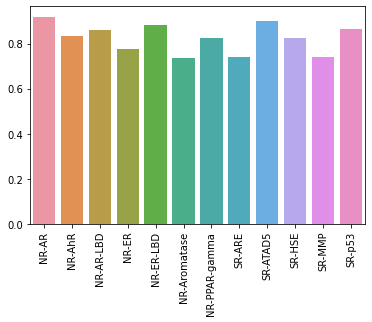

In [16]:
n=all_train_targets.shape[0]
arr=np.count_nonzero(np.isfinite(all_train_targets), axis=0)
ax=sns.barplot(x=list(range(len(arr))), y=arr/n)
ax.set_xticklabels(labels, rotation=90)

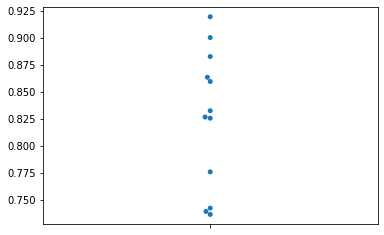

In [19]:
ax=sns.swarmplot(y=arr/n)


In [12]:
arr

array([7073, 6404, 6612, 5969, 6790, 5666, 6351, 5711, 6925, 6359, 5687,
       6642], dtype=int64)

In [22]:
#Proportion of positives
pos_arr=np.count_nonzero(all_train_targets==1, axis=0)
pos_arr=pos_arr/arr

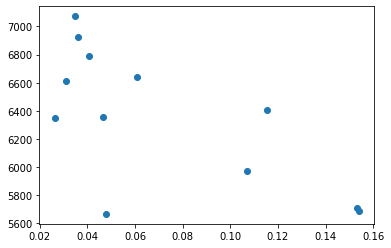

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(pos_arr, arr)

# Locally-Linear Deep Learner on Tox21 dataset 
This set of experiments include Batch Normalization and Similarity Batching

In [1]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

import time

env: TMPDIR=/tmp/temp


# Data processing (If re-running code, skip to load data)

In [2]:
# Load Tox21 data
import pandas as pd
import numpy as np
dataset_name="XY_Tox21_CDKPaDEL_processed.csv"
df=pd.read_csv(os.path.join("..", 
                            "..",
                            "rawdata", 
                            dataset_name))

# label_columns=range(5,17) #12 Tox21 labels
# data_columns=range(17,1504) #1487 CDK+PaDEL descriptors (after filtering)
# id_columns=range(5)  

train_ind=np.where(np.isin(df['Type'], ['Training', 'Testing']))[0]
test_ind=np.where(df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

# X_train=df.iloc[traini_ind, data_columns].values
# X_test=df.iloc[testing_ind, data_columns].values
# y_train=df.iloc[training_ind, label_columns]
# y_test=df.iloc[testing_ind, label_columns]
# train_id_df=df.iloc[training_ind, id_columns]
# test_id_df=df.iloc[testing_ind, id_columns]

label_start = 5
feat_start = 17
labels = df.columns[label_start:feat_start].values


XY_Tox21_CDKPaDEL_processed.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


In [3]:
# #Load tanimoto similarity

# dataset_sim_name="XY_Tox21_CDKPaDEL_processed_tanimoto.csv"
# df_sim=pd.read_csv(os.path.join("..", 
#                                 "..",
#                                 "rawdata", 
#                                 dataset_sim_name
#                                ), 
#                    index_col=0
#                   )

# sim_train_df=df_sim.iloc[training_ind, training_ind+len(id_columns)]
# sim_test_df=df_sim.iloc[testing_ind, training_ind+len(id_columns)]

## Remove repeated chemicals (by smiles)

In [4]:
smi = df['Canonical_QSARr'].values
train_smi = smi[train_ind]
train_labels = df.iloc[train_ind, label_start:feat_start].values

def combine_labels(labels):
    r = []
    for i in range(labels.shape[1]):
        l = labels[:, i]
        l = l[np.isfinite(l)]
        if len(np.unique(l))==1:
            r.append(np.unique(l))
        else: #No labels, or more than 1 unique label
            r.append(np.nan)
    return np.array(r).ravel()

repeated_ind=[]
for i in range(train_labels.shape[0]):
    if np.isin([i],repeated_ind)[0]:
        continue
    rep = np.where(train_smi==train_smi[i])[0]
    if len(rep)>1:
        train_labels[i] = combine_labels(train_labels[rep])
        repeated_ind=np.concatenate([repeated_ind, 
                                     np.setdiff1d(rep, [i])])
retain_ind = np.setdiff1d(train_ind,
                          repeated_ind
                         )
updated_train_labels = train_labels[retain_ind,:]

<ipython-input-4-37604d6e01ac>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(r).ravel()


## Impute missing values (as most ML can't deal with missing feature values)
Retain features with only 1 missing value. Drop features with only 1 unique value. Do median imputation. 

In [5]:
train_features = df.iloc[retain_ind, feat_start:].values
test_features = df.iloc[test_ind, feat_start:].values
train_labels = pd.DataFrame(updated_train_labels,
                            columns = labels
                           )
test_labels = df.iloc[test_ind, label_start:feat_start].values

all_labels = pd.concat([train_labels, pd.DataFrame(test_labels, 
    columns = train_labels.columns)], 
                       axis=0, )
all_id = df.iloc[np.concatenate([retain_ind, test_ind]), :label_start]
all_labels.index=all_id.index

In [6]:
def median_imputation(X_train, X_test):
    for col in range(len(X_train[0])):
        med=np.nanmedian(X_train[:,col])
        
        train_nanind=np.where(np.isnan(X_train[:,col]))[0]
        test_nanind=np.where(np.isnan(X_test[:,col]))[0]
        
        if len(train_nanind)>0:
            X_train[train_nanind,col]=med
        if len(test_nanind)>0:
            X_test[test_nanind,col]=med
    return X_train, X_test

# def zero_imputation(y):
#     for col in range(len(y[0])):
#         nan_ind=np.where(np.isnan(y[:,col]))[0]
#         if len(nan_ind)>0:
#             y[nan_ind,col]=0
#     return y

#Remove features with more than 1 missing values
retain_feat_ind=np.where(np.sum(np.isnan(train_features),
                                axis=0)<2)[0]
print(f"{len(retain_feat_ind)} out of {train_features.shape[1]} feature retained")
data_cols = df.columns[feat_start:][retain_feat_ind]
#Impute missing values
train_features, test_features = median_imputation(
    train_features[:, retain_feat_ind], 
    test_features[:, retain_feat_ind]
)


1290 out of 1487 feature retained


## Check for feature correlations

96 comparisons with R=1.00
6986 comparisons with R>0.95
950 out of 1290 features retained.


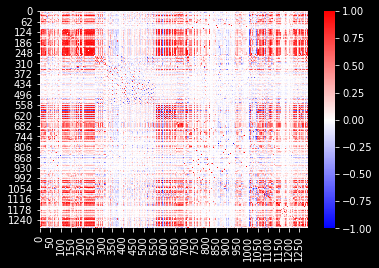

In [7]:
#Remove features that are almost identical to each other (R>0.95)
from scipy.stats import pearsonr
from itertools import combinations
m=train_features.shape[1]
R_mat=np.empty((m,m))
for (i,j) in combinations(range(m), 2):
    r=pearsonr(train_features[:,i], train_features[:,j])
    R_mat[i,j]=r[0]
    R_mat[j,i]=r[0]
for i in range(m):
    R_mat[i,i]=0.    
    
import seaborn as sns
ax= sns.heatmap(R_mat, center=0, cmap='bwr')

R_mat=np.nan_to_num(R_mat, nan=1.)

arr=pd.Series(np.abs(R_mat.flatten()))

print(f"{np.count_nonzero(arr==1)} comparisons with R=1.00")
print(f"{np.count_nonzero(arr>0.95)} comparisons with R>0.95")

# arr=np.where(R_mat==1.)

def split_ind(arr):
    # Given 2D array of pairs of indices, return the lowest index of connected groups of indices
    retain_list=[]
    omit_list=[]
    for i in range(len(arr[0])):
        head, tail=arr[0][i], arr[1][i]
        if head in retain_list:
            omit_list=np.append(omit_list,tail)
        elif tail in retain_list:
            omit_list=np.append(omit_list,head)
        else:
            retain_list=np.append(retain_list, head)
            omit_list=np.append(omit_list,tail)
        retain_list=np.setdiff1d(retain_list, omit_list)
        omit_list=np.unique(omit_list)
    return retain_list, omit_list

retain_list2, omit_list2=split_ind(np.where(np.abs(R_mat)>0.99))

filtered_features=np.setdiff1d(range(m), omit_list2)
train_features_filtered=train_features[:,filtered_features]
test_features_filtered=test_features[:,filtered_features]

print(f"{len(filtered_features)} out of {m} features retained.")

data_cols = data_cols[filtered_features]

In [ ]:
# #Remove features that are almost identical to each other (R>0.95)
# from scipy.stats import pearsonr
# from itertools import combinations
# m=X_train.shape[1]
# R_mat=np.empty((m,m))
# for (i,j) in combinations(range(m), 2):
#     r=pearsonr(X_train[:,i], X_train[:,j])
#     R_mat[i,j]=r[0]
#     R_mat[j,i]=r[0]
# for i in range(m):
#     R_mat[i,i]=0.    
    
# import seaborn as sns
# ax= sns.heatmap(R_mat, center=0, cmap='bwr')

In [ ]:
# R_mat=np.nan_to_num(R_mat, nan=1.)

# arr=pd.Series(np.abs(R_mat.flatten()))

# print(f"{np.count_nonzero(arr==1)} comparisons with R=1.00")
# print(f"{np.count_nonzero(arr>0.95)} comparisons with R>0.95")

In [ ]:
# # arr=np.where(R_mat==1.)

# def split_ind(arr):
#     # Given 2D array of pairs of indices, return the lowest index of connected groups of indices
#     retain_list=[]
#     omit_list=[]
#     for i in range(len(arr[0])):
#         head, tail=arr[0][i], arr[1][i]
#         if head in retain_list:
#             omit_list=np.append(omit_list,tail)
#         elif tail in retain_list:
#             omit_list=np.append(omit_list,head)
#         else:
#             retain_list=np.append(retain_list, head)
#             omit_list=np.append(omit_list,tail)
#         retain_list=np.setdiff1d(retain_list, omit_list)
#         omit_list=np.unique(omit_list)
#     return retain_list, omit_list
    

In [ ]:
# retain_list2, omit_list2=split_ind(np.where(np.abs(R_mat)>0.99))

In [ ]:
# len(omit_list2)

We omit comparisons with R>0.95

In [ ]:
# filtered_features=np.setdiff1d(range(m), omit_list2)
# X_train_filtered=X_train[:,filtered_features]
# X_test_filtered=X_test[:,filtered_features]

# print(f"{len(filtered_features)} out of {m} features retained.")

## Filter features by Random Forest

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


supports=[]
for i in range(train_labels.shape[1]):
    valid_ind = ~np.isnan(train_labels.iloc[:,i].astype(np.float))
    train_target = train_labels[valid_ind].iloc[:,i].values.astype(
        float)
    clf=ExtraTreesClassifier(n_estimators=499, random_state=123)
    clf.fit(train_features_filtered[valid_ind], train_target)
    model=SelectFromModel(clf, prefit=True)
    supports.append(model.get_support())


(array([76., 74., 78., 78., 76., 65., 90., 87., 73., 95., 68., 50., 40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5]),
 <BarContainer object of 13 artists>)

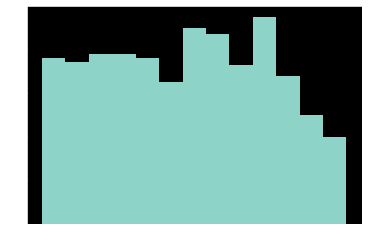

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
counts = np.sum(supports, axis=0)
plt.hist(counts, np.array(list(range(14)))-0.5, )

In [10]:
for i in range(12):
    print(f"Proportion of features that are important in at least {i+1} problem(s): {np.sum(counts>i)/len(counts):.3f}")

Proportion of features that are important in at least 1 problem(s): 0.920
Proportion of features that are important in at least 2 problem(s): 0.842
Proportion of features that are important in at least 3 problem(s): 0.760
Proportion of features that are important in at least 4 problem(s): 0.678
Proportion of features that are important in at least 5 problem(s): 0.598
Proportion of features that are important in at least 6 problem(s): 0.529
Proportion of features that are important in at least 7 problem(s): 0.435
Proportion of features that are important in at least 8 problem(s): 0.343
Proportion of features that are important in at least 9 problem(s): 0.266
Proportion of features that are important in at least 10 problem(s): 0.166
Proportion of features that are important in at least 11 problem(s): 0.095
Proportion of features that are important in at least 12 problem(s): 0.042


In [15]:
thresh=6
selected_feat_ind = np.where(counts>thresh-0.5)[0]


## Save processed data

In [17]:
os.getcwd()

'C:\\Users\\cavio\\Envs\\LocallyLinearManifold\\locally-linear-manifold\\1_Notebooks\\Tox21_CDKPaDEL'

In [18]:
all_features_filtered = pd.DataFrame(np.vstack([
    train_features_filtered[:, selected_feat_ind],
    test_features_filtered[:, selected_feat_ind]]),
                                     columns = data_cols[selected_feat_ind]
                                   )

all_features_filtered.index = all_id.index

to_save = pd.concat([all_id, 
                     all_labels, 
                     all_features_filtered,
                    ],
                    axis=1
                   )
save_folder = "processed_data"

to_save.to_csv(os.path.join(save_folder,
                            "XY_Tox21_CDKPaDEL_processedfiltered.csv", 
            ))

## Learn Fweights (by fitting COSA model)

In [18]:
import pandas as pd
import os
df=pd.read_csv(os.path.join("processed_data", 
                         "XY_Tox21_CDKPaDEL_processedfiltered.csv"
                        ), index_col=0)
label_id, feat_id = 5, 17

train_features_filtered = df[df['Type']!="Score"].iloc[:, feat_id:].values
test_features_filtered = df[df['Type']=="Score"].iloc[:, feat_id:].values

In [13]:
import sys
code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, 
                     n_iter=100,
                     distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=8
                    )
cosa_mdl.fit(train_features_filtered)

Fweights = cosa_mdl.output_Fweight()
pd.DataFrame(Fweights).to_csv(os.path.join("processed_data", 
    "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_train.csv"
                                          ), 
                              index=False
                             )

Starting on outer iteration 1; beta/eta:0.220
Wchange:0.692, Crit:Not calculated
Wchange:0.177, Crit:Not calculated
Inner loop converged in (or maxed out) at 2 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:0.087, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:0.048, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:0.029, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 5; beta/eta:0.300
Wchange:0.019, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 6; beta/eta:0.320
Wchange:0.013, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 7; beta/eta:0.340
Wchange:0.010, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 8; beta/eta:0.360
Wc

Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 64; beta/eta:1.480
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 65; beta/eta:1.500
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 66; beta/eta:1.520
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 67; beta/eta:1.540
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 68; beta/eta:1.560
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 69; beta/eta:1.580
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at 1 steps
Starting on outer iteration 70; beta/eta:1.600
Wchange:0.001, Crit:Not calculated
Inner loop converged in (or maxed out) at

In [19]:
#Load Fweights
import sys
code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

from algorithms import COSA
from importlib import reload
reload(COSA)
cosa_mdl=COSA.NNCosa(Fweight_init="uniform", lam=0.2, 
                     n_iter=100,
                     distance_measure="inv_exp_dist",
                     calc_D_ijk=False, threads=8
                    )
cosa_mdl._init(train_features_filtered)
Fweights_train = pd.read_csv(os.path.join("processed_Data", 
                                          "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_train.csv"
                                         )).values
cosa_mdl.Fweight = Fweights_train
# cosa_mdl.fit_OOS(test_features_filtered, 
#                 interim_save_file="interim_XY_Tox21_CDKPaDEL_processedfiltered_Fweights_test.ob")
cosa_mdl.continue_fit_OOS(test_features_filtered, interim_save_file="interim_XY_Tox21_CDKPaDEL_processedfiltered_Fweights_test.ob")
Fweights_test = cosa_mdl.output_Fweight(OOS=True)
pd.DataFrame(Fweights_Test).to_csv(os.path.join(
    "processed_data",
    "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_test.csv"
))


Starting on outer iteration 4; beta/eta:0.280


NameError: name 'new_Fweight_OOS' is not defined

In [ ]:
cosa_mdl.fit_OOS(test_features_filtered)
Fweights_test = cosa_mdl.output_Fweight(OOS=True)
pd.DataFrame(Fweights_Test).to_csv(os.path.join(
    "processed_data",
    "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_test.csv"
))

Starting on outer iteration 1; beta/eta:0.220
Wchange:228117.507, Crit: Not calculated
Wchange:62333.386, Crit: Not calculated
Wchange:29448.347, Crit: Not calculated
Wchange:13947.895, Crit: Not calculated
Wchange:6860.018, Crit: Not calculated
Wchange:3811.157, Crit: Not calculated
Wchange:1572.506, Crit: Not calculated
Wchange:749.447, Crit: Not calculated
Wchange:202.944, Crit: Not calculated
Wchange:90.545, Crit: Not calculated
Inner loop converged in (or maxed out) at 10 steps
Starting on outer iteration 2; beta/eta:0.240
Wchange:2294.939, Crit: Not calculated
Wchange:118.561, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 3 steps
Starting on outer iteration 3; beta/eta:0.260
Wchange:2631.797, Crit: Not calculated
Wchange:289.573, Crit: Not calculated
Wchange:0.000, Crit: Not calculated
Inner loop converged in (or maxed out) at 3 steps
Starting on outer iteration 4; beta/eta:0.280
Wchange:2758.553, Crit: Not calculated
Wchange:2

In [ ]:
data_columns = df.columns[feat_id:]
pd.DataFrame(Fweights, 
             columns = data_columns, 
            ).to_csv(os.path.join("processed_data", 
    "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_train.csv"
                                          ), 
                              index=False
                             )

pd.DataFrame(Fweights_test,
             columns=data_columns
            ).to_csv(os.path.join(
    "processed_data",
    "XY_Tox21_CDKPaDEL_processedfiltered_Fweights_test.csv"
), index=False
                    )

In [ ]:
# Fweights=cosa_mdl.output_Fweight()
# cosa_dist=cosa_mdl.output_Dmat()

## Save learned Fweights

In [ ]:
# # Save Fweights
import pandas as pd
Fweights=cosa_mdl.output_Fweight()
df= pd.DataFrame(Fweights)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_train.csv"), 
          index=False)

# import pandas as pd
# Fweights=pd.read_csv("Tox21_Fweights_train.txt")
# cosa_mdl.Fweight=Fweights.values

cosa_dist=cosa_mdl.output_Dmat()
df=pd.DataFrame(cosa_dist)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_train.csv"),
          index=False)

In [ ]:
Fweights_OOS=cosa_mdl.output_Fweight(OOS=True)
df= pd.DataFrame(Fweights_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_Fweights_test.csv"), 
          index=False)

cosa_dist_OOS=cosa_mdl.output_Dmat(OOS=True)
df=pd.DataFrame(cosa_dist_OOS)
df.to_csv(os.path.join(save_folder,
                       "Tox21_CDKPaDEL_cosa_dist_test.csv"),
          index=False)

# Load processed data 
To be updated again when COSA fitting is completed

In [2]:
load_folder=os.path.join("processed_data"
                        )
dataset_name="XY_Tox21_CDKPaDEL_processedFiltered.csv"
load_df=pd.read_csv(os.path.join(load_folder, 
                                 dataset_name
                                ), 
                    index_col=0
                   )

label_columns=range(5,17) #12 Tox21 labels
data_columns=range(17,load_df.shape[1]) #945/1487 filtered CDK+PaDEL descriptors (after filtering)
id_columns=range(5)  

training_ind=np.where(np.isin(load_df['Type'], ['Training', 'Testing']))[0]
testing_ind=np.where(load_df['Type']=="Score")[0]
print(f"{dataset_name} has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.")

X_train=load_df.iloc[training_ind, data_columns].values
X_test=load_df.iloc[testing_ind, data_columns].values
y_train=load_df.iloc[training_ind, label_columns]
y_test=load_df.iloc[testing_ind, label_columns]
train_id_df=load_df.iloc[training_ind, id_columns]
test_id_df=load_df.iloc[testing_ind, id_columns]


# Fweights_df=pd.read_csv(os.path.join(load_folder, 
#                                      "Tox21_CDKPaDEL_Fweights_train.csv"
#                                     ))
# Fweights_train=Fweights_df[load_df.columns[data_columns]].values

# Fweights_OOS_df=pd.read_csv(os.path.join(load_folder,
#                                           "Tox21_CDKPaDEL_Fweights_test.csv"
#                                          ))
# Fweights_test=Fweights_OOS_df[load_df.columns[data_columns]].values

XY_Tox21_CDKPaDEL_processedFiltered.csv has data type 'Training', 'Testing' and 'Score'. Training and Testing (leaderboard) data are reflected in train while Score (Final Evaluation) data is in test.


# Train Locality-Sensitive Deep Learner

In [7]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.set_floatx('float32')    

from tf_helpers import get_weights_dicts, BinaryCrossEntropyIgnoreNaN
from tf_helpers import SimilarityBatchingDataset

In [8]:
label='NR-AR'

train_inds = ~np.isnan(y_train[label])
test_inds = ~np.isnan(y_test[label])

train_data = X_train[train_inds, :]
train_targets = y_train[label][train_inds].astype(np.float32)
test_data = X_test[test_inds, :]
test_targets = y_test[label][test_inds].astype(np.float32)
train_Fweights = Fweights_train[train_inds,:]
test_Fweights = Fweights_test[test_inds,:]

train_tensor=np.hstack([train_data, train_Fweights])
test_tensor=np.hstack([test_data, test_Fweights])

In [9]:
train_id_df.shape

(10570, 5)

In [10]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewFW_{}".format("label"),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [11]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat*2, ))

attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy','AUC']
             )

In [12]:
LSwFW_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1890)]            0         
_________________________________________________________________
concat_attentionsw_feat_weig (None, 128)               1598500   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,610,981
Trainable params: 1,610,469
Non-trainable params: 512
_________________________________________________________________


In [14]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

# LSwFW_model.fit(train_tensor, 
#                 train_targets, 
#                 epochs=1,
#                 batch_size=n_batch,
#                 shuffle=True,
#                 verbose=2, 
#                )
# #Set feat weights
# # Fweights=cosa_mdl.Fweight
# sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
# for i in range(n_attention):
#     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
#     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
#     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


n_epoch=2000


LSwFW_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
1168/1168 - 50s - loss: 0.4941 - accuracy: 0.8624 - auc: 0.8104 - val_loss: 0.4789 - val_accuracy: 0.9583 - val_auc: 0.6339

Epoch 00001: val_auc improved from -inf to 0.63388, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 2/2000
1168/1168 - 50s - loss: 0.4915 - accuracy: 0.8629 - auc: 0.8151 - val_loss: 0.4723 - val_accuracy: 0.8470 - val_auc: 0.6783

Epoch 00002: val_auc improved from 0.63388 to 0.67829, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 3/2000
1168/1168 - 51s - loss: 0.4645 - accuracy: 0.8573 - auc: 0.8400 - val_loss: 0.4559 - val_accuracy: 0.9635 - val_auc: 0.6951

Epoch 00003: val_auc improved from 0.67829 to 0.69509, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 4/2000
1168/1168 - 50s - loss: 0.4656 - accuracy: 0.8779 - auc: 0.8425 - val_loss: 0.4847 - val_accuracy: 0.9635 - val_auc: 0.6944

Epoch 00004: val_auc did not improve from 0.69509

1168/1168 - 47s - loss: 0.2173 - accuracy: 0.9151 - auc: 0.9785 - val_loss: 0.9483 - val_accuracy: 0.9670 - val_auc: 0.7325

Epoch 00042: val_auc did not improve from 0.74179
Epoch 43/2000
1168/1168 - 48s - loss: 0.1977 - accuracy: 0.9267 - auc: 0.9823 - val_loss: 1.1188 - val_accuracy: 0.5739 - val_auc: 0.6793

Epoch 00043: val_auc did not improve from 0.74179
Epoch 44/2000
1168/1168 - 48s - loss: 0.2174 - accuracy: 0.9053 - auc: 0.9781 - val_loss: 1.0353 - val_accuracy: 0.9670 - val_auc: 0.7053

Epoch 00044: val_auc did not improve from 0.74179
Epoch 45/2000
1168/1168 - 48s - loss: 0.2095 - accuracy: 0.9213 - auc: 0.9803 - val_loss: 1.2375 - val_accuracy: 0.9583 - val_auc: 0.6744

Epoch 00045: val_auc did not improve from 0.74179
Epoch 46/2000
1168/1168 - 48s - loss: 0.1960 - accuracy: 0.9181 - auc: 0.9825 - val_loss: 1.3272 - val_accuracy: 0.9583 - val_auc: 0.6548

Epoch 00046: val_auc did not improve from 0.74179
Epoch 47/2000
1168/1168 - 47s - loss: 0.2043 - accuracy: 0.9180 - auc

1168/1168 - 47s - loss: 0.1500 - accuracy: 0.9500 - auc: 0.9910 - val_loss: 1.1685 - val_accuracy: 0.8365 - val_auc: 0.6912

Epoch 00085: val_auc did not improve from 0.78160
Epoch 86/2000
1168/1168 - 47s - loss: 0.1659 - accuracy: 0.9407 - auc: 0.9884 - val_loss: 1.2860 - val_accuracy: 0.9357 - val_auc: 0.6385

Epoch 00086: val_auc did not improve from 0.78160
Epoch 87/2000
1168/1168 - 47s - loss: 0.1423 - accuracy: 0.9469 - auc: 0.9921 - val_loss: 0.9795 - val_accuracy: 0.9235 - val_auc: 0.7100

Epoch 00087: val_auc did not improve from 0.78160
Epoch 88/2000
1168/1168 - 47s - loss: 0.1337 - accuracy: 0.9519 - auc: 0.9921 - val_loss: 0.9611 - val_accuracy: 0.8504 - val_auc: 0.7211

Epoch 00088: val_auc did not improve from 0.78160
Epoch 89/2000
1168/1168 - 47s - loss: 0.1760 - accuracy: 0.9427 - auc: 0.9880 - val_loss: 1.3061 - val_accuracy: 0.9600 - val_auc: 0.6409

Epoch 00089: val_auc did not improve from 0.78160
Epoch 90/2000
1168/1168 - 47s - loss: 0.1212 - accuracy: 0.9594 - auc


Epoch 00128: val_auc did not improve from 0.78160
Epoch 129/2000
1168/1168 - 50s - loss: 0.1314 - accuracy: 0.9547 - auc: 0.9934 - val_loss: 1.3564 - val_accuracy: 0.9565 - val_auc: 0.6363

Epoch 00129: val_auc did not improve from 0.78160
Epoch 130/2000
1168/1168 - 49s - loss: 0.1239 - accuracy: 0.9653 - auc: 0.9932 - val_loss: 1.4653 - val_accuracy: 0.9583 - val_auc: 0.6210

Epoch 00130: val_auc did not improve from 0.78160
Epoch 131/2000
1168/1168 - 52s - loss: 0.1242 - accuracy: 0.9605 - auc: 0.9935 - val_loss: 1.3991 - val_accuracy: 0.9670 - val_auc: 0.6556

Epoch 00131: val_auc did not improve from 0.78160
Epoch 132/2000
1168/1168 - 51s - loss: 0.1392 - accuracy: 0.9548 - auc: 0.9920 - val_loss: 1.2256 - val_accuracy: 0.9565 - val_auc: 0.6523

Epoch 00132: val_auc did not improve from 0.78160
Epoch 133/2000
1168/1168 - 52s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9911 - val_loss: 1.2871 - val_accuracy: 0.9043 - val_auc: 0.6320

Epoch 00133: val_auc did not improve from 0.78160

1168/1168 - 45s - loss: 0.1263 - accuracy: 0.9624 - auc: 0.9940 - val_loss: 1.1471 - val_accuracy: 0.9443 - val_auc: 0.7179

Epoch 00172: val_auc did not improve from 0.78160
Epoch 173/2000
1168/1168 - 45s - loss: 0.1241 - accuracy: 0.9634 - auc: 0.9931 - val_loss: 1.5550 - val_accuracy: 0.9600 - val_auc: 0.6208

Epoch 00173: val_auc did not improve from 0.78160
Epoch 174/2000
1168/1168 - 45s - loss: 0.1233 - accuracy: 0.9632 - auc: 0.9950 - val_loss: 1.2075 - val_accuracy: 0.8800 - val_auc: 0.6472

Epoch 00174: val_auc did not improve from 0.78160
Epoch 175/2000
1168/1168 - 45s - loss: 0.1193 - accuracy: 0.9650 - auc: 0.9946 - val_loss: 1.4288 - val_accuracy: 0.9478 - val_auc: 0.5890

Epoch 00175: val_auc did not improve from 0.78160
Epoch 176/2000
1168/1168 - 45s - loss: 0.1249 - accuracy: 0.9655 - auc: 0.9944 - val_loss: 0.7637 - val_accuracy: 0.9096 - val_auc: 0.7433

Epoch 00176: val_auc did not improve from 0.78160
Epoch 177/2000
1168/1168 - 45s - loss: 0.1123 - accuracy: 0.9673 

1168/1168 - 45s - loss: 0.1193 - accuracy: 0.9659 - auc: 0.9953 - val_loss: 1.5220 - val_accuracy: 0.9548 - val_auc: 0.5386

Epoch 00214: val_auc did not improve from 0.79307
Epoch 215/2000
1168/1168 - 45s - loss: 0.1481 - accuracy: 0.9513 - auc: 0.9914 - val_loss: 1.3343 - val_accuracy: 0.9565 - val_auc: 0.5638

Epoch 00215: val_auc did not improve from 0.79307
Epoch 216/2000
1168/1168 - 46s - loss: 0.1238 - accuracy: 0.9653 - auc: 0.9948 - val_loss: 1.0524 - val_accuracy: 0.9304 - val_auc: 0.6673

Epoch 00216: val_auc did not improve from 0.79307
Epoch 217/2000
1168/1168 - 46s - loss: 0.1043 - accuracy: 0.9716 - auc: 0.9961 - val_loss: 1.5259 - val_accuracy: 0.9583 - val_auc: 0.6138

Epoch 00217: val_auc did not improve from 0.79307
Epoch 218/2000
1168/1168 - 46s - loss: 0.1069 - accuracy: 0.9727 - auc: 0.9958 - val_loss: 1.7224 - val_accuracy: 0.9704 - val_auc: 0.5927

Epoch 00218: val_auc did not improve from 0.79307
Epoch 219/2000
1168/1168 - 46s - loss: 0.1279 - accuracy: 0.9601 

1168/1168 - 45s - loss: 0.1048 - accuracy: 0.9726 - auc: 0.9965 - val_loss: 1.5291 - val_accuracy: 0.9617 - val_auc: 0.5965

Epoch 00257: val_auc did not improve from 0.79329
Epoch 258/2000
1168/1168 - 45s - loss: 0.1292 - accuracy: 0.9610 - auc: 0.9944 - val_loss: 1.3862 - val_accuracy: 0.9478 - val_auc: 0.6063

Epoch 00258: val_auc did not improve from 0.79329
Epoch 259/2000
1168/1168 - 46s - loss: 0.1116 - accuracy: 0.9702 - auc: 0.9953 - val_loss: 1.2788 - val_accuracy: 0.9339 - val_auc: 0.6232

Epoch 00259: val_auc did not improve from 0.79329
Epoch 260/2000
1168/1168 - 45s - loss: 0.1342 - accuracy: 0.9550 - auc: 0.9939 - val_loss: 1.7039 - val_accuracy: 0.9426 - val_auc: 0.5577

Epoch 00260: val_auc did not improve from 0.79329
Epoch 261/2000
1168/1168 - 45s - loss: 0.1305 - accuracy: 0.9642 - auc: 0.9942 - val_loss: 0.8109 - val_accuracy: 0.7722 - val_auc: 0.7631

Epoch 00261: val_auc did not improve from 0.79329
Epoch 262/2000
1168/1168 - 45s - loss: 0.1158 - accuracy: 0.9668 

1168/1168 - 25s - loss: 0.1104 - accuracy: 0.9704 - auc: 0.9960 - val_loss: 1.4926 - val_accuracy: 0.9496 - val_auc: 0.6507

Epoch 00300: val_auc did not improve from 0.79914
Epoch 301/2000
1168/1168 - 25s - loss: 0.1088 - accuracy: 0.9754 - auc: 0.9963 - val_loss: 1.3059 - val_accuracy: 0.9426 - val_auc: 0.5936

Epoch 00301: val_auc did not improve from 0.79914
Epoch 302/2000
1168/1168 - 25s - loss: 0.1317 - accuracy: 0.9626 - auc: 0.9948 - val_loss: 1.2441 - val_accuracy: 0.9391 - val_auc: 0.6343

Epoch 00302: val_auc did not improve from 0.79914
Epoch 303/2000
1168/1168 - 25s - loss: 0.0972 - accuracy: 0.9768 - auc: 0.9968 - val_loss: 1.3618 - val_accuracy: 0.9600 - val_auc: 0.6666

Epoch 00303: val_auc did not improve from 0.79914
Epoch 304/2000
1168/1168 - 25s - loss: 0.1140 - accuracy: 0.9672 - auc: 0.9954 - val_loss: 1.2622 - val_accuracy: 0.9217 - val_auc: 0.6923

Epoch 00304: val_auc did not improve from 0.79914
Epoch 305/2000
1168/1168 - 25s - loss: 0.1208 - accuracy: 0.9645 


Epoch 00343: val_auc did not improve from 0.79914
Epoch 344/2000
1168/1168 - 25s - loss: 0.1071 - accuracy: 0.9695 - auc: 0.9966 - val_loss: 1.5669 - val_accuracy: 0.9426 - val_auc: 0.6628

Epoch 00344: val_auc did not improve from 0.79914
Epoch 345/2000
1168/1168 - 25s - loss: 0.1170 - accuracy: 0.9662 - auc: 0.9955 - val_loss: 1.6623 - val_accuracy: 0.9617 - val_auc: 0.6371

Epoch 00345: val_auc did not improve from 0.79914
Epoch 346/2000
1168/1168 - 25s - loss: 0.1151 - accuracy: 0.9661 - auc: 0.9956 - val_loss: 1.3151 - val_accuracy: 0.9530 - val_auc: 0.6254

Epoch 00346: val_auc did not improve from 0.79914
Epoch 347/2000
1168/1168 - 25s - loss: 0.1272 - accuracy: 0.9635 - auc: 0.9946 - val_loss: 1.1792 - val_accuracy: 0.9496 - val_auc: 0.7499

Epoch 00347: val_auc did not improve from 0.79914
Epoch 348/2000
1168/1168 - 25s - loss: 0.1198 - accuracy: 0.9676 - auc: 0.9953 - val_loss: 1.4382 - val_accuracy: 0.9461 - val_auc: 0.6498

Epoch 00348: val_auc did not improve from 0.79914

1168/1168 - 25s - loss: 0.0978 - accuracy: 0.9775 - auc: 0.9969 - val_loss: 1.5724 - val_accuracy: 0.9530 - val_auc: 0.7057

Epoch 00387: val_auc did not improve from 0.79914
Epoch 388/2000
1168/1168 - 25s - loss: 0.1008 - accuracy: 0.9744 - auc: 0.9968 - val_loss: 1.3132 - val_accuracy: 0.9252 - val_auc: 0.6618

Epoch 00388: val_auc did not improve from 0.79914
Epoch 389/2000
1168/1168 - 25s - loss: 0.1520 - accuracy: 0.9555 - auc: 0.9918 - val_loss: 0.9084 - val_accuracy: 0.9357 - val_auc: 0.7780

Epoch 00389: val_auc did not improve from 0.79914
Epoch 390/2000
1168/1168 - 25s - loss: 0.0989 - accuracy: 0.9774 - auc: 0.9971 - val_loss: 1.3153 - val_accuracy: 0.9270 - val_auc: 0.6681

Epoch 00390: val_auc did not improve from 0.79914
Epoch 391/2000
1168/1168 - 25s - loss: 0.1112 - accuracy: 0.9696 - auc: 0.9958 - val_loss: 1.8801 - val_accuracy: 0.9617 - val_auc: 0.5946

Epoch 00391: val_auc did not improve from 0.79914
Epoch 392/2000
1168/1168 - 25s - loss: 0.1124 - accuracy: 0.9699 

1168/1168 - 25s - loss: 0.1363 - accuracy: 0.9619 - auc: 0.9933 - val_loss: 1.0461 - val_accuracy: 0.9443 - val_auc: 0.7240

Epoch 00430: val_auc did not improve from 0.80255
Epoch 431/2000
1168/1168 - 25s - loss: 0.0982 - accuracy: 0.9753 - auc: 0.9971 - val_loss: 1.5402 - val_accuracy: 0.9409 - val_auc: 0.6543

Epoch 00431: val_auc did not improve from 0.80255
Epoch 432/2000
1168/1168 - 25s - loss: 0.1193 - accuracy: 0.9678 - auc: 0.9955 - val_loss: 1.5170 - val_accuracy: 0.9409 - val_auc: 0.6587

Epoch 00432: val_auc did not improve from 0.80255
Epoch 433/2000
1168/1168 - 25s - loss: 0.1254 - accuracy: 0.9668 - auc: 0.9948 - val_loss: 1.3572 - val_accuracy: 0.9200 - val_auc: 0.6143

Epoch 00433: val_auc did not improve from 0.80255
Epoch 434/2000
1168/1168 - 25s - loss: 0.1030 - accuracy: 0.9752 - auc: 0.9966 - val_loss: 1.6252 - val_accuracy: 0.9443 - val_auc: 0.5149

Epoch 00434: val_auc did not improve from 0.80255
Epoch 435/2000
1168/1168 - 25s - loss: 0.1145 - accuracy: 0.9729 

1168/1168 - 25s - loss: 0.1169 - accuracy: 0.9721 - auc: 0.9947 - val_loss: 1.2952 - val_accuracy: 0.9513 - val_auc: 0.6331

Epoch 00473: val_auc did not improve from 0.81439
Epoch 474/2000
1168/1168 - 25s - loss: 0.1090 - accuracy: 0.9706 - auc: 0.9962 - val_loss: 1.6849 - val_accuracy: 0.9443 - val_auc: 0.5708

Epoch 00474: val_auc did not improve from 0.81439
Epoch 475/2000
1168/1168 - 25s - loss: 0.1093 - accuracy: 0.9699 - auc: 0.9963 - val_loss: 1.1942 - val_accuracy: 0.8609 - val_auc: 0.7002

Epoch 00475: val_auc did not improve from 0.81439
Epoch 476/2000
1168/1168 - 25s - loss: 0.1288 - accuracy: 0.9645 - auc: 0.9948 - val_loss: 1.6301 - val_accuracy: 0.9530 - val_auc: 0.6305

Epoch 00476: val_auc did not improve from 0.81439
Epoch 477/2000
1168/1168 - 25s - loss: 0.0926 - accuracy: 0.9773 - auc: 0.9973 - val_loss: 1.8222 - val_accuracy: 0.9443 - val_auc: 0.5409

Epoch 00477: val_auc did not improve from 0.81439
Epoch 478/2000
1168/1168 - 25s - loss: 0.1306 - accuracy: 0.9590 


Epoch 00516: val_auc did not improve from 0.81439
Epoch 517/2000
1168/1168 - 25s - loss: 0.1199 - accuracy: 0.9673 - auc: 0.9942 - val_loss: 1.5781 - val_accuracy: 0.9548 - val_auc: 0.5789

Epoch 00517: val_auc did not improve from 0.81439
Epoch 518/2000
1168/1168 - 25s - loss: 0.1161 - accuracy: 0.9692 - auc: 0.9954 - val_loss: 1.4161 - val_accuracy: 0.9565 - val_auc: 0.6687

Epoch 00518: val_auc did not improve from 0.81439
Epoch 519/2000
1168/1168 - 25s - loss: 0.1273 - accuracy: 0.9663 - auc: 0.9941 - val_loss: 1.3805 - val_accuracy: 0.9287 - val_auc: 0.6055

Epoch 00519: val_auc did not improve from 0.81439
Epoch 520/2000
1168/1168 - 25s - loss: 0.1096 - accuracy: 0.9729 - auc: 0.9956 - val_loss: 1.4666 - val_accuracy: 0.9565 - val_auc: 0.6689

Epoch 00520: val_auc did not improve from 0.81439
Epoch 521/2000
1168/1168 - 25s - loss: 0.0943 - accuracy: 0.9801 - auc: 0.9973 - val_loss: 1.6592 - val_accuracy: 0.9600 - val_auc: 0.6368

Epoch 00521: val_auc did not improve from 0.81439

1168/1168 - 25s - loss: 0.1054 - accuracy: 0.9732 - auc: 0.9964 - val_loss: 1.3488 - val_accuracy: 0.9113 - val_auc: 0.6775

Epoch 00560: val_auc did not improve from 0.81439
Epoch 561/2000
1168/1168 - 25s - loss: 0.1180 - accuracy: 0.9651 - auc: 0.9952 - val_loss: 1.7693 - val_accuracy: 0.9617 - val_auc: 0.6354

Epoch 00561: val_auc did not improve from 0.81439
Epoch 562/2000
1168/1168 - 25s - loss: 0.1060 - accuracy: 0.9710 - auc: 0.9964 - val_loss: 1.6632 - val_accuracy: 0.9600 - val_auc: 0.6270

Epoch 00562: val_auc did not improve from 0.81439
Epoch 563/2000
1168/1168 - 25s - loss: 0.1237 - accuracy: 0.9646 - auc: 0.9941 - val_loss: 1.0855 - val_accuracy: 0.9130 - val_auc: 0.7061

Epoch 00563: val_auc did not improve from 0.81439
Epoch 564/2000
1168/1168 - 25s - loss: 0.1271 - accuracy: 0.9666 - auc: 0.9951 - val_loss: 1.1171 - val_accuracy: 0.9165 - val_auc: 0.7128

Epoch 00564: val_auc did not improve from 0.81439
Epoch 565/2000
1168/1168 - 25s - loss: 0.1100 - accuracy: 0.9715 


Epoch 00603: val_auc did not improve from 0.81439
Epoch 604/2000
1168/1168 - 25s - loss: 0.1173 - accuracy: 0.9695 - auc: 0.9961 - val_loss: 1.3658 - val_accuracy: 0.9548 - val_auc: 0.6551

Epoch 00604: val_auc did not improve from 0.81439
Epoch 605/2000
1168/1168 - 25s - loss: 0.0914 - accuracy: 0.9798 - auc: 0.9971 - val_loss: 1.8503 - val_accuracy: 0.9670 - val_auc: 0.5926

Epoch 00605: val_auc did not improve from 0.81439
Epoch 606/2000
1168/1168 - 25s - loss: 0.1259 - accuracy: 0.9692 - auc: 0.9941 - val_loss: 1.3973 - val_accuracy: 0.9478 - val_auc: 0.6316

Epoch 00606: val_auc did not improve from 0.81439
Epoch 607/2000
1168/1168 - 25s - loss: 0.1136 - accuracy: 0.9689 - auc: 0.9962 - val_loss: 1.6796 - val_accuracy: 0.9670 - val_auc: 0.6280

Epoch 00607: val_auc did not improve from 0.81439
Epoch 608/2000
1168/1168 - 25s - loss: 0.1163 - accuracy: 0.9721 - auc: 0.9947 - val_loss: 1.4469 - val_accuracy: 0.9426 - val_auc: 0.6024

Epoch 00608: val_auc did not improve from 0.81439

1168/1168 - 25s - loss: 0.1217 - accuracy: 0.9689 - auc: 0.9948 - val_loss: 1.2987 - val_accuracy: 0.9374 - val_auc: 0.6311

Epoch 00647: val_auc did not improve from 0.81439
Epoch 648/2000
1168/1168 - 25s - loss: 0.0978 - accuracy: 0.9788 - auc: 0.9973 - val_loss: 1.5834 - val_accuracy: 0.9478 - val_auc: 0.6192

Epoch 00648: val_auc did not improve from 0.81439
Epoch 649/2000
1168/1168 - 25s - loss: 0.1003 - accuracy: 0.9802 - auc: 0.9962 - val_loss: 1.1934 - val_accuracy: 0.9270 - val_auc: 0.6956

Epoch 00649: val_auc did not improve from 0.81439
Epoch 650/2000
1168/1168 - 25s - loss: 0.1092 - accuracy: 0.9724 - auc: 0.9964 - val_loss: 1.6019 - val_accuracy: 0.9496 - val_auc: 0.6610

Epoch 00650: val_auc did not improve from 0.81439
Epoch 651/2000
1168/1168 - 25s - loss: 0.1250 - accuracy: 0.9636 - auc: 0.9949 - val_loss: 1.2635 - val_accuracy: 0.9339 - val_auc: 0.6825

Epoch 00651: val_auc did not improve from 0.81439
Epoch 652/2000
1168/1168 - 25s - loss: 0.1045 - accuracy: 0.9756 


Epoch 00690: val_auc did not improve from 0.81439
Epoch 691/2000
1168/1168 - 25s - loss: 0.1269 - accuracy: 0.9620 - auc: 0.9951 - val_loss: 1.6384 - val_accuracy: 0.9496 - val_auc: 0.6130

Epoch 00691: val_auc did not improve from 0.81439
Epoch 692/2000
1168/1168 - 25s - loss: 0.0944 - accuracy: 0.9769 - auc: 0.9970 - val_loss: 1.7029 - val_accuracy: 0.9461 - val_auc: 0.6175

Epoch 00692: val_auc did not improve from 0.81439
Epoch 693/2000
1168/1168 - 25s - loss: 0.1053 - accuracy: 0.9714 - auc: 0.9969 - val_loss: 1.5826 - val_accuracy: 0.9339 - val_auc: 0.6894

Epoch 00693: val_auc did not improve from 0.81439
Epoch 694/2000
1168/1168 - 25s - loss: 0.1187 - accuracy: 0.9713 - auc: 0.9953 - val_loss: 1.5608 - val_accuracy: 0.9357 - val_auc: 0.5933

Epoch 00694: val_auc did not improve from 0.81439
Epoch 695/2000
1168/1168 - 25s - loss: 0.1041 - accuracy: 0.9701 - auc: 0.9966 - val_loss: 1.9067 - val_accuracy: 0.9548 - val_auc: 0.6289

Epoch 00695: val_auc did not improve from 0.81439

1168/1168 - 25s - loss: 0.1062 - accuracy: 0.9712 - auc: 0.9969 - val_loss: 1.2600 - val_accuracy: 0.9374 - val_auc: 0.7067

Epoch 00734: val_auc did not improve from 0.81439
Epoch 735/2000
1168/1168 - 25s - loss: 0.1030 - accuracy: 0.9754 - auc: 0.9971 - val_loss: 1.5171 - val_accuracy: 0.9443 - val_auc: 0.6479

Epoch 00735: val_auc did not improve from 0.81439
Epoch 736/2000
1168/1168 - 25s - loss: 0.1269 - accuracy: 0.9712 - auc: 0.9932 - val_loss: 1.3784 - val_accuracy: 0.9113 - val_auc: 0.6488

Epoch 00736: val_auc did not improve from 0.81439
Epoch 737/2000
1168/1168 - 25s - loss: 0.1087 - accuracy: 0.9713 - auc: 0.9969 - val_loss: 1.4948 - val_accuracy: 0.9513 - val_auc: 0.6177

Epoch 00737: val_auc did not improve from 0.81439
Epoch 738/2000
1168/1168 - 25s - loss: 0.1022 - accuracy: 0.9742 - auc: 0.9969 - val_loss: 1.6801 - val_accuracy: 0.9130 - val_auc: 0.5747

Epoch 00738: val_auc did not improve from 0.81439
Epoch 739/2000
1168/1168 - 25s - loss: 0.1010 - accuracy: 0.9772 


Epoch 00777: val_auc did not improve from 0.81439
Epoch 778/2000
1168/1168 - 46s - loss: 0.1208 - accuracy: 0.9680 - auc: 0.9952 - val_loss: 1.3976 - val_accuracy: 0.9443 - val_auc: 0.6135

Epoch 00778: val_auc did not improve from 0.81439
Epoch 779/2000
1168/1168 - 46s - loss: 0.1151 - accuracy: 0.9698 - auc: 0.9963 - val_loss: 1.5150 - val_accuracy: 0.9565 - val_auc: 0.6274

Epoch 00779: val_auc did not improve from 0.81439
Epoch 780/2000
1168/1168 - 46s - loss: 0.1031 - accuracy: 0.9717 - auc: 0.9971 - val_loss: 1.4373 - val_accuracy: 0.9200 - val_auc: 0.6513

Epoch 00780: val_auc did not improve from 0.81439
Epoch 781/2000
1168/1168 - 46s - loss: 0.1206 - accuracy: 0.9671 - auc: 0.9959 - val_loss: 1.3999 - val_accuracy: 0.9496 - val_auc: 0.6043

Epoch 00781: val_auc did not improve from 0.81439
Epoch 782/2000
1168/1168 - 45s - loss: 0.1042 - accuracy: 0.9757 - auc: 0.9965 - val_loss: 1.3501 - val_accuracy: 0.9565 - val_auc: 0.6644

Epoch 00782: val_auc did not improve from 0.81439

1168/1168 - 46s - loss: 0.0935 - accuracy: 0.9780 - auc: 0.9972 - val_loss: 1.3450 - val_accuracy: 0.9478 - val_auc: 0.6583

Epoch 00821: val_auc did not improve from 0.81439
Epoch 822/2000
1168/1168 - 46s - loss: 0.1148 - accuracy: 0.9731 - auc: 0.9955 - val_loss: 1.5839 - val_accuracy: 0.9496 - val_auc: 0.5992

Epoch 00822: val_auc did not improve from 0.81439
Epoch 823/2000
1168/1168 - 47s - loss: 0.1261 - accuracy: 0.9665 - auc: 0.9949 - val_loss: 1.0494 - val_accuracy: 0.9322 - val_auc: 0.6824

Epoch 00823: val_auc did not improve from 0.81439
Epoch 824/2000
1168/1168 - 47s - loss: 0.0919 - accuracy: 0.9780 - auc: 0.9978 - val_loss: 1.4363 - val_accuracy: 0.9304 - val_auc: 0.6448

Epoch 00824: val_auc did not improve from 0.81439
Epoch 825/2000
1168/1168 - 47s - loss: 0.1147 - accuracy: 0.9743 - auc: 0.9959 - val_loss: 1.4421 - val_accuracy: 0.9409 - val_auc: 0.6056

Epoch 00825: val_auc did not improve from 0.81439
Epoch 826/2000
1168/1168 - 47s - loss: 0.1201 - accuracy: 0.9698 


Epoch 00864: val_auc did not improve from 0.81439
Epoch 865/2000
1168/1168 - 25s - loss: 0.1108 - accuracy: 0.9734 - auc: 0.9953 - val_loss: 1.4284 - val_accuracy: 0.9426 - val_auc: 0.6540

Epoch 00865: val_auc did not improve from 0.81439
Epoch 866/2000
1168/1168 - 25s - loss: 0.0968 - accuracy: 0.9798 - auc: 0.9975 - val_loss: 1.4504 - val_accuracy: 0.9617 - val_auc: 0.7137

Epoch 00866: val_auc did not improve from 0.81439
Epoch 867/2000
1168/1168 - 25s - loss: 0.0954 - accuracy: 0.9780 - auc: 0.9975 - val_loss: 1.7214 - val_accuracy: 0.9565 - val_auc: 0.5813

Epoch 00867: val_auc did not improve from 0.81439
Epoch 868/2000
1168/1168 - 26s - loss: 0.1694 - accuracy: 0.9485 - auc: 0.9910 - val_loss: 1.5484 - val_accuracy: 0.9565 - val_auc: 0.5044

Epoch 00868: val_auc did not improve from 0.81439
Epoch 869/2000
1168/1168 - 25s - loss: 0.1097 - accuracy: 0.9747 - auc: 0.9962 - val_loss: 1.8102 - val_accuracy: 0.9565 - val_auc: 0.5391

Epoch 00869: val_auc did not improve from 0.81439

1168/1168 - 25s - loss: 0.0922 - accuracy: 0.9825 - auc: 0.9975 - val_loss: 1.3230 - val_accuracy: 0.9583 - val_auc: 0.6273

Epoch 00908: val_auc did not improve from 0.81439
Epoch 909/2000
1168/1168 - 25s - loss: 0.1412 - accuracy: 0.9686 - auc: 0.9939 - val_loss: 1.2095 - val_accuracy: 0.9096 - val_auc: 0.6566

Epoch 00909: val_auc did not improve from 0.81439
Epoch 910/2000
1168/1168 - 25s - loss: 0.1073 - accuracy: 0.9710 - auc: 0.9969 - val_loss: 1.5607 - val_accuracy: 0.9548 - val_auc: 0.6194

Epoch 00910: val_auc did not improve from 0.81439
Epoch 911/2000
1168/1168 - 25s - loss: 0.1132 - accuracy: 0.9710 - auc: 0.9958 - val_loss: 1.5932 - val_accuracy: 0.9513 - val_auc: 0.6161

Epoch 00911: val_auc did not improve from 0.81439
Epoch 912/2000
1168/1168 - 25s - loss: 0.0983 - accuracy: 0.9754 - auc: 0.9974 - val_loss: 1.6075 - val_accuracy: 0.9565 - val_auc: 0.6239

Epoch 00912: val_auc did not improve from 0.81439
Epoch 913/2000
1168/1168 - 25s - loss: 0.1040 - accuracy: 0.9794 


Epoch 00951: val_auc did not improve from 0.81439
Epoch 952/2000
1168/1168 - 25s - loss: 0.0969 - accuracy: 0.9793 - auc: 0.9971 - val_loss: 1.4626 - val_accuracy: 0.9496 - val_auc: 0.6177

Epoch 00952: val_auc did not improve from 0.81439
Epoch 953/2000
1168/1168 - 25s - loss: 0.1099 - accuracy: 0.9711 - auc: 0.9960 - val_loss: 1.6874 - val_accuracy: 0.9374 - val_auc: 0.6021

Epoch 00953: val_auc did not improve from 0.81439
Epoch 954/2000
1168/1168 - 25s - loss: 0.1118 - accuracy: 0.9721 - auc: 0.9960 - val_loss: 1.8950 - val_accuracy: 0.9530 - val_auc: 0.6364

Epoch 00954: val_auc did not improve from 0.81439
Epoch 955/2000
1168/1168 - 25s - loss: 0.0931 - accuracy: 0.9805 - auc: 0.9974 - val_loss: 1.1667 - val_accuracy: 0.8730 - val_auc: 0.6038

Epoch 00955: val_auc did not improve from 0.81439
Epoch 956/2000
1168/1168 - 25s - loss: 0.1287 - accuracy: 0.9642 - auc: 0.9953 - val_loss: 1.4769 - val_accuracy: 0.9409 - val_auc: 0.5572

Epoch 00956: val_auc did not improve from 0.81439

1168/1168 - 25s - loss: 0.1022 - accuracy: 0.9743 - auc: 0.9968 - val_loss: 1.5908 - val_accuracy: 0.8835 - val_auc: 0.4831

Epoch 00995: val_auc did not improve from 0.81439
Epoch 996/2000
1168/1168 - 25s - loss: 0.1067 - accuracy: 0.9715 - auc: 0.9963 - val_loss: 1.1586 - val_accuracy: 0.8643 - val_auc: 0.6909

Epoch 00996: val_auc did not improve from 0.81439
Epoch 997/2000
1168/1168 - 25s - loss: 0.1350 - accuracy: 0.9603 - auc: 0.9949 - val_loss: 1.4972 - val_accuracy: 0.9461 - val_auc: 0.6091

Epoch 00997: val_auc did not improve from 0.81439
Epoch 998/2000
1168/1168 - 25s - loss: 0.1172 - accuracy: 0.9739 - auc: 0.9945 - val_loss: 1.7894 - val_accuracy: 0.9496 - val_auc: 0.5806

Epoch 00998: val_auc did not improve from 0.81439
Epoch 999/2000
1168/1168 - 25s - loss: 0.0966 - accuracy: 0.9778 - auc: 0.9976 - val_loss: 1.6489 - val_accuracy: 0.8887 - val_auc: 0.5492

Epoch 00999: val_auc did not improve from 0.81439
Epoch 1000/2000
1168/1168 - 25s - loss: 0.0917 - accuracy: 0.9786

1168/1168 - 25s - loss: 0.0969 - accuracy: 0.9803 - auc: 0.9970 - val_loss: 1.7939 - val_accuracy: 0.9548 - val_auc: 0.5504

Epoch 01038: val_auc did not improve from 0.81439
Epoch 1039/2000
1168/1168 - 25s - loss: 0.1021 - accuracy: 0.9751 - auc: 0.9967 - val_loss: 1.5932 - val_accuracy: 0.9548 - val_auc: 0.6237

Epoch 01039: val_auc did not improve from 0.81439
Epoch 1040/2000
1168/1168 - 25s - loss: 0.1053 - accuracy: 0.9774 - auc: 0.9952 - val_loss: 1.2288 - val_accuracy: 0.9200 - val_auc: 0.6595

Epoch 01040: val_auc did not improve from 0.81439
Epoch 1041/2000
1168/1168 - 25s - loss: 0.0980 - accuracy: 0.9756 - auc: 0.9969 - val_loss: 1.1212 - val_accuracy: 0.8974 - val_auc: 0.6714

Epoch 01041: val_auc did not improve from 0.81439
Epoch 1042/2000
1168/1168 - 25s - loss: 0.1073 - accuracy: 0.9710 - auc: 0.9965 - val_loss: 1.4894 - val_accuracy: 0.9496 - val_auc: 0.6257

Epoch 01042: val_auc did not improve from 0.81439
Epoch 1043/2000
1168/1168 - 25s - loss: 0.0960 - accuracy: 0.

1168/1168 - 25s - loss: 0.0966 - accuracy: 0.9760 - auc: 0.9971 - val_loss: 1.8348 - val_accuracy: 0.9496 - val_auc: 0.5360

Epoch 01081: val_auc did not improve from 0.81439
Epoch 1082/2000
1168/1168 - 25s - loss: 0.1330 - accuracy: 0.9666 - auc: 0.9935 - val_loss: 1.3877 - val_accuracy: 0.9478 - val_auc: 0.6074

Epoch 01082: val_auc did not improve from 0.81439
Epoch 1083/2000
1168/1168 - 25s - loss: 0.1177 - accuracy: 0.9684 - auc: 0.9954 - val_loss: 1.5715 - val_accuracy: 0.9496 - val_auc: 0.6221

Epoch 01083: val_auc did not improve from 0.81439
Epoch 1084/2000
1168/1168 - 25s - loss: 0.0967 - accuracy: 0.9764 - auc: 0.9974 - val_loss: 2.1678 - val_accuracy: 0.9687 - val_auc: 0.5725

Epoch 01084: val_auc did not improve from 0.81439
Epoch 1085/2000
1168/1168 - 25s - loss: 0.1098 - accuracy: 0.9694 - auc: 0.9960 - val_loss: 1.7227 - val_accuracy: 0.9652 - val_auc: 0.5761

Epoch 01085: val_auc did not improve from 0.81439
Epoch 1086/2000
1168/1168 - 25s - loss: 0.1042 - accuracy: 0.

1168/1168 - 25s - loss: 0.1218 - accuracy: 0.9670 - auc: 0.9959 - val_loss: 1.3203 - val_accuracy: 0.9391 - val_auc: 0.6755

Epoch 01124: val_auc did not improve from 0.81439
Epoch 1125/2000
1168/1168 - 25s - loss: 0.1028 - accuracy: 0.9756 - auc: 0.9971 - val_loss: 1.1657 - val_accuracy: 0.8904 - val_auc: 0.6223

Epoch 01125: val_auc did not improve from 0.81439
Epoch 1126/2000
1168/1168 - 25s - loss: 0.1117 - accuracy: 0.9719 - auc: 0.9953 - val_loss: 1.6177 - val_accuracy: 0.9583 - val_auc: 0.6418

Epoch 01126: val_auc did not improve from 0.81439
Epoch 1127/2000
1168/1168 - 25s - loss: 0.1200 - accuracy: 0.9725 - auc: 0.9937 - val_loss: 1.8005 - val_accuracy: 0.9617 - val_auc: 0.5813

Epoch 01127: val_auc did not improve from 0.81439
Epoch 1128/2000
1168/1168 - 25s - loss: 0.1133 - accuracy: 0.9700 - auc: 0.9961 - val_loss: 1.6557 - val_accuracy: 0.9548 - val_auc: 0.6503

Epoch 01128: val_auc did not improve from 0.81439
Epoch 1129/2000
1168/1168 - 25s - loss: 0.0939 - accuracy: 0.

1168/1168 - 25s - loss: 0.1083 - accuracy: 0.9707 - auc: 0.9968 - val_loss: 1.4234 - val_accuracy: 0.9443 - val_auc: 0.6168

Epoch 01167: val_auc did not improve from 0.81439
Epoch 1168/2000
1168/1168 - 25s - loss: 0.1182 - accuracy: 0.9719 - auc: 0.9950 - val_loss: 2.0864 - val_accuracy: 0.9670 - val_auc: 0.5600

Epoch 01168: val_auc did not improve from 0.81439
Epoch 1169/2000
1168/1168 - 25s - loss: 0.1134 - accuracy: 0.9742 - auc: 0.9955 - val_loss: 1.4836 - val_accuracy: 0.9600 - val_auc: 0.6243

Epoch 01169: val_auc did not improve from 0.81439
Epoch 1170/2000
1168/1168 - 25s - loss: 0.1038 - accuracy: 0.9747 - auc: 0.9967 - val_loss: 1.3905 - val_accuracy: 0.9357 - val_auc: 0.6473

Epoch 01170: val_auc did not improve from 0.81439
Epoch 1171/2000
1168/1168 - 25s - loss: 0.1218 - accuracy: 0.9691 - auc: 0.9960 - val_loss: 1.1410 - val_accuracy: 0.8852 - val_auc: 0.6320

Epoch 01171: val_auc did not improve from 0.81439
Epoch 1172/2000
1168/1168 - 25s - loss: 0.1049 - accuracy: 0.

1168/1168 - 25s - loss: 0.0935 - accuracy: 0.9787 - auc: 0.9973 - val_loss: 1.6751 - val_accuracy: 0.9600 - val_auc: 0.6343

Epoch 01210: val_auc did not improve from 0.81439
Epoch 1211/2000
1168/1168 - 25s - loss: 0.1319 - accuracy: 0.9725 - auc: 0.9925 - val_loss: 1.0900 - val_accuracy: 0.9530 - val_auc: 0.6095

Epoch 01211: val_auc did not improve from 0.81439
Epoch 1212/2000
1168/1168 - 25s - loss: 0.1303 - accuracy: 0.9703 - auc: 0.9948 - val_loss: 1.4336 - val_accuracy: 0.9148 - val_auc: 0.6051

Epoch 01212: val_auc did not improve from 0.81439
Epoch 1213/2000
1168/1168 - 25s - loss: 0.1335 - accuracy: 0.9627 - auc: 0.9949 - val_loss: 1.2051 - val_accuracy: 0.9409 - val_auc: 0.6530

Epoch 01213: val_auc did not improve from 0.81439
Epoch 1214/2000
1168/1168 - 25s - loss: 0.0947 - accuracy: 0.9776 - auc: 0.9975 - val_loss: 1.2303 - val_accuracy: 0.9148 - val_auc: 0.6585

Epoch 01214: val_auc did not improve from 0.81439
Epoch 1215/2000
1168/1168 - 25s - loss: 0.1007 - accuracy: 0.

1168/1168 - 25s - loss: 0.0869 - accuracy: 0.9807 - auc: 0.9978 - val_loss: 1.8146 - val_accuracy: 0.9617 - val_auc: 0.6419

Epoch 01253: val_auc did not improve from 0.81439
Epoch 1254/2000
1168/1168 - 25s - loss: 0.1015 - accuracy: 0.9780 - auc: 0.9964 - val_loss: 1.3902 - val_accuracy: 0.9426 - val_auc: 0.6644

Epoch 01254: val_auc did not improve from 0.81439
Epoch 1255/2000
1168/1168 - 25s - loss: 0.1101 - accuracy: 0.9700 - auc: 0.9962 - val_loss: 1.7536 - val_accuracy: 0.9583 - val_auc: 0.5952

Epoch 01255: val_auc did not improve from 0.81439
Epoch 1256/2000
1168/1168 - 25s - loss: 0.1034 - accuracy: 0.9774 - auc: 0.9971 - val_loss: 1.4025 - val_accuracy: 0.9496 - val_auc: 0.5975

Epoch 01256: val_auc did not improve from 0.81439
Epoch 1257/2000
1168/1168 - 25s - loss: 0.1166 - accuracy: 0.9680 - auc: 0.9961 - val_loss: 1.3993 - val_accuracy: 0.9513 - val_auc: 0.6205

Epoch 01257: val_auc did not improve from 0.81439
Epoch 1258/2000
1168/1168 - 25s - loss: 0.1015 - accuracy: 0.

1168/1168 - 25s - loss: 0.0968 - accuracy: 0.9775 - auc: 0.9969 - val_loss: 1.5926 - val_accuracy: 0.9339 - val_auc: 0.6690

Epoch 01296: val_auc did not improve from 0.81439
Epoch 1297/2000
1168/1168 - 25s - loss: 0.1300 - accuracy: 0.9756 - auc: 0.9939 - val_loss: 1.3089 - val_accuracy: 0.9270 - val_auc: 0.6476

Epoch 01297: val_auc did not improve from 0.81439
Epoch 1298/2000
1168/1168 - 25s - loss: 0.1010 - accuracy: 0.9749 - auc: 0.9965 - val_loss: 1.4999 - val_accuracy: 0.9478 - val_auc: 0.6648

Epoch 01298: val_auc did not improve from 0.81439
Epoch 1299/2000
1168/1168 - 25s - loss: 0.1303 - accuracy: 0.9668 - auc: 0.9942 - val_loss: 0.9258 - val_accuracy: 0.9357 - val_auc: 0.7695

Epoch 01299: val_auc did not improve from 0.81439
Epoch 1300/2000
1168/1168 - 25s - loss: 0.0897 - accuracy: 0.9797 - auc: 0.9979 - val_loss: 1.9137 - val_accuracy: 0.9409 - val_auc: 0.6146

Epoch 01300: val_auc did not improve from 0.81439
Epoch 1301/2000
1168/1168 - 25s - loss: 0.1024 - accuracy: 0.

1168/1168 - 25s - loss: 0.0879 - accuracy: 0.9815 - auc: 0.9977 - val_loss: 1.8014 - val_accuracy: 0.9652 - val_auc: 0.5928

Epoch 01339: val_auc did not improve from 0.81439
Epoch 1340/2000
1168/1168 - 25s - loss: 0.1044 - accuracy: 0.9748 - auc: 0.9970 - val_loss: 1.4885 - val_accuracy: 0.9600 - val_auc: 0.6294

Epoch 01340: val_auc did not improve from 0.81439
Epoch 1341/2000
1168/1168 - 25s - loss: 0.0922 - accuracy: 0.9791 - auc: 0.9976 - val_loss: 1.6575 - val_accuracy: 0.9565 - val_auc: 0.6355

Epoch 01341: val_auc did not improve from 0.81439
Epoch 1342/2000
1168/1168 - 25s - loss: 0.1065 - accuracy: 0.9717 - auc: 0.9970 - val_loss: 1.4878 - val_accuracy: 0.9409 - val_auc: 0.6499

Epoch 01342: val_auc did not improve from 0.81439
Epoch 1343/2000
1168/1168 - 25s - loss: 0.0906 - accuracy: 0.9806 - auc: 0.9979 - val_loss: 1.5859 - val_accuracy: 0.9426 - val_auc: 0.5566

Epoch 01343: val_auc did not improve from 0.81439
Epoch 1344/2000
1168/1168 - 25s - loss: 0.1226 - accuracy: 0.

1168/1168 - 25s - loss: 0.1206 - accuracy: 0.9739 - auc: 0.9945 - val_loss: 1.4341 - val_accuracy: 0.9600 - val_auc: 0.6016

Epoch 01382: val_auc did not improve from 0.81439
Epoch 1383/2000
1168/1168 - 25s - loss: 0.1157 - accuracy: 0.9747 - auc: 0.9955 - val_loss: 1.3428 - val_accuracy: 0.9409 - val_auc: 0.5781

Epoch 01383: val_auc did not improve from 0.81439
Epoch 1384/2000
1168/1168 - 25s - loss: 0.0879 - accuracy: 0.9817 - auc: 0.9977 - val_loss: 1.5157 - val_accuracy: 0.9583 - val_auc: 0.6329

Epoch 01384: val_auc did not improve from 0.81439
Epoch 1385/2000
1168/1168 - 25s - loss: 0.1512 - accuracy: 0.9573 - auc: 0.9924 - val_loss: 1.2301 - val_accuracy: 0.9461 - val_auc: 0.6172

Epoch 01385: val_auc did not improve from 0.81439
Epoch 1386/2000
1168/1168 - 25s - loss: 0.1004 - accuracy: 0.9752 - auc: 0.9971 - val_loss: 1.1952 - val_accuracy: 0.9235 - val_auc: 0.5779

Epoch 01386: val_auc did not improve from 0.81439
Epoch 1387/2000
1168/1168 - 25s - loss: 0.0807 - accuracy: 0.

1168/1168 - 25s - loss: 0.1073 - accuracy: 0.9701 - auc: 0.9965 - val_loss: 1.1978 - val_accuracy: 0.8400 - val_auc: 0.6472

Epoch 01425: val_auc did not improve from 0.81439
Epoch 1426/2000
1168/1168 - 25s - loss: 0.1173 - accuracy: 0.9679 - auc: 0.9960 - val_loss: 2.1589 - val_accuracy: 0.9217 - val_auc: 0.6098

Epoch 01426: val_auc did not improve from 0.81439
Epoch 1427/2000
1168/1168 - 25s - loss: 0.1310 - accuracy: 0.9667 - auc: 0.9934 - val_loss: 1.0877 - val_accuracy: 0.9357 - val_auc: 0.7290

Epoch 01427: val_auc did not improve from 0.81439
Epoch 1428/2000
1168/1168 - 25s - loss: 0.1022 - accuracy: 0.9758 - auc: 0.9969 - val_loss: 1.5223 - val_accuracy: 0.9530 - val_auc: 0.6696

Epoch 01428: val_auc did not improve from 0.81439
Epoch 1429/2000
1168/1168 - 25s - loss: 0.1122 - accuracy: 0.9714 - auc: 0.9961 - val_loss: 1.6256 - val_accuracy: 0.9530 - val_auc: 0.6730

Epoch 01429: val_auc did not improve from 0.81439
Epoch 1430/2000
1168/1168 - 25s - loss: 0.1240 - accuracy: 0.

1168/1168 - 25s - loss: 0.1172 - accuracy: 0.9722 - auc: 0.9956 - val_loss: 0.9122 - val_accuracy: 0.8852 - val_auc: 0.7057

Epoch 01468: val_auc did not improve from 0.81439
Epoch 1469/2000
1168/1168 - 25s - loss: 0.1083 - accuracy: 0.9722 - auc: 0.9965 - val_loss: 1.1580 - val_accuracy: 0.9426 - val_auc: 0.6918

Epoch 01469: val_auc did not improve from 0.81439
Epoch 1470/2000
1168/1168 - 25s - loss: 0.1014 - accuracy: 0.9808 - auc: 0.9958 - val_loss: 1.4150 - val_accuracy: 0.9600 - val_auc: 0.6315

Epoch 01470: val_auc did not improve from 0.81439
Epoch 1471/2000
1168/1168 - 25s - loss: 0.0885 - accuracy: 0.9819 - auc: 0.9977 - val_loss: 1.1744 - val_accuracy: 0.9322 - val_auc: 0.6869

Epoch 01471: val_auc did not improve from 0.81439
Epoch 1472/2000
1168/1168 - 25s - loss: 0.1316 - accuracy: 0.9631 - auc: 0.9940 - val_loss: 1.3278 - val_accuracy: 0.9478 - val_auc: 0.6599

Epoch 01472: val_auc did not improve from 0.81439
Epoch 1473/2000
1168/1168 - 25s - loss: 0.0894 - accuracy: 0.

1168/1168 - 25s - loss: 0.1226 - accuracy: 0.9668 - auc: 0.9954 - val_loss: 1.5381 - val_accuracy: 0.9496 - val_auc: 0.6505

Epoch 01511: val_auc did not improve from 0.81439
Epoch 1512/2000
1168/1168 - 25s - loss: 0.1082 - accuracy: 0.9721 - auc: 0.9967 - val_loss: 1.5075 - val_accuracy: 0.9339 - val_auc: 0.5969

Epoch 01512: val_auc did not improve from 0.81439
Epoch 1513/2000
1168/1168 - 25s - loss: 0.0907 - accuracy: 0.9804 - auc: 0.9977 - val_loss: 1.7806 - val_accuracy: 0.9443 - val_auc: 0.5693

Epoch 01513: val_auc did not improve from 0.81439
Epoch 1514/2000
1168/1168 - 25s - loss: 0.1386 - accuracy: 0.9693 - auc: 0.9915 - val_loss: 1.7284 - val_accuracy: 0.9478 - val_auc: 0.6003

Epoch 01514: val_auc did not improve from 0.81439
Epoch 1515/2000
1168/1168 - 25s - loss: 0.0953 - accuracy: 0.9791 - auc: 0.9972 - val_loss: 1.7045 - val_accuracy: 0.9357 - val_auc: 0.5975

Epoch 01515: val_auc did not improve from 0.81439
Epoch 1516/2000
1168/1168 - 25s - loss: 0.0872 - accuracy: 0.


Epoch 01553: val_auc did not improve from 0.86642
Epoch 1554/2000
1168/1168 - 25s - loss: 0.1030 - accuracy: 0.9782 - auc: 0.9958 - val_loss: 1.5796 - val_accuracy: 0.9530 - val_auc: 0.6661

Epoch 01554: val_auc did not improve from 0.86642
Epoch 1555/2000
1168/1168 - 25s - loss: 0.1187 - accuracy: 0.9715 - auc: 0.9959 - val_loss: 1.4968 - val_accuracy: 0.9270 - val_auc: 0.5899

Epoch 01555: val_auc did not improve from 0.86642
Epoch 1556/2000
1168/1168 - 25s - loss: 0.0884 - accuracy: 0.9807 - auc: 0.9980 - val_loss: 1.6582 - val_accuracy: 0.9617 - val_auc: 0.6360

Epoch 01556: val_auc did not improve from 0.86642
Epoch 1557/2000
1168/1168 - 25s - loss: 0.1231 - accuracy: 0.9718 - auc: 0.9945 - val_loss: 0.9011 - val_accuracy: 0.9374 - val_auc: 0.6774

Epoch 01557: val_auc did not improve from 0.86642
Epoch 1558/2000
1168/1168 - 25s - loss: 0.1090 - accuracy: 0.9731 - auc: 0.9966 - val_loss: 1.4999 - val_accuracy: 0.9617 - val_auc: 0.6251

Epoch 01558: val_auc did not improve from 0.


Epoch 01596: val_auc did not improve from 0.86642
Epoch 1597/2000
1168/1168 - 25s - loss: 0.0891 - accuracy: 0.9801 - auc: 0.9974 - val_loss: 1.9334 - val_accuracy: 0.9670 - val_auc: 0.6018

Epoch 01597: val_auc did not improve from 0.86642
Epoch 1598/2000
1168/1168 - 25s - loss: 0.0923 - accuracy: 0.9787 - auc: 0.9976 - val_loss: 1.6979 - val_accuracy: 0.9461 - val_auc: 0.6289

Epoch 01598: val_auc did not improve from 0.86642
Epoch 1599/2000
1168/1168 - 25s - loss: 0.1242 - accuracy: 0.9712 - auc: 0.9947 - val_loss: 1.4792 - val_accuracy: 0.9078 - val_auc: 0.6068

Epoch 01599: val_auc did not improve from 0.86642
Epoch 1600/2000
1168/1168 - 25s - loss: 0.1290 - accuracy: 0.9673 - auc: 0.9945 - val_loss: 1.3583 - val_accuracy: 0.9322 - val_auc: 0.6297

Epoch 01600: val_auc did not improve from 0.86642
Epoch 1601/2000
1168/1168 - 25s - loss: 0.0925 - accuracy: 0.9800 - auc: 0.9973 - val_loss: 2.0212 - val_accuracy: 0.9704 - val_auc: 0.6408

Epoch 01601: val_auc did not improve from 0.


Epoch 01639: val_auc did not improve from 0.86642
Epoch 1640/2000
1168/1168 - 25s - loss: 0.1252 - accuracy: 0.9706 - auc: 0.9940 - val_loss: 0.9217 - val_accuracy: 0.8765 - val_auc: 0.7505

Epoch 01640: val_auc did not improve from 0.86642
Epoch 1641/2000
1168/1168 - 25s - loss: 0.1232 - accuracy: 0.9664 - auc: 0.9953 - val_loss: 1.0399 - val_accuracy: 0.9461 - val_auc: 0.6385

Epoch 01641: val_auc did not improve from 0.86642
Epoch 1642/2000
1168/1168 - 25s - loss: 0.1040 - accuracy: 0.9747 - auc: 0.9972 - val_loss: 1.2228 - val_accuracy: 0.9391 - val_auc: 0.6536

Epoch 01642: val_auc did not improve from 0.86642
Epoch 1643/2000
1168/1168 - 25s - loss: 0.0875 - accuracy: 0.9824 - auc: 0.9975 - val_loss: 0.9957 - val_accuracy: 0.8922 - val_auc: 0.7417

Epoch 01643: val_auc did not improve from 0.86642
Epoch 1644/2000
1168/1168 - 25s - loss: 0.1233 - accuracy: 0.9721 - auc: 0.9947 - val_loss: 1.2612 - val_accuracy: 0.9409 - val_auc: 0.6581

Epoch 01644: val_auc did not improve from 0.


Epoch 01682: val_auc did not improve from 0.86642
Epoch 1683/2000
1168/1168 - 25s - loss: 0.0930 - accuracy: 0.9821 - auc: 0.9975 - val_loss: 1.1917 - val_accuracy: 0.9652 - val_auc: 0.7221

Epoch 01683: val_auc did not improve from 0.86642
Epoch 1684/2000
1168/1168 - 25s - loss: 0.1284 - accuracy: 0.9724 - auc: 0.9935 - val_loss: 1.2641 - val_accuracy: 0.9513 - val_auc: 0.6582

Epoch 01684: val_auc did not improve from 0.86642
Epoch 1685/2000
1168/1168 - 25s - loss: 0.0970 - accuracy: 0.9786 - auc: 0.9973 - val_loss: 1.3564 - val_accuracy: 0.9496 - val_auc: 0.6405

Epoch 01685: val_auc did not improve from 0.86642
Epoch 1686/2000
1168/1168 - 25s - loss: 0.1179 - accuracy: 0.9665 - auc: 0.9957 - val_loss: 1.4950 - val_accuracy: 0.9583 - val_auc: 0.6267

Epoch 01686: val_auc did not improve from 0.86642
Epoch 1687/2000
1168/1168 - 25s - loss: 0.0879 - accuracy: 0.9821 - auc: 0.9977 - val_loss: 1.4551 - val_accuracy: 0.9461 - val_auc: 0.6607

Epoch 01687: val_auc did not improve from 0.


Epoch 01725: val_auc did not improve from 0.86642
Epoch 1726/2000
1168/1168 - 25s - loss: 0.1130 - accuracy: 0.9728 - auc: 0.9965 - val_loss: 1.6108 - val_accuracy: 0.9513 - val_auc: 0.6250

Epoch 01726: val_auc did not improve from 0.86642
Epoch 1727/2000
1168/1168 - 25s - loss: 0.0923 - accuracy: 0.9814 - auc: 0.9976 - val_loss: 1.3422 - val_accuracy: 0.9339 - val_auc: 0.5429

Epoch 01727: val_auc did not improve from 0.86642
Epoch 1728/2000
1168/1168 - 25s - loss: 0.0936 - accuracy: 0.9806 - auc: 0.9969 - val_loss: 1.4727 - val_accuracy: 0.9443 - val_auc: 0.6189

Epoch 01728: val_auc did not improve from 0.86642
Epoch 1729/2000
1168/1168 - 25s - loss: 0.1067 - accuracy: 0.9760 - auc: 0.9969 - val_loss: 0.9637 - val_accuracy: 0.9235 - val_auc: 0.7531

Epoch 01729: val_auc did not improve from 0.86642
Epoch 1730/2000
1168/1168 - 25s - loss: 0.1022 - accuracy: 0.9767 - auc: 0.9968 - val_loss: 1.4844 - val_accuracy: 0.9530 - val_auc: 0.5843

Epoch 01730: val_auc did not improve from 0.


Epoch 01768: val_auc did not improve from 0.86642
Epoch 1769/2000
1168/1168 - 25s - loss: 0.1222 - accuracy: 0.9686 - auc: 0.9949 - val_loss: 1.1552 - val_accuracy: 0.9513 - val_auc: 0.6588

Epoch 01769: val_auc did not improve from 0.86642
Epoch 1770/2000
1168/1168 - 25s - loss: 0.0900 - accuracy: 0.9783 - auc: 0.9978 - val_loss: 1.7404 - val_accuracy: 0.9287 - val_auc: 0.5548

Epoch 01770: val_auc did not improve from 0.86642
Epoch 1771/2000
1168/1168 - 25s - loss: 0.1381 - accuracy: 0.9618 - auc: 0.9945 - val_loss: 1.3212 - val_accuracy: 0.9287 - val_auc: 0.6366

Epoch 01771: val_auc did not improve from 0.86642
Epoch 1772/2000
1168/1168 - 25s - loss: 0.1004 - accuracy: 0.9736 - auc: 0.9972 - val_loss: 1.7381 - val_accuracy: 0.9635 - val_auc: 0.5853

Epoch 01772: val_auc did not improve from 0.86642
Epoch 1773/2000
1168/1168 - 25s - loss: 0.0926 - accuracy: 0.9780 - auc: 0.9975 - val_loss: 2.1447 - val_accuracy: 0.9600 - val_auc: 0.5997

Epoch 01773: val_auc did not improve from 0.


Epoch 01811: val_auc did not improve from 0.86642
Epoch 1812/2000
1168/1168 - 25s - loss: 0.1036 - accuracy: 0.9761 - auc: 0.9971 - val_loss: 1.3706 - val_accuracy: 0.9113 - val_auc: 0.6357

Epoch 01812: val_auc did not improve from 0.86642
Epoch 1813/2000
1168/1168 - 25s - loss: 0.0967 - accuracy: 0.9782 - auc: 0.9973 - val_loss: 1.5255 - val_accuracy: 0.9217 - val_auc: 0.6099

Epoch 01813: val_auc did not improve from 0.86642
Epoch 1814/2000
1168/1168 - 25s - loss: 0.1214 - accuracy: 0.9669 - auc: 0.9956 - val_loss: 1.7322 - val_accuracy: 0.9478 - val_auc: 0.6270

Epoch 01814: val_auc did not improve from 0.86642
Epoch 1815/2000
1168/1168 - 25s - loss: 0.1091 - accuracy: 0.9724 - auc: 0.9958 - val_loss: 1.5696 - val_accuracy: 0.9374 - val_auc: 0.6131

Epoch 01815: val_auc did not improve from 0.86642
Epoch 1816/2000
1168/1168 - 25s - loss: 0.1181 - accuracy: 0.9688 - auc: 0.9960 - val_loss: 1.9181 - val_accuracy: 0.9496 - val_auc: 0.5811

Epoch 01816: val_auc did not improve from 0.


Epoch 01854: val_auc did not improve from 0.86642
Epoch 1855/2000
1168/1168 - 25s - loss: 0.1190 - accuracy: 0.9708 - auc: 0.9963 - val_loss: 1.0409 - val_accuracy: 0.9339 - val_auc: 0.7352

Epoch 01855: val_auc did not improve from 0.86642
Epoch 1856/2000
1168/1168 - 25s - loss: 0.0978 - accuracy: 0.9780 - auc: 0.9974 - val_loss: 1.6788 - val_accuracy: 0.9565 - val_auc: 0.5885

Epoch 01856: val_auc did not improve from 0.86642
Epoch 1857/2000
1168/1168 - 25s - loss: 0.0918 - accuracy: 0.9806 - auc: 0.9975 - val_loss: 1.7655 - val_accuracy: 0.9565 - val_auc: 0.5918

Epoch 01857: val_auc did not improve from 0.86642
Epoch 1858/2000
1168/1168 - 25s - loss: 0.0973 - accuracy: 0.9805 - auc: 0.9971 - val_loss: 1.5430 - val_accuracy: 0.9409 - val_auc: 0.6576

Epoch 01858: val_auc did not improve from 0.86642
Epoch 1859/2000
1168/1168 - 25s - loss: 0.1026 - accuracy: 0.9773 - auc: 0.9971 - val_loss: 1.0437 - val_accuracy: 0.8765 - val_auc: 0.6729

Epoch 01859: val_auc did not improve from 0.


Epoch 01897: val_auc did not improve from 0.86642
Epoch 1898/2000
1168/1168 - 25s - loss: 0.1056 - accuracy: 0.9749 - auc: 0.9968 - val_loss: 1.0272 - val_accuracy: 0.8643 - val_auc: 0.7210

Epoch 01898: val_auc did not improve from 0.86642
Epoch 1899/2000
1168/1168 - 25s - loss: 0.0871 - accuracy: 0.9813 - auc: 0.9978 - val_loss: 1.7798 - val_accuracy: 0.9478 - val_auc: 0.6286

Epoch 01899: val_auc did not improve from 0.86642
Epoch 1900/2000
1168/1168 - 25s - loss: 0.1216 - accuracy: 0.9693 - auc: 0.9958 - val_loss: 1.3804 - val_accuracy: 0.9426 - val_auc: 0.6450

Epoch 01900: val_auc did not improve from 0.86642
Epoch 1901/2000
1168/1168 - 25s - loss: 0.0998 - accuracy: 0.9746 - auc: 0.9971 - val_loss: 1.6794 - val_accuracy: 0.9461 - val_auc: 0.6143

Epoch 01901: val_auc did not improve from 0.86642
Epoch 1902/2000
1168/1168 - 25s - loss: 0.1156 - accuracy: 0.9716 - auc: 0.9961 - val_loss: 1.1117 - val_accuracy: 0.9339 - val_auc: 0.7635

Epoch 01902: val_auc did not improve from 0.


Epoch 01940: val_auc did not improve from 0.86642
Epoch 1941/2000
1168/1168 - 25s - loss: 0.0968 - accuracy: 0.9747 - auc: 0.9972 - val_loss: 1.5268 - val_accuracy: 0.9548 - val_auc: 0.6350

Epoch 01941: val_auc did not improve from 0.86642
Epoch 1942/2000
1168/1168 - 25s - loss: 0.1005 - accuracy: 0.9767 - auc: 0.9972 - val_loss: 1.7591 - val_accuracy: 0.9548 - val_auc: 0.5945

Epoch 01942: val_auc did not improve from 0.86642
Epoch 1943/2000
1168/1168 - 25s - loss: 0.1114 - accuracy: 0.9731 - auc: 0.9967 - val_loss: 1.4364 - val_accuracy: 0.9565 - val_auc: 0.5794

Epoch 01943: val_auc did not improve from 0.86642
Epoch 1944/2000
1168/1168 - 25s - loss: 0.0868 - accuracy: 0.9845 - auc: 0.9976 - val_loss: 1.3636 - val_accuracy: 0.9270 - val_auc: 0.5838

Epoch 01944: val_auc did not improve from 0.86642
Epoch 1945/2000
1168/1168 - 25s - loss: 0.1126 - accuracy: 0.9756 - auc: 0.9966 - val_loss: 1.4758 - val_accuracy: 0.9530 - val_auc: 0.5706

Epoch 01945: val_auc did not improve from 0.


Epoch 01983: val_auc did not improve from 0.86642
Epoch 1984/2000
1168/1168 - 25s - loss: 0.1388 - accuracy: 0.9645 - auc: 0.9937 - val_loss: 0.9008 - val_accuracy: 0.9217 - val_auc: 0.7124

Epoch 01984: val_auc did not improve from 0.86642
Epoch 1985/2000
1168/1168 - 25s - loss: 0.0912 - accuracy: 0.9809 - auc: 0.9975 - val_loss: 1.3792 - val_accuracy: 0.9374 - val_auc: 0.5945

Epoch 01985: val_auc did not improve from 0.86642
Epoch 1986/2000
1168/1168 - 25s - loss: 0.1329 - accuracy: 0.9615 - auc: 0.9948 - val_loss: 1.0452 - val_accuracy: 0.9304 - val_auc: 0.7081

Epoch 01986: val_auc did not improve from 0.86642
Epoch 1987/2000
1168/1168 - 25s - loss: 0.1007 - accuracy: 0.9787 - auc: 0.9969 - val_loss: 1.5984 - val_accuracy: 0.9635 - val_auc: 0.6308

Epoch 01987: val_auc did not improve from 0.86642
Epoch 1988/2000
1168/1168 - 25s - loss: 0.0984 - accuracy: 0.9771 - auc: 0.9970 - val_loss: 1.6936 - val_accuracy: 0.9478 - val_auc: 0.5854

Epoch 01988: val_auc did not improve from 0.

In [ ]:
#How to check if attentions relate to cluster? Hclust+tanimoto?

In [21]:
#Loop Training

labels=y_train.columns.values
save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                   time.localtime()))
try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
for i in range(1,len(labels)):
    label=labels[i]
    
    #Get data
    
    train_inds = ~np.isnan(y_train[label])
    test_inds = ~np.isnan(y_test[label])

    train_data = X_train[train_inds, :]
    train_targets = y_train[label][train_inds].astype(np.float32)
    test_data = X_test[test_inds, :]
    test_targets = y_test[label][test_inds].astype(np.float32)
    train_Fweights = Fweights_train[train_inds,:]
    test_Fweights = Fweights_test[test_inds,:]

    train_tensor=np.hstack([train_data, train_Fweights])
    test_tensor=np.hstack([test_data, test_Fweights])
    
    #Get save parameters

    checkpoint_path = os.path.join(save_folder, 
                                   "LocalitySensitivewFW_{}".format(label),
                                   )

    try:
        os.mkdir(checkpoint_path)
    except OSError as error:
        print(error)

    from tensorflow.keras.initializers import VarianceScaling
    concat_activation="selu"
    attention_hidden_activation="selu"
    attention_output_activation="sigmoid"
    kernel_initializer=VarianceScaling()
    hidden_activation="selu"
    
    #Initialize model
    
    np.random.seed(0)

    input_layer=Input(shape=(n_feat*2, ))

    attentions_layer=attention_model.ConcatAttentionswFeatWeights(
        n_attention=n_attention,
        n_attention_hidden=n_attention_hidden,
        n_attention_out=n_attention_out,
        n_feat=n_feat,
        n_hidden=n_concat_hidden,
        activation=concat_activation, 
        kernel_initializer=kernel_initializer,
        kernel_regularizer=l2(1E-5),
        bias_regularizer=l2(1E-5),
        attention_initializer=kernel_initializer,
        attention_hidden_activation=attention_hidden_activation,
        attention_output_activation=attention_output_activation,
        batch_norm_kwargs={"trainable":False, "renorm":False},
    )(input_layer)
    ##Removed dropout for attentions_layer because of Batch normalization
    # dropout0=Dropout(0.1)(attentions_layer)
    dense_layer1=Dense(n_hidden1, 
                       activation=hidden_activation, 
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l2(1E-5),
                       bias_regularizer=l2(1E-5),
                      )(attentions_layer)
    # dropout1=Dropout(0.1)(dense_layer1)
    dense_layer2=Dense(n_hidden2,
                       activation=hidden_activation,
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l2(1E-5),
                       bias_regularizer=l2(1E-5)
                      )(dense_layer1)
    # dropout2=Dropout(0.1)(dense_layer2)
    output_layer=Dense(1, activation="sigmoid")(dense_layer2)

    LSwFW_model=Model(inputs=input_layer, 
                      outputs=output_layer
                     )

    weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
    loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

    # loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

    LSwFW_model.compile(loss=loss_fn,
        #loss=BinaryCrossentropy(from_logits=False, 
    #                                             reduction=tf.keras.losses.Reduction.AUTO,
    #                                            ), 
                  optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy','AUC']
                 )
    
    #Model fitting
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_auc',
                                                     mode='max',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=1)

    csv_filename = os.path.join(checkpoint_path,
                                "training_log.csv"
                                )
    csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

    # LSwFW_model.fit(train_tensor, 
    #                 train_targets, 
    #                 epochs=1,
    #                 batch_size=n_batch,
    #                 shuffle=True,
    #                 verbose=2, 
    #                )
    # #Set feat weights
    # # Fweights=cosa_mdl.Fweight
    # sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
    # for i in range(n_attention):
    #     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
    #     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
    #     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


    n_epoch=2000


    LSwFW_model.fit(train_tensor, 
                    train_targets, 
                    epochs=n_epoch,
                    batch_size=n_batch,
                    validation_data=(test_tensor, test_targets),
                    shuffle=True,
                    verbose=2, 
                    callbacks=[csvlogger_callback,
                               cp_callback
                              ]
                   )
    
    del LSwFW_model

[WinError 183] Cannot create a file when that file already exists: '210217_TrainingLocalitySensitivewFW'
Epoch 1/2000
1025/1025 - 28s - loss: 0.5770 - accuracy: 0.6459 - auc: 0.7719 - val_loss: 0.5245 - val_accuracy: 0.7601 - val_auc: 0.8460

Epoch 00001: val_auc improved from -inf to 0.84599, saving model to 210217_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AhR
Epoch 2/2000
1025/1025 - 24s - loss: 0.4889 - accuracy: 0.7422 - auc: 0.8472 - val_loss: 0.5569 - val_accuracy: 0.5638 - val_auc: 0.8499

Epoch 00002: val_auc improved from 0.84599 to 0.84994, saving model to 210217_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AhR
Epoch 3/2000
1025/1025 - 24s - loss: 0.4646 - accuracy: 0.7521 - auc: 0.8625 - val_loss: 0.4855 - val_accuracy: 0.7232 - val_auc: 0.8547

Epoch 00003: val_auc improved from 0.84994 to 0.85470, saving model to 210217_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-AhR
Epoch 4/2000
1025/1025 - 24s - loss: 0.4573 - accuracy: 0.7611 - auc: 0.8689 - 


Epoch 00038: val_auc did not improve from 0.89177
Epoch 39/2000
1025/1025 - 22s - loss: 0.3057 - accuracy: 0.8798 - auc: 0.9450 - val_loss: 0.5860 - val_accuracy: 0.8557 - val_auc: 0.8744

Epoch 00039: val_auc did not improve from 0.89177
Epoch 40/2000
1025/1025 - 22s - loss: 0.3036 - accuracy: 0.8723 - auc: 0.9450 - val_loss: 0.7090 - val_accuracy: 0.7081 - val_auc: 0.8799

Epoch 00040: val_auc did not improve from 0.89177
Epoch 41/2000
1025/1025 - 22s - loss: 0.3049 - accuracy: 0.8721 - auc: 0.9455 - val_loss: 0.6447 - val_accuracy: 0.7936 - val_auc: 0.8794

Epoch 00041: val_auc did not improve from 0.89177
Epoch 42/2000
1025/1025 - 22s - loss: 0.3076 - accuracy: 0.8755 - auc: 0.9440 - val_loss: 0.5768 - val_accuracy: 0.7500 - val_auc: 0.8784

Epoch 00042: val_auc did not improve from 0.89177
Epoch 43/2000
1025/1025 - 22s - loss: 0.2902 - accuracy: 0.8862 - auc: 0.9504 - val_loss: 0.6271 - val_accuracy: 0.7685 - val_auc: 0.8748

Epoch 00043: val_auc did not improve from 0.89177
Epoc


Epoch 00082: val_auc did not improve from 0.89177
Epoch 83/2000
1025/1025 - 22s - loss: 0.2001 - accuracy: 0.9258 - auc: 0.9781 - val_loss: 0.8805 - val_accuracy: 0.8490 - val_auc: 0.8422

Epoch 00083: val_auc did not improve from 0.89177
Epoch 84/2000
1025/1025 - 22s - loss: 0.1960 - accuracy: 0.9208 - auc: 0.9794 - val_loss: 0.7960 - val_accuracy: 0.8423 - val_auc: 0.8535

Epoch 00084: val_auc did not improve from 0.89177
Epoch 85/2000
1025/1025 - 22s - loss: 0.1901 - accuracy: 0.9176 - auc: 0.9805 - val_loss: 0.7955 - val_accuracy: 0.8305 - val_auc: 0.8580

Epoch 00085: val_auc did not improve from 0.89177
Epoch 86/2000
1025/1025 - 22s - loss: 0.2027 - accuracy: 0.9163 - auc: 0.9781 - val_loss: 0.7438 - val_accuracy: 0.7416 - val_auc: 0.8617

Epoch 00086: val_auc did not improve from 0.89177
Epoch 87/2000
1025/1025 - 22s - loss: 0.1795 - accuracy: 0.9219 - auc: 0.9823 - val_loss: 0.9570 - val_accuracy: 0.8540 - val_auc: 0.8529

Epoch 00087: val_auc did not improve from 0.89177
Epoc

1025/1025 - 22s - loss: 0.1373 - accuracy: 0.9436 - auc: 0.9894 - val_loss: 1.3385 - val_accuracy: 0.8389 - val_auc: 0.8411

Epoch 00126: val_auc did not improve from 0.89177
Epoch 127/2000
1025/1025 - 22s - loss: 0.1235 - accuracy: 0.9514 - auc: 0.9915 - val_loss: 1.2484 - val_accuracy: 0.8540 - val_auc: 0.8461

Epoch 00127: val_auc did not improve from 0.89177
Epoch 128/2000
1025/1025 - 22s - loss: 0.1171 - accuracy: 0.9515 - auc: 0.9921 - val_loss: 1.3152 - val_accuracy: 0.8423 - val_auc: 0.8277

Epoch 00128: val_auc did not improve from 0.89177
Epoch 129/2000
1025/1025 - 22s - loss: 0.1407 - accuracy: 0.9464 - auc: 0.9890 - val_loss: 1.2109 - val_accuracy: 0.8406 - val_auc: 0.8291

Epoch 00129: val_auc did not improve from 0.89177
Epoch 130/2000
1025/1025 - 22s - loss: 0.1239 - accuracy: 0.9493 - auc: 0.9914 - val_loss: 1.4177 - val_accuracy: 0.8423 - val_auc: 0.8228

Epoch 00130: val_auc did not improve from 0.89177
Epoch 131/2000
1025/1025 - 22s - loss: 0.1402 - accuracy: 0.9447 


Epoch 00169: val_auc did not improve from 0.89177
Epoch 170/2000
1025/1025 - 22s - loss: 0.1030 - accuracy: 0.9644 - auc: 0.9944 - val_loss: 1.4955 - val_accuracy: 0.8473 - val_auc: 0.7780

Epoch 00170: val_auc did not improve from 0.89177
Epoch 171/2000
1025/1025 - 22s - loss: 0.0974 - accuracy: 0.9650 - auc: 0.9949 - val_loss: 1.1797 - val_accuracy: 0.7802 - val_auc: 0.8201

Epoch 00171: val_auc did not improve from 0.89177
Epoch 172/2000
1025/1025 - 22s - loss: 0.0931 - accuracy: 0.9642 - auc: 0.9949 - val_loss: 1.7563 - val_accuracy: 0.8691 - val_auc: 0.8013

Epoch 00172: val_auc did not improve from 0.89177
Epoch 173/2000
1025/1025 - 22s - loss: 0.1150 - accuracy: 0.9581 - auc: 0.9926 - val_loss: 1.2591 - val_accuracy: 0.8507 - val_auc: 0.8377

Epoch 00173: val_auc did not improve from 0.89177
Epoch 174/2000
1025/1025 - 22s - loss: 0.0837 - accuracy: 0.9718 - auc: 0.9958 - val_loss: 2.0226 - val_accuracy: 0.8826 - val_auc: 0.7981

Epoch 00174: val_auc did not improve from 0.89177

1025/1025 - 22s - loss: 0.0908 - accuracy: 0.9690 - auc: 0.9953 - val_loss: 1.6136 - val_accuracy: 0.8607 - val_auc: 0.7877

Epoch 00213: val_auc did not improve from 0.89177
Epoch 214/2000
1025/1025 - 22s - loss: 0.1070 - accuracy: 0.9600 - auc: 0.9938 - val_loss: 1.3274 - val_accuracy: 0.8490 - val_auc: 0.8237

Epoch 00214: val_auc did not improve from 0.89177
Epoch 215/2000
1025/1025 - 22s - loss: 0.0991 - accuracy: 0.9644 - auc: 0.9947 - val_loss: 1.3817 - val_accuracy: 0.8607 - val_auc: 0.8271

Epoch 00215: val_auc did not improve from 0.89177
Epoch 216/2000
1025/1025 - 22s - loss: 0.0697 - accuracy: 0.9793 - auc: 0.9972 - val_loss: 1.3898 - val_accuracy: 0.8272 - val_auc: 0.8261

Epoch 00216: val_auc did not improve from 0.89177
Epoch 217/2000
1025/1025 - 22s - loss: 0.0918 - accuracy: 0.9712 - auc: 0.9951 - val_loss: 1.3745 - val_accuracy: 0.8087 - val_auc: 0.8226

Epoch 00217: val_auc did not improve from 0.89177
Epoch 218/2000
1025/1025 - 22s - loss: 0.0754 - accuracy: 0.9741 


Epoch 00256: val_auc did not improve from 0.89177
Epoch 257/2000
1025/1025 - 22s - loss: 0.0646 - accuracy: 0.9811 - auc: 0.9972 - val_loss: 1.5749 - val_accuracy: 0.8591 - val_auc: 0.8038

Epoch 00257: val_auc did not improve from 0.89177
Epoch 258/2000
1025/1025 - 22s - loss: 0.0930 - accuracy: 0.9696 - auc: 0.9949 - val_loss: 1.2308 - val_accuracy: 0.8456 - val_auc: 0.8459

Epoch 00258: val_auc did not improve from 0.89177
Epoch 259/2000
1025/1025 - 22s - loss: 0.0800 - accuracy: 0.9728 - auc: 0.9960 - val_loss: 1.4519 - val_accuracy: 0.8037 - val_auc: 0.8054

Epoch 00259: val_auc did not improve from 0.89177
Epoch 260/2000
1025/1025 - 22s - loss: 0.0886 - accuracy: 0.9731 - auc: 0.9949 - val_loss: 1.2213 - val_accuracy: 0.8523 - val_auc: 0.8524

Epoch 00260: val_auc did not improve from 0.89177
Epoch 261/2000
1025/1025 - 22s - loss: 0.0722 - accuracy: 0.9771 - auc: 0.9974 - val_loss: 1.6352 - val_accuracy: 0.8540 - val_auc: 0.8140

Epoch 00261: val_auc did not improve from 0.89177

1025/1025 - 22s - loss: 0.0782 - accuracy: 0.9749 - auc: 0.9967 - val_loss: 1.1879 - val_accuracy: 0.8121 - val_auc: 0.8166

Epoch 00300: val_auc did not improve from 0.89177
Epoch 301/2000
1025/1025 - 22s - loss: 0.0770 - accuracy: 0.9755 - auc: 0.9970 - val_loss: 1.5769 - val_accuracy: 0.8507 - val_auc: 0.8083

Epoch 00301: val_auc did not improve from 0.89177
Epoch 302/2000
1025/1025 - 22s - loss: 0.0687 - accuracy: 0.9797 - auc: 0.9969 - val_loss: 1.7909 - val_accuracy: 0.8557 - val_auc: 0.7816

Epoch 00302: val_auc did not improve from 0.89177
Epoch 303/2000
1025/1025 - 22s - loss: 0.0867 - accuracy: 0.9731 - auc: 0.9955 - val_loss: 1.3324 - val_accuracy: 0.8557 - val_auc: 0.8224

Epoch 00303: val_auc did not improve from 0.89177
Epoch 304/2000
1025/1025 - 22s - loss: 0.0859 - accuracy: 0.9742 - auc: 0.9958 - val_loss: 1.3406 - val_accuracy: 0.8607 - val_auc: 0.8144

Epoch 00304: val_auc did not improve from 0.89177
Epoch 305/2000
1025/1025 - 22s - loss: 0.0658 - accuracy: 0.9806 


Epoch 00343: val_auc did not improve from 0.89177
Epoch 344/2000
1025/1025 - 22s - loss: 0.0828 - accuracy: 0.9708 - auc: 0.9959 - val_loss: 1.4151 - val_accuracy: 0.8507 - val_auc: 0.8271

Epoch 00344: val_auc did not improve from 0.89177
Epoch 345/2000
1025/1025 - 22s - loss: 0.0749 - accuracy: 0.9756 - auc: 0.9967 - val_loss: 1.5497 - val_accuracy: 0.8574 - val_auc: 0.8062

Epoch 00345: val_auc did not improve from 0.89177
Epoch 346/2000
1025/1025 - 22s - loss: 0.0717 - accuracy: 0.9774 - auc: 0.9967 - val_loss: 1.4781 - val_accuracy: 0.8406 - val_auc: 0.8138

Epoch 00346: val_auc did not improve from 0.89177
Epoch 347/2000
1025/1025 - 22s - loss: 0.0748 - accuracy: 0.9763 - auc: 0.9966 - val_loss: 1.8229 - val_accuracy: 0.8507 - val_auc: 0.7959

Epoch 00347: val_auc did not improve from 0.89177
Epoch 348/2000
1025/1025 - 22s - loss: 0.0799 - accuracy: 0.9762 - auc: 0.9964 - val_loss: 1.5560 - val_accuracy: 0.8389 - val_auc: 0.8004

Epoch 00348: val_auc did not improve from 0.89177

1025/1025 - 22s - loss: 0.0680 - accuracy: 0.9782 - auc: 0.9974 - val_loss: 1.6630 - val_accuracy: 0.8591 - val_auc: 0.7868

Epoch 00387: val_auc did not improve from 0.89177
Epoch 388/2000
1025/1025 - 22s - loss: 0.0666 - accuracy: 0.9807 - auc: 0.9970 - val_loss: 1.6361 - val_accuracy: 0.8557 - val_auc: 0.8014

Epoch 00388: val_auc did not improve from 0.89177
Epoch 389/2000
1025/1025 - 22s - loss: 0.0543 - accuracy: 0.9860 - auc: 0.9979 - val_loss: 1.4150 - val_accuracy: 0.8070 - val_auc: 0.8227

Epoch 00389: val_auc did not improve from 0.89177
Epoch 390/2000
1025/1025 - 22s - loss: 0.0802 - accuracy: 0.9742 - auc: 0.9964 - val_loss: 1.4153 - val_accuracy: 0.8339 - val_auc: 0.7938

Epoch 00390: val_auc did not improve from 0.89177
Epoch 391/2000
1025/1025 - 22s - loss: 0.0963 - accuracy: 0.9677 - auc: 0.9943 - val_loss: 1.3483 - val_accuracy: 0.8322 - val_auc: 0.8151

Epoch 00391: val_auc did not improve from 0.89177
Epoch 392/2000
1025/1025 - 22s - loss: 0.0645 - accuracy: 0.9803 


Epoch 00430: val_auc did not improve from 0.89177
Epoch 431/2000
1025/1025 - 22s - loss: 0.0537 - accuracy: 0.9836 - auc: 0.9986 - val_loss: 1.3330 - val_accuracy: 0.7970 - val_auc: 0.8221

Epoch 00431: val_auc did not improve from 0.89177
Epoch 432/2000
1025/1025 - 22s - loss: 0.0578 - accuracy: 0.9821 - auc: 0.9978 - val_loss: 1.6192 - val_accuracy: 0.8507 - val_auc: 0.8080

Epoch 00432: val_auc did not improve from 0.89177
Epoch 433/2000
1025/1025 - 22s - loss: 0.0669 - accuracy: 0.9783 - auc: 0.9973 - val_loss: 1.5023 - val_accuracy: 0.8289 - val_auc: 0.7979

Epoch 00433: val_auc did not improve from 0.89177
Epoch 434/2000
1025/1025 - 22s - loss: 0.0660 - accuracy: 0.9797 - auc: 0.9977 - val_loss: 1.6326 - val_accuracy: 0.8540 - val_auc: 0.7970

Epoch 00434: val_auc did not improve from 0.89177
Epoch 435/2000
1025/1025 - 22s - loss: 0.0813 - accuracy: 0.9718 - auc: 0.9956 - val_loss: 1.4157 - val_accuracy: 0.7651 - val_auc: 0.8120

Epoch 00435: val_auc did not improve from 0.89177

1025/1025 - 22s - loss: 0.0673 - accuracy: 0.9799 - auc: 0.9973 - val_loss: 1.2471 - val_accuracy: 0.8070 - val_auc: 0.8137

Epoch 00474: val_auc did not improve from 0.89177
Epoch 475/2000
1025/1025 - 22s - loss: 0.0534 - accuracy: 0.9854 - auc: 0.9984 - val_loss: 1.6528 - val_accuracy: 0.8389 - val_auc: 0.7879

Epoch 00475: val_auc did not improve from 0.89177
Epoch 476/2000
1025/1025 - 22s - loss: 0.0842 - accuracy: 0.9749 - auc: 0.9952 - val_loss: 1.2453 - val_accuracy: 0.8372 - val_auc: 0.7936

Epoch 00476: val_auc did not improve from 0.89177
Epoch 477/2000
1025/1025 - 22s - loss: 0.0625 - accuracy: 0.9806 - auc: 0.9979 - val_loss: 1.5547 - val_accuracy: 0.8423 - val_auc: 0.7898

Epoch 00477: val_auc did not improve from 0.89177
Epoch 478/2000
1025/1025 - 22s - loss: 0.0524 - accuracy: 0.9847 - auc: 0.9984 - val_loss: 1.6983 - val_accuracy: 0.8490 - val_auc: 0.7840

Epoch 00478: val_auc did not improve from 0.89177
Epoch 479/2000
1025/1025 - 22s - loss: 0.0620 - accuracy: 0.9813 


Epoch 00517: val_auc did not improve from 0.89177
Epoch 518/2000
1025/1025 - 22s - loss: 0.0562 - accuracy: 0.9836 - auc: 0.9981 - val_loss: 1.9604 - val_accuracy: 0.8641 - val_auc: 0.7734

Epoch 00518: val_auc did not improve from 0.89177
Epoch 519/2000
1025/1025 - 23s - loss: 0.0558 - accuracy: 0.9821 - auc: 0.9981 - val_loss: 2.0000 - val_accuracy: 0.8406 - val_auc: 0.7532

Epoch 00519: val_auc did not improve from 0.89177
Epoch 520/2000
1025/1025 - 23s - loss: 0.0766 - accuracy: 0.9760 - auc: 0.9967 - val_loss: 1.7507 - val_accuracy: 0.8507 - val_auc: 0.7788

Epoch 00520: val_auc did not improve from 0.89177
Epoch 521/2000
1025/1025 - 23s - loss: 0.0459 - accuracy: 0.9876 - auc: 0.9990 - val_loss: 1.7614 - val_accuracy: 0.8389 - val_auc: 0.7956

Epoch 00521: val_auc did not improve from 0.89177
Epoch 522/2000
1025/1025 - 23s - loss: 0.0693 - accuracy: 0.9773 - auc: 0.9975 - val_loss: 1.8520 - val_accuracy: 0.8523 - val_auc: 0.7611

Epoch 00522: val_auc did not improve from 0.89177

1025/1025 - 23s - loss: 0.0515 - accuracy: 0.9847 - auc: 0.9983 - val_loss: 1.6935 - val_accuracy: 0.8490 - val_auc: 0.7922

Epoch 00561: val_auc did not improve from 0.89177
Epoch 562/2000
1025/1025 - 23s - loss: 0.0663 - accuracy: 0.9796 - auc: 0.9971 - val_loss: 1.5347 - val_accuracy: 0.8372 - val_auc: 0.8026

Epoch 00562: val_auc did not improve from 0.89177
Epoch 563/2000
1025/1025 - 22s - loss: 0.0534 - accuracy: 0.9812 - auc: 0.9987 - val_loss: 2.0580 - val_accuracy: 0.8641 - val_auc: 0.7739

Epoch 00563: val_auc did not improve from 0.89177
Epoch 564/2000
1025/1025 - 22s - loss: 0.0553 - accuracy: 0.9836 - auc: 0.9982 - val_loss: 1.6255 - val_accuracy: 0.8440 - val_auc: 0.7965

Epoch 00564: val_auc did not improve from 0.89177
Epoch 565/2000
1025/1025 - 22s - loss: 0.0476 - accuracy: 0.9858 - auc: 0.9987 - val_loss: 2.0197 - val_accuracy: 0.8406 - val_auc: 0.7807

Epoch 00565: val_auc did not improve from 0.89177
Epoch 566/2000
1025/1025 - 23s - loss: 0.0746 - accuracy: 0.9758 


Epoch 00604: val_auc did not improve from 0.89177
Epoch 605/2000
1025/1025 - 24s - loss: 0.0440 - accuracy: 0.9874 - auc: 0.9990 - val_loss: 1.7287 - val_accuracy: 0.8389 - val_auc: 0.7914

Epoch 00605: val_auc did not improve from 0.89177
Epoch 606/2000
1025/1025 - 24s - loss: 0.0597 - accuracy: 0.9806 - auc: 0.9982 - val_loss: 1.6542 - val_accuracy: 0.8389 - val_auc: 0.8096

Epoch 00606: val_auc did not improve from 0.89177
Epoch 607/2000
1025/1025 - 24s - loss: 0.0702 - accuracy: 0.9774 - auc: 0.9974 - val_loss: 1.1554 - val_accuracy: 0.8389 - val_auc: 0.8210

Epoch 00607: val_auc did not improve from 0.89177
Epoch 608/2000
1025/1025 - 24s - loss: 0.0471 - accuracy: 0.9869 - auc: 0.9986 - val_loss: 1.7431 - val_accuracy: 0.8591 - val_auc: 0.7987

Epoch 00608: val_auc did not improve from 0.89177
Epoch 609/2000
1025/1025 - 24s - loss: 0.0559 - accuracy: 0.9838 - auc: 0.9979 - val_loss: 1.6229 - val_accuracy: 0.7601 - val_auc: 0.8110

Epoch 00609: val_auc did not improve from 0.89177

1025/1025 - 27s - loss: 0.0466 - accuracy: 0.9854 - auc: 0.9985 - val_loss: 2.3644 - val_accuracy: 0.8507 - val_auc: 0.7541

Epoch 00648: val_auc did not improve from 0.89177
Epoch 649/2000
1025/1025 - 27s - loss: 0.0715 - accuracy: 0.9769 - auc: 0.9966 - val_loss: 1.4149 - val_accuracy: 0.7466 - val_auc: 0.7722

Epoch 00649: val_auc did not improve from 0.89177
Epoch 650/2000
1025/1025 - 26s - loss: 0.0598 - accuracy: 0.9790 - auc: 0.9981 - val_loss: 1.6872 - val_accuracy: 0.8389 - val_auc: 0.7821

Epoch 00650: val_auc did not improve from 0.89177
Epoch 651/2000
1025/1025 - 24s - loss: 0.0484 - accuracy: 0.9856 - auc: 0.9985 - val_loss: 1.7933 - val_accuracy: 0.8305 - val_auc: 0.8054

Epoch 00651: val_auc did not improve from 0.89177
Epoch 652/2000
1025/1025 - 24s - loss: 0.0573 - accuracy: 0.9810 - auc: 0.9977 - val_loss: 2.0472 - val_accuracy: 0.8591 - val_auc: 0.7834

Epoch 00652: val_auc did not improve from 0.89177
Epoch 653/2000
1025/1025 - 23s - loss: 0.0714 - accuracy: 0.9777 


Epoch 00691: val_auc did not improve from 0.89177
Epoch 692/2000
1025/1025 - 23s - loss: 0.0687 - accuracy: 0.9778 - auc: 0.9972 - val_loss: 1.5060 - val_accuracy: 0.8423 - val_auc: 0.8037

Epoch 00692: val_auc did not improve from 0.89177
Epoch 693/2000
1025/1025 - 23s - loss: 0.0467 - accuracy: 0.9865 - auc: 0.9984 - val_loss: 1.7654 - val_accuracy: 0.8523 - val_auc: 0.8079

Epoch 00693: val_auc did not improve from 0.89177
Epoch 694/2000
1025/1025 - 23s - loss: 0.0518 - accuracy: 0.9844 - auc: 0.9981 - val_loss: 1.6983 - val_accuracy: 0.8456 - val_auc: 0.8135

Epoch 00694: val_auc did not improve from 0.89177
Epoch 695/2000
1025/1025 - 23s - loss: 0.0513 - accuracy: 0.9843 - auc: 0.9982 - val_loss: 1.8476 - val_accuracy: 0.8389 - val_auc: 0.7833

Epoch 00695: val_auc did not improve from 0.89177
Epoch 696/2000
1025/1025 - 23s - loss: 0.0512 - accuracy: 0.9843 - auc: 0.9986 - val_loss: 1.6091 - val_accuracy: 0.8238 - val_auc: 0.7755

Epoch 00696: val_auc did not improve from 0.89177

1025/1025 - 23s - loss: 0.0637 - accuracy: 0.9778 - auc: 0.9978 - val_loss: 1.6973 - val_accuracy: 0.8372 - val_auc: 0.7967

Epoch 00735: val_auc did not improve from 0.89177
Epoch 736/2000
1025/1025 - 23s - loss: 0.0516 - accuracy: 0.9832 - auc: 0.9982 - val_loss: 1.8520 - val_accuracy: 0.8389 - val_auc: 0.7819

Epoch 00736: val_auc did not improve from 0.89177
Epoch 737/2000
1025/1025 - 24s - loss: 0.0593 - accuracy: 0.9828 - auc: 0.9975 - val_loss: 1.2350 - val_accuracy: 0.8188 - val_auc: 0.8378

Epoch 00737: val_auc did not improve from 0.89177
Epoch 738/2000
1025/1025 - 24s - loss: 0.0470 - accuracy: 0.9862 - auc: 0.9984 - val_loss: 1.7930 - val_accuracy: 0.8389 - val_auc: 0.7854

Epoch 00738: val_auc did not improve from 0.89177
Epoch 739/2000
1025/1025 - 23s - loss: 0.0553 - accuracy: 0.9829 - auc: 0.9982 - val_loss: 1.7146 - val_accuracy: 0.8289 - val_auc: 0.7863

Epoch 00739: val_auc did not improve from 0.89177
Epoch 740/2000
1025/1025 - 24s - loss: 0.0547 - accuracy: 0.9827 


Epoch 00778: val_auc did not improve from 0.89177
Epoch 779/2000
1025/1025 - 23s - loss: 0.0458 - accuracy: 0.9866 - auc: 0.9983 - val_loss: 1.7457 - val_accuracy: 0.8440 - val_auc: 0.7874

Epoch 00779: val_auc did not improve from 0.89177
Epoch 780/2000
1025/1025 - 23s - loss: 0.0448 - accuracy: 0.9867 - auc: 0.9986 - val_loss: 1.9969 - val_accuracy: 0.8440 - val_auc: 0.7915

Epoch 00780: val_auc did not improve from 0.89177
Epoch 781/2000
1025/1025 - 23s - loss: 0.0601 - accuracy: 0.9805 - auc: 0.9979 - val_loss: 1.5399 - val_accuracy: 0.8087 - val_auc: 0.7842

Epoch 00781: val_auc did not improve from 0.89177
Epoch 782/2000
1025/1025 - 23s - loss: 0.0491 - accuracy: 0.9847 - auc: 0.9985 - val_loss: 1.6764 - val_accuracy: 0.8356 - val_auc: 0.7957

Epoch 00782: val_auc did not improve from 0.89177
Epoch 783/2000
1025/1025 - 23s - loss: 0.0632 - accuracy: 0.9772 - auc: 0.9978 - val_loss: 1.6464 - val_accuracy: 0.8406 - val_auc: 0.7922

Epoch 00783: val_auc did not improve from 0.89177

1025/1025 - 35s - loss: 0.0511 - accuracy: 0.9841 - auc: 0.9982 - val_loss: 1.5076 - val_accuracy: 0.8440 - val_auc: 0.8251

Epoch 00822: val_auc did not improve from 0.89177
Epoch 823/2000
1025/1025 - 35s - loss: 0.0530 - accuracy: 0.9838 - auc: 0.9983 - val_loss: 1.5443 - val_accuracy: 0.8523 - val_auc: 0.8057

Epoch 00823: val_auc did not improve from 0.89177
Epoch 824/2000
1025/1025 - 34s - loss: 0.0499 - accuracy: 0.9843 - auc: 0.9987 - val_loss: 1.8845 - val_accuracy: 0.8557 - val_auc: 0.7663

Epoch 00824: val_auc did not improve from 0.89177
Epoch 825/2000
1025/1025 - 34s - loss: 0.0526 - accuracy: 0.9841 - auc: 0.9982 - val_loss: 1.3517 - val_accuracy: 0.7601 - val_auc: 0.8130

Epoch 00825: val_auc did not improve from 0.89177
Epoch 826/2000
1025/1025 - 35s - loss: 0.0490 - accuracy: 0.9840 - auc: 0.9986 - val_loss: 1.6280 - val_accuracy: 0.8171 - val_auc: 0.7817

Epoch 00826: val_auc did not improve from 0.89177
Epoch 827/2000
1025/1025 - 35s - loss: 0.0499 - accuracy: 0.9833 


Epoch 00865: val_auc did not improve from 0.89177
Epoch 866/2000
1025/1025 - 35s - loss: 0.0434 - accuracy: 0.9868 - auc: 0.9989 - val_loss: 1.9134 - val_accuracy: 0.8356 - val_auc: 0.7876

Epoch 00866: val_auc did not improve from 0.89177
Epoch 867/2000
1025/1025 - 35s - loss: 0.0528 - accuracy: 0.9834 - auc: 0.9977 - val_loss: 1.8547 - val_accuracy: 0.8372 - val_auc: 0.7641

Epoch 00867: val_auc did not improve from 0.89177
Epoch 868/2000
1025/1025 - 35s - loss: 0.0462 - accuracy: 0.9846 - auc: 0.9985 - val_loss: 2.1009 - val_accuracy: 0.8507 - val_auc: 0.7657

Epoch 00868: val_auc did not improve from 0.89177
Epoch 869/2000
1025/1025 - 35s - loss: 0.0573 - accuracy: 0.9832 - auc: 0.9977 - val_loss: 1.5076 - val_accuracy: 0.7919 - val_auc: 0.7857

Epoch 00869: val_auc did not improve from 0.89177
Epoch 870/2000
1025/1025 - 35s - loss: 0.0455 - accuracy: 0.9860 - auc: 0.9986 - val_loss: 1.4885 - val_accuracy: 0.7970 - val_auc: 0.7927

Epoch 00870: val_auc did not improve from 0.89177

1025/1025 - 24s - loss: 0.0423 - accuracy: 0.9873 - auc: 0.9986 - val_loss: 1.9227 - val_accuracy: 0.8356 - val_auc: 0.7734

Epoch 00909: val_auc did not improve from 0.89177
Epoch 910/2000
1025/1025 - 24s - loss: 0.0556 - accuracy: 0.9814 - auc: 0.9979 - val_loss: 1.9501 - val_accuracy: 0.8456 - val_auc: 0.7671

Epoch 00910: val_auc did not improve from 0.89177
Epoch 911/2000
1025/1025 - 24s - loss: 0.0386 - accuracy: 0.9877 - auc: 0.9991 - val_loss: 1.8281 - val_accuracy: 0.8272 - val_auc: 0.7936

Epoch 00911: val_auc did not improve from 0.89177
Epoch 912/2000
1025/1025 - 23s - loss: 0.0519 - accuracy: 0.9840 - auc: 0.9979 - val_loss: 1.9357 - val_accuracy: 0.8456 - val_auc: 0.7748

Epoch 00912: val_auc did not improve from 0.89177
Epoch 913/2000
1025/1025 - 23s - loss: 0.0568 - accuracy: 0.9805 - auc: 0.9976 - val_loss: 1.6833 - val_accuracy: 0.8205 - val_auc: 0.8000

Epoch 00913: val_auc did not improve from 0.89177
Epoch 914/2000
1025/1025 - 23s - loss: 0.0457 - accuracy: 0.9858 


Epoch 00952: val_auc did not improve from 0.89177
Epoch 953/2000
1025/1025 - 23s - loss: 0.0399 - accuracy: 0.9882 - auc: 0.9989 - val_loss: 1.7826 - val_accuracy: 0.8339 - val_auc: 0.8018

Epoch 00953: val_auc did not improve from 0.89177
Epoch 954/2000
1025/1025 - 23s - loss: 0.0436 - accuracy: 0.9851 - auc: 0.9986 - val_loss: 1.9855 - val_accuracy: 0.8440 - val_auc: 0.7994

Epoch 00954: val_auc did not improve from 0.89177
Epoch 955/2000
1025/1025 - 23s - loss: 0.0643 - accuracy: 0.9799 - auc: 0.9972 - val_loss: 1.4510 - val_accuracy: 0.8440 - val_auc: 0.8153

Epoch 00955: val_auc did not improve from 0.89177
Epoch 956/2000
1025/1025 - 23s - loss: 0.0455 - accuracy: 0.9865 - auc: 0.9986 - val_loss: 1.8747 - val_accuracy: 0.8406 - val_auc: 0.7855

Epoch 00956: val_auc did not improve from 0.89177
Epoch 957/2000
1025/1025 - 23s - loss: 0.0394 - accuracy: 0.9882 - auc: 0.9991 - val_loss: 2.0815 - val_accuracy: 0.8406 - val_auc: 0.7712

Epoch 00957: val_auc did not improve from 0.89177

1025/1025 - 23s - loss: 0.0373 - accuracy: 0.9884 - auc: 0.9991 - val_loss: 2.1341 - val_accuracy: 0.8406 - val_auc: 0.7878

Epoch 00996: val_auc did not improve from 0.89177
Epoch 997/2000
1025/1025 - 23s - loss: 0.0440 - accuracy: 0.9866 - auc: 0.9987 - val_loss: 2.0551 - val_accuracy: 0.8272 - val_auc: 0.7891

Epoch 00997: val_auc did not improve from 0.89177
Epoch 998/2000
1025/1025 - 23s - loss: 0.0482 - accuracy: 0.9841 - auc: 0.9986 - val_loss: 2.0219 - val_accuracy: 0.8221 - val_auc: 0.8002

Epoch 00998: val_auc did not improve from 0.89177
Epoch 999/2000
1025/1025 - 23s - loss: 0.0439 - accuracy: 0.9862 - auc: 0.9985 - val_loss: 1.8680 - val_accuracy: 0.8456 - val_auc: 0.7978

Epoch 00999: val_auc did not improve from 0.89177
Epoch 1000/2000
1025/1025 - 23s - loss: 0.0485 - accuracy: 0.9862 - auc: 0.9974 - val_loss: 1.3725 - val_accuracy: 0.8070 - val_auc: 0.8222

Epoch 01000: val_auc did not improve from 0.89177
Epoch 1001/2000
1025/1025 - 23s - loss: 0.0375 - accuracy: 0.988

1025/1025 - 23s - loss: 0.0499 - accuracy: 0.9845 - auc: 0.9978 - val_loss: 2.1646 - val_accuracy: 0.8490 - val_auc: 0.7830

Epoch 01039: val_auc did not improve from 0.89177
Epoch 1040/2000
1025/1025 - 23s - loss: 0.0417 - accuracy: 0.9856 - auc: 0.9985 - val_loss: 2.0844 - val_accuracy: 0.8372 - val_auc: 0.7793

Epoch 01040: val_auc did not improve from 0.89177
Epoch 1041/2000
1025/1025 - 23s - loss: 0.0475 - accuracy: 0.9850 - auc: 0.9984 - val_loss: 2.1926 - val_accuracy: 0.8557 - val_auc: 0.7635

Epoch 01041: val_auc did not improve from 0.89177
Epoch 1042/2000
1025/1025 - 23s - loss: 0.0480 - accuracy: 0.9839 - auc: 0.9982 - val_loss: 2.0339 - val_accuracy: 0.8238 - val_auc: 0.7822

Epoch 01042: val_auc did not improve from 0.89177
Epoch 1043/2000
1025/1025 - 23s - loss: 0.0519 - accuracy: 0.9821 - auc: 0.9977 - val_loss: 2.2909 - val_accuracy: 0.8221 - val_auc: 0.7624

Epoch 01043: val_auc did not improve from 0.89177
Epoch 1044/2000
1025/1025 - 23s - loss: 0.0429 - accuracy: 0.

1025/1025 - 23s - loss: 0.0398 - accuracy: 0.9869 - auc: 0.9990 - val_loss: 1.9072 - val_accuracy: 0.8557 - val_auc: 0.7894

Epoch 01082: val_auc did not improve from 0.89177
Epoch 1083/2000
1025/1025 - 23s - loss: 0.0484 - accuracy: 0.9838 - auc: 0.9982 - val_loss: 2.2832 - val_accuracy: 0.8423 - val_auc: 0.7591

Epoch 01083: val_auc did not improve from 0.89177
Epoch 1084/2000
1025/1025 - 23s - loss: 0.0391 - accuracy: 0.9885 - auc: 0.9983 - val_loss: 1.8914 - val_accuracy: 0.8456 - val_auc: 0.7983

Epoch 01084: val_auc did not improve from 0.89177
Epoch 1085/2000
1025/1025 - 23s - loss: 0.0431 - accuracy: 0.9861 - auc: 0.9985 - val_loss: 2.2420 - val_accuracy: 0.8339 - val_auc: 0.7738

Epoch 01085: val_auc did not improve from 0.89177
Epoch 1086/2000
1025/1025 - 23s - loss: 0.0521 - accuracy: 0.9834 - auc: 0.9982 - val_loss: 1.9372 - val_accuracy: 0.8473 - val_auc: 0.7923

Epoch 01086: val_auc did not improve from 0.89177
Epoch 1087/2000
1025/1025 - 23s - loss: 0.0344 - accuracy: 0.

1025/1025 - 23s - loss: 0.0432 - accuracy: 0.9855 - auc: 0.9986 - val_loss: 2.2093 - val_accuracy: 0.8473 - val_auc: 0.7887

Epoch 01125: val_auc did not improve from 0.89177
Epoch 1126/2000
1025/1025 - 23s - loss: 0.0372 - accuracy: 0.9880 - auc: 0.9989 - val_loss: 2.3614 - val_accuracy: 0.8440 - val_auc: 0.7747

Epoch 01126: val_auc did not improve from 0.89177
Epoch 1127/2000
1025/1025 - 23s - loss: 0.0486 - accuracy: 0.9841 - auc: 0.9985 - val_loss: 2.0127 - val_accuracy: 0.8289 - val_auc: 0.7790

Epoch 01127: val_auc did not improve from 0.89177
Epoch 1128/2000
1025/1025 - 23s - loss: 0.0454 - accuracy: 0.9841 - auc: 0.9985 - val_loss: 2.1577 - val_accuracy: 0.8205 - val_auc: 0.7775

Epoch 01128: val_auc did not improve from 0.89177
Epoch 1129/2000
1025/1025 - 23s - loss: 0.0451 - accuracy: 0.9858 - auc: 0.9984 - val_loss: 1.9486 - val_accuracy: 0.8339 - val_auc: 0.7799

Epoch 01129: val_auc did not improve from 0.89177
Epoch 1130/2000
1025/1025 - 23s - loss: 0.0427 - accuracy: 0.

1025/1025 - 23s - loss: 0.0421 - accuracy: 0.9868 - auc: 0.9983 - val_loss: 2.0686 - val_accuracy: 0.8289 - val_auc: 0.7869

Epoch 01168: val_auc did not improve from 0.89177
Epoch 1169/2000
1025/1025 - 23s - loss: 0.0333 - accuracy: 0.9900 - auc: 0.9994 - val_loss: 2.1660 - val_accuracy: 0.8372 - val_auc: 0.7888

Epoch 01169: val_auc did not improve from 0.89177
Epoch 1170/2000
1025/1025 - 23s - loss: 0.0683 - accuracy: 0.9775 - auc: 0.9964 - val_loss: 1.9449 - val_accuracy: 0.8272 - val_auc: 0.7738

Epoch 01170: val_auc did not improve from 0.89177
Epoch 1171/2000
1025/1025 - 23s - loss: 0.0392 - accuracy: 0.9873 - auc: 0.9990 - val_loss: 1.9335 - val_accuracy: 0.8289 - val_auc: 0.7900

Epoch 01171: val_auc did not improve from 0.89177
Epoch 1172/2000
1025/1025 - 23s - loss: 0.0455 - accuracy: 0.9845 - auc: 0.9986 - val_loss: 2.2669 - val_accuracy: 0.8322 - val_auc: 0.7739

Epoch 01172: val_auc did not improve from 0.89177
Epoch 1173/2000
1025/1025 - 23s - loss: 0.0374 - accuracy: 0.

1025/1025 - 23s - loss: 0.0456 - accuracy: 0.9829 - auc: 0.9987 - val_loss: 2.5149 - val_accuracy: 0.8339 - val_auc: 0.7513

Epoch 01211: val_auc did not improve from 0.89177
Epoch 1212/2000
1025/1025 - 23s - loss: 0.0387 - accuracy: 0.9872 - auc: 0.9989 - val_loss: 2.3624 - val_accuracy: 0.8339 - val_auc: 0.7707

Epoch 01212: val_auc did not improve from 0.89177
Epoch 1213/2000
1025/1025 - 23s - loss: 0.0438 - accuracy: 0.9858 - auc: 0.9986 - val_loss: 2.2554 - val_accuracy: 0.8356 - val_auc: 0.7585

Epoch 01213: val_auc did not improve from 0.89177
Epoch 1214/2000
1025/1025 - 23s - loss: 0.0378 - accuracy: 0.9865 - auc: 0.9989 - val_loss: 2.3647 - val_accuracy: 0.8289 - val_auc: 0.7460

Epoch 01214: val_auc did not improve from 0.89177
Epoch 1215/2000
1025/1025 - 23s - loss: 0.0528 - accuracy: 0.9839 - auc: 0.9981 - val_loss: 2.1214 - val_accuracy: 0.8289 - val_auc: 0.7695

Epoch 01215: val_auc did not improve from 0.89177
Epoch 1216/2000
1025/1025 - 23s - loss: 0.0386 - accuracy: 0.

1025/1025 - 23s - loss: 0.0432 - accuracy: 0.9856 - auc: 0.9988 - val_loss: 2.2828 - val_accuracy: 0.8339 - val_auc: 0.7685

Epoch 01254: val_auc did not improve from 0.89177
Epoch 1255/2000
1025/1025 - 23s - loss: 0.0468 - accuracy: 0.9840 - auc: 0.9981 - val_loss: 2.1146 - val_accuracy: 0.8255 - val_auc: 0.7562

Epoch 01255: val_auc did not improve from 0.89177
Epoch 1256/2000
1025/1025 - 23s - loss: 0.0562 - accuracy: 0.9802 - auc: 0.9973 - val_loss: 1.6964 - val_accuracy: 0.8339 - val_auc: 0.7776

Epoch 01256: val_auc did not improve from 0.89177
Epoch 1257/2000
1025/1025 - 23s - loss: 0.0315 - accuracy: 0.9906 - auc: 0.9992 - val_loss: 2.0626 - val_accuracy: 0.8440 - val_auc: 0.7603

Epoch 01257: val_auc did not improve from 0.89177
Epoch 1258/2000
1025/1025 - 23s - loss: 0.0505 - accuracy: 0.9810 - auc: 0.9985 - val_loss: 1.3721 - val_accuracy: 0.8188 - val_auc: 0.8050

Epoch 01258: val_auc did not improve from 0.89177
Epoch 1259/2000
1025/1025 - 23s - loss: 0.0407 - accuracy: 0.

1025/1025 - 23s - loss: 0.0542 - accuracy: 0.9817 - auc: 0.9979 - val_loss: 1.8176 - val_accuracy: 0.8305 - val_auc: 0.7969

Epoch 01297: val_auc did not improve from 0.89177
Epoch 1298/2000
1025/1025 - 23s - loss: 0.0379 - accuracy: 0.9873 - auc: 0.9991 - val_loss: 2.0425 - val_accuracy: 0.8339 - val_auc: 0.7718

Epoch 01298: val_auc did not improve from 0.89177
Epoch 1299/2000
1025/1025 - 23s - loss: 0.0359 - accuracy: 0.9884 - auc: 0.9991 - val_loss: 1.7382 - val_accuracy: 0.8305 - val_auc: 0.7886

Epoch 01299: val_auc did not improve from 0.89177
Epoch 1300/2000
1025/1025 - 23s - loss: 0.0365 - accuracy: 0.9874 - auc: 0.9990 - val_loss: 2.5080 - val_accuracy: 0.8372 - val_auc: 0.7378

Epoch 01300: val_auc did not improve from 0.89177
Epoch 1301/2000
1025/1025 - 23s - loss: 0.0503 - accuracy: 0.9823 - auc: 0.9979 - val_loss: 1.8107 - val_accuracy: 0.8121 - val_auc: 0.7394

Epoch 01301: val_auc did not improve from 0.89177
Epoch 1302/2000
1025/1025 - 23s - loss: 0.0435 - accuracy: 0.

1025/1025 - 23s - loss: 0.0308 - accuracy: 0.9894 - auc: 0.9994 - val_loss: 2.1021 - val_accuracy: 0.8238 - val_auc: 0.7600

Epoch 01340: val_auc did not improve from 0.89177
Epoch 1341/2000
1025/1025 - 23s - loss: 0.0471 - accuracy: 0.9847 - auc: 0.9975 - val_loss: 1.9786 - val_accuracy: 0.8406 - val_auc: 0.7530

Epoch 01341: val_auc did not improve from 0.89177
Epoch 1342/2000
1025/1025 - 23s - loss: 0.0510 - accuracy: 0.9847 - auc: 0.9980 - val_loss: 1.5730 - val_accuracy: 0.8289 - val_auc: 0.7863

Epoch 01342: val_auc did not improve from 0.89177
Epoch 1343/2000
1025/1025 - 23s - loss: 0.0311 - accuracy: 0.9897 - auc: 0.9993 - val_loss: 1.9726 - val_accuracy: 0.8305 - val_auc: 0.7646

Epoch 01343: val_auc did not improve from 0.89177
Epoch 1344/2000
1025/1025 - 23s - loss: 0.0316 - accuracy: 0.9899 - auc: 0.9991 - val_loss: 2.2323 - val_accuracy: 0.8272 - val_auc: 0.7399

Epoch 01344: val_auc did not improve from 0.89177
Epoch 1345/2000
1025/1025 - 23s - loss: 0.0491 - accuracy: 0.

1025/1025 - 23s - loss: 0.0434 - accuracy: 0.9844 - auc: 0.9988 - val_loss: 2.2967 - val_accuracy: 0.8372 - val_auc: 0.7258

Epoch 01383: val_auc did not improve from 0.89177
Epoch 1384/2000
1025/1025 - 23s - loss: 0.0391 - accuracy: 0.9861 - auc: 0.9989 - val_loss: 2.1707 - val_accuracy: 0.8372 - val_auc: 0.7626

Epoch 01384: val_auc did not improve from 0.89177
Epoch 1385/2000
1025/1025 - 23s - loss: 0.0429 - accuracy: 0.9863 - auc: 0.9978 - val_loss: 2.0843 - val_accuracy: 0.8289 - val_auc: 0.7623

Epoch 01385: val_auc did not improve from 0.89177
Epoch 1386/2000
1025/1025 - 23s - loss: 0.0355 - accuracy: 0.9901 - auc: 0.9988 - val_loss: 2.1657 - val_accuracy: 0.8490 - val_auc: 0.7540

Epoch 01386: val_auc did not improve from 0.89177
Epoch 1387/2000
1025/1025 - 23s - loss: 0.0486 - accuracy: 0.9827 - auc: 0.9982 - val_loss: 1.8489 - val_accuracy: 0.7970 - val_auc: 0.7607

Epoch 01387: val_auc did not improve from 0.89177
Epoch 1388/2000
1025/1025 - 23s - loss: 0.0515 - accuracy: 0.

1025/1025 - 23s - loss: 0.0307 - accuracy: 0.9900 - auc: 0.9993 - val_loss: 2.1096 - val_accuracy: 0.8221 - val_auc: 0.7602

Epoch 01426: val_auc did not improve from 0.89177
Epoch 1427/2000
1025/1025 - 23s - loss: 0.0448 - accuracy: 0.9838 - auc: 0.9984 - val_loss: 1.8658 - val_accuracy: 0.7651 - val_auc: 0.7723

Epoch 01427: val_auc did not improve from 0.89177
Epoch 1428/2000
1025/1025 - 23s - loss: 0.0333 - accuracy: 0.9878 - auc: 0.9992 - val_loss: 2.1852 - val_accuracy: 0.8322 - val_auc: 0.7629

Epoch 01428: val_auc did not improve from 0.89177
Epoch 1429/2000
1025/1025 - 23s - loss: 0.0306 - accuracy: 0.9900 - auc: 0.9992 - val_loss: 2.3459 - val_accuracy: 0.8171 - val_auc: 0.7484

Epoch 01429: val_auc did not improve from 0.89177
Epoch 1430/2000
1025/1025 - 23s - loss: 0.0420 - accuracy: 0.9849 - auc: 0.9983 - val_loss: 2.2040 - val_accuracy: 0.8221 - val_auc: 0.7769

Epoch 01430: val_auc did not improve from 0.89177
Epoch 1431/2000
1025/1025 - 23s - loss: 0.0376 - accuracy: 0.

1025/1025 - 23s - loss: 0.0293 - accuracy: 0.9902 - auc: 0.9994 - val_loss: 2.1642 - val_accuracy: 0.8305 - val_auc: 0.7724

Epoch 01469: val_auc did not improve from 0.89177
Epoch 1470/2000
1025/1025 - 23s - loss: 0.0559 - accuracy: 0.9838 - auc: 0.9973 - val_loss: 1.8186 - val_accuracy: 0.8238 - val_auc: 0.7789

Epoch 01470: val_auc did not improve from 0.89177
Epoch 1471/2000
1025/1025 - 23s - loss: 0.0302 - accuracy: 0.9904 - auc: 0.9992 - val_loss: 2.0372 - val_accuracy: 0.8188 - val_auc: 0.7706

Epoch 01471: val_auc did not improve from 0.89177
Epoch 1472/2000
1025/1025 - 23s - loss: 0.0393 - accuracy: 0.9872 - auc: 0.9983 - val_loss: 1.9830 - val_accuracy: 0.8154 - val_auc: 0.7598

Epoch 01472: val_auc did not improve from 0.89177
Epoch 1473/2000
1025/1025 - 23s - loss: 0.0333 - accuracy: 0.9888 - auc: 0.9992 - val_loss: 2.2525 - val_accuracy: 0.7668 - val_auc: 0.6973

Epoch 01473: val_auc did not improve from 0.89177
Epoch 1474/2000
1025/1025 - 23s - loss: 0.0407 - accuracy: 0.

1025/1025 - 23s - loss: 0.0349 - accuracy: 0.9877 - auc: 0.9993 - val_loss: 2.1797 - val_accuracy: 0.8305 - val_auc: 0.7554

Epoch 01512: val_auc did not improve from 0.89177
Epoch 1513/2000
1025/1025 - 23s - loss: 0.0319 - accuracy: 0.9886 - auc: 0.9992 - val_loss: 2.2883 - val_accuracy: 0.8339 - val_auc: 0.7785

Epoch 01513: val_auc did not improve from 0.89177
Epoch 1514/2000
1025/1025 - 23s - loss: 0.0384 - accuracy: 0.9867 - auc: 0.9986 - val_loss: 1.9654 - val_accuracy: 0.8238 - val_auc: 0.7759

Epoch 01514: val_auc did not improve from 0.89177
Epoch 1515/2000
1025/1025 - 23s - loss: 0.0410 - accuracy: 0.9858 - auc: 0.9982 - val_loss: 2.0693 - val_accuracy: 0.8272 - val_auc: 0.7640

Epoch 01515: val_auc did not improve from 0.89177
Epoch 1516/2000
1025/1025 - 23s - loss: 0.0484 - accuracy: 0.9812 - auc: 0.9985 - val_loss: 1.8436 - val_accuracy: 0.8238 - val_auc: 0.7758

Epoch 01516: val_auc did not improve from 0.89177
Epoch 1517/2000
1025/1025 - 23s - loss: 0.0306 - accuracy: 0.

1025/1025 - 23s - loss: 0.0328 - accuracy: 0.9884 - auc: 0.9990 - val_loss: 2.0976 - val_accuracy: 0.8255 - val_auc: 0.7634

Epoch 01555: val_auc did not improve from 0.89177
Epoch 1556/2000
1025/1025 - 23s - loss: 0.0495 - accuracy: 0.9828 - auc: 0.9981 - val_loss: 2.1911 - val_accuracy: 0.8272 - val_auc: 0.7468

Epoch 01556: val_auc did not improve from 0.89177
Epoch 1557/2000
1025/1025 - 23s - loss: 0.0318 - accuracy: 0.9893 - auc: 0.9993 - val_loss: 2.2537 - val_accuracy: 0.8171 - val_auc: 0.7642

Epoch 01557: val_auc did not improve from 0.89177
Epoch 1558/2000
1025/1025 - 23s - loss: 0.0421 - accuracy: 0.9863 - auc: 0.9988 - val_loss: 1.7716 - val_accuracy: 0.8322 - val_auc: 0.7560

Epoch 01558: val_auc did not improve from 0.89177
Epoch 1559/2000
1025/1025 - 23s - loss: 0.0362 - accuracy: 0.9882 - auc: 0.9991 - val_loss: 2.1969 - val_accuracy: 0.8322 - val_auc: 0.7587

Epoch 01559: val_auc did not improve from 0.89177
Epoch 1560/2000
1025/1025 - 23s - loss: 0.0387 - accuracy: 0.

1025/1025 - 23s - loss: 0.0308 - accuracy: 0.9901 - auc: 0.9992 - val_loss: 2.0957 - val_accuracy: 0.7936 - val_auc: 0.7310

Epoch 01598: val_auc did not improve from 0.89177
Epoch 1599/2000
1025/1025 - 23s - loss: 0.0416 - accuracy: 0.9857 - auc: 0.9987 - val_loss: 1.8185 - val_accuracy: 0.8406 - val_auc: 0.7576

Epoch 01599: val_auc did not improve from 0.89177
Epoch 1600/2000
1025/1025 - 23s - loss: 0.0347 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 2.4523 - val_accuracy: 0.8255 - val_auc: 0.7335

Epoch 01600: val_auc did not improve from 0.89177
Epoch 1601/2000
1025/1025 - 24s - loss: 0.0261 - accuracy: 0.9912 - auc: 0.9994 - val_loss: 2.4226 - val_accuracy: 0.8272 - val_auc: 0.7644

Epoch 01601: val_auc did not improve from 0.89177
Epoch 1602/2000
1025/1025 - 24s - loss: 0.0550 - accuracy: 0.9813 - auc: 0.9975 - val_loss: 1.7527 - val_accuracy: 0.7584 - val_auc: 0.7027

Epoch 01602: val_auc did not improve from 0.89177
Epoch 1603/2000
1025/1025 - 24s - loss: 0.0356 - accuracy: 0.

1025/1025 - 24s - loss: 0.0347 - accuracy: 0.9876 - auc: 0.9992 - val_loss: 2.2558 - val_accuracy: 0.8272 - val_auc: 0.7558

Epoch 01641: val_auc did not improve from 0.89177
Epoch 1642/2000
1025/1025 - 24s - loss: 0.0316 - accuracy: 0.9893 - auc: 0.9991 - val_loss: 2.1687 - val_accuracy: 0.7987 - val_auc: 0.7572

Epoch 01642: val_auc did not improve from 0.89177
Epoch 1643/2000
1025/1025 - 24s - loss: 0.0296 - accuracy: 0.9895 - auc: 0.9993 - val_loss: 2.5821 - val_accuracy: 0.8339 - val_auc: 0.7681

Epoch 01643: val_auc did not improve from 0.89177
Epoch 1644/2000
1025/1025 - 24s - loss: 0.0502 - accuracy: 0.9841 - auc: 0.9979 - val_loss: 1.9938 - val_accuracy: 0.8138 - val_auc: 0.7580

Epoch 01644: val_auc did not improve from 0.89177
Epoch 1645/2000
1025/1025 - 24s - loss: 0.0332 - accuracy: 0.9884 - auc: 0.9993 - val_loss: 2.1735 - val_accuracy: 0.8188 - val_auc: 0.7611

Epoch 01645: val_auc did not improve from 0.89177
Epoch 1646/2000
1025/1025 - 24s - loss: 0.0313 - accuracy: 0.

1025/1025 - 24s - loss: 0.0319 - accuracy: 0.9897 - auc: 0.9993 - val_loss: 2.1690 - val_accuracy: 0.8255 - val_auc: 0.7520

Epoch 01684: val_auc did not improve from 0.89177
Epoch 1685/2000
1025/1025 - 24s - loss: 0.0314 - accuracy: 0.9899 - auc: 0.9988 - val_loss: 2.1059 - val_accuracy: 0.8289 - val_auc: 0.7620

Epoch 01685: val_auc did not improve from 0.89177
Epoch 1686/2000
1025/1025 - 24s - loss: 0.0515 - accuracy: 0.9819 - auc: 0.9973 - val_loss: 2.0209 - val_accuracy: 0.8104 - val_auc: 0.7423

Epoch 01686: val_auc did not improve from 0.89177
Epoch 1687/2000
1025/1025 - 24s - loss: 0.0305 - accuracy: 0.9893 - auc: 0.9993 - val_loss: 2.4503 - val_accuracy: 0.8238 - val_auc: 0.7438

Epoch 01687: val_auc did not improve from 0.89177
Epoch 1688/2000
1025/1025 - 24s - loss: 0.0500 - accuracy: 0.9833 - auc: 0.9977 - val_loss: 1.7462 - val_accuracy: 0.8138 - val_auc: 0.7687

Epoch 01688: val_auc did not improve from 0.89177
Epoch 1689/2000
1025/1025 - 24s - loss: 0.0300 - accuracy: 0.

1025/1025 - 24s - loss: 0.0366 - accuracy: 0.9885 - auc: 0.9986 - val_loss: 1.8613 - val_accuracy: 0.8305 - val_auc: 0.7674

Epoch 01727: val_auc did not improve from 0.89177
Epoch 1728/2000
1025/1025 - 24s - loss: 0.0449 - accuracy: 0.9836 - auc: 0.9982 - val_loss: 1.8886 - val_accuracy: 0.8188 - val_auc: 0.7745

Epoch 01728: val_auc did not improve from 0.89177
Epoch 1729/2000
1025/1025 - 24s - loss: 0.0300 - accuracy: 0.9885 - auc: 0.9993 - val_loss: 2.4091 - val_accuracy: 0.8339 - val_auc: 0.7614

Epoch 01729: val_auc did not improve from 0.89177
Epoch 1730/2000
1025/1025 - 24s - loss: 0.0308 - accuracy: 0.9889 - auc: 0.9991 - val_loss: 2.4568 - val_accuracy: 0.8356 - val_auc: 0.7456

Epoch 01730: val_auc did not improve from 0.89177
Epoch 1731/2000
1025/1025 - 24s - loss: 0.0310 - accuracy: 0.9894 - auc: 0.9992 - val_loss: 2.2794 - val_accuracy: 0.8054 - val_auc: 0.7579

Epoch 01731: val_auc did not improve from 0.89177
Epoch 1732/2000
1025/1025 - 24s - loss: 0.0390 - accuracy: 0.

1025/1025 - 25s - loss: 0.0426 - accuracy: 0.9818 - auc: 0.9987 - val_loss: 2.2260 - val_accuracy: 0.8322 - val_auc: 0.7599

Epoch 01770: val_auc did not improve from 0.89177
Epoch 1771/2000
1025/1025 - 24s - loss: 0.0341 - accuracy: 0.9876 - auc: 0.9990 - val_loss: 2.0610 - val_accuracy: 0.8221 - val_auc: 0.7560

Epoch 01771: val_auc did not improve from 0.89177
Epoch 1772/2000
1025/1025 - 24s - loss: 0.0424 - accuracy: 0.9865 - auc: 0.9981 - val_loss: 2.1363 - val_accuracy: 0.8339 - val_auc: 0.7586

Epoch 01772: val_auc did not improve from 0.89177
Epoch 1773/2000
1025/1025 - 24s - loss: 0.0279 - accuracy: 0.9902 - auc: 0.9993 - val_loss: 2.2892 - val_accuracy: 0.8188 - val_auc: 0.7399

Epoch 01773: val_auc did not improve from 0.89177
Epoch 1774/2000
1025/1025 - 24s - loss: 0.0429 - accuracy: 0.9855 - auc: 0.9983 - val_loss: 1.9168 - val_accuracy: 0.8389 - val_auc: 0.7665

Epoch 01774: val_auc did not improve from 0.89177
Epoch 1775/2000
1025/1025 - 24s - loss: 0.0312 - accuracy: 0.

1025/1025 - 24s - loss: 0.0344 - accuracy: 0.9880 - auc: 0.9991 - val_loss: 2.3576 - val_accuracy: 0.8138 - val_auc: 0.7227

Epoch 01813: val_auc did not improve from 0.89177
Epoch 1814/2000
1025/1025 - 24s - loss: 0.0476 - accuracy: 0.9844 - auc: 0.9976 - val_loss: 2.2714 - val_accuracy: 0.8305 - val_auc: 0.7328

Epoch 01814: val_auc did not improve from 0.89177
Epoch 1815/2000
1025/1025 - 24s - loss: 0.0308 - accuracy: 0.9897 - auc: 0.9991 - val_loss: 1.9887 - val_accuracy: 0.8138 - val_auc: 0.7639

Epoch 01815: val_auc did not improve from 0.89177
Epoch 1816/2000
1025/1025 - 24s - loss: 0.0278 - accuracy: 0.9900 - auc: 0.9993 - val_loss: 2.4716 - val_accuracy: 0.8356 - val_auc: 0.7487

Epoch 01816: val_auc did not improve from 0.89177
Epoch 1817/2000
1025/1025 - 24s - loss: 0.0413 - accuracy: 0.9839 - auc: 0.9986 - val_loss: 2.2677 - val_accuracy: 0.8171 - val_auc: 0.7535

Epoch 01817: val_auc did not improve from 0.89177
Epoch 1818/2000
1025/1025 - 24s - loss: 0.0412 - accuracy: 0.

1025/1025 - 22s - loss: 0.0284 - accuracy: 0.9900 - auc: 0.9993 - val_loss: 2.2758 - val_accuracy: 0.8305 - val_auc: 0.7411

Epoch 01856: val_auc did not improve from 0.89177
Epoch 1857/2000
1025/1025 - 22s - loss: 0.0333 - accuracy: 0.9882 - auc: 0.9992 - val_loss: 1.7762 - val_accuracy: 0.8104 - val_auc: 0.7610

Epoch 01857: val_auc did not improve from 0.89177
Epoch 1858/2000
1025/1025 - 22s - loss: 0.0317 - accuracy: 0.9894 - auc: 0.9991 - val_loss: 2.2135 - val_accuracy: 0.8171 - val_auc: 0.7603

Epoch 01858: val_auc did not improve from 0.89177
Epoch 1859/2000
1025/1025 - 22s - loss: 0.0369 - accuracy: 0.9862 - auc: 0.9987 - val_loss: 2.2469 - val_accuracy: 0.8289 - val_auc: 0.7682

Epoch 01859: val_auc did not improve from 0.89177
Epoch 1860/2000
1025/1025 - 22s - loss: 0.0260 - accuracy: 0.9905 - auc: 0.9994 - val_loss: 2.3975 - val_accuracy: 0.7685 - val_auc: 0.7660

Epoch 01860: val_auc did not improve from 0.89177
Epoch 1861/2000
1025/1025 - 22s - loss: 0.0384 - accuracy: 0.

1025/1025 - 22s - loss: 0.0383 - accuracy: 0.9855 - auc: 0.9989 - val_loss: 2.1529 - val_accuracy: 0.8154 - val_auc: 0.7365

Epoch 01899: val_auc did not improve from 0.89177
Epoch 1900/2000
1025/1025 - 22s - loss: 0.0300 - accuracy: 0.9895 - auc: 0.9989 - val_loss: 2.4886 - val_accuracy: 0.8205 - val_auc: 0.7490

Epoch 01900: val_auc did not improve from 0.89177
Epoch 1901/2000
1025/1025 - 22s - loss: 0.0334 - accuracy: 0.9877 - auc: 0.9993 - val_loss: 2.1135 - val_accuracy: 0.7500 - val_auc: 0.7601

Epoch 01901: val_auc did not improve from 0.89177
Epoch 1902/2000
1025/1025 - 22s - loss: 0.0332 - accuracy: 0.9877 - auc: 0.9990 - val_loss: 2.6919 - val_accuracy: 0.8205 - val_auc: 0.7288

Epoch 01902: val_auc did not improve from 0.89177
Epoch 1903/2000
1025/1025 - 22s - loss: 0.0266 - accuracy: 0.9905 - auc: 0.9994 - val_loss: 2.8225 - val_accuracy: 0.7970 - val_auc: 0.7331

Epoch 01903: val_auc did not improve from 0.89177
Epoch 1904/2000
1025/1025 - 22s - loss: 0.0508 - accuracy: 0.

1025/1025 - 22s - loss: 0.0354 - accuracy: 0.9863 - auc: 0.9991 - val_loss: 2.5089 - val_accuracy: 0.7903 - val_auc: 0.7389

Epoch 01942: val_auc did not improve from 0.89177
Epoch 1943/2000
1025/1025 - 22s - loss: 0.0246 - accuracy: 0.9911 - auc: 0.9995 - val_loss: 2.6224 - val_accuracy: 0.8138 - val_auc: 0.7410

Epoch 01943: val_auc did not improve from 0.89177
Epoch 1944/2000
1025/1025 - 22s - loss: 0.0536 - accuracy: 0.9790 - auc: 0.9974 - val_loss: 2.2513 - val_accuracy: 0.7886 - val_auc: 0.7453

Epoch 01944: val_auc did not improve from 0.89177
Epoch 1945/2000
1025/1025 - 22s - loss: 0.0277 - accuracy: 0.9896 - auc: 0.9994 - val_loss: 2.5523 - val_accuracy: 0.8154 - val_auc: 0.7182

Epoch 01945: val_auc did not improve from 0.89177
Epoch 1946/2000
1025/1025 - 22s - loss: 0.0314 - accuracy: 0.9894 - auc: 0.9992 - val_loss: 2.1466 - val_accuracy: 0.7299 - val_auc: 0.7489

Epoch 01946: val_auc did not improve from 0.89177
Epoch 1947/2000
1025/1025 - 22s - loss: 0.0427 - accuracy: 0.

1025/1025 - 22s - loss: 0.0333 - accuracy: 0.9878 - auc: 0.9992 - val_loss: 2.2855 - val_accuracy: 0.7953 - val_auc: 0.6992

Epoch 01985: val_auc did not improve from 0.89177
Epoch 1986/2000
1025/1025 - 22s - loss: 0.0466 - accuracy: 0.9836 - auc: 0.9983 - val_loss: 2.4588 - val_accuracy: 0.8205 - val_auc: 0.7481

Epoch 01986: val_auc did not improve from 0.89177
Epoch 1987/2000
1025/1025 - 22s - loss: 0.0299 - accuracy: 0.9889 - auc: 0.9993 - val_loss: 2.4030 - val_accuracy: 0.7852 - val_auc: 0.7454

Epoch 01987: val_auc did not improve from 0.89177
Epoch 1988/2000
1025/1025 - 22s - loss: 0.0266 - accuracy: 0.9906 - auc: 0.9993 - val_loss: 2.5266 - val_accuracy: 0.7987 - val_auc: 0.7478

Epoch 01988: val_auc did not improve from 0.89177
Epoch 1989/2000
1025/1025 - 22s - loss: 0.0401 - accuracy: 0.9858 - auc: 0.9984 - val_loss: 2.1355 - val_accuracy: 0.8171 - val_auc: 0.7602

Epoch 01989: val_auc did not improve from 0.89177
Epoch 1990/2000
1025/1025 - 22s - loss: 0.0297 - accuracy: 0.


Epoch 00023: val_auc did not improve from 0.86152
Epoch 24/2000
1075/1075 - 23s - loss: 0.1924 - accuracy: 0.9314 - auc: 0.9815 - val_loss: 0.6270 - val_accuracy: 0.9666 - val_auc: 0.7888

Epoch 00024: val_auc did not improve from 0.86152
Epoch 25/2000
1075/1075 - 23s - loss: 0.1763 - accuracy: 0.9334 - auc: 0.9847 - val_loss: 0.5469 - val_accuracy: 0.9455 - val_auc: 0.8019

Epoch 00025: val_auc did not improve from 0.86152
Epoch 26/2000
1075/1075 - 23s - loss: 0.1787 - accuracy: 0.9310 - auc: 0.9840 - val_loss: 0.6264 - val_accuracy: 0.9525 - val_auc: 0.8036

Epoch 00026: val_auc did not improve from 0.86152
Epoch 27/2000
1075/1075 - 23s - loss: 0.1593 - accuracy: 0.9353 - auc: 0.9875 - val_loss: 0.6467 - val_accuracy: 0.9736 - val_auc: 0.8050

Epoch 00027: val_auc did not improve from 0.86152
Epoch 28/2000
1075/1075 - 23s - loss: 0.1672 - accuracy: 0.9378 - auc: 0.9859 - val_loss: 0.5269 - val_accuracy: 0.8120 - val_auc: 0.7268

Epoch 00028: val_auc did not improve from 0.86152
Epoc


Epoch 00067: val_auc did not improve from 0.86152
Epoch 68/2000
1075/1075 - 23s - loss: 0.0923 - accuracy: 0.9682 - auc: 0.9952 - val_loss: 1.5879 - val_accuracy: 0.9719 - val_auc: 0.5389

Epoch 00068: val_auc did not improve from 0.86152
Epoch 69/2000
1075/1075 - 23s - loss: 0.0802 - accuracy: 0.9745 - auc: 0.9964 - val_loss: 1.5130 - val_accuracy: 0.9649 - val_auc: 0.5326

Epoch 00069: val_auc did not improve from 0.86152
Epoch 70/2000
1075/1075 - 23s - loss: 0.1136 - accuracy: 0.9616 - auc: 0.9939 - val_loss: 0.8932 - val_accuracy: 0.9736 - val_auc: 0.7649

Epoch 00070: val_auc did not improve from 0.86152
Epoch 71/2000
1075/1075 - 23s - loss: 0.0933 - accuracy: 0.9751 - auc: 0.9942 - val_loss: 1.2048 - val_accuracy: 0.9631 - val_auc: 0.6387

Epoch 00071: val_auc did not improve from 0.86152
Epoch 72/2000
1075/1075 - 23s - loss: 0.0923 - accuracy: 0.9710 - auc: 0.9957 - val_loss: 1.3651 - val_accuracy: 0.9772 - val_auc: 0.5827

Epoch 00072: val_auc did not improve from 0.86152
Epoc

1075/1075 - 23s - loss: 0.0743 - accuracy: 0.9816 - auc: 0.9974 - val_loss: 1.3298 - val_accuracy: 0.9684 - val_auc: 0.5934

Epoch 00111: val_auc did not improve from 0.86152
Epoch 112/2000
1075/1075 - 23s - loss: 0.1026 - accuracy: 0.9728 - auc: 0.9952 - val_loss: 1.3597 - val_accuracy: 0.9736 - val_auc: 0.5152

Epoch 00112: val_auc did not improve from 0.86152
Epoch 113/2000
1075/1075 - 23s - loss: 0.1031 - accuracy: 0.9657 - auc: 0.9953 - val_loss: 0.9793 - val_accuracy: 0.9473 - val_auc: 0.7324

Epoch 00113: val_auc did not improve from 0.86152
Epoch 114/2000
1075/1075 - 23s - loss: 0.0686 - accuracy: 0.9837 - auc: 0.9978 - val_loss: 1.2881 - val_accuracy: 0.9332 - val_auc: 0.5970

Epoch 00114: val_auc did not improve from 0.86152
Epoch 115/2000
1075/1075 - 23s - loss: 0.0737 - accuracy: 0.9793 - auc: 0.9971 - val_loss: 1.7303 - val_accuracy: 0.9736 - val_auc: 0.4831

Epoch 00115: val_auc did not improve from 0.86152
Epoch 116/2000
1075/1075 - 23s - loss: 0.1289 - accuracy: 0.9667 


Epoch 00154: val_auc did not improve from 0.86152
Epoch 155/2000
1075/1075 - 23s - loss: 0.0843 - accuracy: 0.9803 - auc: 0.9970 - val_loss: 1.5327 - val_accuracy: 0.9649 - val_auc: 0.5341

Epoch 00155: val_auc did not improve from 0.86152
Epoch 156/2000
1075/1075 - 24s - loss: 0.0793 - accuracy: 0.9772 - auc: 0.9965 - val_loss: 1.4332 - val_accuracy: 0.9736 - val_auc: 0.5885

Epoch 00156: val_auc did not improve from 0.86152
Epoch 157/2000
1075/1075 - 23s - loss: 0.0941 - accuracy: 0.9735 - auc: 0.9961 - val_loss: 1.1329 - val_accuracy: 0.9561 - val_auc: 0.6247

Epoch 00157: val_auc did not improve from 0.86152
Epoch 158/2000
1075/1075 - 23s - loss: 0.0677 - accuracy: 0.9835 - auc: 0.9977 - val_loss: 1.6734 - val_accuracy: 0.9666 - val_auc: 0.5418

Epoch 00158: val_auc did not improve from 0.86152
Epoch 159/2000
1075/1075 - 23s - loss: 0.0774 - accuracy: 0.9821 - auc: 0.9977 - val_loss: 0.8356 - val_accuracy: 0.9209 - val_auc: 0.8220

Epoch 00159: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0663 - accuracy: 0.9836 - auc: 0.9978 - val_loss: 1.5772 - val_accuracy: 0.9631 - val_auc: 0.6527

Epoch 00198: val_auc did not improve from 0.86152
Epoch 199/2000
1075/1075 - 23s - loss: 0.0725 - accuracy: 0.9791 - auc: 0.9974 - val_loss: 1.1025 - val_accuracy: 0.9561 - val_auc: 0.6807

Epoch 00199: val_auc did not improve from 0.86152
Epoch 200/2000
1075/1075 - 23s - loss: 0.0599 - accuracy: 0.9860 - auc: 0.9980 - val_loss: 1.9418 - val_accuracy: 0.9736 - val_auc: 0.4831

Epoch 00200: val_auc did not improve from 0.86152
Epoch 201/2000
1075/1075 - 23s - loss: 0.0699 - accuracy: 0.9815 - auc: 0.9975 - val_loss: 1.5377 - val_accuracy: 0.9666 - val_auc: 0.5358

Epoch 00201: val_auc did not improve from 0.86152
Epoch 202/2000
1075/1075 - 23s - loss: 0.0842 - accuracy: 0.9820 - auc: 0.9954 - val_loss: 1.1768 - val_accuracy: 0.9543 - val_auc: 0.6962

Epoch 00202: val_auc did not improve from 0.86152
Epoch 203/2000
1075/1075 - 23s - loss: 0.0609 - accuracy: 0.9879 


Epoch 00241: val_auc did not improve from 0.86152
Epoch 242/2000
1075/1075 - 23s - loss: 0.0664 - accuracy: 0.9848 - auc: 0.9979 - val_loss: 1.9112 - val_accuracy: 0.9754 - val_auc: 0.4831

Epoch 00242: val_auc did not improve from 0.86152
Epoch 243/2000
1075/1075 - 23s - loss: 0.0725 - accuracy: 0.9812 - auc: 0.9972 - val_loss: 1.8089 - val_accuracy: 0.9736 - val_auc: 0.4840

Epoch 00243: val_auc did not improve from 0.86152
Epoch 244/2000
1075/1075 - 23s - loss: 0.0906 - accuracy: 0.9792 - auc: 0.9949 - val_loss: 0.8766 - val_accuracy: 0.9086 - val_auc: 0.7108

Epoch 00244: val_auc did not improve from 0.86152
Epoch 245/2000
1075/1075 - 23s - loss: 0.0805 - accuracy: 0.9787 - auc: 0.9967 - val_loss: 1.6549 - val_accuracy: 0.9719 - val_auc: 0.4786

Epoch 00245: val_auc did not improve from 0.86152
Epoch 246/2000
1075/1075 - 23s - loss: 0.0597 - accuracy: 0.9865 - auc: 0.9981 - val_loss: 1.6977 - val_accuracy: 0.9736 - val_auc: 0.4804

Epoch 00246: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0823 - accuracy: 0.9800 - auc: 0.9948 - val_loss: 1.2905 - val_accuracy: 0.9649 - val_auc: 0.5764

Epoch 00285: val_auc did not improve from 0.86152
Epoch 286/2000
1075/1075 - 23s - loss: 0.0514 - accuracy: 0.9891 - auc: 0.9981 - val_loss: 1.7336 - val_accuracy: 0.9736 - val_auc: 0.4804

Epoch 00286: val_auc did not improve from 0.86152
Epoch 287/2000
1075/1075 - 23s - loss: 0.0693 - accuracy: 0.9814 - auc: 0.9970 - val_loss: 1.4239 - val_accuracy: 0.9473 - val_auc: 0.5170

Epoch 00287: val_auc did not improve from 0.86152
Epoch 288/2000
1075/1075 - 23s - loss: 0.0685 - accuracy: 0.9831 - auc: 0.9974 - val_loss: 1.2305 - val_accuracy: 0.9561 - val_auc: 0.6474

Epoch 00288: val_auc did not improve from 0.86152
Epoch 289/2000
1075/1075 - 23s - loss: 0.0541 - accuracy: 0.9884 - auc: 0.9978 - val_loss: 1.6822 - val_accuracy: 0.9736 - val_auc: 0.5408

Epoch 00289: val_auc did not improve from 0.86152
Epoch 290/2000
1075/1075 - 23s - loss: 0.0648 - accuracy: 0.9839 


Epoch 00328: val_auc did not improve from 0.86152
Epoch 329/2000
1075/1075 - 23s - loss: 0.0576 - accuracy: 0.9873 - auc: 0.9976 - val_loss: 1.8054 - val_accuracy: 0.9613 - val_auc: 0.4715

Epoch 00329: val_auc did not improve from 0.86152
Epoch 330/2000
1075/1075 - 23s - loss: 0.0625 - accuracy: 0.9841 - auc: 0.9977 - val_loss: 1.7483 - val_accuracy: 0.9719 - val_auc: 0.4750

Epoch 00330: val_auc did not improve from 0.86152
Epoch 331/2000
1075/1075 - 23s - loss: 0.0663 - accuracy: 0.9838 - auc: 0.9976 - val_loss: 1.5824 - val_accuracy: 0.9754 - val_auc: 0.5280

Epoch 00331: val_auc did not improve from 0.86152
Epoch 332/2000
1075/1075 - 23s - loss: 0.0766 - accuracy: 0.9823 - auc: 0.9976 - val_loss: 1.7325 - val_accuracy: 0.9649 - val_auc: 0.4688

Epoch 00332: val_auc did not improve from 0.86152
Epoch 333/2000
1075/1075 - 23s - loss: 0.0621 - accuracy: 0.9835 - auc: 0.9979 - val_loss: 1.7658 - val_accuracy: 0.9701 - val_auc: 0.4804

Epoch 00333: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0589 - accuracy: 0.9869 - auc: 0.9977 - val_loss: 1.7138 - val_accuracy: 0.9701 - val_auc: 0.4768

Epoch 00372: val_auc did not improve from 0.86152
Epoch 373/2000
1075/1075 - 23s - loss: 0.0541 - accuracy: 0.9872 - auc: 0.9984 - val_loss: 1.8270 - val_accuracy: 0.9736 - val_auc: 0.4786

Epoch 00373: val_auc did not improve from 0.86152
Epoch 374/2000
1075/1075 - 23s - loss: 0.0516 - accuracy: 0.9889 - auc: 0.9983 - val_loss: 1.1720 - val_accuracy: 0.9227 - val_auc: 0.6691

Epoch 00374: val_auc did not improve from 0.86152
Epoch 375/2000
1075/1075 - 23s - loss: 0.0573 - accuracy: 0.9896 - auc: 0.9981 - val_loss: 1.6939 - val_accuracy: 0.9754 - val_auc: 0.4786

Epoch 00375: val_auc did not improve from 0.86152
Epoch 376/2000
1075/1075 - 23s - loss: 0.0539 - accuracy: 0.9886 - auc: 0.9979 - val_loss: 1.6777 - val_accuracy: 0.9684 - val_auc: 0.5348

Epoch 00376: val_auc did not improve from 0.86152
Epoch 377/2000
1075/1075 - 23s - loss: 0.0600 - accuracy: 0.9867 


Epoch 00415: val_auc did not improve from 0.86152
Epoch 416/2000
1075/1075 - 23s - loss: 0.0614 - accuracy: 0.9857 - auc: 0.9978 - val_loss: 1.5119 - val_accuracy: 0.9631 - val_auc: 0.5813

Epoch 00416: val_auc did not improve from 0.86152
Epoch 417/2000
1075/1075 - 23s - loss: 0.0474 - accuracy: 0.9907 - auc: 0.9987 - val_loss: 2.1619 - val_accuracy: 0.9736 - val_auc: 0.4884

Epoch 00417: val_auc did not improve from 0.86152
Epoch 418/2000
1075/1075 - 23s - loss: 0.0644 - accuracy: 0.9844 - auc: 0.9980 - val_loss: 2.0052 - val_accuracy: 0.9736 - val_auc: 0.4831

Epoch 00418: val_auc did not improve from 0.86152
Epoch 419/2000
1075/1075 - 23s - loss: 0.0655 - accuracy: 0.9873 - auc: 0.9962 - val_loss: 1.8077 - val_accuracy: 0.9736 - val_auc: 0.4786

Epoch 00419: val_auc did not improve from 0.86152
Epoch 420/2000
1075/1075 - 23s - loss: 0.0779 - accuracy: 0.9824 - auc: 0.9971 - val_loss: 1.4668 - val_accuracy: 0.9578 - val_auc: 0.5187

Epoch 00420: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0552 - accuracy: 0.9895 - auc: 0.9985 - val_loss: 1.6262 - val_accuracy: 0.9666 - val_auc: 0.4706

Epoch 00459: val_auc did not improve from 0.86152
Epoch 460/2000
1075/1075 - 23s - loss: 0.0497 - accuracy: 0.9902 - auc: 0.9987 - val_loss: 1.7595 - val_accuracy: 0.9666 - val_auc: 0.4750

Epoch 00460: val_auc did not improve from 0.86152
Epoch 461/2000
1075/1075 - 23s - loss: 0.0739 - accuracy: 0.9823 - auc: 0.9975 - val_loss: 1.4448 - val_accuracy: 0.9613 - val_auc: 0.5795

Epoch 00461: val_auc did not improve from 0.86152
Epoch 462/2000
1075/1075 - 23s - loss: 0.0454 - accuracy: 0.9923 - auc: 0.9990 - val_loss: 1.7319 - val_accuracy: 0.9736 - val_auc: 0.4795

Epoch 00462: val_auc did not improve from 0.86152
Epoch 463/2000
1075/1075 - 23s - loss: 0.0669 - accuracy: 0.9856 - auc: 0.9978 - val_loss: 1.2301 - val_accuracy: 0.9473 - val_auc: 0.6687

Epoch 00463: val_auc did not improve from 0.86152
Epoch 464/2000
1075/1075 - 24s - loss: 0.0591 - accuracy: 0.9860 


Epoch 00502: val_auc did not improve from 0.86152
Epoch 503/2000
1075/1075 - 23s - loss: 0.0641 - accuracy: 0.9856 - auc: 0.9968 - val_loss: 1.6653 - val_accuracy: 0.9719 - val_auc: 0.5399

Epoch 00503: val_auc did not improve from 0.86152
Epoch 504/2000
1075/1075 - 23s - loss: 0.0744 - accuracy: 0.9848 - auc: 0.9962 - val_loss: 1.5232 - val_accuracy: 0.9666 - val_auc: 0.5382

Epoch 00504: val_auc did not improve from 0.86152
Epoch 505/2000
1075/1075 - 23s - loss: 0.0523 - accuracy: 0.9903 - auc: 0.9983 - val_loss: 1.2983 - val_accuracy: 0.9490 - val_auc: 0.5795

Epoch 00505: val_auc did not improve from 0.86152
Epoch 506/2000
1075/1075 - 23s - loss: 0.0535 - accuracy: 0.9899 - auc: 0.9985 - val_loss: 1.7666 - val_accuracy: 0.9543 - val_auc: 0.5886

Epoch 00506: val_auc did not improve from 0.86152
Epoch 507/2000
1075/1075 - 23s - loss: 0.0569 - accuracy: 0.9879 - auc: 0.9985 - val_loss: 1.5928 - val_accuracy: 0.9666 - val_auc: 0.4768

Epoch 00507: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0444 - accuracy: 0.9927 - auc: 0.9989 - val_loss: 1.8958 - val_accuracy: 0.9754 - val_auc: 0.4884

Epoch 00546: val_auc did not improve from 0.86152
Epoch 547/2000
1075/1075 - 23s - loss: 0.0647 - accuracy: 0.9856 - auc: 0.9978 - val_loss: 1.4271 - val_accuracy: 0.9649 - val_auc: 0.5930

Epoch 00547: val_auc did not improve from 0.86152
Epoch 548/2000
1075/1075 - 23s - loss: 0.0468 - accuracy: 0.9923 - auc: 0.9988 - val_loss: 1.6631 - val_accuracy: 0.9613 - val_auc: 0.5863

Epoch 00548: val_auc did not improve from 0.86152
Epoch 549/2000
1075/1075 - 23s - loss: 0.0628 - accuracy: 0.9856 - auc: 0.9976 - val_loss: 1.6380 - val_accuracy: 0.9666 - val_auc: 0.5987

Epoch 00549: val_auc did not improve from 0.86152
Epoch 550/2000
1075/1075 - 23s - loss: 0.0700 - accuracy: 0.9830 - auc: 0.9976 - val_loss: 1.5165 - val_accuracy: 0.9666 - val_auc: 0.5800

Epoch 00550: val_auc did not improve from 0.86152
Epoch 551/2000
1075/1075 - 23s - loss: 0.0474 - accuracy: 0.9914 


Epoch 00589: val_auc did not improve from 0.86152
Epoch 590/2000
1075/1075 - 23s - loss: 0.0543 - accuracy: 0.9901 - auc: 0.9985 - val_loss: 1.6896 - val_accuracy: 0.9701 - val_auc: 0.5389

Epoch 00590: val_auc did not improve from 0.86152
Epoch 591/2000
1075/1075 - 23s - loss: 0.0512 - accuracy: 0.9903 - auc: 0.9986 - val_loss: 1.7035 - val_accuracy: 0.9719 - val_auc: 0.5852

Epoch 00591: val_auc did not improve from 0.86152
Epoch 592/2000
1075/1075 - 23s - loss: 0.0562 - accuracy: 0.9887 - auc: 0.9985 - val_loss: 1.8574 - val_accuracy: 0.9719 - val_auc: 0.4768

Epoch 00592: val_auc did not improve from 0.86152
Epoch 593/2000
1075/1075 - 23s - loss: 0.0636 - accuracy: 0.9899 - auc: 0.9962 - val_loss: 0.8965 - val_accuracy: 0.9033 - val_auc: 0.7130

Epoch 00593: val_auc did not improve from 0.86152
Epoch 594/2000
1075/1075 - 23s - loss: 0.0626 - accuracy: 0.9845 - auc: 0.9981 - val_loss: 1.1725 - val_accuracy: 0.9139 - val_auc: 0.6092

Epoch 00594: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0630 - accuracy: 0.9900 - auc: 0.9964 - val_loss: 1.3792 - val_accuracy: 0.9701 - val_auc: 0.5900

Epoch 00633: val_auc did not improve from 0.86152
Epoch 634/2000
1075/1075 - 23s - loss: 0.0596 - accuracy: 0.9867 - auc: 0.9982 - val_loss: 1.6403 - val_accuracy: 0.9701 - val_auc: 0.4813

Epoch 00634: val_auc did not improve from 0.86152
Epoch 635/2000
1075/1075 - 23s - loss: 0.0632 - accuracy: 0.9864 - auc: 0.9983 - val_loss: 1.2350 - val_accuracy: 0.9367 - val_auc: 0.5660

Epoch 00635: val_auc did not improve from 0.86152
Epoch 636/2000
1075/1075 - 23s - loss: 0.0631 - accuracy: 0.9881 - auc: 0.9978 - val_loss: 1.5309 - val_accuracy: 0.9719 - val_auc: 0.5985

Epoch 00636: val_auc did not improve from 0.86152
Epoch 637/2000
1075/1075 - 23s - loss: 0.0483 - accuracy: 0.9916 - auc: 0.9990 - val_loss: 1.7372 - val_accuracy: 0.9736 - val_auc: 0.4857

Epoch 00637: val_auc did not improve from 0.86152
Epoch 638/2000
1075/1075 - 23s - loss: 0.0597 - accuracy: 0.9873 


Epoch 00676: val_auc did not improve from 0.86152
Epoch 677/2000
1075/1075 - 23s - loss: 0.0513 - accuracy: 0.9929 - auc: 0.9986 - val_loss: 1.8422 - val_accuracy: 0.9631 - val_auc: 0.4742

Epoch 00677: val_auc did not improve from 0.86152
Epoch 678/2000
1075/1075 - 23s - loss: 0.0643 - accuracy: 0.9850 - auc: 0.9980 - val_loss: 1.4043 - val_accuracy: 0.9613 - val_auc: 0.5916

Epoch 00678: val_auc did not improve from 0.86152
Epoch 679/2000
1075/1075 - 23s - loss: 0.0605 - accuracy: 0.9852 - auc: 0.9982 - val_loss: 1.8404 - val_accuracy: 0.9684 - val_auc: 0.5388

Epoch 00679: val_auc did not improve from 0.86152
Epoch 680/2000
1075/1075 - 23s - loss: 0.0771 - accuracy: 0.9817 - auc: 0.9977 - val_loss: 1.3550 - val_accuracy: 0.9578 - val_auc: 0.5770

Epoch 00680: val_auc did not improve from 0.86152
Epoch 681/2000
1075/1075 - 23s - loss: 0.0555 - accuracy: 0.9887 - auc: 0.9988 - val_loss: 1.7020 - val_accuracy: 0.9736 - val_auc: 0.4733

Epoch 00681: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0505 - accuracy: 0.9915 - auc: 0.9991 - val_loss: 1.2534 - val_accuracy: 0.9385 - val_auc: 0.5856

Epoch 00720: val_auc did not improve from 0.86152
Epoch 721/2000
1075/1075 - 23s - loss: 0.0756 - accuracy: 0.9803 - auc: 0.9978 - val_loss: 1.8615 - val_accuracy: 0.9701 - val_auc: 0.4759

Epoch 00721: val_auc did not improve from 0.86152
Epoch 722/2000
1075/1075 - 24s - loss: 0.0572 - accuracy: 0.9923 - auc: 0.9973 - val_loss: 1.6875 - val_accuracy: 0.9772 - val_auc: 0.4831

Epoch 00722: val_auc did not improve from 0.86152
Epoch 723/2000
1075/1075 - 23s - loss: 0.0546 - accuracy: 0.9899 - auc: 0.9986 - val_loss: 1.5008 - val_accuracy: 0.9613 - val_auc: 0.5853

Epoch 00723: val_auc did not improve from 0.86152
Epoch 724/2000
1075/1075 - 24s - loss: 0.0567 - accuracy: 0.9915 - auc: 0.9970 - val_loss: 1.3434 - val_accuracy: 0.9473 - val_auc: 0.5829

Epoch 00724: val_auc did not improve from 0.86152
Epoch 725/2000
1075/1075 - 23s - loss: 0.0533 - accuracy: 0.9901 


Epoch 00763: val_auc did not improve from 0.86152
Epoch 764/2000
1075/1075 - 23s - loss: 0.0637 - accuracy: 0.9845 - auc: 0.9981 - val_loss: 1.4437 - val_accuracy: 0.9649 - val_auc: 0.6462

Epoch 00764: val_auc did not improve from 0.86152
Epoch 765/2000
1075/1075 - 23s - loss: 0.0466 - accuracy: 0.9930 - auc: 0.9993 - val_loss: 1.9790 - val_accuracy: 0.9719 - val_auc: 0.5359

Epoch 00765: val_auc did not improve from 0.86152
Epoch 766/2000
1075/1075 - 23s - loss: 0.0535 - accuracy: 0.9891 - auc: 0.9985 - val_loss: 1.9016 - val_accuracy: 0.9684 - val_auc: 0.4777

Epoch 00766: val_auc did not improve from 0.86152
Epoch 767/2000
1075/1075 - 23s - loss: 0.0560 - accuracy: 0.9878 - auc: 0.9986 - val_loss: 1.6319 - val_accuracy: 0.9613 - val_auc: 0.5940

Epoch 00767: val_auc did not improve from 0.86152
Epoch 768/2000
1075/1075 - 23s - loss: 0.0536 - accuracy: 0.9893 - auc: 0.9988 - val_loss: 1.7424 - val_accuracy: 0.9666 - val_auc: 0.4635

Epoch 00768: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0417 - accuracy: 0.9944 - auc: 0.9993 - val_loss: 1.4200 - val_accuracy: 0.9596 - val_auc: 0.6463

Epoch 00807: val_auc did not improve from 0.86152
Epoch 808/2000
1075/1075 - 23s - loss: 0.0688 - accuracy: 0.9877 - auc: 0.9979 - val_loss: 1.4062 - val_accuracy: 0.9385 - val_auc: 0.5791

Epoch 00808: val_auc did not improve from 0.86152
Epoch 809/2000
1075/1075 - 23s - loss: 0.0574 - accuracy: 0.9859 - auc: 0.9986 - val_loss: 1.4350 - val_accuracy: 0.9649 - val_auc: 0.5969

Epoch 00809: val_auc did not improve from 0.86152
Epoch 810/2000
1075/1075 - 23s - loss: 0.0593 - accuracy: 0.9874 - auc: 0.9988 - val_loss: 1.6383 - val_accuracy: 0.9666 - val_auc: 0.5960

Epoch 00810: val_auc did not improve from 0.86152
Epoch 811/2000
1075/1075 - 23s - loss: 0.0695 - accuracy: 0.9860 - auc: 0.9970 - val_loss: 1.6199 - val_accuracy: 0.9666 - val_auc: 0.5870

Epoch 00811: val_auc did not improve from 0.86152
Epoch 812/2000
1075/1075 - 23s - loss: 0.0593 - accuracy: 0.9865 


Epoch 00850: val_auc did not improve from 0.86152
Epoch 851/2000
1075/1075 - 23s - loss: 0.0715 - accuracy: 0.9823 - auc: 0.9978 - val_loss: 1.4668 - val_accuracy: 0.9649 - val_auc: 0.5956

Epoch 00851: val_auc did not improve from 0.86152
Epoch 852/2000
1075/1075 - 23s - loss: 0.0464 - accuracy: 0.9905 - auc: 0.9993 - val_loss: 1.8954 - val_accuracy: 0.9701 - val_auc: 0.5978

Epoch 00852: val_auc did not improve from 0.86152
Epoch 853/2000
1075/1075 - 23s - loss: 0.0424 - accuracy: 0.9931 - auc: 0.9992 - val_loss: 1.7066 - val_accuracy: 0.9613 - val_auc: 0.5971

Epoch 00853: val_auc did not improve from 0.86152
Epoch 854/2000
1075/1075 - 23s - loss: 0.0603 - accuracy: 0.9888 - auc: 0.9985 - val_loss: 1.5021 - val_accuracy: 0.9543 - val_auc: 0.5867

Epoch 00854: val_auc did not improve from 0.86152
Epoch 855/2000
1075/1075 - 23s - loss: 0.0524 - accuracy: 0.9885 - auc: 0.9987 - val_loss: 1.6738 - val_accuracy: 0.9578 - val_auc: 0.5943

Epoch 00855: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0433 - accuracy: 0.9924 - auc: 0.9992 - val_loss: 2.1097 - val_accuracy: 0.9754 - val_auc: 0.4884

Epoch 00894: val_auc did not improve from 0.86152
Epoch 895/2000
1075/1075 - 23s - loss: 0.0708 - accuracy: 0.9876 - auc: 0.9968 - val_loss: 1.4922 - val_accuracy: 0.9508 - val_auc: 0.5883

Epoch 00895: val_auc did not improve from 0.86152
Epoch 896/2000
1075/1075 - 23s - loss: 0.0565 - accuracy: 0.9859 - auc: 0.9986 - val_loss: 1.3509 - val_accuracy: 0.9508 - val_auc: 0.5800

Epoch 00896: val_auc did not improve from 0.86152
Epoch 897/2000
1075/1075 - 23s - loss: 0.0588 - accuracy: 0.9900 - auc: 0.9984 - val_loss: 1.3342 - val_accuracy: 0.9613 - val_auc: 0.5885

Epoch 00897: val_auc did not improve from 0.86152
Epoch 898/2000
1075/1075 - 23s - loss: 0.0471 - accuracy: 0.9917 - auc: 0.9990 - val_loss: 1.6408 - val_accuracy: 0.9649 - val_auc: 0.4768

Epoch 00898: val_auc did not improve from 0.86152
Epoch 899/2000
1075/1075 - 23s - loss: 0.0576 - accuracy: 0.9896 


Epoch 00937: val_auc did not improve from 0.86152
Epoch 938/2000
1075/1075 - 23s - loss: 0.0761 - accuracy: 0.9864 - auc: 0.9958 - val_loss: 1.5025 - val_accuracy: 0.9596 - val_auc: 0.5301

Epoch 00938: val_auc did not improve from 0.86152
Epoch 939/2000
1075/1075 - 23s - loss: 0.0403 - accuracy: 0.9949 - auc: 0.9992 - val_loss: 1.7749 - val_accuracy: 0.9666 - val_auc: 0.5341

Epoch 00939: val_auc did not improve from 0.86152
Epoch 940/2000
1075/1075 - 24s - loss: 0.0504 - accuracy: 0.9930 - auc: 0.9987 - val_loss: 1.3630 - val_accuracy: 0.9473 - val_auc: 0.5217

Epoch 00940: val_auc did not improve from 0.86152
Epoch 941/2000
1075/1075 - 23s - loss: 0.0659 - accuracy: 0.9867 - auc: 0.9976 - val_loss: 0.9175 - val_accuracy: 0.8840 - val_auc: 0.6218

Epoch 00941: val_auc did not improve from 0.86152
Epoch 942/2000
1075/1075 - 23s - loss: 0.0630 - accuracy: 0.9837 - auc: 0.9987 - val_loss: 1.2321 - val_accuracy: 0.9438 - val_auc: 0.5755

Epoch 00942: val_auc did not improve from 0.86152

1075/1075 - 23s - loss: 0.0524 - accuracy: 0.9898 - auc: 0.9989 - val_loss: 1.6485 - val_accuracy: 0.9561 - val_auc: 0.5381

Epoch 00981: val_auc did not improve from 0.86152
Epoch 982/2000
1075/1075 - 23s - loss: 0.0430 - accuracy: 0.9942 - auc: 0.9991 - val_loss: 1.6496 - val_accuracy: 0.9649 - val_auc: 0.4715

Epoch 00982: val_auc did not improve from 0.86152
Epoch 983/2000
1075/1075 - 23s - loss: 0.0699 - accuracy: 0.9870 - auc: 0.9984 - val_loss: 1.5889 - val_accuracy: 0.9543 - val_auc: 0.5292

Epoch 00983: val_auc did not improve from 0.86152
Epoch 984/2000
1075/1075 - 23s - loss: 0.0493 - accuracy: 0.9909 - auc: 0.9988 - val_loss: 1.6995 - val_accuracy: 0.9701 - val_auc: 0.5361

Epoch 00984: val_auc did not improve from 0.86152
Epoch 985/2000
1075/1075 - 24s - loss: 0.0427 - accuracy: 0.9938 - auc: 0.9993 - val_loss: 1.3227 - val_accuracy: 0.8963 - val_auc: 0.4798

Epoch 00985: val_auc did not improve from 0.86152
Epoch 986/2000
1075/1075 - 23s - loss: 0.0703 - accuracy: 0.9829 

1075/1075 - 23s - loss: 0.0402 - accuracy: 0.9951 - auc: 0.9994 - val_loss: 2.0131 - val_accuracy: 0.9666 - val_auc: 0.4786

Epoch 01024: val_auc did not improve from 0.86152
Epoch 1025/2000
1075/1075 - 23s - loss: 0.0380 - accuracy: 0.9959 - auc: 0.9994 - val_loss: 2.0192 - val_accuracy: 0.9701 - val_auc: 0.4822

Epoch 01025: val_auc did not improve from 0.86152
Epoch 1026/2000
1075/1075 - 24s - loss: 0.1055 - accuracy: 0.9792 - auc: 0.9950 - val_loss: 2.4609 - val_accuracy: 0.9684 - val_auc: 0.4866

Epoch 01026: val_auc did not improve from 0.86152
Epoch 1027/2000
1075/1075 - 23s - loss: 0.0496 - accuracy: 0.9910 - auc: 0.9990 - val_loss: 2.1519 - val_accuracy: 0.9631 - val_auc: 0.4759

Epoch 01027: val_auc did not improve from 0.86152
Epoch 1028/2000
1075/1075 - 23s - loss: 0.0407 - accuracy: 0.9941 - auc: 0.9995 - val_loss: 2.1362 - val_accuracy: 0.9649 - val_auc: 0.4786

Epoch 01028: val_auc did not improve from 0.86152
Epoch 1029/2000
1075/1075 - 23s - loss: 0.0798 - accuracy: 0.

1075/1075 - 23s - loss: 0.0453 - accuracy: 0.9930 - auc: 0.9990 - val_loss: 1.8394 - val_accuracy: 0.9631 - val_auc: 0.4742

Epoch 01067: val_auc did not improve from 0.86152
Epoch 1068/2000
1075/1075 - 23s - loss: 0.0651 - accuracy: 0.9896 - auc: 0.9984 - val_loss: 1.6098 - val_accuracy: 0.9631 - val_auc: 0.5987

Epoch 01068: val_auc did not improve from 0.86152
Epoch 1069/2000
1075/1075 - 23s - loss: 0.0916 - accuracy: 0.9871 - auc: 0.9957 - val_loss: 1.1772 - val_accuracy: 0.9631 - val_auc: 0.6339

Epoch 01069: val_auc did not improve from 0.86152
Epoch 1070/2000
1075/1075 - 23s - loss: 0.0716 - accuracy: 0.9837 - auc: 0.9977 - val_loss: 1.6521 - val_accuracy: 0.9719 - val_auc: 0.5875

Epoch 01070: val_auc did not improve from 0.86152
Epoch 1071/2000
1075/1075 - 23s - loss: 0.0499 - accuracy: 0.9930 - auc: 0.9992 - val_loss: 1.9514 - val_accuracy: 0.9649 - val_auc: 0.5446

Epoch 01071: val_auc did not improve from 0.86152
Epoch 1072/2000
1075/1075 - 23s - loss: 0.0413 - accuracy: 0.

1075/1075 - 23s - loss: 0.0767 - accuracy: 0.9844 - auc: 0.9961 - val_loss: 1.3526 - val_accuracy: 0.9578 - val_auc: 0.5958

Epoch 01110: val_auc did not improve from 0.86152
Epoch 1111/2000
1075/1075 - 23s - loss: 0.0617 - accuracy: 0.9884 - auc: 0.9985 - val_loss: 1.2883 - val_accuracy: 0.9473 - val_auc: 0.5817

Epoch 01111: val_auc did not improve from 0.86152
Epoch 1112/2000
1075/1075 - 23s - loss: 0.0516 - accuracy: 0.9899 - auc: 0.9991 - val_loss: 1.4574 - val_accuracy: 0.9543 - val_auc: 0.5853

Epoch 01112: val_auc did not improve from 0.86152
Epoch 1113/2000
1075/1075 - 23s - loss: 0.0454 - accuracy: 0.9929 - auc: 0.9993 - val_loss: 1.2702 - val_accuracy: 0.9332 - val_auc: 0.6358

Epoch 01113: val_auc did not improve from 0.86152
Epoch 1114/2000
1075/1075 - 23s - loss: 0.0573 - accuracy: 0.9876 - auc: 0.9984 - val_loss: 1.7230 - val_accuracy: 0.9596 - val_auc: 0.5341

Epoch 01114: val_auc did not improve from 0.86152
Epoch 1115/2000
1075/1075 - 23s - loss: 0.0423 - accuracy: 0.

1075/1075 - 23s - loss: 0.0474 - accuracy: 0.9922 - auc: 0.9994 - val_loss: 1.8951 - val_accuracy: 0.9719 - val_auc: 0.4715

Epoch 01153: val_auc did not improve from 0.86152
Epoch 1154/2000
1075/1075 - 23s - loss: 0.0475 - accuracy: 0.9924 - auc: 0.9990 - val_loss: 1.4224 - val_accuracy: 0.9438 - val_auc: 0.5887

Epoch 01154: val_auc did not improve from 0.86152
Epoch 1155/2000
1075/1075 - 23s - loss: 0.0462 - accuracy: 0.9941 - auc: 0.9988 - val_loss: 1.7430 - val_accuracy: 0.9367 - val_auc: 0.5253

Epoch 01155: val_auc did not improve from 0.86152
Epoch 1156/2000
1075/1075 - 23s - loss: 0.0786 - accuracy: 0.9884 - auc: 0.9960 - val_loss: 1.5971 - val_accuracy: 0.9613 - val_auc: 0.5297

Epoch 01156: val_auc did not improve from 0.86152
Epoch 1157/2000
1075/1075 - 23s - loss: 0.0466 - accuracy: 0.9941 - auc: 0.9987 - val_loss: 1.9461 - val_accuracy: 0.9684 - val_auc: 0.4777

Epoch 01157: val_auc did not improve from 0.86152
Epoch 1158/2000
1075/1075 - 23s - loss: 0.0646 - accuracy: 0.

1075/1075 - 23s - loss: 0.0450 - accuracy: 0.9936 - auc: 0.9992 - val_loss: 1.8271 - val_accuracy: 0.9631 - val_auc: 0.4742

Epoch 01196: val_auc did not improve from 0.86152
Epoch 1197/2000
1075/1075 - 23s - loss: 0.0595 - accuracy: 0.9914 - auc: 0.9986 - val_loss: 1.1252 - val_accuracy: 0.8770 - val_auc: 0.5928

Epoch 01197: val_auc did not improve from 0.86152
Epoch 1198/2000
1075/1075 - 24s - loss: 0.0478 - accuracy: 0.9919 - auc: 0.9989 - val_loss: 1.7835 - val_accuracy: 0.9578 - val_auc: 0.5885

Epoch 01198: val_auc did not improve from 0.86152
Epoch 1199/2000
1075/1075 - 23s - loss: 0.0448 - accuracy: 0.9937 - auc: 0.9991 - val_loss: 1.7443 - val_accuracy: 0.9543 - val_auc: 0.5897

Epoch 01199: val_auc did not improve from 0.86152
Epoch 1200/2000
1075/1075 - 23s - loss: 0.0717 - accuracy: 0.9841 - auc: 0.9979 - val_loss: 1.4105 - val_accuracy: 0.9525 - val_auc: 0.5857

Epoch 01200: val_auc did not improve from 0.86152
Epoch 1201/2000
1075/1075 - 23s - loss: 0.0604 - accuracy: 0.

1075/1075 - 24s - loss: 0.0409 - accuracy: 0.9952 - auc: 0.9992 - val_loss: 1.8392 - val_accuracy: 0.9719 - val_auc: 0.4759

Epoch 01239: val_auc did not improve from 0.86152
Epoch 1240/2000
1075/1075 - 23s - loss: 0.0798 - accuracy: 0.9898 - auc: 0.9945 - val_loss: 0.8049 - val_accuracy: 0.9139 - val_auc: 0.7023

Epoch 01240: val_auc did not improve from 0.86152
Epoch 1241/2000
1075/1075 - 23s - loss: 0.0464 - accuracy: 0.9924 - auc: 0.9993 - val_loss: 1.5718 - val_accuracy: 0.9561 - val_auc: 0.5862

Epoch 01241: val_auc did not improve from 0.86152
Epoch 1242/2000
1075/1075 - 23s - loss: 0.0503 - accuracy: 0.9921 - auc: 0.9987 - val_loss: 1.6210 - val_accuracy: 0.9596 - val_auc: 0.5311

Epoch 01242: val_auc did not improve from 0.86152
Epoch 1243/2000
1075/1075 - 23s - loss: 0.0402 - accuracy: 0.9955 - auc: 0.9995 - val_loss: 1.7647 - val_accuracy: 0.9578 - val_auc: 0.4697

Epoch 01243: val_auc did not improve from 0.86152
Epoch 1244/2000
1075/1075 - 24s - loss: 0.0600 - accuracy: 0.

1075/1075 - 23s - loss: 0.0757 - accuracy: 0.9850 - auc: 0.9975 - val_loss: 1.4125 - val_accuracy: 0.9490 - val_auc: 0.5260

Epoch 01282: val_auc did not improve from 0.86152
Epoch 1283/2000
1075/1075 - 23s - loss: 0.0437 - accuracy: 0.9939 - auc: 0.9992 - val_loss: 1.8940 - val_accuracy: 0.9631 - val_auc: 0.5407

Epoch 01283: val_auc did not improve from 0.86152
Epoch 1284/2000
1075/1075 - 23s - loss: 0.0961 - accuracy: 0.9813 - auc: 0.9958 - val_loss: 1.2681 - val_accuracy: 0.9631 - val_auc: 0.6474

Epoch 01284: val_auc did not improve from 0.86152
Epoch 1285/2000
1075/1075 - 23s - loss: 0.0435 - accuracy: 0.9943 - auc: 0.9993 - val_loss: 1.3901 - val_accuracy: 0.9543 - val_auc: 0.5895

Epoch 01285: val_auc did not improve from 0.86152
Epoch 1286/2000
1075/1075 - 24s - loss: 0.0402 - accuracy: 0.9957 - auc: 0.9995 - val_loss: 1.7505 - val_accuracy: 0.9613 - val_auc: 0.5384

Epoch 01286: val_auc did not improve from 0.86152
Epoch 1287/2000
1075/1075 - 24s - loss: 0.0662 - accuracy: 0.

1075/1075 - 23s - loss: 0.0683 - accuracy: 0.9857 - auc: 0.9979 - val_loss: 1.6343 - val_accuracy: 0.9596 - val_auc: 0.5346

Epoch 01325: val_auc did not improve from 0.86152
Epoch 1326/2000
1075/1075 - 24s - loss: 0.0431 - accuracy: 0.9944 - auc: 0.9990 - val_loss: 1.7889 - val_accuracy: 0.9631 - val_auc: 0.4822

Epoch 01326: val_auc did not improve from 0.86152
Epoch 1327/2000
1075/1075 - 24s - loss: 0.0888 - accuracy: 0.9843 - auc: 0.9962 - val_loss: 1.4701 - val_accuracy: 0.9455 - val_auc: 0.5742

Epoch 01327: val_auc did not improve from 0.86152
Epoch 1328/2000
1075/1075 - 23s - loss: 0.0475 - accuracy: 0.9927 - auc: 0.9989 - val_loss: 1.6068 - val_accuracy: 0.9613 - val_auc: 0.5388

Epoch 01328: val_auc did not improve from 0.86152
Epoch 1329/2000
1075/1075 - 23s - loss: 0.0412 - accuracy: 0.9949 - auc: 0.9993 - val_loss: 1.5759 - val_accuracy: 0.9578 - val_auc: 0.5272

Epoch 01329: val_auc did not improve from 0.86152
Epoch 1330/2000
1075/1075 - 23s - loss: 0.0783 - accuracy: 0.

1075/1075 - 24s - loss: 0.0598 - accuracy: 0.9876 - auc: 0.9987 - val_loss: 1.5801 - val_accuracy: 0.9525 - val_auc: 0.5230

Epoch 01368: val_auc did not improve from 0.86152
Epoch 1369/2000
1075/1075 - 24s - loss: 0.0521 - accuracy: 0.9910 - auc: 0.9988 - val_loss: 1.6822 - val_accuracy: 0.9455 - val_auc: 0.4563

Epoch 01369: val_auc did not improve from 0.86152
Epoch 1370/2000
1075/1075 - 23s - loss: 0.0440 - accuracy: 0.9933 - auc: 0.9995 - val_loss: 2.0490 - val_accuracy: 0.9613 - val_auc: 0.4768

Epoch 01370: val_auc did not improve from 0.86152
Epoch 1371/2000
1075/1075 - 24s - loss: 0.0617 - accuracy: 0.9874 - auc: 0.9985 - val_loss: 1.9141 - val_accuracy: 0.9561 - val_auc: 0.5286

Epoch 01371: val_auc did not improve from 0.86152
Epoch 1372/2000
1075/1075 - 24s - loss: 0.0506 - accuracy: 0.9921 - auc: 0.9987 - val_loss: 1.7886 - val_accuracy: 0.9613 - val_auc: 0.5291

Epoch 01372: val_auc did not improve from 0.86152
Epoch 1373/2000
1075/1075 - 23s - loss: 0.0416 - accuracy: 0.

1075/1075 - 23s - loss: 0.0491 - accuracy: 0.9915 - auc: 0.9991 - val_loss: 1.7723 - val_accuracy: 0.9631 - val_auc: 0.5391

Epoch 01411: val_auc did not improve from 0.86152
Epoch 1412/2000
1075/1075 - 23s - loss: 0.0613 - accuracy: 0.9952 - auc: 0.9977 - val_loss: 1.1487 - val_accuracy: 0.9578 - val_auc: 0.6485

Epoch 01412: val_auc did not improve from 0.86152
Epoch 1413/2000
1075/1075 - 23s - loss: 0.0701 - accuracy: 0.9870 - auc: 0.9970 - val_loss: 1.4567 - val_accuracy: 0.9490 - val_auc: 0.5240

Epoch 01413: val_auc did not improve from 0.86152
Epoch 1414/2000
1075/1075 - 23s - loss: 0.0417 - accuracy: 0.9952 - auc: 0.9993 - val_loss: 1.9153 - val_accuracy: 0.9613 - val_auc: 0.4786

Epoch 01414: val_auc did not improve from 0.86152
Epoch 1415/2000
1075/1075 - 24s - loss: 0.0606 - accuracy: 0.9876 - auc: 0.9983 - val_loss: 1.4320 - val_accuracy: 0.9596 - val_auc: 0.5875

Epoch 01415: val_auc did not improve from 0.86152
Epoch 1416/2000
1075/1075 - 24s - loss: 0.0432 - accuracy: 0.

1075/1075 - 23s - loss: 0.0444 - accuracy: 0.9933 - auc: 0.9995 - val_loss: 1.8149 - val_accuracy: 0.9596 - val_auc: 0.5350

Epoch 01454: val_auc did not improve from 0.86152
Epoch 1455/2000
1075/1075 - 23s - loss: 0.0639 - accuracy: 0.9860 - auc: 0.9984 - val_loss: 1.0246 - val_accuracy: 0.8893 - val_auc: 0.5608

Epoch 01455: val_auc did not improve from 0.86152
Epoch 1456/2000
1075/1075 - 24s - loss: 0.0544 - accuracy: 0.9906 - auc: 0.9988 - val_loss: 1.5480 - val_accuracy: 0.9525 - val_auc: 0.5311

Epoch 01456: val_auc did not improve from 0.86152
Epoch 1457/2000
1075/1075 - 24s - loss: 0.0437 - accuracy: 0.9942 - auc: 0.9994 - val_loss: 1.6201 - val_accuracy: 0.9578 - val_auc: 0.5341

Epoch 01457: val_auc did not improve from 0.86152
Epoch 1458/2000
1075/1075 - 24s - loss: 0.0580 - accuracy: 0.9888 - auc: 0.9982 - val_loss: 1.9105 - val_accuracy: 0.9596 - val_auc: 0.4777

Epoch 01458: val_auc did not improve from 0.86152
Epoch 1459/2000
1075/1075 - 23s - loss: 0.0450 - accuracy: 0.

1075/1075 - 24s - loss: 0.0688 - accuracy: 0.9889 - auc: 0.9964 - val_loss: 1.6270 - val_accuracy: 0.9578 - val_auc: 0.5369

Epoch 01497: val_auc did not improve from 0.86152
Epoch 1498/2000
1075/1075 - 24s - loss: 0.0409 - accuracy: 0.9956 - auc: 0.9996 - val_loss: 1.8393 - val_accuracy: 0.9578 - val_auc: 0.4786

Epoch 01498: val_auc did not improve from 0.86152
Epoch 1499/2000
1075/1075 - 23s - loss: 0.0423 - accuracy: 0.9948 - auc: 0.9993 - val_loss: 1.7459 - val_accuracy: 0.9613 - val_auc: 0.5357

Epoch 01499: val_auc did not improve from 0.86152
Epoch 1500/2000
1075/1075 - 23s - loss: 0.0910 - accuracy: 0.9792 - auc: 0.9955 - val_loss: 1.2522 - val_accuracy: 0.9543 - val_auc: 0.6273

Epoch 01500: val_auc did not improve from 0.86152
Epoch 1501/2000
1075/1075 - 24s - loss: 0.0542 - accuracy: 0.9906 - auc: 0.9992 - val_loss: 1.5171 - val_accuracy: 0.9525 - val_auc: 0.5867

Epoch 01501: val_auc did not improve from 0.86152
Epoch 1502/2000
1075/1075 - 23s - loss: 0.0416 - accuracy: 0.

1075/1075 - 23s - loss: 0.0572 - accuracy: 0.9910 - auc: 0.9990 - val_loss: 1.6629 - val_accuracy: 0.9613 - val_auc: 0.5355

Epoch 01540: val_auc did not improve from 0.86152
Epoch 1541/2000
1075/1075 - 23s - loss: 0.0671 - accuracy: 0.9849 - auc: 0.9978 - val_loss: 1.6947 - val_accuracy: 0.9561 - val_auc: 0.5953

Epoch 01541: val_auc did not improve from 0.86152
Epoch 1542/2000
1075/1075 - 23s - loss: 0.0465 - accuracy: 0.9924 - auc: 0.9993 - val_loss: 2.0131 - val_accuracy: 0.9631 - val_auc: 0.4857

Epoch 01542: val_auc did not improve from 0.86152
Epoch 1543/2000
1075/1075 - 24s - loss: 0.0649 - accuracy: 0.9846 - auc: 0.9984 - val_loss: 1.5241 - val_accuracy: 0.9543 - val_auc: 0.5956

Epoch 01543: val_auc did not improve from 0.86152
Epoch 1544/2000
1075/1075 - 23s - loss: 0.0477 - accuracy: 0.9931 - auc: 0.9993 - val_loss: 1.3891 - val_accuracy: 0.9561 - val_auc: 0.5270

Epoch 01544: val_auc did not improve from 0.86152
Epoch 1545/2000
1075/1075 - 24s - loss: 0.0668 - accuracy: 0.

1075/1075 - 24s - loss: 0.0752 - accuracy: 0.9838 - auc: 0.9968 - val_loss: 2.0569 - val_accuracy: 0.9525 - val_auc: 0.4724

Epoch 01583: val_auc did not improve from 0.86152
Epoch 1584/2000
1075/1075 - 24s - loss: 0.0641 - accuracy: 0.9881 - auc: 0.9989 - val_loss: 1.3659 - val_accuracy: 0.9438 - val_auc: 0.5746

Epoch 01584: val_auc did not improve from 0.86152
Epoch 1585/2000
1075/1075 - 24s - loss: 0.0545 - accuracy: 0.9898 - auc: 0.9987 - val_loss: 2.0067 - val_accuracy: 0.9649 - val_auc: 0.4822

Epoch 01585: val_auc did not improve from 0.86152
Epoch 1586/2000
1075/1075 - 24s - loss: 0.0553 - accuracy: 0.9894 - auc: 0.9988 - val_loss: 1.7604 - val_accuracy: 0.9613 - val_auc: 0.5960

Epoch 01586: val_auc did not improve from 0.86152
Epoch 1587/2000
1075/1075 - 24s - loss: 0.0788 - accuracy: 0.9860 - auc: 0.9961 - val_loss: 1.1568 - val_accuracy: 0.9490 - val_auc: 0.5631

Epoch 01587: val_auc did not improve from 0.86152
Epoch 1588/2000
1075/1075 - 24s - loss: 0.0681 - accuracy: 0.

1075/1075 - 25s - loss: 0.0552 - accuracy: 0.9886 - auc: 0.9991 - val_loss: 1.8175 - val_accuracy: 0.9631 - val_auc: 0.5341

Epoch 01626: val_auc did not improve from 0.86152
Epoch 1627/2000
1075/1075 - 25s - loss: 0.0438 - accuracy: 0.9951 - auc: 0.9992 - val_loss: 1.9824 - val_accuracy: 0.9649 - val_auc: 0.4786

Epoch 01627: val_auc did not improve from 0.86152
Epoch 1628/2000
1075/1075 - 25s - loss: 0.0516 - accuracy: 0.9927 - auc: 0.9986 - val_loss: 1.5751 - val_accuracy: 0.9350 - val_auc: 0.5771

Epoch 01628: val_auc did not improve from 0.86152
Epoch 1629/2000
1075/1075 - 25s - loss: 0.0762 - accuracy: 0.9810 - auc: 0.9972 - val_loss: 1.6200 - val_accuracy: 0.9578 - val_auc: 0.5325

Epoch 01629: val_auc did not improve from 0.86152
Epoch 1630/2000
1075/1075 - 25s - loss: 0.0428 - accuracy: 0.9949 - auc: 0.9994 - val_loss: 2.0014 - val_accuracy: 0.9631 - val_auc: 0.4768

Epoch 01630: val_auc did not improve from 0.86152
Epoch 1631/2000
1075/1075 - 25s - loss: 0.0425 - accuracy: 0.

1075/1075 - 24s - loss: 0.0665 - accuracy: 0.9887 - auc: 0.9984 - val_loss: 1.6948 - val_accuracy: 0.9596 - val_auc: 0.5353

Epoch 01669: val_auc did not improve from 0.86152
Epoch 1670/2000
1075/1075 - 24s - loss: 0.0467 - accuracy: 0.9942 - auc: 0.9988 - val_loss: 1.7180 - val_accuracy: 0.9613 - val_auc: 0.5377

Epoch 01670: val_auc did not improve from 0.86152
Epoch 1671/2000
1075/1075 - 24s - loss: 0.0588 - accuracy: 0.9898 - auc: 0.9985 - val_loss: 1.5688 - val_accuracy: 0.9578 - val_auc: 0.5374

Epoch 01671: val_auc did not improve from 0.86152
Epoch 1672/2000
1075/1075 - 24s - loss: 0.0650 - accuracy: 0.9894 - auc: 0.9984 - val_loss: 1.9670 - val_accuracy: 0.9666 - val_auc: 0.5381

Epoch 01672: val_auc did not improve from 0.86152
Epoch 1673/2000
1075/1075 - 24s - loss: 0.0941 - accuracy: 0.9806 - auc: 0.9973 - val_loss: 0.9431 - val_accuracy: 0.9332 - val_auc: 0.6363

Epoch 01673: val_auc did not improve from 0.86152
Epoch 1674/2000
1075/1075 - 24s - loss: 0.0589 - accuracy: 0.

1075/1075 - 24s - loss: 0.0807 - accuracy: 0.9881 - auc: 0.9962 - val_loss: 1.4221 - val_accuracy: 0.9561 - val_auc: 0.5257

Epoch 01712: val_auc did not improve from 0.86152
Epoch 1713/2000
1075/1075 - 24s - loss: 0.0500 - accuracy: 0.9927 - auc: 0.9989 - val_loss: 1.7472 - val_accuracy: 0.9525 - val_auc: 0.5262

Epoch 01713: val_auc did not improve from 0.86152
Epoch 1714/2000
1075/1075 - 24s - loss: 0.0623 - accuracy: 0.9880 - auc: 0.9984 - val_loss: 1.6828 - val_accuracy: 0.9578 - val_auc: 0.4768

Epoch 01714: val_auc did not improve from 0.86152
Epoch 1715/2000
1075/1075 - 24s - loss: 0.0407 - accuracy: 0.9960 - auc: 0.9995 - val_loss: 1.8350 - val_accuracy: 0.9561 - val_auc: 0.5375

Epoch 01715: val_auc did not improve from 0.86152
Epoch 1716/2000
1075/1075 - 24s - loss: 0.0649 - accuracy: 0.9928 - auc: 0.9970 - val_loss: 1.6137 - val_accuracy: 0.9561 - val_auc: 0.5263

Epoch 01716: val_auc did not improve from 0.86152
Epoch 1717/2000
1075/1075 - 24s - loss: 0.0524 - accuracy: 0.

1075/1075 - 24s - loss: 0.0534 - accuracy: 0.9921 - auc: 0.9993 - val_loss: 1.5068 - val_accuracy: 0.9525 - val_auc: 0.4537

Epoch 01755: val_auc did not improve from 0.86152
Epoch 1756/2000
1075/1075 - 24s - loss: 0.0639 - accuracy: 0.9907 - auc: 0.9986 - val_loss: 1.2709 - val_accuracy: 0.9192 - val_auc: 0.4318

Epoch 01756: val_auc did not improve from 0.86152
Epoch 1757/2000
1075/1075 - 24s - loss: 0.0625 - accuracy: 0.9862 - auc: 0.9984 - val_loss: 1.8358 - val_accuracy: 0.9561 - val_auc: 0.5346

Epoch 01757: val_auc did not improve from 0.86152
Epoch 1758/2000
1075/1075 - 24s - loss: 0.0479 - accuracy: 0.9934 - auc: 0.9993 - val_loss: 1.7410 - val_accuracy: 0.9578 - val_auc: 0.5256

Epoch 01758: val_auc did not improve from 0.86152
Epoch 1759/2000
1075/1075 - 24s - loss: 0.0499 - accuracy: 0.9924 - auc: 0.9989 - val_loss: 1.9543 - val_accuracy: 0.9613 - val_auc: 0.4777

Epoch 01759: val_auc did not improve from 0.86152
Epoch 1760/2000
1075/1075 - 24s - loss: 0.0426 - accuracy: 0.

1075/1075 - 24s - loss: 0.0738 - accuracy: 0.9825 - auc: 0.9983 - val_loss: 1.6431 - val_accuracy: 0.9490 - val_auc: 0.5211

Epoch 01798: val_auc did not improve from 0.86152
Epoch 1799/2000
1075/1075 - 24s - loss: 0.0638 - accuracy: 0.9878 - auc: 0.9985 - val_loss: 1.7456 - val_accuracy: 0.9490 - val_auc: 0.5272

Epoch 01799: val_auc did not improve from 0.86152
Epoch 1800/2000
1075/1075 - 25s - loss: 0.0619 - accuracy: 0.9855 - auc: 0.9989 - val_loss: 1.3163 - val_accuracy: 0.9508 - val_auc: 0.6048

Epoch 01800: val_auc did not improve from 0.86152
Epoch 1801/2000
1075/1075 - 24s - loss: 0.0547 - accuracy: 0.9905 - auc: 0.9992 - val_loss: 1.7328 - val_accuracy: 0.9543 - val_auc: 0.5082

Epoch 01801: val_auc did not improve from 0.86152
Epoch 1802/2000
1075/1075 - 25s - loss: 0.0436 - accuracy: 0.9945 - auc: 0.9992 - val_loss: 2.5256 - val_accuracy: 0.9684 - val_auc: 0.4822

Epoch 01802: val_auc did not improve from 0.86152
Epoch 1803/2000
1075/1075 - 25s - loss: 0.0549 - accuracy: 0.

1075/1075 - 25s - loss: 0.0841 - accuracy: 0.9823 - auc: 0.9978 - val_loss: 1.7498 - val_accuracy: 0.9508 - val_auc: 0.5295

Epoch 01841: val_auc did not improve from 0.86152
Epoch 1842/2000
1075/1075 - 24s - loss: 0.0506 - accuracy: 0.9912 - auc: 0.9991 - val_loss: 1.8016 - val_accuracy: 0.9525 - val_auc: 0.4724

Epoch 01842: val_auc did not improve from 0.86152
Epoch 1843/2000
1075/1075 - 24s - loss: 0.0423 - accuracy: 0.9952 - auc: 0.9994 - val_loss: 2.1257 - val_accuracy: 0.9649 - val_auc: 0.4795

Epoch 01843: val_auc did not improve from 0.86152
Epoch 1844/2000
1075/1075 - 24s - loss: 0.0433 - accuracy: 0.9949 - auc: 0.9995 - val_loss: 2.0626 - val_accuracy: 0.9561 - val_auc: 0.4777

Epoch 01844: val_auc did not improve from 0.86152
Epoch 1845/2000
1075/1075 - 25s - loss: 0.0718 - accuracy: 0.9862 - auc: 0.9983 - val_loss: 1.3333 - val_accuracy: 0.9490 - val_auc: 0.5742

Epoch 01845: val_auc did not improve from 0.86152
Epoch 1846/2000
1075/1075 - 24s - loss: 0.0524 - accuracy: 0.

1075/1075 - 24s - loss: 0.0530 - accuracy: 0.9894 - auc: 0.9989 - val_loss: 1.7416 - val_accuracy: 0.9490 - val_auc: 0.4697

Epoch 01884: val_auc did not improve from 0.86152
Epoch 1885/2000
1075/1075 - 24s - loss: 0.0824 - accuracy: 0.9835 - auc: 0.9972 - val_loss: 1.3098 - val_accuracy: 0.9455 - val_auc: 0.6496

Epoch 01885: val_auc did not improve from 0.86152
Epoch 1886/2000
1075/1075 - 24s - loss: 0.0547 - accuracy: 0.9907 - auc: 0.9988 - val_loss: 1.8780 - val_accuracy: 0.9578 - val_auc: 0.4759

Epoch 01886: val_auc did not improve from 0.86152
Epoch 1887/2000
1075/1075 - 24s - loss: 0.0629 - accuracy: 0.9880 - auc: 0.9983 - val_loss: 1.9371 - val_accuracy: 0.9613 - val_auc: 0.4768

Epoch 01887: val_auc did not improve from 0.86152
Epoch 1888/2000
1075/1075 - 24s - loss: 0.0650 - accuracy: 0.9860 - auc: 0.9985 - val_loss: 1.9322 - val_accuracy: 0.9578 - val_auc: 0.4777

Epoch 01888: val_auc did not improve from 0.86152
Epoch 1889/2000
1075/1075 - 24s - loss: 0.0462 - accuracy: 0.

1075/1075 - 24s - loss: 0.0764 - accuracy: 0.9852 - auc: 0.9977 - val_loss: 1.6549 - val_accuracy: 0.9613 - val_auc: 0.5921

Epoch 01927: val_auc did not improve from 0.86152
Epoch 1928/2000
1075/1075 - 24s - loss: 0.0547 - accuracy: 0.9908 - auc: 0.9989 - val_loss: 1.6903 - val_accuracy: 0.9473 - val_auc: 0.4635

Epoch 01928: val_auc did not improve from 0.86152
Epoch 1929/2000
1075/1075 - 24s - loss: 0.0436 - accuracy: 0.9944 - auc: 0.9995 - val_loss: 2.1376 - val_accuracy: 0.9578 - val_auc: 0.4804

Epoch 01929: val_auc did not improve from 0.86152
Epoch 1930/2000
1075/1075 - 24s - loss: 0.0701 - accuracy: 0.9822 - auc: 0.9981 - val_loss: 2.2220 - val_accuracy: 0.9578 - val_auc: 0.4768

Epoch 01930: val_auc did not improve from 0.86152
Epoch 1931/2000
1075/1075 - 24s - loss: 0.0638 - accuracy: 0.9886 - auc: 0.9985 - val_loss: 1.7343 - val_accuracy: 0.9473 - val_auc: 0.4590

Epoch 01931: val_auc did not improve from 0.86152
Epoch 1932/2000
1075/1075 - 26s - loss: 0.0506 - accuracy: 0.

1075/1075 - 24s - loss: 0.0444 - accuracy: 0.9941 - auc: 0.9993 - val_loss: 1.9964 - val_accuracy: 0.9525 - val_auc: 0.4759

Epoch 01970: val_auc did not improve from 0.86152
Epoch 1971/2000
1075/1075 - 24s - loss: 0.0399 - accuracy: 0.9962 - auc: 0.9995 - val_loss: 2.0741 - val_accuracy: 0.9578 - val_auc: 0.4777

Epoch 01971: val_auc did not improve from 0.86152
Epoch 1972/2000
1075/1075 - 24s - loss: 0.0769 - accuracy: 0.9894 - auc: 0.9950 - val_loss: 1.0185 - val_accuracy: 0.9332 - val_auc: 0.5826

Epoch 01972: val_auc did not improve from 0.86152
Epoch 1973/2000
1075/1075 - 25s - loss: 0.0499 - accuracy: 0.9909 - auc: 0.9992 - val_loss: 1.6235 - val_accuracy: 0.9561 - val_auc: 0.5328

Epoch 01973: val_auc did not improve from 0.86152
Epoch 1974/2000
1075/1075 - 24s - loss: 0.0703 - accuracy: 0.9886 - auc: 0.9968 - val_loss: 1.5276 - val_accuracy: 0.9561 - val_auc: 0.5859

Epoch 01974: val_auc did not improve from 0.86152
Epoch 1975/2000
1075/1075 - 24s - loss: 0.0654 - accuracy: 0.


Epoch 00010: val_auc improved from 0.78000 to 0.78407, saving model to 210218_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-ER
Epoch 11/2000
966/966 - 21s - loss: 0.5547 - accuracy: 0.7989 - auc: 0.7796 - val_loss: 0.5669 - val_accuracy: 0.6233 - val_auc: 0.7466

Epoch 00011: val_auc did not improve from 0.78407
Epoch 12/2000
966/966 - 21s - loss: 0.5497 - accuracy: 0.8019 - auc: 0.7852 - val_loss: 0.5103 - val_accuracy: 0.8087 - val_auc: 0.7866

Epoch 00012: val_auc improved from 0.78407 to 0.78661, saving model to 210218_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-ER
Epoch 13/2000
966/966 - 22s - loss: 0.5476 - accuracy: 0.8030 - auc: 0.7895 - val_loss: 0.5156 - val_accuracy: 0.7968 - val_auc: 0.8002

Epoch 00013: val_auc improved from 0.78661 to 0.80020, saving model to 210218_TrainingLocalitySensitivewFW\LocalitySensitivewFW_NR-ER
Epoch 14/2000
966/966 - 22s - loss: 0.5410 - accuracy: 0.8197 - auc: 0.7903 - val_loss: 0.5055 - val_accuracy: 0.8304 - val_auc: 0.7819



Epoch 00053: val_auc did not improve from 0.80020
Epoch 54/2000
966/966 - 21s - loss: 0.3591 - accuracy: 0.8390 - auc: 0.9254 - val_loss: 0.7533 - val_accuracy: 0.7574 - val_auc: 0.7537

Epoch 00054: val_auc did not improve from 0.80020
Epoch 55/2000
966/966 - 21s - loss: 0.3723 - accuracy: 0.8299 - auc: 0.9192 - val_loss: 0.7870 - val_accuracy: 0.8205 - val_auc: 0.7371

Epoch 00055: val_auc did not improve from 0.80020
Epoch 56/2000
966/966 - 21s - loss: 0.3609 - accuracy: 0.8315 - auc: 0.9250 - val_loss: 0.9438 - val_accuracy: 0.8777 - val_auc: 0.7389

Epoch 00056: val_auc did not improve from 0.80020
Epoch 57/2000
966/966 - 21s - loss: 0.3621 - accuracy: 0.8321 - auc: 0.9242 - val_loss: 0.8494 - val_accuracy: 0.8126 - val_auc: 0.7350

Epoch 00057: val_auc did not improve from 0.80020
Epoch 58/2000
966/966 - 21s - loss: 0.3435 - accuracy: 0.8333 - auc: 0.9318 - val_loss: 0.8801 - val_accuracy: 0.7002 - val_auc: 0.7363

Epoch 00058: val_auc did not improve from 0.80020
Epoch 59/2000



Epoch 00097: val_auc did not improve from 0.80020
Epoch 98/2000
966/966 - 21s - loss: 0.2491 - accuracy: 0.8739 - auc: 0.9634 - val_loss: 1.2048 - val_accuracy: 0.7633 - val_auc: 0.7177

Epoch 00098: val_auc did not improve from 0.80020
Epoch 99/2000
966/966 - 21s - loss: 0.2596 - accuracy: 0.8667 - auc: 0.9598 - val_loss: 1.3920 - val_accuracy: 0.8047 - val_auc: 0.6944

Epoch 00099: val_auc did not improve from 0.80020
Epoch 100/2000
966/966 - 21s - loss: 0.2535 - accuracy: 0.8683 - auc: 0.9618 - val_loss: 1.2354 - val_accuracy: 0.8087 - val_auc: 0.7107

Epoch 00100: val_auc did not improve from 0.80020
Epoch 101/2000
966/966 - 21s - loss: 0.2594 - accuracy: 0.8666 - auc: 0.9600 - val_loss: 1.3541 - val_accuracy: 0.7870 - val_auc: 0.6961

Epoch 00101: val_auc did not improve from 0.80020
Epoch 102/2000
966/966 - 21s - loss: 0.2446 - accuracy: 0.8716 - auc: 0.9636 - val_loss: 1.6651 - val_accuracy: 0.8560 - val_auc: 0.7037

Epoch 00102: val_auc did not improve from 0.80020
Epoch 103/2


Epoch 00141: val_auc did not improve from 0.80020
Epoch 142/2000
966/966 - 21s - loss: 0.2007 - accuracy: 0.9022 - auc: 0.9745 - val_loss: 1.9721 - val_accuracy: 0.8264 - val_auc: 0.6485

Epoch 00142: val_auc did not improve from 0.80020
Epoch 143/2000
966/966 - 21s - loss: 0.2304 - accuracy: 0.8862 - auc: 0.9685 - val_loss: 1.3443 - val_accuracy: 0.7968 - val_auc: 0.6842

Epoch 00143: val_auc did not improve from 0.80020
Epoch 144/2000
966/966 - 21s - loss: 0.2087 - accuracy: 0.8998 - auc: 0.9729 - val_loss: 1.7936 - val_accuracy: 0.8264 - val_auc: 0.6864

Epoch 00144: val_auc did not improve from 0.80020
Epoch 145/2000
966/966 - 21s - loss: 0.2205 - accuracy: 0.8904 - auc: 0.9701 - val_loss: 1.8309 - val_accuracy: 0.8343 - val_auc: 0.6780

Epoch 00145: val_auc did not improve from 0.80020
Epoch 146/2000
966/966 - 21s - loss: 0.2024 - accuracy: 0.9001 - auc: 0.9747 - val_loss: 1.7502 - val_accuracy: 0.8264 - val_auc: 0.6983

Epoch 00146: val_auc did not improve from 0.80020
Epoch 147


Epoch 00185: val_auc did not improve from 0.80020
Epoch 186/2000
966/966 - 21s - loss: 0.1733 - accuracy: 0.9200 - auc: 0.9798 - val_loss: 2.7351 - val_accuracy: 0.8560 - val_auc: 0.6480

Epoch 00186: val_auc did not improve from 0.80020
Epoch 187/2000
966/966 - 21s - loss: 0.1976 - accuracy: 0.9015 - auc: 0.9761 - val_loss: 1.7949 - val_accuracy: 0.7968 - val_auc: 0.6860

Epoch 00187: val_auc did not improve from 0.80020
Epoch 188/2000
966/966 - 21s - loss: 0.1884 - accuracy: 0.9107 - auc: 0.9775 - val_loss: 1.5340 - val_accuracy: 0.7673 - val_auc: 0.6735

Epoch 00188: val_auc did not improve from 0.80020
Epoch 189/2000
966/966 - 21s - loss: 0.1977 - accuracy: 0.9049 - auc: 0.9761 - val_loss: 1.6445 - val_accuracy: 0.7949 - val_auc: 0.6823

Epoch 00189: val_auc did not improve from 0.80020
Epoch 190/2000
966/966 - 21s - loss: 0.1881 - accuracy: 0.9117 - auc: 0.9785 - val_loss: 2.3003 - val_accuracy: 0.8264 - val_auc: 0.6709

Epoch 00190: val_auc did not improve from 0.80020
Epoch 191


Epoch 00229: val_auc did not improve from 0.80020
Epoch 230/2000
966/966 - 21s - loss: 0.1752 - accuracy: 0.9227 - auc: 0.9798 - val_loss: 1.8506 - val_accuracy: 0.8225 - val_auc: 0.6835

Epoch 00230: val_auc did not improve from 0.80020
Epoch 231/2000
966/966 - 21s - loss: 0.1536 - accuracy: 0.9348 - auc: 0.9838 - val_loss: 2.5977 - val_accuracy: 0.8679 - val_auc: 0.6597

Epoch 00231: val_auc did not improve from 0.80020
Epoch 232/2000
966/966 - 21s - loss: 0.1637 - accuracy: 0.9271 - auc: 0.9820 - val_loss: 1.9645 - val_accuracy: 0.8107 - val_auc: 0.6559

Epoch 00232: val_auc did not improve from 0.80020
Epoch 233/2000
966/966 - 21s - loss: 0.1944 - accuracy: 0.9084 - auc: 0.9778 - val_loss: 1.9730 - val_accuracy: 0.8028 - val_auc: 0.6634

Epoch 00233: val_auc did not improve from 0.80020
Epoch 234/2000
966/966 - 21s - loss: 0.1722 - accuracy: 0.9242 - auc: 0.9814 - val_loss: 1.8722 - val_accuracy: 0.7890 - val_auc: 0.6762

Epoch 00234: val_auc did not improve from 0.80020
Epoch 235


Epoch 00273: val_auc did not improve from 0.80020
Epoch 274/2000
966/966 - 21s - loss: 0.1650 - accuracy: 0.9273 - auc: 0.9828 - val_loss: 1.9737 - val_accuracy: 0.8126 - val_auc: 0.6443

Epoch 00274: val_auc did not improve from 0.80020
Epoch 275/2000
966/966 - 21s - loss: 0.1578 - accuracy: 0.9271 - auc: 0.9844 - val_loss: 2.1194 - val_accuracy: 0.8363 - val_auc: 0.6626

Epoch 00275: val_auc did not improve from 0.80020
Epoch 276/2000
966/966 - 21s - loss: 0.1482 - accuracy: 0.9334 - auc: 0.9861 - val_loss: 1.8563 - val_accuracy: 0.7909 - val_auc: 0.6551

Epoch 00276: val_auc did not improve from 0.80020
Epoch 277/2000
966/966 - 21s - loss: 0.1555 - accuracy: 0.9284 - auc: 0.9850 - val_loss: 2.0907 - val_accuracy: 0.8087 - val_auc: 0.6536

Epoch 00277: val_auc did not improve from 0.80020
Epoch 278/2000
966/966 - 21s - loss: 0.1473 - accuracy: 0.9315 - auc: 0.9852 - val_loss: 2.3864 - val_accuracy: 0.8343 - val_auc: 0.6719

Epoch 00278: val_auc did not improve from 0.80020
Epoch 279


Epoch 00317: val_auc did not improve from 0.80020
Epoch 318/2000
966/966 - 21s - loss: 0.1552 - accuracy: 0.9306 - auc: 0.9850 - val_loss: 2.4082 - val_accuracy: 0.8521 - val_auc: 0.6748

Epoch 00318: val_auc did not improve from 0.80020
Epoch 319/2000
966/966 - 21s - loss: 0.1376 - accuracy: 0.9378 - auc: 0.9875 - val_loss: 2.2631 - val_accuracy: 0.8343 - val_auc: 0.6651

Epoch 00319: val_auc did not improve from 0.80020
Epoch 320/2000
966/966 - 21s - loss: 0.1584 - accuracy: 0.9264 - auc: 0.9829 - val_loss: 1.9048 - val_accuracy: 0.7929 - val_auc: 0.7028

Epoch 00320: val_auc did not improve from 0.80020
Epoch 321/2000
966/966 - 21s - loss: 0.1607 - accuracy: 0.9283 - auc: 0.9841 - val_loss: 2.2562 - val_accuracy: 0.8462 - val_auc: 0.6771

Epoch 00321: val_auc did not improve from 0.80020
Epoch 322/2000
966/966 - 21s - loss: 0.1532 - accuracy: 0.9300 - auc: 0.9854 - val_loss: 2.2413 - val_accuracy: 0.8501 - val_auc: 0.6641

Epoch 00322: val_auc did not improve from 0.80020
Epoch 323


Epoch 00361: val_auc did not improve from 0.80020
Epoch 362/2000
966/966 - 21s - loss: 0.1375 - accuracy: 0.9398 - auc: 0.9873 - val_loss: 2.6666 - val_accuracy: 0.8619 - val_auc: 0.6541

Epoch 00362: val_auc did not improve from 0.80020
Epoch 363/2000
966/966 - 21s - loss: 0.1450 - accuracy: 0.9374 - auc: 0.9868 - val_loss: 1.9835 - val_accuracy: 0.8304 - val_auc: 0.6756

Epoch 00363: val_auc did not improve from 0.80020
Epoch 364/2000
966/966 - 21s - loss: 0.1429 - accuracy: 0.9398 - auc: 0.9871 - val_loss: 1.9039 - val_accuracy: 0.8343 - val_auc: 0.6717

Epoch 00364: val_auc did not improve from 0.80020
Epoch 365/2000
966/966 - 21s - loss: 0.1409 - accuracy: 0.9380 - auc: 0.9877 - val_loss: 2.0878 - val_accuracy: 0.8363 - val_auc: 0.6869

Epoch 00365: val_auc did not improve from 0.80020
Epoch 366/2000
966/966 - 21s - loss: 0.1502 - accuracy: 0.9293 - auc: 0.9862 - val_loss: 2.3248 - val_accuracy: 0.8501 - val_auc: 0.6589

Epoch 00366: val_auc did not improve from 0.80020
Epoch 367


Epoch 00405: val_auc did not improve from 0.80020
Epoch 406/2000
966/966 - 21s - loss: 0.1319 - accuracy: 0.9445 - auc: 0.9889 - val_loss: 1.7980 - val_accuracy: 0.7791 - val_auc: 0.6998

Epoch 00406: val_auc did not improve from 0.80020
Epoch 407/2000
966/966 - 22s - loss: 0.1404 - accuracy: 0.9358 - auc: 0.9880 - val_loss: 2.1042 - val_accuracy: 0.8323 - val_auc: 0.6778

Epoch 00407: val_auc did not improve from 0.80020
Epoch 408/2000
966/966 - 23s - loss: 0.1355 - accuracy: 0.9423 - auc: 0.9886 - val_loss: 2.2767 - val_accuracy: 0.8462 - val_auc: 0.6891

Epoch 00408: val_auc did not improve from 0.80020
Epoch 409/2000
966/966 - 25s - loss: 0.1373 - accuracy: 0.9425 - auc: 0.9892 - val_loss: 2.1442 - val_accuracy: 0.8501 - val_auc: 0.6688

Epoch 00409: val_auc did not improve from 0.80020
Epoch 410/2000
966/966 - 23s - loss: 0.1196 - accuracy: 0.9493 - auc: 0.9905 - val_loss: 2.5874 - val_accuracy: 0.8659 - val_auc: 0.6786

Epoch 00410: val_auc did not improve from 0.80020
Epoch 411


Epoch 00449: val_auc did not improve from 0.80020
Epoch 450/2000
966/966 - 22s - loss: 0.1335 - accuracy: 0.9456 - auc: 0.9883 - val_loss: 2.4044 - val_accuracy: 0.8363 - val_auc: 0.6374

Epoch 00450: val_auc did not improve from 0.80020
Epoch 451/2000
966/966 - 23s - loss: 0.1408 - accuracy: 0.9412 - auc: 0.9883 - val_loss: 1.9137 - val_accuracy: 0.7751 - val_auc: 0.6714

Epoch 00451: val_auc did not improve from 0.80020
Epoch 452/2000
966/966 - 22s - loss: 0.1321 - accuracy: 0.9424 - auc: 0.9893 - val_loss: 2.1046 - val_accuracy: 0.8087 - val_auc: 0.6732

Epoch 00452: val_auc did not improve from 0.80020
Epoch 453/2000
966/966 - 21s - loss: 0.1167 - accuracy: 0.9498 - auc: 0.9914 - val_loss: 2.3437 - val_accuracy: 0.8107 - val_auc: 0.6830

Epoch 00453: val_auc did not improve from 0.80020
Epoch 454/2000
966/966 - 22s - loss: 0.1361 - accuracy: 0.9425 - auc: 0.9883 - val_loss: 1.5636 - val_accuracy: 0.7732 - val_auc: 0.6681

Epoch 00454: val_auc did not improve from 0.80020
Epoch 455


Epoch 00493: val_auc did not improve from 0.80020
Epoch 494/2000
966/966 - 24s - loss: 0.1191 - accuracy: 0.9481 - auc: 0.9909 - val_loss: 2.8297 - val_accuracy: 0.8718 - val_auc: 0.6645

Epoch 00494: val_auc did not improve from 0.80020
Epoch 495/2000
966/966 - 23s - loss: 0.1389 - accuracy: 0.9409 - auc: 0.9890 - val_loss: 1.9641 - val_accuracy: 0.8028 - val_auc: 0.6880

Epoch 00495: val_auc did not improve from 0.80020
Epoch 496/2000
966/966 - 23s - loss: 0.1359 - accuracy: 0.9420 - auc: 0.9905 - val_loss: 1.9906 - val_accuracy: 0.8540 - val_auc: 0.6585

Epoch 00496: val_auc did not improve from 0.80020
Epoch 497/2000
966/966 - 23s - loss: 0.1372 - accuracy: 0.9407 - auc: 0.9888 - val_loss: 1.8896 - val_accuracy: 0.8323 - val_auc: 0.6819

Epoch 00497: val_auc did not improve from 0.80020
Epoch 498/2000
966/966 - 23s - loss: 0.1210 - accuracy: 0.9482 - auc: 0.9906 - val_loss: 2.1273 - val_accuracy: 0.7594 - val_auc: 0.6786

Epoch 00498: val_auc did not improve from 0.80020
Epoch 499


Epoch 00537: val_auc did not improve from 0.80020
Epoch 538/2000
966/966 - 21s - loss: 0.1225 - accuracy: 0.9449 - auc: 0.9902 - val_loss: 2.9275 - val_accuracy: 0.8481 - val_auc: 0.6458

Epoch 00538: val_auc did not improve from 0.80020
Epoch 539/2000
966/966 - 21s - loss: 0.1241 - accuracy: 0.9471 - auc: 0.9901 - val_loss: 2.3179 - val_accuracy: 0.8304 - val_auc: 0.6793

Epoch 00539: val_auc did not improve from 0.80020
Epoch 540/2000
966/966 - 22s - loss: 0.1273 - accuracy: 0.9464 - auc: 0.9900 - val_loss: 2.2262 - val_accuracy: 0.8028 - val_auc: 0.6584

Epoch 00540: val_auc did not improve from 0.80020
Epoch 541/2000
966/966 - 21s - loss: 0.1167 - accuracy: 0.9497 - auc: 0.9920 - val_loss: 2.6567 - val_accuracy: 0.8402 - val_auc: 0.6607

Epoch 00541: val_auc did not improve from 0.80020
Epoch 542/2000
966/966 - 21s - loss: 0.1346 - accuracy: 0.9397 - auc: 0.9891 - val_loss: 2.0720 - val_accuracy: 0.8047 - val_auc: 0.6567

Epoch 00542: val_auc did not improve from 0.80020
Epoch 543


Epoch 00581: val_auc did not improve from 0.80020
Epoch 582/2000
966/966 - 22s - loss: 0.1248 - accuracy: 0.9440 - auc: 0.9913 - val_loss: 2.3942 - val_accuracy: 0.8126 - val_auc: 0.6737

Epoch 00582: val_auc did not improve from 0.80020
Epoch 583/2000
966/966 - 22s - loss: 0.1275 - accuracy: 0.9447 - auc: 0.9909 - val_loss: 2.2038 - val_accuracy: 0.8264 - val_auc: 0.6456

Epoch 00583: val_auc did not improve from 0.80020
Epoch 584/2000
966/966 - 23s - loss: 0.1177 - accuracy: 0.9494 - auc: 0.9913 - val_loss: 2.5956 - val_accuracy: 0.8560 - val_auc: 0.6565

Epoch 00584: val_auc did not improve from 0.80020
Epoch 585/2000
966/966 - 24s - loss: 0.1083 - accuracy: 0.9528 - auc: 0.9926 - val_loss: 2.6863 - val_accuracy: 0.8540 - val_auc: 0.6682

Epoch 00585: val_auc did not improve from 0.80020
Epoch 586/2000
966/966 - 23s - loss: 0.1531 - accuracy: 0.9279 - auc: 0.9863 - val_loss: 2.5388 - val_accuracy: 0.8402 - val_auc: 0.6401

Epoch 00586: val_auc did not improve from 0.80020
Epoch 587


Epoch 00625: val_auc did not improve from 0.80020
Epoch 626/2000
966/966 - 42s - loss: 0.1039 - accuracy: 0.9543 - auc: 0.9927 - val_loss: 2.9816 - val_accuracy: 0.8521 - val_auc: 0.6387

Epoch 00626: val_auc did not improve from 0.80020
Epoch 627/2000
966/966 - 42s - loss: 0.1425 - accuracy: 0.9374 - auc: 0.9881 - val_loss: 2.4411 - val_accuracy: 0.8323 - val_auc: 0.6683

Epoch 00627: val_auc did not improve from 0.80020
Epoch 628/2000
966/966 - 42s - loss: 0.1077 - accuracy: 0.9543 - auc: 0.9927 - val_loss: 2.5329 - val_accuracy: 0.8442 - val_auc: 0.6521

Epoch 00628: val_auc did not improve from 0.80020
Epoch 629/2000
966/966 - 42s - loss: 0.1258 - accuracy: 0.9503 - auc: 0.9900 - val_loss: 1.9457 - val_accuracy: 0.8462 - val_auc: 0.6861

Epoch 00629: val_auc did not improve from 0.80020
Epoch 630/2000
966/966 - 40s - loss: 0.1154 - accuracy: 0.9520 - auc: 0.9918 - val_loss: 2.3073 - val_accuracy: 0.8619 - val_auc: 0.6442

Epoch 00630: val_auc did not improve from 0.80020
Epoch 631


Epoch 00669: val_auc did not improve from 0.80020
Epoch 670/2000
966/966 - 21s - loss: 0.1150 - accuracy: 0.9529 - auc: 0.9918 - val_loss: 2.5269 - val_accuracy: 0.8008 - val_auc: 0.6556

Epoch 00670: val_auc did not improve from 0.80020
Epoch 671/2000
966/966 - 21s - loss: 0.1133 - accuracy: 0.9477 - auc: 0.9916 - val_loss: 3.1040 - val_accuracy: 0.8738 - val_auc: 0.6469

Epoch 00671: val_auc did not improve from 0.80020
Epoch 672/2000
966/966 - 21s - loss: 0.1384 - accuracy: 0.9392 - auc: 0.9888 - val_loss: 2.1372 - val_accuracy: 0.8225 - val_auc: 0.6731

Epoch 00672: val_auc did not improve from 0.80020
Epoch 673/2000
966/966 - 21s - loss: 0.1261 - accuracy: 0.9437 - auc: 0.9892 - val_loss: 2.6676 - val_accuracy: 0.8521 - val_auc: 0.6528

Epoch 00673: val_auc did not improve from 0.80020
Epoch 674/2000
966/966 - 21s - loss: 0.1329 - accuracy: 0.9436 - auc: 0.9902 - val_loss: 1.9017 - val_accuracy: 0.7416 - val_auc: 0.6806

Epoch 00674: val_auc did not improve from 0.80020
Epoch 675


Epoch 00713: val_auc did not improve from 0.80020
Epoch 714/2000
966/966 - 27s - loss: 0.1097 - accuracy: 0.9508 - auc: 0.9918 - val_loss: 2.6390 - val_accuracy: 0.8619 - val_auc: 0.6748

Epoch 00714: val_auc did not improve from 0.80020
Epoch 715/2000
966/966 - 22s - loss: 0.1050 - accuracy: 0.9560 - auc: 0.9925 - val_loss: 2.7832 - val_accuracy: 0.8462 - val_auc: 0.6664

Epoch 00715: val_auc did not improve from 0.80020
Epoch 716/2000
966/966 - 21s - loss: 0.1138 - accuracy: 0.9484 - auc: 0.9920 - val_loss: 2.9061 - val_accuracy: 0.8343 - val_auc: 0.6248

Epoch 00716: val_auc did not improve from 0.80020
Epoch 717/2000
966/966 - 21s - loss: 0.1101 - accuracy: 0.9522 - auc: 0.9923 - val_loss: 2.4720 - val_accuracy: 0.8481 - val_auc: 0.6756

Epoch 00717: val_auc did not improve from 0.80020
Epoch 718/2000
966/966 - 21s - loss: 0.1144 - accuracy: 0.9498 - auc: 0.9926 - val_loss: 2.0771 - val_accuracy: 0.8304 - val_auc: 0.6812

Epoch 00718: val_auc did not improve from 0.80020
Epoch 719


Epoch 00757: val_auc did not improve from 0.80020
Epoch 758/2000
966/966 - 21s - loss: 0.1262 - accuracy: 0.9440 - auc: 0.9911 - val_loss: 2.5314 - val_accuracy: 0.8501 - val_auc: 0.6748

Epoch 00758: val_auc did not improve from 0.80020
Epoch 759/2000
966/966 - 21s - loss: 0.1069 - accuracy: 0.9512 - auc: 0.9927 - val_loss: 3.2031 - val_accuracy: 0.8679 - val_auc: 0.6268

Epoch 00759: val_auc did not improve from 0.80020
Epoch 760/2000
966/966 - 21s - loss: 0.1034 - accuracy: 0.9537 - auc: 0.9930 - val_loss: 2.9330 - val_accuracy: 0.8580 - val_auc: 0.6732

Epoch 00760: val_auc did not improve from 0.80020
Epoch 761/2000
966/966 - 21s - loss: 0.1204 - accuracy: 0.9503 - auc: 0.9909 - val_loss: 2.3698 - val_accuracy: 0.8521 - val_auc: 0.6707

Epoch 00761: val_auc did not improve from 0.80020
Epoch 762/2000
966/966 - 21s - loss: 0.1060 - accuracy: 0.9524 - auc: 0.9930 - val_loss: 2.3416 - val_accuracy: 0.8304 - val_auc: 0.6344

Epoch 00762: val_auc did not improve from 0.80020
Epoch 763


Epoch 00801: val_auc did not improve from 0.80020
Epoch 802/2000
966/966 - 21s - loss: 0.0975 - accuracy: 0.9586 - auc: 0.9934 - val_loss: 2.6131 - val_accuracy: 0.8521 - val_auc: 0.6737

Epoch 00802: val_auc did not improve from 0.80020
Epoch 803/2000
966/966 - 21s - loss: 0.1324 - accuracy: 0.9446 - auc: 0.9894 - val_loss: 1.7548 - val_accuracy: 0.7870 - val_auc: 0.6944

Epoch 00803: val_auc did not improve from 0.80020
Epoch 804/2000
966/966 - 21s - loss: 0.1153 - accuracy: 0.9510 - auc: 0.9924 - val_loss: 2.3247 - val_accuracy: 0.8304 - val_auc: 0.6415

Epoch 00804: val_auc did not improve from 0.80020
Epoch 805/2000
966/966 - 21s - loss: 0.1024 - accuracy: 0.9542 - auc: 0.9932 - val_loss: 2.6460 - val_accuracy: 0.8521 - val_auc: 0.6528

Epoch 00805: val_auc did not improve from 0.80020
Epoch 806/2000
966/966 - 21s - loss: 0.0955 - accuracy: 0.9603 - auc: 0.9938 - val_loss: 2.5239 - val_accuracy: 0.8323 - val_auc: 0.6745

Epoch 00806: val_auc did not improve from 0.80020
Epoch 807


Epoch 00845: val_auc did not improve from 0.80020
Epoch 846/2000
966/966 - 21s - loss: 0.1116 - accuracy: 0.9543 - auc: 0.9922 - val_loss: 2.5621 - val_accuracy: 0.8462 - val_auc: 0.6601

Epoch 00846: val_auc did not improve from 0.80020
Epoch 847/2000
966/966 - 21s - loss: 0.1056 - accuracy: 0.9522 - auc: 0.9933 - val_loss: 2.3648 - val_accuracy: 0.8442 - val_auc: 0.6604

Epoch 00847: val_auc did not improve from 0.80020
Epoch 848/2000
966/966 - 21s - loss: 0.1105 - accuracy: 0.9538 - auc: 0.9922 - val_loss: 2.4141 - val_accuracy: 0.8304 - val_auc: 0.6497

Epoch 00848: val_auc did not improve from 0.80020
Epoch 849/2000
966/966 - 21s - loss: 0.1052 - accuracy: 0.9533 - auc: 0.9928 - val_loss: 2.3867 - val_accuracy: 0.8146 - val_auc: 0.6599

Epoch 00849: val_auc did not improve from 0.80020
Epoch 850/2000
966/966 - 21s - loss: 0.1040 - accuracy: 0.9576 - auc: 0.9928 - val_loss: 2.6012 - val_accuracy: 0.8363 - val_auc: 0.6437

Epoch 00850: val_auc did not improve from 0.80020
Epoch 851


Epoch 00889: val_auc did not improve from 0.80020
Epoch 890/2000
966/966 - 21s - loss: 0.1057 - accuracy: 0.9525 - auc: 0.9932 - val_loss: 2.8331 - val_accuracy: 0.8501 - val_auc: 0.6443

Epoch 00890: val_auc did not improve from 0.80020
Epoch 891/2000
966/966 - 21s - loss: 0.1073 - accuracy: 0.9510 - auc: 0.9933 - val_loss: 2.4500 - val_accuracy: 0.8146 - val_auc: 0.6476

Epoch 00891: val_auc did not improve from 0.80020
Epoch 892/2000
966/966 - 21s - loss: 0.1225 - accuracy: 0.9493 - auc: 0.9912 - val_loss: 2.4347 - val_accuracy: 0.8580 - val_auc: 0.6648

Epoch 00892: val_auc did not improve from 0.80020
Epoch 893/2000
966/966 - 21s - loss: 0.0986 - accuracy: 0.9572 - auc: 0.9937 - val_loss: 2.7093 - val_accuracy: 0.8521 - val_auc: 0.6439

Epoch 00893: val_auc did not improve from 0.80020
Epoch 894/2000
966/966 - 21s - loss: 0.1069 - accuracy: 0.9538 - auc: 0.9931 - val_loss: 2.7822 - val_accuracy: 0.8619 - val_auc: 0.6567

Epoch 00894: val_auc did not improve from 0.80020
Epoch 895


Epoch 00933: val_auc did not improve from 0.80020
Epoch 934/2000
966/966 - 21s - loss: 0.1035 - accuracy: 0.9559 - auc: 0.9925 - val_loss: 2.9345 - val_accuracy: 0.8462 - val_auc: 0.6389

Epoch 00934: val_auc did not improve from 0.80020
Epoch 935/2000
966/966 - 21s - loss: 0.1160 - accuracy: 0.9466 - auc: 0.9919 - val_loss: 2.4733 - val_accuracy: 0.8442 - val_auc: 0.6711

Epoch 00935: val_auc did not improve from 0.80020
Epoch 936/2000
966/966 - 21s - loss: 0.0996 - accuracy: 0.9563 - auc: 0.9936 - val_loss: 2.5036 - val_accuracy: 0.8383 - val_auc: 0.6574

Epoch 00936: val_auc did not improve from 0.80020
Epoch 937/2000
966/966 - 21s - loss: 0.1102 - accuracy: 0.9550 - auc: 0.9924 - val_loss: 2.3349 - val_accuracy: 0.8185 - val_auc: 0.6566

Epoch 00937: val_auc did not improve from 0.80020
Epoch 938/2000
966/966 - 21s - loss: 0.1213 - accuracy: 0.9460 - auc: 0.9916 - val_loss: 2.2029 - val_accuracy: 0.8383 - val_auc: 0.6671

Epoch 00938: val_auc did not improve from 0.80020
Epoch 939


Epoch 00977: val_auc did not improve from 0.80020
Epoch 978/2000
966/966 - 21s - loss: 0.1072 - accuracy: 0.9522 - auc: 0.9933 - val_loss: 2.5988 - val_accuracy: 0.8166 - val_auc: 0.6302

Epoch 00978: val_auc did not improve from 0.80020
Epoch 979/2000
966/966 - 21s - loss: 0.1067 - accuracy: 0.9517 - auc: 0.9930 - val_loss: 2.8144 - val_accuracy: 0.8402 - val_auc: 0.6526

Epoch 00979: val_auc did not improve from 0.80020
Epoch 980/2000
966/966 - 21s - loss: 0.0994 - accuracy: 0.9573 - auc: 0.9937 - val_loss: 2.3598 - val_accuracy: 0.8225 - val_auc: 0.6546

Epoch 00980: val_auc did not improve from 0.80020
Epoch 981/2000
966/966 - 21s - loss: 0.1272 - accuracy: 0.9440 - auc: 0.9909 - val_loss: 2.6703 - val_accuracy: 0.8560 - val_auc: 0.6685

Epoch 00981: val_auc did not improve from 0.80020
Epoch 982/2000
966/966 - 21s - loss: 0.1171 - accuracy: 0.9491 - auc: 0.9925 - val_loss: 2.0900 - val_accuracy: 0.7929 - val_auc: 0.6712

Epoch 00982: val_auc did not improve from 0.80020
Epoch 983


Epoch 01021: val_auc did not improve from 0.80020
Epoch 1022/2000
966/966 - 21s - loss: 0.1043 - accuracy: 0.9543 - auc: 0.9936 - val_loss: 2.4646 - val_accuracy: 0.8343 - val_auc: 0.6558

Epoch 01022: val_auc did not improve from 0.80020
Epoch 1023/2000
966/966 - 21s - loss: 0.1156 - accuracy: 0.9522 - auc: 0.9919 - val_loss: 2.2162 - val_accuracy: 0.8087 - val_auc: 0.6715

Epoch 01023: val_auc did not improve from 0.80020
Epoch 1024/2000
966/966 - 21s - loss: 0.0995 - accuracy: 0.9543 - auc: 0.9941 - val_loss: 2.7968 - val_accuracy: 0.8600 - val_auc: 0.6587

Epoch 01024: val_auc did not improve from 0.80020
Epoch 1025/2000
966/966 - 21s - loss: 0.1119 - accuracy: 0.9525 - auc: 0.9928 - val_loss: 2.3288 - val_accuracy: 0.8205 - val_auc: 0.6563

Epoch 01025: val_auc did not improve from 0.80020
Epoch 1026/2000
966/966 - 21s - loss: 0.1059 - accuracy: 0.9533 - auc: 0.9933 - val_loss: 2.5737 - val_accuracy: 0.8245 - val_auc: 0.6447

Epoch 01026: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.1126 - accuracy: 0.9491 - auc: 0.9928 - val_loss: 2.0504 - val_accuracy: 0.8028 - val_auc: 0.6514

Epoch 01065: val_auc did not improve from 0.80020
Epoch 1066/2000
966/966 - 21s - loss: 0.1094 - accuracy: 0.9538 - auc: 0.9926 - val_loss: 2.7688 - val_accuracy: 0.8323 - val_auc: 0.6331

Epoch 01066: val_auc did not improve from 0.80020
Epoch 1067/2000
966/966 - 21s - loss: 0.1002 - accuracy: 0.9557 - auc: 0.9937 - val_loss: 2.7457 - val_accuracy: 0.8560 - val_auc: 0.6583

Epoch 01067: val_auc did not improve from 0.80020
Epoch 1068/2000
966/966 - 21s - loss: 0.0982 - accuracy: 0.9574 - auc: 0.9937 - val_loss: 2.8190 - val_accuracy: 0.8481 - val_auc: 0.6339

Epoch 01068: val_auc did not improve from 0.80020
Epoch 1069/2000
966/966 - 21s - loss: 0.0965 - accuracy: 0.9561 - auc: 0.9933 - val_loss: 2.6473 - val_accuracy: 0.8146 - val_auc: 0.6261

Epoch 01069: val_auc did not improve from 0.80020
Epoch 1070/2000
966/966 - 21s - loss: 0.1164 - accuracy: 0.9482 - auc: 


Epoch 01108: val_auc did not improve from 0.80020
Epoch 1109/2000
966/966 - 21s - loss: 0.0920 - accuracy: 0.9579 - auc: 0.9947 - val_loss: 2.5977 - val_accuracy: 0.8245 - val_auc: 0.6485

Epoch 01109: val_auc did not improve from 0.80020
Epoch 1110/2000
966/966 - 21s - loss: 0.1170 - accuracy: 0.9453 - auc: 0.9923 - val_loss: 2.9990 - val_accuracy: 0.8639 - val_auc: 0.6293

Epoch 01110: val_auc did not improve from 0.80020
Epoch 1111/2000
966/966 - 21s - loss: 0.1100 - accuracy: 0.9508 - auc: 0.9928 - val_loss: 2.7731 - val_accuracy: 0.8540 - val_auc: 0.6529

Epoch 01111: val_auc did not improve from 0.80020
Epoch 1112/2000
966/966 - 21s - loss: 0.1030 - accuracy: 0.9603 - auc: 0.9933 - val_loss: 2.0136 - val_accuracy: 0.8146 - val_auc: 0.6591

Epoch 01112: val_auc did not improve from 0.80020
Epoch 1113/2000
966/966 - 21s - loss: 0.1125 - accuracy: 0.9528 - auc: 0.9924 - val_loss: 2.4455 - val_accuracy: 0.8028 - val_auc: 0.6478

Epoch 01113: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.0921 - accuracy: 0.9595 - auc: 0.9946 - val_loss: 2.9872 - val_accuracy: 0.8402 - val_auc: 0.6248

Epoch 01152: val_auc did not improve from 0.80020
Epoch 1153/2000
966/966 - 21s - loss: 0.1006 - accuracy: 0.9546 - auc: 0.9938 - val_loss: 2.7578 - val_accuracy: 0.8225 - val_auc: 0.6240

Epoch 01153: val_auc did not improve from 0.80020
Epoch 1154/2000
966/966 - 21s - loss: 0.0936 - accuracy: 0.9591 - auc: 0.9943 - val_loss: 2.4128 - val_accuracy: 0.8284 - val_auc: 0.6477

Epoch 01154: val_auc did not improve from 0.80020
Epoch 1155/2000
966/966 - 21s - loss: 0.1278 - accuracy: 0.9458 - auc: 0.9907 - val_loss: 2.0898 - val_accuracy: 0.8166 - val_auc: 0.6340

Epoch 01155: val_auc did not improve from 0.80020
Epoch 1156/2000
966/966 - 21s - loss: 0.1159 - accuracy: 0.9503 - auc: 0.9918 - val_loss: 2.4627 - val_accuracy: 0.8284 - val_auc: 0.6249

Epoch 01156: val_auc did not improve from 0.80020
Epoch 1157/2000
966/966 - 21s - loss: 0.0952 - accuracy: 0.9557 - auc: 


Epoch 01195: val_auc did not improve from 0.80020
Epoch 1196/2000
966/966 - 21s - loss: 0.1358 - accuracy: 0.9468 - auc: 0.9905 - val_loss: 2.1243 - val_accuracy: 0.8383 - val_auc: 0.6509

Epoch 01196: val_auc did not improve from 0.80020
Epoch 1197/2000
966/966 - 22s - loss: 0.0990 - accuracy: 0.9559 - auc: 0.9945 - val_loss: 2.4820 - val_accuracy: 0.8481 - val_auc: 0.6440

Epoch 01197: val_auc did not improve from 0.80020
Epoch 1198/2000
966/966 - 21s - loss: 0.0897 - accuracy: 0.9598 - auc: 0.9949 - val_loss: 2.7980 - val_accuracy: 0.8501 - val_auc: 0.6295

Epoch 01198: val_auc did not improve from 0.80020
Epoch 1199/2000
966/966 - 21s - loss: 0.1203 - accuracy: 0.9495 - auc: 0.9919 - val_loss: 2.4347 - val_accuracy: 0.8521 - val_auc: 0.6486

Epoch 01199: val_auc did not improve from 0.80020
Epoch 1200/2000
966/966 - 21s - loss: 0.0922 - accuracy: 0.9590 - auc: 0.9948 - val_loss: 2.6702 - val_accuracy: 0.8481 - val_auc: 0.6359

Epoch 01200: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.1052 - accuracy: 0.9547 - auc: 0.9935 - val_loss: 2.6890 - val_accuracy: 0.8422 - val_auc: 0.6318

Epoch 01239: val_auc did not improve from 0.80020
Epoch 1240/2000
966/966 - 21s - loss: 0.0919 - accuracy: 0.9594 - auc: 0.9948 - val_loss: 2.8718 - val_accuracy: 0.8481 - val_auc: 0.6432

Epoch 01240: val_auc did not improve from 0.80020
Epoch 1241/2000
966/966 - 21s - loss: 0.1043 - accuracy: 0.9542 - auc: 0.9933 - val_loss: 2.2637 - val_accuracy: 0.8245 - val_auc: 0.6200

Epoch 01241: val_auc did not improve from 0.80020
Epoch 1242/2000
966/966 - 21s - loss: 0.1028 - accuracy: 0.9530 - auc: 0.9936 - val_loss: 2.3689 - val_accuracy: 0.8107 - val_auc: 0.6789

Epoch 01242: val_auc did not improve from 0.80020
Epoch 1243/2000
966/966 - 21s - loss: 0.1051 - accuracy: 0.9522 - auc: 0.9931 - val_loss: 2.7952 - val_accuracy: 0.8659 - val_auc: 0.6292

Epoch 01243: val_auc did not improve from 0.80020
Epoch 1244/2000
966/966 - 21s - loss: 0.1082 - accuracy: 0.9525 - auc: 


Epoch 01282: val_auc did not improve from 0.80020
Epoch 1283/2000
966/966 - 22s - loss: 0.0999 - accuracy: 0.9555 - auc: 0.9939 - val_loss: 2.4056 - val_accuracy: 0.7949 - val_auc: 0.6772

Epoch 01283: val_auc did not improve from 0.80020
Epoch 1284/2000
966/966 - 21s - loss: 0.0988 - accuracy: 0.9569 - auc: 0.9939 - val_loss: 2.6565 - val_accuracy: 0.8383 - val_auc: 0.6626

Epoch 01284: val_auc did not improve from 0.80020
Epoch 1285/2000
966/966 - 22s - loss: 0.1239 - accuracy: 0.9464 - auc: 0.9911 - val_loss: 2.2867 - val_accuracy: 0.8028 - val_auc: 0.6386

Epoch 01285: val_auc did not improve from 0.80020
Epoch 1286/2000
966/966 - 30s - loss: 0.0943 - accuracy: 0.9566 - auc: 0.9946 - val_loss: 2.8621 - val_accuracy: 0.8540 - val_auc: 0.6421

Epoch 01286: val_auc did not improve from 0.80020
Epoch 1287/2000
966/966 - 40s - loss: 0.1024 - accuracy: 0.9530 - auc: 0.9939 - val_loss: 2.8832 - val_accuracy: 0.8501 - val_auc: 0.6396

Epoch 01287: val_auc did not improve from 0.80020
Epoc

966/966 - 39s - loss: 0.1059 - accuracy: 0.9534 - auc: 0.9935 - val_loss: 2.5284 - val_accuracy: 0.8264 - val_auc: 0.6400

Epoch 01326: val_auc did not improve from 0.80020
Epoch 1327/2000
966/966 - 39s - loss: 0.1100 - accuracy: 0.9520 - auc: 0.9927 - val_loss: 1.9521 - val_accuracy: 0.8304 - val_auc: 0.6653

Epoch 01327: val_auc did not improve from 0.80020
Epoch 1328/2000
966/966 - 38s - loss: 0.1048 - accuracy: 0.9539 - auc: 0.9937 - val_loss: 2.5070 - val_accuracy: 0.8402 - val_auc: 0.6218

Epoch 01328: val_auc did not improve from 0.80020
Epoch 1329/2000
966/966 - 38s - loss: 0.0854 - accuracy: 0.9607 - auc: 0.9949 - val_loss: 3.2995 - val_accuracy: 0.8501 - val_auc: 0.6342

Epoch 01329: val_auc did not improve from 0.80020
Epoch 1330/2000
966/966 - 38s - loss: 0.1081 - accuracy: 0.9559 - auc: 0.9929 - val_loss: 2.5439 - val_accuracy: 0.8245 - val_auc: 0.6607

Epoch 01330: val_auc did not improve from 0.80020
Epoch 1331/2000
966/966 - 37s - loss: 0.0970 - accuracy: 0.9572 - auc: 


Epoch 01369: val_auc did not improve from 0.80020
Epoch 1370/2000
966/966 - 38s - loss: 0.1208 - accuracy: 0.9444 - auc: 0.9911 - val_loss: 3.2049 - val_accuracy: 0.8284 - val_auc: 0.6248

Epoch 01370: val_auc did not improve from 0.80020
Epoch 1371/2000
966/966 - 38s - loss: 0.1098 - accuracy: 0.9503 - auc: 0.9927 - val_loss: 2.9301 - val_accuracy: 0.8343 - val_auc: 0.5880

Epoch 01371: val_auc did not improve from 0.80020
Epoch 1372/2000
966/966 - 37s - loss: 0.0957 - accuracy: 0.9554 - auc: 0.9944 - val_loss: 3.1069 - val_accuracy: 0.8363 - val_auc: 0.6419

Epoch 01372: val_auc did not improve from 0.80020
Epoch 1373/2000
966/966 - 38s - loss: 0.1151 - accuracy: 0.9463 - auc: 0.9930 - val_loss: 3.1803 - val_accuracy: 0.8363 - val_auc: 0.6326

Epoch 01373: val_auc did not improve from 0.80020
Epoch 1374/2000
966/966 - 38s - loss: 0.1129 - accuracy: 0.9512 - auc: 0.9922 - val_loss: 2.6452 - val_accuracy: 0.8126 - val_auc: 0.6493

Epoch 01374: val_auc did not improve from 0.80020
Epoc

966/966 - 38s - loss: 0.0945 - accuracy: 0.9595 - auc: 0.9944 - val_loss: 2.6974 - val_accuracy: 0.8442 - val_auc: 0.6354

Epoch 01413: val_auc did not improve from 0.80020
Epoch 1414/2000
966/966 - 38s - loss: 0.1008 - accuracy: 0.9569 - auc: 0.9939 - val_loss: 2.9706 - val_accuracy: 0.8284 - val_auc: 0.6242

Epoch 01414: val_auc did not improve from 0.80020
Epoch 1415/2000
966/966 - 38s - loss: 0.0955 - accuracy: 0.9582 - auc: 0.9942 - val_loss: 2.9877 - val_accuracy: 0.8442 - val_auc: 0.6320

Epoch 01415: val_auc did not improve from 0.80020
Epoch 1416/2000
966/966 - 38s - loss: 0.1027 - accuracy: 0.9532 - auc: 0.9938 - val_loss: 2.9619 - val_accuracy: 0.8580 - val_auc: 0.6415

Epoch 01416: val_auc did not improve from 0.80020
Epoch 1417/2000
966/966 - 39s - loss: 0.1204 - accuracy: 0.9499 - auc: 0.9918 - val_loss: 2.5286 - val_accuracy: 0.8205 - val_auc: 0.6067

Epoch 01417: val_auc did not improve from 0.80020
Epoch 1418/2000
966/966 - 38s - loss: 0.0962 - accuracy: 0.9547 - auc: 


Epoch 01456: val_auc did not improve from 0.80020
Epoch 1457/2000
966/966 - 21s - loss: 0.1018 - accuracy: 0.9534 - auc: 0.9938 - val_loss: 2.6983 - val_accuracy: 0.8245 - val_auc: 0.6309

Epoch 01457: val_auc did not improve from 0.80020
Epoch 1458/2000
966/966 - 21s - loss: 0.1011 - accuracy: 0.9554 - auc: 0.9940 - val_loss: 2.8592 - val_accuracy: 0.8363 - val_auc: 0.6207

Epoch 01458: val_auc did not improve from 0.80020
Epoch 1459/2000
966/966 - 21s - loss: 0.0932 - accuracy: 0.9578 - auc: 0.9942 - val_loss: 2.4456 - val_accuracy: 0.8245 - val_auc: 0.6361

Epoch 01459: val_auc did not improve from 0.80020
Epoch 1460/2000
966/966 - 21s - loss: 0.0958 - accuracy: 0.9569 - auc: 0.9940 - val_loss: 3.0672 - val_accuracy: 0.8619 - val_auc: 0.6247

Epoch 01460: val_auc did not improve from 0.80020
Epoch 1461/2000
966/966 - 21s - loss: 0.1079 - accuracy: 0.9543 - auc: 0.9936 - val_loss: 2.0430 - val_accuracy: 0.8225 - val_auc: 0.6525

Epoch 01461: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.1017 - accuracy: 0.9551 - auc: 0.9936 - val_loss: 2.6763 - val_accuracy: 0.8264 - val_auc: 0.6533

Epoch 01500: val_auc did not improve from 0.80020
Epoch 1501/2000
966/966 - 21s - loss: 0.1149 - accuracy: 0.9502 - auc: 0.9927 - val_loss: 2.6494 - val_accuracy: 0.8323 - val_auc: 0.6572

Epoch 01501: val_auc did not improve from 0.80020
Epoch 1502/2000
966/966 - 21s - loss: 0.0935 - accuracy: 0.9569 - auc: 0.9944 - val_loss: 2.7778 - val_accuracy: 0.8304 - val_auc: 0.6565

Epoch 01502: val_auc did not improve from 0.80020
Epoch 1503/2000
966/966 - 21s - loss: 0.1146 - accuracy: 0.9481 - auc: 0.9925 - val_loss: 2.8611 - val_accuracy: 0.8284 - val_auc: 0.6322

Epoch 01503: val_auc did not improve from 0.80020
Epoch 1504/2000
966/966 - 21s - loss: 0.1165 - accuracy: 0.9529 - auc: 0.9918 - val_loss: 2.3620 - val_accuracy: 0.8245 - val_auc: 0.6488

Epoch 01504: val_auc did not improve from 0.80020
Epoch 1505/2000
966/966 - 21s - loss: 0.0968 - accuracy: 0.9578 - auc: 


Epoch 01543: val_auc did not improve from 0.80020
Epoch 1544/2000
966/966 - 21s - loss: 0.0969 - accuracy: 0.9551 - auc: 0.9939 - val_loss: 2.8882 - val_accuracy: 0.8323 - val_auc: 0.6324

Epoch 01544: val_auc did not improve from 0.80020
Epoch 1545/2000
966/966 - 21s - loss: 0.1008 - accuracy: 0.9577 - auc: 0.9940 - val_loss: 2.6091 - val_accuracy: 0.8383 - val_auc: 0.6363

Epoch 01545: val_auc did not improve from 0.80020
Epoch 1546/2000
966/966 - 21s - loss: 0.1153 - accuracy: 0.9490 - auc: 0.9921 - val_loss: 2.5474 - val_accuracy: 0.8442 - val_auc: 0.6310

Epoch 01546: val_auc did not improve from 0.80020
Epoch 1547/2000
966/966 - 21s - loss: 0.1039 - accuracy: 0.9528 - auc: 0.9930 - val_loss: 1.9210 - val_accuracy: 0.8008 - val_auc: 0.6730

Epoch 01547: val_auc did not improve from 0.80020
Epoch 1548/2000
966/966 - 21s - loss: 0.1033 - accuracy: 0.9537 - auc: 0.9936 - val_loss: 2.8745 - val_accuracy: 0.8304 - val_auc: 0.6227

Epoch 01548: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.0987 - accuracy: 0.9557 - auc: 0.9938 - val_loss: 2.6910 - val_accuracy: 0.8264 - val_auc: 0.6364

Epoch 01587: val_auc did not improve from 0.80020
Epoch 1588/2000
966/966 - 21s - loss: 0.0928 - accuracy: 0.9581 - auc: 0.9951 - val_loss: 2.9932 - val_accuracy: 0.8304 - val_auc: 0.6467

Epoch 01588: val_auc did not improve from 0.80020
Epoch 1589/2000
966/966 - 21s - loss: 0.1013 - accuracy: 0.9530 - auc: 0.9938 - val_loss: 2.6866 - val_accuracy: 0.8343 - val_auc: 0.6173

Epoch 01589: val_auc did not improve from 0.80020
Epoch 1590/2000
966/966 - 21s - loss: 0.1010 - accuracy: 0.9508 - auc: 0.9941 - val_loss: 2.5911 - val_accuracy: 0.8185 - val_auc: 0.6555

Epoch 01590: val_auc did not improve from 0.80020
Epoch 1591/2000
966/966 - 21s - loss: 0.0966 - accuracy: 0.9563 - auc: 0.9944 - val_loss: 2.4775 - val_accuracy: 0.7988 - val_auc: 0.6470

Epoch 01591: val_auc did not improve from 0.80020
Epoch 1592/2000
966/966 - 21s - loss: 0.1177 - accuracy: 0.9458 - auc: 


Epoch 01630: val_auc did not improve from 0.80020
Epoch 1631/2000
966/966 - 21s - loss: 0.0964 - accuracy: 0.9591 - auc: 0.9938 - val_loss: 2.5077 - val_accuracy: 0.8284 - val_auc: 0.6414

Epoch 01631: val_auc did not improve from 0.80020
Epoch 1632/2000
966/966 - 21s - loss: 0.0887 - accuracy: 0.9596 - auc: 0.9945 - val_loss: 2.7282 - val_accuracy: 0.8442 - val_auc: 0.6511

Epoch 01632: val_auc did not improve from 0.80020
Epoch 1633/2000
966/966 - 21s - loss: 0.0942 - accuracy: 0.9586 - auc: 0.9941 - val_loss: 2.6612 - val_accuracy: 0.8087 - val_auc: 0.6370

Epoch 01633: val_auc did not improve from 0.80020
Epoch 1634/2000
966/966 - 21s - loss: 0.1025 - accuracy: 0.9581 - auc: 0.9939 - val_loss: 2.7018 - val_accuracy: 0.8264 - val_auc: 0.6123

Epoch 01634: val_auc did not improve from 0.80020
Epoch 1635/2000
966/966 - 21s - loss: 0.0958 - accuracy: 0.9538 - auc: 0.9943 - val_loss: 2.4596 - val_accuracy: 0.8166 - val_auc: 0.6522

Epoch 01635: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.1101 - accuracy: 0.9510 - auc: 0.9931 - val_loss: 2.0250 - val_accuracy: 0.8225 - val_auc: 0.6615

Epoch 01674: val_auc did not improve from 0.80020
Epoch 1675/2000
966/966 - 21s - loss: 0.0972 - accuracy: 0.9551 - auc: 0.9943 - val_loss: 2.2242 - val_accuracy: 0.8521 - val_auc: 0.6653

Epoch 01675: val_auc did not improve from 0.80020
Epoch 1676/2000
966/966 - 21s - loss: 0.1056 - accuracy: 0.9535 - auc: 0.9929 - val_loss: 2.0914 - val_accuracy: 0.8126 - val_auc: 0.6419

Epoch 01676: val_auc did not improve from 0.80020
Epoch 1677/2000
966/966 - 21s - loss: 0.1018 - accuracy: 0.9552 - auc: 0.9932 - val_loss: 2.2772 - val_accuracy: 0.8422 - val_auc: 0.6336

Epoch 01677: val_auc did not improve from 0.80020
Epoch 1678/2000
966/966 - 21s - loss: 0.1039 - accuracy: 0.9546 - auc: 0.9935 - val_loss: 2.3582 - val_accuracy: 0.8442 - val_auc: 0.6254

Epoch 01678: val_auc did not improve from 0.80020
Epoch 1679/2000
966/966 - 21s - loss: 0.1072 - accuracy: 0.9557 - auc: 


Epoch 01717: val_auc did not improve from 0.80020
Epoch 1718/2000
966/966 - 21s - loss: 0.0999 - accuracy: 0.9565 - auc: 0.9943 - val_loss: 2.5956 - val_accuracy: 0.8225 - val_auc: 0.6239

Epoch 01718: val_auc did not improve from 0.80020
Epoch 1719/2000
966/966 - 21s - loss: 0.0972 - accuracy: 0.9590 - auc: 0.9941 - val_loss: 2.0136 - val_accuracy: 0.7968 - val_auc: 0.6085

Epoch 01719: val_auc did not improve from 0.80020
Epoch 1720/2000
966/966 - 21s - loss: 0.0896 - accuracy: 0.9617 - auc: 0.9951 - val_loss: 2.2662 - val_accuracy: 0.8205 - val_auc: 0.6480

Epoch 01720: val_auc did not improve from 0.80020
Epoch 1721/2000
966/966 - 21s - loss: 0.1086 - accuracy: 0.9499 - auc: 0.9930 - val_loss: 2.5913 - val_accuracy: 0.8383 - val_auc: 0.6328

Epoch 01721: val_auc did not improve from 0.80020
Epoch 1722/2000
966/966 - 21s - loss: 0.1140 - accuracy: 0.9493 - auc: 0.9924 - val_loss: 2.5203 - val_accuracy: 0.8363 - val_auc: 0.6177

Epoch 01722: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.0922 - accuracy: 0.9561 - auc: 0.9946 - val_loss: 2.6311 - val_accuracy: 0.8284 - val_auc: 0.6325

Epoch 01761: val_auc did not improve from 0.80020
Epoch 1762/2000
966/966 - 21s - loss: 0.0911 - accuracy: 0.9565 - auc: 0.9947 - val_loss: 2.7679 - val_accuracy: 0.8462 - val_auc: 0.6427

Epoch 01762: val_auc did not improve from 0.80020
Epoch 1763/2000
966/966 - 21s - loss: 0.1137 - accuracy: 0.9563 - auc: 0.9928 - val_loss: 2.1315 - val_accuracy: 0.8126 - val_auc: 0.6523

Epoch 01763: val_auc did not improve from 0.80020
Epoch 1764/2000
966/966 - 21s - loss: 0.1095 - accuracy: 0.9506 - auc: 0.9920 - val_loss: 2.0453 - val_accuracy: 0.7830 - val_auc: 0.6718

Epoch 01764: val_auc did not improve from 0.80020
Epoch 1765/2000
966/966 - 21s - loss: 0.1024 - accuracy: 0.9556 - auc: 0.9937 - val_loss: 1.9332 - val_accuracy: 0.8166 - val_auc: 0.6732

Epoch 01765: val_auc did not improve from 0.80020
Epoch 1766/2000
966/966 - 21s - loss: 0.0918 - accuracy: 0.9563 - auc: 


Epoch 01804: val_auc did not improve from 0.80020
Epoch 1805/2000
966/966 - 21s - loss: 0.0921 - accuracy: 0.9590 - auc: 0.9952 - val_loss: 2.2145 - val_accuracy: 0.8166 - val_auc: 0.6629

Epoch 01805: val_auc did not improve from 0.80020
Epoch 1806/2000
966/966 - 21s - loss: 0.0994 - accuracy: 0.9542 - auc: 0.9946 - val_loss: 2.1754 - val_accuracy: 0.8343 - val_auc: 0.6446

Epoch 01806: val_auc did not improve from 0.80020
Epoch 1807/2000
966/966 - 21s - loss: 0.0946 - accuracy: 0.9559 - auc: 0.9947 - val_loss: 2.4999 - val_accuracy: 0.8383 - val_auc: 0.6323

Epoch 01807: val_auc did not improve from 0.80020
Epoch 1808/2000
966/966 - 21s - loss: 0.0952 - accuracy: 0.9546 - auc: 0.9944 - val_loss: 2.6780 - val_accuracy: 0.8284 - val_auc: 0.6347

Epoch 01808: val_auc did not improve from 0.80020
Epoch 1809/2000
966/966 - 21s - loss: 0.0858 - accuracy: 0.9600 - auc: 0.9954 - val_loss: 2.9017 - val_accuracy: 0.8442 - val_auc: 0.6158

Epoch 01809: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.0907 - accuracy: 0.9591 - auc: 0.9947 - val_loss: 2.8706 - val_accuracy: 0.8560 - val_auc: 0.6591

Epoch 01848: val_auc did not improve from 0.80020
Epoch 1849/2000
966/966 - 21s - loss: 0.1074 - accuracy: 0.9546 - auc: 0.9935 - val_loss: 2.3021 - val_accuracy: 0.8442 - val_auc: 0.6286

Epoch 01849: val_auc did not improve from 0.80020
Epoch 1850/2000
966/966 - 21s - loss: 0.0952 - accuracy: 0.9577 - auc: 0.9940 - val_loss: 2.1488 - val_accuracy: 0.7673 - val_auc: 0.6288

Epoch 01850: val_auc did not improve from 0.80020
Epoch 1851/2000
966/966 - 21s - loss: 0.0908 - accuracy: 0.9564 - auc: 0.9949 - val_loss: 2.3556 - val_accuracy: 0.8087 - val_auc: 0.6509

Epoch 01851: val_auc did not improve from 0.80020
Epoch 1852/2000
966/966 - 21s - loss: 0.1203 - accuracy: 0.9480 - auc: 0.9921 - val_loss: 2.1839 - val_accuracy: 0.8146 - val_auc: 0.6401

Epoch 01852: val_auc did not improve from 0.80020
Epoch 1853/2000
966/966 - 21s - loss: 0.0918 - accuracy: 0.9587 - auc: 


Epoch 01891: val_auc did not improve from 0.80020
Epoch 1892/2000
966/966 - 21s - loss: 0.0968 - accuracy: 0.9560 - auc: 0.9947 - val_loss: 2.8316 - val_accuracy: 0.8442 - val_auc: 0.6252

Epoch 01892: val_auc did not improve from 0.80020
Epoch 1893/2000
966/966 - 21s - loss: 0.0969 - accuracy: 0.9555 - auc: 0.9945 - val_loss: 2.7290 - val_accuracy: 0.8402 - val_auc: 0.6410

Epoch 01893: val_auc did not improve from 0.80020
Epoch 1894/2000
966/966 - 21s - loss: 0.0942 - accuracy: 0.9572 - auc: 0.9946 - val_loss: 2.6043 - val_accuracy: 0.8304 - val_auc: 0.6159

Epoch 01894: val_auc did not improve from 0.80020
Epoch 1895/2000
966/966 - 21s - loss: 0.0843 - accuracy: 0.9610 - auc: 0.9956 - val_loss: 2.7487 - val_accuracy: 0.7929 - val_auc: 0.6207

Epoch 01895: val_auc did not improve from 0.80020
Epoch 1896/2000
966/966 - 21s - loss: 0.0907 - accuracy: 0.9586 - auc: 0.9953 - val_loss: 2.5419 - val_accuracy: 0.8343 - val_auc: 0.6335

Epoch 01896: val_auc did not improve from 0.80020
Epoc

966/966 - 21s - loss: 0.1024 - accuracy: 0.9513 - auc: 0.9936 - val_loss: 3.0302 - val_accuracy: 0.8264 - val_auc: 0.5915

Epoch 01935: val_auc did not improve from 0.80020
Epoch 1936/2000
966/966 - 21s - loss: 0.0930 - accuracy: 0.9578 - auc: 0.9948 - val_loss: 2.7187 - val_accuracy: 0.8422 - val_auc: 0.6128

Epoch 01936: val_auc did not improve from 0.80020
Epoch 1937/2000
966/966 - 21s - loss: 0.1013 - accuracy: 0.9543 - auc: 0.9938 - val_loss: 2.6213 - val_accuracy: 0.8323 - val_auc: 0.6405

Epoch 01937: val_auc did not improve from 0.80020
Epoch 1938/2000
966/966 - 21s - loss: 0.0992 - accuracy: 0.9579 - auc: 0.9945 - val_loss: 3.0053 - val_accuracy: 0.8284 - val_auc: 0.5930

Epoch 01938: val_auc did not improve from 0.80020
Epoch 1939/2000
966/966 - 21s - loss: 0.0986 - accuracy: 0.9576 - auc: 0.9949 - val_loss: 2.6582 - val_accuracy: 0.8343 - val_auc: 0.6289

Epoch 01939: val_auc did not improve from 0.80020
Epoch 1940/2000
966/966 - 21s - loss: 0.0826 - accuracy: 0.9608 - auc: 


Epoch 01978: val_auc did not improve from 0.80020
Epoch 1979/2000
966/966 - 21s - loss: 0.0943 - accuracy: 0.9604 - auc: 0.9945 - val_loss: 2.0227 - val_accuracy: 0.8047 - val_auc: 0.6756

Epoch 01979: val_auc did not improve from 0.80020
Epoch 1980/2000
966/966 - 21s - loss: 0.0957 - accuracy: 0.9550 - auc: 0.9946 - val_loss: 2.3987 - val_accuracy: 0.8205 - val_auc: 0.6323

Epoch 01980: val_auc did not improve from 0.80020
Epoch 1981/2000
966/966 - 21s - loss: 0.0917 - accuracy: 0.9561 - auc: 0.9949 - val_loss: 2.5209 - val_accuracy: 0.8264 - val_auc: 0.6401

Epoch 01981: val_auc did not improve from 0.80020
Epoch 1982/2000
966/966 - 21s - loss: 0.1024 - accuracy: 0.9528 - auc: 0.9940 - val_loss: 2.4495 - val_accuracy: 0.8225 - val_auc: 0.6417

Epoch 01982: val_auc did not improve from 0.80020
Epoch 1983/2000
966/966 - 21s - loss: 0.0857 - accuracy: 0.9599 - auc: 0.9953 - val_loss: 2.9485 - val_accuracy: 0.8284 - val_auc: 0.6137

Epoch 01983: val_auc did not improve from 0.80020
Epoc


Epoch 00020: val_auc did not improve from 0.79599
Epoch 21/2000
1095/1095 - 17s - loss: 0.3071 - accuracy: 0.8718 - auc: 0.9494 - val_loss: 0.6954 - val_accuracy: 0.8348 - val_auc: 0.7629

Epoch 00021: val_auc did not improve from 0.79599
Epoch 22/2000
1095/1095 - 17s - loss: 0.2951 - accuracy: 0.8693 - auc: 0.9536 - val_loss: 0.9984 - val_accuracy: 0.9455 - val_auc: 0.7406

Epoch 00022: val_auc did not improve from 0.79599
Epoch 23/2000
1095/1095 - 17s - loss: 4.1724 - accuracy: 0.8780 - auc: 0.6136 - val_loss: 5.4386 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00023: val_auc did not improve from 0.79599
Epoch 24/2000
1095/1095 - 17s - loss: 7.7334 - accuracy: 0.9515 - auc: 0.5000 - val_loss: 5.4359 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00024: val_auc did not improve from 0.79599
Epoch 25/2000
1095/1095 - 17s - loss: 7.7309 - accuracy: 0.9515 - auc: 0.5000 - val_loss: 5.4335 - val_accuracy: 0.9659 - val_auc: 0.5000

Epoch 00025: val_auc did not improve from 0.79599
Epoc


Epoch 00063: val_auc did not improve from 0.79740
Epoch 64/2000
1095/1095 - 17s - loss: 0.1975 - accuracy: 0.9186 - auc: 0.9805 - val_loss: 1.6106 - val_accuracy: 0.9455 - val_auc: 0.6493

Epoch 00064: val_auc did not improve from 0.79740
Epoch 65/2000
1095/1095 - 17s - loss: 0.1992 - accuracy: 0.9160 - auc: 0.9799 - val_loss: 1.1950 - val_accuracy: 0.9165 - val_auc: 0.7003

Epoch 00065: val_auc did not improve from 0.79740
Epoch 66/2000
1095/1095 - 17s - loss: 0.1860 - accuracy: 0.9272 - auc: 0.9817 - val_loss: 1.4140 - val_accuracy: 0.9029 - val_auc: 0.7107

Epoch 00066: val_auc did not improve from 0.79740
Epoch 67/2000
1095/1095 - 17s - loss: 0.1791 - accuracy: 0.9259 - auc: 0.9833 - val_loss: 1.6167 - val_accuracy: 0.8995 - val_auc: 0.6888

Epoch 00067: val_auc did not improve from 0.79740
Epoch 68/2000
1095/1095 - 17s - loss: 0.1814 - accuracy: 0.9249 - auc: 0.9830 - val_loss: 1.9535 - val_accuracy: 0.9080 - val_auc: 0.6633

Epoch 00068: val_auc did not improve from 0.79740
Epoc

1095/1095 - 17s - loss: 0.1546 - accuracy: 0.9452 - auc: 0.9891 - val_loss: 2.1352 - val_accuracy: 0.9608 - val_auc: 0.6212

Epoch 00107: val_auc did not improve from 0.79740
Epoch 108/2000
1095/1095 - 17s - loss: 0.1662 - accuracy: 0.9386 - auc: 0.9878 - val_loss: 1.7654 - val_accuracy: 0.9506 - val_auc: 0.6562

Epoch 00108: val_auc did not improve from 0.79740
Epoch 109/2000
1095/1095 - 17s - loss: 0.1623 - accuracy: 0.9460 - auc: 0.9867 - val_loss: 1.4411 - val_accuracy: 0.9131 - val_auc: 0.6954

Epoch 00109: val_auc did not improve from 0.79740
Epoch 110/2000
1095/1095 - 17s - loss: 0.1484 - accuracy: 0.9466 - auc: 0.9892 - val_loss: 1.7306 - val_accuracy: 0.9216 - val_auc: 0.6944

Epoch 00110: val_auc did not improve from 0.79740
Epoch 111/2000
1095/1095 - 17s - loss: 0.1493 - accuracy: 0.9474 - auc: 0.9892 - val_loss: 2.0531 - val_accuracy: 0.9642 - val_auc: 0.6479

Epoch 00111: val_auc did not improve from 0.79740
Epoch 112/2000
1095/1095 - 17s - loss: 0.1837 - accuracy: 0.9365 


Epoch 00150: val_auc did not improve from 0.79740
Epoch 151/2000
1095/1095 - 17s - loss: 0.1432 - accuracy: 0.9517 - auc: 0.9909 - val_loss: 1.7370 - val_accuracy: 0.9233 - val_auc: 0.6807

Epoch 00151: val_auc did not improve from 0.79740
Epoch 152/2000
1095/1095 - 17s - loss: 0.1432 - accuracy: 0.9515 - auc: 0.9907 - val_loss: 1.7409 - val_accuracy: 0.9284 - val_auc: 0.6919

Epoch 00152: val_auc did not improve from 0.79740
Epoch 153/2000
1095/1095 - 17s - loss: 0.1627 - accuracy: 0.9443 - auc: 0.9868 - val_loss: 1.6036 - val_accuracy: 0.9029 - val_auc: 0.6816

Epoch 00153: val_auc did not improve from 0.79740
Epoch 154/2000
1095/1095 - 17s - loss: 0.1342 - accuracy: 0.9574 - auc: 0.9918 - val_loss: 1.8635 - val_accuracy: 0.9421 - val_auc: 0.6500

Epoch 00154: val_auc did not improve from 0.79740
Epoch 155/2000
1095/1095 - 17s - loss: 0.1607 - accuracy: 0.9412 - auc: 0.9885 - val_loss: 1.6835 - val_accuracy: 0.9080 - val_auc: 0.6702

Epoch 00155: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.1147 - accuracy: 0.9636 - auc: 0.9941 - val_loss: 2.3055 - val_accuracy: 0.9523 - val_auc: 0.6759

Epoch 00194: val_auc did not improve from 0.79740
Epoch 195/2000
1095/1095 - 17s - loss: 0.1293 - accuracy: 0.9608 - auc: 0.9916 - val_loss: 1.8552 - val_accuracy: 0.9506 - val_auc: 0.6622

Epoch 00195: val_auc did not improve from 0.79740
Epoch 196/2000
1095/1095 - 17s - loss: 0.1332 - accuracy: 0.9590 - auc: 0.9920 - val_loss: 1.6987 - val_accuracy: 0.9370 - val_auc: 0.6670

Epoch 00196: val_auc did not improve from 0.79740
Epoch 197/2000
1095/1095 - 17s - loss: 0.1259 - accuracy: 0.9608 - auc: 0.9928 - val_loss: 1.5140 - val_accuracy: 0.8467 - val_auc: 0.6930

Epoch 00197: val_auc did not improve from 0.79740
Epoch 198/2000
1095/1095 - 17s - loss: 0.1321 - accuracy: 0.9564 - auc: 0.9923 - val_loss: 1.7490 - val_accuracy: 0.9455 - val_auc: 0.6773

Epoch 00198: val_auc did not improve from 0.79740
Epoch 199/2000
1095/1095 - 17s - loss: 0.1337 - accuracy: 0.9571 


Epoch 00237: val_auc did not improve from 0.79740
Epoch 238/2000
1095/1095 - 17s - loss: 0.1375 - accuracy: 0.9545 - auc: 0.9928 - val_loss: 1.5682 - val_accuracy: 0.9387 - val_auc: 0.7063

Epoch 00238: val_auc did not improve from 0.79740
Epoch 239/2000
1095/1095 - 17s - loss: 0.1206 - accuracy: 0.9651 - auc: 0.9934 - val_loss: 1.7423 - val_accuracy: 0.9336 - val_auc: 0.6602

Epoch 00239: val_auc did not improve from 0.79740
Epoch 240/2000
1095/1095 - 17s - loss: 0.1206 - accuracy: 0.9639 - auc: 0.9938 - val_loss: 2.0046 - val_accuracy: 0.9267 - val_auc: 0.6429

Epoch 00240: val_auc did not improve from 0.79740
Epoch 241/2000
1095/1095 - 17s - loss: 0.1197 - accuracy: 0.9628 - auc: 0.9935 - val_loss: 1.8749 - val_accuracy: 0.9080 - val_auc: 0.6716

Epoch 00241: val_auc did not improve from 0.79740
Epoch 242/2000
1095/1095 - 17s - loss: 0.1382 - accuracy: 0.9549 - auc: 0.9921 - val_loss: 1.5063 - val_accuracy: 0.8433 - val_auc: 0.6436

Epoch 00242: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.1274 - accuracy: 0.9628 - auc: 0.9938 - val_loss: 1.9262 - val_accuracy: 0.9506 - val_auc: 0.6469

Epoch 00281: val_auc did not improve from 0.79740
Epoch 282/2000
1095/1095 - 17s - loss: 0.1189 - accuracy: 0.9672 - auc: 0.9931 - val_loss: 2.0643 - val_accuracy: 0.9387 - val_auc: 0.6008

Epoch 00282: val_auc did not improve from 0.79740
Epoch 283/2000
1095/1095 - 17s - loss: 0.1516 - accuracy: 0.9466 - auc: 0.9913 - val_loss: 1.7847 - val_accuracy: 0.9472 - val_auc: 0.6567

Epoch 00283: val_auc did not improve from 0.79740
Epoch 284/2000
1095/1095 - 17s - loss: 0.1255 - accuracy: 0.9576 - auc: 0.9945 - val_loss: 1.6565 - val_accuracy: 0.9097 - val_auc: 0.6836

Epoch 00284: val_auc did not improve from 0.79740
Epoch 285/2000
1095/1095 - 17s - loss: 0.1318 - accuracy: 0.9594 - auc: 0.9936 - val_loss: 1.5454 - val_accuracy: 0.9097 - val_auc: 0.6817

Epoch 00285: val_auc did not improve from 0.79740
Epoch 286/2000
1095/1095 - 17s - loss: 0.1365 - accuracy: 0.9576 


Epoch 00324: val_auc did not improve from 0.79740
Epoch 325/2000
1095/1095 - 17s - loss: 0.1128 - accuracy: 0.9695 - auc: 0.9951 - val_loss: 1.9034 - val_accuracy: 0.9131 - val_auc: 0.6724

Epoch 00325: val_auc did not improve from 0.79740
Epoch 326/2000
1095/1095 - 17s - loss: 0.1214 - accuracy: 0.9643 - auc: 0.9947 - val_loss: 2.4697 - val_accuracy: 0.9472 - val_auc: 0.6668

Epoch 00326: val_auc did not improve from 0.79740
Epoch 327/2000
1095/1095 - 17s - loss: 0.1442 - accuracy: 0.9602 - auc: 0.9920 - val_loss: 1.8743 - val_accuracy: 0.9336 - val_auc: 0.6601

Epoch 00327: val_auc did not improve from 0.79740
Epoch 328/2000
1095/1095 - 17s - loss: 0.1414 - accuracy: 0.9567 - auc: 0.9935 - val_loss: 1.9426 - val_accuracy: 0.9421 - val_auc: 0.7075

Epoch 00328: val_auc did not improve from 0.79740
Epoch 329/2000
1095/1095 - 17s - loss: 0.1219 - accuracy: 0.9662 - auc: 0.9940 - val_loss: 1.8971 - val_accuracy: 0.9284 - val_auc: 0.6851

Epoch 00329: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.1267 - accuracy: 0.9660 - auc: 0.9931 - val_loss: 1.5932 - val_accuracy: 0.8586 - val_auc: 0.6703

Epoch 00368: val_auc did not improve from 0.79740
Epoch 369/2000
1095/1095 - 17s - loss: 0.1223 - accuracy: 0.9631 - auc: 0.9933 - val_loss: 1.7265 - val_accuracy: 0.9421 - val_auc: 0.6750

Epoch 00369: val_auc did not improve from 0.79740
Epoch 370/2000
1095/1095 - 17s - loss: 0.1067 - accuracy: 0.9705 - auc: 0.9963 - val_loss: 1.9053 - val_accuracy: 0.9387 - val_auc: 0.6527

Epoch 00370: val_auc did not improve from 0.79740
Epoch 371/2000
1095/1095 - 17s - loss: 0.1435 - accuracy: 0.9553 - auc: 0.9931 - val_loss: 1.7561 - val_accuracy: 0.9336 - val_auc: 0.6205

Epoch 00371: val_auc did not improve from 0.79740
Epoch 372/2000
1095/1095 - 17s - loss: 0.1396 - accuracy: 0.9634 - auc: 0.9929 - val_loss: 1.6608 - val_accuracy: 0.9046 - val_auc: 0.6832

Epoch 00372: val_auc did not improve from 0.79740
Epoch 373/2000
1095/1095 - 17s - loss: 0.1004 - accuracy: 0.9773 


Epoch 00411: val_auc did not improve from 0.79740
Epoch 412/2000
1095/1095 - 17s - loss: 0.1224 - accuracy: 0.9678 - auc: 0.9943 - val_loss: 1.2536 - val_accuracy: 0.8910 - val_auc: 0.7101

Epoch 00412: val_auc did not improve from 0.79740
Epoch 413/2000
1095/1095 - 17s - loss: 0.1574 - accuracy: 0.9532 - auc: 0.9910 - val_loss: 1.4596 - val_accuracy: 0.9182 - val_auc: 0.6305

Epoch 00413: val_auc did not improve from 0.79740
Epoch 414/2000
1095/1095 - 17s - loss: 0.1329 - accuracy: 0.9636 - auc: 0.9931 - val_loss: 1.5423 - val_accuracy: 0.9489 - val_auc: 0.6684

Epoch 00414: val_auc did not improve from 0.79740
Epoch 415/2000
1095/1095 - 17s - loss: 0.1208 - accuracy: 0.9667 - auc: 0.9941 - val_loss: 1.6426 - val_accuracy: 0.9506 - val_auc: 0.6811

Epoch 00415: val_auc did not improve from 0.79740
Epoch 416/2000
1095/1095 - 17s - loss: 0.1373 - accuracy: 0.9573 - auc: 0.9932 - val_loss: 1.4299 - val_accuracy: 0.8756 - val_auc: 0.6604

Epoch 00416: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.0871 - accuracy: 0.9721 - auc: 0.9959 - val_loss: 2.1927 - val_accuracy: 0.9472 - val_auc: 0.6453

Epoch 00455: val_auc did not improve from 0.79740
Epoch 456/2000
1095/1095 - 17s - loss: 0.1190 - accuracy: 0.9598 - auc: 0.9924 - val_loss: 1.7499 - val_accuracy: 0.9506 - val_auc: 0.7085

Epoch 00456: val_auc did not improve from 0.79740
Epoch 457/2000
1095/1095 - 17s - loss: 0.0820 - accuracy: 0.9750 - auc: 0.9968 - val_loss: 1.7678 - val_accuracy: 0.9438 - val_auc: 0.6688

Epoch 00457: val_auc did not improve from 0.79740
Epoch 458/2000
1095/1095 - 17s - loss: 0.1111 - accuracy: 0.9592 - auc: 0.9942 - val_loss: 1.9266 - val_accuracy: 0.9506 - val_auc: 0.6681

Epoch 00458: val_auc did not improve from 0.79740
Epoch 459/2000
1095/1095 - 17s - loss: 0.1076 - accuracy: 0.9647 - auc: 0.9940 - val_loss: 1.7474 - val_accuracy: 0.9387 - val_auc: 0.7065

Epoch 00459: val_auc did not improve from 0.79740
Epoch 460/2000
1095/1095 - 17s - loss: 0.0914 - accuracy: 0.9732 


Epoch 00498: val_auc did not improve from 0.79740
Epoch 499/2000
1095/1095 - 17s - loss: 0.0845 - accuracy: 0.9766 - auc: 0.9965 - val_loss: 2.0586 - val_accuracy: 0.9506 - val_auc: 0.6253

Epoch 00499: val_auc did not improve from 0.79740
Epoch 500/2000
1095/1095 - 17s - loss: 0.0918 - accuracy: 0.9705 - auc: 0.9960 - val_loss: 2.1469 - val_accuracy: 0.9438 - val_auc: 0.6231

Epoch 00500: val_auc did not improve from 0.79740
Epoch 501/2000
1095/1095 - 17s - loss: 0.1219 - accuracy: 0.9600 - auc: 0.9927 - val_loss: 1.7144 - val_accuracy: 0.9421 - val_auc: 0.6633

Epoch 00501: val_auc did not improve from 0.79740
Epoch 502/2000
1095/1095 - 17s - loss: 0.0911 - accuracy: 0.9699 - auc: 0.9962 - val_loss: 1.8493 - val_accuracy: 0.9438 - val_auc: 0.6920

Epoch 00502: val_auc did not improve from 0.79740
Epoch 503/2000
1095/1095 - 17s - loss: 0.1114 - accuracy: 0.9666 - auc: 0.9938 - val_loss: 1.7425 - val_accuracy: 0.9250 - val_auc: 0.6643

Epoch 00503: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.0986 - accuracy: 0.9697 - auc: 0.9952 - val_loss: 1.2976 - val_accuracy: 0.8705 - val_auc: 0.6658

Epoch 00542: val_auc did not improve from 0.79740
Epoch 543/2000
1095/1095 - 17s - loss: 0.1074 - accuracy: 0.9624 - auc: 0.9959 - val_loss: 1.6773 - val_accuracy: 0.9267 - val_auc: 0.6605

Epoch 00543: val_auc did not improve from 0.79740
Epoch 544/2000
1095/1095 - 17s - loss: 0.0990 - accuracy: 0.9678 - auc: 0.9959 - val_loss: 1.8156 - val_accuracy: 0.9302 - val_auc: 0.6581

Epoch 00544: val_auc did not improve from 0.79740
Epoch 545/2000
1095/1095 - 17s - loss: 0.0885 - accuracy: 0.9752 - auc: 0.9962 - val_loss: 1.9564 - val_accuracy: 0.9438 - val_auc: 0.6649

Epoch 00545: val_auc did not improve from 0.79740
Epoch 546/2000
1095/1095 - 17s - loss: 0.0876 - accuracy: 0.9737 - auc: 0.9969 - val_loss: 2.0315 - val_accuracy: 0.9353 - val_auc: 0.6365

Epoch 00546: val_auc did not improve from 0.79740
Epoch 547/2000
1095/1095 - 17s - loss: 0.1030 - accuracy: 0.9689 


Epoch 00585: val_auc did not improve from 0.79740
Epoch 586/2000
1095/1095 - 17s - loss: 0.0906 - accuracy: 0.9751 - auc: 0.9966 - val_loss: 1.2779 - val_accuracy: 0.8893 - val_auc: 0.6925

Epoch 00586: val_auc did not improve from 0.79740
Epoch 587/2000
1095/1095 - 17s - loss: 0.1053 - accuracy: 0.9713 - auc: 0.9959 - val_loss: 1.7077 - val_accuracy: 0.9250 - val_auc: 0.6823

Epoch 00587: val_auc did not improve from 0.79740
Epoch 588/2000
1095/1095 - 17s - loss: 0.0791 - accuracy: 0.9804 - auc: 0.9973 - val_loss: 2.1913 - val_accuracy: 0.9506 - val_auc: 0.6487

Epoch 00588: val_auc did not improve from 0.79740
Epoch 589/2000
1095/1095 - 17s - loss: 0.1069 - accuracy: 0.9679 - auc: 0.9953 - val_loss: 1.6230 - val_accuracy: 0.9506 - val_auc: 0.6923

Epoch 00589: val_auc did not improve from 0.79740
Epoch 590/2000
1095/1095 - 17s - loss: 0.0944 - accuracy: 0.9711 - auc: 0.9966 - val_loss: 1.9319 - val_accuracy: 0.9387 - val_auc: 0.6873

Epoch 00590: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.1011 - accuracy: 0.9689 - auc: 0.9953 - val_loss: 1.5046 - val_accuracy: 0.9233 - val_auc: 0.7066

Epoch 00629: val_auc did not improve from 0.79740
Epoch 630/2000
1095/1095 - 17s - loss: 0.0999 - accuracy: 0.9679 - auc: 0.9955 - val_loss: 1.4296 - val_accuracy: 0.9165 - val_auc: 0.6952

Epoch 00630: val_auc did not improve from 0.79740
Epoch 631/2000
1095/1095 - 17s - loss: 0.0864 - accuracy: 0.9757 - auc: 0.9970 - val_loss: 1.9121 - val_accuracy: 0.9421 - val_auc: 0.6454

Epoch 00631: val_auc did not improve from 0.79740
Epoch 632/2000
1095/1095 - 17s - loss: 0.0868 - accuracy: 0.9769 - auc: 0.9972 - val_loss: 1.7610 - val_accuracy: 0.9387 - val_auc: 0.6915

Epoch 00632: val_auc did not improve from 0.79740
Epoch 633/2000
1095/1095 - 17s - loss: 0.1113 - accuracy: 0.9654 - auc: 0.9945 - val_loss: 1.8995 - val_accuracy: 0.9472 - val_auc: 0.6418

Epoch 00633: val_auc did not improve from 0.79740
Epoch 634/2000
1095/1095 - 17s - loss: 0.1028 - accuracy: 0.9716 


Epoch 00672: val_auc did not improve from 0.79740
Epoch 673/2000
1095/1095 - 17s - loss: 0.1010 - accuracy: 0.9712 - auc: 0.9960 - val_loss: 1.7773 - val_accuracy: 0.9421 - val_auc: 0.6709

Epoch 00673: val_auc did not improve from 0.79740
Epoch 674/2000
1095/1095 - 17s - loss: 0.0905 - accuracy: 0.9737 - auc: 0.9965 - val_loss: 2.0549 - val_accuracy: 0.9455 - val_auc: 0.6739

Epoch 00674: val_auc did not improve from 0.79740
Epoch 675/2000
1095/1095 - 17s - loss: 0.0851 - accuracy: 0.9792 - auc: 0.9974 - val_loss: 2.0700 - val_accuracy: 0.9557 - val_auc: 0.6521

Epoch 00675: val_auc did not improve from 0.79740
Epoch 676/2000
1095/1095 - 17s - loss: 0.1040 - accuracy: 0.9715 - auc: 0.9960 - val_loss: 1.2759 - val_accuracy: 0.8365 - val_auc: 0.6692

Epoch 00676: val_auc did not improve from 0.79740
Epoch 677/2000
1095/1095 - 17s - loss: 0.0907 - accuracy: 0.9728 - auc: 0.9969 - val_loss: 1.8728 - val_accuracy: 0.9472 - val_auc: 0.6651

Epoch 00677: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.0849 - accuracy: 0.9790 - auc: 0.9972 - val_loss: 1.8996 - val_accuracy: 0.9387 - val_auc: 0.6194

Epoch 00716: val_auc did not improve from 0.79740
Epoch 717/2000
1095/1095 - 17s - loss: 0.1196 - accuracy: 0.9695 - auc: 0.9939 - val_loss: 1.5481 - val_accuracy: 0.9284 - val_auc: 0.6775

Epoch 00717: val_auc did not improve from 0.79740
Epoch 718/2000
1095/1095 - 17s - loss: 0.1022 - accuracy: 0.9685 - auc: 0.9960 - val_loss: 1.3639 - val_accuracy: 0.8603 - val_auc: 0.7131

Epoch 00718: val_auc did not improve from 0.79740
Epoch 719/2000
1095/1095 - 17s - loss: 0.0834 - accuracy: 0.9784 - auc: 0.9976 - val_loss: 1.4673 - val_accuracy: 0.8927 - val_auc: 0.6892

Epoch 00719: val_auc did not improve from 0.79740
Epoch 720/2000
1095/1095 - 17s - loss: 0.0943 - accuracy: 0.9726 - auc: 0.9968 - val_loss: 1.5382 - val_accuracy: 0.9182 - val_auc: 0.6626

Epoch 00720: val_auc did not improve from 0.79740
Epoch 721/2000
1095/1095 - 17s - loss: 0.1121 - accuracy: 0.9710 


Epoch 00759: val_auc did not improve from 0.79740
Epoch 760/2000
1095/1095 - 17s - loss: 0.0935 - accuracy: 0.9763 - auc: 0.9968 - val_loss: 1.8374 - val_accuracy: 0.9165 - val_auc: 0.6739

Epoch 00760: val_auc did not improve from 0.79740
Epoch 761/2000
1095/1095 - 17s - loss: 0.0922 - accuracy: 0.9771 - auc: 0.9969 - val_loss: 1.3214 - val_accuracy: 0.8876 - val_auc: 0.7098

Epoch 00761: val_auc did not improve from 0.79740
Epoch 762/2000
1095/1095 - 17s - loss: 0.1150 - accuracy: 0.9674 - auc: 0.9954 - val_loss: 1.3913 - val_accuracy: 0.8859 - val_auc: 0.6751

Epoch 00762: val_auc did not improve from 0.79740
Epoch 763/2000
1095/1095 - 17s - loss: 0.0847 - accuracy: 0.9772 - auc: 0.9973 - val_loss: 1.8365 - val_accuracy: 0.9353 - val_auc: 0.6690

Epoch 00763: val_auc did not improve from 0.79740
Epoch 764/2000
1095/1095 - 17s - loss: 0.0997 - accuracy: 0.9693 - auc: 0.9957 - val_loss: 2.0135 - val_accuracy: 0.9353 - val_auc: 0.6651

Epoch 00764: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.0849 - accuracy: 0.9803 - auc: 0.9973 - val_loss: 1.9158 - val_accuracy: 0.9506 - val_auc: 0.6705

Epoch 00803: val_auc did not improve from 0.79740
Epoch 804/2000
1095/1095 - 17s - loss: 0.1001 - accuracy: 0.9696 - auc: 0.9960 - val_loss: 1.5214 - val_accuracy: 0.9489 - val_auc: 0.6963

Epoch 00804: val_auc did not improve from 0.79740
Epoch 805/2000
1095/1095 - 17s - loss: 0.0971 - accuracy: 0.9725 - auc: 0.9965 - val_loss: 1.7614 - val_accuracy: 0.9336 - val_auc: 0.6852

Epoch 00805: val_auc did not improve from 0.79740
Epoch 806/2000
1095/1095 - 17s - loss: 0.0861 - accuracy: 0.9785 - auc: 0.9970 - val_loss: 1.8049 - val_accuracy: 0.9250 - val_auc: 0.6796

Epoch 00806: val_auc did not improve from 0.79740
Epoch 807/2000
1095/1095 - 17s - loss: 0.1068 - accuracy: 0.9684 - auc: 0.9955 - val_loss: 1.7547 - val_accuracy: 0.9216 - val_auc: 0.6293

Epoch 00807: val_auc did not improve from 0.79740
Epoch 808/2000
1095/1095 - 17s - loss: 0.0945 - accuracy: 0.9750 


Epoch 00846: val_auc did not improve from 0.79740
Epoch 847/2000
1095/1095 - 17s - loss: 0.1023 - accuracy: 0.9689 - auc: 0.9960 - val_loss: 1.3821 - val_accuracy: 0.9199 - val_auc: 0.7240

Epoch 00847: val_auc did not improve from 0.79740
Epoch 848/2000
1095/1095 - 17s - loss: 0.1061 - accuracy: 0.9674 - auc: 0.9954 - val_loss: 1.5734 - val_accuracy: 0.9182 - val_auc: 0.6921

Epoch 00848: val_auc did not improve from 0.79740
Epoch 849/2000
1095/1095 - 17s - loss: 0.0866 - accuracy: 0.9769 - auc: 0.9975 - val_loss: 2.2533 - val_accuracy: 0.9387 - val_auc: 0.6243

Epoch 00849: val_auc did not improve from 0.79740
Epoch 850/2000
1095/1095 - 17s - loss: 0.0853 - accuracy: 0.9785 - auc: 0.9970 - val_loss: 1.9172 - val_accuracy: 0.9302 - val_auc: 0.6914

Epoch 00850: val_auc did not improve from 0.79740
Epoch 851/2000
1095/1095 - 17s - loss: 0.1114 - accuracy: 0.9683 - auc: 0.9947 - val_loss: 1.6496 - val_accuracy: 0.9284 - val_auc: 0.6806

Epoch 00851: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.0924 - accuracy: 0.9761 - auc: 0.9975 - val_loss: 1.7406 - val_accuracy: 0.9489 - val_auc: 0.6724

Epoch 00890: val_auc did not improve from 0.79740
Epoch 891/2000
1095/1095 - 17s - loss: 0.0905 - accuracy: 0.9769 - auc: 0.9970 - val_loss: 1.8559 - val_accuracy: 0.9370 - val_auc: 0.6911

Epoch 00891: val_auc did not improve from 0.79740
Epoch 892/2000
1095/1095 - 17s - loss: 0.1066 - accuracy: 0.9704 - auc: 0.9960 - val_loss: 1.7650 - val_accuracy: 0.9148 - val_auc: 0.6571

Epoch 00892: val_auc did not improve from 0.79740
Epoch 893/2000
1095/1095 - 17s - loss: 0.0996 - accuracy: 0.9728 - auc: 0.9954 - val_loss: 1.8580 - val_accuracy: 0.9131 - val_auc: 0.6740

Epoch 00893: val_auc did not improve from 0.79740
Epoch 894/2000
1095/1095 - 17s - loss: 0.0888 - accuracy: 0.9776 - auc: 0.9972 - val_loss: 1.7894 - val_accuracy: 0.9216 - val_auc: 0.6650

Epoch 00894: val_auc did not improve from 0.79740
Epoch 895/2000
1095/1095 - 17s - loss: 0.1070 - accuracy: 0.9719 


Epoch 00933: val_auc did not improve from 0.79740
Epoch 934/2000
1095/1095 - 17s - loss: 0.0815 - accuracy: 0.9799 - auc: 0.9977 - val_loss: 1.9884 - val_accuracy: 0.9506 - val_auc: 0.6486

Epoch 00934: val_auc did not improve from 0.79740
Epoch 935/2000
1095/1095 - 17s - loss: 0.1244 - accuracy: 0.9584 - auc: 0.9948 - val_loss: 2.0052 - val_accuracy: 0.9370 - val_auc: 0.6402

Epoch 00935: val_auc did not improve from 0.79740
Epoch 936/2000
1095/1095 - 17s - loss: 0.1000 - accuracy: 0.9724 - auc: 0.9969 - val_loss: 1.9078 - val_accuracy: 0.9404 - val_auc: 0.6124

Epoch 00936: val_auc did not improve from 0.79740
Epoch 937/2000
1095/1095 - 17s - loss: 0.0886 - accuracy: 0.9769 - auc: 0.9971 - val_loss: 1.8654 - val_accuracy: 0.9421 - val_auc: 0.6453

Epoch 00937: val_auc did not improve from 0.79740
Epoch 938/2000
1095/1095 - 17s - loss: 0.0871 - accuracy: 0.9787 - auc: 0.9973 - val_loss: 1.4493 - val_accuracy: 0.8433 - val_auc: 0.6732

Epoch 00938: val_auc did not improve from 0.79740

1095/1095 - 17s - loss: 0.1111 - accuracy: 0.9691 - auc: 0.9954 - val_loss: 1.8761 - val_accuracy: 0.9216 - val_auc: 0.6527

Epoch 00977: val_auc did not improve from 0.79740
Epoch 978/2000
1095/1095 - 17s - loss: 0.0981 - accuracy: 0.9724 - auc: 0.9961 - val_loss: 2.0318 - val_accuracy: 0.9370 - val_auc: 0.6203

Epoch 00978: val_auc did not improve from 0.79740
Epoch 979/2000
1095/1095 - 17s - loss: 0.1001 - accuracy: 0.9796 - auc: 0.9956 - val_loss: 1.8923 - val_accuracy: 0.9404 - val_auc: 0.6396

Epoch 00979: val_auc did not improve from 0.79740
Epoch 980/2000
1095/1095 - 17s - loss: 0.1084 - accuracy: 0.9707 - auc: 0.9960 - val_loss: 1.4339 - val_accuracy: 0.9165 - val_auc: 0.7145

Epoch 00980: val_auc did not improve from 0.79740
Epoch 981/2000
1095/1095 - 17s - loss: 0.0960 - accuracy: 0.9723 - auc: 0.9972 - val_loss: 2.0470 - val_accuracy: 0.9267 - val_auc: 0.6334

Epoch 00981: val_auc did not improve from 0.79740
Epoch 982/2000
1095/1095 - 17s - loss: 0.0879 - accuracy: 0.9790 


Epoch 01020: val_auc did not improve from 0.79740
Epoch 1021/2000
1095/1095 - 17s - loss: 0.0895 - accuracy: 0.9790 - auc: 0.9975 - val_loss: 1.4951 - val_accuracy: 0.9131 - val_auc: 0.6526

Epoch 01021: val_auc did not improve from 0.79740
Epoch 1022/2000
1095/1095 - 17s - loss: 0.1057 - accuracy: 0.9707 - auc: 0.9955 - val_loss: 1.7425 - val_accuracy: 0.9233 - val_auc: 0.6678

Epoch 01022: val_auc did not improve from 0.79740
Epoch 1023/2000
1095/1095 - 17s - loss: 0.1136 - accuracy: 0.9682 - auc: 0.9956 - val_loss: 1.4887 - val_accuracy: 0.8637 - val_auc: 0.6305

Epoch 01023: val_auc did not improve from 0.79740
Epoch 1024/2000
1095/1095 - 17s - loss: 0.1071 - accuracy: 0.9694 - auc: 0.9963 - val_loss: 1.8010 - val_accuracy: 0.9370 - val_auc: 0.6708

Epoch 01024: val_auc did not improve from 0.79740
Epoch 1025/2000
1095/1095 - 17s - loss: 0.0957 - accuracy: 0.9763 - auc: 0.9968 - val_loss: 1.7811 - val_accuracy: 0.9302 - val_auc: 0.6837

Epoch 01025: val_auc did not improve from 0.


Epoch 01063: val_auc did not improve from 0.79740
Epoch 1064/2000
1095/1095 - 17s - loss: 0.0940 - accuracy: 0.9773 - auc: 0.9969 - val_loss: 2.0313 - val_accuracy: 0.9387 - val_auc: 0.6407

Epoch 01064: val_auc did not improve from 0.79740
Epoch 1065/2000
1095/1095 - 17s - loss: 0.0961 - accuracy: 0.9731 - auc: 0.9973 - val_loss: 1.9346 - val_accuracy: 0.9267 - val_auc: 0.6607

Epoch 01065: val_auc did not improve from 0.79740
Epoch 1066/2000
1095/1095 - 17s - loss: 0.1257 - accuracy: 0.9670 - auc: 0.9945 - val_loss: 1.6038 - val_accuracy: 0.9267 - val_auc: 0.6784

Epoch 01066: val_auc did not improve from 0.79740
Epoch 1067/2000
1095/1095 - 17s - loss: 0.0985 - accuracy: 0.9723 - auc: 0.9972 - val_loss: 2.1222 - val_accuracy: 0.9302 - val_auc: 0.6388

Epoch 01067: val_auc did not improve from 0.79740
Epoch 1068/2000
1095/1095 - 17s - loss: 0.1049 - accuracy: 0.9745 - auc: 0.9954 - val_loss: 1.7811 - val_accuracy: 0.9421 - val_auc: 0.6572

Epoch 01068: val_auc did not improve from 0.


Epoch 01106: val_auc did not improve from 0.79740
Epoch 1107/2000
1095/1095 - 17s - loss: 0.0924 - accuracy: 0.9750 - auc: 0.9971 - val_loss: 1.9584 - val_accuracy: 0.9387 - val_auc: 0.6390

Epoch 01107: val_auc did not improve from 0.79740
Epoch 1108/2000
1095/1095 - 17s - loss: 0.1032 - accuracy: 0.9724 - auc: 0.9960 - val_loss: 1.9196 - val_accuracy: 0.9421 - val_auc: 0.6531

Epoch 01108: val_auc did not improve from 0.79740
Epoch 1109/2000
1095/1095 - 17s - loss: 0.0900 - accuracy: 0.9788 - auc: 0.9970 - val_loss: 1.8605 - val_accuracy: 0.9267 - val_auc: 0.6563

Epoch 01109: val_auc did not improve from 0.79740
Epoch 1110/2000
1095/1095 - 17s - loss: 0.1024 - accuracy: 0.9731 - auc: 0.9957 - val_loss: 1.6505 - val_accuracy: 0.9319 - val_auc: 0.6985

Epoch 01110: val_auc did not improve from 0.79740
Epoch 1111/2000
1095/1095 - 17s - loss: 0.1011 - accuracy: 0.9747 - auc: 0.9954 - val_loss: 2.1288 - val_accuracy: 0.9250 - val_auc: 0.6231

Epoch 01111: val_auc did not improve from 0.


Epoch 01149: val_auc did not improve from 0.79740
Epoch 1150/2000
1095/1095 - 17s - loss: 0.0837 - accuracy: 0.9830 - auc: 0.9978 - val_loss: 1.5814 - val_accuracy: 0.8433 - val_auc: 0.6609

Epoch 01150: val_auc did not improve from 0.79740
Epoch 1151/2000
1095/1095 - 17s - loss: 0.1076 - accuracy: 0.9671 - auc: 0.9958 - val_loss: 2.0788 - val_accuracy: 0.9250 - val_auc: 0.6646

Epoch 01151: val_auc did not improve from 0.79740
Epoch 1152/2000
1095/1095 - 17s - loss: 0.0852 - accuracy: 0.9790 - auc: 0.9975 - val_loss: 1.8301 - val_accuracy: 0.8825 - val_auc: 0.6263

Epoch 01152: val_auc did not improve from 0.79740
Epoch 1153/2000
1095/1095 - 17s - loss: 0.0907 - accuracy: 0.9749 - auc: 0.9973 - val_loss: 2.2953 - val_accuracy: 0.9336 - val_auc: 0.6497

Epoch 01153: val_auc did not improve from 0.79740
Epoch 1154/2000
1095/1095 - 17s - loss: 0.1154 - accuracy: 0.9623 - auc: 0.9954 - val_loss: 1.5525 - val_accuracy: 0.9131 - val_auc: 0.6702

Epoch 01154: val_auc did not improve from 0.


Epoch 01192: val_auc did not improve from 0.79740
Epoch 1193/2000
1095/1095 - 17s - loss: 0.1000 - accuracy: 0.9735 - auc: 0.9967 - val_loss: 1.6395 - val_accuracy: 0.8859 - val_auc: 0.6631

Epoch 01193: val_auc did not improve from 0.79740
Epoch 1194/2000
1095/1095 - 17s - loss: 0.0889 - accuracy: 0.9765 - auc: 0.9980 - val_loss: 1.9899 - val_accuracy: 0.9233 - val_auc: 0.6287

Epoch 01194: val_auc did not improve from 0.79740
Epoch 1195/2000
1095/1095 - 17s - loss: 0.1040 - accuracy: 0.9705 - auc: 0.9957 - val_loss: 1.8488 - val_accuracy: 0.9404 - val_auc: 0.6923

Epoch 01195: val_auc did not improve from 0.79740
Epoch 1196/2000
1095/1095 - 17s - loss: 0.0962 - accuracy: 0.9742 - auc: 0.9972 - val_loss: 1.9380 - val_accuracy: 0.9353 - val_auc: 0.6664

Epoch 01196: val_auc did not improve from 0.79740
Epoch 1197/2000
1095/1095 - 17s - loss: 0.0924 - accuracy: 0.9753 - auc: 0.9973 - val_loss: 1.9322 - val_accuracy: 0.9199 - val_auc: 0.7067

Epoch 01197: val_auc did not improve from 0.


Epoch 01235: val_auc did not improve from 0.79740
Epoch 1236/2000
1095/1095 - 17s - loss: 0.0917 - accuracy: 0.9771 - auc: 0.9972 - val_loss: 1.9814 - val_accuracy: 0.9336 - val_auc: 0.6336

Epoch 01236: val_auc did not improve from 0.79740
Epoch 1237/2000
1095/1095 - 17s - loss: 0.0943 - accuracy: 0.9741 - auc: 0.9969 - val_loss: 2.1201 - val_accuracy: 0.9267 - val_auc: 0.6386

Epoch 01237: val_auc did not improve from 0.79740
Epoch 1238/2000
1095/1095 - 17s - loss: 0.1034 - accuracy: 0.9716 - auc: 0.9966 - val_loss: 1.9826 - val_accuracy: 0.9319 - val_auc: 0.6430

Epoch 01238: val_auc did not improve from 0.79740
Epoch 1239/2000
1095/1095 - 17s - loss: 0.0876 - accuracy: 0.9769 - auc: 0.9975 - val_loss: 1.9916 - val_accuracy: 0.9387 - val_auc: 0.6661

Epoch 01239: val_auc did not improve from 0.79740
Epoch 1240/2000
1095/1095 - 17s - loss: 0.0757 - accuracy: 0.9839 - auc: 0.9983 - val_loss: 2.4331 - val_accuracy: 0.9455 - val_auc: 0.6502

Epoch 01240: val_auc did not improve from 0.


Epoch 01278: val_auc did not improve from 0.79740
Epoch 1279/2000
1095/1095 - 17s - loss: 0.1150 - accuracy: 0.9678 - auc: 0.9955 - val_loss: 1.6719 - val_accuracy: 0.9216 - val_auc: 0.6728

Epoch 01279: val_auc did not improve from 0.79740
Epoch 1280/2000
1095/1095 - 17s - loss: 0.0810 - accuracy: 0.9821 - auc: 0.9980 - val_loss: 2.2461 - val_accuracy: 0.9336 - val_auc: 0.6451

Epoch 01280: val_auc did not improve from 0.79740
Epoch 1281/2000
1095/1095 - 17s - loss: 0.1166 - accuracy: 0.9700 - auc: 0.9944 - val_loss: 1.5457 - val_accuracy: 0.9267 - val_auc: 0.6529

Epoch 01281: val_auc did not improve from 0.79740
Epoch 1282/2000
1095/1095 - 17s - loss: 0.0917 - accuracy: 0.9780 - auc: 0.9974 - val_loss: 1.8512 - val_accuracy: 0.9250 - val_auc: 0.6577

Epoch 01282: val_auc did not improve from 0.79740
Epoch 1283/2000
1095/1095 - 17s - loss: 0.0878 - accuracy: 0.9783 - auc: 0.9975 - val_loss: 1.4734 - val_accuracy: 0.9012 - val_auc: 0.6846

Epoch 01283: val_auc did not improve from 0.


Epoch 01321: val_auc did not improve from 0.79740
Epoch 1322/2000
1095/1095 - 17s - loss: 0.0957 - accuracy: 0.9739 - auc: 0.9970 - val_loss: 2.1680 - val_accuracy: 0.9336 - val_auc: 0.6453

Epoch 01322: val_auc did not improve from 0.79740
Epoch 1323/2000
1095/1095 - 17s - loss: 0.1031 - accuracy: 0.9716 - auc: 0.9966 - val_loss: 1.7687 - val_accuracy: 0.9199 - val_auc: 0.6586

Epoch 01323: val_auc did not improve from 0.79740
Epoch 1324/2000
1095/1095 - 17s - loss: 0.0838 - accuracy: 0.9823 - auc: 0.9979 - val_loss: 1.8894 - val_accuracy: 0.9336 - val_auc: 0.6438

Epoch 01324: val_auc did not improve from 0.79740
Epoch 1325/2000
1095/1095 - 17s - loss: 0.1054 - accuracy: 0.9743 - auc: 0.9964 - val_loss: 1.5638 - val_accuracy: 0.8961 - val_auc: 0.6602

Epoch 01325: val_auc did not improve from 0.79740
Epoch 1326/2000
1095/1095 - 17s - loss: 0.1060 - accuracy: 0.9669 - auc: 0.9964 - val_loss: 2.1353 - val_accuracy: 0.9370 - val_auc: 0.6457

Epoch 01326: val_auc did not improve from 0.


Epoch 01364: val_auc did not improve from 0.79740
Epoch 1365/2000
1095/1095 - 17s - loss: 0.0989 - accuracy: 0.9776 - auc: 0.9965 - val_loss: 2.0301 - val_accuracy: 0.9216 - val_auc: 0.6386

Epoch 01365: val_auc did not improve from 0.79740
Epoch 1366/2000
1095/1095 - 17s - loss: 0.1213 - accuracy: 0.9668 - auc: 0.9943 - val_loss: 1.1722 - val_accuracy: 0.8688 - val_auc: 0.6608

Epoch 01366: val_auc did not improve from 0.79740
Epoch 1367/2000
1095/1095 - 17s - loss: 0.0942 - accuracy: 0.9752 - auc: 0.9973 - val_loss: 1.6610 - val_accuracy: 0.9233 - val_auc: 0.6579

Epoch 01367: val_auc did not improve from 0.79740
Epoch 1368/2000
1095/1095 - 17s - loss: 0.0910 - accuracy: 0.9785 - auc: 0.9974 - val_loss: 1.3119 - val_accuracy: 0.9046 - val_auc: 0.6799

Epoch 01368: val_auc did not improve from 0.79740
Epoch 1369/2000
1095/1095 - 17s - loss: 0.0990 - accuracy: 0.9743 - auc: 0.9962 - val_loss: 1.6463 - val_accuracy: 0.9029 - val_auc: 0.6446

Epoch 01369: val_auc did not improve from 0.


Epoch 01407: val_auc did not improve from 0.79740
Epoch 1408/2000
1095/1095 - 18s - loss: 0.1055 - accuracy: 0.9728 - auc: 0.9967 - val_loss: 1.5734 - val_accuracy: 0.8978 - val_auc: 0.6527

Epoch 01408: val_auc did not improve from 0.79740
Epoch 1409/2000
1095/1095 - 18s - loss: 0.0862 - accuracy: 0.9790 - auc: 0.9982 - val_loss: 1.9992 - val_accuracy: 0.9336 - val_auc: 0.6641

Epoch 01409: val_auc did not improve from 0.79740
Epoch 1410/2000
1095/1095 - 18s - loss: 0.0957 - accuracy: 0.9777 - auc: 0.9964 - val_loss: 1.7914 - val_accuracy: 0.8995 - val_auc: 0.6518

Epoch 01410: val_auc did not improve from 0.79740
Epoch 1411/2000
1095/1095 - 18s - loss: 0.0895 - accuracy: 0.9822 - auc: 0.9968 - val_loss: 2.1848 - val_accuracy: 0.9472 - val_auc: 0.6039

Epoch 01411: val_auc did not improve from 0.79740
Epoch 1412/2000
1095/1095 - 18s - loss: 0.1264 - accuracy: 0.9694 - auc: 0.9947 - val_loss: 1.2244 - val_accuracy: 0.9012 - val_auc: 0.6525

Epoch 01412: val_auc did not improve from 0.


Epoch 01450: val_auc did not improve from 0.79740
Epoch 1451/2000
1095/1095 - 18s - loss: 0.0981 - accuracy: 0.9756 - auc: 0.9974 - val_loss: 1.8042 - val_accuracy: 0.9302 - val_auc: 0.6536

Epoch 01451: val_auc did not improve from 0.79740
Epoch 1452/2000
1095/1095 - 18s - loss: 0.1055 - accuracy: 0.9745 - auc: 0.9954 - val_loss: 1.7821 - val_accuracy: 0.9302 - val_auc: 0.6654

Epoch 01452: val_auc did not improve from 0.79740
Epoch 1453/2000
1095/1095 - 18s - loss: 0.0845 - accuracy: 0.9821 - auc: 0.9976 - val_loss: 1.9323 - val_accuracy: 0.9336 - val_auc: 0.6638

Epoch 01453: val_auc did not improve from 0.79740
Epoch 1454/2000
1095/1095 - 18s - loss: 0.1135 - accuracy: 0.9693 - auc: 0.9959 - val_loss: 1.4569 - val_accuracy: 0.9012 - val_auc: 0.6140

Epoch 01454: val_auc did not improve from 0.79740
Epoch 1455/2000
1095/1095 - 18s - loss: 0.1085 - accuracy: 0.9743 - auc: 0.9952 - val_loss: 1.5563 - val_accuracy: 0.9250 - val_auc: 0.6500

Epoch 01455: val_auc did not improve from 0.


Epoch 01493: val_auc did not improve from 0.79740
Epoch 1494/2000
1095/1095 - 20s - loss: 0.1009 - accuracy: 0.9745 - auc: 0.9968 - val_loss: 1.6102 - val_accuracy: 0.9233 - val_auc: 0.6608

Epoch 01494: val_auc did not improve from 0.79740
Epoch 1495/2000
1095/1095 - 18s - loss: 0.0956 - accuracy: 0.9769 - auc: 0.9971 - val_loss: 1.5178 - val_accuracy: 0.9148 - val_auc: 0.6605

Epoch 01495: val_auc did not improve from 0.79740
Epoch 1496/2000
1095/1095 - 20s - loss: 0.1023 - accuracy: 0.9725 - auc: 0.9970 - val_loss: 1.6453 - val_accuracy: 0.9199 - val_auc: 0.6653

Epoch 01496: val_auc did not improve from 0.79740
Epoch 1497/2000
1095/1095 - 24s - loss: 0.0935 - accuracy: 0.9773 - auc: 0.9973 - val_loss: 1.5593 - val_accuracy: 0.8927 - val_auc: 0.6634

Epoch 01497: val_auc did not improve from 0.79740
Epoch 1498/2000
1095/1095 - 37s - loss: 0.1058 - accuracy: 0.9713 - auc: 0.9959 - val_loss: 1.6179 - val_accuracy: 0.9233 - val_auc: 0.6781

Epoch 01498: val_auc did not improve from 0.


Epoch 01536: val_auc did not improve from 0.79740
Epoch 1537/2000
1095/1095 - 61s - loss: 0.1221 - accuracy: 0.9703 - auc: 0.9942 - val_loss: 2.0337 - val_accuracy: 0.9267 - val_auc: 0.6648

Epoch 01537: val_auc did not improve from 0.79740
Epoch 1538/2000
1095/1095 - 61s - loss: 0.0933 - accuracy: 0.9740 - auc: 0.9974 - val_loss: 2.1872 - val_accuracy: 0.9267 - val_auc: 0.6407

Epoch 01538: val_auc did not improve from 0.79740
Epoch 1539/2000
1095/1095 - 62s - loss: 0.0986 - accuracy: 0.9733 - auc: 0.9970 - val_loss: 1.9919 - val_accuracy: 0.8978 - val_auc: 0.6380

Epoch 01539: val_auc did not improve from 0.79740
Epoch 1540/2000
1095/1095 - 62s - loss: 0.0864 - accuracy: 0.9792 - auc: 0.9976 - val_loss: 2.2143 - val_accuracy: 0.9319 - val_auc: 0.6456

Epoch 01540: val_auc did not improve from 0.79740
Epoch 1541/2000
1095/1095 - 64s - loss: 0.1051 - accuracy: 0.9768 - auc: 0.9968 - val_loss: 1.6643 - val_accuracy: 0.9284 - val_auc: 0.6607

Epoch 01541: val_auc did not improve from 0.


Epoch 01579: val_auc did not improve from 0.79740
Epoch 1580/2000
1095/1095 - 61s - loss: 0.1077 - accuracy: 0.9719 - auc: 0.9960 - val_loss: 1.6645 - val_accuracy: 0.9148 - val_auc: 0.6434

Epoch 01580: val_auc did not improve from 0.79740
Epoch 1581/2000
1095/1095 - 62s - loss: 0.0959 - accuracy: 0.9768 - auc: 0.9973 - val_loss: 1.7917 - val_accuracy: 0.9284 - val_auc: 0.6746

Epoch 01581: val_auc did not improve from 0.79740
Epoch 1582/2000
1095/1095 - 61s - loss: 0.0950 - accuracy: 0.9750 - auc: 0.9974 - val_loss: 2.0141 - val_accuracy: 0.9353 - val_auc: 0.6434

Epoch 01582: val_auc did not improve from 0.79740
Epoch 1583/2000
1095/1095 - 62s - loss: 0.1343 - accuracy: 0.9589 - auc: 0.9931 - val_loss: 1.9067 - val_accuracy: 0.9267 - val_auc: 0.6546

Epoch 01583: val_auc did not improve from 0.79740
Epoch 1584/2000
1095/1095 - 61s - loss: 0.0895 - accuracy: 0.9799 - auc: 0.9978 - val_loss: 1.5507 - val_accuracy: 0.8944 - val_auc: 0.6828

Epoch 01584: val_auc did not improve from 0.


Epoch 01622: val_auc did not improve from 0.79740
Epoch 1623/2000
1095/1095 - 59s - loss: 0.0870 - accuracy: 0.9799 - auc: 0.9978 - val_loss: 1.9859 - val_accuracy: 0.9302 - val_auc: 0.6659

Epoch 01623: val_auc did not improve from 0.79740
Epoch 1624/2000
1095/1095 - 59s - loss: 0.0947 - accuracy: 0.9795 - auc: 0.9961 - val_loss: 1.9381 - val_accuracy: 0.9267 - val_auc: 0.6615

Epoch 01624: val_auc did not improve from 0.79740
Epoch 1625/2000
1095/1095 - 58s - loss: 0.1170 - accuracy: 0.9676 - auc: 0.9958 - val_loss: 2.0962 - val_accuracy: 0.9387 - val_auc: 0.6172

Epoch 01625: val_auc did not improve from 0.79740
Epoch 1626/2000
1095/1095 - 59s - loss: 0.1052 - accuracy: 0.9791 - auc: 0.9960 - val_loss: 1.2407 - val_accuracy: 0.8467 - val_auc: 0.6404

Epoch 01626: val_auc did not improve from 0.79740
Epoch 1627/2000
1095/1095 - 59s - loss: 0.0985 - accuracy: 0.9751 - auc: 0.9974 - val_loss: 1.7074 - val_accuracy: 0.9080 - val_auc: 0.6561

Epoch 01627: val_auc did not improve from 0.


Epoch 01665: val_auc did not improve from 0.79740
Epoch 1666/2000
1095/1095 - 59s - loss: 0.1318 - accuracy: 0.9648 - auc: 0.9933 - val_loss: 1.8463 - val_accuracy: 0.9199 - val_auc: 0.6360

Epoch 01666: val_auc did not improve from 0.79740
Epoch 1667/2000
1095/1095 - 38s - loss: 0.1001 - accuracy: 0.9760 - auc: 0.9968 - val_loss: 1.7448 - val_accuracy: 0.9250 - val_auc: 0.6593

Epoch 01667: val_auc did not improve from 0.79740
Epoch 1668/2000
1095/1095 - 38s - loss: 0.0918 - accuracy: 0.9784 - auc: 0.9973 - val_loss: 1.9094 - val_accuracy: 0.9267 - val_auc: 0.6653

Epoch 01668: val_auc did not improve from 0.79740
Epoch 1669/2000
1095/1095 - 38s - loss: 0.1087 - accuracy: 0.9779 - auc: 0.9959 - val_loss: 1.8289 - val_accuracy: 0.9284 - val_auc: 0.6272

Epoch 01669: val_auc did not improve from 0.79740
Epoch 1670/2000
1095/1095 - 38s - loss: 0.1011 - accuracy: 0.9764 - auc: 0.9969 - val_loss: 1.7060 - val_accuracy: 0.9284 - val_auc: 0.6632

Epoch 01670: val_auc did not improve from 0.


Epoch 01708: val_auc did not improve from 0.79740
Epoch 1709/2000
1095/1095 - 38s - loss: 0.0892 - accuracy: 0.9797 - auc: 0.9977 - val_loss: 1.7046 - val_accuracy: 0.9165 - val_auc: 0.6524

Epoch 01709: val_auc did not improve from 0.79740
Epoch 1710/2000
1095/1095 - 38s - loss: 0.1003 - accuracy: 0.9748 - auc: 0.9970 - val_loss: 2.0349 - val_accuracy: 0.9199 - val_auc: 0.6597

Epoch 01710: val_auc did not improve from 0.79740
Epoch 1711/2000
1095/1095 - 38s - loss: 0.0990 - accuracy: 0.9742 - auc: 0.9966 - val_loss: 1.9458 - val_accuracy: 0.9267 - val_auc: 0.6624

Epoch 01711: val_auc did not improve from 0.79740
Epoch 1712/2000
1095/1095 - 38s - loss: 0.0842 - accuracy: 0.9806 - auc: 0.9980 - val_loss: 2.2037 - val_accuracy: 0.9370 - val_auc: 0.6450

Epoch 01712: val_auc did not improve from 0.79740
Epoch 1713/2000
1095/1095 - 38s - loss: 0.1276 - accuracy: 0.9659 - auc: 0.9940 - val_loss: 1.7393 - val_accuracy: 0.9216 - val_auc: 0.6807

Epoch 01713: val_auc did not improve from 0.


Epoch 01751: val_auc did not improve from 0.79740
Epoch 1752/2000
1095/1095 - 38s - loss: 0.0950 - accuracy: 0.9773 - auc: 0.9974 - val_loss: 1.7566 - val_accuracy: 0.9233 - val_auc: 0.6578

Epoch 01752: val_auc did not improve from 0.79740
Epoch 1753/2000
1095/1095 - 38s - loss: 0.1015 - accuracy: 0.9760 - auc: 0.9965 - val_loss: 1.8320 - val_accuracy: 0.9319 - val_auc: 0.6641

Epoch 01753: val_auc did not improve from 0.79740
Epoch 1754/2000
1095/1095 - 38s - loss: 0.1150 - accuracy: 0.9668 - auc: 0.9959 - val_loss: 1.4886 - val_accuracy: 0.8825 - val_auc: 0.6596

Epoch 01754: val_auc did not improve from 0.79740
Epoch 1755/2000
1095/1095 - 38s - loss: 0.1010 - accuracy: 0.9767 - auc: 0.9960 - val_loss: 1.6488 - val_accuracy: 0.9165 - val_auc: 0.6547

Epoch 01755: val_auc did not improve from 0.79740
Epoch 1756/2000
1095/1095 - 38s - loss: 0.0915 - accuracy: 0.9801 - auc: 0.9980 - val_loss: 1.7917 - val_accuracy: 0.9353 - val_auc: 0.6686

Epoch 01756: val_auc did not improve from 0.


Epoch 01794: val_auc did not improve from 0.79740
Epoch 1795/2000
1095/1095 - 38s - loss: 0.1172 - accuracy: 0.9691 - auc: 0.9959 - val_loss: 1.3632 - val_accuracy: 0.8637 - val_auc: 0.6263

Epoch 01795: val_auc did not improve from 0.79740
Epoch 1796/2000
1095/1095 - 37s - loss: 0.1007 - accuracy: 0.9727 - auc: 0.9971 - val_loss: 1.8785 - val_accuracy: 0.9165 - val_auc: 0.6304

Epoch 01796: val_auc did not improve from 0.79740
Epoch 1797/2000
1095/1095 - 37s - loss: 0.0851 - accuracy: 0.9820 - auc: 0.9984 - val_loss: 2.0825 - val_accuracy: 0.9336 - val_auc: 0.6147

Epoch 01797: val_auc did not improve from 0.79740
Epoch 1798/2000
1095/1095 - 36s - loss: 0.1195 - accuracy: 0.9711 - auc: 0.9963 - val_loss: 1.7607 - val_accuracy: 0.9319 - val_auc: 0.6590

Epoch 01798: val_auc did not improve from 0.79740
Epoch 1799/2000
1095/1095 - 37s - loss: 0.1033 - accuracy: 0.9751 - auc: 0.9972 - val_loss: 2.0614 - val_accuracy: 0.9267 - val_auc: 0.6597

Epoch 01799: val_auc did not improve from 0.


Epoch 01837: val_auc did not improve from 0.79740
Epoch 1838/2000
1095/1095 - 36s - loss: 0.0907 - accuracy: 0.9811 - auc: 0.9978 - val_loss: 1.7498 - val_accuracy: 0.9353 - val_auc: 0.6598

Epoch 01838: val_auc did not improve from 0.79740
Epoch 1839/2000
1095/1095 - 36s - loss: 0.1109 - accuracy: 0.9710 - auc: 0.9959 - val_loss: 2.0007 - val_accuracy: 0.9267 - val_auc: 0.6606

Epoch 01839: val_auc did not improve from 0.79740
Epoch 1840/2000
1095/1095 - 36s - loss: 0.0930 - accuracy: 0.9785 - auc: 0.9973 - val_loss: 1.9314 - val_accuracy: 0.9302 - val_auc: 0.6390

Epoch 01840: val_auc did not improve from 0.79740
Epoch 1841/2000
1095/1095 - 36s - loss: 0.1101 - accuracy: 0.9727 - auc: 0.9964 - val_loss: 1.8716 - val_accuracy: 0.9319 - val_auc: 0.6815

Epoch 01841: val_auc did not improve from 0.79740
Epoch 1842/2000
1095/1095 - 36s - loss: 0.0982 - accuracy: 0.9788 - auc: 0.9965 - val_loss: 1.7790 - val_accuracy: 0.9353 - val_auc: 0.6591

Epoch 01842: val_auc did not improve from 0.


Epoch 01880: val_auc did not improve from 0.79740
Epoch 1881/2000
1095/1095 - 36s - loss: 0.0935 - accuracy: 0.9775 - auc: 0.9977 - val_loss: 1.6441 - val_accuracy: 0.9319 - val_auc: 0.6789

Epoch 01881: val_auc did not improve from 0.79740
Epoch 1882/2000
1095/1095 - 36s - loss: 0.1073 - accuracy: 0.9695 - auc: 0.9964 - val_loss: 1.7910 - val_accuracy: 0.9199 - val_auc: 0.6611

Epoch 01882: val_auc did not improve from 0.79740
Epoch 1883/2000
1095/1095 - 36s - loss: 0.1116 - accuracy: 0.9684 - auc: 0.9963 - val_loss: 1.8218 - val_accuracy: 0.9319 - val_auc: 0.6379

Epoch 01883: val_auc did not improve from 0.79740
Epoch 1884/2000
1095/1095 - 36s - loss: 0.1027 - accuracy: 0.9768 - auc: 0.9962 - val_loss: 1.7350 - val_accuracy: 0.9302 - val_auc: 0.6556

Epoch 01884: val_auc did not improve from 0.79740
Epoch 1885/2000
1095/1095 - 36s - loss: 0.0925 - accuracy: 0.9777 - auc: 0.9974 - val_loss: 1.7792 - val_accuracy: 0.9319 - val_auc: 0.6594

Epoch 01885: val_auc did not improve from 0.


Epoch 01923: val_auc did not improve from 0.79740
Epoch 1924/2000
1095/1095 - 36s - loss: 0.0863 - accuracy: 0.9825 - auc: 0.9976 - val_loss: 1.7481 - val_accuracy: 0.9097 - val_auc: 0.6525

Epoch 01924: val_auc did not improve from 0.79740
Epoch 1925/2000
1095/1095 - 36s - loss: 0.1184 - accuracy: 0.9628 - auc: 0.9949 - val_loss: 2.2859 - val_accuracy: 0.9131 - val_auc: 0.6310

Epoch 01925: val_auc did not improve from 0.79740
Epoch 1926/2000
1095/1095 - 36s - loss: 0.1119 - accuracy: 0.9652 - auc: 0.9957 - val_loss: 2.5437 - val_accuracy: 0.9284 - val_auc: 0.5952

Epoch 01926: val_auc did not improve from 0.79740
Epoch 1927/2000
1095/1095 - 36s - loss: 0.0924 - accuracy: 0.9826 - auc: 0.9980 - val_loss: 1.9485 - val_accuracy: 0.9233 - val_auc: 0.6211

Epoch 01927: val_auc did not improve from 0.79740
Epoch 1928/2000
1095/1095 - 36s - loss: 0.0959 - accuracy: 0.9743 - auc: 0.9976 - val_loss: 2.3177 - val_accuracy: 0.9353 - val_auc: 0.5963

Epoch 01928: val_auc did not improve from 0.


Epoch 01966: val_auc did not improve from 0.79740
Epoch 1967/2000
1095/1095 - 17s - loss: 0.0883 - accuracy: 0.9789 - auc: 0.9979 - val_loss: 1.8830 - val_accuracy: 0.9148 - val_auc: 0.6530

Epoch 01967: val_auc did not improve from 0.79740
Epoch 1968/2000
1095/1095 - 17s - loss: 0.1065 - accuracy: 0.9718 - auc: 0.9967 - val_loss: 2.1086 - val_accuracy: 0.9097 - val_auc: 0.6369

Epoch 01968: val_auc did not improve from 0.79740
Epoch 1969/2000
1095/1095 - 17s - loss: 0.0904 - accuracy: 0.9807 - auc: 0.9978 - val_loss: 2.0482 - val_accuracy: 0.9131 - val_auc: 0.6545

Epoch 01969: val_auc did not improve from 0.79740
Epoch 1970/2000
1095/1095 - 17s - loss: 0.0942 - accuracy: 0.9777 - auc: 0.9974 - val_loss: 2.0083 - val_accuracy: 0.9336 - val_auc: 0.6587

Epoch 01970: val_auc did not improve from 0.79740
Epoch 1971/2000
1095/1095 - 17s - loss: 0.1284 - accuracy: 0.9618 - auc: 0.9944 - val_loss: 2.1449 - val_accuracy: 0.9302 - val_auc: 0.6467

Epoch 01971: val_auc did not improve from 0.


Epoch 00007: val_auc did not improve from 0.80839
Epoch 8/2000
902/902 - 20s - loss: 0.4777 - accuracy: 0.7803 - auc: 0.8595 - val_loss: 0.6895 - val_accuracy: 0.6035 - val_auc: 0.7914

Epoch 00008: val_auc did not improve from 0.80839
Epoch 9/2000
902/902 - 20s - loss: 0.4575 - accuracy: 0.7918 - auc: 0.8736 - val_loss: 1.0413 - val_accuracy: 0.8743 - val_auc: 0.7907

Epoch 00009: val_auc did not improve from 0.80839
Epoch 10/2000
902/902 - 20s - loss: 0.4398 - accuracy: 0.8051 - auc: 0.8848 - val_loss: 1.0805 - val_accuracy: 0.9052 - val_auc: 0.7747

Epoch 00010: val_auc did not improve from 0.80839
Epoch 11/2000
902/902 - 20s - loss: 0.4529 - accuracy: 0.7944 - auc: 0.8797 - val_loss: 0.7069 - val_accuracy: 0.6441 - val_auc: 0.7709

Epoch 00011: val_auc did not improve from 0.80839
Epoch 12/2000
902/902 - 20s - loss: 0.4267 - accuracy: 0.8226 - auc: 0.8933 - val_loss: 0.7790 - val_accuracy: 0.8066 - val_auc: 0.7786

Epoch 00012: val_auc did not improve from 0.80839
Epoch 13/2000
90


Epoch 00051: val_auc did not improve from 0.80839
Epoch 52/2000
902/902 - 20s - loss: 0.3974 - accuracy: 0.8485 - auc: 0.9160 - val_loss: 1.0467 - val_accuracy: 0.7582 - val_auc: 0.7338

Epoch 00052: val_auc did not improve from 0.80839
Epoch 53/2000
902/902 - 20s - loss: 0.3635 - accuracy: 0.8417 - auc: 0.9300 - val_loss: 1.0108 - val_accuracy: 0.6809 - val_auc: 0.7148

Epoch 00053: val_auc did not improve from 0.80839
Epoch 54/2000
902/902 - 20s - loss: 0.3594 - accuracy: 0.8499 - auc: 0.9309 - val_loss: 1.2474 - val_accuracy: 0.7679 - val_auc: 0.7339

Epoch 00054: val_auc did not improve from 0.80839
Epoch 55/2000
902/902 - 20s - loss: 0.3469 - accuracy: 0.8454 - auc: 0.9369 - val_loss: 0.9763 - val_accuracy: 0.7311 - val_auc: 0.7236

Epoch 00055: val_auc did not improve from 0.80839
Epoch 56/2000
902/902 - 20s - loss: 0.3221 - accuracy: 0.8644 - auc: 0.9452 - val_loss: 1.1508 - val_accuracy: 0.8162 - val_auc: 0.7216

Epoch 00056: val_auc did not improve from 0.80839
Epoch 57/2000



Epoch 00095: val_auc did not improve from 0.80839
Epoch 96/2000
902/902 - 20s - loss: 0.1709 - accuracy: 0.9286 - auc: 0.9842 - val_loss: 3.2849 - val_accuracy: 0.8839 - val_auc: 0.6894

Epoch 00096: val_auc did not improve from 0.80839
Epoch 97/2000
902/902 - 20s - loss: 0.1313 - accuracy: 0.9541 - auc: 0.9901 - val_loss: 3.5592 - val_accuracy: 0.8859 - val_auc: 0.6635

Epoch 00097: val_auc did not improve from 0.80839
Epoch 98/2000
902/902 - 20s - loss: 0.1359 - accuracy: 0.9500 - auc: 0.9898 - val_loss: 3.3674 - val_accuracy: 0.8762 - val_auc: 0.6525

Epoch 00098: val_auc did not improve from 0.80839
Epoch 99/2000
902/902 - 20s - loss: 0.1362 - accuracy: 0.9444 - auc: 0.9887 - val_loss: 3.7290 - val_accuracy: 0.8820 - val_auc: 0.6349

Epoch 00099: val_auc did not improve from 0.80839
Epoch 100/2000
902/902 - 20s - loss: 0.1669 - accuracy: 0.9343 - auc: 0.9849 - val_loss: 2.0906 - val_accuracy: 0.8453 - val_auc: 0.7282

Epoch 00100: val_auc did not improve from 0.80839
Epoch 101/200


Epoch 00139: val_auc did not improve from 0.80839
Epoch 140/2000
902/902 - 20s - loss: 0.1364 - accuracy: 0.9508 - auc: 0.9908 - val_loss: 2.5329 - val_accuracy: 0.8279 - val_auc: 0.6863

Epoch 00140: val_auc did not improve from 0.80839
Epoch 141/2000
902/902 - 20s - loss: 0.1102 - accuracy: 0.9610 - auc: 0.9939 - val_loss: 4.2578 - val_accuracy: 0.8878 - val_auc: 0.5563

Epoch 00141: val_auc did not improve from 0.80839
Epoch 142/2000
902/902 - 20s - loss: 0.0957 - accuracy: 0.9719 - auc: 0.9954 - val_loss: 3.9772 - val_accuracy: 0.8936 - val_auc: 0.6189

Epoch 00142: val_auc did not improve from 0.80839
Epoch 143/2000
902/902 - 20s - loss: 0.1163 - accuracy: 0.9660 - auc: 0.9926 - val_loss: 2.4846 - val_accuracy: 0.8375 - val_auc: 0.7021

Epoch 00143: val_auc did not improve from 0.80839
Epoch 144/2000
902/902 - 20s - loss: 0.1472 - accuracy: 0.9484 - auc: 0.9897 - val_loss: 3.0360 - val_accuracy: 0.8685 - val_auc: 0.6778

Epoch 00144: val_auc did not improve from 0.80839
Epoch 145


Epoch 00183: val_auc did not improve from 0.80839
Epoch 184/2000
902/902 - 20s - loss: 0.1073 - accuracy: 0.9660 - auc: 0.9955 - val_loss: 3.9737 - val_accuracy: 0.8897 - val_auc: 0.5867

Epoch 00184: val_auc did not improve from 0.80839
Epoch 185/2000
902/902 - 20s - loss: 0.0990 - accuracy: 0.9708 - auc: 0.9960 - val_loss: 3.6467 - val_accuracy: 0.8917 - val_auc: 0.6110

Epoch 00185: val_auc did not improve from 0.80839
Epoch 186/2000
902/902 - 20s - loss: 0.1587 - accuracy: 0.9469 - auc: 0.9881 - val_loss: 3.3614 - val_accuracy: 0.8878 - val_auc: 0.6288

Epoch 00186: val_auc did not improve from 0.80839
Epoch 187/2000
902/902 - 20s - loss: 0.0785 - accuracy: 0.9796 - auc: 0.9974 - val_loss: 3.1081 - val_accuracy: 0.8607 - val_auc: 0.6391

Epoch 00187: val_auc did not improve from 0.80839
Epoch 188/2000
902/902 - 20s - loss: 0.1038 - accuracy: 0.9667 - auc: 0.9955 - val_loss: 3.8865 - val_accuracy: 0.8897 - val_auc: 0.6227

Epoch 00188: val_auc did not improve from 0.80839
Epoch 189


Epoch 00227: val_auc did not improve from 0.80839
Epoch 228/2000
902/902 - 20s - loss: 0.1150 - accuracy: 0.9666 - auc: 0.9944 - val_loss: 1.7893 - val_accuracy: 0.6983 - val_auc: 0.6895

Epoch 00228: val_auc did not improve from 0.80839
Epoch 229/2000
902/902 - 20s - loss: 0.1168 - accuracy: 0.9676 - auc: 0.9935 - val_loss: 1.7220 - val_accuracy: 0.7930 - val_auc: 0.7293

Epoch 00229: val_auc did not improve from 0.80839
Epoch 230/2000
902/902 - 20s - loss: 0.1257 - accuracy: 0.9563 - auc: 0.9932 - val_loss: 3.7980 - val_accuracy: 0.9014 - val_auc: 0.6122

Epoch 00230: val_auc did not improve from 0.80839
Epoch 231/2000
902/902 - 20s - loss: 0.1103 - accuracy: 0.9671 - auc: 0.9944 - val_loss: 1.8741 - val_accuracy: 0.7718 - val_auc: 0.7340

Epoch 00231: val_auc did not improve from 0.80839
Epoch 232/2000
902/902 - 20s - loss: 0.1098 - accuracy: 0.9623 - auc: 0.9941 - val_loss: 4.4330 - val_accuracy: 0.8975 - val_auc: 0.5938

Epoch 00232: val_auc did not improve from 0.80839
Epoch 233


Epoch 00271: val_auc did not improve from 0.80839
Epoch 272/2000
902/902 - 20s - loss: 0.0907 - accuracy: 0.9760 - auc: 0.9963 - val_loss: 3.6814 - val_accuracy: 0.8975 - val_auc: 0.5966

Epoch 00272: val_auc did not improve from 0.80839
Epoch 273/2000
902/902 - 20s - loss: 0.1074 - accuracy: 0.9714 - auc: 0.9944 - val_loss: 3.9764 - val_accuracy: 0.9052 - val_auc: 0.6055

Epoch 00273: val_auc did not improve from 0.80839
Epoch 274/2000
902/902 - 20s - loss: 0.0766 - accuracy: 0.9824 - auc: 0.9977 - val_loss: 4.2626 - val_accuracy: 0.8956 - val_auc: 0.5934

Epoch 00274: val_auc did not improve from 0.80839
Epoch 275/2000
902/902 - 20s - loss: 0.0844 - accuracy: 0.9785 - auc: 0.9969 - val_loss: 4.0091 - val_accuracy: 0.8975 - val_auc: 0.5779

Epoch 00275: val_auc did not improve from 0.80839
Epoch 276/2000
902/902 - 20s - loss: 0.1075 - accuracy: 0.9723 - auc: 0.9953 - val_loss: 3.6855 - val_accuracy: 0.8762 - val_auc: 0.6035

Epoch 00276: val_auc did not improve from 0.80839
Epoch 277


Epoch 00315: val_auc did not improve from 0.80839
Epoch 316/2000
902/902 - 20s - loss: 0.0791 - accuracy: 0.9811 - auc: 0.9975 - val_loss: 3.9913 - val_accuracy: 0.9072 - val_auc: 0.5905

Epoch 00316: val_auc did not improve from 0.80839
Epoch 317/2000
902/902 - 20s - loss: 0.1106 - accuracy: 0.9694 - auc: 0.9941 - val_loss: 3.6227 - val_accuracy: 0.8975 - val_auc: 0.6038

Epoch 00317: val_auc did not improve from 0.80839
Epoch 318/2000
902/902 - 20s - loss: 0.1144 - accuracy: 0.9658 - auc: 0.9941 - val_loss: 3.6300 - val_accuracy: 0.8897 - val_auc: 0.5988

Epoch 00318: val_auc did not improve from 0.80839
Epoch 319/2000
902/902 - 20s - loss: 0.0687 - accuracy: 0.9850 - auc: 0.9981 - val_loss: 3.8522 - val_accuracy: 0.8917 - val_auc: 0.6114

Epoch 00319: val_auc did not improve from 0.80839
Epoch 320/2000
902/902 - 20s - loss: 0.0945 - accuracy: 0.9748 - auc: 0.9962 - val_loss: 3.2729 - val_accuracy: 0.8665 - val_auc: 0.6310

Epoch 00320: val_auc did not improve from 0.80839
Epoch 321


Epoch 00359: val_auc did not improve from 0.80839
Epoch 360/2000
902/902 - 20s - loss: 0.0706 - accuracy: 0.9850 - auc: 0.9983 - val_loss: 4.2747 - val_accuracy: 0.9072 - val_auc: 0.5991

Epoch 00360: val_auc did not improve from 0.80839
Epoch 361/2000
902/902 - 20s - loss: 0.1245 - accuracy: 0.9665 - auc: 0.9927 - val_loss: 3.1832 - val_accuracy: 0.8433 - val_auc: 0.5900

Epoch 00361: val_auc did not improve from 0.80839
Epoch 362/2000
902/902 - 20s - loss: 0.0918 - accuracy: 0.9771 - auc: 0.9955 - val_loss: 3.6887 - val_accuracy: 0.8917 - val_auc: 0.5894

Epoch 00362: val_auc did not improve from 0.80839
Epoch 363/2000
902/902 - 20s - loss: 0.0708 - accuracy: 0.9864 - auc: 0.9977 - val_loss: 1.9139 - val_accuracy: 0.7331 - val_auc: 0.7484

Epoch 00363: val_auc did not improve from 0.80839
Epoch 364/2000
902/902 - 20s - loss: 0.1213 - accuracy: 0.9641 - auc: 0.9932 - val_loss: 2.8514 - val_accuracy: 0.8665 - val_auc: 0.5956

Epoch 00364: val_auc did not improve from 0.80839
Epoch 365


Epoch 00403: val_auc did not improve from 0.80839
Epoch 404/2000
902/902 - 20s - loss: 0.0988 - accuracy: 0.9775 - auc: 0.9959 - val_loss: 3.7547 - val_accuracy: 0.8743 - val_auc: 0.6071

Epoch 00404: val_auc did not improve from 0.80839
Epoch 405/2000
902/902 - 20s - loss: 0.0773 - accuracy: 0.9803 - auc: 0.9972 - val_loss: 4.7662 - val_accuracy: 0.9091 - val_auc: 0.5537

Epoch 00405: val_auc did not improve from 0.80839
Epoch 406/2000
902/902 - 20s - loss: 0.1217 - accuracy: 0.9684 - auc: 0.9919 - val_loss: 2.9039 - val_accuracy: 0.8704 - val_auc: 0.6637

Epoch 00406: val_auc did not improve from 0.80839
Epoch 407/2000
902/902 - 20s - loss: 0.0945 - accuracy: 0.9781 - auc: 0.9953 - val_loss: 3.7953 - val_accuracy: 0.8994 - val_auc: 0.5844

Epoch 00407: val_auc did not improve from 0.80839
Epoch 408/2000
902/902 - 20s - loss: 0.0629 - accuracy: 0.9875 - auc: 0.9983 - val_loss: 4.2162 - val_accuracy: 0.8878 - val_auc: 0.6162

Epoch 00408: val_auc did not improve from 0.80839
Epoch 409


Epoch 00447: val_auc did not improve from 0.80839
Epoch 448/2000
902/902 - 20s - loss: 0.0931 - accuracy: 0.9764 - auc: 0.9955 - val_loss: 3.8050 - val_accuracy: 0.8839 - val_auc: 0.6093

Epoch 00448: val_auc did not improve from 0.80839
Epoch 449/2000
902/902 - 20s - loss: 0.0931 - accuracy: 0.9760 - auc: 0.9962 - val_loss: 2.2874 - val_accuracy: 0.7660 - val_auc: 0.6746

Epoch 00449: val_auc did not improve from 0.80839
Epoch 450/2000
902/902 - 20s - loss: 0.0780 - accuracy: 0.9789 - auc: 0.9976 - val_loss: 3.4142 - val_accuracy: 0.8588 - val_auc: 0.6561

Epoch 00450: val_auc did not improve from 0.80839
Epoch 451/2000
902/902 - 20s - loss: 0.0654 - accuracy: 0.9861 - auc: 0.9986 - val_loss: 4.0308 - val_accuracy: 0.8743 - val_auc: 0.6124

Epoch 00451: val_auc did not improve from 0.80839
Epoch 452/2000
902/902 - 20s - loss: 0.0688 - accuracy: 0.9838 - auc: 0.9984 - val_loss: 4.1577 - val_accuracy: 0.8723 - val_auc: 0.6236

Epoch 00452: val_auc did not improve from 0.80839
Epoch 453


Epoch 00491: val_auc did not improve from 0.80839
Epoch 492/2000
902/902 - 21s - loss: 0.0865 - accuracy: 0.9824 - auc: 0.9962 - val_loss: 3.3128 - val_accuracy: 0.8839 - val_auc: 0.5989

Epoch 00492: val_auc did not improve from 0.80839
Epoch 493/2000
902/902 - 21s - loss: 0.0642 - accuracy: 0.9871 - auc: 0.9984 - val_loss: 3.7056 - val_accuracy: 0.8917 - val_auc: 0.6013

Epoch 00493: val_auc did not improve from 0.80839
Epoch 494/2000
902/902 - 21s - loss: 0.0974 - accuracy: 0.9724 - auc: 0.9957 - val_loss: 2.7754 - val_accuracy: 0.8162 - val_auc: 0.6661

Epoch 00494: val_auc did not improve from 0.80839
Epoch 495/2000
902/902 - 21s - loss: 0.1021 - accuracy: 0.9692 - auc: 0.9956 - val_loss: 4.0508 - val_accuracy: 0.8801 - val_auc: 0.5853

Epoch 00495: val_auc did not improve from 0.80839
Epoch 496/2000
902/902 - 21s - loss: 0.0941 - accuracy: 0.9726 - auc: 0.9961 - val_loss: 3.5220 - val_accuracy: 0.8704 - val_auc: 0.6453

Epoch 00496: val_auc did not improve from 0.80839
Epoch 497


Epoch 00535: val_auc did not improve from 0.80839
Epoch 536/2000
902/902 - 21s - loss: 0.0738 - accuracy: 0.9806 - auc: 0.9981 - val_loss: 4.2325 - val_accuracy: 0.8627 - val_auc: 0.5754

Epoch 00536: val_auc did not improve from 0.80839
Epoch 537/2000
902/902 - 21s - loss: 0.0810 - accuracy: 0.9800 - auc: 0.9977 - val_loss: 3.1008 - val_accuracy: 0.8549 - val_auc: 0.6512

Epoch 00537: val_auc did not improve from 0.80839
Epoch 538/2000
902/902 - 21s - loss: 0.0726 - accuracy: 0.9834 - auc: 0.9976 - val_loss: 4.5182 - val_accuracy: 0.8627 - val_auc: 0.5679

Epoch 00538: val_auc did not improve from 0.80839
Epoch 539/2000
902/902 - 21s - loss: 0.1042 - accuracy: 0.9692 - auc: 0.9956 - val_loss: 4.6384 - val_accuracy: 0.8994 - val_auc: 0.5555

Epoch 00539: val_auc did not improve from 0.80839
Epoch 540/2000
902/902 - 21s - loss: 0.1077 - accuracy: 0.9696 - auc: 0.9947 - val_loss: 3.0217 - val_accuracy: 0.8085 - val_auc: 0.6062

Epoch 00540: val_auc did not improve from 0.80839
Epoch 541


Epoch 00579: val_auc did not improve from 0.80839
Epoch 580/2000
902/902 - 21s - loss: 0.2061 - accuracy: 0.9351 - auc: 0.9824 - val_loss: 2.8492 - val_accuracy: 0.8839 - val_auc: 0.7079

Epoch 00580: val_auc did not improve from 0.80839
Epoch 581/2000
902/902 - 21s - loss: 0.0730 - accuracy: 0.9857 - auc: 0.9984 - val_loss: 3.7743 - val_accuracy: 0.8917 - val_auc: 0.6012

Epoch 00581: val_auc did not improve from 0.80839
Epoch 582/2000
902/902 - 21s - loss: 0.0604 - accuracy: 0.9900 - auc: 0.9987 - val_loss: 4.3224 - val_accuracy: 0.9014 - val_auc: 0.5753

Epoch 00582: val_auc did not improve from 0.80839
Epoch 583/2000
902/902 - 21s - loss: 0.0881 - accuracy: 0.9839 - auc: 0.9957 - val_loss: 1.7214 - val_accuracy: 0.7969 - val_auc: 0.7626

Epoch 00583: val_auc did not improve from 0.80839
Epoch 584/2000
902/902 - 21s - loss: 0.1063 - accuracy: 0.9676 - auc: 0.9952 - val_loss: 3.3357 - val_accuracy: 0.8801 - val_auc: 0.6188

Epoch 00584: val_auc did not improve from 0.80839
Epoch 585


Epoch 00623: val_auc did not improve from 0.80839
Epoch 624/2000
902/902 - 21s - loss: 0.0980 - accuracy: 0.9750 - auc: 0.9949 - val_loss: 3.4826 - val_accuracy: 0.8743 - val_auc: 0.5766

Epoch 00624: val_auc did not improve from 0.80839
Epoch 625/2000
902/902 - 21s - loss: 0.0763 - accuracy: 0.9793 - auc: 0.9978 - val_loss: 4.4756 - val_accuracy: 0.8781 - val_auc: 0.5732

Epoch 00625: val_auc did not improve from 0.80839
Epoch 626/2000
902/902 - 21s - loss: 0.1025 - accuracy: 0.9744 - auc: 0.9942 - val_loss: 1.9070 - val_accuracy: 0.8356 - val_auc: 0.6887

Epoch 00626: val_auc did not improve from 0.80839
Epoch 627/2000
902/902 - 21s - loss: 0.0679 - accuracy: 0.9886 - auc: 0.9983 - val_loss: 4.4767 - val_accuracy: 0.8859 - val_auc: 0.6494

Epoch 00627: val_auc did not improve from 0.80839
Epoch 628/2000
902/902 - 21s - loss: 0.0642 - accuracy: 0.9879 - auc: 0.9980 - val_loss: 5.4801 - val_accuracy: 0.8936 - val_auc: 0.5935

Epoch 00628: val_auc did not improve from 0.80839
Epoch 629


Epoch 00667: val_auc did not improve from 0.80839
Epoch 668/2000
902/902 - 20s - loss: 0.0910 - accuracy: 0.9766 - auc: 0.9969 - val_loss: 4.2111 - val_accuracy: 0.8569 - val_auc: 0.5975

Epoch 00668: val_auc did not improve from 0.80839
Epoch 669/2000
902/902 - 20s - loss: 0.0618 - accuracy: 0.9868 - auc: 0.9985 - val_loss: 4.9447 - val_accuracy: 0.8723 - val_auc: 0.6024

Epoch 00669: val_auc did not improve from 0.80839
Epoch 670/2000
902/902 - 20s - loss: 0.1004 - accuracy: 0.9695 - auc: 0.9957 - val_loss: 4.7036 - val_accuracy: 0.8820 - val_auc: 0.5893

Epoch 00670: val_auc did not improve from 0.80839
Epoch 671/2000
902/902 - 20s - loss: 0.0763 - accuracy: 0.9817 - auc: 0.9980 - val_loss: 4.7472 - val_accuracy: 0.8878 - val_auc: 0.5726

Epoch 00671: val_auc did not improve from 0.80839
Epoch 672/2000
902/902 - 20s - loss: 0.0724 - accuracy: 0.9832 - auc: 0.9980 - val_loss: 4.5653 - val_accuracy: 0.8801 - val_auc: 0.5582

Epoch 00672: val_auc did not improve from 0.80839
Epoch 673


Epoch 00711: val_auc did not improve from 0.80839
Epoch 712/2000
902/902 - 20s - loss: 0.0823 - accuracy: 0.9793 - auc: 0.9970 - val_loss: 3.9740 - val_accuracy: 0.8859 - val_auc: 0.6135

Epoch 00712: val_auc did not improve from 0.80839
Epoch 713/2000
902/902 - 20s - loss: 0.0820 - accuracy: 0.9784 - auc: 0.9974 - val_loss: 4.0029 - val_accuracy: 0.8801 - val_auc: 0.6403

Epoch 00713: val_auc did not improve from 0.80839
Epoch 714/2000
902/902 - 20s - loss: 0.0584 - accuracy: 0.9896 - auc: 0.9985 - val_loss: 4.7128 - val_accuracy: 0.9014 - val_auc: 0.6030

Epoch 00714: val_auc did not improve from 0.80839
Epoch 715/2000
902/902 - 20s - loss: 0.0837 - accuracy: 0.9835 - auc: 0.9959 - val_loss: 4.3668 - val_accuracy: 0.9110 - val_auc: 0.5691

Epoch 00715: val_auc did not improve from 0.80839
Epoch 716/2000
902/902 - 20s - loss: 0.0773 - accuracy: 0.9829 - auc: 0.9976 - val_loss: 4.0132 - val_accuracy: 0.8878 - val_auc: 0.6247

Epoch 00716: val_auc did not improve from 0.80839
Epoch 717


Epoch 00755: val_auc did not improve from 0.80839
Epoch 756/2000
902/902 - 20s - loss: 0.0565 - accuracy: 0.9911 - auc: 0.9987 - val_loss: 4.4526 - val_accuracy: 0.8839 - val_auc: 0.6002

Epoch 00756: val_auc did not improve from 0.80839
Epoch 757/2000
902/902 - 20s - loss: 0.0704 - accuracy: 0.9838 - auc: 0.9980 - val_loss: 5.2522 - val_accuracy: 0.8936 - val_auc: 0.5991

Epoch 00757: val_auc did not improve from 0.80839
Epoch 758/2000
902/902 - 20s - loss: 0.1062 - accuracy: 0.9744 - auc: 0.9949 - val_loss: 3.8784 - val_accuracy: 0.8917 - val_auc: 0.6369

Epoch 00758: val_auc did not improve from 0.80839
Epoch 759/2000
902/902 - 20s - loss: 0.0551 - accuracy: 0.9909 - auc: 0.9989 - val_loss: 5.8956 - val_accuracy: 0.8956 - val_auc: 0.6092

Epoch 00759: val_auc did not improve from 0.80839
Epoch 760/2000
902/902 - 20s - loss: 0.0960 - accuracy: 0.9795 - auc: 0.9958 - val_loss: 2.4494 - val_accuracy: 0.8704 - val_auc: 0.6474

Epoch 00760: val_auc did not improve from 0.80839
Epoch 761


Epoch 00799: val_auc did not improve from 0.80839
Epoch 800/2000
902/902 - 20s - loss: 0.0901 - accuracy: 0.9838 - auc: 0.9960 - val_loss: 2.7994 - val_accuracy: 0.8878 - val_auc: 0.6879

Epoch 00800: val_auc did not improve from 0.80839
Epoch 801/2000
902/902 - 20s - loss: 0.1066 - accuracy: 0.9778 - auc: 0.9927 - val_loss: 3.4505 - val_accuracy: 0.8994 - val_auc: 0.5878

Epoch 00801: val_auc did not improve from 0.80839
Epoch 802/2000
902/902 - 20s - loss: 0.0883 - accuracy: 0.9817 - auc: 0.9954 - val_loss: 3.4041 - val_accuracy: 0.8936 - val_auc: 0.6125

Epoch 00802: val_auc did not improve from 0.80839
Epoch 803/2000
902/902 - 20s - loss: 0.0770 - accuracy: 0.9845 - auc: 0.9975 - val_loss: 2.5528 - val_accuracy: 0.8685 - val_auc: 0.6849

Epoch 00803: val_auc did not improve from 0.80839
Epoch 804/2000
902/902 - 20s - loss: 0.0876 - accuracy: 0.9756 - auc: 0.9972 - val_loss: 3.3408 - val_accuracy: 0.8859 - val_auc: 0.6254

Epoch 00804: val_auc did not improve from 0.80839
Epoch 805


Epoch 00843: val_auc did not improve from 0.80839
Epoch 844/2000
902/902 - 20s - loss: 0.0777 - accuracy: 0.9817 - auc: 0.9978 - val_loss: 3.5988 - val_accuracy: 0.9033 - val_auc: 0.6497

Epoch 00844: val_auc did not improve from 0.80839
Epoch 845/2000
902/902 - 20s - loss: 0.0630 - accuracy: 0.9872 - auc: 0.9985 - val_loss: 5.2472 - val_accuracy: 0.9072 - val_auc: 0.5852

Epoch 00845: val_auc did not improve from 0.80839
Epoch 846/2000
902/902 - 20s - loss: 0.0606 - accuracy: 0.9890 - auc: 0.9986 - val_loss: 4.5110 - val_accuracy: 0.8975 - val_auc: 0.6013

Epoch 00846: val_auc did not improve from 0.80839
Epoch 847/2000
902/902 - 20s - loss: 0.0965 - accuracy: 0.9774 - auc: 0.9950 - val_loss: 3.0257 - val_accuracy: 0.8897 - val_auc: 0.6549

Epoch 00847: val_auc did not improve from 0.80839
Epoch 848/2000
902/902 - 20s - loss: 0.0721 - accuracy: 0.9836 - auc: 0.9981 - val_loss: 3.7673 - val_accuracy: 0.8859 - val_auc: 0.6021

Epoch 00848: val_auc did not improve from 0.80839
Epoch 849


Epoch 00887: val_auc did not improve from 0.80839
Epoch 888/2000
902/902 - 20s - loss: 0.0723 - accuracy: 0.9836 - auc: 0.9980 - val_loss: 3.9227 - val_accuracy: 0.8665 - val_auc: 0.6158

Epoch 00888: val_auc did not improve from 0.80839
Epoch 889/2000
902/902 - 20s - loss: 0.0665 - accuracy: 0.9850 - auc: 0.9983 - val_loss: 4.1500 - val_accuracy: 0.8936 - val_auc: 0.6076

Epoch 00889: val_auc did not improve from 0.80839
Epoch 890/2000
902/902 - 20s - loss: 0.0822 - accuracy: 0.9809 - auc: 0.9964 - val_loss: 3.8004 - val_accuracy: 0.8859 - val_auc: 0.6340

Epoch 00890: val_auc did not improve from 0.80839
Epoch 891/2000
902/902 - 20s - loss: 0.0975 - accuracy: 0.9775 - auc: 0.9966 - val_loss: 3.2288 - val_accuracy: 0.8975 - val_auc: 0.6160

Epoch 00891: val_auc did not improve from 0.80839
Epoch 892/2000
902/902 - 20s - loss: 0.0644 - accuracy: 0.9866 - auc: 0.9984 - val_loss: 4.4106 - val_accuracy: 0.8994 - val_auc: 0.5934

Epoch 00892: val_auc did not improve from 0.80839
Epoch 893


Epoch 00931: val_auc did not improve from 0.80839
Epoch 932/2000
902/902 - 20s - loss: 0.0770 - accuracy: 0.9868 - auc: 0.9970 - val_loss: 2.2209 - val_accuracy: 0.8027 - val_auc: 0.6885

Epoch 00932: val_auc did not improve from 0.80839
Epoch 933/2000
902/902 - 20s - loss: 0.0804 - accuracy: 0.9824 - auc: 0.9964 - val_loss: 3.9293 - val_accuracy: 0.9014 - val_auc: 0.5933

Epoch 00933: val_auc did not improve from 0.80839
Epoch 934/2000
902/902 - 20s - loss: 0.0564 - accuracy: 0.9889 - auc: 0.9986 - val_loss: 4.4269 - val_accuracy: 0.8975 - val_auc: 0.5874

Epoch 00934: val_auc did not improve from 0.80839
Epoch 935/2000
902/902 - 20s - loss: 0.0658 - accuracy: 0.9860 - auc: 0.9978 - val_loss: 3.6466 - val_accuracy: 0.8743 - val_auc: 0.6435

Epoch 00935: val_auc did not improve from 0.80839
Epoch 936/2000
902/902 - 20s - loss: 0.1093 - accuracy: 0.9688 - auc: 0.9947 - val_loss: 5.5287 - val_accuracy: 0.8956 - val_auc: 0.5807

Epoch 00936: val_auc did not improve from 0.80839
Epoch 937


Epoch 00975: val_auc did not improve from 0.80839
Epoch 976/2000
902/902 - 20s - loss: 0.0874 - accuracy: 0.9730 - auc: 0.9964 - val_loss: 3.4859 - val_accuracy: 0.8588 - val_auc: 0.6580

Epoch 00976: val_auc did not improve from 0.80839
Epoch 977/2000
902/902 - 20s - loss: 0.0584 - accuracy: 0.9877 - auc: 0.9986 - val_loss: 5.1134 - val_accuracy: 0.9033 - val_auc: 0.6205

Epoch 00977: val_auc did not improve from 0.80839
Epoch 978/2000
902/902 - 20s - loss: 0.0583 - accuracy: 0.9890 - auc: 0.9987 - val_loss: 4.7210 - val_accuracy: 0.8936 - val_auc: 0.5924

Epoch 00978: val_auc did not improve from 0.80839
Epoch 979/2000
902/902 - 20s - loss: 0.0918 - accuracy: 0.9745 - auc: 0.9965 - val_loss: 4.7371 - val_accuracy: 0.8859 - val_auc: 0.5968

Epoch 00979: val_auc did not improve from 0.80839
Epoch 980/2000
902/902 - 20s - loss: 0.0834 - accuracy: 0.9827 - auc: 0.9966 - val_loss: 4.0792 - val_accuracy: 0.8975 - val_auc: 0.6069

Epoch 00980: val_auc did not improve from 0.80839
Epoch 981


Epoch 01019: val_auc did not improve from 0.80839
Epoch 1020/2000
902/902 - 20s - loss: 0.0632 - accuracy: 0.9861 - auc: 0.9983 - val_loss: 5.1076 - val_accuracy: 0.9033 - val_auc: 0.5790

Epoch 01020: val_auc did not improve from 0.80839
Epoch 1021/2000
902/902 - 20s - loss: 0.0674 - accuracy: 0.9849 - auc: 0.9981 - val_loss: 4.2010 - val_accuracy: 0.8878 - val_auc: 0.6304

Epoch 01021: val_auc did not improve from 0.80839
Epoch 1022/2000
902/902 - 20s - loss: 0.0873 - accuracy: 0.9817 - auc: 0.9958 - val_loss: 3.7984 - val_accuracy: 0.8839 - val_auc: 0.6086

Epoch 01022: val_auc did not improve from 0.80839
Epoch 1023/2000
902/902 - 20s - loss: 0.0717 - accuracy: 0.9886 - auc: 0.9968 - val_loss: 3.4577 - val_accuracy: 0.8820 - val_auc: 0.5983

Epoch 01023: val_auc did not improve from 0.80839
Epoch 1024/2000
902/902 - 20s - loss: 0.0561 - accuracy: 0.9907 - auc: 0.9984 - val_loss: 4.3234 - val_accuracy: 0.9014 - val_auc: 0.5930

Epoch 01024: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.1069 - accuracy: 0.9817 - auc: 0.9942 - val_loss: 2.8162 - val_accuracy: 0.8221 - val_auc: 0.6953

Epoch 01063: val_auc did not improve from 0.80839
Epoch 1064/2000
902/902 - 20s - loss: 0.0693 - accuracy: 0.9872 - auc: 0.9981 - val_loss: 4.3314 - val_accuracy: 0.8917 - val_auc: 0.5831

Epoch 01064: val_auc did not improve from 0.80839
Epoch 1065/2000
902/902 - 20s - loss: 0.0701 - accuracy: 0.9836 - auc: 0.9981 - val_loss: 3.8895 - val_accuracy: 0.8994 - val_auc: 0.5838

Epoch 01065: val_auc did not improve from 0.80839
Epoch 1066/2000
902/902 - 20s - loss: 0.0617 - accuracy: 0.9870 - auc: 0.9985 - val_loss: 4.3980 - val_accuracy: 0.8878 - val_auc: 0.6065

Epoch 01066: val_auc did not improve from 0.80839
Epoch 1067/2000
902/902 - 20s - loss: 0.0694 - accuracy: 0.9864 - auc: 0.9980 - val_loss: 4.5998 - val_accuracy: 0.8762 - val_auc: 0.5647

Epoch 01067: val_auc did not improve from 0.80839
Epoch 1068/2000
902/902 - 20s - loss: 0.0913 - accuracy: 0.9752 - auc: 


Epoch 01106: val_auc did not improve from 0.80839
Epoch 1107/2000
902/902 - 20s - loss: 0.0756 - accuracy: 0.9823 - auc: 0.9978 - val_loss: 3.7344 - val_accuracy: 0.8801 - val_auc: 0.6023

Epoch 01107: val_auc did not improve from 0.80839
Epoch 1108/2000
902/902 - 20s - loss: 0.0526 - accuracy: 0.9915 - auc: 0.9990 - val_loss: 4.5260 - val_accuracy: 0.8956 - val_auc: 0.5988

Epoch 01108: val_auc did not improve from 0.80839
Epoch 1109/2000
902/902 - 20s - loss: 0.0657 - accuracy: 0.9859 - auc: 0.9980 - val_loss: 3.3521 - val_accuracy: 0.8511 - val_auc: 0.6554

Epoch 01109: val_auc did not improve from 0.80839
Epoch 1110/2000
902/902 - 20s - loss: 0.0706 - accuracy: 0.9843 - auc: 0.9978 - val_loss: 4.4590 - val_accuracy: 0.9072 - val_auc: 0.5770

Epoch 01110: val_auc did not improve from 0.80839
Epoch 1111/2000
902/902 - 20s - loss: 0.0523 - accuracy: 0.9904 - auc: 0.9988 - val_loss: 4.4352 - val_accuracy: 0.8897 - val_auc: 0.6097

Epoch 01111: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0528 - accuracy: 0.9917 - auc: 0.9991 - val_loss: 3.9672 - val_accuracy: 0.8743 - val_auc: 0.6507

Epoch 01150: val_auc did not improve from 0.80839
Epoch 1151/2000
902/902 - 20s - loss: 0.0542 - accuracy: 0.9911 - auc: 0.9988 - val_loss: 4.0258 - val_accuracy: 0.8820 - val_auc: 0.6233

Epoch 01151: val_auc did not improve from 0.80839
Epoch 1152/2000
902/902 - 20s - loss: 0.1109 - accuracy: 0.9694 - auc: 0.9949 - val_loss: 2.5661 - val_accuracy: 0.8491 - val_auc: 0.6635

Epoch 01152: val_auc did not improve from 0.80839
Epoch 1153/2000
902/902 - 20s - loss: 0.0804 - accuracy: 0.9817 - auc: 0.9977 - val_loss: 4.2722 - val_accuracy: 0.9072 - val_auc: 0.6034

Epoch 01153: val_auc did not improve from 0.80839
Epoch 1154/2000
902/902 - 20s - loss: 0.0724 - accuracy: 0.9884 - auc: 0.9974 - val_loss: 3.8175 - val_accuracy: 0.8936 - val_auc: 0.6090

Epoch 01154: val_auc did not improve from 0.80839
Epoch 1155/2000
902/902 - 20s - loss: 0.0581 - accuracy: 0.9879 - auc: 


Epoch 01193: val_auc did not improve from 0.80839
Epoch 1194/2000
902/902 - 20s - loss: 0.0881 - accuracy: 0.9775 - auc: 0.9966 - val_loss: 3.3907 - val_accuracy: 0.8762 - val_auc: 0.6099

Epoch 01194: val_auc did not improve from 0.80839
Epoch 1195/2000
902/902 - 20s - loss: 0.0867 - accuracy: 0.9807 - auc: 0.9962 - val_loss: 3.3913 - val_accuracy: 0.8839 - val_auc: 0.6002

Epoch 01195: val_auc did not improve from 0.80839
Epoch 1196/2000
902/902 - 20s - loss: 0.0538 - accuracy: 0.9904 - auc: 0.9992 - val_loss: 4.0490 - val_accuracy: 0.8801 - val_auc: 0.5920

Epoch 01196: val_auc did not improve from 0.80839
Epoch 1197/2000
902/902 - 20s - loss: 0.0568 - accuracy: 0.9899 - auc: 0.9988 - val_loss: 4.3377 - val_accuracy: 0.8878 - val_auc: 0.6272

Epoch 01197: val_auc did not improve from 0.80839
Epoch 1198/2000
902/902 - 20s - loss: 0.0591 - accuracy: 0.9884 - auc: 0.9987 - val_loss: 4.3025 - val_accuracy: 0.8839 - val_auc: 0.5949

Epoch 01198: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0757 - accuracy: 0.9836 - auc: 0.9973 - val_loss: 3.5091 - val_accuracy: 0.8743 - val_auc: 0.6158

Epoch 01237: val_auc did not improve from 0.80839
Epoch 1238/2000
902/902 - 20s - loss: 0.0618 - accuracy: 0.9877 - auc: 0.9982 - val_loss: 4.2640 - val_accuracy: 0.8917 - val_auc: 0.5841

Epoch 01238: val_auc did not improve from 0.80839
Epoch 1239/2000
902/902 - 20s - loss: 0.0568 - accuracy: 0.9896 - auc: 0.9988 - val_loss: 4.2825 - val_accuracy: 0.8897 - val_auc: 0.6090

Epoch 01239: val_auc did not improve from 0.80839
Epoch 1240/2000
902/902 - 20s - loss: 0.0802 - accuracy: 0.9785 - auc: 0.9977 - val_loss: 3.3171 - val_accuracy: 0.8820 - val_auc: 0.6246

Epoch 01240: val_auc did not improve from 0.80839
Epoch 1241/2000
902/902 - 20s - loss: 0.0720 - accuracy: 0.9835 - auc: 0.9978 - val_loss: 3.7082 - val_accuracy: 0.8878 - val_auc: 0.6231

Epoch 01241: val_auc did not improve from 0.80839
Epoch 1242/2000
902/902 - 20s - loss: 0.0737 - accuracy: 0.9818 - auc: 


Epoch 01280: val_auc did not improve from 0.80839
Epoch 1281/2000
902/902 - 20s - loss: 0.0525 - accuracy: 0.9911 - auc: 0.9990 - val_loss: 4.9104 - val_accuracy: 0.8839 - val_auc: 0.5895

Epoch 01281: val_auc did not improve from 0.80839
Epoch 1282/2000
902/902 - 20s - loss: 0.0906 - accuracy: 0.9756 - auc: 0.9964 - val_loss: 4.4976 - val_accuracy: 0.8917 - val_auc: 0.5872

Epoch 01282: val_auc did not improve from 0.80839
Epoch 1283/2000
902/902 - 20s - loss: 0.0609 - accuracy: 0.9871 - auc: 0.9986 - val_loss: 5.3597 - val_accuracy: 0.8975 - val_auc: 0.5828

Epoch 01283: val_auc did not improve from 0.80839
Epoch 1284/2000
902/902 - 20s - loss: 0.0707 - accuracy: 0.9825 - auc: 0.9983 - val_loss: 4.4757 - val_accuracy: 0.8781 - val_auc: 0.6307

Epoch 01284: val_auc did not improve from 0.80839
Epoch 1285/2000
902/902 - 20s - loss: 0.0708 - accuracy: 0.9850 - auc: 0.9978 - val_loss: 4.7820 - val_accuracy: 0.9014 - val_auc: 0.5731

Epoch 01285: val_auc did not improve from 0.80839
Epoc

902/902 - 37s - loss: 0.0509 - accuracy: 0.9920 - auc: 0.9987 - val_loss: 4.7077 - val_accuracy: 0.8820 - val_auc: 0.6139

Epoch 01324: val_auc did not improve from 0.80839
Epoch 1325/2000
902/902 - 37s - loss: 0.0637 - accuracy: 0.9863 - auc: 0.9982 - val_loss: 2.8206 - val_accuracy: 0.8143 - val_auc: 0.6720

Epoch 01325: val_auc did not improve from 0.80839
Epoch 1326/2000
902/902 - 37s - loss: 0.0862 - accuracy: 0.9764 - auc: 0.9961 - val_loss: 4.3438 - val_accuracy: 0.8956 - val_auc: 0.6135

Epoch 01326: val_auc did not improve from 0.80839
Epoch 1327/2000
902/902 - 37s - loss: 0.0537 - accuracy: 0.9895 - auc: 0.9990 - val_loss: 4.7660 - val_accuracy: 0.8897 - val_auc: 0.6046

Epoch 01327: val_auc did not improve from 0.80839
Epoch 1328/2000
902/902 - 37s - loss: 0.0668 - accuracy: 0.9857 - auc: 0.9980 - val_loss: 4.3841 - val_accuracy: 0.8878 - val_auc: 0.5873

Epoch 01328: val_auc did not improve from 0.80839
Epoch 1329/2000
902/902 - 36s - loss: 0.1087 - accuracy: 0.9745 - auc: 


Epoch 01367: val_auc did not improve from 0.80839
Epoch 1368/2000
902/902 - 36s - loss: 0.0807 - accuracy: 0.9792 - auc: 0.9968 - val_loss: 3.1555 - val_accuracy: 0.8781 - val_auc: 0.6388

Epoch 01368: val_auc did not improve from 0.80839
Epoch 1369/2000
902/902 - 36s - loss: 0.0565 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 4.7312 - val_accuracy: 0.8878 - val_auc: 0.5835

Epoch 01369: val_auc did not improve from 0.80839
Epoch 1370/2000
902/902 - 36s - loss: 0.0541 - accuracy: 0.9907 - auc: 0.9988 - val_loss: 5.5877 - val_accuracy: 0.8936 - val_auc: 0.5734

Epoch 01370: val_auc did not improve from 0.80839
Epoch 1371/2000
902/902 - 37s - loss: 0.0568 - accuracy: 0.9889 - auc: 0.9987 - val_loss: 5.5318 - val_accuracy: 0.9072 - val_auc: 0.5762

Epoch 01371: val_auc did not improve from 0.80839
Epoch 1372/2000
902/902 - 36s - loss: 0.0857 - accuracy: 0.9800 - auc: 0.9956 - val_loss: 4.3364 - val_accuracy: 0.8801 - val_auc: 0.6381

Epoch 01372: val_auc did not improve from 0.80839
Epoc

902/902 - 36s - loss: 0.0638 - accuracy: 0.9859 - auc: 0.9984 - val_loss: 4.0497 - val_accuracy: 0.8956 - val_auc: 0.6153

Epoch 01411: val_auc did not improve from 0.80839
Epoch 1412/2000
902/902 - 36s - loss: 0.0542 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 4.8752 - val_accuracy: 0.9130 - val_auc: 0.5848

Epoch 01412: val_auc did not improve from 0.80839
Epoch 1413/2000
902/902 - 37s - loss: 0.0773 - accuracy: 0.9821 - auc: 0.9978 - val_loss: 2.3750 - val_accuracy: 0.8762 - val_auc: 0.6669

Epoch 01413: val_auc did not improve from 0.80839
Epoch 1414/2000
902/902 - 36s - loss: 0.1019 - accuracy: 0.9737 - auc: 0.9956 - val_loss: 3.7554 - val_accuracy: 0.8878 - val_auc: 0.6259

Epoch 01414: val_auc did not improve from 0.80839
Epoch 1415/2000
902/902 - 37s - loss: 0.0716 - accuracy: 0.9836 - auc: 0.9976 - val_loss: 4.5542 - val_accuracy: 0.9072 - val_auc: 0.6118

Epoch 01415: val_auc did not improve from 0.80839
Epoch 1416/2000
902/902 - 37s - loss: 0.0663 - accuracy: 0.9854 - auc: 


Epoch 01454: val_auc did not improve from 0.80839
Epoch 1455/2000
902/902 - 37s - loss: 0.0788 - accuracy: 0.9835 - auc: 0.9965 - val_loss: 3.5448 - val_accuracy: 0.9014 - val_auc: 0.6248

Epoch 01455: val_auc did not improve from 0.80839
Epoch 1456/2000
902/902 - 36s - loss: 0.0527 - accuracy: 0.9907 - auc: 0.9990 - val_loss: 3.0387 - val_accuracy: 0.8723 - val_auc: 0.6456

Epoch 01456: val_auc did not improve from 0.80839
Epoch 1457/2000
902/902 - 37s - loss: 0.0691 - accuracy: 0.9879 - auc: 0.9984 - val_loss: 2.8013 - val_accuracy: 0.8975 - val_auc: 0.6524

Epoch 01457: val_auc did not improve from 0.80839
Epoch 1458/2000
902/902 - 36s - loss: 0.0668 - accuracy: 0.9871 - auc: 0.9982 - val_loss: 3.3126 - val_accuracy: 0.8956 - val_auc: 0.6338

Epoch 01458: val_auc did not improve from 0.80839
Epoch 1459/2000
902/902 - 36s - loss: 0.0579 - accuracy: 0.9874 - auc: 0.9988 - val_loss: 3.3016 - val_accuracy: 0.8801 - val_auc: 0.6220

Epoch 01459: val_auc did not improve from 0.80839
Epoc

902/902 - 37s - loss: 0.0619 - accuracy: 0.9866 - auc: 0.9986 - val_loss: 4.0901 - val_accuracy: 0.8917 - val_auc: 0.6196

Epoch 01498: val_auc did not improve from 0.80839
Epoch 1499/2000
902/902 - 36s - loss: 0.0539 - accuracy: 0.9902 - auc: 0.9990 - val_loss: 3.9846 - val_accuracy: 0.8917 - val_auc: 0.6080

Epoch 01499: val_auc did not improve from 0.80839
Epoch 1500/2000
902/902 - 36s - loss: 0.0518 - accuracy: 0.9906 - auc: 0.9988 - val_loss: 4.5951 - val_accuracy: 0.8762 - val_auc: 0.6265

Epoch 01500: val_auc did not improve from 0.80839
Epoch 1501/2000
902/902 - 37s - loss: 0.0921 - accuracy: 0.9800 - auc: 0.9966 - val_loss: 2.7772 - val_accuracy: 0.8820 - val_auc: 0.6486

Epoch 01501: val_auc did not improve from 0.80839
Epoch 1502/2000
902/902 - 37s - loss: 0.0661 - accuracy: 0.9863 - auc: 0.9982 - val_loss: 3.5785 - val_accuracy: 0.8839 - val_auc: 0.6223

Epoch 01502: val_auc did not improve from 0.80839
Epoch 1503/2000
902/902 - 36s - loss: 0.0569 - accuracy: 0.9888 - auc: 


Epoch 01541: val_auc did not improve from 0.80839
Epoch 1542/2000
902/902 - 20s - loss: 0.0537 - accuracy: 0.9902 - auc: 0.9989 - val_loss: 4.1352 - val_accuracy: 0.8975 - val_auc: 0.6157

Epoch 01542: val_auc did not improve from 0.80839
Epoch 1543/2000
902/902 - 20s - loss: 0.0731 - accuracy: 0.9861 - auc: 0.9983 - val_loss: 3.5173 - val_accuracy: 0.8975 - val_auc: 0.6476

Epoch 01543: val_auc did not improve from 0.80839
Epoch 1544/2000
902/902 - 20s - loss: 0.0538 - accuracy: 0.9907 - auc: 0.9992 - val_loss: 4.0259 - val_accuracy: 0.8917 - val_auc: 0.6245

Epoch 01544: val_auc did not improve from 0.80839
Epoch 1545/2000
902/902 - 20s - loss: 0.0618 - accuracy: 0.9886 - auc: 0.9983 - val_loss: 3.5361 - val_accuracy: 0.8839 - val_auc: 0.6405

Epoch 01545: val_auc did not improve from 0.80839
Epoch 1546/2000
902/902 - 20s - loss: 0.0849 - accuracy: 0.9805 - auc: 0.9970 - val_loss: 3.3502 - val_accuracy: 0.8975 - val_auc: 0.6595

Epoch 01546: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.1642 - accuracy: 0.9663 - auc: 0.9889 - val_loss: 2.9482 - val_accuracy: 0.8936 - val_auc: 0.6515

Epoch 01585: val_auc did not improve from 0.80839
Epoch 1586/2000
902/902 - 20s - loss: 0.0565 - accuracy: 0.9896 - auc: 0.9988 - val_loss: 4.4986 - val_accuracy: 0.9072 - val_auc: 0.6103

Epoch 01586: val_auc did not improve from 0.80839
Epoch 1587/2000
902/902 - 20s - loss: 0.0593 - accuracy: 0.9866 - auc: 0.9988 - val_loss: 4.9775 - val_accuracy: 0.9014 - val_auc: 0.6246

Epoch 01587: val_auc did not improve from 0.80839
Epoch 1588/2000
902/902 - 20s - loss: 0.0583 - accuracy: 0.9878 - auc: 0.9991 - val_loss: 3.4383 - val_accuracy: 0.8936 - val_auc: 0.6851

Epoch 01588: val_auc did not improve from 0.80839
Epoch 1589/2000
902/902 - 20s - loss: 0.0893 - accuracy: 0.9791 - auc: 0.9972 - val_loss: 4.0102 - val_accuracy: 0.8839 - val_auc: 0.6346

Epoch 01589: val_auc did not improve from 0.80839
Epoch 1590/2000
902/902 - 20s - loss: 0.0500 - accuracy: 0.9918 - auc: 


Epoch 01628: val_auc did not improve from 0.80839
Epoch 1629/2000
902/902 - 20s - loss: 0.0558 - accuracy: 0.9892 - auc: 0.9987 - val_loss: 4.7145 - val_accuracy: 0.8878 - val_auc: 0.6159

Epoch 01629: val_auc did not improve from 0.80839
Epoch 1630/2000
902/902 - 20s - loss: 0.0551 - accuracy: 0.9903 - auc: 0.9987 - val_loss: 4.7613 - val_accuracy: 0.8975 - val_auc: 0.6178

Epoch 01630: val_auc did not improve from 0.80839
Epoch 1631/2000
902/902 - 20s - loss: 0.0884 - accuracy: 0.9769 - auc: 0.9967 - val_loss: 3.5377 - val_accuracy: 0.8665 - val_auc: 0.6326

Epoch 01631: val_auc did not improve from 0.80839
Epoch 1632/2000
902/902 - 20s - loss: 0.0871 - accuracy: 0.9787 - auc: 0.9972 - val_loss: 2.9906 - val_accuracy: 0.8781 - val_auc: 0.6594

Epoch 01632: val_auc did not improve from 0.80839
Epoch 1633/2000
902/902 - 20s - loss: 0.0762 - accuracy: 0.9828 - auc: 0.9979 - val_loss: 4.0155 - val_accuracy: 0.8781 - val_auc: 0.6106

Epoch 01633: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0545 - accuracy: 0.9910 - auc: 0.9988 - val_loss: 4.3961 - val_accuracy: 0.9033 - val_auc: 0.6063

Epoch 01672: val_auc did not improve from 0.80839
Epoch 1673/2000
902/902 - 20s - loss: 0.0497 - accuracy: 0.9918 - auc: 0.9991 - val_loss: 4.7882 - val_accuracy: 0.8975 - val_auc: 0.6231

Epoch 01673: val_auc did not improve from 0.80839
Epoch 1674/2000
902/902 - 20s - loss: 0.0639 - accuracy: 0.9872 - auc: 0.9983 - val_loss: 4.6480 - val_accuracy: 0.8975 - val_auc: 0.6031

Epoch 01674: val_auc did not improve from 0.80839
Epoch 1675/2000
902/902 - 20s - loss: 0.0724 - accuracy: 0.9836 - auc: 0.9974 - val_loss: 4.0139 - val_accuracy: 0.8859 - val_auc: 0.6168

Epoch 01675: val_auc did not improve from 0.80839
Epoch 1676/2000
902/902 - 20s - loss: 0.0677 - accuracy: 0.9900 - auc: 0.9971 - val_loss: 4.2477 - val_accuracy: 0.8897 - val_auc: 0.6288

Epoch 01676: val_auc did not improve from 0.80839
Epoch 1677/2000
902/902 - 20s - loss: 0.0761 - accuracy: 0.9850 - auc: 


Epoch 01715: val_auc did not improve from 0.80839
Epoch 1716/2000
902/902 - 20s - loss: 0.0530 - accuracy: 0.9914 - auc: 0.9988 - val_loss: 4.2055 - val_accuracy: 0.8878 - val_auc: 0.6302

Epoch 01716: val_auc did not improve from 0.80839
Epoch 1717/2000
902/902 - 20s - loss: 0.0599 - accuracy: 0.9878 - auc: 0.9981 - val_loss: 4.2945 - val_accuracy: 0.8627 - val_auc: 0.6472

Epoch 01717: val_auc did not improve from 0.80839
Epoch 1718/2000
902/902 - 20s - loss: 0.0982 - accuracy: 0.9755 - auc: 0.9961 - val_loss: 3.6765 - val_accuracy: 0.8820 - val_auc: 0.6651

Epoch 01718: val_auc did not improve from 0.80839
Epoch 1719/2000
902/902 - 20s - loss: 0.0540 - accuracy: 0.9909 - auc: 0.9988 - val_loss: 4.6388 - val_accuracy: 0.8859 - val_auc: 0.6543

Epoch 01719: val_auc did not improve from 0.80839
Epoch 1720/2000
902/902 - 20s - loss: 0.0813 - accuracy: 0.9827 - auc: 0.9962 - val_loss: 3.4993 - val_accuracy: 0.8839 - val_auc: 0.6284

Epoch 01720: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0617 - accuracy: 0.9885 - auc: 0.9986 - val_loss: 4.5935 - val_accuracy: 0.8723 - val_auc: 0.6041

Epoch 01759: val_auc did not improve from 0.80839
Epoch 1760/2000
902/902 - 20s - loss: 0.0711 - accuracy: 0.9848 - auc: 0.9979 - val_loss: 4.1043 - val_accuracy: 0.8743 - val_auc: 0.6272

Epoch 01760: val_auc did not improve from 0.80839
Epoch 1761/2000
902/902 - 20s - loss: 0.0559 - accuracy: 0.9900 - auc: 0.9987 - val_loss: 5.0594 - val_accuracy: 0.9014 - val_auc: 0.6108

Epoch 01761: val_auc did not improve from 0.80839
Epoch 1762/2000
902/902 - 20s - loss: 0.0510 - accuracy: 0.9915 - auc: 0.9987 - val_loss: 5.5047 - val_accuracy: 0.9014 - val_auc: 0.6197

Epoch 01762: val_auc did not improve from 0.80839
Epoch 1763/2000
902/902 - 20s - loss: 0.0866 - accuracy: 0.9792 - auc: 0.9967 - val_loss: 3.6517 - val_accuracy: 0.8975 - val_auc: 0.6031

Epoch 01763: val_auc did not improve from 0.80839
Epoch 1764/2000
902/902 - 20s - loss: 0.0558 - accuracy: 0.9899 - auc: 


Epoch 01802: val_auc did not improve from 0.80839
Epoch 1803/2000
902/902 - 20s - loss: 0.0594 - accuracy: 0.9889 - auc: 0.9988 - val_loss: 3.5074 - val_accuracy: 0.8936 - val_auc: 0.6462

Epoch 01803: val_auc did not improve from 0.80839
Epoch 1804/2000
902/902 - 20s - loss: 0.0492 - accuracy: 0.9921 - auc: 0.9993 - val_loss: 4.1991 - val_accuracy: 0.8994 - val_auc: 0.6286

Epoch 01804: val_auc did not improve from 0.80839
Epoch 1805/2000
902/902 - 20s - loss: 0.0830 - accuracy: 0.9806 - auc: 0.9974 - val_loss: 3.5909 - val_accuracy: 0.8936 - val_auc: 0.6358

Epoch 01805: val_auc did not improve from 0.80839
Epoch 1806/2000
902/902 - 20s - loss: 0.0620 - accuracy: 0.9885 - auc: 0.9987 - val_loss: 3.5466 - val_accuracy: 0.8936 - val_auc: 0.6094

Epoch 01806: val_auc did not improve from 0.80839
Epoch 1807/2000
902/902 - 20s - loss: 0.0653 - accuracy: 0.9871 - auc: 0.9982 - val_loss: 4.4865 - val_accuracy: 0.8975 - val_auc: 0.6311

Epoch 01807: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0538 - accuracy: 0.9918 - auc: 0.9989 - val_loss: 3.6210 - val_accuracy: 0.8839 - val_auc: 0.6241

Epoch 01846: val_auc did not improve from 0.80839
Epoch 1847/2000
902/902 - 20s - loss: 0.0653 - accuracy: 0.9849 - auc: 0.9983 - val_loss: 4.5268 - val_accuracy: 0.8975 - val_auc: 0.6202

Epoch 01847: val_auc did not improve from 0.80839
Epoch 1848/2000
902/902 - 20s - loss: 0.0769 - accuracy: 0.9834 - auc: 0.9977 - val_loss: 4.1336 - val_accuracy: 0.8839 - val_auc: 0.6381

Epoch 01848: val_auc did not improve from 0.80839
Epoch 1849/2000
902/902 - 20s - loss: 0.0668 - accuracy: 0.9874 - auc: 0.9973 - val_loss: 3.6027 - val_accuracy: 0.8704 - val_auc: 0.6240

Epoch 01849: val_auc did not improve from 0.80839
Epoch 1850/2000
902/902 - 20s - loss: 0.0575 - accuracy: 0.9890 - auc: 0.9991 - val_loss: 4.5966 - val_accuracy: 0.8801 - val_auc: 0.6130

Epoch 01850: val_auc did not improve from 0.80839
Epoch 1851/2000
902/902 - 20s - loss: 0.0658 - accuracy: 0.9842 - auc: 


Epoch 01889: val_auc did not improve from 0.80839
Epoch 1890/2000
902/902 - 20s - loss: 0.0577 - accuracy: 0.9881 - auc: 0.9989 - val_loss: 4.2574 - val_accuracy: 0.8897 - val_auc: 0.6253

Epoch 01890: val_auc did not improve from 0.80839
Epoch 1891/2000
902/902 - 20s - loss: 0.0783 - accuracy: 0.9829 - auc: 0.9978 - val_loss: 3.1486 - val_accuracy: 0.8878 - val_auc: 0.6439

Epoch 01891: val_auc did not improve from 0.80839
Epoch 1892/2000
902/902 - 20s - loss: 0.0548 - accuracy: 0.9896 - auc: 0.9991 - val_loss: 2.5164 - val_accuracy: 0.8762 - val_auc: 0.6745

Epoch 01892: val_auc did not improve from 0.80839
Epoch 1893/2000
902/902 - 20s - loss: 0.0534 - accuracy: 0.9907 - auc: 0.9989 - val_loss: 5.0109 - val_accuracy: 0.8936 - val_auc: 0.6067

Epoch 01893: val_auc did not improve from 0.80839
Epoch 1894/2000
902/902 - 20s - loss: 0.0820 - accuracy: 0.9809 - auc: 0.9957 - val_loss: 3.3444 - val_accuracy: 0.8743 - val_auc: 0.6536

Epoch 01894: val_auc did not improve from 0.80839
Epoc

902/902 - 20s - loss: 0.0687 - accuracy: 0.9839 - auc: 0.9979 - val_loss: 3.9856 - val_accuracy: 0.8859 - val_auc: 0.6529

Epoch 01933: val_auc did not improve from 0.80839
Epoch 1934/2000
902/902 - 20s - loss: 0.0549 - accuracy: 0.9900 - auc: 0.9987 - val_loss: 4.6500 - val_accuracy: 0.8975 - val_auc: 0.6392

Epoch 01934: val_auc did not improve from 0.80839
Epoch 1935/2000
902/902 - 20s - loss: 0.0758 - accuracy: 0.9799 - auc: 0.9981 - val_loss: 4.2708 - val_accuracy: 0.8897 - val_auc: 0.6262

Epoch 01935: val_auc did not improve from 0.80839
Epoch 1936/2000
902/902 - 20s - loss: 0.1205 - accuracy: 0.9749 - auc: 0.9937 - val_loss: 1.7772 - val_accuracy: 0.8549 - val_auc: 0.6726

Epoch 01936: val_auc did not improve from 0.80839
Epoch 1937/2000
902/902 - 20s - loss: 0.1139 - accuracy: 0.9746 - auc: 0.9949 - val_loss: 3.0970 - val_accuracy: 0.8820 - val_auc: 0.6315

Epoch 01937: val_auc did not improve from 0.80839
Epoch 1938/2000
902/902 - 20s - loss: 0.0536 - accuracy: 0.9929 - auc: 


Epoch 01976: val_auc did not improve from 0.80839
Epoch 1977/2000
902/902 - 20s - loss: 0.0505 - accuracy: 0.9924 - auc: 0.9989 - val_loss: 4.4930 - val_accuracy: 0.8839 - val_auc: 0.6421

Epoch 01977: val_auc did not improve from 0.80839
Epoch 1978/2000
902/902 - 20s - loss: 0.0953 - accuracy: 0.9782 - auc: 0.9952 - val_loss: 3.7759 - val_accuracy: 0.8801 - val_auc: 0.5943

Epoch 01978: val_auc did not improve from 0.80839
Epoch 1979/2000
902/902 - 20s - loss: 0.0780 - accuracy: 0.9846 - auc: 0.9963 - val_loss: 2.3092 - val_accuracy: 0.8627 - val_auc: 0.7253

Epoch 01979: val_auc did not improve from 0.80839
Epoch 1980/2000
902/902 - 20s - loss: 0.0555 - accuracy: 0.9897 - auc: 0.9990 - val_loss: 3.5383 - val_accuracy: 0.8859 - val_auc: 0.6423

Epoch 01980: val_auc did not improve from 0.80839
Epoch 1981/2000
902/902 - 20s - loss: 0.0556 - accuracy: 0.9899 - auc: 0.9990 - val_loss: 3.7084 - val_accuracy: 0.8878 - val_auc: 0.6499

Epoch 01981: val_auc did not improve from 0.80839
Epoc


Epoch 00018: val_auc did not improve from 0.72268
Epoch 19/2000
1025/1025 - 23s - loss: 0.6949 - accuracy: 0.5898 - auc: 0.4708 - val_loss: 1.0242 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00019: val_auc did not improve from 0.72268
Epoch 20/2000
1025/1025 - 23s - loss: 0.6941 - accuracy: 0.7457 - auc: 0.4723 - val_loss: 1.0182 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00020: val_auc did not improve from 0.72268
Epoch 21/2000
1025/1025 - 22s - loss: 0.6936 - accuracy: 0.5073 - auc: 0.4770 - val_loss: 1.0230 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00021: val_auc did not improve from 0.72268
Epoch 22/2000
1025/1025 - 22s - loss: 0.6943 - accuracy: 0.2948 - auc: 0.4754 - val_loss: 1.0225 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00022: val_auc did not improve from 0.72268
Epoch 23/2000
1025/1025 - 23s - loss: 0.6936 - accuracy: 0.3724 - auc: 0.4555 - val_loss: 1.0229 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00023: val_auc did not improve from 0.72268
Epoc


Epoch 00062: val_auc did not improve from 0.72268
Epoch 63/2000
1025/1025 - 23s - loss: 0.7384 - accuracy: 0.3258 - auc: 0.4787 - val_loss: 1.0274 - val_accuracy: 0.9494 - val_auc: 0.5000

Epoch 00063: val_auc did not improve from 0.72268
Epoch 64/2000
1025/1025 - 23s - loss: 0.6941 - accuracy: 0.5005 - auc: 0.4662 - val_loss: 1.0324 - val_accuracy: 0.9494 - val_auc: 0.5000

Epoch 00064: val_auc did not improve from 0.72268
Epoch 65/2000
1025/1025 - 22s - loss: 0.6941 - accuracy: 0.5612 - auc: 0.4828 - val_loss: 1.0248 - val_accuracy: 0.0506 - val_auc: 0.5000

Epoch 00065: val_auc did not improve from 0.72268
Epoch 66/2000
1025/1025 - 23s - loss: 0.6939 - accuracy: 0.2209 - auc: 0.4912 - val_loss: 1.0293 - val_accuracy: 0.9494 - val_auc: 0.5000

Epoch 00066: val_auc did not improve from 0.72268
Epoch 67/2000
1025/1025 - 22s - loss: 0.6946 - accuracy: 0.4651 - auc: 0.4840 - val_loss: 1.0256 - val_accuracy: 0.9494 - val_auc: 0.5000

Epoch 00067: val_auc did not improve from 0.72268
Epoc


Epoch 00103: val_auc did not improve from 0.77904
Epoch 104/2000
1025/1025 - 22s - loss: 0.3515 - accuracy: 0.8888 - auc: 0.9188 - val_loss: 1.4160 - val_accuracy: 0.8583 - val_auc: 0.5840

Epoch 00104: val_auc did not improve from 0.77904
Epoch 105/2000
1025/1025 - 23s - loss: 0.3473 - accuracy: 0.8956 - auc: 0.9216 - val_loss: 1.5035 - val_accuracy: 0.8988 - val_auc: 0.6960

Epoch 00105: val_auc did not improve from 0.77904
Epoch 106/2000
1025/1025 - 23s - loss: 0.3495 - accuracy: 0.8942 - auc: 0.9191 - val_loss: 1.0687 - val_accuracy: 0.7740 - val_auc: 0.7375

Epoch 00106: val_auc did not improve from 0.77904
Epoch 107/2000
1025/1025 - 22s - loss: 0.3312 - accuracy: 0.9000 - auc: 0.9325 - val_loss: 1.0568 - val_accuracy: 0.7605 - val_auc: 0.7763

Epoch 00107: val_auc did not improve from 0.77904
Epoch 108/2000
1025/1025 - 22s - loss: 0.3276 - accuracy: 0.8991 - auc: 0.9279 - val_loss: 1.7617 - val_accuracy: 0.9089 - val_auc: 0.5046

Epoch 00108: val_auc did not improve from 0.77904


Epoch 00146: val_auc did not improve from 0.78215
Epoch 147/2000
1025/1025 - 22s - loss: 0.2482 - accuracy: 0.8851 - auc: 0.9621 - val_loss: 3.7493 - val_accuracy: 0.8516 - val_auc: 0.7099

Epoch 00147: val_auc did not improve from 0.78215
Epoch 148/2000
1025/1025 - 23s - loss: 0.2153 - accuracy: 0.9023 - auc: 0.9708 - val_loss: 3.1274 - val_accuracy: 0.7589 - val_auc: 0.6843

Epoch 00148: val_auc did not improve from 0.78215
Epoch 149/2000
1025/1025 - 22s - loss: 0.1799 - accuracy: 0.9229 - auc: 0.9791 - val_loss: 2.2068 - val_accuracy: 0.8600 - val_auc: 0.7279

Epoch 00149: val_auc did not improve from 0.78215
Epoch 150/2000
1025/1025 - 22s - loss: 0.1441 - accuracy: 0.9443 - auc: 0.9850 - val_loss: 3.2318 - val_accuracy: 0.8769 - val_auc: 0.6366

Epoch 00150: val_auc did not improve from 0.78215
Epoch 151/2000
1025/1025 - 23s - loss: 0.2617 - accuracy: 0.8981 - auc: 0.9584 - val_loss: 4.0410 - val_accuracy: 0.8887 - val_auc: 0.6681

Epoch 00151: val_auc did not improve from 0.78215

1025/1025 - 23s - loss: 0.1402 - accuracy: 0.9432 - auc: 0.9868 - val_loss: 4.5031 - val_accuracy: 0.9157 - val_auc: 0.6021

Epoch 00190: val_auc did not improve from 0.78215
Epoch 191/2000
1025/1025 - 23s - loss: 0.0946 - accuracy: 0.9733 - auc: 0.9926 - val_loss: 4.3099 - val_accuracy: 0.9460 - val_auc: 0.5880

Epoch 00191: val_auc did not improve from 0.78215
Epoch 192/2000
1025/1025 - 22s - loss: 0.1151 - accuracy: 0.9576 - auc: 0.9895 - val_loss: 3.8310 - val_accuracy: 0.8887 - val_auc: 0.6679

Epoch 00192: val_auc did not improve from 0.78215
Epoch 193/2000
1025/1025 - 22s - loss: 0.1846 - accuracy: 0.9167 - auc: 0.9783 - val_loss: 3.3348 - val_accuracy: 0.8718 - val_auc: 0.6695

Epoch 00193: val_auc did not improve from 0.78215
Epoch 194/2000
1025/1025 - 22s - loss: 0.1787 - accuracy: 0.9228 - auc: 0.9817 - val_loss: 4.3944 - val_accuracy: 0.8954 - val_auc: 0.6071

Epoch 00194: val_auc did not improve from 0.78215
Epoch 195/2000
1025/1025 - 22s - loss: 0.0887 - accuracy: 0.9687 


Epoch 00233: val_auc did not improve from 0.78215
Epoch 234/2000
1025/1025 - 22s - loss: 0.0728 - accuracy: 0.9766 - auc: 0.9958 - val_loss: 7.7630 - val_accuracy: 0.9325 - val_auc: 0.5944

Epoch 00234: val_auc did not improve from 0.78215
Epoch 235/2000
1025/1025 - 22s - loss: 0.0812 - accuracy: 0.9722 - auc: 0.9949 - val_loss: 7.7858 - val_accuracy: 0.9359 - val_auc: 0.6094

Epoch 00235: val_auc did not improve from 0.78215
Epoch 236/2000
1025/1025 - 22s - loss: 0.1306 - accuracy: 0.9569 - auc: 0.9901 - val_loss: 5.5156 - val_accuracy: 0.9427 - val_auc: 0.6022

Epoch 00236: val_auc did not improve from 0.78215
Epoch 237/2000
1025/1025 - 23s - loss: 0.2539 - accuracy: 0.9568 - auc: 0.9499 - val_loss: 3.1886 - val_accuracy: 0.9123 - val_auc: 0.4487

Epoch 00237: val_auc did not improve from 0.78215
Epoch 238/2000
1025/1025 - 22s - loss: 0.2029 - accuracy: 0.9665 - auc: 0.9646 - val_loss: 2.5566 - val_accuracy: 0.9140 - val_auc: 0.4644

Epoch 00238: val_auc did not improve from 0.78215

1025/1025 - 23s - loss: 0.1891 - accuracy: 0.9657 - auc: 0.9721 - val_loss: 3.1000 - val_accuracy: 0.9140 - val_auc: 0.4512

Epoch 00277: val_auc did not improve from 0.78215
Epoch 278/2000
1025/1025 - 22s - loss: 0.1505 - accuracy: 0.9854 - auc: 0.9792 - val_loss: 4.4810 - val_accuracy: 0.9309 - val_auc: 0.4991

Epoch 00278: val_auc did not improve from 0.78215
Epoch 279/2000
1025/1025 - 23s - loss: 0.1527 - accuracy: 0.9851 - auc: 0.9787 - val_loss: 3.8158 - val_accuracy: 0.9140 - val_auc: 0.4746

Epoch 00279: val_auc did not improve from 0.78215
Epoch 280/2000
1025/1025 - 23s - loss: 0.1406 - accuracy: 0.9895 - auc: 0.9740 - val_loss: 3.9830 - val_accuracy: 0.9376 - val_auc: 0.4928

Epoch 00280: val_auc did not improve from 0.78215
Epoch 281/2000
1025/1025 - 23s - loss: 0.2202 - accuracy: 0.9643 - auc: 0.9616 - val_loss: 2.0349 - val_accuracy: 0.8668 - val_auc: 0.6806

Epoch 00281: val_auc did not improve from 0.78215
Epoch 282/2000
1025/1025 - 22s - loss: 0.1820 - accuracy: 0.9712 


Epoch 00320: val_auc did not improve from 0.78215
Epoch 321/2000
1025/1025 - 22s - loss: 0.1862 - accuracy: 0.9712 - auc: 0.9749 - val_loss: 2.0752 - val_accuracy: 0.8786 - val_auc: 0.6133

Epoch 00321: val_auc did not improve from 0.78215
Epoch 322/2000
1025/1025 - 23s - loss: 0.1604 - accuracy: 0.9489 - auc: 0.9847 - val_loss: 2.5448 - val_accuracy: 0.9056 - val_auc: 0.7309

Epoch 00322: val_auc did not improve from 0.78215
Epoch 323/2000
1025/1025 - 22s - loss: 0.1448 - accuracy: 0.9519 - auc: 0.9892 - val_loss: 4.4201 - val_accuracy: 0.9359 - val_auc: 0.6170

Epoch 00323: val_auc did not improve from 0.78215
Epoch 324/2000
1025/1025 - 23s - loss: 0.1189 - accuracy: 0.9654 - auc: 0.9931 - val_loss: 3.7161 - val_accuracy: 0.8921 - val_auc: 0.5544

Epoch 00324: val_auc did not improve from 0.78215
Epoch 325/2000
1025/1025 - 23s - loss: 0.0736 - accuracy: 0.9844 - auc: 0.9975 - val_loss: 5.1832 - val_accuracy: 0.9292 - val_auc: 0.6074

Epoch 00325: val_auc did not improve from 0.78215

1025/1025 - 22s - loss: 0.1517 - accuracy: 0.9563 - auc: 0.9882 - val_loss: 2.0125 - val_accuracy: 0.8634 - val_auc: 0.6769

Epoch 00364: val_auc did not improve from 0.78215
Epoch 365/2000
1025/1025 - 22s - loss: 0.0952 - accuracy: 0.9772 - auc: 0.9931 - val_loss: 4.6306 - val_accuracy: 0.9376 - val_auc: 0.6243

Epoch 00365: val_auc did not improve from 0.78215
Epoch 366/2000
1025/1025 - 23s - loss: 0.1033 - accuracy: 0.9722 - auc: 0.9928 - val_loss: 4.2935 - val_accuracy: 0.9460 - val_auc: 0.6346

Epoch 00366: val_auc did not improve from 0.78215
Epoch 367/2000
1025/1025 - 22s - loss: 0.1271 - accuracy: 0.9654 - auc: 0.9919 - val_loss: 3.0855 - val_accuracy: 0.9022 - val_auc: 0.6866

Epoch 00367: val_auc did not improve from 0.78215
Epoch 368/2000
1025/1025 - 22s - loss: 0.0958 - accuracy: 0.9743 - auc: 0.9951 - val_loss: 4.1224 - val_accuracy: 0.9342 - val_auc: 0.6626

Epoch 00368: val_auc did not improve from 0.78215
Epoch 369/2000
1025/1025 - 23s - loss: 0.0961 - accuracy: 0.9687 


Epoch 00407: val_auc did not improve from 0.78215
Epoch 408/2000
1025/1025 - 22s - loss: 0.1492 - accuracy: 0.9812 - auc: 0.9862 - val_loss: 4.0212 - val_accuracy: 0.8938 - val_auc: 0.6632

Epoch 00408: val_auc did not improve from 0.78215
Epoch 409/2000
1025/1025 - 22s - loss: 0.1165 - accuracy: 0.9789 - auc: 0.9929 - val_loss: 6.0651 - val_accuracy: 0.9410 - val_auc: 0.5339

Epoch 00409: val_auc did not improve from 0.78215
Epoch 410/2000
1025/1025 - 22s - loss: 0.1309 - accuracy: 0.9639 - auc: 0.9910 - val_loss: 2.8598 - val_accuracy: 0.9056 - val_auc: 0.7182

Epoch 00410: val_auc did not improve from 0.78215
Epoch 411/2000
1025/1025 - 22s - loss: 0.0676 - accuracy: 0.9843 - auc: 0.9971 - val_loss: 5.8209 - val_accuracy: 0.9325 - val_auc: 0.5833

Epoch 00411: val_auc did not improve from 0.78215
Epoch 412/2000
1025/1025 - 23s - loss: 0.0966 - accuracy: 0.9806 - auc: 0.9935 - val_loss: 5.8546 - val_accuracy: 0.9376 - val_auc: 0.5776

Epoch 00412: val_auc did not improve from 0.78215

1025/1025 - 22s - loss: 0.1111 - accuracy: 0.9707 - auc: 0.9946 - val_loss: 3.7400 - val_accuracy: 0.8331 - val_auc: 0.5551

Epoch 00451: val_auc did not improve from 0.78215
Epoch 452/2000
1025/1025 - 22s - loss: 0.0958 - accuracy: 0.9728 - auc: 0.9958 - val_loss: 4.9905 - val_accuracy: 0.9191 - val_auc: 0.5915

Epoch 00452: val_auc did not improve from 0.78215
Epoch 453/2000
1025/1025 - 22s - loss: 0.0782 - accuracy: 0.9835 - auc: 0.9979 - val_loss: 5.3164 - val_accuracy: 0.9224 - val_auc: 0.5657

Epoch 00453: val_auc did not improve from 0.78215
Epoch 454/2000
1025/1025 - 22s - loss: 0.1114 - accuracy: 0.9711 - auc: 0.9925 - val_loss: 4.6503 - val_accuracy: 0.9174 - val_auc: 0.6409

Epoch 00454: val_auc did not improve from 0.78215
Epoch 455/2000
1025/1025 - 22s - loss: 0.1043 - accuracy: 0.9696 - auc: 0.9951 - val_loss: 4.0278 - val_accuracy: 0.9191 - val_auc: 0.6693

Epoch 00455: val_auc did not improve from 0.78215
Epoch 456/2000
1025/1025 - 23s - loss: 0.1059 - accuracy: 0.9701 


Epoch 00494: val_auc did not improve from 0.78215
Epoch 495/2000
1025/1025 - 22s - loss: 0.1432 - accuracy: 0.9644 - auc: 0.9901 - val_loss: 4.9744 - val_accuracy: 0.9258 - val_auc: 0.6251

Epoch 00495: val_auc did not improve from 0.78215
Epoch 496/2000
1025/1025 - 22s - loss: 0.0620 - accuracy: 0.9900 - auc: 0.9979 - val_loss: 6.6297 - val_accuracy: 0.9359 - val_auc: 0.6092

Epoch 00496: val_auc did not improve from 0.78215
Epoch 497/2000
1025/1025 - 22s - loss: 0.0763 - accuracy: 0.9829 - auc: 0.9971 - val_loss: 3.6437 - val_accuracy: 0.8297 - val_auc: 0.6767

Epoch 00497: val_auc did not improve from 0.78215
Epoch 498/2000
1025/1025 - 23s - loss: 0.0699 - accuracy: 0.9880 - auc: 0.9981 - val_loss: 5.7454 - val_accuracy: 0.9376 - val_auc: 0.5948

Epoch 00498: val_auc did not improve from 0.78215
Epoch 499/2000
1025/1025 - 22s - loss: 0.1478 - accuracy: 0.9655 - auc: 0.9892 - val_loss: 1.9505 - val_accuracy: 0.8111 - val_auc: 0.7669

Epoch 00499: val_auc did not improve from 0.78215


Epoch 00537: val_auc did not improve from 0.79479
Epoch 538/2000
1025/1025 - 23s - loss: 0.0718 - accuracy: 0.9866 - auc: 0.9981 - val_loss: 5.5550 - val_accuracy: 0.9191 - val_auc: 0.6258

Epoch 00538: val_auc did not improve from 0.79479
Epoch 539/2000
1025/1025 - 22s - loss: 0.0943 - accuracy: 0.9841 - auc: 0.9943 - val_loss: 4.1452 - val_accuracy: 0.9039 - val_auc: 0.6262

Epoch 00539: val_auc did not improve from 0.79479
Epoch 540/2000
1025/1025 - 22s - loss: 0.0909 - accuracy: 0.9791 - auc: 0.9965 - val_loss: 3.6507 - val_accuracy: 0.9039 - val_auc: 0.6767

Epoch 00540: val_auc did not improve from 0.79479
Epoch 541/2000
1025/1025 - 22s - loss: 0.0493 - accuracy: 0.9943 - auc: 0.9989 - val_loss: 6.3230 - val_accuracy: 0.9359 - val_auc: 0.5911

Epoch 00541: val_auc did not improve from 0.79479
Epoch 542/2000
1025/1025 - 22s - loss: 0.0840 - accuracy: 0.9843 - auc: 0.9968 - val_loss: 2.9848 - val_accuracy: 0.8314 - val_auc: 0.7048

Epoch 00542: val_auc did not improve from 0.79479

1025/1025 - 22s - loss: 0.0712 - accuracy: 0.9866 - auc: 0.9978 - val_loss: 5.3045 - val_accuracy: 0.9309 - val_auc: 0.6776

Epoch 00581: val_auc did not improve from 0.79479
Epoch 582/2000
1025/1025 - 23s - loss: 0.0527 - accuracy: 0.9929 - auc: 0.9989 - val_loss: 6.0532 - val_accuracy: 0.9410 - val_auc: 0.5902

Epoch 00582: val_auc did not improve from 0.79479
Epoch 583/2000
1025/1025 - 23s - loss: 0.0625 - accuracy: 0.9894 - auc: 0.9978 - val_loss: 5.7470 - val_accuracy: 0.9342 - val_auc: 0.6185

Epoch 00583: val_auc did not improve from 0.79479
Epoch 584/2000
1025/1025 - 22s - loss: 0.0774 - accuracy: 0.9876 - auc: 0.9972 - val_loss: 2.3791 - val_accuracy: 0.8769 - val_auc: 0.6764

Epoch 00584: val_auc did not improve from 0.79479
Epoch 585/2000
1025/1025 - 22s - loss: 0.1140 - accuracy: 0.9708 - auc: 0.9954 - val_loss: 3.8688 - val_accuracy: 0.9224 - val_auc: 0.7309

Epoch 00585: val_auc did not improve from 0.79479
Epoch 586/2000
1025/1025 - 22s - loss: 0.0692 - accuracy: 0.9871 


Epoch 00624: val_auc did not improve from 0.79479
Epoch 625/2000
1025/1025 - 23s - loss: 0.0567 - accuracy: 0.9898 - auc: 0.9984 - val_loss: 6.0647 - val_accuracy: 0.9275 - val_auc: 0.6153

Epoch 00625: val_auc did not improve from 0.79479
Epoch 626/2000
1025/1025 - 22s - loss: 0.1077 - accuracy: 0.9737 - auc: 0.9943 - val_loss: 3.9780 - val_accuracy: 0.9275 - val_auc: 0.7077

Epoch 00626: val_auc did not improve from 0.79479
Epoch 627/2000
1025/1025 - 23s - loss: 0.1013 - accuracy: 0.9756 - auc: 0.9962 - val_loss: 5.2556 - val_accuracy: 0.9258 - val_auc: 0.6574

Epoch 00627: val_auc did not improve from 0.79479
Epoch 628/2000
1025/1025 - 23s - loss: 0.0547 - accuracy: 0.9917 - auc: 0.9986 - val_loss: 6.5331 - val_accuracy: 0.9359 - val_auc: 0.6126

Epoch 00628: val_auc did not improve from 0.79479
Epoch 629/2000
1025/1025 - 22s - loss: 0.0705 - accuracy: 0.9866 - auc: 0.9977 - val_loss: 5.0802 - val_accuracy: 0.9191 - val_auc: 0.6678

Epoch 00629: val_auc did not improve from 0.79479

1025/1025 - 22s - loss: 0.0818 - accuracy: 0.9844 - auc: 0.9969 - val_loss: 5.0622 - val_accuracy: 0.9309 - val_auc: 0.6563

Epoch 00668: val_auc did not improve from 0.79479
Epoch 669/2000
1025/1025 - 22s - loss: 0.0733 - accuracy: 0.9927 - auc: 0.9963 - val_loss: 5.0440 - val_accuracy: 0.9342 - val_auc: 0.5978

Epoch 00669: val_auc did not improve from 0.79479
Epoch 670/2000
1025/1025 - 22s - loss: 0.0798 - accuracy: 0.9844 - auc: 0.9972 - val_loss: 3.7280 - val_accuracy: 0.9157 - val_auc: 0.7026

Epoch 00670: val_auc did not improve from 0.79479
Epoch 671/2000
1025/1025 - 22s - loss: 0.0821 - accuracy: 0.9829 - auc: 0.9968 - val_loss: 4.3050 - val_accuracy: 0.9191 - val_auc: 0.5835

Epoch 00671: val_auc did not improve from 0.79479
Epoch 672/2000
1025/1025 - 23s - loss: 0.0883 - accuracy: 0.9801 - auc: 0.9968 - val_loss: 4.2755 - val_accuracy: 0.9309 - val_auc: 0.6651

Epoch 00672: val_auc did not improve from 0.79479
Epoch 673/2000
1025/1025 - 22s - loss: 0.0456 - accuracy: 0.9962 


Epoch 00711: val_auc did not improve from 0.79479
Epoch 712/2000
1025/1025 - 23s - loss: 0.0940 - accuracy: 0.9829 - auc: 0.9961 - val_loss: 4.9564 - val_accuracy: 0.9292 - val_auc: 0.6589

Epoch 00712: val_auc did not improve from 0.79479
Epoch 713/2000
1025/1025 - 23s - loss: 0.0491 - accuracy: 0.9938 - auc: 0.9990 - val_loss: 6.8659 - val_accuracy: 0.9376 - val_auc: 0.5911

Epoch 00713: val_auc did not improve from 0.79479
Epoch 714/2000
1025/1025 - 23s - loss: 0.1233 - accuracy: 0.9760 - auc: 0.9934 - val_loss: 3.6120 - val_accuracy: 0.8988 - val_auc: 0.6866

Epoch 00714: val_auc did not improve from 0.79479
Epoch 715/2000
1025/1025 - 23s - loss: 0.0495 - accuracy: 0.9955 - auc: 0.9986 - val_loss: 6.1282 - val_accuracy: 0.9359 - val_auc: 0.6020

Epoch 00715: val_auc did not improve from 0.79479
Epoch 716/2000
1025/1025 - 23s - loss: 0.0527 - accuracy: 0.9923 - auc: 0.9985 - val_loss: 7.0962 - val_accuracy: 0.9342 - val_auc: 0.5704

Epoch 00716: val_auc did not improve from 0.79479

1025/1025 - 22s - loss: 0.0975 - accuracy: 0.9844 - auc: 0.9940 - val_loss: 2.9644 - val_accuracy: 0.9022 - val_auc: 0.7313

Epoch 00755: val_auc did not improve from 0.79479
Epoch 756/2000
1025/1025 - 22s - loss: 0.1176 - accuracy: 0.9757 - auc: 0.9934 - val_loss: 3.1065 - val_accuracy: 0.9005 - val_auc: 0.7464

Epoch 00756: val_auc did not improve from 0.79479
Epoch 757/2000
1025/1025 - 23s - loss: 0.0500 - accuracy: 0.9937 - auc: 0.9988 - val_loss: 4.7028 - val_accuracy: 0.9275 - val_auc: 0.6913

Epoch 00757: val_auc did not improve from 0.79479
Epoch 758/2000
1025/1025 - 22s - loss: 0.0465 - accuracy: 0.9952 - auc: 0.9987 - val_loss: 4.7584 - val_accuracy: 0.9275 - val_auc: 0.7047

Epoch 00758: val_auc did not improve from 0.79479
Epoch 759/2000
1025/1025 - 23s - loss: 0.0521 - accuracy: 0.9929 - auc: 0.9988 - val_loss: 5.4913 - val_accuracy: 0.9325 - val_auc: 0.6163

Epoch 00759: val_auc did not improve from 0.79479
Epoch 760/2000
1025/1025 - 23s - loss: 0.1170 - accuracy: 0.9767 


Epoch 00798: val_auc did not improve from 0.79479
Epoch 799/2000
1025/1025 - 22s - loss: 0.0472 - accuracy: 0.9946 - auc: 0.9990 - val_loss: 5.8617 - val_accuracy: 0.9359 - val_auc: 0.6018

Epoch 00799: val_auc did not improve from 0.79479
Epoch 800/2000
1025/1025 - 22s - loss: 0.0476 - accuracy: 0.9949 - auc: 0.9988 - val_loss: 6.5807 - val_accuracy: 0.9325 - val_auc: 0.5810

Epoch 00800: val_auc did not improve from 0.79479
Epoch 801/2000
1025/1025 - 23s - loss: 0.0808 - accuracy: 0.9827 - auc: 0.9972 - val_loss: 5.1520 - val_accuracy: 0.9325 - val_auc: 0.6392

Epoch 00801: val_auc did not improve from 0.79479
Epoch 802/2000
1025/1025 - 23s - loss: 0.0920 - accuracy: 0.9882 - auc: 0.9953 - val_loss: 3.3942 - val_accuracy: 0.9342 - val_auc: 0.6741

Epoch 00802: val_auc did not improve from 0.79479
Epoch 803/2000
1025/1025 - 23s - loss: 0.1073 - accuracy: 0.9800 - auc: 0.9933 - val_loss: 3.5047 - val_accuracy: 0.9258 - val_auc: 0.7097

Epoch 00803: val_auc did not improve from 0.79479

1025/1025 - 23s - loss: 0.0445 - accuracy: 0.9957 - auc: 0.9989 - val_loss: 8.5092 - val_accuracy: 0.9393 - val_auc: 0.5809

Epoch 00842: val_auc did not improve from 0.79479
Epoch 843/2000
1025/1025 - 24s - loss: 0.0852 - accuracy: 0.9832 - auc: 0.9947 - val_loss: 5.2032 - val_accuracy: 0.9393 - val_auc: 0.6109

Epoch 00843: val_auc did not improve from 0.79479
Epoch 844/2000
1025/1025 - 23s - loss: 0.0708 - accuracy: 0.9865 - auc: 0.9980 - val_loss: 5.2539 - val_accuracy: 0.9258 - val_auc: 0.6152

Epoch 00844: val_auc did not improve from 0.79479
Epoch 845/2000
1025/1025 - 23s - loss: 0.0622 - accuracy: 0.9928 - auc: 0.9984 - val_loss: 5.1768 - val_accuracy: 0.9123 - val_auc: 0.6234

Epoch 00845: val_auc did not improve from 0.79479
Epoch 846/2000
1025/1025 - 24s - loss: 0.0708 - accuracy: 0.9891 - auc: 0.9977 - val_loss: 5.6259 - val_accuracy: 0.9292 - val_auc: 0.6157

Epoch 00846: val_auc did not improve from 0.79479
Epoch 847/2000
1025/1025 - 23s - loss: 0.0472 - accuracy: 0.9950 


Epoch 00885: val_auc did not improve from 0.79479
Epoch 886/2000
1025/1025 - 27s - loss: 0.0519 - accuracy: 0.9929 - auc: 0.9989 - val_loss: 6.6656 - val_accuracy: 0.9309 - val_auc: 0.6310

Epoch 00886: val_auc did not improve from 0.79479
Epoch 887/2000
1025/1025 - 25s - loss: 0.0855 - accuracy: 0.9896 - auc: 0.9956 - val_loss: 3.3658 - val_accuracy: 0.9174 - val_auc: 0.6061

Epoch 00887: val_auc did not improve from 0.79479
Epoch 888/2000
1025/1025 - 22s - loss: 0.0964 - accuracy: 0.9838 - auc: 0.9941 - val_loss: 3.0697 - val_accuracy: 0.9106 - val_auc: 0.7129

Epoch 00888: val_auc did not improve from 0.79479
Epoch 889/2000
1025/1025 - 22s - loss: 0.0858 - accuracy: 0.9869 - auc: 0.9969 - val_loss: 4.9346 - val_accuracy: 0.9106 - val_auc: 0.6387

Epoch 00889: val_auc did not improve from 0.79479
Epoch 890/2000
1025/1025 - 22s - loss: 0.0654 - accuracy: 0.9909 - auc: 0.9987 - val_loss: 4.6820 - val_accuracy: 0.9140 - val_auc: 0.6364

Epoch 00890: val_auc did not improve from 0.79479

1025/1025 - 23s - loss: 0.2861 - accuracy: 0.9877 - auc: 0.9335 - val_loss: 1.6762 - val_accuracy: 0.9359 - val_auc: 0.4787

Epoch 00929: val_auc did not improve from 0.79479
Epoch 930/2000
1025/1025 - 22s - loss: 0.4226 - accuracy: 0.9749 - auc: 0.8559 - val_loss: 2.5654 - val_accuracy: 0.9359 - val_auc: 0.5477

Epoch 00930: val_auc did not improve from 0.79479
Epoch 931/2000
1025/1025 - 22s - loss: 0.3227 - accuracy: 0.9622 - auc: 0.9153 - val_loss: 2.9853 - val_accuracy: 0.9224 - val_auc: 0.5476

Epoch 00931: val_auc did not improve from 0.79479
Epoch 932/2000
1025/1025 - 22s - loss: 0.2901 - accuracy: 0.9644 - auc: 0.9353 - val_loss: 1.4009 - val_accuracy: 0.8668 - val_auc: 0.5525

Epoch 00932: val_auc did not improve from 0.79479
Epoch 933/2000
1025/1025 - 23s - loss: 0.2702 - accuracy: 0.9702 - auc: 0.9437 - val_loss: 1.7507 - val_accuracy: 0.9073 - val_auc: 0.5897

Epoch 00933: val_auc did not improve from 0.79479
Epoch 934/2000
1025/1025 - 23s - loss: 0.2578 - accuracy: 0.9840 


Epoch 00972: val_auc did not improve from 0.79479
Epoch 973/2000
1025/1025 - 22s - loss: 0.1025 - accuracy: 0.9768 - auc: 0.9955 - val_loss: 5.6963 - val_accuracy: 0.9292 - val_auc: 0.6487

Epoch 00973: val_auc did not improve from 0.79479
Epoch 974/2000
1025/1025 - 23s - loss: 0.0867 - accuracy: 0.9793 - auc: 0.9965 - val_loss: 4.3786 - val_accuracy: 0.8668 - val_auc: 0.5738

Epoch 00974: val_auc did not improve from 0.79479
Epoch 975/2000
1025/1025 - 23s - loss: 0.0952 - accuracy: 0.9740 - auc: 0.9964 - val_loss: 4.4522 - val_accuracy: 0.8803 - val_auc: 0.6353

Epoch 00975: val_auc did not improve from 0.79479
Epoch 976/2000
1025/1025 - 23s - loss: 0.1021 - accuracy: 0.9737 - auc: 0.9933 - val_loss: 4.8139 - val_accuracy: 0.9207 - val_auc: 0.5776

Epoch 00976: val_auc did not improve from 0.79479
Epoch 977/2000
1025/1025 - 22s - loss: 0.1016 - accuracy: 0.9752 - auc: 0.9955 - val_loss: 5.0253 - val_accuracy: 0.9089 - val_auc: 0.6344

Epoch 00977: val_auc did not improve from 0.79479

1025/1025 - 22s - loss: 0.0735 - accuracy: 0.9849 - auc: 0.9983 - val_loss: 4.5120 - val_accuracy: 0.8904 - val_auc: 0.6356

Epoch 01016: val_auc did not improve from 0.79479
Epoch 1017/2000
1025/1025 - 22s - loss: 0.0868 - accuracy: 0.9773 - auc: 0.9967 - val_loss: 6.2425 - val_accuracy: 0.9292 - val_auc: 0.6059

Epoch 01017: val_auc did not improve from 0.79479
Epoch 1018/2000
1025/1025 - 23s - loss: 0.0622 - accuracy: 0.9885 - auc: 0.9983 - val_loss: 5.6451 - val_accuracy: 0.9241 - val_auc: 0.5924

Epoch 01018: val_auc did not improve from 0.79479
Epoch 1019/2000
1025/1025 - 23s - loss: 0.0636 - accuracy: 0.9883 - auc: 0.9985 - val_loss: 6.3469 - val_accuracy: 0.9393 - val_auc: 0.6226

Epoch 01019: val_auc did not improve from 0.79479
Epoch 1020/2000
1025/1025 - 22s - loss: 0.1290 - accuracy: 0.9690 - auc: 0.9934 - val_loss: 3.3288 - val_accuracy: 0.9005 - val_auc: 0.6381

Epoch 01020: val_auc did not improve from 0.79479
Epoch 1021/2000
1025/1025 - 23s - loss: 0.0998 - accuracy: 0.

1025/1025 - 23s - loss: 0.0520 - accuracy: 0.9937 - auc: 0.9990 - val_loss: 6.7130 - val_accuracy: 0.9207 - val_auc: 0.6334

Epoch 01059: val_auc did not improve from 0.79479
Epoch 1060/2000
1025/1025 - 22s - loss: 0.0937 - accuracy: 0.9806 - auc: 0.9968 - val_loss: 4.9233 - val_accuracy: 0.9022 - val_auc: 0.5932

Epoch 01060: val_auc did not improve from 0.79479
Epoch 1061/2000
1025/1025 - 23s - loss: 0.0819 - accuracy: 0.9856 - auc: 0.9973 - val_loss: 5.8187 - val_accuracy: 0.9275 - val_auc: 0.6005

Epoch 01061: val_auc did not improve from 0.79479
Epoch 1062/2000
1025/1025 - 22s - loss: 0.0560 - accuracy: 0.9932 - auc: 0.9985 - val_loss: 4.7145 - val_accuracy: 0.9106 - val_auc: 0.6279

Epoch 01062: val_auc did not improve from 0.79479
Epoch 1063/2000
1025/1025 - 23s - loss: 0.1022 - accuracy: 0.9793 - auc: 0.9959 - val_loss: 4.0774 - val_accuracy: 0.9123 - val_auc: 0.6033

Epoch 01063: val_auc did not improve from 0.79479
Epoch 1064/2000
1025/1025 - 22s - loss: 0.0654 - accuracy: 0.

1025/1025 - 22s - loss: 0.0741 - accuracy: 0.9855 - auc: 0.9978 - val_loss: 5.6666 - val_accuracy: 0.9241 - val_auc: 0.6085

Epoch 01102: val_auc did not improve from 0.79479
Epoch 1103/2000
1025/1025 - 22s - loss: 0.0519 - accuracy: 0.9930 - auc: 0.9989 - val_loss: 5.6218 - val_accuracy: 0.9292 - val_auc: 0.6128

Epoch 01103: val_auc did not improve from 0.79479
Epoch 1104/2000
1025/1025 - 23s - loss: 0.0629 - accuracy: 0.9928 - auc: 0.9989 - val_loss: 5.9811 - val_accuracy: 0.9292 - val_auc: 0.6038

Epoch 01104: val_auc did not improve from 0.79479
Epoch 1105/2000
1025/1025 - 22s - loss: 0.0770 - accuracy: 0.9885 - auc: 0.9973 - val_loss: 5.1489 - val_accuracy: 0.9325 - val_auc: 0.6321

Epoch 01105: val_auc did not improve from 0.79479
Epoch 1106/2000
1025/1025 - 22s - loss: 0.0549 - accuracy: 0.9928 - auc: 0.9985 - val_loss: 6.3421 - val_accuracy: 0.9325 - val_auc: 0.6069

Epoch 01106: val_auc did not improve from 0.79479
Epoch 1107/2000
1025/1025 - 22s - loss: 0.0968 - accuracy: 0.

1025/1025 - 23s - loss: 0.0795 - accuracy: 0.9883 - auc: 0.9953 - val_loss: 6.7272 - val_accuracy: 0.9258 - val_auc: 0.6097

Epoch 01145: val_auc did not improve from 0.79479
Epoch 1146/2000
1025/1025 - 23s - loss: 0.1250 - accuracy: 0.9730 - auc: 0.9919 - val_loss: 5.3101 - val_accuracy: 0.9224 - val_auc: 0.5961

Epoch 01146: val_auc did not improve from 0.79479
Epoch 1147/2000
1025/1025 - 23s - loss: 0.0550 - accuracy: 0.9927 - auc: 0.9983 - val_loss: 6.1829 - val_accuracy: 0.9309 - val_auc: 0.6101

Epoch 01147: val_auc did not improve from 0.79479
Epoch 1148/2000
1025/1025 - 22s - loss: 0.0493 - accuracy: 0.9957 - auc: 0.9988 - val_loss: 6.6034 - val_accuracy: 0.9309 - val_auc: 0.6096

Epoch 01148: val_auc did not improve from 0.79479
Epoch 1149/2000
1025/1025 - 22s - loss: 0.0971 - accuracy: 0.9802 - auc: 0.9963 - val_loss: 5.5124 - val_accuracy: 0.9258 - val_auc: 0.6129

Epoch 01149: val_auc did not improve from 0.79479
Epoch 1150/2000
1025/1025 - 22s - loss: 0.0544 - accuracy: 0.

1025/1025 - 22s - loss: 0.0600 - accuracy: 0.9904 - auc: 0.9985 - val_loss: 6.3469 - val_accuracy: 0.9241 - val_auc: 0.6246

Epoch 01188: val_auc did not improve from 0.79479
Epoch 1189/2000
1025/1025 - 23s - loss: 0.1142 - accuracy: 0.9715 - auc: 0.9949 - val_loss: 5.4511 - val_accuracy: 0.9309 - val_auc: 0.5978

Epoch 01189: val_auc did not improve from 0.79479
Epoch 1190/2000
1025/1025 - 22s - loss: 0.0493 - accuracy: 0.9946 - auc: 0.9992 - val_loss: 6.2254 - val_accuracy: 0.9292 - val_auc: 0.6122

Epoch 01190: val_auc did not improve from 0.79479
Epoch 1191/2000
1025/1025 - 22s - loss: 0.0629 - accuracy: 0.9904 - auc: 0.9978 - val_loss: 5.2304 - val_accuracy: 0.9359 - val_auc: 0.6144

Epoch 01191: val_auc did not improve from 0.79479
Epoch 1192/2000
1025/1025 - 22s - loss: 0.0965 - accuracy: 0.9785 - auc: 0.9959 - val_loss: 4.7894 - val_accuracy: 0.9056 - val_auc: 0.6182

Epoch 01192: val_auc did not improve from 0.79479
Epoch 1193/2000
1025/1025 - 23s - loss: 0.0570 - accuracy: 0.

1025/1025 - 24s - loss: 0.0713 - accuracy: 0.9854 - auc: 0.9977 - val_loss: 5.6949 - val_accuracy: 0.9359 - val_auc: 0.5875

Epoch 01231: val_auc did not improve from 0.79479
Epoch 1232/2000
1025/1025 - 24s - loss: 0.0520 - accuracy: 0.9943 - auc: 0.9990 - val_loss: 6.5659 - val_accuracy: 0.9393 - val_auc: 0.5976

Epoch 01232: val_auc did not improve from 0.79479
Epoch 1233/2000
1025/1025 - 24s - loss: 0.0691 - accuracy: 0.9898 - auc: 0.9982 - val_loss: 6.4138 - val_accuracy: 0.9342 - val_auc: 0.6095

Epoch 01233: val_auc did not improve from 0.79479
Epoch 1234/2000
1025/1025 - 24s - loss: 0.1114 - accuracy: 0.9702 - auc: 0.9946 - val_loss: 7.1409 - val_accuracy: 0.9359 - val_auc: 0.6057

Epoch 01234: val_auc did not improve from 0.79479
Epoch 1235/2000
1025/1025 - 24s - loss: 0.0524 - accuracy: 0.9940 - auc: 0.9989 - val_loss: 7.6805 - val_accuracy: 0.9342 - val_auc: 0.5936

Epoch 01235: val_auc did not improve from 0.79479
Epoch 1236/2000
1025/1025 - 24s - loss: 0.0975 - accuracy: 0.

1025/1025 - 24s - loss: 0.0517 - accuracy: 0.9943 - auc: 0.9992 - val_loss: 9.5302 - val_accuracy: 0.9342 - val_auc: 0.5955

Epoch 01274: val_auc did not improve from 0.79479
Epoch 1275/2000
1025/1025 - 24s - loss: 0.0608 - accuracy: 0.9900 - auc: 0.9982 - val_loss: 8.1607 - val_accuracy: 0.9292 - val_auc: 0.6207

Epoch 01275: val_auc did not improve from 0.79479
Epoch 1276/2000
1025/1025 - 24s - loss: 0.0574 - accuracy: 0.9944 - auc: 0.9987 - val_loss: 4.8060 - val_accuracy: 0.9123 - val_auc: 0.6022

Epoch 01276: val_auc did not improve from 0.79479
Epoch 1277/2000
1025/1025 - 23s - loss: 0.1194 - accuracy: 0.9730 - auc: 0.9944 - val_loss: 4.3899 - val_accuracy: 0.9056 - val_auc: 0.6591

Epoch 01277: val_auc did not improve from 0.79479
Epoch 1278/2000
1025/1025 - 23s - loss: 0.0530 - accuracy: 0.9927 - auc: 0.9992 - val_loss: 6.2034 - val_accuracy: 0.9241 - val_auc: 0.6398

Epoch 01278: val_auc did not improve from 0.79479
Epoch 1279/2000
1025/1025 - 23s - loss: 0.0697 - accuracy: 0.

1025/1025 - 24s - loss: 0.1289 - accuracy: 0.9694 - auc: 0.9939 - val_loss: 3.7641 - val_accuracy: 0.8651 - val_auc: 0.6960

Epoch 01317: val_auc did not improve from 0.79479
Epoch 1318/2000
1025/1025 - 24s - loss: 0.0782 - accuracy: 0.9816 - auc: 0.9975 - val_loss: 4.5454 - val_accuracy: 0.8921 - val_auc: 0.5687

Epoch 01318: val_auc did not improve from 0.79479
Epoch 1319/2000
1025/1025 - 24s - loss: 0.0569 - accuracy: 0.9913 - auc: 0.9988 - val_loss: 6.3154 - val_accuracy: 0.9292 - val_auc: 0.6013

Epoch 01319: val_auc did not improve from 0.79479
Epoch 1320/2000
1025/1025 - 24s - loss: 0.0460 - accuracy: 0.9960 - auc: 0.9992 - val_loss: 7.5814 - val_accuracy: 0.9309 - val_auc: 0.6074

Epoch 01320: val_auc did not improve from 0.79479
Epoch 1321/2000
1025/1025 - 24s - loss: 0.0667 - accuracy: 0.9873 - auc: 0.9983 - val_loss: 8.0351 - val_accuracy: 0.9325 - val_auc: 0.5988

Epoch 01321: val_auc did not improve from 0.79479
Epoch 1322/2000
1025/1025 - 24s - loss: 0.0888 - accuracy: 0.

1025/1025 - 36s - loss: 0.0883 - accuracy: 0.9843 - auc: 0.9968 - val_loss: 5.2673 - val_accuracy: 0.9325 - val_auc: 0.5998

Epoch 01360: val_auc did not improve from 0.79479
Epoch 1361/2000
1025/1025 - 37s - loss: 0.0809 - accuracy: 0.9873 - auc: 0.9974 - val_loss: 4.6177 - val_accuracy: 0.9325 - val_auc: 0.6113

Epoch 01361: val_auc did not improve from 0.79479
Epoch 1362/2000
1025/1025 - 36s - loss: 0.0546 - accuracy: 0.9934 - auc: 0.9991 - val_loss: 5.1240 - val_accuracy: 0.9258 - val_auc: 0.5877

Epoch 01362: val_auc did not improve from 0.79479
Epoch 1363/2000
1025/1025 - 37s - loss: 0.0573 - accuracy: 0.9917 - auc: 0.9987 - val_loss: 6.2106 - val_accuracy: 0.9427 - val_auc: 0.5731

Epoch 01363: val_auc did not improve from 0.79479
Epoch 1364/2000
1025/1025 - 37s - loss: 0.0505 - accuracy: 0.9955 - auc: 0.9989 - val_loss: 6.7629 - val_accuracy: 0.9393 - val_auc: 0.5964

Epoch 01364: val_auc did not improve from 0.79479
Epoch 1365/2000
1025/1025 - 36s - loss: 0.0761 - accuracy: 0.

1025/1025 - 35s - loss: 0.0600 - accuracy: 0.9919 - auc: 0.9982 - val_loss: 6.0700 - val_accuracy: 0.9157 - val_auc: 0.6200

Epoch 01403: val_auc did not improve from 0.79479
Epoch 1404/2000
1025/1025 - 36s - loss: 0.0682 - accuracy: 0.9885 - auc: 0.9978 - val_loss: 7.0154 - val_accuracy: 0.9309 - val_auc: 0.6238

Epoch 01404: val_auc did not improve from 0.79479
Epoch 1405/2000
1025/1025 - 34s - loss: 0.0517 - accuracy: 0.9944 - auc: 0.9991 - val_loss: 7.9887 - val_accuracy: 0.9376 - val_auc: 0.5891

Epoch 01405: val_auc did not improve from 0.79479
Epoch 1406/2000
1025/1025 - 34s - loss: 0.1174 - accuracy: 0.9773 - auc: 0.9944 - val_loss: 7.0809 - val_accuracy: 0.9207 - val_auc: 0.6107

Epoch 01406: val_auc did not improve from 0.79479
Epoch 1407/2000
1025/1025 - 35s - loss: 0.1164 - accuracy: 0.9785 - auc: 0.9951 - val_loss: 6.5406 - val_accuracy: 0.9191 - val_auc: 0.6174

Epoch 01407: val_auc did not improve from 0.79479
Epoch 1408/2000
1025/1025 - 35s - loss: 0.0524 - accuracy: 0.

1025/1025 - 36s - loss: 0.0993 - accuracy: 0.9795 - auc: 0.9955 - val_loss: 5.2546 - val_accuracy: 0.9309 - val_auc: 0.6183

Epoch 01446: val_auc did not improve from 0.79479
Epoch 1447/2000
1025/1025 - 36s - loss: 0.0523 - accuracy: 0.9954 - auc: 0.9988 - val_loss: 7.0637 - val_accuracy: 0.9342 - val_auc: 0.5942

Epoch 01447: val_auc did not improve from 0.79479
Epoch 1448/2000
1025/1025 - 37s - loss: 0.0910 - accuracy: 0.9843 - auc: 0.9964 - val_loss: 4.9686 - val_accuracy: 0.9140 - val_auc: 0.6028

Epoch 01448: val_auc did not improve from 0.79479
Epoch 1449/2000
1025/1025 - 34s - loss: 0.0907 - accuracy: 0.9848 - auc: 0.9969 - val_loss: 5.2801 - val_accuracy: 0.9292 - val_auc: 0.6131

Epoch 01449: val_auc did not improve from 0.79479
Epoch 1450/2000
1025/1025 - 32s - loss: 0.0530 - accuracy: 0.9943 - auc: 0.9991 - val_loss: 5.5925 - val_accuracy: 0.9224 - val_auc: 0.6200

Epoch 01450: val_auc did not improve from 0.79479
Epoch 1451/2000
1025/1025 - 32s - loss: 0.0519 - accuracy: 0.

1025/1025 - 23s - loss: 0.0819 - accuracy: 0.9891 - auc: 0.9952 - val_loss: 7.2428 - val_accuracy: 0.9275 - val_auc: 0.6023

Epoch 01489: val_auc did not improve from 0.79479
Epoch 1490/2000
1025/1025 - 23s - loss: 0.0557 - accuracy: 0.9933 - auc: 0.9987 - val_loss: 6.4412 - val_accuracy: 0.9325 - val_auc: 0.5996

Epoch 01490: val_auc did not improve from 0.79479
Epoch 1491/2000
1025/1025 - 23s - loss: 0.1007 - accuracy: 0.9793 - auc: 0.9955 - val_loss: 6.1461 - val_accuracy: 0.9325 - val_auc: 0.6039

Epoch 01491: val_auc did not improve from 0.79479
Epoch 1492/2000
1025/1025 - 23s - loss: 0.0617 - accuracy: 0.9907 - auc: 0.9984 - val_loss: 6.4886 - val_accuracy: 0.9376 - val_auc: 0.6052

Epoch 01492: val_auc did not improve from 0.79479
Epoch 1493/2000
1025/1025 - 23s - loss: 0.0661 - accuracy: 0.9893 - auc: 0.9982 - val_loss: 7.3340 - val_accuracy: 0.9325 - val_auc: 0.5803

Epoch 01493: val_auc did not improve from 0.79479
Epoch 1494/2000
1025/1025 - 23s - loss: 0.0556 - accuracy: 0.

1025/1025 - 23s - loss: 0.0789 - accuracy: 0.9882 - auc: 0.9977 - val_loss: 4.2035 - val_accuracy: 0.9157 - val_auc: 0.6340

Epoch 01532: val_auc did not improve from 0.79479
Epoch 1533/2000
1025/1025 - 23s - loss: 0.0550 - accuracy: 0.9941 - auc: 0.9989 - val_loss: 5.4043 - val_accuracy: 0.9309 - val_auc: 0.6117

Epoch 01533: val_auc did not improve from 0.79479
Epoch 1534/2000
1025/1025 - 23s - loss: 0.0763 - accuracy: 0.9878 - auc: 0.9980 - val_loss: 5.5353 - val_accuracy: 0.9342 - val_auc: 0.6224

Epoch 01534: val_auc did not improve from 0.79479
Epoch 1535/2000
1025/1025 - 23s - loss: 0.0674 - accuracy: 0.9894 - auc: 0.9980 - val_loss: 4.0362 - val_accuracy: 0.8904 - val_auc: 0.6813

Epoch 01535: val_auc did not improve from 0.79479
Epoch 1536/2000
1025/1025 - 23s - loss: 0.1054 - accuracy: 0.9834 - auc: 0.9946 - val_loss: 6.4043 - val_accuracy: 0.9342 - val_auc: 0.6025

Epoch 01536: val_auc did not improve from 0.79479
Epoch 1537/2000
1025/1025 - 23s - loss: 0.0515 - accuracy: 0.

1025/1025 - 23s - loss: 0.0545 - accuracy: 0.9944 - auc: 0.9987 - val_loss: 7.5377 - val_accuracy: 0.9342 - val_auc: 0.6102

Epoch 01575: val_auc did not improve from 0.79479
Epoch 1576/2000
1025/1025 - 23s - loss: 0.0549 - accuracy: 0.9933 - auc: 0.9989 - val_loss: 8.6552 - val_accuracy: 0.9342 - val_auc: 0.5819

Epoch 01576: val_auc did not improve from 0.79479
Epoch 1577/2000
1025/1025 - 23s - loss: 0.1111 - accuracy: 0.9756 - auc: 0.9948 - val_loss: 7.4145 - val_accuracy: 0.9157 - val_auc: 0.6091

Epoch 01577: val_auc did not improve from 0.79479
Epoch 1578/2000
1025/1025 - 23s - loss: 0.0542 - accuracy: 0.9935 - auc: 0.9989 - val_loss: 8.2678 - val_accuracy: 0.9258 - val_auc: 0.6234

Epoch 01578: val_auc did not improve from 0.79479
Epoch 1579/2000
1025/1025 - 23s - loss: 0.0488 - accuracy: 0.9959 - auc: 0.9993 - val_loss: 7.8040 - val_accuracy: 0.9309 - val_auc: 0.6090

Epoch 01579: val_auc did not improve from 0.79479
Epoch 1580/2000
1025/1025 - 23s - loss: 0.1208 - accuracy: 0.

1025/1025 - 23s - loss: 0.0598 - accuracy: 0.9923 - auc: 0.9986 - val_loss: 4.1322 - val_accuracy: 0.9292 - val_auc: 0.6317

Epoch 01618: val_auc did not improve from 0.79479
Epoch 1619/2000
1025/1025 - 23s - loss: 0.0837 - accuracy: 0.9856 - auc: 0.9971 - val_loss: 3.9646 - val_accuracy: 0.9258 - val_auc: 0.6989

Epoch 01619: val_auc did not improve from 0.79479
Epoch 1620/2000
1025/1025 - 23s - loss: 0.0613 - accuracy: 0.9900 - auc: 0.9989 - val_loss: 6.4565 - val_accuracy: 0.9342 - val_auc: 0.6196

Epoch 01620: val_auc did not improve from 0.79479
Epoch 1621/2000
1025/1025 - 23s - loss: 0.0528 - accuracy: 0.9948 - auc: 0.9990 - val_loss: 5.8341 - val_accuracy: 0.9258 - val_auc: 0.6081

Epoch 01621: val_auc did not improve from 0.79479
Epoch 1622/2000
1025/1025 - 23s - loss: 0.0481 - accuracy: 0.9962 - auc: 0.9993 - val_loss: 7.2442 - val_accuracy: 0.9376 - val_auc: 0.6106

Epoch 01622: val_auc did not improve from 0.79479
Epoch 1623/2000
1025/1025 - 23s - loss: 0.1026 - accuracy: 0.

1025/1025 - 23s - loss: 0.0802 - accuracy: 0.9867 - auc: 0.9971 - val_loss: 5.3246 - val_accuracy: 0.9123 - val_auc: 0.5869

Epoch 01661: val_auc did not improve from 0.79479
Epoch 1662/2000
1025/1025 - 23s - loss: 0.0531 - accuracy: 0.9937 - auc: 0.9991 - val_loss: 5.9666 - val_accuracy: 0.9393 - val_auc: 0.5911

Epoch 01662: val_auc did not improve from 0.79479
Epoch 1663/2000
1025/1025 - 23s - loss: 0.0496 - accuracy: 0.9961 - auc: 0.9990 - val_loss: 7.1601 - val_accuracy: 0.9309 - val_auc: 0.5933

Epoch 01663: val_auc did not improve from 0.79479
Epoch 1664/2000
1025/1025 - 23s - loss: 0.0709 - accuracy: 0.9891 - auc: 0.9972 - val_loss: 6.4970 - val_accuracy: 0.9224 - val_auc: 0.5838

Epoch 01664: val_auc did not improve from 0.79479
Epoch 1665/2000
1025/1025 - 23s - loss: 0.0646 - accuracy: 0.9924 - auc: 0.9983 - val_loss: 6.2551 - val_accuracy: 0.9325 - val_auc: 0.6062

Epoch 01665: val_auc did not improve from 0.79479
Epoch 1666/2000
1025/1025 - 23s - loss: 0.0965 - accuracy: 0.

1025/1025 - 23s - loss: 0.0556 - accuracy: 0.9944 - auc: 0.9988 - val_loss: 6.3980 - val_accuracy: 0.9309 - val_auc: 0.5969

Epoch 01704: val_auc did not improve from 0.79479
Epoch 1705/2000
1025/1025 - 23s - loss: 0.0571 - accuracy: 0.9937 - auc: 0.9989 - val_loss: 8.8396 - val_accuracy: 0.9275 - val_auc: 0.5920

Epoch 01705: val_auc did not improve from 0.79479
Epoch 1706/2000
1025/1025 - 23s - loss: 0.0953 - accuracy: 0.9856 - auc: 0.9963 - val_loss: 5.2827 - val_accuracy: 0.9258 - val_auc: 0.6129

Epoch 01706: val_auc did not improve from 0.79479
Epoch 1707/2000
1025/1025 - 23s - loss: 0.0584 - accuracy: 0.9913 - auc: 0.9990 - val_loss: 5.0941 - val_accuracy: 0.9258 - val_auc: 0.6284

Epoch 01707: val_auc did not improve from 0.79479
Epoch 1708/2000
1025/1025 - 23s - loss: 0.0570 - accuracy: 0.9933 - auc: 0.9986 - val_loss: 6.2114 - val_accuracy: 0.9292 - val_auc: 0.6193

Epoch 01708: val_auc did not improve from 0.79479
Epoch 1709/2000
1025/1025 - 23s - loss: 0.0870 - accuracy: 0.

1025/1025 - 23s - loss: 0.0631 - accuracy: 0.9916 - auc: 0.9985 - val_loss: 5.9328 - val_accuracy: 0.9258 - val_auc: 0.5805

Epoch 01747: val_auc did not improve from 0.79479
Epoch 1748/2000
1025/1025 - 23s - loss: 0.0692 - accuracy: 0.9895 - auc: 0.9982 - val_loss: 2.9975 - val_accuracy: 0.8769 - val_auc: 0.6795

Epoch 01748: val_auc did not improve from 0.79479
Epoch 1749/2000
1025/1025 - 23s - loss: 0.0695 - accuracy: 0.9871 - auc: 0.9983 - val_loss: 5.4935 - val_accuracy: 0.9325 - val_auc: 0.5779

Epoch 01749: val_auc did not improve from 0.79479
Epoch 1750/2000
1025/1025 - 23s - loss: 0.0519 - accuracy: 0.9948 - auc: 0.9992 - val_loss: 6.3728 - val_accuracy: 0.9342 - val_auc: 0.5838

Epoch 01750: val_auc did not improve from 0.79479
Epoch 1751/2000
1025/1025 - 23s - loss: 0.0519 - accuracy: 0.9948 - auc: 0.9990 - val_loss: 7.5814 - val_accuracy: 0.9359 - val_auc: 0.5938

Epoch 01751: val_auc did not improve from 0.79479
Epoch 1752/2000
1025/1025 - 23s - loss: 0.1149 - accuracy: 0.

1025/1025 - 23s - loss: 0.0521 - accuracy: 0.9952 - auc: 0.9988 - val_loss: 5.9662 - val_accuracy: 0.9191 - val_auc: 0.5920

Epoch 01790: val_auc did not improve from 0.79479
Epoch 1791/2000
1025/1025 - 23s - loss: 0.0624 - accuracy: 0.9921 - auc: 0.9987 - val_loss: 8.3160 - val_accuracy: 0.9359 - val_auc: 0.5825

Epoch 01791: val_auc did not improve from 0.79479
Epoch 1792/2000
1025/1025 - 23s - loss: 0.0986 - accuracy: 0.9796 - auc: 0.9965 - val_loss: 6.8567 - val_accuracy: 0.9275 - val_auc: 0.5933

Epoch 01792: val_auc did not improve from 0.79479
Epoch 1793/2000
1025/1025 - 23s - loss: 0.0528 - accuracy: 0.9943 - auc: 0.9989 - val_loss: 7.2641 - val_accuracy: 0.9309 - val_auc: 0.5710

Epoch 01793: val_auc did not improve from 0.79479
Epoch 1794/2000
1025/1025 - 23s - loss: 0.0549 - accuracy: 0.9941 - auc: 0.9986 - val_loss: 8.3795 - val_accuracy: 0.9292 - val_auc: 0.5752

Epoch 01794: val_auc did not improve from 0.79479
Epoch 1795/2000
1025/1025 - 23s - loss: 0.1195 - accuracy: 0.

1025/1025 - 23s - loss: 0.0711 - accuracy: 0.9877 - auc: 0.9971 - val_loss: 6.2398 - val_accuracy: 0.9157 - val_auc: 0.5800

Epoch 01833: val_auc did not improve from 0.79479
Epoch 1834/2000
1025/1025 - 23s - loss: 0.0501 - accuracy: 0.9946 - auc: 0.9992 - val_loss: 7.4759 - val_accuracy: 0.9342 - val_auc: 0.5959

Epoch 01834: val_auc did not improve from 0.79479
Epoch 1835/2000
1025/1025 - 23s - loss: 0.1029 - accuracy: 0.9888 - auc: 0.9948 - val_loss: 2.2663 - val_accuracy: 0.8988 - val_auc: 0.6488

Epoch 01835: val_auc did not improve from 0.79479
Epoch 1836/2000
1025/1025 - 23s - loss: 0.1246 - accuracy: 0.9758 - auc: 0.9926 - val_loss: 5.1337 - val_accuracy: 0.9191 - val_auc: 0.6097

Epoch 01836: val_auc did not improve from 0.79479
Epoch 1837/2000
1025/1025 - 23s - loss: 0.0492 - accuracy: 0.9955 - auc: 0.9994 - val_loss: 5.8902 - val_accuracy: 0.9309 - val_auc: 0.6038

Epoch 01837: val_auc did not improve from 0.79479
Epoch 1838/2000
1025/1025 - 23s - loss: 0.0470 - accuracy: 0.

1025/1025 - 23s - loss: 0.0497 - accuracy: 0.9949 - auc: 0.9992 - val_loss: 6.5657 - val_accuracy: 0.9359 - val_auc: 0.5980

Epoch 01876: val_auc did not improve from 0.79479
Epoch 1877/2000
1025/1025 - 23s - loss: 0.0704 - accuracy: 0.9910 - auc: 0.9979 - val_loss: 2.4425 - val_accuracy: 0.7808 - val_auc: 0.7261

Epoch 01877: val_auc did not improve from 0.79479
Epoch 1878/2000
1025/1025 - 23s - loss: 0.0825 - accuracy: 0.9789 - auc: 0.9974 - val_loss: 5.9733 - val_accuracy: 0.9191 - val_auc: 0.5771

Epoch 01878: val_auc did not improve from 0.79479
Epoch 1879/2000
1025/1025 - 23s - loss: 0.0539 - accuracy: 0.9940 - auc: 0.9990 - val_loss: 6.0321 - val_accuracy: 0.9039 - val_auc: 0.5759

Epoch 01879: val_auc did not improve from 0.79479
Epoch 1880/2000
1025/1025 - 23s - loss: 0.0491 - accuracy: 0.9957 - auc: 0.9992 - val_loss: 6.9649 - val_accuracy: 0.9309 - val_auc: 0.5924

Epoch 01880: val_auc did not improve from 0.79479
Epoch 1881/2000
1025/1025 - 23s - loss: 0.1404 - accuracy: 0.

1025/1025 - 23s - loss: 0.0694 - accuracy: 0.9880 - auc: 0.9985 - val_loss: 6.0031 - val_accuracy: 0.9325 - val_auc: 0.5719

Epoch 01919: val_auc did not improve from 0.79479
Epoch 1920/2000
1025/1025 - 23s - loss: 0.0564 - accuracy: 0.9939 - auc: 0.9988 - val_loss: 6.1530 - val_accuracy: 0.9309 - val_auc: 0.5717

Epoch 01920: val_auc did not improve from 0.79479
Epoch 1921/2000
1025/1025 - 23s - loss: 0.0701 - accuracy: 0.9889 - auc: 0.9975 - val_loss: 6.4469 - val_accuracy: 0.9241 - val_auc: 0.5677

Epoch 01921: val_auc did not improve from 0.79479
Epoch 1922/2000
1025/1025 - 23s - loss: 0.0873 - accuracy: 0.9813 - auc: 0.9970 - val_loss: 4.3997 - val_accuracy: 0.8685 - val_auc: 0.6284

Epoch 01922: val_auc did not improve from 0.79479
Epoch 1923/2000
1025/1025 - 23s - loss: 0.0530 - accuracy: 0.9938 - auc: 0.9990 - val_loss: 6.5199 - val_accuracy: 0.9224 - val_auc: 0.5840

Epoch 01923: val_auc did not improve from 0.79479
Epoch 1924/2000
1025/1025 - 23s - loss: 0.0497 - accuracy: 0.

1025/1025 - 23s - loss: 0.1215 - accuracy: 0.9827 - auc: 0.9938 - val_loss: 3.6437 - val_accuracy: 0.9022 - val_auc: 0.6935

Epoch 01962: val_auc did not improve from 0.79479
Epoch 1963/2000
1025/1025 - 23s - loss: 0.0571 - accuracy: 0.9933 - auc: 0.9991 - val_loss: 6.6644 - val_accuracy: 0.9207 - val_auc: 0.5830

Epoch 01963: val_auc did not improve from 0.79479
Epoch 1964/2000
1025/1025 - 23s - loss: 0.0550 - accuracy: 0.9935 - auc: 0.9990 - val_loss: 6.4244 - val_accuracy: 0.9342 - val_auc: 0.5721

Epoch 01964: val_auc did not improve from 0.79479
Epoch 1965/2000
1025/1025 - 23s - loss: 0.0576 - accuracy: 0.9939 - auc: 0.9985 - val_loss: 5.2879 - val_accuracy: 0.9376 - val_auc: 0.5989

Epoch 01965: val_auc did not improve from 0.79479
Epoch 1966/2000
1025/1025 - 23s - loss: 0.0524 - accuracy: 0.9949 - auc: 0.9991 - val_loss: 5.2156 - val_accuracy: 0.9207 - val_auc: 0.5931

Epoch 01966: val_auc did not improve from 0.79479
Epoch 1967/2000
1025/1025 - 23s - loss: 0.0851 - accuracy: 0.


Epoch 00003: val_auc improved from 0.73672 to 0.74116, saving model to 210220_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-ARE
Epoch 4/2000
905/905 - 19s - loss: 0.5776 - accuracy: 0.6859 - auc: 0.7707 - val_loss: 0.7712 - val_accuracy: 0.3900 - val_auc: 0.7406

Epoch 00004: val_auc did not improve from 0.74116
Epoch 5/2000
905/905 - 19s - loss: 0.5666 - accuracy: 0.6951 - auc: 0.7840 - val_loss: 0.6720 - val_accuracy: 0.6543 - val_auc: 0.7395

Epoch 00005: val_auc did not improve from 0.74116
Epoch 6/2000
905/905 - 20s - loss: 0.5452 - accuracy: 0.7074 - auc: 0.8019 - val_loss: 0.6629 - val_accuracy: 0.7782 - val_auc: 0.7475

Epoch 00006: val_auc improved from 0.74116 to 0.74755, saving model to 210220_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-ARE
Epoch 7/2000
905/905 - 19s - loss: 0.5376 - accuracy: 0.7101 - auc: 0.8090 - val_loss: 0.6712 - val_accuracy: 0.7634 - val_auc: 0.7484

Epoch 00007: val_auc improved from 0.74755 to 0.74842, saving model to 210220_Trainin

905/905 - 20s - loss: 0.2613 - accuracy: 0.8811 - auc: 0.9638 - val_loss: 1.6135 - val_accuracy: 0.7652 - val_auc: 0.7231

Epoch 00045: val_auc did not improve from 0.76786
Epoch 46/2000
905/905 - 20s - loss: 0.2673 - accuracy: 0.8789 - auc: 0.9631 - val_loss: 1.1920 - val_accuracy: 0.7246 - val_auc: 0.7226

Epoch 00046: val_auc did not improve from 0.76786
Epoch 47/2000
905/905 - 20s - loss: 0.2569 - accuracy: 0.8868 - auc: 0.9664 - val_loss: 2.0249 - val_accuracy: 0.7763 - val_auc: 0.6859

Epoch 00047: val_auc did not improve from 0.76786
Epoch 48/2000
905/905 - 20s - loss: 0.2531 - accuracy: 0.8837 - auc: 0.9674 - val_loss: 1.3771 - val_accuracy: 0.7819 - val_auc: 0.7162

Epoch 00048: val_auc did not improve from 0.76786
Epoch 49/2000
905/905 - 20s - loss: 0.2561 - accuracy: 0.8947 - auc: 0.9672 - val_loss: 1.7017 - val_accuracy: 0.7874 - val_auc: 0.7188

Epoch 00049: val_auc did not improve from 0.76786
Epoch 50/2000
905/905 - 20s - loss: 0.2376 - accuracy: 0.9007 - auc: 0.9721 - v

905/905 - 20s - loss: 0.1713 - accuracy: 0.9397 - auc: 0.9886 - val_loss: 1.9142 - val_accuracy: 0.7209 - val_auc: 0.6779

Epoch 00089: val_auc did not improve from 0.76786
Epoch 90/2000
905/905 - 20s - loss: 0.1843 - accuracy: 0.9339 - auc: 0.9862 - val_loss: 2.0954 - val_accuracy: 0.7486 - val_auc: 0.6854

Epoch 00090: val_auc did not improve from 0.76786
Epoch 91/2000
905/905 - 20s - loss: 0.1604 - accuracy: 0.9444 - auc: 0.9899 - val_loss: 2.2913 - val_accuracy: 0.7800 - val_auc: 0.6780

Epoch 00091: val_auc did not improve from 0.76786
Epoch 92/2000
905/905 - 19s - loss: 0.1587 - accuracy: 0.9464 - auc: 0.9906 - val_loss: 2.5139 - val_accuracy: 0.7763 - val_auc: 0.6883

Epoch 00092: val_auc did not improve from 0.76786
Epoch 93/2000
905/905 - 19s - loss: 0.1939 - accuracy: 0.9320 - auc: 0.9844 - val_loss: 2.2095 - val_accuracy: 0.7745 - val_auc: 0.7089

Epoch 00093: val_auc did not improve from 0.76786
Epoch 94/2000
905/905 - 20s - loss: 0.1705 - accuracy: 0.9406 - auc: 0.9880 - v


Epoch 00132: val_auc did not improve from 0.76786
Epoch 133/2000
905/905 - 19s - loss: 0.1418 - accuracy: 0.9585 - auc: 0.9937 - val_loss: 2.2039 - val_accuracy: 0.7006 - val_auc: 0.6911

Epoch 00133: val_auc did not improve from 0.76786
Epoch 134/2000
905/905 - 19s - loss: 0.1557 - accuracy: 0.9501 - auc: 0.9916 - val_loss: 3.0760 - val_accuracy: 0.7634 - val_auc: 0.6700

Epoch 00134: val_auc did not improve from 0.76786
Epoch 135/2000
905/905 - 19s - loss: 0.1449 - accuracy: 0.9533 - auc: 0.9932 - val_loss: 2.8657 - val_accuracy: 0.7782 - val_auc: 0.6868

Epoch 00135: val_auc did not improve from 0.76786
Epoch 136/2000
905/905 - 20s - loss: 0.1539 - accuracy: 0.9524 - auc: 0.9919 - val_loss: 2.4048 - val_accuracy: 0.7745 - val_auc: 0.7018

Epoch 00136: val_auc did not improve from 0.76786
Epoch 137/2000
905/905 - 19s - loss: 0.1394 - accuracy: 0.9603 - auc: 0.9938 - val_loss: 2.4491 - val_accuracy: 0.7893 - val_auc: 0.7153

Epoch 00137: val_auc did not improve from 0.76786
Epoch 138


Epoch 00176: val_auc did not improve from 0.76786
Epoch 177/2000
905/905 - 19s - loss: 0.1249 - accuracy: 0.9656 - auc: 0.9962 - val_loss: 2.7488 - val_accuracy: 0.7708 - val_auc: 0.6904

Epoch 00177: val_auc did not improve from 0.76786
Epoch 178/2000
905/905 - 19s - loss: 0.1181 - accuracy: 0.9712 - auc: 0.9960 - val_loss: 2.5353 - val_accuracy: 0.7468 - val_auc: 0.6895

Epoch 00178: val_auc did not improve from 0.76786
Epoch 179/2000
905/905 - 19s - loss: 0.1537 - accuracy: 0.9534 - auc: 0.9932 - val_loss: 2.7017 - val_accuracy: 0.7745 - val_auc: 0.6871

Epoch 00179: val_auc did not improve from 0.76786
Epoch 180/2000
905/905 - 20s - loss: 0.1450 - accuracy: 0.9600 - auc: 0.9933 - val_loss: 3.0751 - val_accuracy: 0.7930 - val_auc: 0.7011

Epoch 00180: val_auc did not improve from 0.76786
Epoch 181/2000
905/905 - 19s - loss: 0.1428 - accuracy: 0.9602 - auc: 0.9939 - val_loss: 2.4831 - val_accuracy: 0.7671 - val_auc: 0.7073

Epoch 00181: val_auc did not improve from 0.76786
Epoch 182


Epoch 00220: val_auc did not improve from 0.76786
Epoch 221/2000
905/905 - 20s - loss: 0.1390 - accuracy: 0.9617 - auc: 0.9947 - val_loss: 2.5135 - val_accuracy: 0.7708 - val_auc: 0.6962

Epoch 00221: val_auc did not improve from 0.76786
Epoch 222/2000
905/905 - 20s - loss: 0.1304 - accuracy: 0.9653 - auc: 0.9953 - val_loss: 2.6944 - val_accuracy: 0.7782 - val_auc: 0.6761

Epoch 00222: val_auc did not improve from 0.76786
Epoch 223/2000
905/905 - 20s - loss: 0.1279 - accuracy: 0.9678 - auc: 0.9955 - val_loss: 2.8209 - val_accuracy: 0.7985 - val_auc: 0.6809

Epoch 00223: val_auc did not improve from 0.76786
Epoch 224/2000
905/905 - 19s - loss: 0.1395 - accuracy: 0.9649 - auc: 0.9943 - val_loss: 2.1043 - val_accuracy: 0.7227 - val_auc: 0.6780

Epoch 00224: val_auc did not improve from 0.76786
Epoch 225/2000
905/905 - 19s - loss: 0.1086 - accuracy: 0.9730 - auc: 0.9977 - val_loss: 3.0148 - val_accuracy: 0.7763 - val_auc: 0.6698

Epoch 00225: val_auc did not improve from 0.76786
Epoch 226


Epoch 00264: val_auc did not improve from 0.76786
Epoch 265/2000
905/905 - 20s - loss: 0.1310 - accuracy: 0.9663 - auc: 0.9955 - val_loss: 2.9445 - val_accuracy: 0.7856 - val_auc: 0.6756

Epoch 00265: val_auc did not improve from 0.76786
Epoch 266/2000
905/905 - 20s - loss: 0.1261 - accuracy: 0.9677 - auc: 0.9963 - val_loss: 2.9068 - val_accuracy: 0.7874 - val_auc: 0.6823

Epoch 00266: val_auc did not improve from 0.76786
Epoch 267/2000
905/905 - 20s - loss: 0.1157 - accuracy: 0.9739 - auc: 0.9974 - val_loss: 2.7848 - val_accuracy: 0.7856 - val_auc: 0.6850

Epoch 00267: val_auc did not improve from 0.76786
Epoch 268/2000
905/905 - 20s - loss: 0.1486 - accuracy: 0.9594 - auc: 0.9939 - val_loss: 2.2583 - val_accuracy: 0.7505 - val_auc: 0.7061

Epoch 00268: val_auc did not improve from 0.76786
Epoch 269/2000
905/905 - 20s - loss: 0.1311 - accuracy: 0.9681 - auc: 0.9959 - val_loss: 2.3486 - val_accuracy: 0.7560 - val_auc: 0.6920

Epoch 00269: val_auc did not improve from 0.76786
Epoch 270


Epoch 00308: val_auc did not improve from 0.76786
Epoch 309/2000
905/905 - 19s - loss: 0.1273 - accuracy: 0.9690 - auc: 0.9960 - val_loss: 2.5257 - val_accuracy: 0.7616 - val_auc: 0.7054

Epoch 00309: val_auc did not improve from 0.76786
Epoch 310/2000
905/905 - 19s - loss: 0.1093 - accuracy: 0.9759 - auc: 0.9977 - val_loss: 2.5657 - val_accuracy: 0.7708 - val_auc: 0.6924

Epoch 00310: val_auc did not improve from 0.76786
Epoch 311/2000
905/905 - 20s - loss: 0.1356 - accuracy: 0.9639 - auc: 0.9954 - val_loss: 2.6051 - val_accuracy: 0.7800 - val_auc: 0.6820

Epoch 00311: val_auc did not improve from 0.76786
Epoch 312/2000
905/905 - 20s - loss: 0.1126 - accuracy: 0.9730 - auc: 0.9974 - val_loss: 2.8159 - val_accuracy: 0.7616 - val_auc: 0.6848

Epoch 00312: val_auc did not improve from 0.76786
Epoch 313/2000
905/905 - 19s - loss: 0.1264 - accuracy: 0.9659 - auc: 0.9961 - val_loss: 3.3285 - val_accuracy: 0.7856 - val_auc: 0.6400

Epoch 00313: val_auc did not improve from 0.76786
Epoch 314


Epoch 00352: val_auc did not improve from 0.76786
Epoch 353/2000
905/905 - 19s - loss: 0.1199 - accuracy: 0.9701 - auc: 0.9967 - val_loss: 2.2709 - val_accuracy: 0.7800 - val_auc: 0.7113

Epoch 00353: val_auc did not improve from 0.76786
Epoch 354/2000
905/905 - 20s - loss: 0.1132 - accuracy: 0.9728 - auc: 0.9974 - val_loss: 2.9765 - val_accuracy: 0.7819 - val_auc: 0.6671

Epoch 00354: val_auc did not improve from 0.76786
Epoch 355/2000
905/905 - 19s - loss: 0.1220 - accuracy: 0.9685 - auc: 0.9968 - val_loss: 2.7875 - val_accuracy: 0.7745 - val_auc: 0.6546

Epoch 00355: val_auc did not improve from 0.76786
Epoch 356/2000
905/905 - 20s - loss: 0.1186 - accuracy: 0.9714 - auc: 0.9967 - val_loss: 2.6075 - val_accuracy: 0.7856 - val_auc: 0.6709

Epoch 00356: val_auc did not improve from 0.76786
Epoch 357/2000
905/905 - 19s - loss: 0.1094 - accuracy: 0.9747 - auc: 0.9976 - val_loss: 3.2957 - val_accuracy: 0.7930 - val_auc: 0.6626

Epoch 00357: val_auc did not improve from 0.76786
Epoch 358


Epoch 00396: val_auc did not improve from 0.76786
Epoch 397/2000
905/905 - 20s - loss: 0.1028 - accuracy: 0.9786 - auc: 0.9983 - val_loss: 2.5275 - val_accuracy: 0.7689 - val_auc: 0.6902

Epoch 00397: val_auc did not improve from 0.76786
Epoch 398/2000
905/905 - 19s - loss: 0.1380 - accuracy: 0.9642 - auc: 0.9950 - val_loss: 3.0786 - val_accuracy: 0.7874 - val_auc: 0.6747

Epoch 00398: val_auc did not improve from 0.76786
Epoch 399/2000
905/905 - 19s - loss: 0.1197 - accuracy: 0.9722 - auc: 0.9966 - val_loss: 2.9942 - val_accuracy: 0.7763 - val_auc: 0.6594

Epoch 00399: val_auc did not improve from 0.76786
Epoch 400/2000
905/905 - 19s - loss: 0.1275 - accuracy: 0.9682 - auc: 0.9961 - val_loss: 2.6145 - val_accuracy: 0.7745 - val_auc: 0.7150

Epoch 00400: val_auc did not improve from 0.76786
Epoch 401/2000
905/905 - 19s - loss: 0.1317 - accuracy: 0.9635 - auc: 0.9960 - val_loss: 2.3441 - val_accuracy: 0.7116 - val_auc: 0.6988

Epoch 00401: val_auc did not improve from 0.76786
Epoch 402


Epoch 00440: val_auc did not improve from 0.76786
Epoch 441/2000
905/905 - 19s - loss: 0.1287 - accuracy: 0.9675 - auc: 0.9960 - val_loss: 2.6778 - val_accuracy: 0.7708 - val_auc: 0.6761

Epoch 00441: val_auc did not improve from 0.76786
Epoch 442/2000
905/905 - 19s - loss: 0.1137 - accuracy: 0.9746 - auc: 0.9973 - val_loss: 2.4896 - val_accuracy: 0.7745 - val_auc: 0.6987

Epoch 00442: val_auc did not improve from 0.76786
Epoch 443/2000
905/905 - 20s - loss: 0.1289 - accuracy: 0.9665 - auc: 0.9956 - val_loss: 2.5154 - val_accuracy: 0.7597 - val_auc: 0.6860

Epoch 00443: val_auc did not improve from 0.76786
Epoch 444/2000
905/905 - 20s - loss: 0.1136 - accuracy: 0.9746 - auc: 0.9976 - val_loss: 2.6352 - val_accuracy: 0.7652 - val_auc: 0.6575

Epoch 00444: val_auc did not improve from 0.76786
Epoch 445/2000
905/905 - 20s - loss: 0.1103 - accuracy: 0.9761 - auc: 0.9978 - val_loss: 2.8563 - val_accuracy: 0.7579 - val_auc: 0.6722

Epoch 00445: val_auc did not improve from 0.76786
Epoch 446


Epoch 00484: val_auc did not improve from 0.76786
Epoch 485/2000
905/905 - 19s - loss: 0.1277 - accuracy: 0.9671 - auc: 0.9964 - val_loss: 2.7070 - val_accuracy: 0.7616 - val_auc: 0.6837

Epoch 00485: val_auc did not improve from 0.76786
Epoch 486/2000
905/905 - 19s - loss: 0.1073 - accuracy: 0.9758 - auc: 0.9980 - val_loss: 3.2690 - val_accuracy: 0.8004 - val_auc: 0.6530

Epoch 00486: val_auc did not improve from 0.76786
Epoch 487/2000
905/905 - 19s - loss: 0.1055 - accuracy: 0.9783 - auc: 0.9974 - val_loss: 2.6211 - val_accuracy: 0.7782 - val_auc: 0.6879

Epoch 00487: val_auc did not improve from 0.76786
Epoch 488/2000
905/905 - 20s - loss: 0.1138 - accuracy: 0.9753 - auc: 0.9974 - val_loss: 2.5527 - val_accuracy: 0.7745 - val_auc: 0.6957

Epoch 00488: val_auc did not improve from 0.76786
Epoch 489/2000
905/905 - 20s - loss: 0.1009 - accuracy: 0.9782 - auc: 0.9983 - val_loss: 3.4030 - val_accuracy: 0.7893 - val_auc: 0.6730

Epoch 00489: val_auc did not improve from 0.76786
Epoch 490


Epoch 00528: val_auc did not improve from 0.76786
Epoch 529/2000
905/905 - 19s - loss: 0.1097 - accuracy: 0.9762 - auc: 0.9976 - val_loss: 2.8658 - val_accuracy: 0.7874 - val_auc: 0.6720

Epoch 00529: val_auc did not improve from 0.76786
Epoch 530/2000
905/905 - 19s - loss: 0.1167 - accuracy: 0.9733 - auc: 0.9974 - val_loss: 3.0956 - val_accuracy: 0.7856 - val_auc: 0.6856

Epoch 00530: val_auc did not improve from 0.76786
Epoch 531/2000
905/905 - 19s - loss: 0.1082 - accuracy: 0.9733 - auc: 0.9979 - val_loss: 3.0299 - val_accuracy: 0.7856 - val_auc: 0.6706

Epoch 00531: val_auc did not improve from 0.76786
Epoch 532/2000
905/905 - 19s - loss: 0.1152 - accuracy: 0.9740 - auc: 0.9968 - val_loss: 2.8868 - val_accuracy: 0.7652 - val_auc: 0.6664

Epoch 00532: val_auc did not improve from 0.76786
Epoch 533/2000
905/905 - 19s - loss: 0.1239 - accuracy: 0.9661 - auc: 0.9967 - val_loss: 2.9146 - val_accuracy: 0.7763 - val_auc: 0.6948

Epoch 00533: val_auc did not improve from 0.76786
Epoch 534


Epoch 00572: val_auc did not improve from 0.76786
Epoch 573/2000
905/905 - 20s - loss: 0.1102 - accuracy: 0.9751 - auc: 0.9976 - val_loss: 3.2216 - val_accuracy: 0.7745 - val_auc: 0.6693

Epoch 00573: val_auc did not improve from 0.76786
Epoch 574/2000
905/905 - 20s - loss: 0.1171 - accuracy: 0.9714 - auc: 0.9963 - val_loss: 3.0336 - val_accuracy: 0.7763 - val_auc: 0.6803

Epoch 00574: val_auc did not improve from 0.76786
Epoch 575/2000
905/905 - 20s - loss: 0.1099 - accuracy: 0.9739 - auc: 0.9978 - val_loss: 3.2127 - val_accuracy: 0.7819 - val_auc: 0.6692

Epoch 00575: val_auc did not improve from 0.76786
Epoch 576/2000
905/905 - 20s - loss: 0.1079 - accuracy: 0.9746 - auc: 0.9978 - val_loss: 3.2576 - val_accuracy: 0.7893 - val_auc: 0.6841

Epoch 00576: val_auc did not improve from 0.76786
Epoch 577/2000
905/905 - 20s - loss: 0.1190 - accuracy: 0.9697 - auc: 0.9970 - val_loss: 2.7761 - val_accuracy: 0.7671 - val_auc: 0.7104

Epoch 00577: val_auc did not improve from 0.76786
Epoch 578


Epoch 00616: val_auc did not improve from 0.76786
Epoch 617/2000
905/905 - 19s - loss: 0.1106 - accuracy: 0.9732 - auc: 0.9972 - val_loss: 2.4786 - val_accuracy: 0.7597 - val_auc: 0.6911

Epoch 00617: val_auc did not improve from 0.76786
Epoch 618/2000
905/905 - 20s - loss: 0.1043 - accuracy: 0.9765 - auc: 0.9979 - val_loss: 2.5161 - val_accuracy: 0.7689 - val_auc: 0.6924

Epoch 00618: val_auc did not improve from 0.76786
Epoch 619/2000
905/905 - 20s - loss: 0.1128 - accuracy: 0.9728 - auc: 0.9978 - val_loss: 2.8101 - val_accuracy: 0.7930 - val_auc: 0.6771

Epoch 00619: val_auc did not improve from 0.76786
Epoch 620/2000
905/905 - 20s - loss: 0.1015 - accuracy: 0.9791 - auc: 0.9981 - val_loss: 2.6523 - val_accuracy: 0.7763 - val_auc: 0.6970

Epoch 00620: val_auc did not improve from 0.76786
Epoch 621/2000
905/905 - 20s - loss: 0.1128 - accuracy: 0.9722 - auc: 0.9975 - val_loss: 2.7318 - val_accuracy: 0.7930 - val_auc: 0.6797

Epoch 00621: val_auc did not improve from 0.76786
Epoch 622


Epoch 00660: val_auc did not improve from 0.76786
Epoch 661/2000
905/905 - 19s - loss: 0.0947 - accuracy: 0.9808 - auc: 0.9987 - val_loss: 2.9015 - val_accuracy: 0.7579 - val_auc: 0.6867

Epoch 00661: val_auc did not improve from 0.76786
Epoch 662/2000
905/905 - 20s - loss: 0.1318 - accuracy: 0.9657 - auc: 0.9953 - val_loss: 2.3528 - val_accuracy: 0.7135 - val_auc: 0.6941

Epoch 00662: val_auc did not improve from 0.76786
Epoch 663/2000
905/905 - 19s - loss: 0.1010 - accuracy: 0.9772 - auc: 0.9984 - val_loss: 3.0670 - val_accuracy: 0.7634 - val_auc: 0.6968

Epoch 00663: val_auc did not improve from 0.76786
Epoch 664/2000
905/905 - 19s - loss: 0.1117 - accuracy: 0.9743 - auc: 0.9975 - val_loss: 2.8112 - val_accuracy: 0.7856 - val_auc: 0.6587

Epoch 00664: val_auc did not improve from 0.76786
Epoch 665/2000
905/905 - 19s - loss: 0.1021 - accuracy: 0.9761 - auc: 0.9982 - val_loss: 3.1861 - val_accuracy: 0.7874 - val_auc: 0.6698

Epoch 00665: val_auc did not improve from 0.76786
Epoch 666


Epoch 00704: val_auc did not improve from 0.76786
Epoch 705/2000
905/905 - 19s - loss: 0.0903 - accuracy: 0.9819 - auc: 0.9986 - val_loss: 2.8851 - val_accuracy: 0.7782 - val_auc: 0.6707

Epoch 00705: val_auc did not improve from 0.76786
Epoch 706/2000
905/905 - 19s - loss: 0.1397 - accuracy: 0.9647 - auc: 0.9942 - val_loss: 2.4431 - val_accuracy: 0.7726 - val_auc: 0.6881

Epoch 00706: val_auc did not improve from 0.76786
Epoch 707/2000
905/905 - 19s - loss: 0.0956 - accuracy: 0.9808 - auc: 0.9986 - val_loss: 3.0269 - val_accuracy: 0.7874 - val_auc: 0.6722

Epoch 00707: val_auc did not improve from 0.76786
Epoch 708/2000
905/905 - 20s - loss: 0.1246 - accuracy: 0.9704 - auc: 0.9962 - val_loss: 2.8168 - val_accuracy: 0.7930 - val_auc: 0.6829

Epoch 00708: val_auc did not improve from 0.76786
Epoch 709/2000
905/905 - 19s - loss: 0.1106 - accuracy: 0.9726 - auc: 0.9975 - val_loss: 2.5170 - val_accuracy: 0.7671 - val_auc: 0.7050

Epoch 00709: val_auc did not improve from 0.76786
Epoch 710


Epoch 00748: val_auc did not improve from 0.76786
Epoch 749/2000
905/905 - 20s - loss: 0.0999 - accuracy: 0.9800 - auc: 0.9978 - val_loss: 2.5570 - val_accuracy: 0.7911 - val_auc: 0.6758

Epoch 00749: val_auc did not improve from 0.76786
Epoch 750/2000
905/905 - 20s - loss: 0.1199 - accuracy: 0.9718 - auc: 0.9964 - val_loss: 2.6343 - val_accuracy: 0.7745 - val_auc: 0.6817

Epoch 00750: val_auc did not improve from 0.76786
Epoch 751/2000
905/905 - 19s - loss: 0.0940 - accuracy: 0.9809 - auc: 0.9988 - val_loss: 3.2101 - val_accuracy: 0.7819 - val_auc: 0.6327

Epoch 00751: val_auc did not improve from 0.76786
Epoch 752/2000
905/905 - 19s - loss: 0.1046 - accuracy: 0.9777 - auc: 0.9977 - val_loss: 2.2498 - val_accuracy: 0.7468 - val_auc: 0.6810

Epoch 00752: val_auc did not improve from 0.76786
Epoch 753/2000
905/905 - 19s - loss: 0.1107 - accuracy: 0.9746 - auc: 0.9972 - val_loss: 2.7548 - val_accuracy: 0.8022 - val_auc: 0.6677

Epoch 00753: val_auc did not improve from 0.76786
Epoch 754


Epoch 00792: val_auc did not improve from 0.76786
Epoch 793/2000
905/905 - 19s - loss: 0.1140 - accuracy: 0.9739 - auc: 0.9965 - val_loss: 2.3870 - val_accuracy: 0.7745 - val_auc: 0.6847

Epoch 00793: val_auc did not improve from 0.76786
Epoch 794/2000
905/905 - 19s - loss: 0.1054 - accuracy: 0.9753 - auc: 0.9980 - val_loss: 2.8028 - val_accuracy: 0.7745 - val_auc: 0.6666

Epoch 00794: val_auc did not improve from 0.76786
Epoch 795/2000
905/905 - 20s - loss: 0.0969 - accuracy: 0.9794 - auc: 0.9984 - val_loss: 2.9470 - val_accuracy: 0.7837 - val_auc: 0.6942

Epoch 00795: val_auc did not improve from 0.76786
Epoch 796/2000
905/905 - 19s - loss: 0.0976 - accuracy: 0.9795 - auc: 0.9983 - val_loss: 2.7396 - val_accuracy: 0.7930 - val_auc: 0.6878

Epoch 00796: val_auc did not improve from 0.76786
Epoch 797/2000
905/905 - 20s - loss: 0.1119 - accuracy: 0.9748 - auc: 0.9963 - val_loss: 2.6875 - val_accuracy: 0.7634 - val_auc: 0.6881

Epoch 00797: val_auc did not improve from 0.76786
Epoch 798


Epoch 00836: val_auc did not improve from 0.76786
Epoch 837/2000
905/905 - 20s - loss: 0.0980 - accuracy: 0.9777 - auc: 0.9984 - val_loss: 2.8510 - val_accuracy: 0.7763 - val_auc: 0.6886

Epoch 00837: val_auc did not improve from 0.76786
Epoch 838/2000
905/905 - 20s - loss: 0.1075 - accuracy: 0.9775 - auc: 0.9974 - val_loss: 2.9465 - val_accuracy: 0.7800 - val_auc: 0.6838

Epoch 00838: val_auc did not improve from 0.76786
Epoch 839/2000
905/905 - 20s - loss: 0.1024 - accuracy: 0.9769 - auc: 0.9981 - val_loss: 2.6614 - val_accuracy: 0.7597 - val_auc: 0.6883

Epoch 00839: val_auc did not improve from 0.76786
Epoch 840/2000
905/905 - 19s - loss: 0.1008 - accuracy: 0.9780 - auc: 0.9978 - val_loss: 2.7518 - val_accuracy: 0.7948 - val_auc: 0.6979

Epoch 00840: val_auc did not improve from 0.76786
Epoch 841/2000
905/905 - 19s - loss: 0.1058 - accuracy: 0.9753 - auc: 0.9981 - val_loss: 2.7278 - val_accuracy: 0.7930 - val_auc: 0.6904

Epoch 00841: val_auc did not improve from 0.76786
Epoch 842


Epoch 00880: val_auc did not improve from 0.76786
Epoch 881/2000
905/905 - 19s - loss: 0.0932 - accuracy: 0.9788 - auc: 0.9987 - val_loss: 2.8137 - val_accuracy: 0.7689 - val_auc: 0.6742

Epoch 00881: val_auc did not improve from 0.76786
Epoch 882/2000
905/905 - 19s - loss: 0.1172 - accuracy: 0.9733 - auc: 0.9964 - val_loss: 2.2518 - val_accuracy: 0.7412 - val_auc: 0.6817

Epoch 00882: val_auc did not improve from 0.76786
Epoch 883/2000
905/905 - 20s - loss: 0.0980 - accuracy: 0.9764 - auc: 0.9982 - val_loss: 2.7887 - val_accuracy: 0.7671 - val_auc: 0.6628

Epoch 00883: val_auc did not improve from 0.76786
Epoch 884/2000
905/905 - 19s - loss: 0.0956 - accuracy: 0.9788 - auc: 0.9985 - val_loss: 3.0047 - val_accuracy: 0.7652 - val_auc: 0.6588

Epoch 00884: val_auc did not improve from 0.76786
Epoch 885/2000
905/905 - 19s - loss: 0.1084 - accuracy: 0.9755 - auc: 0.9975 - val_loss: 2.9701 - val_accuracy: 0.7874 - val_auc: 0.6665

Epoch 00885: val_auc did not improve from 0.76786
Epoch 886


Epoch 00924: val_auc did not improve from 0.76786
Epoch 925/2000
905/905 - 20s - loss: 0.0951 - accuracy: 0.9801 - auc: 0.9983 - val_loss: 3.1783 - val_accuracy: 0.8041 - val_auc: 0.6661

Epoch 00925: val_auc did not improve from 0.76786
Epoch 926/2000
905/905 - 20s - loss: 0.1052 - accuracy: 0.9751 - auc: 0.9975 - val_loss: 3.2884 - val_accuracy: 0.7911 - val_auc: 0.6786

Epoch 00926: val_auc did not improve from 0.76786
Epoch 927/2000
905/905 - 19s - loss: 0.1155 - accuracy: 0.9729 - auc: 0.9968 - val_loss: 2.6422 - val_accuracy: 0.7560 - val_auc: 0.6724

Epoch 00927: val_auc did not improve from 0.76786
Epoch 928/2000
905/905 - 19s - loss: 0.1190 - accuracy: 0.9710 - auc: 0.9968 - val_loss: 2.7938 - val_accuracy: 0.7800 - val_auc: 0.6688

Epoch 00928: val_auc did not improve from 0.76786
Epoch 929/2000
905/905 - 20s - loss: 0.0977 - accuracy: 0.9791 - auc: 0.9984 - val_loss: 2.8010 - val_accuracy: 0.7948 - val_auc: 0.6898

Epoch 00929: val_auc did not improve from 0.76786
Epoch 930


Epoch 00968: val_auc did not improve from 0.76786
Epoch 969/2000
905/905 - 19s - loss: 0.1124 - accuracy: 0.9721 - auc: 0.9975 - val_loss: 2.6147 - val_accuracy: 0.7893 - val_auc: 0.7051

Epoch 00969: val_auc did not improve from 0.76786
Epoch 970/2000
905/905 - 19s - loss: 0.0990 - accuracy: 0.9806 - auc: 0.9980 - val_loss: 2.9458 - val_accuracy: 0.8004 - val_auc: 0.6727

Epoch 00970: val_auc did not improve from 0.76786
Epoch 971/2000
905/905 - 20s - loss: 0.1017 - accuracy: 0.9780 - auc: 0.9978 - val_loss: 2.6600 - val_accuracy: 0.7708 - val_auc: 0.6669

Epoch 00971: val_auc did not improve from 0.76786
Epoch 972/2000
905/905 - 20s - loss: 0.0917 - accuracy: 0.9815 - auc: 0.9987 - val_loss: 2.8687 - val_accuracy: 0.7856 - val_auc: 0.6845

Epoch 00972: val_auc did not improve from 0.76786
Epoch 973/2000
905/905 - 20s - loss: 0.1063 - accuracy: 0.9762 - auc: 0.9977 - val_loss: 2.7054 - val_accuracy: 0.7874 - val_auc: 0.6630

Epoch 00973: val_auc did not improve from 0.76786
Epoch 974


Epoch 01012: val_auc did not improve from 0.76786
Epoch 1013/2000
905/905 - 19s - loss: 0.0924 - accuracy: 0.9804 - auc: 0.9986 - val_loss: 2.7550 - val_accuracy: 0.7616 - val_auc: 0.6943

Epoch 01013: val_auc did not improve from 0.76786
Epoch 1014/2000
905/905 - 20s - loss: 0.1195 - accuracy: 0.9706 - auc: 0.9962 - val_loss: 2.5748 - val_accuracy: 0.7893 - val_auc: 0.6975

Epoch 01014: val_auc did not improve from 0.76786
Epoch 1015/2000
905/905 - 20s - loss: 0.0958 - accuracy: 0.9786 - auc: 0.9983 - val_loss: 2.8810 - val_accuracy: 0.7634 - val_auc: 0.6948

Epoch 01015: val_auc did not improve from 0.76786
Epoch 1016/2000
905/905 - 19s - loss: 0.1182 - accuracy: 0.9732 - auc: 0.9961 - val_loss: 2.6635 - val_accuracy: 0.7800 - val_auc: 0.6916

Epoch 01016: val_auc did not improve from 0.76786
Epoch 1017/2000
905/905 - 19s - loss: 0.0907 - accuracy: 0.9816 - auc: 0.9988 - val_loss: 2.8808 - val_accuracy: 0.7782 - val_auc: 0.6761

Epoch 01017: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.1060 - accuracy: 0.9755 - auc: 0.9980 - val_loss: 2.3245 - val_accuracy: 0.7671 - val_auc: 0.7217

Epoch 01056: val_auc did not improve from 0.76786
Epoch 1057/2000
905/905 - 19s - loss: 0.1069 - accuracy: 0.9759 - auc: 0.9974 - val_loss: 2.7375 - val_accuracy: 0.7985 - val_auc: 0.6900

Epoch 01057: val_auc did not improve from 0.76786
Epoch 1058/2000
905/905 - 19s - loss: 0.0927 - accuracy: 0.9801 - auc: 0.9987 - val_loss: 2.5676 - val_accuracy: 0.7874 - val_auc: 0.7042

Epoch 01058: val_auc did not improve from 0.76786
Epoch 1059/2000
905/905 - 19s - loss: 0.1128 - accuracy: 0.9737 - auc: 0.9968 - val_loss: 2.4576 - val_accuracy: 0.7597 - val_auc: 0.7110

Epoch 01059: val_auc did not improve from 0.76786
Epoch 1060/2000
905/905 - 20s - loss: 0.0979 - accuracy: 0.9793 - auc: 0.9983 - val_loss: 2.3328 - val_accuracy: 0.7819 - val_auc: 0.6961

Epoch 01060: val_auc did not improve from 0.76786
Epoch 1061/2000
905/905 - 20s - loss: 0.0968 - accuracy: 0.9786 - auc: 


Epoch 01099: val_auc did not improve from 0.76786
Epoch 1100/2000
905/905 - 20s - loss: 0.0978 - accuracy: 0.9776 - auc: 0.9980 - val_loss: 2.6761 - val_accuracy: 0.8004 - val_auc: 0.6927

Epoch 01100: val_auc did not improve from 0.76786
Epoch 1101/2000
905/905 - 20s - loss: 0.1039 - accuracy: 0.9776 - auc: 0.9978 - val_loss: 2.8791 - val_accuracy: 0.7782 - val_auc: 0.6271

Epoch 01101: val_auc did not improve from 0.76786
Epoch 1102/2000
905/905 - 20s - loss: 0.1017 - accuracy: 0.9793 - auc: 0.9976 - val_loss: 2.4819 - val_accuracy: 0.7911 - val_auc: 0.6868

Epoch 01102: val_auc did not improve from 0.76786
Epoch 1103/2000
905/905 - 20s - loss: 0.1038 - accuracy: 0.9757 - auc: 0.9980 - val_loss: 2.6975 - val_accuracy: 0.7967 - val_auc: 0.6939

Epoch 01103: val_auc did not improve from 0.76786
Epoch 1104/2000
905/905 - 19s - loss: 0.0983 - accuracy: 0.9784 - auc: 0.9982 - val_loss: 2.8539 - val_accuracy: 0.7837 - val_auc: 0.6852

Epoch 01104: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.1145 - accuracy: 0.9717 - auc: 0.9969 - val_loss: 2.9322 - val_accuracy: 0.7837 - val_auc: 0.6704

Epoch 01143: val_auc did not improve from 0.76786
Epoch 1144/2000
905/905 - 20s - loss: 0.0945 - accuracy: 0.9813 - auc: 0.9986 - val_loss: 3.0283 - val_accuracy: 0.7911 - val_auc: 0.6825

Epoch 01144: val_auc did not improve from 0.76786
Epoch 1145/2000
905/905 - 19s - loss: 0.1046 - accuracy: 0.9743 - auc: 0.9978 - val_loss: 2.9761 - val_accuracy: 0.7911 - val_auc: 0.6841

Epoch 01145: val_auc did not improve from 0.76786
Epoch 1146/2000
905/905 - 19s - loss: 0.0903 - accuracy: 0.9835 - auc: 0.9980 - val_loss: 2.8175 - val_accuracy: 0.7911 - val_auc: 0.6906

Epoch 01146: val_auc did not improve from 0.76786
Epoch 1147/2000
905/905 - 20s - loss: 0.1095 - accuracy: 0.9746 - auc: 0.9974 - val_loss: 2.5294 - val_accuracy: 0.7708 - val_auc: 0.6899

Epoch 01147: val_auc did not improve from 0.76786
Epoch 1148/2000
905/905 - 20s - loss: 0.1031 - accuracy: 0.9757 - auc: 


Epoch 01186: val_auc did not improve from 0.76786
Epoch 1187/2000
905/905 - 19s - loss: 0.1092 - accuracy: 0.9725 - auc: 0.9974 - val_loss: 2.7509 - val_accuracy: 0.7726 - val_auc: 0.6768

Epoch 01187: val_auc did not improve from 0.76786
Epoch 1188/2000
905/905 - 20s - loss: 0.0959 - accuracy: 0.9816 - auc: 0.9982 - val_loss: 2.4808 - val_accuracy: 0.7542 - val_auc: 0.6844

Epoch 01188: val_auc did not improve from 0.76786
Epoch 1189/2000
905/905 - 20s - loss: 0.0924 - accuracy: 0.9790 - auc: 0.9983 - val_loss: 2.8764 - val_accuracy: 0.7689 - val_auc: 0.6918

Epoch 01189: val_auc did not improve from 0.76786
Epoch 1190/2000
905/905 - 20s - loss: 0.1102 - accuracy: 0.9737 - auc: 0.9968 - val_loss: 2.8193 - val_accuracy: 0.7782 - val_auc: 0.6749

Epoch 01190: val_auc did not improve from 0.76786
Epoch 1191/2000
905/905 - 19s - loss: 0.1016 - accuracy: 0.9793 - auc: 0.9975 - val_loss: 2.5096 - val_accuracy: 0.7394 - val_auc: 0.6864

Epoch 01191: val_auc did not improve from 0.76786
Epoc

905/905 - 20s - loss: 0.1143 - accuracy: 0.9737 - auc: 0.9971 - val_loss: 2.0775 - val_accuracy: 0.7708 - val_auc: 0.7024

Epoch 01230: val_auc did not improve from 0.76786
Epoch 1231/2000
905/905 - 20s - loss: 0.1079 - accuracy: 0.9753 - auc: 0.9977 - val_loss: 2.2649 - val_accuracy: 0.7671 - val_auc: 0.7033

Epoch 01231: val_auc did not improve from 0.76786
Epoch 1232/2000
905/905 - 20s - loss: 0.0848 - accuracy: 0.9829 - auc: 0.9992 - val_loss: 2.9530 - val_accuracy: 0.7856 - val_auc: 0.6975

Epoch 01232: val_auc did not improve from 0.76786
Epoch 1233/2000
905/905 - 20s - loss: 0.1047 - accuracy: 0.9761 - auc: 0.9980 - val_loss: 2.6585 - val_accuracy: 0.7911 - val_auc: 0.6816

Epoch 01233: val_auc did not improve from 0.76786
Epoch 1234/2000
905/905 - 20s - loss: 0.1160 - accuracy: 0.9722 - auc: 0.9968 - val_loss: 1.9757 - val_accuracy: 0.7246 - val_auc: 0.7246

Epoch 01234: val_auc did not improve from 0.76786
Epoch 1235/2000
905/905 - 19s - loss: 0.0927 - accuracy: 0.9802 - auc: 


Epoch 01273: val_auc did not improve from 0.76786
Epoch 1274/2000
905/905 - 20s - loss: 0.0879 - accuracy: 0.9812 - auc: 0.9987 - val_loss: 2.8360 - val_accuracy: 0.7800 - val_auc: 0.6960

Epoch 01274: val_auc did not improve from 0.76786
Epoch 1275/2000
905/905 - 20s - loss: 0.0966 - accuracy: 0.9783 - auc: 0.9983 - val_loss: 2.7723 - val_accuracy: 0.7837 - val_auc: 0.6837

Epoch 01275: val_auc did not improve from 0.76786
Epoch 1276/2000
905/905 - 20s - loss: 0.1069 - accuracy: 0.9784 - auc: 0.9968 - val_loss: 2.5554 - val_accuracy: 0.7911 - val_auc: 0.6920

Epoch 01276: val_auc did not improve from 0.76786
Epoch 1277/2000
905/905 - 20s - loss: 0.1046 - accuracy: 0.9754 - auc: 0.9976 - val_loss: 2.4838 - val_accuracy: 0.7837 - val_auc: 0.7036

Epoch 01277: val_auc did not improve from 0.76786
Epoch 1278/2000
905/905 - 20s - loss: 0.0935 - accuracy: 0.9800 - auc: 0.9983 - val_loss: 2.7942 - val_accuracy: 0.7930 - val_auc: 0.6817

Epoch 01278: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.0953 - accuracy: 0.9790 - auc: 0.9982 - val_loss: 2.6779 - val_accuracy: 0.7652 - val_auc: 0.6773

Epoch 01317: val_auc did not improve from 0.76786
Epoch 1318/2000
905/905 - 20s - loss: 0.0929 - accuracy: 0.9826 - auc: 0.9978 - val_loss: 2.7055 - val_accuracy: 0.7800 - val_auc: 0.6836

Epoch 01318: val_auc did not improve from 0.76786
Epoch 1319/2000
905/905 - 20s - loss: 0.1141 - accuracy: 0.9729 - auc: 0.9963 - val_loss: 2.3808 - val_accuracy: 0.7819 - val_auc: 0.6899

Epoch 01319: val_auc did not improve from 0.76786
Epoch 1320/2000
905/905 - 19s - loss: 0.0838 - accuracy: 0.9833 - auc: 0.9991 - val_loss: 2.8752 - val_accuracy: 0.7837 - val_auc: 0.6805

Epoch 01320: val_auc did not improve from 0.76786
Epoch 1321/2000
905/905 - 20s - loss: 0.1120 - accuracy: 0.9735 - auc: 0.9968 - val_loss: 2.4269 - val_accuracy: 0.7745 - val_auc: 0.6702

Epoch 01321: val_auc did not improve from 0.76786
Epoch 1322/2000
905/905 - 20s - loss: 0.0879 - accuracy: 0.9824 - auc: 


Epoch 01360: val_auc did not improve from 0.76786
Epoch 1361/2000
905/905 - 20s - loss: 0.0972 - accuracy: 0.9773 - auc: 0.9981 - val_loss: 2.6036 - val_accuracy: 0.7930 - val_auc: 0.6960

Epoch 01361: val_auc did not improve from 0.76786
Epoch 1362/2000
905/905 - 20s - loss: 0.0809 - accuracy: 0.9842 - auc: 0.9991 - val_loss: 2.7991 - val_accuracy: 0.7782 - val_auc: 0.6884

Epoch 01362: val_auc did not improve from 0.76786
Epoch 1363/2000
905/905 - 19s - loss: 0.1258 - accuracy: 0.9694 - auc: 0.9955 - val_loss: 2.3443 - val_accuracy: 0.7856 - val_auc: 0.6819

Epoch 01363: val_auc did not improve from 0.76786
Epoch 1364/2000
905/905 - 19s - loss: 0.0927 - accuracy: 0.9791 - auc: 0.9987 - val_loss: 2.4775 - val_accuracy: 0.7800 - val_auc: 0.6873

Epoch 01364: val_auc did not improve from 0.76786
Epoch 1365/2000
905/905 - 20s - loss: 0.0895 - accuracy: 0.9815 - auc: 0.9985 - val_loss: 2.3710 - val_accuracy: 0.7930 - val_auc: 0.6885

Epoch 01365: val_auc did not improve from 0.76786
Epoc

905/905 - 20s - loss: 0.0916 - accuracy: 0.9811 - auc: 0.9982 - val_loss: 2.5865 - val_accuracy: 0.7726 - val_auc: 0.6956

Epoch 01404: val_auc did not improve from 0.76786
Epoch 1405/2000
905/905 - 20s - loss: 0.0844 - accuracy: 0.9826 - auc: 0.9990 - val_loss: 3.1888 - val_accuracy: 0.7708 - val_auc: 0.6661

Epoch 01405: val_auc did not improve from 0.76786
Epoch 1406/2000
905/905 - 20s - loss: 0.1090 - accuracy: 0.9737 - auc: 0.9972 - val_loss: 2.9011 - val_accuracy: 0.7745 - val_auc: 0.6744

Epoch 01406: val_auc did not improve from 0.76786
Epoch 1407/2000
905/905 - 20s - loss: 0.0822 - accuracy: 0.9844 - auc: 0.9990 - val_loss: 2.7646 - val_accuracy: 0.7542 - val_auc: 0.6773

Epoch 01407: val_auc did not improve from 0.76786
Epoch 1408/2000
905/905 - 20s - loss: 0.1278 - accuracy: 0.9685 - auc: 0.9953 - val_loss: 2.6404 - val_accuracy: 0.7745 - val_auc: 0.6780

Epoch 01408: val_auc did not improve from 0.76786
Epoch 1409/2000
905/905 - 19s - loss: 0.0925 - accuracy: 0.9791 - auc: 


Epoch 01447: val_auc did not improve from 0.76786
Epoch 1448/2000
905/905 - 19s - loss: 0.0927 - accuracy: 0.9804 - auc: 0.9983 - val_loss: 2.7237 - val_accuracy: 0.7671 - val_auc: 0.6682

Epoch 01448: val_auc did not improve from 0.76786
Epoch 1449/2000
905/905 - 19s - loss: 0.1125 - accuracy: 0.9736 - auc: 0.9961 - val_loss: 2.7242 - val_accuracy: 0.7652 - val_auc: 0.6891

Epoch 01449: val_auc did not improve from 0.76786
Epoch 1450/2000
905/905 - 19s - loss: 0.0899 - accuracy: 0.9816 - auc: 0.9984 - val_loss: 2.5454 - val_accuracy: 0.7893 - val_auc: 0.6900

Epoch 01450: val_auc did not improve from 0.76786
Epoch 1451/2000
905/905 - 20s - loss: 0.1036 - accuracy: 0.9747 - auc: 0.9978 - val_loss: 2.7199 - val_accuracy: 0.7948 - val_auc: 0.6783

Epoch 01451: val_auc did not improve from 0.76786
Epoch 1452/2000
905/905 - 20s - loss: 0.1032 - accuracy: 0.9754 - auc: 0.9977 - val_loss: 2.7994 - val_accuracy: 0.7837 - val_auc: 0.6650

Epoch 01452: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.0810 - accuracy: 0.9838 - auc: 0.9992 - val_loss: 2.7380 - val_accuracy: 0.7486 - val_auc: 0.6668

Epoch 01491: val_auc did not improve from 0.76786
Epoch 1492/2000
905/905 - 19s - loss: 0.1078 - accuracy: 0.9755 - auc: 0.9962 - val_loss: 2.5733 - val_accuracy: 0.7542 - val_auc: 0.6761

Epoch 01492: val_auc did not improve from 0.76786
Epoch 1493/2000
905/905 - 20s - loss: 0.1046 - accuracy: 0.9746 - auc: 0.9977 - val_loss: 2.5838 - val_accuracy: 0.7782 - val_auc: 0.6941

Epoch 01493: val_auc did not improve from 0.76786
Epoch 1494/2000
905/905 - 19s - loss: 0.0943 - accuracy: 0.9794 - auc: 0.9979 - val_loss: 2.6676 - val_accuracy: 0.7708 - val_auc: 0.6770

Epoch 01494: val_auc did not improve from 0.76786
Epoch 1495/2000
905/905 - 19s - loss: 0.0922 - accuracy: 0.9794 - auc: 0.9984 - val_loss: 2.7918 - val_accuracy: 0.7763 - val_auc: 0.6635

Epoch 01495: val_auc did not improve from 0.76786
Epoch 1496/2000
905/905 - 19s - loss: 0.0986 - accuracy: 0.9786 - auc: 


Epoch 01534: val_auc did not improve from 0.76786
Epoch 1535/2000
905/905 - 19s - loss: 0.0940 - accuracy: 0.9795 - auc: 0.9981 - val_loss: 2.2360 - val_accuracy: 0.7542 - val_auc: 0.6866

Epoch 01535: val_auc did not improve from 0.76786
Epoch 1536/2000
905/905 - 20s - loss: 0.0810 - accuracy: 0.9827 - auc: 0.9992 - val_loss: 2.8935 - val_accuracy: 0.7930 - val_auc: 0.6788

Epoch 01536: val_auc did not improve from 0.76786
Epoch 1537/2000
905/905 - 19s - loss: 0.1044 - accuracy: 0.9747 - auc: 0.9975 - val_loss: 2.3426 - val_accuracy: 0.7874 - val_auc: 0.7024

Epoch 01537: val_auc did not improve from 0.76786
Epoch 1538/2000
905/905 - 19s - loss: 0.0872 - accuracy: 0.9819 - auc: 0.9988 - val_loss: 2.7680 - val_accuracy: 0.8041 - val_auc: 0.6840

Epoch 01538: val_auc did not improve from 0.76786
Epoch 1539/2000
905/905 - 19s - loss: 0.1124 - accuracy: 0.9732 - auc: 0.9971 - val_loss: 2.3646 - val_accuracy: 0.7560 - val_auc: 0.6742

Epoch 01539: val_auc did not improve from 0.76786
Epoc

905/905 - 20s - loss: 0.0953 - accuracy: 0.9802 - auc: 0.9982 - val_loss: 2.5525 - val_accuracy: 0.7505 - val_auc: 0.6841

Epoch 01578: val_auc did not improve from 0.76786
Epoch 1579/2000
905/905 - 19s - loss: 0.0965 - accuracy: 0.9797 - auc: 0.9979 - val_loss: 2.4339 - val_accuracy: 0.7893 - val_auc: 0.7003

Epoch 01579: val_auc did not improve from 0.76786
Epoch 1580/2000
905/905 - 20s - loss: 0.0884 - accuracy: 0.9800 - auc: 0.9986 - val_loss: 2.7972 - val_accuracy: 0.8004 - val_auc: 0.6778

Epoch 01580: val_auc did not improve from 0.76786
Epoch 1581/2000
905/905 - 20s - loss: 0.1020 - accuracy: 0.9753 - auc: 0.9977 - val_loss: 2.3858 - val_accuracy: 0.7763 - val_auc: 0.6931

Epoch 01581: val_auc did not improve from 0.76786
Epoch 1582/2000
905/905 - 19s - loss: 0.1003 - accuracy: 0.9759 - auc: 0.9980 - val_loss: 2.2870 - val_accuracy: 0.7800 - val_auc: 0.7115

Epoch 01582: val_auc did not improve from 0.76786
Epoch 1583/2000
905/905 - 20s - loss: 0.0982 - accuracy: 0.9791 - auc: 


Epoch 01621: val_auc did not improve from 0.76786
Epoch 1622/2000
905/905 - 19s - loss: 0.0810 - accuracy: 0.9829 - auc: 0.9991 - val_loss: 2.8299 - val_accuracy: 0.7837 - val_auc: 0.6871

Epoch 01622: val_auc did not improve from 0.76786
Epoch 1623/2000
905/905 - 19s - loss: 0.1082 - accuracy: 0.9762 - auc: 0.9973 - val_loss: 2.8715 - val_accuracy: 0.7985 - val_auc: 0.6581

Epoch 01623: val_auc did not improve from 0.76786
Epoch 1624/2000
905/905 - 19s - loss: 0.0985 - accuracy: 0.9766 - auc: 0.9981 - val_loss: 2.7122 - val_accuracy: 0.7708 - val_auc: 0.6874

Epoch 01624: val_auc did not improve from 0.76786
Epoch 1625/2000
905/905 - 19s - loss: 0.0759 - accuracy: 0.9853 - auc: 0.9994 - val_loss: 2.7304 - val_accuracy: 0.7745 - val_auc: 0.6992

Epoch 01625: val_auc did not improve from 0.76786
Epoch 1626/2000
905/905 - 20s - loss: 0.1180 - accuracy: 0.9704 - auc: 0.9956 - val_loss: 2.4879 - val_accuracy: 0.7837 - val_auc: 0.6896

Epoch 01626: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.0863 - accuracy: 0.9820 - auc: 0.9990 - val_loss: 2.8601 - val_accuracy: 0.7819 - val_auc: 0.6942

Epoch 01665: val_auc did not improve from 0.76786
Epoch 1666/2000
905/905 - 19s - loss: 0.0997 - accuracy: 0.9753 - auc: 0.9978 - val_loss: 2.7867 - val_accuracy: 0.7800 - val_auc: 0.6796

Epoch 01666: val_auc did not improve from 0.76786
Epoch 1667/2000
905/905 - 19s - loss: 0.0896 - accuracy: 0.9809 - auc: 0.9984 - val_loss: 2.5395 - val_accuracy: 0.7505 - val_auc: 0.6767

Epoch 01667: val_auc did not improve from 0.76786
Epoch 1668/2000
905/905 - 19s - loss: 0.0994 - accuracy: 0.9753 - auc: 0.9980 - val_loss: 2.7280 - val_accuracy: 0.7708 - val_auc: 0.6769

Epoch 01668: val_auc did not improve from 0.76786
Epoch 1669/2000
905/905 - 20s - loss: 0.0972 - accuracy: 0.9776 - auc: 0.9976 - val_loss: 3.0478 - val_accuracy: 0.7837 - val_auc: 0.6687

Epoch 01669: val_auc did not improve from 0.76786
Epoch 1670/2000
905/905 - 20s - loss: 0.0909 - accuracy: 0.9805 - auc: 


Epoch 01708: val_auc did not improve from 0.76786
Epoch 1709/2000
905/905 - 19s - loss: 0.1072 - accuracy: 0.9743 - auc: 0.9966 - val_loss: 2.9252 - val_accuracy: 0.7837 - val_auc: 0.6865

Epoch 01709: val_auc did not improve from 0.76786
Epoch 1710/2000
905/905 - 19s - loss: 0.0888 - accuracy: 0.9794 - auc: 0.9986 - val_loss: 2.4105 - val_accuracy: 0.7375 - val_auc: 0.6881

Epoch 01710: val_auc did not improve from 0.76786
Epoch 1711/2000
905/905 - 19s - loss: 0.0971 - accuracy: 0.9784 - auc: 0.9975 - val_loss: 2.7106 - val_accuracy: 0.8059 - val_auc: 0.6624

Epoch 01711: val_auc did not improve from 0.76786
Epoch 1712/2000
905/905 - 19s - loss: 0.1037 - accuracy: 0.9746 - auc: 0.9973 - val_loss: 2.6452 - val_accuracy: 0.7579 - val_auc: 0.6810

Epoch 01712: val_auc did not improve from 0.76786
Epoch 1713/2000
905/905 - 19s - loss: 0.0916 - accuracy: 0.9805 - auc: 0.9984 - val_loss: 2.1007 - val_accuracy: 0.7227 - val_auc: 0.7060

Epoch 01713: val_auc did not improve from 0.76786
Epoc

905/905 - 20s - loss: 0.1067 - accuracy: 0.9714 - auc: 0.9973 - val_loss: 2.8638 - val_accuracy: 0.7967 - val_auc: 0.6741

Epoch 01752: val_auc did not improve from 0.76786
Epoch 1753/2000
905/905 - 19s - loss: 0.0937 - accuracy: 0.9790 - auc: 0.9979 - val_loss: 2.8290 - val_accuracy: 0.7763 - val_auc: 0.6665

Epoch 01753: val_auc did not improve from 0.76786
Epoch 1754/2000
905/905 - 20s - loss: 0.0862 - accuracy: 0.9800 - auc: 0.9987 - val_loss: 3.2558 - val_accuracy: 0.7911 - val_auc: 0.6673

Epoch 01754: val_auc did not improve from 0.76786
Epoch 1755/2000
905/905 - 20s - loss: 0.1274 - accuracy: 0.9674 - auc: 0.9950 - val_loss: 2.1591 - val_accuracy: 0.7856 - val_auc: 0.7220

Epoch 01755: val_auc did not improve from 0.76786
Epoch 1756/2000
905/905 - 20s - loss: 0.0797 - accuracy: 0.9840 - auc: 0.9993 - val_loss: 2.8191 - val_accuracy: 0.7948 - val_auc: 0.6864

Epoch 01756: val_auc did not improve from 0.76786
Epoch 1757/2000
905/905 - 19s - loss: 0.0956 - accuracy: 0.9773 - auc: 


Epoch 01795: val_auc did not improve from 0.76786
Epoch 1796/2000
905/905 - 20s - loss: 0.1019 - accuracy: 0.9744 - auc: 0.9975 - val_loss: 2.9180 - val_accuracy: 0.7745 - val_auc: 0.6526

Epoch 01796: val_auc did not improve from 0.76786
Epoch 1797/2000
905/905 - 19s - loss: 0.1002 - accuracy: 0.9741 - auc: 0.9979 - val_loss: 2.9301 - val_accuracy: 0.7856 - val_auc: 0.6936

Epoch 01797: val_auc did not improve from 0.76786
Epoch 1798/2000
905/905 - 20s - loss: 0.0977 - accuracy: 0.9764 - auc: 0.9977 - val_loss: 2.5268 - val_accuracy: 0.7616 - val_auc: 0.6811

Epoch 01798: val_auc did not improve from 0.76786
Epoch 1799/2000
905/905 - 19s - loss: 0.1109 - accuracy: 0.9755 - auc: 0.9968 - val_loss: 2.6384 - val_accuracy: 0.7874 - val_auc: 0.6737

Epoch 01799: val_auc did not improve from 0.76786
Epoch 1800/2000
905/905 - 19s - loss: 0.0864 - accuracy: 0.9822 - auc: 0.9988 - val_loss: 2.8370 - val_accuracy: 0.7745 - val_auc: 0.6578

Epoch 01800: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.0877 - accuracy: 0.9809 - auc: 0.9982 - val_loss: 2.8492 - val_accuracy: 0.7930 - val_auc: 0.6938

Epoch 01839: val_auc did not improve from 0.76786
Epoch 1840/2000
905/905 - 19s - loss: 0.0931 - accuracy: 0.9791 - auc: 0.9980 - val_loss: 2.7826 - val_accuracy: 0.7689 - val_auc: 0.6723

Epoch 01840: val_auc did not improve from 0.76786
Epoch 1841/2000
905/905 - 19s - loss: 0.1030 - accuracy: 0.9758 - auc: 0.9970 - val_loss: 2.7864 - val_accuracy: 0.7967 - val_auc: 0.6884

Epoch 01841: val_auc did not improve from 0.76786
Epoch 1842/2000
905/905 - 20s - loss: 0.0995 - accuracy: 0.9751 - auc: 0.9978 - val_loss: 2.4481 - val_accuracy: 0.7634 - val_auc: 0.6909

Epoch 01842: val_auc did not improve from 0.76786
Epoch 1843/2000
905/905 - 20s - loss: 0.0892 - accuracy: 0.9806 - auc: 0.9987 - val_loss: 2.7586 - val_accuracy: 0.7671 - val_auc: 0.6679

Epoch 01843: val_auc did not improve from 0.76786
Epoch 1844/2000
905/905 - 19s - loss: 0.0754 - accuracy: 0.9848 - auc: 


Epoch 01882: val_auc did not improve from 0.76786
Epoch 1883/2000
905/905 - 19s - loss: 0.1013 - accuracy: 0.9759 - auc: 0.9971 - val_loss: 2.8824 - val_accuracy: 0.7800 - val_auc: 0.6639

Epoch 01883: val_auc did not improve from 0.76786
Epoch 1884/2000
905/905 - 20s - loss: 0.0951 - accuracy: 0.9772 - auc: 0.9980 - val_loss: 2.6953 - val_accuracy: 0.7708 - val_auc: 0.6773

Epoch 01884: val_auc did not improve from 0.76786
Epoch 1885/2000
905/905 - 20s - loss: 0.0909 - accuracy: 0.9808 - auc: 0.9987 - val_loss: 2.5635 - val_accuracy: 0.7597 - val_auc: 0.6816

Epoch 01885: val_auc did not improve from 0.76786
Epoch 1886/2000
905/905 - 19s - loss: 0.0943 - accuracy: 0.9776 - auc: 0.9984 - val_loss: 2.1135 - val_accuracy: 0.7505 - val_auc: 0.7084

Epoch 01886: val_auc did not improve from 0.76786
Epoch 1887/2000
905/905 - 19s - loss: 0.0999 - accuracy: 0.9750 - auc: 0.9976 - val_loss: 2.5402 - val_accuracy: 0.8004 - val_auc: 0.6895

Epoch 01887: val_auc did not improve from 0.76786
Epoc

905/905 - 19s - loss: 0.1099 - accuracy: 0.9717 - auc: 0.9971 - val_loss: 2.4965 - val_accuracy: 0.7763 - val_auc: 0.6621

Epoch 01926: val_auc did not improve from 0.76786
Epoch 1927/2000
905/905 - 19s - loss: 0.0828 - accuracy: 0.9812 - auc: 0.9989 - val_loss: 2.9514 - val_accuracy: 0.7745 - val_auc: 0.6886

Epoch 01927: val_auc did not improve from 0.76786
Epoch 1928/2000
905/905 - 20s - loss: 0.0817 - accuracy: 0.9835 - auc: 0.9987 - val_loss: 3.0228 - val_accuracy: 0.7320 - val_auc: 0.6582

Epoch 01928: val_auc did not improve from 0.76786
Epoch 1929/2000
905/905 - 19s - loss: 0.1179 - accuracy: 0.9701 - auc: 0.9965 - val_loss: 2.6673 - val_accuracy: 0.7689 - val_auc: 0.6962

Epoch 01929: val_auc did not improve from 0.76786
Epoch 1930/2000
905/905 - 19s - loss: 0.0942 - accuracy: 0.9787 - auc: 0.9977 - val_loss: 2.6965 - val_accuracy: 0.7874 - val_auc: 0.6904

Epoch 01930: val_auc did not improve from 0.76786
Epoch 1931/2000
905/905 - 20s - loss: 0.0831 - accuracy: 0.9827 - auc: 


Epoch 01969: val_auc did not improve from 0.76786
Epoch 1970/2000
905/905 - 19s - loss: 0.0899 - accuracy: 0.9815 - auc: 0.9983 - val_loss: 2.6706 - val_accuracy: 0.8022 - val_auc: 0.6963

Epoch 01970: val_auc did not improve from 0.76786
Epoch 1971/2000
905/905 - 20s - loss: 0.0961 - accuracy: 0.9776 - auc: 0.9980 - val_loss: 2.7730 - val_accuracy: 0.7911 - val_auc: 0.6756

Epoch 01971: val_auc did not improve from 0.76786
Epoch 1972/2000
905/905 - 19s - loss: 0.0806 - accuracy: 0.9830 - auc: 0.9990 - val_loss: 2.5735 - val_accuracy: 0.7597 - val_auc: 0.6918

Epoch 01972: val_auc did not improve from 0.76786
Epoch 1973/2000
905/905 - 19s - loss: 0.1077 - accuracy: 0.9729 - auc: 0.9971 - val_loss: 2.3333 - val_accuracy: 0.7246 - val_auc: 0.6900

Epoch 01973: val_auc did not improve from 0.76786
Epoch 1974/2000
905/905 - 20s - loss: 0.0988 - accuracy: 0.9754 - auc: 0.9982 - val_loss: 2.5641 - val_accuracy: 0.7819 - val_auc: 0.6921

Epoch 01974: val_auc did not improve from 0.76786
Epoc

1136/1136 - 25s - loss: 0.3551 - accuracy: 0.8265 - auc: 0.9257 - val_loss: 1.0431 - val_accuracy: 0.6798 - val_auc: 0.7787

Epoch 00012: val_auc did not improve from 0.80965
Epoch 13/2000
1136/1136 - 25s - loss: 0.3587 - accuracy: 0.8232 - auc: 0.9252 - val_loss: 0.7451 - val_accuracy: 0.5698 - val_auc: 0.7680

Epoch 00013: val_auc did not improve from 0.80965
Epoch 14/2000
1136/1136 - 25s - loss: 0.3418 - accuracy: 0.8306 - auc: 0.9323 - val_loss: 1.0900 - val_accuracy: 0.7061 - val_auc: 0.7727

Epoch 00014: val_auc did not improve from 0.80965
Epoch 15/2000
1136/1136 - 25s - loss: 0.3238 - accuracy: 0.8283 - auc: 0.9361 - val_loss: 0.7773 - val_accuracy: 0.4877 - val_auc: 0.7853

Epoch 00015: val_auc did not improve from 0.80965
Epoch 16/2000
1136/1136 - 25s - loss: 0.3083 - accuracy: 0.8359 - auc: 0.9425 - val_loss: 1.0784 - val_accuracy: 0.7570 - val_auc: 0.7621

Epoch 00016: val_auc did not improve from 0.80965
Epoch 17/2000
1136/1136 - 25s - loss: 0.2927 - accuracy: 0.8538 - auc


Epoch 00055: val_auc did not improve from 0.80965
Epoch 56/2000
1136/1136 - 25s - loss: 0.1489 - accuracy: 0.9450 - auc: 0.9856 - val_loss: 3.9513 - val_accuracy: 0.9015 - val_auc: 0.6895

Epoch 00056: val_auc did not improve from 0.80965
Epoch 57/2000
1136/1136 - 25s - loss: 0.1336 - accuracy: 0.9494 - auc: 0.9887 - val_loss: 4.7414 - val_accuracy: 0.9130 - val_auc: 0.6931

Epoch 00057: val_auc did not improve from 0.80965
Epoch 58/2000
1136/1136 - 25s - loss: 0.1593 - accuracy: 0.9446 - auc: 0.9861 - val_loss: 3.3372 - val_accuracy: 0.8933 - val_auc: 0.6931

Epoch 00058: val_auc did not improve from 0.80965
Epoch 59/2000
1136/1136 - 25s - loss: 0.1429 - accuracy: 0.9483 - auc: 0.9869 - val_loss: 3.8037 - val_accuracy: 0.8883 - val_auc: 0.6643

Epoch 00059: val_auc did not improve from 0.80965
Epoch 60/2000
1136/1136 - 25s - loss: 0.1494 - accuracy: 0.9431 - auc: 0.9876 - val_loss: 3.9591 - val_accuracy: 0.8998 - val_auc: 0.6591

Epoch 00060: val_auc did not improve from 0.80965
Epoc


Epoch 00099: val_auc did not improve from 0.80965
Epoch 100/2000
1136/1136 - 25s - loss: 0.1186 - accuracy: 0.9651 - auc: 0.9931 - val_loss: 3.3006 - val_accuracy: 0.8473 - val_auc: 0.7035

Epoch 00100: val_auc did not improve from 0.80965
Epoch 101/2000
1136/1136 - 25s - loss: 0.1099 - accuracy: 0.9651 - auc: 0.9939 - val_loss: 4.9160 - val_accuracy: 0.8998 - val_auc: 0.6233

Epoch 00101: val_auc did not improve from 0.80965
Epoch 102/2000
1136/1136 - 25s - loss: 0.1022 - accuracy: 0.9734 - auc: 0.9944 - val_loss: 3.7409 - val_accuracy: 0.8933 - val_auc: 0.7100

Epoch 00102: val_auc did not improve from 0.80965
Epoch 103/2000
1136/1136 - 25s - loss: 0.1140 - accuracy: 0.9692 - auc: 0.9923 - val_loss: 4.0843 - val_accuracy: 0.8571 - val_auc: 0.6062

Epoch 00103: val_auc did not improve from 0.80965
Epoch 104/2000
1136/1136 - 25s - loss: 0.0950 - accuracy: 0.9730 - auc: 0.9951 - val_loss: 5.0800 - val_accuracy: 0.9195 - val_auc: 0.6349

Epoch 00104: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0796 - accuracy: 0.9835 - auc: 0.9970 - val_loss: 6.4434 - val_accuracy: 0.9261 - val_auc: 0.5399

Epoch 00143: val_auc did not improve from 0.80965
Epoch 144/2000
1136/1136 - 25s - loss: 0.1420 - accuracy: 0.9556 - auc: 0.9911 - val_loss: 4.5368 - val_accuracy: 0.9146 - val_auc: 0.6469

Epoch 00144: val_auc did not improve from 0.80965
Epoch 145/2000
1136/1136 - 25s - loss: 0.0822 - accuracy: 0.9795 - auc: 0.9966 - val_loss: 5.0940 - val_accuracy: 0.9130 - val_auc: 0.6072

Epoch 00145: val_auc did not improve from 0.80965
Epoch 146/2000
1136/1136 - 25s - loss: 0.0790 - accuracy: 0.9831 - auc: 0.9968 - val_loss: 5.7001 - val_accuracy: 0.9064 - val_auc: 0.5853

Epoch 00146: val_auc did not improve from 0.80965
Epoch 147/2000
1136/1136 - 25s - loss: 0.1010 - accuracy: 0.9783 - auc: 0.9943 - val_loss: 4.7805 - val_accuracy: 0.8851 - val_auc: 0.6238

Epoch 00147: val_auc did not improve from 0.80965
Epoch 148/2000
1136/1136 - 25s - loss: 0.1194 - accuracy: 0.9660 


Epoch 00186: val_auc did not improve from 0.80965
Epoch 187/2000
1136/1136 - 25s - loss: 0.1090 - accuracy: 0.9708 - auc: 0.9950 - val_loss: 4.3324 - val_accuracy: 0.9015 - val_auc: 0.6934

Epoch 00187: val_auc did not improve from 0.80965
Epoch 188/2000
1136/1136 - 25s - loss: 0.0852 - accuracy: 0.9810 - auc: 0.9966 - val_loss: 2.8583 - val_accuracy: 0.8588 - val_auc: 0.7411

Epoch 00188: val_auc did not improve from 0.80965
Epoch 189/2000
1136/1136 - 25s - loss: 0.0880 - accuracy: 0.9759 - auc: 0.9969 - val_loss: 3.6213 - val_accuracy: 0.8801 - val_auc: 0.7051

Epoch 00189: val_auc did not improve from 0.80965
Epoch 190/2000
1136/1136 - 25s - loss: 0.0735 - accuracy: 0.9838 - auc: 0.9979 - val_loss: 4.4129 - val_accuracy: 0.8818 - val_auc: 0.6452

Epoch 00190: val_auc did not improve from 0.80965
Epoch 191/2000
1136/1136 - 25s - loss: 0.0852 - accuracy: 0.9799 - auc: 0.9962 - val_loss: 5.8180 - val_accuracy: 0.9080 - val_auc: 0.5931

Epoch 00191: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0789 - accuracy: 0.9848 - auc: 0.9970 - val_loss: 3.6840 - val_accuracy: 0.8391 - val_auc: 0.6847

Epoch 00230: val_auc did not improve from 0.80965
Epoch 231/2000
1136/1136 - 25s - loss: 0.0804 - accuracy: 0.9801 - auc: 0.9972 - val_loss: 5.3100 - val_accuracy: 0.8998 - val_auc: 0.6324

Epoch 00231: val_auc did not improve from 0.80965
Epoch 232/2000
1136/1136 - 25s - loss: 0.0890 - accuracy: 0.9810 - auc: 0.9965 - val_loss: 5.1430 - val_accuracy: 0.9048 - val_auc: 0.6074

Epoch 00232: val_auc did not improve from 0.80965
Epoch 233/2000
1136/1136 - 25s - loss: 0.0742 - accuracy: 0.9844 - auc: 0.9974 - val_loss: 5.0726 - val_accuracy: 0.8407 - val_auc: 0.6047

Epoch 00233: val_auc did not improve from 0.80965
Epoch 234/2000
1136/1136 - 25s - loss: 0.0842 - accuracy: 0.9826 - auc: 0.9967 - val_loss: 6.2172 - val_accuracy: 0.9163 - val_auc: 0.5858

Epoch 00234: val_auc did not improve from 0.80965
Epoch 235/2000
1136/1136 - 25s - loss: 0.0859 - accuracy: 0.9806 


Epoch 00273: val_auc did not improve from 0.80965
Epoch 274/2000
1136/1136 - 25s - loss: 0.0697 - accuracy: 0.9868 - auc: 0.9978 - val_loss: 5.3357 - val_accuracy: 0.9015 - val_auc: 0.6072

Epoch 00274: val_auc did not improve from 0.80965
Epoch 275/2000
1136/1136 - 25s - loss: 0.0692 - accuracy: 0.9879 - auc: 0.9982 - val_loss: 5.8264 - val_accuracy: 0.9097 - val_auc: 0.6091

Epoch 00275: val_auc did not improve from 0.80965
Epoch 276/2000
1136/1136 - 25s - loss: 0.0937 - accuracy: 0.9794 - auc: 0.9953 - val_loss: 5.2823 - val_accuracy: 0.9130 - val_auc: 0.6183

Epoch 00276: val_auc did not improve from 0.80965
Epoch 277/2000
1136/1136 - 25s - loss: 0.0756 - accuracy: 0.9884 - auc: 0.9974 - val_loss: 4.4563 - val_accuracy: 0.8933 - val_auc: 0.6423

Epoch 00277: val_auc did not improve from 0.80965
Epoch 278/2000
1136/1136 - 25s - loss: 0.0768 - accuracy: 0.9834 - auc: 0.9972 - val_loss: 5.7835 - val_accuracy: 0.9097 - val_auc: 0.5997

Epoch 00278: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0745 - accuracy: 0.9844 - auc: 0.9978 - val_loss: 4.5039 - val_accuracy: 0.8801 - val_auc: 0.6443

Epoch 00317: val_auc did not improve from 0.80965
Epoch 318/2000
1136/1136 - 25s - loss: 0.0691 - accuracy: 0.9875 - auc: 0.9981 - val_loss: 4.3098 - val_accuracy: 0.8785 - val_auc: 0.6710

Epoch 00318: val_auc did not improve from 0.80965
Epoch 319/2000
1136/1136 - 25s - loss: 0.0845 - accuracy: 0.9794 - auc: 0.9972 - val_loss: 4.2825 - val_accuracy: 0.8703 - val_auc: 0.6521

Epoch 00319: val_auc did not improve from 0.80965
Epoch 320/2000
1136/1136 - 25s - loss: 0.0676 - accuracy: 0.9880 - auc: 0.9979 - val_loss: 4.0841 - val_accuracy: 0.8916 - val_auc: 0.7111

Epoch 00320: val_auc did not improve from 0.80965
Epoch 321/2000
1136/1136 - 25s - loss: 0.1115 - accuracy: 0.9724 - auc: 0.9944 - val_loss: 3.6640 - val_accuracy: 0.8900 - val_auc: 0.7013

Epoch 00321: val_auc did not improve from 0.80965
Epoch 322/2000
1136/1136 - 25s - loss: 0.0613 - accuracy: 0.9914 


Epoch 00360: val_auc did not improve from 0.80965
Epoch 361/2000
1136/1136 - 25s - loss: 0.0584 - accuracy: 0.9921 - auc: 0.9987 - val_loss: 5.2473 - val_accuracy: 0.9064 - val_auc: 0.6434

Epoch 00361: val_auc did not improve from 0.80965
Epoch 362/2000
1136/1136 - 25s - loss: 0.0833 - accuracy: 0.9847 - auc: 0.9962 - val_loss: 2.5911 - val_accuracy: 0.8309 - val_auc: 0.7609

Epoch 00362: val_auc did not improve from 0.80965
Epoch 363/2000
1136/1136 - 25s - loss: 0.0782 - accuracy: 0.9828 - auc: 0.9973 - val_loss: 4.2368 - val_accuracy: 0.9015 - val_auc: 0.6677

Epoch 00363: val_auc did not improve from 0.80965
Epoch 364/2000
1136/1136 - 25s - loss: 0.0719 - accuracy: 0.9873 - auc: 0.9979 - val_loss: 3.4508 - val_accuracy: 0.8654 - val_auc: 0.6704

Epoch 00364: val_auc did not improve from 0.80965
Epoch 365/2000
1136/1136 - 26s - loss: 0.0599 - accuracy: 0.9906 - auc: 0.9985 - val_loss: 5.7166 - val_accuracy: 0.9080 - val_auc: 0.5987

Epoch 00365: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0852 - accuracy: 0.9795 - auc: 0.9974 - val_loss: 3.7392 - val_accuracy: 0.8752 - val_auc: 0.6832

Epoch 00404: val_auc did not improve from 0.80965
Epoch 405/2000
1136/1136 - 25s - loss: 0.0549 - accuracy: 0.9938 - auc: 0.9988 - val_loss: 5.0210 - val_accuracy: 0.8982 - val_auc: 0.6547

Epoch 00405: val_auc did not improve from 0.80965
Epoch 406/2000
1136/1136 - 25s - loss: 0.0632 - accuracy: 0.9899 - auc: 0.9986 - val_loss: 3.4894 - val_accuracy: 0.8358 - val_auc: 0.6944

Epoch 00406: val_auc did not improve from 0.80965
Epoch 407/2000
1136/1136 - 25s - loss: 0.0738 - accuracy: 0.9854 - auc: 0.9976 - val_loss: 4.2242 - val_accuracy: 0.8933 - val_auc: 0.6416

Epoch 00407: val_auc did not improve from 0.80965
Epoch 408/2000
1136/1136 - 25s - loss: 0.0995 - accuracy: 0.9761 - auc: 0.9954 - val_loss: 3.3730 - val_accuracy: 0.8949 - val_auc: 0.7211

Epoch 00408: val_auc did not improve from 0.80965
Epoch 409/2000
1136/1136 - 25s - loss: 0.0881 - accuracy: 0.9807 


Epoch 00447: val_auc did not improve from 0.80965
Epoch 448/2000
1136/1136 - 25s - loss: 0.0852 - accuracy: 0.9824 - auc: 0.9969 - val_loss: 4.8210 - val_accuracy: 0.8916 - val_auc: 0.6257

Epoch 00448: val_auc did not improve from 0.80965
Epoch 449/2000
1136/1136 - 25s - loss: 0.0660 - accuracy: 0.9888 - auc: 0.9983 - val_loss: 4.9346 - val_accuracy: 0.8949 - val_auc: 0.6286

Epoch 00449: val_auc did not improve from 0.80965
Epoch 450/2000
1136/1136 - 25s - loss: 0.0732 - accuracy: 0.9864 - auc: 0.9978 - val_loss: 5.1251 - val_accuracy: 0.8998 - val_auc: 0.6059

Epoch 00450: val_auc did not improve from 0.80965
Epoch 451/2000
1136/1136 - 25s - loss: 0.0561 - accuracy: 0.9924 - auc: 0.9992 - val_loss: 5.6552 - val_accuracy: 0.8998 - val_auc: 0.6091

Epoch 00451: val_auc did not improve from 0.80965
Epoch 452/2000
1136/1136 - 25s - loss: 0.0840 - accuracy: 0.9846 - auc: 0.9966 - val_loss: 4.7867 - val_accuracy: 0.8949 - val_auc: 0.6349

Epoch 00452: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.1064 - accuracy: 0.9793 - auc: 0.9936 - val_loss: 5.0055 - val_accuracy: 0.9015 - val_auc: 0.6248

Epoch 00491: val_auc did not improve from 0.80965
Epoch 492/2000
1136/1136 - 25s - loss: 0.0643 - accuracy: 0.9901 - auc: 0.9983 - val_loss: 4.7082 - val_accuracy: 0.9048 - val_auc: 0.6288

Epoch 00492: val_auc did not improve from 0.80965
Epoch 493/2000
1136/1136 - 25s - loss: 0.0636 - accuracy: 0.9901 - auc: 0.9982 - val_loss: 5.6052 - val_accuracy: 0.9064 - val_auc: 0.6081

Epoch 00493: val_auc did not improve from 0.80965
Epoch 494/2000
1136/1136 - 25s - loss: 0.0782 - accuracy: 0.9840 - auc: 0.9974 - val_loss: 4.3604 - val_accuracy: 0.8966 - val_auc: 0.6648

Epoch 00494: val_auc did not improve from 0.80965
Epoch 495/2000
1136/1136 - 25s - loss: 0.0667 - accuracy: 0.9881 - auc: 0.9980 - val_loss: 3.9672 - val_accuracy: 0.8998 - val_auc: 0.6543

Epoch 00495: val_auc did not improve from 0.80965
Epoch 496/2000
1136/1136 - 25s - loss: 0.0886 - accuracy: 0.9797 


Epoch 00534: val_auc did not improve from 0.80965
Epoch 535/2000
1136/1136 - 25s - loss: 0.0784 - accuracy: 0.9845 - auc: 0.9974 - val_loss: 4.5158 - val_accuracy: 0.8900 - val_auc: 0.6314

Epoch 00535: val_auc did not improve from 0.80965
Epoch 536/2000
1136/1136 - 25s - loss: 0.0728 - accuracy: 0.9850 - auc: 0.9977 - val_loss: 5.3034 - val_accuracy: 0.9113 - val_auc: 0.6355

Epoch 00536: val_auc did not improve from 0.80965
Epoch 537/2000
1136/1136 - 25s - loss: 0.0847 - accuracy: 0.9824 - auc: 0.9970 - val_loss: 4.5941 - val_accuracy: 0.8867 - val_auc: 0.6372

Epoch 00537: val_auc did not improve from 0.80965
Epoch 538/2000
1136/1136 - 25s - loss: 0.0584 - accuracy: 0.9913 - auc: 0.9987 - val_loss: 5.1075 - val_accuracy: 0.9064 - val_auc: 0.6252

Epoch 00538: val_auc did not improve from 0.80965
Epoch 539/2000
1136/1136 - 25s - loss: 0.0906 - accuracy: 0.9828 - auc: 0.9956 - val_loss: 3.0935 - val_accuracy: 0.8588 - val_auc: 0.7307

Epoch 00539: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0620 - accuracy: 0.9894 - auc: 0.9989 - val_loss: 5.4589 - val_accuracy: 0.9130 - val_auc: 0.6256

Epoch 00578: val_auc did not improve from 0.80965
Epoch 579/2000
1136/1136 - 25s - loss: 0.0611 - accuracy: 0.9910 - auc: 0.9986 - val_loss: 3.6294 - val_accuracy: 0.8768 - val_auc: 0.7239

Epoch 00579: val_auc did not improve from 0.80965
Epoch 580/2000
1136/1136 - 25s - loss: 0.0699 - accuracy: 0.9855 - auc: 0.9980 - val_loss: 5.3458 - val_accuracy: 0.9080 - val_auc: 0.6314

Epoch 00580: val_auc did not improve from 0.80965
Epoch 581/2000
1136/1136 - 25s - loss: 0.0794 - accuracy: 0.9853 - auc: 0.9974 - val_loss: 5.0094 - val_accuracy: 0.9048 - val_auc: 0.6177

Epoch 00581: val_auc did not improve from 0.80965
Epoch 582/2000
1136/1136 - 25s - loss: 0.0818 - accuracy: 0.9839 - auc: 0.9966 - val_loss: 5.0456 - val_accuracy: 0.8916 - val_auc: 0.6084

Epoch 00582: val_auc did not improve from 0.80965
Epoch 583/2000
1136/1136 - 25s - loss: 0.0621 - accuracy: 0.9921 


Epoch 00621: val_auc did not improve from 0.80965
Epoch 622/2000
1136/1136 - 25s - loss: 0.0600 - accuracy: 0.9908 - auc: 0.9987 - val_loss: 4.9898 - val_accuracy: 0.8982 - val_auc: 0.6565

Epoch 00622: val_auc did not improve from 0.80965
Epoch 623/2000
1136/1136 - 25s - loss: 0.0688 - accuracy: 0.9876 - auc: 0.9981 - val_loss: 4.4767 - val_accuracy: 0.9015 - val_auc: 0.6784

Epoch 00623: val_auc did not improve from 0.80965
Epoch 624/2000
1136/1136 - 25s - loss: 0.0812 - accuracy: 0.9870 - auc: 0.9966 - val_loss: 4.1195 - val_accuracy: 0.9031 - val_auc: 0.6844

Epoch 00624: val_auc did not improve from 0.80965
Epoch 625/2000
1136/1136 - 25s - loss: 0.1316 - accuracy: 0.9794 - auc: 0.9919 - val_loss: 2.5609 - val_accuracy: 0.8637 - val_auc: 0.6788

Epoch 00625: val_auc did not improve from 0.80965
Epoch 626/2000
1136/1136 - 25s - loss: 0.0804 - accuracy: 0.9818 - auc: 0.9973 - val_loss: 3.6226 - val_accuracy: 0.8883 - val_auc: 0.6672

Epoch 00626: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0758 - accuracy: 0.9866 - auc: 0.9968 - val_loss: 5.3884 - val_accuracy: 0.9080 - val_auc: 0.6121

Epoch 00665: val_auc did not improve from 0.80965
Epoch 666/2000
1136/1136 - 25s - loss: 0.0807 - accuracy: 0.9823 - auc: 0.9976 - val_loss: 4.5923 - val_accuracy: 0.8966 - val_auc: 0.6402

Epoch 00666: val_auc did not improve from 0.80965
Epoch 667/2000
1136/1136 - 25s - loss: 0.0608 - accuracy: 0.9906 - auc: 0.9987 - val_loss: 4.6291 - val_accuracy: 0.8916 - val_auc: 0.6470

Epoch 00667: val_auc did not improve from 0.80965
Epoch 668/2000
1136/1136 - 25s - loss: 0.0504 - accuracy: 0.9947 - auc: 0.9993 - val_loss: 5.6960 - val_accuracy: 0.9064 - val_auc: 0.6386

Epoch 00668: val_auc did not improve from 0.80965
Epoch 669/2000
1136/1136 - 25s - loss: 0.0983 - accuracy: 0.9833 - auc: 0.9944 - val_loss: 3.2560 - val_accuracy: 0.8736 - val_auc: 0.7566

Epoch 00669: val_auc did not improve from 0.80965
Epoch 670/2000
1136/1136 - 25s - loss: 0.1031 - accuracy: 0.9722 


Epoch 00708: val_auc did not improve from 0.80965
Epoch 709/2000
1136/1136 - 25s - loss: 0.0596 - accuracy: 0.9915 - auc: 0.9987 - val_loss: 5.1917 - val_accuracy: 0.9113 - val_auc: 0.5969

Epoch 00709: val_auc did not improve from 0.80965
Epoch 710/2000
1136/1136 - 25s - loss: 0.0792 - accuracy: 0.9847 - auc: 0.9970 - val_loss: 4.1169 - val_accuracy: 0.9031 - val_auc: 0.6707

Epoch 00710: val_auc did not improve from 0.80965
Epoch 711/2000
1136/1136 - 25s - loss: 0.0811 - accuracy: 0.9842 - auc: 0.9975 - val_loss: 4.2766 - val_accuracy: 0.8982 - val_auc: 0.6754

Epoch 00711: val_auc did not improve from 0.80965
Epoch 712/2000
1136/1136 - 25s - loss: 0.0596 - accuracy: 0.9917 - auc: 0.9985 - val_loss: 5.0295 - val_accuracy: 0.8982 - val_auc: 0.6616

Epoch 00712: val_auc did not improve from 0.80965
Epoch 713/2000
1136/1136 - 25s - loss: 0.0640 - accuracy: 0.9902 - auc: 0.9984 - val_loss: 5.4051 - val_accuracy: 0.8916 - val_auc: 0.6155

Epoch 00713: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0596 - accuracy: 0.9908 - auc: 0.9991 - val_loss: 5.0005 - val_accuracy: 0.8834 - val_auc: 0.6518

Epoch 00752: val_auc did not improve from 0.80965
Epoch 753/2000
1136/1136 - 25s - loss: 0.0595 - accuracy: 0.9904 - auc: 0.9988 - val_loss: 5.1992 - val_accuracy: 0.8982 - val_auc: 0.6180

Epoch 00753: val_auc did not improve from 0.80965
Epoch 754/2000
1136/1136 - 25s - loss: 0.0697 - accuracy: 0.9884 - auc: 0.9978 - val_loss: 5.2874 - val_accuracy: 0.8933 - val_auc: 0.6198

Epoch 00754: val_auc did not improve from 0.80965
Epoch 755/2000
1136/1136 - 25s - loss: 0.0860 - accuracy: 0.9837 - auc: 0.9974 - val_loss: 4.6347 - val_accuracy: 0.8834 - val_auc: 0.6328

Epoch 00755: val_auc did not improve from 0.80965
Epoch 756/2000
1136/1136 - 25s - loss: 0.0546 - accuracy: 0.9937 - auc: 0.9990 - val_loss: 5.3592 - val_accuracy: 0.8982 - val_auc: 0.6311

Epoch 00756: val_auc did not improve from 0.80965
Epoch 757/2000
1136/1136 - 25s - loss: 0.2300 - accuracy: 0.9786 


Epoch 00795: val_auc did not improve from 0.80965
Epoch 796/2000
1136/1136 - 25s - loss: 0.0731 - accuracy: 0.9876 - auc: 0.9977 - val_loss: 3.9853 - val_accuracy: 0.8900 - val_auc: 0.6727

Epoch 00796: val_auc did not improve from 0.80965
Epoch 797/2000
1136/1136 - 25s - loss: 0.0924 - accuracy: 0.9833 - auc: 0.9959 - val_loss: 2.5332 - val_accuracy: 0.8703 - val_auc: 0.7397

Epoch 00797: val_auc did not improve from 0.80965
Epoch 798/2000
1136/1136 - 25s - loss: 0.0592 - accuracy: 0.9914 - auc: 0.9989 - val_loss: 5.4423 - val_accuracy: 0.9048 - val_auc: 0.6602

Epoch 00798: val_auc did not improve from 0.80965
Epoch 799/2000
1136/1136 - 25s - loss: 0.0635 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 6.0807 - val_accuracy: 0.9048 - val_auc: 0.5954

Epoch 00799: val_auc did not improve from 0.80965
Epoch 800/2000
1136/1136 - 25s - loss: 0.0504 - accuracy: 0.9959 - auc: 0.9990 - val_loss: 4.6983 - val_accuracy: 0.8785 - val_auc: 0.6522

Epoch 00800: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0611 - accuracy: 0.9913 - auc: 0.9986 - val_loss: 5.3253 - val_accuracy: 0.9031 - val_auc: 0.6336

Epoch 00839: val_auc did not improve from 0.80965
Epoch 840/2000
1136/1136 - 25s - loss: 0.0694 - accuracy: 0.9895 - auc: 0.9980 - val_loss: 4.4956 - val_accuracy: 0.8916 - val_auc: 0.6491

Epoch 00840: val_auc did not improve from 0.80965
Epoch 841/2000
1136/1136 - 25s - loss: 0.0789 - accuracy: 0.9834 - auc: 0.9971 - val_loss: 5.2427 - val_accuracy: 0.8949 - val_auc: 0.6042

Epoch 00841: val_auc did not improve from 0.80965
Epoch 842/2000
1136/1136 - 25s - loss: 0.0735 - accuracy: 0.9870 - auc: 0.9979 - val_loss: 3.4643 - val_accuracy: 0.8752 - val_auc: 0.6891

Epoch 00842: val_auc did not improve from 0.80965
Epoch 843/2000
1136/1136 - 25s - loss: 0.0790 - accuracy: 0.9827 - auc: 0.9977 - val_loss: 2.8247 - val_accuracy: 0.8342 - val_auc: 0.7089

Epoch 00843: val_auc did not improve from 0.80965
Epoch 844/2000
1136/1136 - 25s - loss: 0.0607 - accuracy: 0.9912 


Epoch 00882: val_auc did not improve from 0.80965
Epoch 883/2000
1136/1136 - 25s - loss: 0.0591 - accuracy: 0.9924 - auc: 0.9988 - val_loss: 5.3100 - val_accuracy: 0.9031 - val_auc: 0.6208

Epoch 00883: val_auc did not improve from 0.80965
Epoch 884/2000
1136/1136 - 25s - loss: 0.0521 - accuracy: 0.9950 - auc: 0.9993 - val_loss: 3.3609 - val_accuracy: 0.8440 - val_auc: 0.7154

Epoch 00884: val_auc did not improve from 0.80965
Epoch 885/2000
1136/1136 - 25s - loss: 0.0760 - accuracy: 0.9854 - auc: 0.9972 - val_loss: 4.2754 - val_accuracy: 0.8785 - val_auc: 0.6419

Epoch 00885: val_auc did not improve from 0.80965
Epoch 886/2000
1136/1136 - 25s - loss: 0.0848 - accuracy: 0.9824 - auc: 0.9974 - val_loss: 4.2103 - val_accuracy: 0.8982 - val_auc: 0.6551

Epoch 00886: val_auc did not improve from 0.80965
Epoch 887/2000
1136/1136 - 25s - loss: 0.0669 - accuracy: 0.9901 - auc: 0.9985 - val_loss: 4.4104 - val_accuracy: 0.8851 - val_auc: 0.6613

Epoch 00887: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0510 - accuracy: 0.9955 - auc: 0.9994 - val_loss: 5.4178 - val_accuracy: 0.9080 - val_auc: 0.6401

Epoch 00926: val_auc did not improve from 0.80965
Epoch 927/2000
1136/1136 - 25s - loss: 0.0874 - accuracy: 0.9801 - auc: 0.9965 - val_loss: 3.6615 - val_accuracy: 0.8686 - val_auc: 0.6808

Epoch 00927: val_auc did not improve from 0.80965
Epoch 928/2000
1136/1136 - 25s - loss: 0.0795 - accuracy: 0.9842 - auc: 0.9973 - val_loss: 5.0562 - val_accuracy: 0.9015 - val_auc: 0.6413

Epoch 00928: val_auc did not improve from 0.80965
Epoch 929/2000
1136/1136 - 25s - loss: 0.0521 - accuracy: 0.9954 - auc: 0.9988 - val_loss: 5.7932 - val_accuracy: 0.9097 - val_auc: 0.6135

Epoch 00929: val_auc did not improve from 0.80965
Epoch 930/2000
1136/1136 - 25s - loss: 0.0773 - accuracy: 0.9862 - auc: 0.9977 - val_loss: 4.0125 - val_accuracy: 0.8654 - val_auc: 0.6712

Epoch 00930: val_auc did not improve from 0.80965
Epoch 931/2000
1136/1136 - 25s - loss: 0.0812 - accuracy: 0.9854 


Epoch 00969: val_auc did not improve from 0.80965
Epoch 970/2000
1136/1136 - 25s - loss: 0.0759 - accuracy: 0.9901 - auc: 0.9970 - val_loss: 4.4460 - val_accuracy: 0.8933 - val_auc: 0.6265

Epoch 00970: val_auc did not improve from 0.80965
Epoch 971/2000
1136/1136 - 25s - loss: 0.1094 - accuracy: 0.9760 - auc: 0.9943 - val_loss: 4.1751 - val_accuracy: 0.8966 - val_auc: 0.6610

Epoch 00971: val_auc did not improve from 0.80965
Epoch 972/2000
1136/1136 - 25s - loss: 0.0565 - accuracy: 0.9931 - auc: 0.9991 - val_loss: 4.4223 - val_accuracy: 0.9015 - val_auc: 0.6567

Epoch 00972: val_auc did not improve from 0.80965
Epoch 973/2000
1136/1136 - 25s - loss: 0.0558 - accuracy: 0.9943 - auc: 0.9987 - val_loss: 2.6003 - val_accuracy: 0.8489 - val_auc: 0.7679

Epoch 00973: val_auc did not improve from 0.80965
Epoch 974/2000
1136/1136 - 25s - loss: 0.0956 - accuracy: 0.9794 - auc: 0.9968 - val_loss: 2.5852 - val_accuracy: 0.8358 - val_auc: 0.7377

Epoch 00974: val_auc did not improve from 0.80965

1136/1136 - 25s - loss: 0.0690 - accuracy: 0.9880 - auc: 0.9979 - val_loss: 4.0865 - val_accuracy: 0.8966 - val_auc: 0.6680

Epoch 01013: val_auc did not improve from 0.80965
Epoch 1014/2000
1136/1136 - 25s - loss: 0.0526 - accuracy: 0.9948 - auc: 0.9992 - val_loss: 4.8397 - val_accuracy: 0.8933 - val_auc: 0.6743

Epoch 01014: val_auc did not improve from 0.80965
Epoch 1015/2000
1136/1136 - 25s - loss: 0.0597 - accuracy: 0.9924 - auc: 0.9989 - val_loss: 2.9941 - val_accuracy: 0.8177 - val_auc: 0.7334

Epoch 01015: val_auc did not improve from 0.80965
Epoch 1016/2000
1136/1136 - 25s - loss: 0.0797 - accuracy: 0.9845 - auc: 0.9976 - val_loss: 4.5894 - val_accuracy: 0.8998 - val_auc: 0.6561

Epoch 01016: val_auc did not improve from 0.80965
Epoch 1017/2000
1136/1136 - 25s - loss: 0.0532 - accuracy: 0.9949 - auc: 0.9991 - val_loss: 4.1543 - val_accuracy: 0.8571 - val_auc: 0.6585

Epoch 01017: val_auc did not improve from 0.80965
Epoch 1018/2000
1136/1136 - 25s - loss: 0.1004 - accuracy: 0.

1136/1136 - 25s - loss: 0.0771 - accuracy: 0.9847 - auc: 0.9979 - val_loss: 4.5020 - val_accuracy: 0.8916 - val_auc: 0.6445

Epoch 01056: val_auc did not improve from 0.80965
Epoch 1057/2000
1136/1136 - 25s - loss: 0.0716 - accuracy: 0.9858 - auc: 0.9981 - val_loss: 5.4061 - val_accuracy: 0.8998 - val_auc: 0.6336

Epoch 01057: val_auc did not improve from 0.80965
Epoch 1058/2000
1136/1136 - 25s - loss: 0.0541 - accuracy: 0.9945 - auc: 0.9991 - val_loss: 5.5078 - val_accuracy: 0.8736 - val_auc: 0.6314

Epoch 01058: val_auc did not improve from 0.80965
Epoch 1059/2000
1136/1136 - 25s - loss: 0.1050 - accuracy: 0.9768 - auc: 0.9950 - val_loss: 5.4333 - val_accuracy: 0.8900 - val_auc: 0.6283

Epoch 01059: val_auc did not improve from 0.80965
Epoch 1060/2000
1136/1136 - 25s - loss: 0.0559 - accuracy: 0.9935 - auc: 0.9990 - val_loss: 5.9209 - val_accuracy: 0.9015 - val_auc: 0.6453

Epoch 01060: val_auc did not improve from 0.80965
Epoch 1061/2000
1136/1136 - 25s - loss: 0.0664 - accuracy: 0.

1136/1136 - 25s - loss: 0.0552 - accuracy: 0.9930 - auc: 0.9989 - val_loss: 5.0028 - val_accuracy: 0.8900 - val_auc: 0.6384

Epoch 01099: val_auc did not improve from 0.80965
Epoch 1100/2000
1136/1136 - 25s - loss: 0.0904 - accuracy: 0.9827 - auc: 0.9969 - val_loss: 3.8156 - val_accuracy: 0.9064 - val_auc: 0.6889

Epoch 01100: val_auc did not improve from 0.80965
Epoch 1101/2000
1136/1136 - 25s - loss: 0.0637 - accuracy: 0.9910 - auc: 0.9985 - val_loss: 4.7944 - val_accuracy: 0.8867 - val_auc: 0.6118

Epoch 01101: val_auc did not improve from 0.80965
Epoch 1102/2000
1136/1136 - 25s - loss: 0.0550 - accuracy: 0.9942 - auc: 0.9989 - val_loss: 4.8247 - val_accuracy: 0.8966 - val_auc: 0.6844

Epoch 01102: val_auc did not improve from 0.80965
Epoch 1103/2000
1136/1136 - 25s - loss: 0.0581 - accuracy: 0.9935 - auc: 0.9984 - val_loss: 5.8533 - val_accuracy: 0.9064 - val_auc: 0.5830

Epoch 01103: val_auc did not improve from 0.80965
Epoch 1104/2000
1136/1136 - 25s - loss: 0.0614 - accuracy: 0.

1136/1136 - 25s - loss: 0.1102 - accuracy: 0.9784 - auc: 0.9945 - val_loss: 5.4823 - val_accuracy: 0.8966 - val_auc: 0.6440

Epoch 01142: val_auc did not improve from 0.80965
Epoch 1143/2000
1136/1136 - 25s - loss: 0.0645 - accuracy: 0.9894 - auc: 0.9985 - val_loss: 4.9918 - val_accuracy: 0.8966 - val_auc: 0.6281

Epoch 01143: val_auc did not improve from 0.80965
Epoch 1144/2000
1136/1136 - 25s - loss: 0.0621 - accuracy: 0.9911 - auc: 0.9989 - val_loss: 5.7378 - val_accuracy: 0.9015 - val_auc: 0.6318

Epoch 01144: val_auc did not improve from 0.80965
Epoch 1145/2000
1136/1136 - 25s - loss: 0.0820 - accuracy: 0.9897 - auc: 0.9968 - val_loss: 2.0320 - val_accuracy: 0.7553 - val_auc: 0.7435

Epoch 01145: val_auc did not improve from 0.80965
Epoch 1146/2000
1136/1136 - 25s - loss: 0.0924 - accuracy: 0.9763 - auc: 0.9971 - val_loss: 5.0500 - val_accuracy: 0.9015 - val_auc: 0.6583

Epoch 01146: val_auc did not improve from 0.80965
Epoch 1147/2000
1136/1136 - 25s - loss: 0.0572 - accuracy: 0.

1136/1136 - 25s - loss: 0.0667 - accuracy: 0.9886 - auc: 0.9986 - val_loss: 3.9071 - val_accuracy: 0.8883 - val_auc: 0.7070

Epoch 01185: val_auc did not improve from 0.80965
Epoch 1186/2000
1136/1136 - 25s - loss: 0.0643 - accuracy: 0.9882 - auc: 0.9989 - val_loss: 4.3519 - val_accuracy: 0.8998 - val_auc: 0.6716

Epoch 01186: val_auc did not improve from 0.80965
Epoch 1187/2000
1136/1136 - 25s - loss: 0.0584 - accuracy: 0.9927 - auc: 0.9989 - val_loss: 5.1623 - val_accuracy: 0.9097 - val_auc: 0.6375

Epoch 01187: val_auc did not improve from 0.80965
Epoch 1188/2000
1136/1136 - 25s - loss: 0.0732 - accuracy: 0.9890 - auc: 0.9980 - val_loss: 3.7253 - val_accuracy: 0.8883 - val_auc: 0.6744

Epoch 01188: val_auc did not improve from 0.80965
Epoch 1189/2000
1136/1136 - 25s - loss: 0.0968 - accuracy: 0.9816 - auc: 0.9959 - val_loss: 2.9689 - val_accuracy: 0.8834 - val_auc: 0.6718

Epoch 01189: val_auc did not improve from 0.80965
Epoch 1190/2000
1136/1136 - 25s - loss: 0.0599 - accuracy: 0.

1136/1136 - 25s - loss: 0.0628 - accuracy: 0.9894 - auc: 0.9988 - val_loss: 5.1197 - val_accuracy: 0.9048 - val_auc: 0.6459

Epoch 01228: val_auc did not improve from 0.80965
Epoch 1229/2000
1136/1136 - 25s - loss: 0.0514 - accuracy: 0.9953 - auc: 0.9993 - val_loss: 5.2990 - val_accuracy: 0.9064 - val_auc: 0.6419

Epoch 01229: val_auc did not improve from 0.80965
Epoch 1230/2000
1136/1136 - 25s - loss: 0.0793 - accuracy: 0.9886 - auc: 0.9967 - val_loss: 3.2570 - val_accuracy: 0.9015 - val_auc: 0.7154

Epoch 01230: val_auc did not improve from 0.80965
Epoch 1231/2000
1136/1136 - 25s - loss: 0.0566 - accuracy: 0.9926 - auc: 0.9993 - val_loss: 4.1349 - val_accuracy: 0.9031 - val_auc: 0.6400

Epoch 01231: val_auc did not improve from 0.80965
Epoch 1232/2000
1136/1136 - 25s - loss: 0.1310 - accuracy: 0.9722 - auc: 0.9936 - val_loss: 4.1641 - val_accuracy: 0.9031 - val_auc: 0.6438

Epoch 01232: val_auc did not improve from 0.80965
Epoch 1233/2000
1136/1136 - 25s - loss: 0.0514 - accuracy: 0.

1136/1136 - 25s - loss: 0.0870 - accuracy: 0.9869 - auc: 0.9962 - val_loss: 5.0192 - val_accuracy: 0.9146 - val_auc: 0.6246

Epoch 01271: val_auc did not improve from 0.80965
Epoch 1272/2000
1136/1136 - 25s - loss: 0.0775 - accuracy: 0.9856 - auc: 0.9979 - val_loss: 4.2013 - val_accuracy: 0.9080 - val_auc: 0.6683

Epoch 01272: val_auc did not improve from 0.80965
Epoch 1273/2000
1136/1136 - 25s - loss: 0.0692 - accuracy: 0.9886 - auc: 0.9983 - val_loss: 4.2178 - val_accuracy: 0.9064 - val_auc: 0.6820

Epoch 01273: val_auc did not improve from 0.80965
Epoch 1274/2000
1136/1136 - 25s - loss: 0.0675 - accuracy: 0.9900 - auc: 0.9980 - val_loss: 2.9982 - val_accuracy: 0.8456 - val_auc: 0.7127

Epoch 01274: val_auc did not improve from 0.80965
Epoch 1275/2000
1136/1136 - 25s - loss: 0.0583 - accuracy: 0.9921 - auc: 0.9989 - val_loss: 5.0843 - val_accuracy: 0.9015 - val_auc: 0.6355

Epoch 01275: val_auc did not improve from 0.80965
Epoch 1276/2000
1136/1136 - 25s - loss: 0.0737 - accuracy: 0.

1136/1136 - 25s - loss: 0.1061 - accuracy: 0.9780 - auc: 0.9957 - val_loss: 3.4446 - val_accuracy: 0.8867 - val_auc: 0.7036

Epoch 01314: val_auc did not improve from 0.80965
Epoch 1315/2000
1136/1136 - 25s - loss: 0.0570 - accuracy: 0.9928 - auc: 0.9989 - val_loss: 5.4647 - val_accuracy: 0.9130 - val_auc: 0.6421

Epoch 01315: val_auc did not improve from 0.80965
Epoch 1316/2000
1136/1136 - 25s - loss: 0.0800 - accuracy: 0.9844 - auc: 0.9975 - val_loss: 4.4743 - val_accuracy: 0.9064 - val_auc: 0.6999

Epoch 01316: val_auc did not improve from 0.80965
Epoch 1317/2000
1136/1136 - 25s - loss: 0.0718 - accuracy: 0.9899 - auc: 0.9972 - val_loss: 4.0897 - val_accuracy: 0.9064 - val_auc: 0.6688

Epoch 01317: val_auc did not improve from 0.80965
Epoch 1318/2000
1136/1136 - 25s - loss: 0.0529 - accuracy: 0.9946 - auc: 0.9992 - val_loss: 6.0959 - val_accuracy: 0.9245 - val_auc: 0.6110

Epoch 01318: val_auc did not improve from 0.80965
Epoch 1319/2000
1136/1136 - 25s - loss: 0.0728 - accuracy: 0.

1136/1136 - 26s - loss: 0.0642 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 4.4834 - val_accuracy: 0.9080 - val_auc: 0.6695

Epoch 01357: val_auc did not improve from 0.80965
Epoch 1358/2000
1136/1136 - 26s - loss: 0.0763 - accuracy: 0.9866 - auc: 0.9978 - val_loss: 4.1481 - val_accuracy: 0.8883 - val_auc: 0.6580

Epoch 01358: val_auc did not improve from 0.80965
Epoch 1359/2000
1136/1136 - 26s - loss: 0.0878 - accuracy: 0.9815 - auc: 0.9972 - val_loss: 4.3124 - val_accuracy: 0.9097 - val_auc: 0.6707

Epoch 01359: val_auc did not improve from 0.80965
Epoch 1360/2000
1136/1136 - 26s - loss: 0.0801 - accuracy: 0.9824 - auc: 0.9978 - val_loss: 4.3803 - val_accuracy: 0.9064 - val_auc: 0.6961

Epoch 01360: val_auc did not improve from 0.80965
Epoch 1361/2000
1136/1136 - 26s - loss: 0.0607 - accuracy: 0.9922 - auc: 0.9988 - val_loss: 5.6465 - val_accuracy: 0.9146 - val_auc: 0.6667

Epoch 01361: val_auc did not improve from 0.80965
Epoch 1362/2000
1136/1136 - 26s - loss: 0.0611 - accuracy: 0.

1136/1136 - 26s - loss: 0.0766 - accuracy: 0.9861 - auc: 0.9974 - val_loss: 5.3166 - val_accuracy: 0.9080 - val_auc: 0.6273

Epoch 01400: val_auc did not improve from 0.80965
Epoch 1401/2000
1136/1136 - 26s - loss: 0.0635 - accuracy: 0.9901 - auc: 0.9987 - val_loss: 4.7783 - val_accuracy: 0.8982 - val_auc: 0.6059

Epoch 01401: val_auc did not improve from 0.80965
Epoch 1402/2000
1136/1136 - 26s - loss: 0.0755 - accuracy: 0.9858 - auc: 0.9983 - val_loss: 4.9120 - val_accuracy: 0.9195 - val_auc: 0.6671

Epoch 01402: val_auc did not improve from 0.80965
Epoch 1403/2000
1136/1136 - 26s - loss: 0.0534 - accuracy: 0.9952 - auc: 0.9989 - val_loss: 5.7942 - val_accuracy: 0.9113 - val_auc: 0.6315

Epoch 01403: val_auc did not improve from 0.80965
Epoch 1404/2000
1136/1136 - 26s - loss: 0.1104 - accuracy: 0.9777 - auc: 0.9942 - val_loss: 2.7331 - val_accuracy: 0.8736 - val_auc: 0.7392

Epoch 01404: val_auc did not improve from 0.80965
Epoch 1405/2000
1136/1136 - 27s - loss: 0.0627 - accuracy: 0.

1136/1136 - 26s - loss: 0.0799 - accuracy: 0.9857 - auc: 0.9968 - val_loss: 5.0135 - val_accuracy: 0.9031 - val_auc: 0.6614

Epoch 01443: val_auc did not improve from 0.80965
Epoch 1444/2000
1136/1136 - 26s - loss: 0.0616 - accuracy: 0.9912 - auc: 0.9988 - val_loss: 5.2211 - val_accuracy: 0.9064 - val_auc: 0.6621

Epoch 01444: val_auc did not improve from 0.80965
Epoch 1445/2000
1136/1136 - 26s - loss: 0.0525 - accuracy: 0.9953 - auc: 0.9993 - val_loss: 5.7640 - val_accuracy: 0.9064 - val_auc: 0.6174

Epoch 01445: val_auc did not improve from 0.80965
Epoch 1446/2000
1136/1136 - 26s - loss: 0.1328 - accuracy: 0.9705 - auc: 0.9903 - val_loss: 3.3560 - val_accuracy: 0.8949 - val_auc: 0.7048

Epoch 01446: val_auc did not improve from 0.80965
Epoch 1447/2000
1136/1136 - 26s - loss: 0.0772 - accuracy: 0.9848 - auc: 0.9986 - val_loss: 4.6767 - val_accuracy: 0.9064 - val_auc: 0.6659

Epoch 01447: val_auc did not improve from 0.80965
Epoch 1448/2000
1136/1136 - 26s - loss: 0.0642 - accuracy: 0.

1136/1136 - 26s - loss: 0.0538 - accuracy: 0.9945 - auc: 0.9991 - val_loss: 5.5969 - val_accuracy: 0.9113 - val_auc: 0.6133

Epoch 01486: val_auc did not improve from 0.80965
Epoch 1487/2000
1136/1136 - 26s - loss: 0.0646 - accuracy: 0.9933 - auc: 0.9987 - val_loss: 3.0900 - val_accuracy: 0.8736 - val_auc: 0.6943

Epoch 01487: val_auc did not improve from 0.80965
Epoch 1488/2000
1136/1136 - 27s - loss: 0.0847 - accuracy: 0.9824 - auc: 0.9974 - val_loss: 3.1102 - val_accuracy: 0.8785 - val_auc: 0.7200

Epoch 01488: val_auc did not improve from 0.80965
Epoch 1489/2000
1136/1136 - 26s - loss: 0.0674 - accuracy: 0.9883 - auc: 0.9982 - val_loss: 4.0970 - val_accuracy: 0.8982 - val_auc: 0.6748

Epoch 01489: val_auc did not improve from 0.80965
Epoch 1490/2000
1136/1136 - 26s - loss: 0.0530 - accuracy: 0.9945 - auc: 0.9993 - val_loss: 5.1104 - val_accuracy: 0.9113 - val_auc: 0.6365

Epoch 01490: val_auc did not improve from 0.80965
Epoch 1491/2000
1136/1136 - 25s - loss: 0.0950 - accuracy: 0.

1136/1136 - 25s - loss: 0.0598 - accuracy: 0.9935 - auc: 0.9991 - val_loss: 4.5901 - val_accuracy: 0.8949 - val_auc: 0.6376

Epoch 01529: val_auc did not improve from 0.80965
Epoch 1530/2000
1136/1136 - 25s - loss: 0.0715 - accuracy: 0.9879 - auc: 0.9980 - val_loss: 4.3965 - val_accuracy: 0.8883 - val_auc: 0.6567

Epoch 01530: val_auc did not improve from 0.80965
Epoch 1531/2000
1136/1136 - 25s - loss: 0.0678 - accuracy: 0.9888 - auc: 0.9986 - val_loss: 4.8382 - val_accuracy: 0.9048 - val_auc: 0.6266

Epoch 01531: val_auc did not improve from 0.80965
Epoch 1532/2000
1136/1136 - 25s - loss: 0.0707 - accuracy: 0.9865 - auc: 0.9982 - val_loss: 4.9782 - val_accuracy: 0.8966 - val_auc: 0.6210

Epoch 01532: val_auc did not improve from 0.80965
Epoch 1533/2000
1136/1136 - 26s - loss: 0.0588 - accuracy: 0.9928 - auc: 0.9988 - val_loss: 4.8264 - val_accuracy: 0.9048 - val_auc: 0.6636

Epoch 01533: val_auc did not improve from 0.80965
Epoch 1534/2000
1136/1136 - 25s - loss: 0.0523 - accuracy: 0.

1136/1136 - 25s - loss: 0.0543 - accuracy: 0.9938 - auc: 0.9991 - val_loss: 5.8245 - val_accuracy: 0.9097 - val_auc: 0.6163

Epoch 01572: val_auc did not improve from 0.80965
Epoch 1573/2000
1136/1136 - 25s - loss: 0.0533 - accuracy: 0.9946 - auc: 0.9991 - val_loss: 5.9632 - val_accuracy: 0.9163 - val_auc: 0.6169

Epoch 01573: val_auc did not improve from 0.80965
Epoch 1574/2000
1136/1136 - 25s - loss: 0.0992 - accuracy: 0.9780 - auc: 0.9959 - val_loss: 3.6449 - val_accuracy: 0.9080 - val_auc: 0.7053

Epoch 01574: val_auc did not improve from 0.80965
Epoch 1575/2000
1136/1136 - 25s - loss: 0.0553 - accuracy: 0.9941 - auc: 0.9991 - val_loss: 4.7443 - val_accuracy: 0.9048 - val_auc: 0.6533

Epoch 01575: val_auc did not improve from 0.80965
Epoch 1576/2000
1136/1136 - 25s - loss: 0.1048 - accuracy: 0.9748 - auc: 0.9967 - val_loss: 3.7787 - val_accuracy: 0.8900 - val_auc: 0.6536

Epoch 01576: val_auc did not improve from 0.80965
Epoch 1577/2000
1136/1136 - 25s - loss: 0.0595 - accuracy: 0.

1136/1136 - 26s - loss: 0.0622 - accuracy: 0.9905 - auc: 0.9989 - val_loss: 4.7051 - val_accuracy: 0.9130 - val_auc: 0.6489

Epoch 01615: val_auc did not improve from 0.80965
Epoch 1616/2000
1136/1136 - 25s - loss: 0.0783 - accuracy: 0.9870 - auc: 0.9968 - val_loss: 4.8774 - val_accuracy: 0.9130 - val_auc: 0.6634

Epoch 01616: val_auc did not improve from 0.80965
Epoch 1617/2000
1136/1136 - 25s - loss: 0.0582 - accuracy: 0.9926 - auc: 0.9991 - val_loss: 4.4044 - val_accuracy: 0.8982 - val_auc: 0.6570

Epoch 01617: val_auc did not improve from 0.80965
Epoch 1618/2000
1136/1136 - 26s - loss: 0.0761 - accuracy: 0.9853 - auc: 0.9985 - val_loss: 4.2366 - val_accuracy: 0.8933 - val_auc: 0.6631

Epoch 01618: val_auc did not improve from 0.80965
Epoch 1619/2000
1136/1136 - 25s - loss: 0.0659 - accuracy: 0.9902 - auc: 0.9987 - val_loss: 4.7985 - val_accuracy: 0.9179 - val_auc: 0.6527

Epoch 01619: val_auc did not improve from 0.80965
Epoch 1620/2000
1136/1136 - 25s - loss: 0.0753 - accuracy: 0.

1136/1136 - 25s - loss: 0.0549 - accuracy: 0.9935 - auc: 0.9991 - val_loss: 5.5541 - val_accuracy: 0.9130 - val_auc: 0.6401

Epoch 01658: val_auc did not improve from 0.80965
Epoch 1659/2000
1136/1136 - 25s - loss: 0.0903 - accuracy: 0.9827 - auc: 0.9957 - val_loss: 2.6505 - val_accuracy: 0.8654 - val_auc: 0.7640

Epoch 01659: val_auc did not improve from 0.80965
Epoch 1660/2000
1136/1136 - 25s - loss: 0.0638 - accuracy: 0.9900 - auc: 0.9987 - val_loss: 5.2009 - val_accuracy: 0.8966 - val_auc: 0.6532

Epoch 01660: val_auc did not improve from 0.80965
Epoch 1661/2000
1136/1136 - 25s - loss: 0.0603 - accuracy: 0.9916 - auc: 0.9988 - val_loss: 4.9160 - val_accuracy: 0.9048 - val_auc: 0.6361

Epoch 01661: val_auc did not improve from 0.80965
Epoch 1662/2000
1136/1136 - 25s - loss: 0.0596 - accuracy: 0.9915 - auc: 0.9991 - val_loss: 5.9880 - val_accuracy: 0.9130 - val_auc: 0.6283

Epoch 01662: val_auc did not improve from 0.80965
Epoch 1663/2000
1136/1136 - 25s - loss: 0.0762 - accuracy: 0.

1136/1136 - 25s - loss: 0.0934 - accuracy: 0.9826 - auc: 0.9955 - val_loss: 4.4201 - val_accuracy: 0.8998 - val_auc: 0.6696

Epoch 01701: val_auc did not improve from 0.80965
Epoch 1702/2000
1136/1136 - 25s - loss: 0.0768 - accuracy: 0.9879 - auc: 0.9982 - val_loss: 3.6885 - val_accuracy: 0.8982 - val_auc: 0.6478

Epoch 01702: val_auc did not improve from 0.80965
Epoch 1703/2000
1136/1136 - 25s - loss: 0.0674 - accuracy: 0.9892 - auc: 0.9984 - val_loss: 4.4709 - val_accuracy: 0.9064 - val_auc: 0.6496

Epoch 01703: val_auc did not improve from 0.80965
Epoch 1704/2000
1136/1136 - 25s - loss: 0.0660 - accuracy: 0.9895 - auc: 0.9984 - val_loss: 4.5856 - val_accuracy: 0.9146 - val_auc: 0.6677

Epoch 01704: val_auc did not improve from 0.80965
Epoch 1705/2000
1136/1136 - 25s - loss: 0.0519 - accuracy: 0.9958 - auc: 0.9994 - val_loss: 5.2878 - val_accuracy: 0.9130 - val_auc: 0.6381

Epoch 01705: val_auc did not improve from 0.80965
Epoch 1706/2000
1136/1136 - 25s - loss: 0.0795 - accuracy: 0.

1136/1136 - 25s - loss: 0.0545 - accuracy: 0.9952 - auc: 0.9991 - val_loss: 5.0088 - val_accuracy: 0.9064 - val_auc: 0.6473

Epoch 01744: val_auc did not improve from 0.80965
Epoch 1745/2000
1136/1136 - 25s - loss: 0.0902 - accuracy: 0.9806 - auc: 0.9972 - val_loss: 3.5928 - val_accuracy: 0.9015 - val_auc: 0.7102

Epoch 01745: val_auc did not improve from 0.80965
Epoch 1746/2000
1136/1136 - 25s - loss: 0.0610 - accuracy: 0.9913 - auc: 0.9991 - val_loss: 4.5116 - val_accuracy: 0.9048 - val_auc: 0.6750

Epoch 01746: val_auc did not improve from 0.80965
Epoch 1747/2000
1136/1136 - 25s - loss: 0.0803 - accuracy: 0.9843 - auc: 0.9975 - val_loss: 5.2233 - val_accuracy: 0.8933 - val_auc: 0.5885

Epoch 01747: val_auc did not improve from 0.80965
Epoch 1748/2000
1136/1136 - 25s - loss: 0.0634 - accuracy: 0.9904 - auc: 0.9986 - val_loss: 5.9108 - val_accuracy: 0.9048 - val_auc: 0.6264

Epoch 01748: val_auc did not improve from 0.80965
Epoch 1749/2000
1136/1136 - 25s - loss: 0.0678 - accuracy: 0.

1136/1136 - 25s - loss: 0.0804 - accuracy: 0.9867 - auc: 0.9982 - val_loss: 4.9565 - val_accuracy: 0.9097 - val_auc: 0.6644

Epoch 01787: val_auc did not improve from 0.80965
Epoch 1788/2000
1136/1136 - 25s - loss: 0.0576 - accuracy: 0.9937 - auc: 0.9991 - val_loss: 4.6827 - val_accuracy: 0.9080 - val_auc: 0.6465

Epoch 01788: val_auc did not improve from 0.80965
Epoch 1789/2000
1136/1136 - 25s - loss: 0.0796 - accuracy: 0.9829 - auc: 0.9977 - val_loss: 5.3700 - val_accuracy: 0.9097 - val_auc: 0.5993

Epoch 01789: val_auc did not improve from 0.80965
Epoch 1790/2000
1136/1136 - 25s - loss: 0.0581 - accuracy: 0.9932 - auc: 0.9992 - val_loss: 5.7608 - val_accuracy: 0.9097 - val_auc: 0.6099

Epoch 01790: val_auc did not improve from 0.80965
Epoch 1791/2000
1136/1136 - 25s - loss: 0.0579 - accuracy: 0.9936 - auc: 0.9989 - val_loss: 6.1450 - val_accuracy: 0.9163 - val_auc: 0.6080

Epoch 01791: val_auc did not improve from 0.80965
Epoch 1792/2000
1136/1136 - 25s - loss: 0.1113 - accuracy: 0.

1136/1136 - 37s - loss: 0.0689 - accuracy: 0.9877 - auc: 0.9986 - val_loss: 5.0360 - val_accuracy: 0.9048 - val_auc: 0.6249

Epoch 01830: val_auc did not improve from 0.80965
Epoch 1831/2000
1136/1136 - 38s - loss: 0.0663 - accuracy: 0.9905 - auc: 0.9982 - val_loss: 4.0413 - val_accuracy: 0.9064 - val_auc: 0.6976

Epoch 01831: val_auc did not improve from 0.80965
Epoch 1832/2000
1136/1136 - 36s - loss: 0.1076 - accuracy: 0.9758 - auc: 0.9942 - val_loss: 4.1666 - val_accuracy: 0.9015 - val_auc: 0.6817

Epoch 01832: val_auc did not improve from 0.80965
Epoch 1833/2000
1136/1136 - 36s - loss: 0.0644 - accuracy: 0.9911 - auc: 0.9986 - val_loss: 4.3809 - val_accuracy: 0.9113 - val_auc: 0.6998

Epoch 01833: val_auc did not improve from 0.80965
Epoch 1834/2000
1136/1136 - 37s - loss: 0.0621 - accuracy: 0.9923 - auc: 0.9989 - val_loss: 4.4945 - val_accuracy: 0.8851 - val_auc: 0.6600

Epoch 01834: val_auc did not improve from 0.80965
Epoch 1835/2000
1136/1136 - 37s - loss: 0.0687 - accuracy: 0.

1136/1136 - 25s - loss: 0.0545 - accuracy: 0.9949 - auc: 0.9993 - val_loss: 6.3446 - val_accuracy: 0.9163 - val_auc: 0.6056

Epoch 01873: val_auc did not improve from 0.80965
Epoch 1874/2000
1136/1136 - 26s - loss: 0.0722 - accuracy: 0.9906 - auc: 0.9982 - val_loss: 2.1763 - val_accuracy: 0.7438 - val_auc: 0.7276

Epoch 01874: val_auc did not improve from 0.80965
Epoch 1875/2000
1136/1136 - 26s - loss: 0.1062 - accuracy: 0.9764 - auc: 0.9947 - val_loss: 4.9797 - val_accuracy: 0.9113 - val_auc: 0.6241

Epoch 01875: val_auc did not improve from 0.80965
Epoch 1876/2000
1136/1136 - 26s - loss: 0.0565 - accuracy: 0.9939 - auc: 0.9992 - val_loss: 4.8651 - val_accuracy: 0.9097 - val_auc: 0.6520

Epoch 01876: val_auc did not improve from 0.80965
Epoch 1877/2000
1136/1136 - 26s - loss: 0.0650 - accuracy: 0.9905 - auc: 0.9983 - val_loss: 4.9135 - val_accuracy: 0.9064 - val_auc: 0.6498

Epoch 01877: val_auc did not improve from 0.80965
Epoch 1878/2000
1136/1136 - 26s - loss: 0.0519 - accuracy: 0.

1136/1136 - 25s - loss: 0.0528 - accuracy: 0.9953 - auc: 0.9993 - val_loss: 5.2628 - val_accuracy: 0.9130 - val_auc: 0.6486

Epoch 01916: val_auc did not improve from 0.80965
Epoch 1917/2000
1136/1136 - 26s - loss: 0.0577 - accuracy: 0.9944 - auc: 0.9992 - val_loss: 2.2480 - val_accuracy: 0.7947 - val_auc: 0.7382

Epoch 01917: val_auc did not improve from 0.80965
Epoch 1918/2000
1136/1136 - 26s - loss: 0.0883 - accuracy: 0.9796 - auc: 0.9970 - val_loss: 4.1059 - val_accuracy: 0.8966 - val_auc: 0.6907

Epoch 01918: val_auc did not improve from 0.80965
Epoch 1919/2000
1136/1136 - 26s - loss: 0.0989 - accuracy: 0.9777 - auc: 0.9961 - val_loss: 2.9772 - val_accuracy: 0.8391 - val_auc: 0.7449

Epoch 01919: val_auc did not improve from 0.80965
Epoch 1920/2000
1136/1136 - 25s - loss: 0.0566 - accuracy: 0.9934 - auc: 0.9992 - val_loss: 5.3690 - val_accuracy: 0.9031 - val_auc: 0.6226

Epoch 01920: val_auc did not improve from 0.80965
Epoch 1921/2000
1136/1136 - 25s - loss: 0.0756 - accuracy: 0.

1136/1136 - 25s - loss: 0.0784 - accuracy: 0.9844 - auc: 0.9978 - val_loss: 5.8255 - val_accuracy: 0.9080 - val_auc: 0.5818

Epoch 01959: val_auc did not improve from 0.80965
Epoch 1960/2000
1136/1136 - 25s - loss: 0.0775 - accuracy: 0.9849 - auc: 0.9981 - val_loss: 4.9641 - val_accuracy: 0.8834 - val_auc: 0.6358

Epoch 01960: val_auc did not improve from 0.80965
Epoch 1961/2000
1136/1136 - 25s - loss: 0.0583 - accuracy: 0.9933 - auc: 0.9990 - val_loss: 5.6531 - val_accuracy: 0.9080 - val_auc: 0.5845

Epoch 01961: val_auc did not improve from 0.80965
Epoch 1962/2000
1136/1136 - 25s - loss: 0.0547 - accuracy: 0.9945 - auc: 0.9992 - val_loss: 5.9412 - val_accuracy: 0.8998 - val_auc: 0.6086

Epoch 01962: val_auc did not improve from 0.80965
Epoch 1963/2000
1136/1136 - 25s - loss: 0.0854 - accuracy: 0.9866 - auc: 0.9964 - val_loss: 3.5933 - val_accuracy: 0.8801 - val_auc: 0.6817

Epoch 01963: val_auc did not improve from 0.80965
Epoch 1964/2000
1136/1136 - 25s - loss: 0.0851 - accuracy: 0.


Epoch 00001: val_auc improved from -inf to 0.66674, saving model to 210221_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-HSE
Epoch 2/2000
1028/1028 - 23s - loss: 0.6894 - accuracy: 0.6049 - auc: 0.6441 - val_loss: 0.5488 - val_accuracy: 0.7299 - val_auc: 0.7251

Epoch 00002: val_auc improved from 0.66674 to 0.72512, saving model to 210221_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-HSE
Epoch 3/2000
1028/1028 - 23s - loss: 0.6297 - accuracy: 0.6783 - auc: 0.7181 - val_loss: 0.5927 - val_accuracy: 0.3943 - val_auc: 0.7775

Epoch 00003: val_auc improved from 0.72512 to 0.77752, saving model to 210221_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-HSE
Epoch 4/2000
1028/1028 - 23s - loss: 0.6163 - accuracy: 0.6779 - auc: 0.7389 - val_loss: 0.6375 - val_accuracy: 0.2282 - val_auc: 0.7474

Epoch 00004: val_auc did not improve from 0.77752
Epoch 5/2000
1028/1028 - 23s - loss: 0.5667 - accuracy: 0.7194 - auc: 0.7857 - val_loss: 0.4689 - val_accuracy: 0.7987 - val_auc: 0.7


Epoch 00043: val_auc did not improve from 0.78318
Epoch 44/2000
1028/1028 - 23s - loss: 0.2102 - accuracy: 0.9129 - auc: 0.9780 - val_loss: 1.2453 - val_accuracy: 0.8607 - val_auc: 0.6745

Epoch 00044: val_auc did not improve from 0.78318
Epoch 45/2000
1028/1028 - 23s - loss: 0.2001 - accuracy: 0.9179 - auc: 0.9792 - val_loss: 1.2669 - val_accuracy: 0.8842 - val_auc: 0.6716

Epoch 00045: val_auc did not improve from 0.78318
Epoch 46/2000
1028/1028 - 23s - loss: 0.2215 - accuracy: 0.9014 - auc: 0.9751 - val_loss: 1.3491 - val_accuracy: 0.8523 - val_auc: 0.6960

Epoch 00046: val_auc did not improve from 0.78318
Epoch 47/2000
1028/1028 - 23s - loss: 0.2201 - accuracy: 0.9158 - auc: 0.9765 - val_loss: 0.9558 - val_accuracy: 0.8809 - val_auc: 0.7123

Epoch 00047: val_auc did not improve from 0.78318
Epoch 48/2000
1028/1028 - 23s - loss: 0.1857 - accuracy: 0.9250 - auc: 0.9821 - val_loss: 1.2500 - val_accuracy: 0.8641 - val_auc: 0.6704

Epoch 00048: val_auc did not improve from 0.78318
Epoc


Epoch 00087: val_auc did not improve from 0.78318
Epoch 88/2000
1028/1028 - 23s - loss: 0.1533 - accuracy: 0.9489 - auc: 0.9905 - val_loss: 1.5775 - val_accuracy: 0.9060 - val_auc: 0.6578

Epoch 00088: val_auc did not improve from 0.78318
Epoch 89/2000
1028/1028 - 23s - loss: 0.1618 - accuracy: 0.9467 - auc: 0.9891 - val_loss: 1.3585 - val_accuracy: 0.8876 - val_auc: 0.6973

Epoch 00089: val_auc did not improve from 0.78318
Epoch 90/2000
1028/1028 - 23s - loss: 0.1353 - accuracy: 0.9528 - auc: 0.9918 - val_loss: 1.7721 - val_accuracy: 0.9077 - val_auc: 0.6528

Epoch 00090: val_auc did not improve from 0.78318
Epoch 91/2000
1028/1028 - 23s - loss: 0.1527 - accuracy: 0.9490 - auc: 0.9901 - val_loss: 1.2972 - val_accuracy: 0.8507 - val_auc: 0.6454

Epoch 00091: val_auc did not improve from 0.78318
Epoch 92/2000
1028/1028 - 23s - loss: 0.1389 - accuracy: 0.9546 - auc: 0.9917 - val_loss: 1.5439 - val_accuracy: 0.9094 - val_auc: 0.7106

Epoch 00092: val_auc did not improve from 0.78318
Epoc

1028/1028 - 23s - loss: 0.1269 - accuracy: 0.9643 - auc: 0.9937 - val_loss: 1.7521 - val_accuracy: 0.9027 - val_auc: 0.6279

Epoch 00131: val_auc did not improve from 0.78318
Epoch 132/2000
1028/1028 - 23s - loss: 0.1121 - accuracy: 0.9723 - auc: 0.9948 - val_loss: 2.2087 - val_accuracy: 0.9262 - val_auc: 0.6300

Epoch 00132: val_auc did not improve from 0.78318
Epoch 133/2000
1028/1028 - 23s - loss: 0.1324 - accuracy: 0.9634 - auc: 0.9935 - val_loss: 1.8614 - val_accuracy: 0.8977 - val_auc: 0.6732

Epoch 00133: val_auc did not improve from 0.78318
Epoch 134/2000
1028/1028 - 23s - loss: 0.1192 - accuracy: 0.9668 - auc: 0.9942 - val_loss: 1.4858 - val_accuracy: 0.8322 - val_auc: 0.6825

Epoch 00134: val_auc did not improve from 0.78318
Epoch 135/2000
1028/1028 - 23s - loss: 0.1394 - accuracy: 0.9580 - auc: 0.9916 - val_loss: 2.0584 - val_accuracy: 0.9144 - val_auc: 0.6360

Epoch 00135: val_auc did not improve from 0.78318
Epoch 136/2000
1028/1028 - 23s - loss: 0.1059 - accuracy: 0.9755 


Epoch 00174: val_auc did not improve from 0.78318
Epoch 175/2000
1028/1028 - 23s - loss: 0.1152 - accuracy: 0.9706 - auc: 0.9955 - val_loss: 2.0058 - val_accuracy: 0.9195 - val_auc: 0.6388

Epoch 00175: val_auc did not improve from 0.78318
Epoch 176/2000
1028/1028 - 23s - loss: 0.1070 - accuracy: 0.9725 - auc: 0.9960 - val_loss: 1.6367 - val_accuracy: 0.8792 - val_auc: 0.6474

Epoch 00176: val_auc did not improve from 0.78318
Epoch 177/2000
1028/1028 - 23s - loss: 0.1458 - accuracy: 0.9577 - auc: 0.9919 - val_loss: 1.8514 - val_accuracy: 0.9178 - val_auc: 0.6194

Epoch 00177: val_auc did not improve from 0.78318
Epoch 178/2000
1028/1028 - 23s - loss: 0.1129 - accuracy: 0.9703 - auc: 0.9952 - val_loss: 1.9213 - val_accuracy: 0.8591 - val_auc: 0.6267

Epoch 00178: val_auc did not improve from 0.78318
Epoch 179/2000
1028/1028 - 23s - loss: 0.1149 - accuracy: 0.9721 - auc: 0.9955 - val_loss: 1.9944 - val_accuracy: 0.9228 - val_auc: 0.6349

Epoch 00179: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1306 - accuracy: 0.9634 - auc: 0.9930 - val_loss: 1.5456 - val_accuracy: 0.9094 - val_auc: 0.6613

Epoch 00218: val_auc did not improve from 0.78318
Epoch 219/2000
1028/1028 - 23s - loss: 0.0948 - accuracy: 0.9816 - auc: 0.9974 - val_loss: 1.4207 - val_accuracy: 0.8540 - val_auc: 0.7228

Epoch 00219: val_auc did not improve from 0.78318
Epoch 220/2000
1028/1028 - 23s - loss: 0.1276 - accuracy: 0.9617 - auc: 0.9938 - val_loss: 1.3707 - val_accuracy: 0.8758 - val_auc: 0.6924

Epoch 00220: val_auc did not improve from 0.78318
Epoch 221/2000
1028/1028 - 23s - loss: 0.1203 - accuracy: 0.9681 - auc: 0.9937 - val_loss: 1.4885 - val_accuracy: 0.9128 - val_auc: 0.6815

Epoch 00221: val_auc did not improve from 0.78318
Epoch 222/2000
1028/1028 - 23s - loss: 0.1172 - accuracy: 0.9716 - auc: 0.9945 - val_loss: 1.8212 - val_accuracy: 0.9027 - val_auc: 0.6325

Epoch 00222: val_auc did not improve from 0.78318
Epoch 223/2000
1028/1028 - 23s - loss: 0.1200 - accuracy: 0.9654 


Epoch 00261: val_auc did not improve from 0.78318
Epoch 262/2000
1028/1028 - 23s - loss: 0.1023 - accuracy: 0.9763 - auc: 0.9966 - val_loss: 1.8884 - val_accuracy: 0.9178 - val_auc: 0.6009

Epoch 00262: val_auc did not improve from 0.78318
Epoch 263/2000
1028/1028 - 23s - loss: 0.1042 - accuracy: 0.9759 - auc: 0.9968 - val_loss: 1.2324 - val_accuracy: 0.8221 - val_auc: 0.7006

Epoch 00263: val_auc did not improve from 0.78318
Epoch 264/2000
1028/1028 - 23s - loss: 0.1311 - accuracy: 0.9631 - auc: 0.9944 - val_loss: 1.7916 - val_accuracy: 0.9211 - val_auc: 0.6555

Epoch 00264: val_auc did not improve from 0.78318
Epoch 265/2000
1028/1028 - 23s - loss: 0.0873 - accuracy: 0.9821 - auc: 0.9975 - val_loss: 2.0797 - val_accuracy: 0.9060 - val_auc: 0.6406

Epoch 00265: val_auc did not improve from 0.78318
Epoch 266/2000
1028/1028 - 23s - loss: 0.1181 - accuracy: 0.9674 - auc: 0.9951 - val_loss: 1.4471 - val_accuracy: 0.7802 - val_auc: 0.7023

Epoch 00266: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1120 - accuracy: 0.9738 - auc: 0.9957 - val_loss: 2.0352 - val_accuracy: 0.9346 - val_auc: 0.6397

Epoch 00305: val_auc did not improve from 0.78318
Epoch 306/2000
1028/1028 - 23s - loss: 0.0950 - accuracy: 0.9781 - auc: 0.9972 - val_loss: 2.1204 - val_accuracy: 0.9228 - val_auc: 0.6038

Epoch 00306: val_auc did not improve from 0.78318
Epoch 307/2000
1028/1028 - 23s - loss: 0.1010 - accuracy: 0.9805 - auc: 0.9971 - val_loss: 1.5020 - val_accuracy: 0.8943 - val_auc: 0.6637

Epoch 00307: val_auc did not improve from 0.78318
Epoch 308/2000
1028/1028 - 23s - loss: 0.1295 - accuracy: 0.9680 - auc: 0.9948 - val_loss: 1.4138 - val_accuracy: 0.8909 - val_auc: 0.6582

Epoch 00308: val_auc did not improve from 0.78318
Epoch 309/2000
1028/1028 - 23s - loss: 0.1089 - accuracy: 0.9735 - auc: 0.9963 - val_loss: 1.5824 - val_accuracy: 0.8876 - val_auc: 0.6422

Epoch 00309: val_auc did not improve from 0.78318
Epoch 310/2000
1028/1028 - 23s - loss: 0.1118 - accuracy: 0.9719 


Epoch 00348: val_auc did not improve from 0.78318
Epoch 349/2000
1028/1028 - 23s - loss: 0.1130 - accuracy: 0.9712 - auc: 0.9961 - val_loss: 1.8461 - val_accuracy: 0.9245 - val_auc: 0.6244

Epoch 00349: val_auc did not improve from 0.78318
Epoch 350/2000
1028/1028 - 23s - loss: 0.0981 - accuracy: 0.9792 - auc: 0.9972 - val_loss: 1.6764 - val_accuracy: 0.8658 - val_auc: 0.6869

Epoch 00350: val_auc did not improve from 0.78318
Epoch 351/2000
1028/1028 - 23s - loss: 0.1036 - accuracy: 0.9747 - auc: 0.9965 - val_loss: 2.1742 - val_accuracy: 0.9195 - val_auc: 0.6075

Epoch 00351: val_auc did not improve from 0.78318
Epoch 352/2000
1028/1028 - 23s - loss: 0.1212 - accuracy: 0.9652 - auc: 0.9956 - val_loss: 1.7010 - val_accuracy: 0.8943 - val_auc: 0.6796

Epoch 00352: val_auc did not improve from 0.78318
Epoch 353/2000
1028/1028 - 23s - loss: 0.1030 - accuracy: 0.9743 - auc: 0.9966 - val_loss: 1.8400 - val_accuracy: 0.8842 - val_auc: 0.6366

Epoch 00353: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1270 - accuracy: 0.9707 - auc: 0.9944 - val_loss: 1.7635 - val_accuracy: 0.8943 - val_auc: 0.6217

Epoch 00392: val_auc did not improve from 0.78318
Epoch 393/2000
1028/1028 - 23s - loss: 0.1030 - accuracy: 0.9789 - auc: 0.9966 - val_loss: 1.5089 - val_accuracy: 0.9060 - val_auc: 0.6647

Epoch 00393: val_auc did not improve from 0.78318
Epoch 394/2000
1028/1028 - 23s - loss: 0.1095 - accuracy: 0.9697 - auc: 0.9959 - val_loss: 2.1248 - val_accuracy: 0.9262 - val_auc: 0.6045

Epoch 00394: val_auc did not improve from 0.78318
Epoch 395/2000
1028/1028 - 23s - loss: 0.1060 - accuracy: 0.9791 - auc: 0.9972 - val_loss: 1.8966 - val_accuracy: 0.9195 - val_auc: 0.6289

Epoch 00395: val_auc did not improve from 0.78318
Epoch 396/2000
1028/1028 - 23s - loss: 0.0892 - accuracy: 0.9825 - auc: 0.9974 - val_loss: 1.9347 - val_accuracy: 0.9060 - val_auc: 0.6337

Epoch 00396: val_auc did not improve from 0.78318
Epoch 397/2000
1028/1028 - 23s - loss: 0.1146 - accuracy: 0.9699 


Epoch 00435: val_auc did not improve from 0.78318
Epoch 436/2000
1028/1028 - 23s - loss: 0.1206 - accuracy: 0.9721 - auc: 0.9953 - val_loss: 1.6304 - val_accuracy: 0.8876 - val_auc: 0.6501

Epoch 00436: val_auc did not improve from 0.78318
Epoch 437/2000
1028/1028 - 23s - loss: 0.1227 - accuracy: 0.9679 - auc: 0.9954 - val_loss: 1.5519 - val_accuracy: 0.9010 - val_auc: 0.6652

Epoch 00437: val_auc did not improve from 0.78318
Epoch 438/2000
1028/1028 - 23s - loss: 0.1073 - accuracy: 0.9734 - auc: 0.9969 - val_loss: 1.9324 - val_accuracy: 0.9228 - val_auc: 0.6537

Epoch 00438: val_auc did not improve from 0.78318
Epoch 439/2000
1028/1028 - 23s - loss: 0.1108 - accuracy: 0.9742 - auc: 0.9966 - val_loss: 1.5953 - val_accuracy: 0.9044 - val_auc: 0.6159

Epoch 00439: val_auc did not improve from 0.78318
Epoch 440/2000
1028/1028 - 23s - loss: 0.0979 - accuracy: 0.9789 - auc: 0.9971 - val_loss: 1.7613 - val_accuracy: 0.9178 - val_auc: 0.6250

Epoch 00440: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1273 - accuracy: 0.9669 - auc: 0.9946 - val_loss: 1.7771 - val_accuracy: 0.8826 - val_auc: 0.6105

Epoch 00479: val_auc did not improve from 0.78318
Epoch 480/2000
1028/1028 - 23s - loss: 0.0829 - accuracy: 0.9849 - auc: 0.9983 - val_loss: 2.1801 - val_accuracy: 0.9245 - val_auc: 0.6041

Epoch 00480: val_auc did not improve from 0.78318
Epoch 481/2000
1028/1028 - 23s - loss: 0.1079 - accuracy: 0.9744 - auc: 0.9961 - val_loss: 1.4497 - val_accuracy: 0.8641 - val_auc: 0.6461

Epoch 00481: val_auc did not improve from 0.78318
Epoch 482/2000
1028/1028 - 23s - loss: 0.1234 - accuracy: 0.9704 - auc: 0.9952 - val_loss: 1.5226 - val_accuracy: 0.8708 - val_auc: 0.6421

Epoch 00482: val_auc did not improve from 0.78318
Epoch 483/2000
1028/1028 - 23s - loss: 0.0887 - accuracy: 0.9822 - auc: 0.9983 - val_loss: 1.6809 - val_accuracy: 0.8674 - val_auc: 0.6358

Epoch 00483: val_auc did not improve from 0.78318
Epoch 484/2000
1028/1028 - 23s - loss: 0.1008 - accuracy: 0.9787 


Epoch 00522: val_auc did not improve from 0.78318
Epoch 523/2000
1028/1028 - 23s - loss: 0.0944 - accuracy: 0.9824 - auc: 0.9970 - val_loss: 1.8713 - val_accuracy: 0.9228 - val_auc: 0.6189

Epoch 00523: val_auc did not improve from 0.78318
Epoch 524/2000
1028/1028 - 23s - loss: 0.0751 - accuracy: 0.9899 - auc: 0.9985 - val_loss: 2.1747 - val_accuracy: 0.9262 - val_auc: 0.6068

Epoch 00524: val_auc did not improve from 0.78318
Epoch 525/2000
1028/1028 - 23s - loss: 0.1283 - accuracy: 0.9659 - auc: 0.9951 - val_loss: 1.8563 - val_accuracy: 0.9178 - val_auc: 0.6215

Epoch 00525: val_auc did not improve from 0.78318
Epoch 526/2000
1028/1028 - 23s - loss: 0.1131 - accuracy: 0.9719 - auc: 0.9962 - val_loss: 1.6621 - val_accuracy: 0.9044 - val_auc: 0.6484

Epoch 00526: val_auc did not improve from 0.78318
Epoch 527/2000
1028/1028 - 23s - loss: 0.1051 - accuracy: 0.9793 - auc: 0.9959 - val_loss: 1.6929 - val_accuracy: 0.9161 - val_auc: 0.6460

Epoch 00527: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.0927 - accuracy: 0.9802 - auc: 0.9977 - val_loss: 1.8749 - val_accuracy: 0.9060 - val_auc: 0.6354

Epoch 00566: val_auc did not improve from 0.78318
Epoch 567/2000
1028/1028 - 23s - loss: 0.1008 - accuracy: 0.9774 - auc: 0.9968 - val_loss: 2.0825 - val_accuracy: 0.8876 - val_auc: 0.6433

Epoch 00567: val_auc did not improve from 0.78318
Epoch 568/2000
1028/1028 - 23s - loss: 0.1127 - accuracy: 0.9727 - auc: 0.9964 - val_loss: 1.8785 - val_accuracy: 0.9144 - val_auc: 0.6449

Epoch 00568: val_auc did not improve from 0.78318
Epoch 569/2000
1028/1028 - 23s - loss: 0.0913 - accuracy: 0.9839 - auc: 0.9977 - val_loss: 1.7601 - val_accuracy: 0.9077 - val_auc: 0.6393

Epoch 00569: val_auc did not improve from 0.78318
Epoch 570/2000
1028/1028 - 23s - loss: 0.1097 - accuracy: 0.9743 - auc: 0.9968 - val_loss: 1.8645 - val_accuracy: 0.8993 - val_auc: 0.6193

Epoch 00570: val_auc did not improve from 0.78318
Epoch 571/2000
1028/1028 - 23s - loss: 0.1075 - accuracy: 0.9747 


Epoch 00609: val_auc did not improve from 0.78318
Epoch 610/2000
1028/1028 - 23s - loss: 0.1020 - accuracy: 0.9789 - auc: 0.9967 - val_loss: 1.9904 - val_accuracy: 0.9211 - val_auc: 0.6521

Epoch 00610: val_auc did not improve from 0.78318
Epoch 611/2000
1028/1028 - 23s - loss: 0.0893 - accuracy: 0.9831 - auc: 0.9980 - val_loss: 2.2558 - val_accuracy: 0.9161 - val_auc: 0.5929

Epoch 00611: val_auc did not improve from 0.78318
Epoch 612/2000
1028/1028 - 23s - loss: 0.1044 - accuracy: 0.9800 - auc: 0.9966 - val_loss: 1.8877 - val_accuracy: 0.9094 - val_auc: 0.6287

Epoch 00612: val_auc did not improve from 0.78318
Epoch 613/2000
1028/1028 - 23s - loss: 0.0885 - accuracy: 0.9832 - auc: 0.9976 - val_loss: 1.8553 - val_accuracy: 0.8641 - val_auc: 0.6656

Epoch 00613: val_auc did not improve from 0.78318
Epoch 614/2000
1028/1028 - 23s - loss: 0.1132 - accuracy: 0.9713 - auc: 0.9960 - val_loss: 2.0936 - val_accuracy: 0.9262 - val_auc: 0.6391

Epoch 00614: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1043 - accuracy: 0.9763 - auc: 0.9973 - val_loss: 2.0601 - val_accuracy: 0.8960 - val_auc: 0.5934

Epoch 00653: val_auc did not improve from 0.78318
Epoch 654/2000
1028/1028 - 23s - loss: 0.0856 - accuracy: 0.9842 - auc: 0.9977 - val_loss: 1.6239 - val_accuracy: 0.9044 - val_auc: 0.7246

Epoch 00654: val_auc did not improve from 0.78318
Epoch 655/2000
1028/1028 - 23s - loss: 0.1193 - accuracy: 0.9720 - auc: 0.9960 - val_loss: 1.7337 - val_accuracy: 0.9060 - val_auc: 0.6707

Epoch 00655: val_auc did not improve from 0.78318
Epoch 656/2000
1028/1028 - 23s - loss: 0.1096 - accuracy: 0.9735 - auc: 0.9961 - val_loss: 1.9102 - val_accuracy: 0.9178 - val_auc: 0.6317

Epoch 00656: val_auc did not improve from 0.78318
Epoch 657/2000
1028/1028 - 23s - loss: 0.0943 - accuracy: 0.9804 - auc: 0.9970 - val_loss: 1.9992 - val_accuracy: 0.8943 - val_auc: 0.6349

Epoch 00657: val_auc did not improve from 0.78318
Epoch 658/2000
1028/1028 - 23s - loss: 0.1042 - accuracy: 0.9764 


Epoch 00696: val_auc did not improve from 0.78318
Epoch 697/2000
1028/1028 - 23s - loss: 0.0955 - accuracy: 0.9836 - auc: 0.9971 - val_loss: 1.8962 - val_accuracy: 0.9044 - val_auc: 0.6574

Epoch 00697: val_auc did not improve from 0.78318
Epoch 698/2000
1028/1028 - 23s - loss: 0.1180 - accuracy: 0.9779 - auc: 0.9956 - val_loss: 1.8288 - val_accuracy: 0.9312 - val_auc: 0.5990

Epoch 00698: val_auc did not improve from 0.78318
Epoch 699/2000
1028/1028 - 23s - loss: 0.0918 - accuracy: 0.9832 - auc: 0.9968 - val_loss: 1.9101 - val_accuracy: 0.9044 - val_auc: 0.6127

Epoch 00699: val_auc did not improve from 0.78318
Epoch 700/2000
1028/1028 - 23s - loss: 0.0842 - accuracy: 0.9856 - auc: 0.9979 - val_loss: 2.0569 - val_accuracy: 0.8591 - val_auc: 0.6002

Epoch 00700: val_auc did not improve from 0.78318
Epoch 701/2000
1028/1028 - 23s - loss: 0.0941 - accuracy: 0.9794 - auc: 0.9976 - val_loss: 1.9405 - val_accuracy: 0.9111 - val_auc: 0.6409

Epoch 00701: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.0925 - accuracy: 0.9805 - auc: 0.9980 - val_loss: 2.0139 - val_accuracy: 0.9161 - val_auc: 0.6256

Epoch 00740: val_auc did not improve from 0.78318
Epoch 741/2000
1028/1028 - 23s - loss: 0.0758 - accuracy: 0.9889 - auc: 0.9987 - val_loss: 2.0905 - val_accuracy: 0.9195 - val_auc: 0.6314

Epoch 00741: val_auc did not improve from 0.78318
Epoch 742/2000
1028/1028 - 23s - loss: 0.1341 - accuracy: 0.9667 - auc: 0.9939 - val_loss: 1.7508 - val_accuracy: 0.9211 - val_auc: 0.6492

Epoch 00742: val_auc did not improve from 0.78318
Epoch 743/2000
1028/1028 - 23s - loss: 0.0789 - accuracy: 0.9877 - auc: 0.9985 - val_loss: 2.0607 - val_accuracy: 0.9211 - val_auc: 0.6356

Epoch 00743: val_auc did not improve from 0.78318
Epoch 744/2000
1028/1028 - 23s - loss: 0.1176 - accuracy: 0.9702 - auc: 0.9956 - val_loss: 1.9387 - val_accuracy: 0.9228 - val_auc: 0.6151

Epoch 00744: val_auc did not improve from 0.78318
Epoch 745/2000
1028/1028 - 23s - loss: 0.0970 - accuracy: 0.9782 


Epoch 00783: val_auc did not improve from 0.78318
Epoch 784/2000
1028/1028 - 23s - loss: 0.1090 - accuracy: 0.9741 - auc: 0.9961 - val_loss: 1.9496 - val_accuracy: 0.9060 - val_auc: 0.6243

Epoch 00784: val_auc did not improve from 0.78318
Epoch 785/2000
1028/1028 - 23s - loss: 0.1102 - accuracy: 0.9775 - auc: 0.9964 - val_loss: 1.7067 - val_accuracy: 0.8993 - val_auc: 0.6406

Epoch 00785: val_auc did not improve from 0.78318
Epoch 786/2000
1028/1028 - 23s - loss: 0.0977 - accuracy: 0.9777 - auc: 0.9974 - val_loss: 1.5129 - val_accuracy: 0.8859 - val_auc: 0.7341

Epoch 00786: val_auc did not improve from 0.78318
Epoch 787/2000
1028/1028 - 23s - loss: 0.0847 - accuracy: 0.9843 - auc: 0.9981 - val_loss: 2.0273 - val_accuracy: 0.9195 - val_auc: 0.6300

Epoch 00787: val_auc did not improve from 0.78318
Epoch 788/2000
1028/1028 - 23s - loss: 0.1221 - accuracy: 0.9703 - auc: 0.9960 - val_loss: 1.6832 - val_accuracy: 0.8859 - val_auc: 0.6164

Epoch 00788: val_auc did not improve from 0.78318

1028/1028 - 24s - loss: 0.0956 - accuracy: 0.9791 - auc: 0.9975 - val_loss: 2.0655 - val_accuracy: 0.9211 - val_auc: 0.6299

Epoch 00827: val_auc did not improve from 0.78318
Epoch 828/2000
1028/1028 - 24s - loss: 0.0925 - accuracy: 0.9826 - auc: 0.9975 - val_loss: 1.6616 - val_accuracy: 0.8876 - val_auc: 0.6876

Epoch 00828: val_auc did not improve from 0.78318
Epoch 829/2000
1028/1028 - 24s - loss: 0.1258 - accuracy: 0.9714 - auc: 0.9955 - val_loss: 1.5908 - val_accuracy: 0.8775 - val_auc: 0.6115

Epoch 00829: val_auc did not improve from 0.78318
Epoch 830/2000
1028/1028 - 24s - loss: 0.0935 - accuracy: 0.9825 - auc: 0.9978 - val_loss: 1.7015 - val_accuracy: 0.8591 - val_auc: 0.6394

Epoch 00830: val_auc did not improve from 0.78318
Epoch 831/2000
1028/1028 - 24s - loss: 0.0933 - accuracy: 0.9850 - auc: 0.9967 - val_loss: 1.7901 - val_accuracy: 0.9044 - val_auc: 0.6921

Epoch 00831: val_auc did not improve from 0.78318
Epoch 832/2000
1028/1028 - 24s - loss: 0.0874 - accuracy: 0.9831 


Epoch 00870: val_auc did not improve from 0.78318
Epoch 871/2000
1028/1028 - 24s - loss: 0.1149 - accuracy: 0.9726 - auc: 0.9958 - val_loss: 1.7581 - val_accuracy: 0.8624 - val_auc: 0.6298

Epoch 00871: val_auc did not improve from 0.78318
Epoch 872/2000
1028/1028 - 24s - loss: 0.1029 - accuracy: 0.9772 - auc: 0.9972 - val_loss: 1.9062 - val_accuracy: 0.9178 - val_auc: 0.6199

Epoch 00872: val_auc did not improve from 0.78318
Epoch 873/2000
1028/1028 - 24s - loss: 0.0792 - accuracy: 0.9865 - auc: 0.9987 - val_loss: 2.2678 - val_accuracy: 0.9195 - val_auc: 0.6094

Epoch 00873: val_auc did not improve from 0.78318
Epoch 874/2000
1028/1028 - 24s - loss: 0.1244 - accuracy: 0.9701 - auc: 0.9945 - val_loss: 2.1266 - val_accuracy: 0.8977 - val_auc: 0.6121

Epoch 00874: val_auc did not improve from 0.78318
Epoch 875/2000
1028/1028 - 24s - loss: 0.0776 - accuracy: 0.9881 - auc: 0.9988 - val_loss: 2.2325 - val_accuracy: 0.9228 - val_auc: 0.6022

Epoch 00875: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.0862 - accuracy: 0.9848 - auc: 0.9983 - val_loss: 1.8118 - val_accuracy: 0.8977 - val_auc: 0.6428

Epoch 00914: val_auc did not improve from 0.78318
Epoch 915/2000
1028/1028 - 23s - loss: 0.1074 - accuracy: 0.9779 - auc: 0.9972 - val_loss: 2.1387 - val_accuracy: 0.9245 - val_auc: 0.6282

Epoch 00915: val_auc did not improve from 0.78318
Epoch 916/2000
1028/1028 - 23s - loss: 0.1059 - accuracy: 0.9813 - auc: 0.9971 - val_loss: 1.4030 - val_accuracy: 0.8490 - val_auc: 0.6999

Epoch 00916: val_auc did not improve from 0.78318
Epoch 917/2000
1028/1028 - 23s - loss: 0.1044 - accuracy: 0.9771 - auc: 0.9966 - val_loss: 1.4650 - val_accuracy: 0.8977 - val_auc: 0.6761

Epoch 00917: val_auc did not improve from 0.78318
Epoch 918/2000
1028/1028 - 23s - loss: 0.0798 - accuracy: 0.9862 - auc: 0.9987 - val_loss: 2.2617 - val_accuracy: 0.9379 - val_auc: 0.6137

Epoch 00918: val_auc did not improve from 0.78318
Epoch 919/2000
1028/1028 - 23s - loss: 0.1286 - accuracy: 0.9685 


Epoch 00957: val_auc did not improve from 0.78318
Epoch 958/2000
1028/1028 - 22s - loss: 0.1040 - accuracy: 0.9768 - auc: 0.9972 - val_loss: 1.9840 - val_accuracy: 0.9262 - val_auc: 0.6491

Epoch 00958: val_auc did not improve from 0.78318
Epoch 959/2000
1028/1028 - 22s - loss: 0.0972 - accuracy: 0.9827 - auc: 0.9973 - val_loss: 1.6395 - val_accuracy: 0.9144 - val_auc: 0.6669

Epoch 00959: val_auc did not improve from 0.78318
Epoch 960/2000
1028/1028 - 22s - loss: 0.1000 - accuracy: 0.9815 - auc: 0.9977 - val_loss: 1.9359 - val_accuracy: 0.9312 - val_auc: 0.6548

Epoch 00960: val_auc did not improve from 0.78318
Epoch 961/2000
1028/1028 - 23s - loss: 0.0940 - accuracy: 0.9820 - auc: 0.9978 - val_loss: 1.9620 - val_accuracy: 0.9094 - val_auc: 0.6144

Epoch 00961: val_auc did not improve from 0.78318
Epoch 962/2000
1028/1028 - 23s - loss: 0.0905 - accuracy: 0.9822 - auc: 0.9978 - val_loss: 1.8664 - val_accuracy: 0.9044 - val_auc: 0.6110

Epoch 00962: val_auc did not improve from 0.78318

1028/1028 - 23s - loss: 0.1007 - accuracy: 0.9780 - auc: 0.9974 - val_loss: 2.0369 - val_accuracy: 0.9161 - val_auc: 0.6256

Epoch 01001: val_auc did not improve from 0.78318
Epoch 1002/2000
1028/1028 - 22s - loss: 0.0887 - accuracy: 0.9842 - auc: 0.9979 - val_loss: 2.0277 - val_accuracy: 0.9060 - val_auc: 0.6364

Epoch 01002: val_auc did not improve from 0.78318
Epoch 1003/2000
1028/1028 - 22s - loss: 0.1031 - accuracy: 0.9805 - auc: 0.9972 - val_loss: 2.1705 - val_accuracy: 0.9060 - val_auc: 0.5794

Epoch 01003: val_auc did not improve from 0.78318
Epoch 1004/2000
1028/1028 - 22s - loss: 0.1002 - accuracy: 0.9813 - auc: 0.9972 - val_loss: 2.1101 - val_accuracy: 0.9262 - val_auc: 0.6291

Epoch 01004: val_auc did not improve from 0.78318
Epoch 1005/2000
1028/1028 - 22s - loss: 0.0934 - accuracy: 0.9804 - auc: 0.9980 - val_loss: 2.1235 - val_accuracy: 0.9430 - val_auc: 0.6450

Epoch 01005: val_auc did not improve from 0.78318
Epoch 1006/2000
1028/1028 - 22s - loss: 0.1134 - accuracy: 0.

1028/1028 - 22s - loss: 0.0894 - accuracy: 0.9833 - auc: 0.9979 - val_loss: 2.0476 - val_accuracy: 0.9195 - val_auc: 0.6316

Epoch 01044: val_auc did not improve from 0.78318
Epoch 1045/2000
1028/1028 - 22s - loss: 0.0957 - accuracy: 0.9802 - auc: 0.9975 - val_loss: 1.7277 - val_accuracy: 0.8641 - val_auc: 0.6100

Epoch 01045: val_auc did not improve from 0.78318
Epoch 1046/2000
1028/1028 - 22s - loss: 0.1041 - accuracy: 0.9786 - auc: 0.9971 - val_loss: 1.7260 - val_accuracy: 0.8876 - val_auc: 0.6213

Epoch 01046: val_auc did not improve from 0.78318
Epoch 1047/2000
1028/1028 - 23s - loss: 0.0972 - accuracy: 0.9813 - auc: 0.9978 - val_loss: 1.8120 - val_accuracy: 0.9262 - val_auc: 0.6540

Epoch 01047: val_auc did not improve from 0.78318
Epoch 1048/2000
1028/1028 - 22s - loss: 0.0841 - accuracy: 0.9861 - auc: 0.9983 - val_loss: 1.6622 - val_accuracy: 0.8926 - val_auc: 0.6410

Epoch 01048: val_auc did not improve from 0.78318
Epoch 1049/2000
1028/1028 - 23s - loss: 0.1141 - accuracy: 0.

1028/1028 - 22s - loss: 0.1132 - accuracy: 0.9741 - auc: 0.9965 - val_loss: 1.4898 - val_accuracy: 0.8742 - val_auc: 0.6787

Epoch 01087: val_auc did not improve from 0.78318
Epoch 1088/2000
1028/1028 - 22s - loss: 0.0806 - accuracy: 0.9883 - auc: 0.9984 - val_loss: 2.0637 - val_accuracy: 0.9094 - val_auc: 0.6219

Epoch 01088: val_auc did not improve from 0.78318
Epoch 1089/2000
1028/1028 - 22s - loss: 0.0993 - accuracy: 0.9831 - auc: 0.9963 - val_loss: 1.8217 - val_accuracy: 0.9161 - val_auc: 0.6521

Epoch 01089: val_auc did not improve from 0.78318
Epoch 1090/2000
1028/1028 - 22s - loss: 0.1124 - accuracy: 0.9786 - auc: 0.9947 - val_loss: 1.7710 - val_accuracy: 0.9144 - val_auc: 0.6716

Epoch 01090: val_auc did not improve from 0.78318
Epoch 1091/2000
1028/1028 - 22s - loss: 0.1107 - accuracy: 0.9775 - auc: 0.9965 - val_loss: 1.5309 - val_accuracy: 0.9010 - val_auc: 0.6480

Epoch 01091: val_auc did not improve from 0.78318
Epoch 1092/2000
1028/1028 - 23s - loss: 0.0954 - accuracy: 0.

1028/1028 - 23s - loss: 0.1110 - accuracy: 0.9766 - auc: 0.9965 - val_loss: 1.9264 - val_accuracy: 0.9211 - val_auc: 0.6157

Epoch 01130: val_auc did not improve from 0.78318
Epoch 1131/2000
1028/1028 - 22s - loss: 0.0923 - accuracy: 0.9831 - auc: 0.9981 - val_loss: 1.9204 - val_accuracy: 0.9195 - val_auc: 0.6244

Epoch 01131: val_auc did not improve from 0.78318
Epoch 1132/2000
1028/1028 - 22s - loss: 0.0987 - accuracy: 0.9817 - auc: 0.9979 - val_loss: 1.8598 - val_accuracy: 0.9128 - val_auc: 0.6149

Epoch 01132: val_auc did not improve from 0.78318
Epoch 1133/2000
1028/1028 - 22s - loss: 0.0966 - accuracy: 0.9811 - auc: 0.9974 - val_loss: 2.0700 - val_accuracy: 0.9060 - val_auc: 0.5854

Epoch 01133: val_auc did not improve from 0.78318
Epoch 1134/2000
1028/1028 - 22s - loss: 0.0882 - accuracy: 0.9852 - auc: 0.9981 - val_loss: 2.0068 - val_accuracy: 0.9211 - val_auc: 0.5764

Epoch 01134: val_auc did not improve from 0.78318
Epoch 1135/2000
1028/1028 - 22s - loss: 0.1151 - accuracy: 0.

1028/1028 - 22s - loss: 0.1149 - accuracy: 0.9741 - auc: 0.9967 - val_loss: 1.4974 - val_accuracy: 0.8322 - val_auc: 0.6628

Epoch 01173: val_auc did not improve from 0.78318
Epoch 1174/2000
1028/1028 - 22s - loss: 0.0950 - accuracy: 0.9816 - auc: 0.9982 - val_loss: 1.6764 - val_accuracy: 0.9111 - val_auc: 0.6431

Epoch 01174: val_auc did not improve from 0.78318
Epoch 1175/2000
1028/1028 - 22s - loss: 0.0961 - accuracy: 0.9830 - auc: 0.9976 - val_loss: 2.0049 - val_accuracy: 0.9178 - val_auc: 0.6192

Epoch 01175: val_auc did not improve from 0.78318
Epoch 1176/2000
1028/1028 - 22s - loss: 0.0894 - accuracy: 0.9804 - auc: 0.9982 - val_loss: 2.2802 - val_accuracy: 0.9245 - val_auc: 0.6378

Epoch 01176: val_auc did not improve from 0.78318
Epoch 1177/2000
1028/1028 - 22s - loss: 0.0900 - accuracy: 0.9824 - auc: 0.9977 - val_loss: 2.1022 - val_accuracy: 0.9329 - val_auc: 0.6376

Epoch 01177: val_auc did not improve from 0.78318
Epoch 1178/2000
1028/1028 - 23s - loss: 0.1172 - accuracy: 0.

1028/1028 - 22s - loss: 0.1063 - accuracy: 0.9764 - auc: 0.9968 - val_loss: 1.6419 - val_accuracy: 0.8775 - val_auc: 0.6277

Epoch 01216: val_auc did not improve from 0.78318
Epoch 1217/2000
1028/1028 - 22s - loss: 0.0912 - accuracy: 0.9830 - auc: 0.9980 - val_loss: 2.0025 - val_accuracy: 0.9044 - val_auc: 0.6231

Epoch 01217: val_auc did not improve from 0.78318
Epoch 1218/2000
1028/1028 - 22s - loss: 0.1257 - accuracy: 0.9741 - auc: 0.9945 - val_loss: 1.7033 - val_accuracy: 0.9010 - val_auc: 0.6515

Epoch 01218: val_auc did not improve from 0.78318
Epoch 1219/2000
1028/1028 - 22s - loss: 0.1078 - accuracy: 0.9791 - auc: 0.9957 - val_loss: 1.4777 - val_accuracy: 0.9094 - val_auc: 0.6737

Epoch 01219: val_auc did not improve from 0.78318
Epoch 1220/2000
1028/1028 - 22s - loss: 0.1007 - accuracy: 0.9842 - auc: 0.9967 - val_loss: 1.5820 - val_accuracy: 0.9195 - val_auc: 0.6674

Epoch 01220: val_auc did not improve from 0.78318
Epoch 1221/2000
1028/1028 - 22s - loss: 0.1037 - accuracy: 0.

1028/1028 - 22s - loss: 0.1127 - accuracy: 0.9737 - auc: 0.9970 - val_loss: 1.6760 - val_accuracy: 0.8893 - val_auc: 0.6155

Epoch 01259: val_auc did not improve from 0.78318
Epoch 1260/2000
1028/1028 - 23s - loss: 0.0992 - accuracy: 0.9807 - auc: 0.9978 - val_loss: 1.5703 - val_accuracy: 0.9027 - val_auc: 0.6802

Epoch 01260: val_auc did not improve from 0.78318
Epoch 1261/2000
1028/1028 - 22s - loss: 0.0877 - accuracy: 0.9871 - auc: 0.9973 - val_loss: 1.8260 - val_accuracy: 0.8792 - val_auc: 0.6037

Epoch 01261: val_auc did not improve from 0.78318
Epoch 1262/2000
1028/1028 - 22s - loss: 0.1184 - accuracy: 0.9690 - auc: 0.9958 - val_loss: 1.8343 - val_accuracy: 0.9060 - val_auc: 0.6438

Epoch 01262: val_auc did not improve from 0.78318
Epoch 1263/2000
1028/1028 - 22s - loss: 0.0864 - accuracy: 0.9858 - auc: 0.9980 - val_loss: 1.8840 - val_accuracy: 0.9211 - val_auc: 0.6556

Epoch 01263: val_auc did not improve from 0.78318
Epoch 1264/2000
1028/1028 - 22s - loss: 0.1093 - accuracy: 0.

1028/1028 - 22s - loss: 0.1057 - accuracy: 0.9847 - auc: 0.9967 - val_loss: 1.2382 - val_accuracy: 0.8054 - val_auc: 0.6559

Epoch 01302: val_auc did not improve from 0.78318
Epoch 1303/2000
1028/1028 - 22s - loss: 0.1070 - accuracy: 0.9755 - auc: 0.9969 - val_loss: 1.7726 - val_accuracy: 0.9060 - val_auc: 0.6664

Epoch 01303: val_auc did not improve from 0.78318
Epoch 1304/2000
1028/1028 - 22s - loss: 0.1045 - accuracy: 0.9780 - auc: 0.9975 - val_loss: 1.7792 - val_accuracy: 0.9111 - val_auc: 0.6161

Epoch 01304: val_auc did not improve from 0.78318
Epoch 1305/2000
1028/1028 - 22s - loss: 0.0991 - accuracy: 0.9816 - auc: 0.9978 - val_loss: 1.7903 - val_accuracy: 0.8758 - val_auc: 0.5892

Epoch 01305: val_auc did not improve from 0.78318
Epoch 1306/2000
1028/1028 - 22s - loss: 0.1319 - accuracy: 0.9656 - auc: 0.9946 - val_loss: 1.7475 - val_accuracy: 0.9044 - val_auc: 0.6065

Epoch 01306: val_auc did not improve from 0.78318
Epoch 1307/2000
1028/1028 - 22s - loss: 0.0844 - accuracy: 0.

1028/1028 - 22s - loss: 0.0761 - accuracy: 0.9892 - auc: 0.9989 - val_loss: 2.2893 - val_accuracy: 0.9245 - val_auc: 0.6127

Epoch 01345: val_auc did not improve from 0.78318
Epoch 1346/2000
1028/1028 - 22s - loss: 0.1038 - accuracy: 0.9785 - auc: 0.9967 - val_loss: 1.7445 - val_accuracy: 0.9044 - val_auc: 0.6389

Epoch 01346: val_auc did not improve from 0.78318
Epoch 1347/2000
1028/1028 - 23s - loss: 0.1007 - accuracy: 0.9788 - auc: 0.9974 - val_loss: 1.9444 - val_accuracy: 0.9044 - val_auc: 0.6236

Epoch 01347: val_auc did not improve from 0.78318
Epoch 1348/2000
1028/1028 - 22s - loss: 0.0823 - accuracy: 0.9872 - auc: 0.9985 - val_loss: 2.0602 - val_accuracy: 0.9211 - val_auc: 0.6037

Epoch 01348: val_auc did not improve from 0.78318
Epoch 1349/2000
1028/1028 - 22s - loss: 0.1208 - accuracy: 0.9737 - auc: 0.9967 - val_loss: 1.4804 - val_accuracy: 0.8893 - val_auc: 0.6685

Epoch 01349: val_auc did not improve from 0.78318
Epoch 1350/2000
1028/1028 - 22s - loss: 0.0916 - accuracy: 0.

1028/1028 - 22s - loss: 0.1103 - accuracy: 0.9724 - auc: 0.9962 - val_loss: 1.8201 - val_accuracy: 0.8607 - val_auc: 0.6235

Epoch 01388: val_auc did not improve from 0.78318
Epoch 1389/2000
1028/1028 - 23s - loss: 0.1148 - accuracy: 0.9755 - auc: 0.9956 - val_loss: 1.3987 - val_accuracy: 0.8792 - val_auc: 0.6465

Epoch 01389: val_auc did not improve from 0.78318
Epoch 1390/2000
1028/1028 - 22s - loss: 0.1032 - accuracy: 0.9802 - auc: 0.9975 - val_loss: 1.4763 - val_accuracy: 0.9077 - val_auc: 0.6836

Epoch 01390: val_auc did not improve from 0.78318
Epoch 1391/2000
1028/1028 - 22s - loss: 0.1022 - accuracy: 0.9787 - auc: 0.9972 - val_loss: 1.4680 - val_accuracy: 0.8859 - val_auc: 0.7057

Epoch 01391: val_auc did not improve from 0.78318
Epoch 1392/2000
1028/1028 - 22s - loss: 0.1095 - accuracy: 0.9751 - auc: 0.9970 - val_loss: 1.5703 - val_accuracy: 0.8909 - val_auc: 0.6707

Epoch 01392: val_auc did not improve from 0.78318
Epoch 1393/2000
1028/1028 - 22s - loss: 0.0815 - accuracy: 0.

1028/1028 - 22s - loss: 0.1072 - accuracy: 0.9770 - auc: 0.9971 - val_loss: 1.6517 - val_accuracy: 0.9161 - val_auc: 0.6372

Epoch 01431: val_auc did not improve from 0.78318
Epoch 1432/2000
1028/1028 - 22s - loss: 0.0978 - accuracy: 0.9805 - auc: 0.9976 - val_loss: 2.0579 - val_accuracy: 0.8993 - val_auc: 0.5828

Epoch 01432: val_auc did not improve from 0.78318
Epoch 1433/2000
1028/1028 - 22s - loss: 0.0832 - accuracy: 0.9872 - auc: 0.9982 - val_loss: 2.0197 - val_accuracy: 0.9161 - val_auc: 0.5791

Epoch 01433: val_auc did not improve from 0.78318
Epoch 1434/2000
1028/1028 - 23s - loss: 0.1036 - accuracy: 0.9813 - auc: 0.9972 - val_loss: 1.8818 - val_accuracy: 0.9044 - val_auc: 0.6045

Epoch 01434: val_auc did not improve from 0.78318
Epoch 1435/2000
1028/1028 - 22s - loss: 0.0944 - accuracy: 0.9833 - auc: 0.9978 - val_loss: 1.3196 - val_accuracy: 0.8725 - val_auc: 0.6539

Epoch 01435: val_auc did not improve from 0.78318
Epoch 1436/2000
1028/1028 - 22s - loss: 0.1067 - accuracy: 0.

1028/1028 - 22s - loss: 0.1042 - accuracy: 0.9826 - auc: 0.9959 - val_loss: 1.7965 - val_accuracy: 0.9178 - val_auc: 0.6537

Epoch 01474: val_auc did not improve from 0.78318
Epoch 1475/2000
1028/1028 - 22s - loss: 0.1019 - accuracy: 0.9770 - auc: 0.9973 - val_loss: 1.5527 - val_accuracy: 0.8977 - val_auc: 0.6677

Epoch 01475: val_auc did not improve from 0.78318
Epoch 1476/2000
1028/1028 - 22s - loss: 0.0819 - accuracy: 0.9867 - auc: 0.9984 - val_loss: 2.0889 - val_accuracy: 0.9060 - val_auc: 0.6150

Epoch 01476: val_auc did not improve from 0.78318
Epoch 1477/2000
1028/1028 - 22s - loss: 0.1007 - accuracy: 0.9830 - auc: 0.9965 - val_loss: 1.8148 - val_accuracy: 0.9178 - val_auc: 0.6482

Epoch 01477: val_auc did not improve from 0.78318
Epoch 1478/2000
1028/1028 - 22s - loss: 0.1154 - accuracy: 0.9744 - auc: 0.9961 - val_loss: 1.4241 - val_accuracy: 0.8859 - val_auc: 0.5947

Epoch 01478: val_auc did not improve from 0.78318
Epoch 1479/2000
1028/1028 - 22s - loss: 0.0866 - accuracy: 0.

1028/1028 - 22s - loss: 0.0904 - accuracy: 0.9871 - auc: 0.9983 - val_loss: 1.4407 - val_accuracy: 0.9178 - val_auc: 0.6859

Epoch 01517: val_auc did not improve from 0.78318
Epoch 1518/2000
1028/1028 - 22s - loss: 0.0841 - accuracy: 0.9871 - auc: 0.9988 - val_loss: 1.9558 - val_accuracy: 0.9295 - val_auc: 0.6166

Epoch 01518: val_auc did not improve from 0.78318
Epoch 1519/2000
1028/1028 - 22s - loss: 0.1049 - accuracy: 0.9787 - auc: 0.9966 - val_loss: 1.6127 - val_accuracy: 0.8272 - val_auc: 0.5867

Epoch 01519: val_auc did not improve from 0.78318
Epoch 1520/2000
1028/1028 - 22s - loss: 0.0964 - accuracy: 0.9844 - auc: 0.9972 - val_loss: 1.6104 - val_accuracy: 0.9195 - val_auc: 0.6439

Epoch 01520: val_auc did not improve from 0.78318
Epoch 1521/2000
1028/1028 - 22s - loss: 0.0775 - accuracy: 0.9895 - auc: 0.9988 - val_loss: 1.7971 - val_accuracy: 0.9211 - val_auc: 0.6563

Epoch 01521: val_auc did not improve from 0.78318
Epoch 1522/2000
1028/1028 - 22s - loss: 0.1058 - accuracy: 0.

1028/1028 - 22s - loss: 0.1087 - accuracy: 0.9785 - auc: 0.9967 - val_loss: 1.6304 - val_accuracy: 0.9111 - val_auc: 0.6941

Epoch 01560: val_auc did not improve from 0.78897
Epoch 1561/2000
1028/1028 - 22s - loss: 0.1166 - accuracy: 0.9772 - auc: 0.9966 - val_loss: 1.3757 - val_accuracy: 0.8322 - val_auc: 0.6220

Epoch 01561: val_auc did not improve from 0.78897
Epoch 1562/2000
1028/1028 - 22s - loss: 0.1060 - accuracy: 0.9798 - auc: 0.9976 - val_loss: 1.2824 - val_accuracy: 0.8591 - val_auc: 0.6724

Epoch 01562: val_auc did not improve from 0.78897
Epoch 1563/2000
1028/1028 - 22s - loss: 0.0887 - accuracy: 0.9869 - auc: 0.9986 - val_loss: 1.6458 - val_accuracy: 0.9128 - val_auc: 0.6423

Epoch 01563: val_auc did not improve from 0.78897
Epoch 1564/2000
1028/1028 - 22s - loss: 0.1055 - accuracy: 0.9804 - auc: 0.9970 - val_loss: 1.7988 - val_accuracy: 0.9077 - val_auc: 0.6638

Epoch 01564: val_auc did not improve from 0.78897
Epoch 1565/2000
1028/1028 - 22s - loss: 0.0770 - accuracy: 0.


Epoch 01602: val_auc did not improve from 0.82646
Epoch 1603/2000
1028/1028 - 23s - loss: 0.1076 - accuracy: 0.9796 - auc: 0.9965 - val_loss: 1.6848 - val_accuracy: 0.9178 - val_auc: 0.6242

Epoch 01603: val_auc did not improve from 0.82646
Epoch 1604/2000
1028/1028 - 22s - loss: 0.1072 - accuracy: 0.9788 - auc: 0.9966 - val_loss: 1.7326 - val_accuracy: 0.9178 - val_auc: 0.6528

Epoch 01604: val_auc did not improve from 0.82646
Epoch 1605/2000
1028/1028 - 22s - loss: 0.0895 - accuracy: 0.9845 - auc: 0.9979 - val_loss: 2.0385 - val_accuracy: 0.9111 - val_auc: 0.6842

Epoch 01605: val_auc did not improve from 0.82646
Epoch 1606/2000
1028/1028 - 22s - loss: 0.0926 - accuracy: 0.9852 - auc: 0.9980 - val_loss: 1.7129 - val_accuracy: 0.9161 - val_auc: 0.6691

Epoch 01606: val_auc did not improve from 0.82646
Epoch 1607/2000
1028/1028 - 22s - loss: 0.0940 - accuracy: 0.9809 - auc: 0.9979 - val_loss: 2.1481 - val_accuracy: 0.9245 - val_auc: 0.6168

Epoch 01607: val_auc did not improve from 0.


Epoch 01645: val_auc did not improve from 0.82646
Epoch 1646/2000
1028/1028 - 22s - loss: 0.1007 - accuracy: 0.9810 - auc: 0.9975 - val_loss: 1.7022 - val_accuracy: 0.9010 - val_auc: 0.6390

Epoch 01646: val_auc did not improve from 0.82646
Epoch 1647/2000
1028/1028 - 22s - loss: 0.0929 - accuracy: 0.9827 - auc: 0.9982 - val_loss: 1.8002 - val_accuracy: 0.9228 - val_auc: 0.6274

Epoch 01647: val_auc did not improve from 0.82646
Epoch 1648/2000
1028/1028 - 22s - loss: 0.0784 - accuracy: 0.9890 - auc: 0.9989 - val_loss: 2.1035 - val_accuracy: 0.9228 - val_auc: 0.6612

Epoch 01648: val_auc did not improve from 0.82646
Epoch 1649/2000
1028/1028 - 22s - loss: 0.1201 - accuracy: 0.9712 - auc: 0.9958 - val_loss: 1.4899 - val_accuracy: 0.9161 - val_auc: 0.6763

Epoch 01649: val_auc did not improve from 0.82646
Epoch 1650/2000
1028/1028 - 22s - loss: 0.1248 - accuracy: 0.9691 - auc: 0.9962 - val_loss: 1.5576 - val_accuracy: 0.9094 - val_auc: 0.6616

Epoch 01650: val_auc did not improve from 0.


Epoch 01688: val_auc did not improve from 0.82646
Epoch 1689/2000
1028/1028 - 22s - loss: 0.0753 - accuracy: 0.9905 - auc: 0.9992 - val_loss: 1.8895 - val_accuracy: 0.9161 - val_auc: 0.6606

Epoch 01689: val_auc did not improve from 0.82646
Epoch 1690/2000
1028/1028 - 22s - loss: 0.1108 - accuracy: 0.9792 - auc: 0.9966 - val_loss: 2.1212 - val_accuracy: 0.9128 - val_auc: 0.6067

Epoch 01690: val_auc did not improve from 0.82646
Epoch 1691/2000
1028/1028 - 22s - loss: 0.1055 - accuracy: 0.9765 - auc: 0.9973 - val_loss: 1.8658 - val_accuracy: 0.9094 - val_auc: 0.6438

Epoch 01691: val_auc did not improve from 0.82646
Epoch 1692/2000
1028/1028 - 22s - loss: 0.0811 - accuracy: 0.9875 - auc: 0.9987 - val_loss: 2.0952 - val_accuracy: 0.9178 - val_auc: 0.6329

Epoch 01692: val_auc did not improve from 0.82646
Epoch 1693/2000
1028/1028 - 23s - loss: 0.1134 - accuracy: 0.9769 - auc: 0.9959 - val_loss: 1.9208 - val_accuracy: 0.9178 - val_auc: 0.6601

Epoch 01693: val_auc did not improve from 0.


Epoch 01731: val_auc did not improve from 0.82646
Epoch 1732/2000
1028/1028 - 22s - loss: 0.0913 - accuracy: 0.9830 - auc: 0.9982 - val_loss: 1.9298 - val_accuracy: 0.8775 - val_auc: 0.6128

Epoch 01732: val_auc did not improve from 0.82646
Epoch 1733/2000
1028/1028 - 22s - loss: 0.1242 - accuracy: 0.9719 - auc: 0.9945 - val_loss: 1.3887 - val_accuracy: 0.8859 - val_auc: 0.6891

Epoch 01733: val_auc did not improve from 0.82646
Epoch 1734/2000
1028/1028 - 22s - loss: 0.1002 - accuracy: 0.9792 - auc: 0.9980 - val_loss: 1.7357 - val_accuracy: 0.9077 - val_auc: 0.6780

Epoch 01734: val_auc did not improve from 0.82646
Epoch 1735/2000
1028/1028 - 23s - loss: 0.0793 - accuracy: 0.9897 - auc: 0.9987 - val_loss: 1.7298 - val_accuracy: 0.9077 - val_auc: 0.6822

Epoch 01735: val_auc did not improve from 0.82646
Epoch 1736/2000
1028/1028 - 22s - loss: 0.1053 - accuracy: 0.9788 - auc: 0.9970 - val_loss: 2.0744 - val_accuracy: 0.9178 - val_auc: 0.6848

Epoch 01736: val_auc did not improve from 0.


Epoch 01774: val_auc did not improve from 0.82646
Epoch 1775/2000
1028/1028 - 22s - loss: 0.0796 - accuracy: 0.9889 - auc: 0.9989 - val_loss: 2.1521 - val_accuracy: 0.9228 - val_auc: 0.6387

Epoch 01775: val_auc did not improve from 0.82646
Epoch 1776/2000
1028/1028 - 22s - loss: 0.0893 - accuracy: 0.9884 - auc: 0.9981 - val_loss: 1.6460 - val_accuracy: 0.8859 - val_auc: 0.5824

Epoch 01776: val_auc did not improve from 0.82646
Epoch 1777/2000
1028/1028 - 22s - loss: 0.1393 - accuracy: 0.9718 - auc: 0.9927 - val_loss: 1.5562 - val_accuracy: 0.9245 - val_auc: 0.6857

Epoch 01777: val_auc did not improve from 0.82646
Epoch 1778/2000
1028/1028 - 22s - loss: 0.0937 - accuracy: 0.9836 - auc: 0.9979 - val_loss: 1.8495 - val_accuracy: 0.9211 - val_auc: 0.6304

Epoch 01778: val_auc did not improve from 0.82646
Epoch 1779/2000
1028/1028 - 22s - loss: 0.1241 - accuracy: 0.9698 - auc: 0.9958 - val_loss: 1.6465 - val_accuracy: 0.9211 - val_auc: 0.6589

Epoch 01779: val_auc did not improve from 0.


Epoch 01817: val_auc did not improve from 0.82646
Epoch 1818/2000
1028/1028 - 22s - loss: 0.1355 - accuracy: 0.9684 - auc: 0.9945 - val_loss: 1.5651 - val_accuracy: 0.8742 - val_auc: 0.5415

Epoch 01818: val_auc did not improve from 0.82646
Epoch 1819/2000
1028/1028 - 22s - loss: 0.1307 - accuracy: 0.9651 - auc: 0.9956 - val_loss: 1.6458 - val_accuracy: 0.9094 - val_auc: 0.6221

Epoch 01819: val_auc did not improve from 0.82646
Epoch 1820/2000
1028/1028 - 22s - loss: 0.0854 - accuracy: 0.9875 - auc: 0.9982 - val_loss: 1.7167 - val_accuracy: 0.9128 - val_auc: 0.6719

Epoch 01820: val_auc did not improve from 0.82646
Epoch 1821/2000
1028/1028 - 22s - loss: 0.0858 - accuracy: 0.9870 - auc: 0.9986 - val_loss: 1.6910 - val_accuracy: 0.8624 - val_auc: 0.6726

Epoch 01821: val_auc did not improve from 0.82646
Epoch 1822/2000
1028/1028 - 22s - loss: 0.1144 - accuracy: 0.9771 - auc: 0.9956 - val_loss: 1.7642 - val_accuracy: 0.9228 - val_auc: 0.6364

Epoch 01822: val_auc did not improve from 0.


Epoch 01860: val_auc did not improve from 0.82646
Epoch 1861/2000
1028/1028 - 22s - loss: 0.1102 - accuracy: 0.9747 - auc: 0.9971 - val_loss: 1.7925 - val_accuracy: 0.8826 - val_auc: 0.6476

Epoch 01861: val_auc did not improve from 0.82646
Epoch 1862/2000
1028/1028 - 22s - loss: 0.1355 - accuracy: 0.9591 - auc: 0.9945 - val_loss: 1.7111 - val_accuracy: 0.9094 - val_auc: 0.6947

Epoch 01862: val_auc did not improve from 0.82646
Epoch 1863/2000
1028/1028 - 22s - loss: 0.0859 - accuracy: 0.9865 - auc: 0.9983 - val_loss: 1.7779 - val_accuracy: 0.9094 - val_auc: 0.6506

Epoch 01863: val_auc did not improve from 0.82646
Epoch 1864/2000
1028/1028 - 22s - loss: 0.0922 - accuracy: 0.9842 - auc: 0.9983 - val_loss: 1.7117 - val_accuracy: 0.9228 - val_auc: 0.6824

Epoch 01864: val_auc did not improve from 0.82646
Epoch 1865/2000
1028/1028 - 22s - loss: 0.1092 - accuracy: 0.9833 - auc: 0.9967 - val_loss: 1.9681 - val_accuracy: 0.9312 - val_auc: 0.6148

Epoch 01865: val_auc did not improve from 0.


Epoch 01903: val_auc did not improve from 0.82646
Epoch 1904/2000
1028/1028 - 22s - loss: 0.0909 - accuracy: 0.9871 - auc: 0.9975 - val_loss: 1.4863 - val_accuracy: 0.8993 - val_auc: 0.6945

Epoch 01904: val_auc did not improve from 0.82646
Epoch 1905/2000
1028/1028 - 22s - loss: 0.0790 - accuracy: 0.9900 - auc: 0.9990 - val_loss: 1.7774 - val_accuracy: 0.9195 - val_auc: 0.7060

Epoch 01905: val_auc did not improve from 0.82646
Epoch 1906/2000
1028/1028 - 23s - loss: 0.0822 - accuracy: 0.9889 - auc: 0.9988 - val_loss: 1.7871 - val_accuracy: 0.8893 - val_auc: 0.6589

Epoch 01906: val_auc did not improve from 0.82646
Epoch 1907/2000
1028/1028 - 22s - loss: 0.1260 - accuracy: 0.9704 - auc: 0.9944 - val_loss: 1.8047 - val_accuracy: 0.9178 - val_auc: 0.6454

Epoch 01907: val_auc did not improve from 0.82646
Epoch 1908/2000
1028/1028 - 22s - loss: 0.0907 - accuracy: 0.9849 - auc: 0.9981 - val_loss: 1.8745 - val_accuracy: 0.9161 - val_auc: 0.6750

Epoch 01908: val_auc did not improve from 0.


Epoch 01946: val_auc did not improve from 0.82646
Epoch 1947/2000
1028/1028 - 22s - loss: 0.1119 - accuracy: 0.9765 - auc: 0.9966 - val_loss: 1.7527 - val_accuracy: 0.9144 - val_auc: 0.7088

Epoch 01947: val_auc did not improve from 0.82646
Epoch 1948/2000
1028/1028 - 22s - loss: 0.1243 - accuracy: 0.9691 - auc: 0.9957 - val_loss: 1.4757 - val_accuracy: 0.8977 - val_auc: 0.6867

Epoch 01948: val_auc did not improve from 0.82646
Epoch 1949/2000
1028/1028 - 22s - loss: 0.0895 - accuracy: 0.9852 - auc: 0.9987 - val_loss: 1.7123 - val_accuracy: 0.9161 - val_auc: 0.7039

Epoch 01949: val_auc did not improve from 0.82646
Epoch 1950/2000
1028/1028 - 22s - loss: 0.1065 - accuracy: 0.9772 - auc: 0.9972 - val_loss: 1.8838 - val_accuracy: 0.9178 - val_auc: 0.6645

Epoch 01950: val_auc did not improve from 0.82646
Epoch 1951/2000
1028/1028 - 22s - loss: 0.1136 - accuracy: 0.9787 - auc: 0.9965 - val_loss: 1.7583 - val_accuracy: 0.9144 - val_auc: 0.6466

Epoch 01951: val_auc did not improve from 0.


Epoch 01989: val_auc did not improve from 0.82646
Epoch 1990/2000
1028/1028 - 22s - loss: 0.0964 - accuracy: 0.9836 - auc: 0.9982 - val_loss: 1.7362 - val_accuracy: 0.9211 - val_auc: 0.6770

Epoch 01990: val_auc did not improve from 0.82646
Epoch 1991/2000
1028/1028 - 22s - loss: 0.1092 - accuracy: 0.9819 - auc: 0.9956 - val_loss: 1.3817 - val_accuracy: 0.8708 - val_auc: 0.6741

Epoch 01991: val_auc did not improve from 0.82646
Epoch 1992/2000
1028/1028 - 22s - loss: 0.1180 - accuracy: 0.9757 - auc: 0.9967 - val_loss: 1.4945 - val_accuracy: 0.8977 - val_auc: 0.6915

Epoch 01992: val_auc did not improve from 0.82646
Epoch 1993/2000
1028/1028 - 22s - loss: 0.0924 - accuracy: 0.9831 - auc: 0.9983 - val_loss: 1.5039 - val_accuracy: 0.9161 - val_auc: 0.6995

Epoch 01993: val_auc did not improve from 0.82646
Epoch 1994/2000
1028/1028 - 22s - loss: 0.0861 - accuracy: 0.9867 - auc: 0.9987 - val_loss: 1.5918 - val_accuracy: 0.9044 - val_auc: 0.6663

Epoch 01994: val_auc did not improve from 0.


Epoch 00028: val_auc did not improve from 0.92699
Epoch 29/2000
918/918 - 15s - loss: 0.2588 - accuracy: 0.8844 - auc: 0.9621 - val_loss: 0.3172 - val_accuracy: 0.8644 - val_auc: 0.9234

Epoch 00029: val_auc did not improve from 0.92699
Epoch 30/2000
918/918 - 15s - loss: 0.2622 - accuracy: 0.8802 - auc: 0.9614 - val_loss: 0.5262 - val_accuracy: 0.6083 - val_auc: 0.9007

Epoch 00030: val_auc did not improve from 0.92699
Epoch 31/2000
918/918 - 15s - loss: 0.2492 - accuracy: 0.8892 - auc: 0.9648 - val_loss: 0.3845 - val_accuracy: 0.7458 - val_auc: 0.9143

Epoch 00031: val_auc did not improve from 0.92699
Epoch 32/2000
918/918 - 14s - loss: 0.2478 - accuracy: 0.8919 - auc: 0.9651 - val_loss: 0.3536 - val_accuracy: 0.8550 - val_auc: 0.9137

Epoch 00032: val_auc did not improve from 0.92699
Epoch 33/2000
918/918 - 14s - loss: 0.2377 - accuracy: 0.8945 - auc: 0.9681 - val_loss: 0.3793 - val_accuracy: 0.8531 - val_auc: 0.9100

Epoch 00033: val_auc did not improve from 0.92699
Epoch 34/2000



Epoch 00072: val_auc did not improve from 0.92903
Epoch 73/2000
918/918 - 14s - loss: 0.1214 - accuracy: 0.9548 - auc: 0.9908 - val_loss: 0.5818 - val_accuracy: 0.7985 - val_auc: 0.8952

Epoch 00073: val_auc did not improve from 0.92903
Epoch 74/2000
918/918 - 14s - loss: 0.1291 - accuracy: 0.9507 - auc: 0.9903 - val_loss: 0.4879 - val_accuracy: 0.8606 - val_auc: 0.9049

Epoch 00074: val_auc did not improve from 0.92903
Epoch 75/2000
918/918 - 14s - loss: 0.1336 - accuracy: 0.9499 - auc: 0.9894 - val_loss: 0.5140 - val_accuracy: 0.8606 - val_auc: 0.9023

Epoch 00075: val_auc did not improve from 0.92903
Epoch 76/2000
918/918 - 14s - loss: 0.1420 - accuracy: 0.9449 - auc: 0.9880 - val_loss: 0.6113 - val_accuracy: 0.8192 - val_auc: 0.8723

Epoch 00076: val_auc did not improve from 0.92903
Epoch 77/2000
918/918 - 14s - loss: 0.1279 - accuracy: 0.9500 - auc: 0.9909 - val_loss: 0.6132 - val_accuracy: 0.8343 - val_auc: 0.8798

Epoch 00077: val_auc did not improve from 0.92903
Epoch 78/2000



Epoch 00116: val_auc did not improve from 0.92903
Epoch 117/2000
918/918 - 14s - loss: 0.1120 - accuracy: 0.9615 - auc: 0.9930 - val_loss: 0.7098 - val_accuracy: 0.8832 - val_auc: 0.8662

Epoch 00117: val_auc did not improve from 0.92903
Epoch 118/2000
918/918 - 14s - loss: 0.0941 - accuracy: 0.9690 - auc: 0.9947 - val_loss: 0.7909 - val_accuracy: 0.8832 - val_auc: 0.8555

Epoch 00118: val_auc did not improve from 0.92903
Epoch 119/2000
918/918 - 14s - loss: 0.0896 - accuracy: 0.9706 - auc: 0.9955 - val_loss: 0.6706 - val_accuracy: 0.8814 - val_auc: 0.9008

Epoch 00119: val_auc did not improve from 0.92903
Epoch 120/2000
918/918 - 14s - loss: 0.0859 - accuracy: 0.9706 - auc: 0.9960 - val_loss: 0.8635 - val_accuracy: 0.8757 - val_auc: 0.8563

Epoch 00120: val_auc did not improve from 0.92903
Epoch 121/2000
918/918 - 14s - loss: 0.0919 - accuracy: 0.9684 - auc: 0.9949 - val_loss: 1.0404 - val_accuracy: 0.9040 - val_auc: 0.8437

Epoch 00121: val_auc did not improve from 0.92903
Epoch 122


Epoch 00160: val_auc did not improve from 0.92903
Epoch 161/2000
918/918 - 14s - loss: 0.0686 - accuracy: 0.9778 - auc: 0.9974 - val_loss: 0.8462 - val_accuracy: 0.8418 - val_auc: 0.8580

Epoch 00161: val_auc did not improve from 0.92903
Epoch 162/2000
918/918 - 14s - loss: 0.0804 - accuracy: 0.9729 - auc: 0.9966 - val_loss: 0.7948 - val_accuracy: 0.8851 - val_auc: 0.8631

Epoch 00162: val_auc did not improve from 0.92903
Epoch 163/2000
918/918 - 14s - loss: 0.0739 - accuracy: 0.9774 - auc: 0.9968 - val_loss: 0.9438 - val_accuracy: 0.8870 - val_auc: 0.8588

Epoch 00163: val_auc did not improve from 0.92903
Epoch 164/2000
918/918 - 14s - loss: 0.0809 - accuracy: 0.9755 - auc: 0.9960 - val_loss: 0.7343 - val_accuracy: 0.8644 - val_auc: 0.8633

Epoch 00164: val_auc did not improve from 0.92903
Epoch 165/2000
918/918 - 14s - loss: 0.0761 - accuracy: 0.9740 - auc: 0.9968 - val_loss: 1.0665 - val_accuracy: 0.8795 - val_auc: 0.8122

Epoch 00165: val_auc did not improve from 0.92903
Epoch 166


Epoch 00204: val_auc did not improve from 0.92903
Epoch 205/2000
918/918 - 14s - loss: 0.0773 - accuracy: 0.9793 - auc: 0.9965 - val_loss: 0.9780 - val_accuracy: 0.8870 - val_auc: 0.8585

Epoch 00205: val_auc did not improve from 0.92903
Epoch 206/2000
918/918 - 14s - loss: 0.0652 - accuracy: 0.9803 - auc: 0.9975 - val_loss: 0.9891 - val_accuracy: 0.8795 - val_auc: 0.8381

Epoch 00206: val_auc did not improve from 0.92903
Epoch 207/2000
918/918 - 14s - loss: 0.0573 - accuracy: 0.9827 - auc: 0.9984 - val_loss: 1.1233 - val_accuracy: 0.8870 - val_auc: 0.8293

Epoch 00207: val_auc did not improve from 0.92903
Epoch 208/2000
918/918 - 14s - loss: 0.0711 - accuracy: 0.9759 - auc: 0.9973 - val_loss: 0.8891 - val_accuracy: 0.8757 - val_auc: 0.8456

Epoch 00208: val_auc did not improve from 0.92903
Epoch 209/2000
918/918 - 14s - loss: 0.0726 - accuracy: 0.9767 - auc: 0.9974 - val_loss: 0.9042 - val_accuracy: 0.8908 - val_auc: 0.8505

Epoch 00209: val_auc did not improve from 0.92903
Epoch 210


Epoch 00248: val_auc did not improve from 0.92903
Epoch 249/2000
918/918 - 14s - loss: 0.0547 - accuracy: 0.9827 - auc: 0.9983 - val_loss: 1.0701 - val_accuracy: 0.8889 - val_auc: 0.8385

Epoch 00249: val_auc did not improve from 0.92903
Epoch 250/2000
918/918 - 14s - loss: 0.0576 - accuracy: 0.9824 - auc: 0.9980 - val_loss: 1.0291 - val_accuracy: 0.8964 - val_auc: 0.8378

Epoch 00250: val_auc did not improve from 0.92903
Epoch 251/2000
918/918 - 14s - loss: 0.0596 - accuracy: 0.9823 - auc: 0.9980 - val_loss: 0.8535 - val_accuracy: 0.8776 - val_auc: 0.8554

Epoch 00251: val_auc did not improve from 0.92903
Epoch 252/2000
918/918 - 14s - loss: 0.0740 - accuracy: 0.9824 - auc: 0.9963 - val_loss: 0.7323 - val_accuracy: 0.8701 - val_auc: 0.8842

Epoch 00252: val_auc did not improve from 0.92903
Epoch 253/2000
918/918 - 14s - loss: 0.0698 - accuracy: 0.9782 - auc: 0.9971 - val_loss: 0.8955 - val_accuracy: 0.8964 - val_auc: 0.8409

Epoch 00253: val_auc did not improve from 0.92903
Epoch 254


Epoch 00292: val_auc did not improve from 0.92903
Epoch 293/2000
918/918 - 14s - loss: 0.0560 - accuracy: 0.9824 - auc: 0.9979 - val_loss: 1.1066 - val_accuracy: 0.8870 - val_auc: 0.8222

Epoch 00293: val_auc did not improve from 0.92903
Epoch 294/2000
918/918 - 14s - loss: 0.0538 - accuracy: 0.9841 - auc: 0.9983 - val_loss: 0.9644 - val_accuracy: 0.8682 - val_auc: 0.8393

Epoch 00294: val_auc did not improve from 0.92903
Epoch 295/2000
918/918 - 14s - loss: 0.0546 - accuracy: 0.9835 - auc: 0.9982 - val_loss: 1.3029 - val_accuracy: 0.8927 - val_auc: 0.7703

Epoch 00295: val_auc did not improve from 0.92903
Epoch 296/2000
918/918 - 14s - loss: 0.0565 - accuracy: 0.9812 - auc: 0.9981 - val_loss: 1.1921 - val_accuracy: 0.9002 - val_auc: 0.8058

Epoch 00296: val_auc did not improve from 0.92903
Epoch 297/2000
918/918 - 14s - loss: 0.0541 - accuracy: 0.9839 - auc: 0.9985 - val_loss: 0.8541 - val_accuracy: 0.8362 - val_auc: 0.8614

Epoch 00297: val_auc did not improve from 0.92903
Epoch 298


Epoch 00336: val_auc did not improve from 0.92903
Epoch 337/2000
918/918 - 14s - loss: 0.0521 - accuracy: 0.9831 - auc: 0.9981 - val_loss: 0.9123 - val_accuracy: 0.8625 - val_auc: 0.8462

Epoch 00337: val_auc did not improve from 0.92903
Epoch 338/2000
918/918 - 14s - loss: 0.0431 - accuracy: 0.9875 - auc: 0.9990 - val_loss: 0.9105 - val_accuracy: 0.8475 - val_auc: 0.8538

Epoch 00338: val_auc did not improve from 0.92903
Epoch 339/2000
918/918 - 14s - loss: 0.0638 - accuracy: 0.9773 - auc: 0.9977 - val_loss: 0.7873 - val_accuracy: 0.8267 - val_auc: 0.8734

Epoch 00339: val_auc did not improve from 0.92903
Epoch 340/2000
918/918 - 14s - loss: 0.0556 - accuracy: 0.9800 - auc: 0.9983 - val_loss: 0.7524 - val_accuracy: 0.8701 - val_auc: 0.8900

Epoch 00340: val_auc did not improve from 0.92903
Epoch 341/2000
918/918 - 14s - loss: 0.0473 - accuracy: 0.9867 - auc: 0.9990 - val_loss: 1.1928 - val_accuracy: 0.8945 - val_auc: 0.8172

Epoch 00341: val_auc did not improve from 0.92903
Epoch 342


Epoch 00380: val_auc did not improve from 0.92903
Epoch 381/2000
918/918 - 15s - loss: 0.0447 - accuracy: 0.9871 - auc: 0.9988 - val_loss: 1.2226 - val_accuracy: 0.8832 - val_auc: 0.8046

Epoch 00381: val_auc did not improve from 0.92903
Epoch 382/2000
918/918 - 14s - loss: 0.0522 - accuracy: 0.9824 - auc: 0.9984 - val_loss: 1.0315 - val_accuracy: 0.8644 - val_auc: 0.8422

Epoch 00382: val_auc did not improve from 0.92903
Epoch 383/2000
918/918 - 14s - loss: 0.0455 - accuracy: 0.9873 - auc: 0.9985 - val_loss: 1.0595 - val_accuracy: 0.8644 - val_auc: 0.8140

Epoch 00383: val_auc did not improve from 0.92903
Epoch 384/2000
918/918 - 14s - loss: 0.0549 - accuracy: 0.9824 - auc: 0.9984 - val_loss: 1.1362 - val_accuracy: 0.9002 - val_auc: 0.8295

Epoch 00384: val_auc did not improve from 0.92903
Epoch 385/2000
918/918 - 14s - loss: 0.0417 - accuracy: 0.9888 - auc: 0.9988 - val_loss: 0.9852 - val_accuracy: 0.8795 - val_auc: 0.8570

Epoch 00385: val_auc did not improve from 0.92903
Epoch 386


Epoch 00424: val_auc did not improve from 0.92903
Epoch 425/2000
918/918 - 14s - loss: 0.0470 - accuracy: 0.9849 - auc: 0.9987 - val_loss: 1.4239 - val_accuracy: 0.8945 - val_auc: 0.7661

Epoch 00425: val_auc did not improve from 0.92903
Epoch 426/2000
918/918 - 14s - loss: 0.0485 - accuracy: 0.9843 - auc: 0.9986 - val_loss: 1.0460 - val_accuracy: 0.8832 - val_auc: 0.8441

Epoch 00426: val_auc did not improve from 0.92903
Epoch 427/2000
918/918 - 14s - loss: 0.0521 - accuracy: 0.9835 - auc: 0.9981 - val_loss: 0.9244 - val_accuracy: 0.8870 - val_auc: 0.8573

Epoch 00427: val_auc did not improve from 0.92903
Epoch 428/2000
918/918 - 14s - loss: 0.0472 - accuracy: 0.9847 - auc: 0.9990 - val_loss: 0.9722 - val_accuracy: 0.8889 - val_auc: 0.8527

Epoch 00428: val_auc did not improve from 0.92903
Epoch 429/2000
918/918 - 14s - loss: 0.0459 - accuracy: 0.9856 - auc: 0.9991 - val_loss: 0.9215 - val_accuracy: 0.8795 - val_auc: 0.8549

Epoch 00429: val_auc did not improve from 0.92903
Epoch 430


Epoch 00468: val_auc did not improve from 0.92903
Epoch 469/2000
918/918 - 14s - loss: 0.0420 - accuracy: 0.9876 - auc: 0.9991 - val_loss: 1.0932 - val_accuracy: 0.8927 - val_auc: 0.8052

Epoch 00469: val_auc did not improve from 0.92903
Epoch 470/2000
918/918 - 14s - loss: 0.0496 - accuracy: 0.9841 - auc: 0.9978 - val_loss: 1.2125 - val_accuracy: 0.8908 - val_auc: 0.7916

Epoch 00470: val_auc did not improve from 0.92903
Epoch 471/2000
918/918 - 14s - loss: 0.0437 - accuracy: 0.9858 - auc: 0.9990 - val_loss: 1.2344 - val_accuracy: 0.8889 - val_auc: 0.7906

Epoch 00471: val_auc did not improve from 0.92903
Epoch 472/2000
918/918 - 14s - loss: 0.0407 - accuracy: 0.9868 - auc: 0.9991 - val_loss: 1.3583 - val_accuracy: 0.8870 - val_auc: 0.7783

Epoch 00472: val_auc did not improve from 0.92903
Epoch 473/2000
918/918 - 14s - loss: 0.0521 - accuracy: 0.9823 - auc: 0.9979 - val_loss: 0.9007 - val_accuracy: 0.8663 - val_auc: 0.8590

Epoch 00473: val_auc did not improve from 0.92903
Epoch 474


Epoch 00512: val_auc did not improve from 0.92903
Epoch 513/2000
918/918 - 14s - loss: 0.0429 - accuracy: 0.9873 - auc: 0.9987 - val_loss: 1.0100 - val_accuracy: 0.8814 - val_auc: 0.8495

Epoch 00513: val_auc did not improve from 0.92903
Epoch 514/2000
918/918 - 14s - loss: 0.0482 - accuracy: 0.9830 - auc: 0.9985 - val_loss: 1.0291 - val_accuracy: 0.8832 - val_auc: 0.8242

Epoch 00514: val_auc did not improve from 0.92903
Epoch 515/2000
918/918 - 14s - loss: 0.0456 - accuracy: 0.9856 - auc: 0.9983 - val_loss: 1.0944 - val_accuracy: 0.8870 - val_auc: 0.8109

Epoch 00515: val_auc did not improve from 0.92903
Epoch 516/2000
918/918 - 14s - loss: 0.0364 - accuracy: 0.9882 - auc: 0.9991 - val_loss: 1.3276 - val_accuracy: 0.8889 - val_auc: 0.7684

Epoch 00516: val_auc did not improve from 0.92903
Epoch 517/2000
918/918 - 14s - loss: 0.0480 - accuracy: 0.9839 - auc: 0.9982 - val_loss: 1.1357 - val_accuracy: 0.8719 - val_auc: 0.7924

Epoch 00517: val_auc did not improve from 0.92903
Epoch 518


Epoch 00556: val_auc did not improve from 0.92903
Epoch 557/2000
918/918 - 14s - loss: 0.0369 - accuracy: 0.9894 - auc: 0.9993 - val_loss: 0.9894 - val_accuracy: 0.9021 - val_auc: 0.8179

Epoch 00557: val_auc did not improve from 0.92903
Epoch 558/2000
918/918 - 14s - loss: 0.0465 - accuracy: 0.9835 - auc: 0.9988 - val_loss: 0.9753 - val_accuracy: 0.8870 - val_auc: 0.8175

Epoch 00558: val_auc did not improve from 0.92903
Epoch 559/2000
918/918 - 14s - loss: 0.0383 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 1.2987 - val_accuracy: 0.8851 - val_auc: 0.7800

Epoch 00559: val_auc did not improve from 0.92903
Epoch 560/2000
918/918 - 14s - loss: 0.0550 - accuracy: 0.9816 - auc: 0.9981 - val_loss: 1.1110 - val_accuracy: 0.9021 - val_auc: 0.8100

Epoch 00560: val_auc did not improve from 0.92903
Epoch 561/2000
918/918 - 14s - loss: 0.0396 - accuracy: 0.9861 - auc: 0.9990 - val_loss: 1.0603 - val_accuracy: 0.8738 - val_auc: 0.7913

Epoch 00561: val_auc did not improve from 0.92903
Epoch 562


Epoch 00600: val_auc did not improve from 0.92903
Epoch 601/2000
918/918 - 14s - loss: 0.0492 - accuracy: 0.9807 - auc: 0.9985 - val_loss: 1.0999 - val_accuracy: 0.9021 - val_auc: 0.8143

Epoch 00601: val_auc did not improve from 0.92903
Epoch 602/2000
918/918 - 14s - loss: 0.0353 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 1.2625 - val_accuracy: 0.8927 - val_auc: 0.7961

Epoch 00602: val_auc did not improve from 0.92903
Epoch 603/2000
918/918 - 14s - loss: 0.0486 - accuracy: 0.9850 - auc: 0.9985 - val_loss: 0.7269 - val_accuracy: 0.8060 - val_auc: 0.8668

Epoch 00603: val_auc did not improve from 0.92903
Epoch 604/2000
918/918 - 14s - loss: 0.0452 - accuracy: 0.9841 - auc: 0.9988 - val_loss: 1.1709 - val_accuracy: 0.8983 - val_auc: 0.7804

Epoch 00604: val_auc did not improve from 0.92903
Epoch 605/2000
918/918 - 14s - loss: 0.0443 - accuracy: 0.9843 - auc: 0.9989 - val_loss: 1.1177 - val_accuracy: 0.8814 - val_auc: 0.7945

Epoch 00605: val_auc did not improve from 0.92903
Epoch 606


Epoch 00644: val_auc did not improve from 0.92903
Epoch 645/2000
918/918 - 14s - loss: 0.0435 - accuracy: 0.9858 - auc: 0.9982 - val_loss: 0.9585 - val_accuracy: 0.8832 - val_auc: 0.8410

Epoch 00645: val_auc did not improve from 0.92903
Epoch 646/2000
918/918 - 14s - loss: 0.0358 - accuracy: 0.9880 - auc: 0.9993 - val_loss: 0.9393 - val_accuracy: 0.8475 - val_auc: 0.8732

Epoch 00646: val_auc did not improve from 0.92903
Epoch 647/2000
918/918 - 14s - loss: 0.0447 - accuracy: 0.9864 - auc: 0.9986 - val_loss: 0.9317 - val_accuracy: 0.8870 - val_auc: 0.8235

Epoch 00647: val_auc did not improve from 0.92903
Epoch 648/2000
918/918 - 14s - loss: 0.0361 - accuracy: 0.9873 - auc: 0.9989 - val_loss: 1.0321 - val_accuracy: 0.8870 - val_auc: 0.8138

Epoch 00648: val_auc did not improve from 0.92903
Epoch 649/2000
918/918 - 14s - loss: 0.0338 - accuracy: 0.9887 - auc: 0.9991 - val_loss: 1.1734 - val_accuracy: 0.8889 - val_auc: 0.8238

Epoch 00649: val_auc did not improve from 0.92903
Epoch 650


Epoch 00688: val_auc did not improve from 0.92903
Epoch 689/2000
918/918 - 14s - loss: 0.0458 - accuracy: 0.9820 - auc: 0.9986 - val_loss: 0.8064 - val_accuracy: 0.9115 - val_auc: 0.8573

Epoch 00689: val_auc did not improve from 0.92903
Epoch 690/2000
918/918 - 14s - loss: 0.0433 - accuracy: 0.9862 - auc: 0.9983 - val_loss: 0.9597 - val_accuracy: 0.8983 - val_auc: 0.8548

Epoch 00690: val_auc did not improve from 0.92903
Epoch 691/2000
918/918 - 14s - loss: 0.0396 - accuracy: 0.9887 - auc: 0.9985 - val_loss: 0.9414 - val_accuracy: 0.8908 - val_auc: 0.8379

Epoch 00691: val_auc did not improve from 0.92903
Epoch 692/2000
918/918 - 14s - loss: 0.0547 - accuracy: 0.9819 - auc: 0.9974 - val_loss: 1.0135 - val_accuracy: 0.8964 - val_auc: 0.8175

Epoch 00692: val_auc did not improve from 0.92903
Epoch 693/2000
918/918 - 14s - loss: 0.0291 - accuracy: 0.9907 - auc: 0.9994 - val_loss: 1.0930 - val_accuracy: 0.8927 - val_auc: 0.8330

Epoch 00693: val_auc did not improve from 0.92903
Epoch 694


Epoch 00732: val_auc did not improve from 0.92903
Epoch 733/2000
918/918 - 14s - loss: 0.0423 - accuracy: 0.9858 - auc: 0.9988 - val_loss: 0.7862 - val_accuracy: 0.8475 - val_auc: 0.8656

Epoch 00733: val_auc did not improve from 0.92903
Epoch 734/2000
918/918 - 14s - loss: 0.0368 - accuracy: 0.9849 - auc: 0.9991 - val_loss: 1.1774 - val_accuracy: 0.8682 - val_auc: 0.8194

Epoch 00734: val_auc did not improve from 0.92903
Epoch 735/2000
918/918 - 14s - loss: 0.0385 - accuracy: 0.9852 - auc: 0.9991 - val_loss: 1.0159 - val_accuracy: 0.8889 - val_auc: 0.8357

Epoch 00735: val_auc did not improve from 0.92903
Epoch 736/2000
918/918 - 14s - loss: 0.0330 - accuracy: 0.9898 - auc: 0.9990 - val_loss: 0.8918 - val_accuracy: 0.8738 - val_auc: 0.8514

Epoch 00736: val_auc did not improve from 0.92903
Epoch 737/2000
918/918 - 14s - loss: 0.0485 - accuracy: 0.9811 - auc: 0.9982 - val_loss: 1.0377 - val_accuracy: 0.8927 - val_auc: 0.8070

Epoch 00737: val_auc did not improve from 0.92903
Epoch 738


Epoch 00776: val_auc did not improve from 0.92903
Epoch 777/2000
918/918 - 14s - loss: 0.0315 - accuracy: 0.9880 - auc: 0.9993 - val_loss: 1.6177 - val_accuracy: 0.9058 - val_auc: 0.7567

Epoch 00777: val_auc did not improve from 0.92903
Epoch 778/2000
918/918 - 14s - loss: 0.0593 - accuracy: 0.9788 - auc: 0.9972 - val_loss: 1.0456 - val_accuracy: 0.9002 - val_auc: 0.8280

Epoch 00778: val_auc did not improve from 0.92903
Epoch 779/2000
918/918 - 14s - loss: 0.0373 - accuracy: 0.9891 - auc: 0.9991 - val_loss: 0.9156 - val_accuracy: 0.8475 - val_auc: 0.8630

Epoch 00779: val_auc did not improve from 0.92903
Epoch 780/2000
918/918 - 14s - loss: 0.0361 - accuracy: 0.9890 - auc: 0.9985 - val_loss: 1.0087 - val_accuracy: 0.8927 - val_auc: 0.8281

Epoch 00780: val_auc did not improve from 0.92903
Epoch 781/2000
918/918 - 14s - loss: 0.0356 - accuracy: 0.9879 - auc: 0.9986 - val_loss: 1.0742 - val_accuracy: 0.8870 - val_auc: 0.7906

Epoch 00781: val_auc did not improve from 0.92903
Epoch 782


Epoch 00820: val_auc did not improve from 0.92903
Epoch 821/2000
918/918 - 14s - loss: 0.0344 - accuracy: 0.9877 - auc: 0.9988 - val_loss: 1.2892 - val_accuracy: 0.8983 - val_auc: 0.7746

Epoch 00821: val_auc did not improve from 0.92903
Epoch 822/2000
918/918 - 14s - loss: 0.0422 - accuracy: 0.9843 - auc: 0.9982 - val_loss: 0.9776 - val_accuracy: 0.8588 - val_auc: 0.8400

Epoch 00822: val_auc did not improve from 0.92903
Epoch 823/2000
918/918 - 14s - loss: 0.0403 - accuracy: 0.9850 - auc: 0.9988 - val_loss: 0.8566 - val_accuracy: 0.8832 - val_auc: 0.8447

Epoch 00823: val_auc did not improve from 0.92903
Epoch 824/2000
918/918 - 14s - loss: 0.0354 - accuracy: 0.9882 - auc: 0.9985 - val_loss: 1.0683 - val_accuracy: 0.8983 - val_auc: 0.8146

Epoch 00824: val_auc did not improve from 0.92903
Epoch 825/2000
918/918 - 14s - loss: 0.0309 - accuracy: 0.9899 - auc: 0.9989 - val_loss: 1.0601 - val_accuracy: 0.8738 - val_auc: 0.8332

Epoch 00825: val_auc did not improve from 0.92903
Epoch 826


Epoch 00864: val_auc did not improve from 0.92903
Epoch 865/2000
918/918 - 14s - loss: 0.0294 - accuracy: 0.9891 - auc: 0.9993 - val_loss: 1.2670 - val_accuracy: 0.8964 - val_auc: 0.7919

Epoch 00865: val_auc did not improve from 0.92903
Epoch 866/2000
918/918 - 14s - loss: 0.0357 - accuracy: 0.9858 - auc: 0.9991 - val_loss: 1.2611 - val_accuracy: 0.9021 - val_auc: 0.7739

Epoch 00866: val_auc did not improve from 0.92903
Epoch 867/2000
918/918 - 14s - loss: 0.0367 - accuracy: 0.9856 - auc: 0.9988 - val_loss: 1.3802 - val_accuracy: 0.9040 - val_auc: 0.7774

Epoch 00867: val_auc did not improve from 0.92903
Epoch 868/2000
918/918 - 14s - loss: 0.0378 - accuracy: 0.9857 - auc: 0.9990 - val_loss: 1.2047 - val_accuracy: 0.9040 - val_auc: 0.8094

Epoch 00868: val_auc did not improve from 0.92903
Epoch 869/2000
918/918 - 14s - loss: 0.0287 - accuracy: 0.9884 - auc: 0.9993 - val_loss: 1.1606 - val_accuracy: 0.9021 - val_auc: 0.8228

Epoch 00869: val_auc did not improve from 0.92903
Epoch 870


Epoch 00908: val_auc did not improve from 0.92903
Epoch 909/2000
918/918 - 14s - loss: 0.0289 - accuracy: 0.9890 - auc: 0.9994 - val_loss: 1.2330 - val_accuracy: 0.8832 - val_auc: 0.8120

Epoch 00909: val_auc did not improve from 0.92903
Epoch 910/2000
918/918 - 14s - loss: 0.0299 - accuracy: 0.9897 - auc: 0.9991 - val_loss: 1.2632 - val_accuracy: 0.8889 - val_auc: 0.7851

Epoch 00910: val_auc did not improve from 0.92903
Epoch 911/2000
918/918 - 14s - loss: 0.0446 - accuracy: 0.9862 - auc: 0.9979 - val_loss: 0.9385 - val_accuracy: 0.8663 - val_auc: 0.8238

Epoch 00911: val_auc did not improve from 0.92903
Epoch 912/2000
918/918 - 14s - loss: 0.0354 - accuracy: 0.9882 - auc: 0.9987 - val_loss: 1.0142 - val_accuracy: 0.8870 - val_auc: 0.8203

Epoch 00912: val_auc did not improve from 0.92903
Epoch 913/2000
918/918 - 14s - loss: 0.0277 - accuracy: 0.9898 - auc: 0.9994 - val_loss: 1.1431 - val_accuracy: 0.8964 - val_auc: 0.8126

Epoch 00913: val_auc did not improve from 0.92903
Epoch 914


Epoch 00952: val_auc did not improve from 0.92903
Epoch 953/2000
918/918 - 14s - loss: 0.0439 - accuracy: 0.9842 - auc: 0.9984 - val_loss: 1.0688 - val_accuracy: 0.8945 - val_auc: 0.8279

Epoch 00953: val_auc did not improve from 0.92903
Epoch 954/2000
918/918 - 14s - loss: 0.0287 - accuracy: 0.9897 - auc: 0.9993 - val_loss: 1.2377 - val_accuracy: 0.8927 - val_auc: 0.8006

Epoch 00954: val_auc did not improve from 0.92903
Epoch 955/2000
918/918 - 14s - loss: 0.0273 - accuracy: 0.9899 - auc: 0.9993 - val_loss: 1.3002 - val_accuracy: 0.8889 - val_auc: 0.7820

Epoch 00955: val_auc did not improve from 0.92903
Epoch 956/2000
918/918 - 14s - loss: 0.0417 - accuracy: 0.9854 - auc: 0.9984 - val_loss: 0.9889 - val_accuracy: 0.8757 - val_auc: 0.8563

Epoch 00956: val_auc did not improve from 0.92903
Epoch 957/2000
918/918 - 14s - loss: 0.0286 - accuracy: 0.9894 - auc: 0.9992 - val_loss: 1.2196 - val_accuracy: 0.8945 - val_auc: 0.7996

Epoch 00957: val_auc did not improve from 0.92903
Epoch 958


Epoch 00996: val_auc did not improve from 0.92903
Epoch 997/2000
918/918 - 14s - loss: 0.0318 - accuracy: 0.9898 - auc: 0.9989 - val_loss: 1.1980 - val_accuracy: 0.9002 - val_auc: 0.7854

Epoch 00997: val_auc did not improve from 0.92903
Epoch 998/2000
918/918 - 14s - loss: 0.0272 - accuracy: 0.9899 - auc: 0.9994 - val_loss: 1.1278 - val_accuracy: 0.8964 - val_auc: 0.8014

Epoch 00998: val_auc did not improve from 0.92903
Epoch 999/2000
918/918 - 14s - loss: 0.0264 - accuracy: 0.9910 - auc: 0.9991 - val_loss: 1.3247 - val_accuracy: 0.8870 - val_auc: 0.7800

Epoch 00999: val_auc did not improve from 0.92903
Epoch 1000/2000
918/918 - 14s - loss: 0.0314 - accuracy: 0.9883 - auc: 0.9990 - val_loss: 1.3723 - val_accuracy: 0.8889 - val_auc: 0.7553

Epoch 01000: val_auc did not improve from 0.92903
Epoch 1001/2000
918/918 - 14s - loss: 0.0550 - accuracy: 0.9798 - auc: 0.9975 - val_loss: 0.9487 - val_accuracy: 0.9058 - val_auc: 0.8391

Epoch 01001: val_auc did not improve from 0.92903
Epoch 1


Epoch 01040: val_auc did not improve from 0.92903
Epoch 1041/2000
918/918 - 14s - loss: 0.0333 - accuracy: 0.9869 - auc: 0.9991 - val_loss: 1.2201 - val_accuracy: 0.8795 - val_auc: 0.7910

Epoch 01041: val_auc did not improve from 0.92903
Epoch 1042/2000
918/918 - 14s - loss: 0.0263 - accuracy: 0.9909 - auc: 0.9994 - val_loss: 1.1748 - val_accuracy: 0.8757 - val_auc: 0.8089

Epoch 01042: val_auc did not improve from 0.92903
Epoch 1043/2000
918/918 - 14s - loss: 0.0348 - accuracy: 0.9864 - auc: 0.9989 - val_loss: 1.1776 - val_accuracy: 0.8757 - val_auc: 0.8037

Epoch 01043: val_auc did not improve from 0.92903
Epoch 1044/2000
918/918 - 14s - loss: 0.0413 - accuracy: 0.9852 - auc: 0.9980 - val_loss: 0.8859 - val_accuracy: 0.8380 - val_auc: 0.8652

Epoch 01044: val_auc did not improve from 0.92903
Epoch 1045/2000
918/918 - 14s - loss: 0.0231 - accuracy: 0.9909 - auc: 0.9996 - val_loss: 1.3395 - val_accuracy: 0.8964 - val_auc: 0.7585

Epoch 01045: val_auc did not improve from 0.92903
Epoc

918/918 - 15s - loss: 0.0277 - accuracy: 0.9891 - auc: 0.9994 - val_loss: 1.1435 - val_accuracy: 0.8832 - val_auc: 0.7995

Epoch 01084: val_auc did not improve from 0.92903
Epoch 1085/2000
918/918 - 14s - loss: 0.0272 - accuracy: 0.9897 - auc: 0.9995 - val_loss: 1.1441 - val_accuracy: 0.8663 - val_auc: 0.8223

Epoch 01085: val_auc did not improve from 0.92903
Epoch 1086/2000
918/918 - 15s - loss: 0.0280 - accuracy: 0.9897 - auc: 0.9991 - val_loss: 1.1158 - val_accuracy: 0.8644 - val_auc: 0.8186

Epoch 01086: val_auc did not improve from 0.92903
Epoch 1087/2000
918/918 - 14s - loss: 0.0815 - accuracy: 0.9826 - auc: 0.9949 - val_loss: 0.8355 - val_accuracy: 0.8719 - val_auc: 0.8866

Epoch 01087: val_auc did not improve from 0.92903
Epoch 1088/2000
918/918 - 14s - loss: 0.0512 - accuracy: 0.9828 - auc: 0.9973 - val_loss: 0.8409 - val_accuracy: 0.8889 - val_auc: 0.8510

Epoch 01088: val_auc did not improve from 0.92903
Epoch 1089/2000
918/918 - 14s - loss: 0.0298 - accuracy: 0.9907 - auc: 


Epoch 01127: val_auc did not improve from 0.92903
Epoch 1128/2000
918/918 - 14s - loss: 0.0250 - accuracy: 0.9899 - auc: 0.9995 - val_loss: 0.7693 - val_accuracy: 0.8588 - val_auc: 0.8586

Epoch 01128: val_auc did not improve from 0.92903
Epoch 1129/2000
918/918 - 14s - loss: 0.0259 - accuracy: 0.9892 - auc: 0.9995 - val_loss: 1.2455 - val_accuracy: 0.8870 - val_auc: 0.8175

Epoch 01129: val_auc did not improve from 0.92903
Epoch 1130/2000
918/918 - 14s - loss: 0.0450 - accuracy: 0.9856 - auc: 0.9984 - val_loss: 0.8709 - val_accuracy: 0.8832 - val_auc: 0.8681

Epoch 01130: val_auc did not improve from 0.92903
Epoch 1131/2000
918/918 - 14s - loss: 0.0282 - accuracy: 0.9887 - auc: 0.9994 - val_loss: 1.2713 - val_accuracy: 0.9002 - val_auc: 0.7605

Epoch 01131: val_auc did not improve from 0.92903
Epoch 1132/2000
918/918 - 14s - loss: 0.0265 - accuracy: 0.9901 - auc: 0.9994 - val_loss: 0.9676 - val_accuracy: 0.8927 - val_auc: 0.8328

Epoch 01132: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0227 - accuracy: 0.9907 - auc: 0.9996 - val_loss: 1.2919 - val_accuracy: 0.8964 - val_auc: 0.7840

Epoch 01171: val_auc did not improve from 0.92903
Epoch 1172/2000
918/918 - 14s - loss: 0.0556 - accuracy: 0.9783 - auc: 0.9972 - val_loss: 0.8753 - val_accuracy: 0.8588 - val_auc: 0.8468

Epoch 01172: val_auc did not improve from 0.92903
Epoch 1173/2000
918/918 - 14s - loss: 0.0414 - accuracy: 0.9869 - auc: 0.9986 - val_loss: 1.0616 - val_accuracy: 0.8663 - val_auc: 0.8232

Epoch 01173: val_auc did not improve from 0.92903
Epoch 1174/2000
918/918 - 15s - loss: 0.0285 - accuracy: 0.9902 - auc: 0.9991 - val_loss: 1.2191 - val_accuracy: 0.8795 - val_auc: 0.8195

Epoch 01174: val_auc did not improve from 0.92903
Epoch 1175/2000
918/918 - 15s - loss: 0.0286 - accuracy: 0.9890 - auc: 0.9992 - val_loss: 1.3017 - val_accuracy: 0.8832 - val_auc: 0.7930

Epoch 01175: val_auc did not improve from 0.92903
Epoch 1176/2000
918/918 - 15s - loss: 0.0286 - accuracy: 0.9894 - auc: 


Epoch 01214: val_auc did not improve from 0.92903
Epoch 1215/2000
918/918 - 14s - loss: 0.0268 - accuracy: 0.9898 - auc: 0.9992 - val_loss: 1.2135 - val_accuracy: 0.8814 - val_auc: 0.8033

Epoch 01215: val_auc did not improve from 0.92903
Epoch 1216/2000
918/918 - 14s - loss: 0.0266 - accuracy: 0.9892 - auc: 0.9994 - val_loss: 1.3335 - val_accuracy: 0.8832 - val_auc: 0.7632

Epoch 01216: val_auc did not improve from 0.92903
Epoch 1217/2000
918/918 - 14s - loss: 0.0290 - accuracy: 0.9877 - auc: 0.9993 - val_loss: 1.0946 - val_accuracy: 0.8380 - val_auc: 0.7762

Epoch 01217: val_auc did not improve from 0.92903
Epoch 1218/2000
918/918 - 14s - loss: 0.0358 - accuracy: 0.9872 - auc: 0.9986 - val_loss: 0.8627 - val_accuracy: 0.8644 - val_auc: 0.8626

Epoch 01218: val_auc did not improve from 0.92903
Epoch 1219/2000
918/918 - 14s - loss: 0.0247 - accuracy: 0.9899 - auc: 0.9994 - val_loss: 1.1791 - val_accuracy: 0.8908 - val_auc: 0.8037

Epoch 01219: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0450 - accuracy: 0.9865 - auc: 0.9985 - val_loss: 1.0822 - val_accuracy: 0.8795 - val_auc: 0.8245

Epoch 01258: val_auc did not improve from 0.92903
Epoch 1259/2000
918/918 - 14s - loss: 0.0472 - accuracy: 0.9877 - auc: 0.9976 - val_loss: 0.9857 - val_accuracy: 0.8814 - val_auc: 0.8057

Epoch 01259: val_auc did not improve from 0.92903
Epoch 1260/2000
918/918 - 14s - loss: 0.0237 - accuracy: 0.9906 - auc: 0.9996 - val_loss: 1.3204 - val_accuracy: 0.8927 - val_auc: 0.7583

Epoch 01260: val_auc did not improve from 0.92903
Epoch 1261/2000
918/918 - 14s - loss: 0.0293 - accuracy: 0.9875 - auc: 0.9993 - val_loss: 0.9607 - val_accuracy: 0.8588 - val_auc: 0.8593

Epoch 01261: val_auc did not improve from 0.92903
Epoch 1262/2000
918/918 - 14s - loss: 0.0291 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 1.0667 - val_accuracy: 0.8889 - val_auc: 0.7896

Epoch 01262: val_auc did not improve from 0.92903
Epoch 1263/2000
918/918 - 14s - loss: 0.0466 - accuracy: 0.9882 - auc: 


Epoch 01301: val_auc did not improve from 0.92903
Epoch 1302/2000
918/918 - 15s - loss: 0.0353 - accuracy: 0.9906 - auc: 0.9984 - val_loss: 1.4171 - val_accuracy: 0.8795 - val_auc: 0.7847

Epoch 01302: val_auc did not improve from 0.92903
Epoch 1303/2000
918/918 - 15s - loss: 0.0326 - accuracy: 0.9888 - auc: 0.9990 - val_loss: 1.3071 - val_accuracy: 0.8663 - val_auc: 0.7809

Epoch 01303: val_auc did not improve from 0.92903
Epoch 1304/2000
918/918 - 14s - loss: 0.0371 - accuracy: 0.9864 - auc: 0.9983 - val_loss: 0.9573 - val_accuracy: 0.9021 - val_auc: 0.7975

Epoch 01304: val_auc did not improve from 0.92903
Epoch 1305/2000
918/918 - 15s - loss: 0.0317 - accuracy: 0.9891 - auc: 0.9988 - val_loss: 1.5111 - val_accuracy: 0.8644 - val_auc: 0.7773

Epoch 01305: val_auc did not improve from 0.92903
Epoch 1306/2000
918/918 - 15s - loss: 0.0322 - accuracy: 0.9884 - auc: 0.9989 - val_loss: 1.5397 - val_accuracy: 0.8851 - val_auc: 0.7535

Epoch 01306: val_auc did not improve from 0.92903
Epoc

918/918 - 15s - loss: 0.0249 - accuracy: 0.9897 - auc: 0.9994 - val_loss: 1.2900 - val_accuracy: 0.8701 - val_auc: 0.7985

Epoch 01345: val_auc did not improve from 0.92903
Epoch 1346/2000
918/918 - 14s - loss: 0.0410 - accuracy: 0.9869 - auc: 0.9982 - val_loss: 1.5964 - val_accuracy: 0.8738 - val_auc: 0.7785

Epoch 01346: val_auc did not improve from 0.92903
Epoch 1347/2000
918/918 - 14s - loss: 0.0302 - accuracy: 0.9890 - auc: 0.9990 - val_loss: 1.5132 - val_accuracy: 0.8795 - val_auc: 0.7636

Epoch 01347: val_auc did not improve from 0.92903
Epoch 1348/2000
918/918 - 14s - loss: 0.0391 - accuracy: 0.9865 - auc: 0.9981 - val_loss: 1.9444 - val_accuracy: 0.8832 - val_auc: 0.7581

Epoch 01348: val_auc did not improve from 0.92903
Epoch 1349/2000
918/918 - 15s - loss: 0.0329 - accuracy: 0.9886 - auc: 0.9986 - val_loss: 1.8053 - val_accuracy: 0.8757 - val_auc: 0.7643

Epoch 01349: val_auc did not improve from 0.92903
Epoch 1350/2000
918/918 - 14s - loss: 0.0438 - accuracy: 0.9842 - auc: 


Epoch 01388: val_auc did not improve from 0.92903
Epoch 1389/2000
918/918 - 14s - loss: 0.0396 - accuracy: 0.9867 - auc: 0.9982 - val_loss: 0.8966 - val_accuracy: 0.8663 - val_auc: 0.8563

Epoch 01389: val_auc did not improve from 0.92903
Epoch 1390/2000
918/918 - 15s - loss: 0.0311 - accuracy: 0.9891 - auc: 0.9990 - val_loss: 1.3623 - val_accuracy: 0.8870 - val_auc: 0.7670

Epoch 01390: val_auc did not improve from 0.92903
Epoch 1391/2000
918/918 - 14s - loss: 0.0228 - accuracy: 0.9905 - auc: 0.9996 - val_loss: 1.5119 - val_accuracy: 0.9077 - val_auc: 0.7682

Epoch 01391: val_auc did not improve from 0.92903
Epoch 1392/2000
918/918 - 14s - loss: 0.0377 - accuracy: 0.9858 - auc: 0.9983 - val_loss: 1.1470 - val_accuracy: 0.8851 - val_auc: 0.8264

Epoch 01392: val_auc did not improve from 0.92903
Epoch 1393/2000
918/918 - 14s - loss: 0.0311 - accuracy: 0.9898 - auc: 0.9988 - val_loss: 1.5935 - val_accuracy: 0.8757 - val_auc: 0.7715

Epoch 01393: val_auc did not improve from 0.92903
Epoc

918/918 - 15s - loss: 0.0395 - accuracy: 0.9852 - auc: 0.9982 - val_loss: 1.7046 - val_accuracy: 0.8701 - val_auc: 0.7902

Epoch 01432: val_auc did not improve from 0.92903
Epoch 1433/2000
918/918 - 15s - loss: 0.0316 - accuracy: 0.9903 - auc: 0.9988 - val_loss: 1.5274 - val_accuracy: 0.8851 - val_auc: 0.7718

Epoch 01433: val_auc did not improve from 0.92903
Epoch 1434/2000
918/918 - 15s - loss: 0.0301 - accuracy: 0.9897 - auc: 0.9988 - val_loss: 1.1805 - val_accuracy: 0.8908 - val_auc: 0.7845

Epoch 01434: val_auc did not improve from 0.92903
Epoch 1435/2000
918/918 - 15s - loss: 0.0247 - accuracy: 0.9911 - auc: 0.9994 - val_loss: 1.5232 - val_accuracy: 0.8606 - val_auc: 0.8008

Epoch 01435: val_auc did not improve from 0.92903
Epoch 1436/2000
918/918 - 15s - loss: 0.0242 - accuracy: 0.9898 - auc: 0.9994 - val_loss: 1.7620 - val_accuracy: 0.8851 - val_auc: 0.7755

Epoch 01436: val_auc did not improve from 0.92903
Epoch 1437/2000
918/918 - 15s - loss: 0.0464 - accuracy: 0.9876 - auc: 


Epoch 01475: val_auc did not improve from 0.92903
Epoch 1476/2000
918/918 - 15s - loss: 0.0220 - accuracy: 0.9924 - auc: 0.9993 - val_loss: 1.8182 - val_accuracy: 0.8814 - val_auc: 0.7588

Epoch 01476: val_auc did not improve from 0.92903
Epoch 1477/2000
918/918 - 15s - loss: 0.0529 - accuracy: 0.9808 - auc: 0.9976 - val_loss: 0.8960 - val_accuracy: 0.9002 - val_auc: 0.8189

Epoch 01477: val_auc did not improve from 0.92903
Epoch 1478/2000
918/918 - 15s - loss: 0.0314 - accuracy: 0.9897 - auc: 0.9992 - val_loss: 1.4573 - val_accuracy: 0.8795 - val_auc: 0.7930

Epoch 01478: val_auc did not improve from 0.92903
Epoch 1479/2000
918/918 - 15s - loss: 0.0312 - accuracy: 0.9883 - auc: 0.9992 - val_loss: 0.9684 - val_accuracy: 0.8738 - val_auc: 0.8452

Epoch 01479: val_auc did not improve from 0.92903
Epoch 1480/2000
918/918 - 16s - loss: 0.0294 - accuracy: 0.9906 - auc: 0.9991 - val_loss: 1.2892 - val_accuracy: 0.8493 - val_auc: 0.8203

Epoch 01480: val_auc did not improve from 0.92903
Epoc

918/918 - 15s - loss: 0.0364 - accuracy: 0.9886 - auc: 0.9986 - val_loss: 0.9043 - val_accuracy: 0.8512 - val_auc: 0.8331

Epoch 01519: val_auc did not improve from 0.92903
Epoch 1520/2000
918/918 - 15s - loss: 0.0281 - accuracy: 0.9916 - auc: 0.9989 - val_loss: 1.3007 - val_accuracy: 0.8550 - val_auc: 0.8106

Epoch 01520: val_auc did not improve from 0.92903
Epoch 1521/2000
918/918 - 15s - loss: 0.0306 - accuracy: 0.9899 - auc: 0.9990 - val_loss: 1.1357 - val_accuracy: 0.8927 - val_auc: 0.7700

Epoch 01521: val_auc did not improve from 0.92903
Epoch 1522/2000
918/918 - 15s - loss: 0.0252 - accuracy: 0.9905 - auc: 0.9993 - val_loss: 1.6277 - val_accuracy: 0.8927 - val_auc: 0.7624

Epoch 01522: val_auc did not improve from 0.92903
Epoch 1523/2000
918/918 - 15s - loss: 0.0462 - accuracy: 0.9858 - auc: 0.9975 - val_loss: 1.1609 - val_accuracy: 0.8738 - val_auc: 0.7803

Epoch 01523: val_auc did not improve from 0.92903
Epoch 1524/2000
918/918 - 15s - loss: 0.0669 - accuracy: 0.9834 - auc: 


Epoch 01562: val_auc did not improve from 0.92903
Epoch 1563/2000
918/918 - 14s - loss: 0.0483 - accuracy: 0.9882 - auc: 0.9976 - val_loss: 1.3813 - val_accuracy: 0.8814 - val_auc: 0.7938

Epoch 01563: val_auc did not improve from 0.92903
Epoch 1564/2000
918/918 - 14s - loss: 0.0303 - accuracy: 0.9895 - auc: 0.9992 - val_loss: 1.5214 - val_accuracy: 0.8851 - val_auc: 0.7972

Epoch 01564: val_auc did not improve from 0.92903
Epoch 1565/2000
918/918 - 14s - loss: 0.0255 - accuracy: 0.9901 - auc: 0.9996 - val_loss: 1.2287 - val_accuracy: 0.8889 - val_auc: 0.8130

Epoch 01565: val_auc did not improve from 0.92903
Epoch 1566/2000
918/918 - 14s - loss: 0.0337 - accuracy: 0.9892 - auc: 0.9989 - val_loss: 1.2502 - val_accuracy: 0.8814 - val_auc: 0.7947

Epoch 01566: val_auc did not improve from 0.92903
Epoch 1567/2000
918/918 - 14s - loss: 0.0302 - accuracy: 0.9907 - auc: 0.9989 - val_loss: 1.5770 - val_accuracy: 0.8851 - val_auc: 0.7593

Epoch 01567: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0209 - accuracy: 0.9928 - auc: 0.9995 - val_loss: 1.9070 - val_accuracy: 0.8927 - val_auc: 0.7519

Epoch 01606: val_auc did not improve from 0.92903
Epoch 1607/2000
918/918 - 15s - loss: 0.0467 - accuracy: 0.9886 - auc: 0.9980 - val_loss: 1.3517 - val_accuracy: 0.8795 - val_auc: 0.7696

Epoch 01607: val_auc did not improve from 0.92903
Epoch 1608/2000
918/918 - 16s - loss: 0.0309 - accuracy: 0.9876 - auc: 0.9994 - val_loss: 1.2228 - val_accuracy: 0.8983 - val_auc: 0.8034

Epoch 01608: val_auc did not improve from 0.92903
Epoch 1609/2000
918/918 - 16s - loss: 0.0276 - accuracy: 0.9910 - auc: 0.9993 - val_loss: 1.6532 - val_accuracy: 0.8832 - val_auc: 0.7652

Epoch 01609: val_auc did not improve from 0.92903
Epoch 1610/2000
918/918 - 15s - loss: 0.0275 - accuracy: 0.9884 - auc: 0.9994 - val_loss: 1.8794 - val_accuracy: 0.8663 - val_auc: 0.7776

Epoch 01610: val_auc did not improve from 0.92903
Epoch 1611/2000
918/918 - 15s - loss: 0.0303 - accuracy: 0.9898 - auc: 


Epoch 01649: val_auc did not improve from 0.92903
Epoch 1650/2000
918/918 - 15s - loss: 0.0292 - accuracy: 0.9887 - auc: 0.9993 - val_loss: 2.2140 - val_accuracy: 0.9058 - val_auc: 0.7841

Epoch 01650: val_auc did not improve from 0.92903
Epoch 1651/2000
918/918 - 15s - loss: 0.0366 - accuracy: 0.9905 - auc: 0.9983 - val_loss: 1.3067 - val_accuracy: 0.8927 - val_auc: 0.7884

Epoch 01651: val_auc did not improve from 0.92903
Epoch 1652/2000
918/918 - 15s - loss: 0.0340 - accuracy: 0.9892 - auc: 0.9989 - val_loss: 1.4305 - val_accuracy: 0.8908 - val_auc: 0.7614

Epoch 01652: val_auc did not improve from 0.92903
Epoch 1653/2000
918/918 - 15s - loss: 0.0351 - accuracy: 0.9884 - auc: 0.9991 - val_loss: 1.6411 - val_accuracy: 0.8908 - val_auc: 0.7601

Epoch 01653: val_auc did not improve from 0.92903
Epoch 1654/2000
918/918 - 15s - loss: 0.0307 - accuracy: 0.9899 - auc: 0.9992 - val_loss: 1.4425 - val_accuracy: 0.8832 - val_auc: 0.7887

Epoch 01654: val_auc did not improve from 0.92903
Epoc

918/918 - 15s - loss: 0.0314 - accuracy: 0.9907 - auc: 0.9989 - val_loss: 1.6016 - val_accuracy: 0.8945 - val_auc: 0.7946

Epoch 01693: val_auc did not improve from 0.92903
Epoch 1694/2000
918/918 - 15s - loss: 0.0288 - accuracy: 0.9898 - auc: 0.9991 - val_loss: 1.4756 - val_accuracy: 0.8738 - val_auc: 0.7833

Epoch 01694: val_auc did not improve from 0.92903
Epoch 1695/2000
918/918 - 16s - loss: 0.0357 - accuracy: 0.9879 - auc: 0.9986 - val_loss: 1.4929 - val_accuracy: 0.8776 - val_auc: 0.7626

Epoch 01695: val_auc did not improve from 0.92903
Epoch 1696/2000
918/918 - 15s - loss: 0.0300 - accuracy: 0.9887 - auc: 0.9992 - val_loss: 1.3633 - val_accuracy: 0.8644 - val_auc: 0.7645

Epoch 01696: val_auc did not improve from 0.92903
Epoch 1697/2000
918/918 - 15s - loss: 0.0285 - accuracy: 0.9899 - auc: 0.9990 - val_loss: 1.5240 - val_accuracy: 0.8908 - val_auc: 0.7627

Epoch 01697: val_auc did not improve from 0.92903
Epoch 1698/2000
918/918 - 15s - loss: 0.0474 - accuracy: 0.9826 - auc: 


Epoch 01736: val_auc did not improve from 0.92903
Epoch 1737/2000
918/918 - 14s - loss: 0.0263 - accuracy: 0.9897 - auc: 0.9991 - val_loss: 1.4098 - val_accuracy: 0.8851 - val_auc: 0.7565

Epoch 01737: val_auc did not improve from 0.92903
Epoch 1738/2000
918/918 - 14s - loss: 0.0379 - accuracy: 0.9876 - auc: 0.9981 - val_loss: 0.9999 - val_accuracy: 0.8983 - val_auc: 0.8078

Epoch 01738: val_auc did not improve from 0.92903
Epoch 1739/2000
918/918 - 14s - loss: 0.0319 - accuracy: 0.9898 - auc: 0.9992 - val_loss: 1.3324 - val_accuracy: 0.8964 - val_auc: 0.7774

Epoch 01739: val_auc did not improve from 0.92903
Epoch 1740/2000
918/918 - 14s - loss: 0.0231 - accuracy: 0.9921 - auc: 0.9996 - val_loss: 1.8162 - val_accuracy: 0.8908 - val_auc: 0.7452

Epoch 01740: val_auc did not improve from 0.92903
Epoch 1741/2000
918/918 - 14s - loss: 0.0450 - accuracy: 0.9873 - auc: 0.9981 - val_loss: 1.2268 - val_accuracy: 0.8757 - val_auc: 0.7907

Epoch 01741: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0277 - accuracy: 0.9894 - auc: 0.9992 - val_loss: 1.4339 - val_accuracy: 0.8776 - val_auc: 0.7910

Epoch 01780: val_auc did not improve from 0.92903
Epoch 1781/2000
918/918 - 14s - loss: 0.0233 - accuracy: 0.9913 - auc: 0.9992 - val_loss: 2.0368 - val_accuracy: 0.8795 - val_auc: 0.7508

Epoch 01781: val_auc did not improve from 0.92903
Epoch 1782/2000
918/918 - 14s - loss: 0.0300 - accuracy: 0.9891 - auc: 0.9993 - val_loss: 1.4611 - val_accuracy: 0.8983 - val_auc: 0.7835

Epoch 01782: val_auc did not improve from 0.92903
Epoch 1783/2000
918/918 - 14s - loss: 0.0388 - accuracy: 0.9877 - auc: 0.9984 - val_loss: 1.3101 - val_accuracy: 0.8851 - val_auc: 0.7853

Epoch 01783: val_auc did not improve from 0.92903
Epoch 1784/2000
918/918 - 14s - loss: 0.0254 - accuracy: 0.9924 - auc: 0.9994 - val_loss: 1.6355 - val_accuracy: 0.8757 - val_auc: 0.7723

Epoch 01784: val_auc did not improve from 0.92903
Epoch 1785/2000
918/918 - 14s - loss: 0.0211 - accuracy: 0.9929 - auc: 


Epoch 01823: val_auc did not improve from 0.92903
Epoch 1824/2000
918/918 - 14s - loss: 0.0297 - accuracy: 0.9884 - auc: 0.9992 - val_loss: 1.5520 - val_accuracy: 0.8814 - val_auc: 0.7557

Epoch 01824: val_auc did not improve from 0.92903
Epoch 1825/2000
918/918 - 14s - loss: 0.0313 - accuracy: 0.9902 - auc: 0.9990 - val_loss: 1.3264 - val_accuracy: 0.8644 - val_auc: 0.7650

Epoch 01825: val_auc did not improve from 0.92903
Epoch 1826/2000
918/918 - 14s - loss: 0.0289 - accuracy: 0.9907 - auc: 0.9993 - val_loss: 1.5666 - val_accuracy: 0.8945 - val_auc: 0.7716

Epoch 01826: val_auc did not improve from 0.92903
Epoch 1827/2000
918/918 - 14s - loss: 0.0338 - accuracy: 0.9897 - auc: 0.9986 - val_loss: 1.3904 - val_accuracy: 0.8945 - val_auc: 0.7729

Epoch 01827: val_auc did not improve from 0.92903
Epoch 1828/2000
918/918 - 14s - loss: 0.0375 - accuracy: 0.9882 - auc: 0.9986 - val_loss: 1.3515 - val_accuracy: 0.8814 - val_auc: 0.7629

Epoch 01828: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0563 - accuracy: 0.9808 - auc: 0.9974 - val_loss: 1.2463 - val_accuracy: 0.8606 - val_auc: 0.7896

Epoch 01867: val_auc did not improve from 0.92903
Epoch 1868/2000
918/918 - 14s - loss: 0.0249 - accuracy: 0.9910 - auc: 0.9996 - val_loss: 1.2253 - val_accuracy: 0.8795 - val_auc: 0.7720

Epoch 01868: val_auc did not improve from 0.92903
Epoch 1869/2000
918/918 - 14s - loss: 0.0310 - accuracy: 0.9907 - auc: 0.9988 - val_loss: 1.3135 - val_accuracy: 0.8663 - val_auc: 0.7800

Epoch 01869: val_auc did not improve from 0.92903
Epoch 1870/2000
918/918 - 14s - loss: 0.0286 - accuracy: 0.9895 - auc: 0.9994 - val_loss: 1.3101 - val_accuracy: 0.8701 - val_auc: 0.8199

Epoch 01870: val_auc did not improve from 0.92903
Epoch 1871/2000
918/918 - 14s - loss: 0.0309 - accuracy: 0.9890 - auc: 0.9989 - val_loss: 1.6276 - val_accuracy: 0.8851 - val_auc: 0.7572

Epoch 01871: val_auc did not improve from 0.92903
Epoch 1872/2000
918/918 - 14s - loss: 0.0297 - accuracy: 0.9909 - auc: 


Epoch 01910: val_auc did not improve from 0.92903
Epoch 1911/2000
918/918 - 14s - loss: 0.0312 - accuracy: 0.9894 - auc: 0.9986 - val_loss: 1.3971 - val_accuracy: 0.8738 - val_auc: 0.7755

Epoch 01911: val_auc did not improve from 0.92903
Epoch 1912/2000
918/918 - 14s - loss: 0.0397 - accuracy: 0.9839 - auc: 0.9985 - val_loss: 1.4947 - val_accuracy: 0.8663 - val_auc: 0.7851

Epoch 01912: val_auc did not improve from 0.92903
Epoch 1913/2000
918/918 - 14s - loss: 0.0300 - accuracy: 0.9895 - auc: 0.9990 - val_loss: 1.2779 - val_accuracy: 0.8776 - val_auc: 0.7987

Epoch 01913: val_auc did not improve from 0.92903
Epoch 1914/2000
918/918 - 14s - loss: 0.0386 - accuracy: 0.9872 - auc: 0.9986 - val_loss: 1.1942 - val_accuracy: 0.8719 - val_auc: 0.8013

Epoch 01914: val_auc did not improve from 0.92903
Epoch 1915/2000
918/918 - 14s - loss: 0.0358 - accuracy: 0.9895 - auc: 0.9988 - val_loss: 1.5150 - val_accuracy: 0.8776 - val_auc: 0.7705

Epoch 01915: val_auc did not improve from 0.92903
Epoc

918/918 - 14s - loss: 0.0393 - accuracy: 0.9867 - auc: 0.9984 - val_loss: 1.4707 - val_accuracy: 0.8701 - val_auc: 0.7846

Epoch 01954: val_auc did not improve from 0.92903
Epoch 1955/2000
918/918 - 15s - loss: 0.0286 - accuracy: 0.9892 - auc: 0.9993 - val_loss: 1.6890 - val_accuracy: 0.8851 - val_auc: 0.7767

Epoch 01955: val_auc did not improve from 0.92903
Epoch 1956/2000
918/918 - 16s - loss: 0.0501 - accuracy: 0.9819 - auc: 0.9977 - val_loss: 1.3652 - val_accuracy: 0.8832 - val_auc: 0.7695

Epoch 01956: val_auc did not improve from 0.92903
Epoch 1957/2000
918/918 - 16s - loss: 0.0241 - accuracy: 0.9913 - auc: 0.9995 - val_loss: 1.4282 - val_accuracy: 0.8795 - val_auc: 0.7707

Epoch 01957: val_auc did not improve from 0.92903
Epoch 1958/2000
918/918 - 15s - loss: 0.0259 - accuracy: 0.9892 - auc: 0.9994 - val_loss: 1.6077 - val_accuracy: 0.8757 - val_auc: 0.7593

Epoch 01958: val_auc did not improve from 0.92903
Epoch 1959/2000
918/918 - 16s - loss: 0.0206 - accuracy: 0.9922 - auc: 


Epoch 01997: val_auc did not improve from 0.92903
Epoch 1998/2000
918/918 - 14s - loss: 0.0231 - accuracy: 0.9911 - auc: 0.9995 - val_loss: 1.6355 - val_accuracy: 0.8814 - val_auc: 0.7652

Epoch 01998: val_auc did not improve from 0.92903
Epoch 1999/2000
918/918 - 15s - loss: 0.0422 - accuracy: 0.9854 - auc: 0.9986 - val_loss: 1.0457 - val_accuracy: 0.8663 - val_auc: 0.7839

Epoch 01999: val_auc did not improve from 0.92903
Epoch 2000/2000
918/918 - 14s - loss: 0.0286 - accuracy: 0.9888 - auc: 0.9993 - val_loss: 1.3413 - val_accuracy: 0.8832 - val_auc: 0.7923

Epoch 02000: val_auc did not improve from 0.92903
[WinError 183] Cannot create a file when that file already exists: '210222_TrainingLocalitySensitivewFW'
Epoch 1/2000
1081/1081 - 28s - loss: 7.7148 - accuracy: 0.9382 - auc: 0.4995 - val_loss: 8.3143 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00001: val_auc improved from -inf to 0.50000, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-p53
Epoch 2


Epoch 00040: val_auc did not improve from 0.50000
Epoch 41/2000
1081/1081 - 24s - loss: 0.6933 - accuracy: 0.4683 - auc: 0.4901 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00041: val_auc did not improve from 0.50000
Epoch 42/2000
1081/1081 - 24s - loss: 0.6940 - accuracy: 0.3630 - auc: 0.4873 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00042: val_auc did not improve from 0.50000
Epoch 43/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.3730 - auc: 0.4736 - val_loss: 0.7184 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00043: val_auc did not improve from 0.50000
Epoch 44/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.2804 - auc: 0.4923 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00044: val_auc did not improve from 0.50000
Epoch 45/2000
1081/1081 - 24s - loss: 0.6949 - accuracy: 0.3579 - auc: 0.5066 - val_loss: 0.7194 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00045: val_auc did not improve from 0.50000
Epoc


Epoch 00084: val_auc did not improve from 0.50000
Epoch 85/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.5576 - auc: 0.4815 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00085: val_auc did not improve from 0.50000
Epoch 86/2000
1081/1081 - 24s - loss: 0.6936 - accuracy: 0.2008 - auc: 0.4916 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00086: val_auc did not improve from 0.50000
Epoch 87/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.5514 - auc: 0.4878 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00087: val_auc did not improve from 0.50000
Epoch 88/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.5113 - auc: 0.4898 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00088: val_auc did not improve from 0.50000
Epoch 89/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.3401 - auc: 0.4991 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00089: val_auc did not improve from 0.50000
Epoc

1081/1081 - 45s - loss: 0.6936 - accuracy: 0.3133 - auc: 0.4868 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00128: val_auc did not improve from 0.50000
Epoch 129/2000
1081/1081 - 45s - loss: 0.6933 - accuracy: 0.7945 - auc: 0.4863 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00129: val_auc did not improve from 0.50000
Epoch 130/2000
1081/1081 - 45s - loss: 0.6934 - accuracy: 0.2545 - auc: 0.4711 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00130: val_auc did not improve from 0.50000
Epoch 131/2000
1081/1081 - 45s - loss: 0.6933 - accuracy: 0.2152 - auc: 0.4884 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00131: val_auc did not improve from 0.50000
Epoch 132/2000
1081/1081 - 45s - loss: 0.6933 - accuracy: 0.2453 - auc: 0.4911 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00132: val_auc did not improve from 0.50000
Epoch 133/2000
1081/1081 - 44s - loss: 0.6934 - accuracy: 0.3984 


Epoch 00171: val_auc did not improve from 0.50000
Epoch 172/2000
1081/1081 - 43s - loss: 0.6934 - accuracy: 0.2462 - auc: 0.4931 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00172: val_auc did not improve from 0.50000
Epoch 173/2000
1081/1081 - 43s - loss: 0.6934 - accuracy: 0.5199 - auc: 0.4855 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00173: val_auc did not improve from 0.50000
Epoch 174/2000
1081/1081 - 43s - loss: 0.6934 - accuracy: 0.4926 - auc: 0.4825 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00174: val_auc did not improve from 0.50000
Epoch 175/2000
1081/1081 - 43s - loss: 0.6935 - accuracy: 0.7973 - auc: 0.4992 - val_loss: 0.7180 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00175: val_auc did not improve from 0.50000
Epoch 176/2000
1081/1081 - 43s - loss: 0.6934 - accuracy: 0.6488 - auc: 0.4947 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00176: val_auc did not improve from 0.50000

1081/1081 - 43s - loss: 0.6933 - accuracy: 0.5585 - auc: 0.4820 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00215: val_auc did not improve from 0.50000
Epoch 216/2000
1081/1081 - 43s - loss: 0.6937 - accuracy: 0.2610 - auc: 0.4946 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00216: val_auc did not improve from 0.50000
Epoch 217/2000
1081/1081 - 43s - loss: 0.6936 - accuracy: 0.3994 - auc: 0.4975 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00217: val_auc did not improve from 0.50000
Epoch 218/2000
1081/1081 - 43s - loss: 0.6933 - accuracy: 0.4003 - auc: 0.4896 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00218: val_auc did not improve from 0.50000
Epoch 219/2000
1081/1081 - 43s - loss: 0.6933 - accuracy: 0.4757 - auc: 0.4839 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00219: val_auc did not improve from 0.50000
Epoch 220/2000
1081/1081 - 43s - loss: 0.6936 - accuracy: 0.6481 


Epoch 00258: val_auc did not improve from 0.50000
Epoch 259/2000
1081/1081 - 43s - loss: 0.6936 - accuracy: 0.6310 - auc: 0.5029 - val_loss: 0.7179 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00259: val_auc did not improve from 0.50000
Epoch 260/2000
1081/1081 - 43s - loss: 0.6935 - accuracy: 0.4563 - auc: 0.4825 - val_loss: 0.7180 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00260: val_auc did not improve from 0.50000
Epoch 261/2000
1081/1081 - 43s - loss: 0.6934 - accuracy: 0.0615 - auc: 0.4806 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00261: val_auc did not improve from 0.50000
Epoch 262/2000
1081/1081 - 43s - loss: 0.6935 - accuracy: 0.4540 - auc: 0.4915 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00262: val_auc did not improve from 0.50000
Epoch 263/2000
1081/1081 - 43s - loss: 0.6935 - accuracy: 0.5335 - auc: 0.5030 - val_loss: 0.7180 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00263: val_auc did not improve from 0.50000

1081/1081 - 45s - loss: 0.6935 - accuracy: 0.7170 - auc: 0.5017 - val_loss: 0.7180 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00302: val_auc did not improve from 0.50000
Epoch 303/2000
1081/1081 - 46s - loss: 0.6934 - accuracy: 0.1978 - auc: 0.4921 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00303: val_auc did not improve from 0.50000
Epoch 304/2000
1081/1081 - 46s - loss: 0.6935 - accuracy: 0.2365 - auc: 0.4943 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00304: val_auc did not improve from 0.50000
Epoch 305/2000
1081/1081 - 44s - loss: 0.6934 - accuracy: 0.4944 - auc: 0.4794 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00305: val_auc did not improve from 0.50000
Epoch 306/2000
1081/1081 - 46s - loss: 0.6938 - accuracy: 0.5356 - auc: 0.5055 - val_loss: 0.7257 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00306: val_auc did not improve from 0.50000
Epoch 307/2000
1081/1081 - 46s - loss: 0.6931 - accuracy: 0.6374 


Epoch 00345: val_auc did not improve from 0.50000
Epoch 346/2000
1081/1081 - 42s - loss: 0.6934 - accuracy: 0.9348 - auc: 0.4819 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00346: val_auc did not improve from 0.50000
Epoch 347/2000
1081/1081 - 42s - loss: 0.6934 - accuracy: 0.4442 - auc: 0.4813 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00347: val_auc did not improve from 0.50000
Epoch 348/2000
1081/1081 - 42s - loss: 0.6934 - accuracy: 0.3008 - auc: 0.4841 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00348: val_auc did not improve from 0.50000
Epoch 349/2000
1081/1081 - 42s - loss: 0.6934 - accuracy: 0.7934 - auc: 0.4957 - val_loss: 0.7179 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00349: val_auc did not improve from 0.50000
Epoch 350/2000
1081/1081 - 42s - loss: 0.6939 - accuracy: 0.3283 - auc: 0.4971 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00350: val_auc did not improve from 0.50000

1081/1081 - 42s - loss: 0.6935 - accuracy: 0.2568 - auc: 0.4852 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00389: val_auc did not improve from 0.50000
Epoch 390/2000
1081/1081 - 42s - loss: 0.6933 - accuracy: 0.5768 - auc: 0.4917 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00390: val_auc did not improve from 0.50000
Epoch 391/2000
1081/1081 - 42s - loss: 0.6933 - accuracy: 0.1682 - auc: 0.4945 - val_loss: 0.7187 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00391: val_auc did not improve from 0.50000
Epoch 392/2000
1081/1081 - 42s - loss: 0.6939 - accuracy: 0.7314 - auc: 0.4900 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00392: val_auc did not improve from 0.50000
Epoch 393/2000
1081/1081 - 42s - loss: 0.6933 - accuracy: 0.2936 - auc: 0.4831 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00393: val_auc did not improve from 0.50000
Epoch 394/2000
1081/1081 - 42s - loss: 0.6933 - accuracy: 0.6705 


Epoch 00432: val_auc did not improve from 0.50000
Epoch 433/2000
1081/1081 - 42s - loss: 0.6936 - accuracy: 0.4820 - auc: 0.4894 - val_loss: 0.7187 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00433: val_auc did not improve from 0.50000
Epoch 434/2000
1081/1081 - 42s - loss: 0.6935 - accuracy: 0.5757 - auc: 0.4775 - val_loss: 0.7186 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00434: val_auc did not improve from 0.50000
Epoch 435/2000
1081/1081 - 42s - loss: 0.6935 - accuracy: 0.5423 - auc: 0.4807 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00435: val_auc did not improve from 0.50000
Epoch 436/2000
1081/1081 - 42s - loss: 0.6944 - accuracy: 0.4630 - auc: 0.5048 - val_loss: 0.7190 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00436: val_auc did not improve from 0.50000
Epoch 437/2000
1081/1081 - 42s - loss: 0.6937 - accuracy: 0.4176 - auc: 0.4821 - val_loss: 0.7187 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00437: val_auc did not improve from 0.50000

1081/1081 - 41s - loss: 0.6934 - accuracy: 0.1384 - auc: 0.4812 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00476: val_auc did not improve from 0.50000
Epoch 477/2000
1081/1081 - 41s - loss: 0.6933 - accuracy: 0.5983 - auc: 0.4839 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00477: val_auc did not improve from 0.50000
Epoch 478/2000
1081/1081 - 41s - loss: 0.6934 - accuracy: 0.4037 - auc: 0.4693 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00478: val_auc did not improve from 0.50000
Epoch 479/2000
1081/1081 - 41s - loss: 0.6935 - accuracy: 0.3957 - auc: 0.4940 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00479: val_auc did not improve from 0.50000
Epoch 480/2000
1081/1081 - 41s - loss: 0.6933 - accuracy: 0.1555 - auc: 0.4900 - val_loss: 0.7186 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00480: val_auc did not improve from 0.50000
Epoch 481/2000
1081/1081 - 41s - loss: 0.6934 - accuracy: 0.8279 


Epoch 00519: val_auc did not improve from 0.50000
Epoch 520/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.3318 - auc: 0.4842 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00520: val_auc did not improve from 0.50000
Epoch 521/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.1775 - auc: 0.4803 - val_loss: 0.7189 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00521: val_auc did not improve from 0.50000
Epoch 522/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.5905 - auc: 0.4787 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00522: val_auc did not improve from 0.50000
Epoch 523/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.3561 - auc: 0.4767 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00523: val_auc did not improve from 0.50000
Epoch 524/2000
1081/1081 - 23s - loss: 0.6943 - accuracy: 0.7473 - auc: 0.4946 - val_loss: 0.7187 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00524: val_auc did not improve from 0.50000

1081/1081 - 23s - loss: 0.6934 - accuracy: 0.6106 - auc: 0.4910 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00563: val_auc did not improve from 0.50000
Epoch 564/2000
1081/1081 - 23s - loss: 0.6935 - accuracy: 0.3371 - auc: 0.4878 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00564: val_auc did not improve from 0.50000
Epoch 565/2000
1081/1081 - 23s - loss: 0.6936 - accuracy: 0.6053 - auc: 0.4850 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00565: val_auc did not improve from 0.50000
Epoch 566/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.1178 - auc: 0.4842 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00566: val_auc did not improve from 0.50000
Epoch 567/2000
1081/1081 - 23s - loss: 0.6945 - accuracy: 0.3778 - auc: 0.5092 - val_loss: 0.7176 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00567: val_auc did not improve from 0.50000
Epoch 568/2000
1081/1081 - 23s - loss: 0.6938 - accuracy: 0.1876 


Epoch 00606: val_auc did not improve from 0.50000
Epoch 607/2000
1081/1081 - 23s - loss: 0.6935 - accuracy: 0.2388 - auc: 0.4979 - val_loss: 0.7186 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00607: val_auc did not improve from 0.50000
Epoch 608/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.8193 - auc: 0.4764 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00608: val_auc did not improve from 0.50000
Epoch 609/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.2538 - auc: 0.4863 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00609: val_auc did not improve from 0.50000
Epoch 610/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.5613 - auc: 0.4854 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00610: val_auc did not improve from 0.50000
Epoch 611/2000
1081/1081 - 23s - loss: 0.6935 - accuracy: 0.3642 - auc: 0.4799 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00611: val_auc did not improve from 0.50000

1081/1081 - 23s - loss: 0.6938 - accuracy: 0.0789 - auc: 0.4759 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00650: val_auc did not improve from 0.50000
Epoch 651/2000
1081/1081 - 23s - loss: 0.6935 - accuracy: 0.8144 - auc: 0.4811 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00651: val_auc did not improve from 0.50000
Epoch 652/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.0620 - auc: 0.4847 - val_loss: 0.7184 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00652: val_auc did not improve from 0.50000
Epoch 653/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.2941 - auc: 0.4816 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00653: val_auc did not improve from 0.50000
Epoch 654/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.7925 - auc: 0.4842 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00654: val_auc did not improve from 0.50000
Epoch 655/2000
1081/1081 - 23s - loss: 0.6942 - accuracy: 0.5257 


Epoch 00693: val_auc did not improve from 0.50000
Epoch 694/2000
1081/1081 - 23s - loss: 0.6936 - accuracy: 0.4665 - auc: 0.4781 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00694: val_auc did not improve from 0.50000
Epoch 695/2000
1081/1081 - 23s - loss: 0.6934 - accuracy: 0.2411 - auc: 0.4904 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00695: val_auc did not improve from 0.50000
Epoch 696/2000
1081/1081 - 23s - loss: 0.6933 - accuracy: 0.3061 - auc: 0.5207 - val_loss: 0.7223 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00696: val_auc did not improve from 0.50000
Epoch 697/2000
1081/1081 - 23s - loss: 0.6938 - accuracy: 0.4345 - auc: 0.4870 - val_loss: 0.7191 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00697: val_auc did not improve from 0.50000
Epoch 698/2000
1081/1081 - 23s - loss: 0.6935 - accuracy: 0.5127 - auc: 0.4809 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00698: val_auc did not improve from 0.50000

1081/1081 - 25s - loss: 0.6941 - accuracy: 0.4671 - auc: 0.4977 - val_loss: 0.7188 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00737: val_auc did not improve from 0.50000
Epoch 738/2000
1081/1081 - 25s - loss: 0.6934 - accuracy: 0.3454 - auc: 0.4884 - val_loss: 0.7185 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00738: val_auc did not improve from 0.50000
Epoch 739/2000
1081/1081 - 25s - loss: 0.6934 - accuracy: 0.3348 - auc: 0.4885 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00739: val_auc did not improve from 0.50000
Epoch 740/2000
1081/1081 - 24s - loss: 0.6934 - accuracy: 0.2897 - auc: 0.4874 - val_loss: 0.7186 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00740: val_auc did not improve from 0.50000
Epoch 741/2000
1081/1081 - 24s - loss: 0.6935 - accuracy: 0.5197 - auc: 0.4982 - val_loss: 0.7262 - val_accuracy: 0.9337 - val_auc: 0.5000

Epoch 00741: val_auc did not improve from 0.50000
Epoch 742/2000
1081/1081 - 24s - loss: 0.6940 - accuracy: 0.6465 


Epoch 00780: val_auc did not improve from 0.50000
Epoch 781/2000
1081/1081 - 26s - loss: 0.6939 - accuracy: 0.6104 - auc: 0.5004 - val_loss: 0.7180 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00781: val_auc did not improve from 0.50000
Epoch 782/2000
1081/1081 - 25s - loss: 0.6933 - accuracy: 0.4181 - auc: 0.5118 - val_loss: 0.7179 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00782: val_auc did not improve from 0.50000
Epoch 783/2000
1081/1081 - 27s - loss: 0.6935 - accuracy: 0.1340 - auc: 0.4859 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00783: val_auc did not improve from 0.50000
Epoch 784/2000
1081/1081 - 27s - loss: 0.6934 - accuracy: 0.0615 - auc: 0.4944 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00784: val_auc did not improve from 0.50000
Epoch 785/2000
1081/1081 - 27s - loss: 0.6933 - accuracy: 0.5946 - auc: 0.4876 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00785: val_auc did not improve from 0.50000

1081/1081 - 25s - loss: 0.6939 - accuracy: 0.4764 - auc: 0.5076 - val_loss: 0.7178 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00824: val_auc did not improve from 0.50000
Epoch 825/2000
1081/1081 - 25s - loss: 0.6936 - accuracy: 0.5465 - auc: 0.4785 - val_loss: 0.7181 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00825: val_auc did not improve from 0.50000
Epoch 826/2000
1081/1081 - 25s - loss: 0.6934 - accuracy: 0.1596 - auc: 0.4764 - val_loss: 0.7182 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00826: val_auc did not improve from 0.50000
Epoch 827/2000
1081/1081 - 24s - loss: 0.6936 - accuracy: 0.6536 - auc: 0.5037 - val_loss: 0.7177 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00827: val_auc did not improve from 0.50000
Epoch 828/2000
1081/1081 - 24s - loss: 0.6935 - accuracy: 0.0997 - auc: 0.4824 - val_loss: 0.7183 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00828: val_auc did not improve from 0.50000
Epoch 829/2000
1081/1081 - 25s - loss: 0.6934 - accuracy: 0.6664 

KeyboardInterrupt: 

In [26]:
np.max(LSwFW_model.layers[1](train_tensor))

0.016658526

In [32]:
np.unique(y_train.iloc[:,-1], return_counts=True)

(array([ 0.,  1., nan, ..., nan, nan, nan]),
 array([8112,  532,    1, ...,    1,    1,    1], dtype=int64))

In [ ]:
#Do a random forest comparison

In [33]:
    np.random.seed(0)

    input_layer=Input(shape=(n_feat*2, ))

    attentions_layer=attention_model.ConcatAttentionswFeatWeights(
        n_attention=n_attention,
        n_attention_hidden=n_attention_hidden,
        n_attention_out=n_attention_out,
        n_feat=n_feat,
        n_hidden=n_concat_hidden,
        activation=concat_activation, 
        kernel_initializer=kernel_initializer,
        kernel_regularizer=l2(1E-5),
        bias_regularizer=l2(1E-5),
        attention_initializer=kernel_initializer,
        attention_hidden_activation=attention_hidden_activation,
        attention_output_activation=attention_output_activation,
        batch_norm_kwargs={"trainable":False, "renorm":False},
    )(input_layer)
    ##Removed dropout for attentions_layer because of Batch normalization
    # dropout0=Dropout(0.1)(attentions_layer)
    dense_layer1=Dense(n_hidden1, 
                       activation=hidden_activation, 
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l2(1E-5),
                       bias_regularizer=l2(1E-5),
                      )(attentions_layer)
    # dropout1=Dropout(0.1)(dense_layer1)
    dense_layer2=Dense(n_hidden2,
                       activation=hidden_activation,
                       kernel_initializer=kernel_initializer,
                       kernel_regularizer=l2(1E-5),
                       bias_regularizer=l2(1E-5)
                      )(dense_layer1)
    # dropout2=Dropout(0.1)(dense_layer2)
    output_layer=Dense(1, activation="sigmoid")(dense_layer2)

    LSwFW_model=Model(inputs=input_layer, 
                      outputs=output_layer
                     )

    weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
    loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

    # loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

    LSwFW_model.compile(loss=loss_fn,
        #loss=BinaryCrossentropy(from_logits=False, 
    #                                             reduction=tf.keras.losses.Reduction.AUTO,
    #                                            ), 
                  optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy','AUC']
                 )
    
    #Model fitting
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor='val_auc',
                                                     mode='max',
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=1)

    csv_filename = os.path.join(checkpoint_path,
                                "training_log.csv"
                                )
    csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

    # LSwFW_model.fit(train_tensor, 
    #                 train_targets, 
    #                 epochs=1,
    #                 batch_size=n_batch,
    #                 shuffle=True,
    #                 verbose=2, 
    #                )
    # #Set feat weights
    # # Fweights=cosa_mdl.Fweight
    # sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
    # for i in range(n_attention):
    #     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
    #     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
    #     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


    n_epoch=2000


    LSwFW_model.fit(train_tensor, 
                    train_targets, 
                    epochs=n_epoch,
                    batch_size=n_batch,
                    validation_data=(test_tensor, test_targets),
                    shuffle=True,
                    verbose=2, 
                    callbacks=[csvlogger_callback,
                               cp_callback
                              ]
                   )

Epoch 1/2000
1081/1081 - 30s - loss: 0.7360 - accuracy: 0.4552 - auc: 0.5031 - val_loss: 0.7231 - val_accuracy: 0.9337 - val_auc: 0.4982

Epoch 00001: val_auc improved from -inf to 0.49822, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-p53
Epoch 2/2000
1081/1081 - 25s - loss: 0.6974 - accuracy: 0.6059 - auc: 0.4961 - val_loss: 0.7198 - val_accuracy: 0.0663 - val_auc: 0.5000

Epoch 00002: val_auc improved from 0.49822 to 0.50000, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-p53
Epoch 3/2000
1081/1081 - 25s - loss: 0.7077 - accuracy: 0.5389 - auc: 0.6272 - val_loss: 0.8254 - val_accuracy: 0.1625 - val_auc: 0.7940

Epoch 00003: val_auc improved from 0.50000 to 0.79403, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_SR-p53
Epoch 4/2000
1081/1081 - 25s - loss: 0.5804 - accuracy: 0.6621 - auc: 0.7669 - val_loss: 0.5536 - val_accuracy: 0.6849 - val_auc: 0.7989

Epoch 00004: val_auc improved from 0.79403 to 

1081/1081 - 25s - loss: 0.2179 - accuracy: 0.8961 - auc: 0.9725 - val_loss: 1.1359 - val_accuracy: 0.7927 - val_auc: 0.8066

Epoch 00039: val_auc did not improve from 0.83683
Epoch 40/2000
1081/1081 - 25s - loss: 0.1973 - accuracy: 0.9101 - auc: 0.9755 - val_loss: 1.1080 - val_accuracy: 0.7695 - val_auc: 0.8321

Epoch 00040: val_auc did not improve from 0.83683
Epoch 41/2000
1081/1081 - 25s - loss: 0.1901 - accuracy: 0.9173 - auc: 0.9784 - val_loss: 1.2147 - val_accuracy: 0.7910 - val_auc: 0.7993

Epoch 00041: val_auc did not improve from 0.83683
Epoch 42/2000
1081/1081 - 25s - loss: 0.2024 - accuracy: 0.9081 - auc: 0.9767 - val_loss: 1.4073 - val_accuracy: 0.7960 - val_auc: 0.7619

Epoch 00042: val_auc did not improve from 0.83683
Epoch 43/2000
1081/1081 - 25s - loss: 0.1821 - accuracy: 0.9253 - auc: 0.9813 - val_loss: 1.1008 - val_accuracy: 0.7977 - val_auc: 0.7857

Epoch 00043: val_auc did not improve from 0.83683
Epoch 44/2000
1081/1081 - 25s - loss: 0.1901 - accuracy: 0.9183 - auc


Epoch 00082: val_auc did not improve from 0.83683
Epoch 83/2000
1081/1081 - 25s - loss: 0.1352 - accuracy: 0.9544 - auc: 0.9908 - val_loss: 2.7862 - val_accuracy: 0.9005 - val_auc: 0.7155

Epoch 00083: val_auc did not improve from 0.83683
Epoch 84/2000
1081/1081 - 25s - loss: 0.1275 - accuracy: 0.9597 - auc: 0.9907 - val_loss: 2.2419 - val_accuracy: 0.8740 - val_auc: 0.7606

Epoch 00084: val_auc did not improve from 0.83683
Epoch 85/2000
1081/1081 - 25s - loss: 0.1363 - accuracy: 0.9542 - auc: 0.9908 - val_loss: 2.4569 - val_accuracy: 0.8856 - val_auc: 0.7248

Epoch 00085: val_auc did not improve from 0.83683
Epoch 86/2000
1081/1081 - 25s - loss: 0.1576 - accuracy: 0.9463 - auc: 0.9888 - val_loss: 2.3607 - val_accuracy: 0.9022 - val_auc: 0.7202

Epoch 00086: val_auc did not improve from 0.83683
Epoch 87/2000
1081/1081 - 25s - loss: 0.1398 - accuracy: 0.9566 - auc: 0.9909 - val_loss: 1.7331 - val_accuracy: 0.8657 - val_auc: 0.7615

Epoch 00087: val_auc did not improve from 0.83683
Epoc

1081/1081 - 24s - loss: 0.1097 - accuracy: 0.9703 - auc: 0.9951 - val_loss: 2.5764 - val_accuracy: 0.8955 - val_auc: 0.7153

Epoch 00126: val_auc did not improve from 0.83683
Epoch 127/2000
1081/1081 - 24s - loss: 0.1090 - accuracy: 0.9720 - auc: 0.9950 - val_loss: 1.8298 - val_accuracy: 0.8524 - val_auc: 0.7583

Epoch 00127: val_auc did not improve from 0.83683
Epoch 128/2000
1081/1081 - 24s - loss: 0.1090 - accuracy: 0.9713 - auc: 0.9952 - val_loss: 3.3207 - val_accuracy: 0.9154 - val_auc: 0.6178

Epoch 00128: val_auc did not improve from 0.83683
Epoch 129/2000
1081/1081 - 24s - loss: 0.1047 - accuracy: 0.9730 - auc: 0.9947 - val_loss: 2.4065 - val_accuracy: 0.8789 - val_auc: 0.7291

Epoch 00129: val_auc did not improve from 0.83683
Epoch 130/2000
1081/1081 - 24s - loss: 0.1281 - accuracy: 0.9588 - auc: 0.9932 - val_loss: 2.4644 - val_accuracy: 0.8657 - val_auc: 0.7079

Epoch 00130: val_auc did not improve from 0.83683
Epoch 131/2000
1081/1081 - 24s - loss: 0.1200 - accuracy: 0.9681 


Epoch 00169: val_auc did not improve from 0.83683
Epoch 170/2000
1081/1081 - 24s - loss: 0.0928 - accuracy: 0.9807 - auc: 0.9964 - val_loss: 3.2670 - val_accuracy: 0.9005 - val_auc: 0.6256

Epoch 00170: val_auc did not improve from 0.83683
Epoch 171/2000
1081/1081 - 24s - loss: 0.1106 - accuracy: 0.9745 - auc: 0.9956 - val_loss: 1.8433 - val_accuracy: 0.8425 - val_auc: 0.7471

Epoch 00171: val_auc did not improve from 0.83683
Epoch 172/2000
1081/1081 - 24s - loss: 0.1036 - accuracy: 0.9754 - auc: 0.9961 - val_loss: 1.7811 - val_accuracy: 0.8507 - val_auc: 0.7448

Epoch 00172: val_auc did not improve from 0.83683
Epoch 173/2000
1081/1081 - 24s - loss: 0.0961 - accuracy: 0.9791 - auc: 0.9965 - val_loss: 3.0408 - val_accuracy: 0.9022 - val_auc: 0.6614

Epoch 00173: val_auc did not improve from 0.83683
Epoch 174/2000
1081/1081 - 24s - loss: 0.1086 - accuracy: 0.9728 - auc: 0.9957 - val_loss: 2.3132 - val_accuracy: 0.8242 - val_auc: 0.6883

Epoch 00174: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.1001 - accuracy: 0.9778 - auc: 0.9959 - val_loss: 2.7872 - val_accuracy: 0.8939 - val_auc: 0.6837

Epoch 00213: val_auc did not improve from 0.83683
Epoch 214/2000
1081/1081 - 24s - loss: 0.1059 - accuracy: 0.9756 - auc: 0.9955 - val_loss: 2.3959 - val_accuracy: 0.8624 - val_auc: 0.6875

Epoch 00214: val_auc did not improve from 0.83683
Epoch 215/2000
1081/1081 - 24s - loss: 0.0939 - accuracy: 0.9832 - auc: 0.9960 - val_loss: 2.6878 - val_accuracy: 0.9088 - val_auc: 0.6605

Epoch 00215: val_auc did not improve from 0.83683
Epoch 216/2000
1081/1081 - 24s - loss: 0.0879 - accuracy: 0.9820 - auc: 0.9978 - val_loss: 2.9380 - val_accuracy: 0.9038 - val_auc: 0.6468

Epoch 00216: val_auc did not improve from 0.83683
Epoch 217/2000
1081/1081 - 24s - loss: 0.0840 - accuracy: 0.9853 - auc: 0.9975 - val_loss: 2.6391 - val_accuracy: 0.8789 - val_auc: 0.6991

Epoch 00217: val_auc did not improve from 0.83683
Epoch 218/2000
1081/1081 - 24s - loss: 0.1243 - accuracy: 0.9688 


Epoch 00256: val_auc did not improve from 0.83683
Epoch 257/2000
1081/1081 - 24s - loss: 0.1109 - accuracy: 0.9728 - auc: 0.9960 - val_loss: 1.6057 - val_accuracy: 0.8624 - val_auc: 0.7696

Epoch 00257: val_auc did not improve from 0.83683
Epoch 258/2000
1081/1081 - 24s - loss: 0.0795 - accuracy: 0.9865 - auc: 0.9980 - val_loss: 1.5612 - val_accuracy: 0.7944 - val_auc: 0.7711

Epoch 00258: val_auc did not improve from 0.83683
Epoch 259/2000
1081/1081 - 24s - loss: 0.0965 - accuracy: 0.9774 - auc: 0.9971 - val_loss: 1.7948 - val_accuracy: 0.8706 - val_auc: 0.7657

Epoch 00259: val_auc did not improve from 0.83683
Epoch 260/2000
1081/1081 - 24s - loss: 0.0987 - accuracy: 0.9769 - auc: 0.9971 - val_loss: 1.8740 - val_accuracy: 0.8425 - val_auc: 0.7342

Epoch 00260: val_auc did not improve from 0.83683
Epoch 261/2000
1081/1081 - 24s - loss: 0.0738 - accuracy: 0.9877 - auc: 0.9983 - val_loss: 3.3144 - val_accuracy: 0.9121 - val_auc: 0.6372

Epoch 00261: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.1035 - accuracy: 0.9739 - auc: 0.9959 - val_loss: 1.9490 - val_accuracy: 0.8474 - val_auc: 0.7506

Epoch 00300: val_auc did not improve from 0.83683
Epoch 301/2000
1081/1081 - 24s - loss: 0.0865 - accuracy: 0.9815 - auc: 0.9974 - val_loss: 3.1115 - val_accuracy: 0.8972 - val_auc: 0.6537

Epoch 00301: val_auc did not improve from 0.83683
Epoch 302/2000
1081/1081 - 24s - loss: 0.0941 - accuracy: 0.9831 - auc: 0.9974 - val_loss: 1.7865 - val_accuracy: 0.7927 - val_auc: 0.7620

Epoch 00302: val_auc did not improve from 0.83683
Epoch 303/2000
1081/1081 - 24s - loss: 0.0974 - accuracy: 0.9770 - auc: 0.9969 - val_loss: 1.9463 - val_accuracy: 0.8342 - val_auc: 0.7212

Epoch 00303: val_auc did not improve from 0.83683
Epoch 304/2000
1081/1081 - 24s - loss: 0.0975 - accuracy: 0.9772 - auc: 0.9971 - val_loss: 2.4657 - val_accuracy: 0.8425 - val_auc: 0.7045

Epoch 00304: val_auc did not improve from 0.83683
Epoch 305/2000
1081/1081 - 24s - loss: 0.0817 - accuracy: 0.9833 


Epoch 00343: val_auc did not improve from 0.83683
Epoch 344/2000
1081/1081 - 24s - loss: 0.0669 - accuracy: 0.9910 - auc: 0.9988 - val_loss: 3.3448 - val_accuracy: 0.9088 - val_auc: 0.6299

Epoch 00344: val_auc did not improve from 0.83683
Epoch 345/2000
1081/1081 - 24s - loss: 0.1165 - accuracy: 0.9737 - auc: 0.9959 - val_loss: 2.5259 - val_accuracy: 0.8624 - val_auc: 0.6499

Epoch 00345: val_auc did not improve from 0.83683
Epoch 346/2000
1081/1081 - 24s - loss: 0.0841 - accuracy: 0.9846 - auc: 0.9977 - val_loss: 2.3346 - val_accuracy: 0.8657 - val_auc: 0.6994

Epoch 00346: val_auc did not improve from 0.83683
Epoch 347/2000
1081/1081 - 24s - loss: 0.0859 - accuracy: 0.9850 - auc: 0.9981 - val_loss: 2.9754 - val_accuracy: 0.9005 - val_auc: 0.6497

Epoch 00347: val_auc did not improve from 0.83683
Epoch 348/2000
1081/1081 - 24s - loss: 0.0951 - accuracy: 0.9779 - auc: 0.9978 - val_loss: 2.9668 - val_accuracy: 0.9022 - val_auc: 0.6173

Epoch 00348: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0711 - accuracy: 0.9894 - auc: 0.9984 - val_loss: 3.0689 - val_accuracy: 0.9022 - val_auc: 0.6344

Epoch 00387: val_auc did not improve from 0.83683
Epoch 388/2000
1081/1081 - 24s - loss: 0.0817 - accuracy: 0.9835 - auc: 0.9975 - val_loss: 3.0280 - val_accuracy: 0.8823 - val_auc: 0.6581

Epoch 00388: val_auc did not improve from 0.83683
Epoch 389/2000
1081/1081 - 24s - loss: 0.0950 - accuracy: 0.9800 - auc: 0.9971 - val_loss: 3.1768 - val_accuracy: 0.8939 - val_auc: 0.6274

Epoch 00389: val_auc did not improve from 0.83683
Epoch 390/2000
1081/1081 - 24s - loss: 0.0764 - accuracy: 0.9850 - auc: 0.9985 - val_loss: 3.0295 - val_accuracy: 0.8806 - val_auc: 0.6408

Epoch 00390: val_auc did not improve from 0.83683
Epoch 391/2000
1081/1081 - 24s - loss: 0.0841 - accuracy: 0.9840 - auc: 0.9982 - val_loss: 3.7085 - val_accuracy: 0.8905 - val_auc: 0.6264

Epoch 00391: val_auc did not improve from 0.83683
Epoch 392/2000
1081/1081 - 24s - loss: 0.0974 - accuracy: 0.9807 


Epoch 00430: val_auc did not improve from 0.83683
Epoch 431/2000
1081/1081 - 24s - loss: 0.0853 - accuracy: 0.9828 - auc: 0.9977 - val_loss: 2.3921 - val_accuracy: 0.8839 - val_auc: 0.6821

Epoch 00431: val_auc did not improve from 0.83683
Epoch 432/2000
1081/1081 - 24s - loss: 0.1155 - accuracy: 0.9754 - auc: 0.9952 - val_loss: 2.2493 - val_accuracy: 0.8823 - val_auc: 0.6889

Epoch 00432: val_auc did not improve from 0.83683
Epoch 433/2000
1081/1081 - 24s - loss: 0.0710 - accuracy: 0.9897 - auc: 0.9983 - val_loss: 3.0441 - val_accuracy: 0.8922 - val_auc: 0.6506

Epoch 00433: val_auc did not improve from 0.83683
Epoch 434/2000
1081/1081 - 24s - loss: 0.0801 - accuracy: 0.9855 - auc: 0.9984 - val_loss: 2.2441 - val_accuracy: 0.8839 - val_auc: 0.6830

Epoch 00434: val_auc did not improve from 0.83683
Epoch 435/2000
1081/1081 - 24s - loss: 0.0667 - accuracy: 0.9894 - auc: 0.9990 - val_loss: 3.3198 - val_accuracy: 0.9071 - val_auc: 0.6151

Epoch 00435: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.1008 - accuracy: 0.9784 - auc: 0.9965 - val_loss: 2.7241 - val_accuracy: 0.8856 - val_auc: 0.6836

Epoch 00474: val_auc did not improve from 0.83683
Epoch 475/2000
1081/1081 - 24s - loss: 0.0871 - accuracy: 0.9843 - auc: 0.9968 - val_loss: 3.0473 - val_accuracy: 0.8922 - val_auc: 0.6292

Epoch 00475: val_auc did not improve from 0.83683
Epoch 476/2000
1081/1081 - 24s - loss: 0.0848 - accuracy: 0.9859 - auc: 0.9975 - val_loss: 2.9870 - val_accuracy: 0.8972 - val_auc: 0.6459

Epoch 00476: val_auc did not improve from 0.83683
Epoch 477/2000
1081/1081 - 24s - loss: 0.0707 - accuracy: 0.9896 - auc: 0.9988 - val_loss: 3.2662 - val_accuracy: 0.8806 - val_auc: 0.6369

Epoch 00477: val_auc did not improve from 0.83683
Epoch 478/2000
1081/1081 - 24s - loss: 0.0674 - accuracy: 0.9918 - auc: 0.9986 - val_loss: 3.3600 - val_accuracy: 0.9071 - val_auc: 0.6542

Epoch 00478: val_auc did not improve from 0.83683
Epoch 479/2000
1081/1081 - 24s - loss: 0.1222 - accuracy: 0.9695 


Epoch 00517: val_auc did not improve from 0.83683
Epoch 518/2000
1081/1081 - 24s - loss: 0.0738 - accuracy: 0.9873 - auc: 0.9985 - val_loss: 2.9247 - val_accuracy: 0.8839 - val_auc: 0.6415

Epoch 00518: val_auc did not improve from 0.83683
Epoch 519/2000
1081/1081 - 24s - loss: 0.0961 - accuracy: 0.9789 - auc: 0.9973 - val_loss: 2.3285 - val_accuracy: 0.8823 - val_auc: 0.6781

Epoch 00519: val_auc did not improve from 0.83683
Epoch 520/2000
1081/1081 - 24s - loss: 0.0648 - accuracy: 0.9920 - auc: 0.9989 - val_loss: 2.7634 - val_accuracy: 0.8723 - val_auc: 0.6704

Epoch 00520: val_auc did not improve from 0.83683
Epoch 521/2000
1081/1081 - 24s - loss: 0.0911 - accuracy: 0.9821 - auc: 0.9971 - val_loss: 2.7953 - val_accuracy: 0.8856 - val_auc: 0.6444

Epoch 00521: val_auc did not improve from 0.83683
Epoch 522/2000
1081/1081 - 24s - loss: 0.0826 - accuracy: 0.9840 - auc: 0.9984 - val_loss: 2.4981 - val_accuracy: 0.8723 - val_auc: 0.6762

Epoch 00522: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0850 - accuracy: 0.9823 - auc: 0.9974 - val_loss: 2.9480 - val_accuracy: 0.8922 - val_auc: 0.6817

Epoch 00561: val_auc did not improve from 0.83683
Epoch 562/2000
1081/1081 - 24s - loss: 0.0790 - accuracy: 0.9860 - auc: 0.9983 - val_loss: 3.0384 - val_accuracy: 0.8905 - val_auc: 0.6443

Epoch 00562: val_auc did not improve from 0.83683
Epoch 563/2000
1081/1081 - 24s - loss: 0.0890 - accuracy: 0.9793 - auc: 0.9976 - val_loss: 2.8967 - val_accuracy: 0.8706 - val_auc: 0.6754

Epoch 00563: val_auc did not improve from 0.83683
Epoch 564/2000
1081/1081 - 24s - loss: 0.0838 - accuracy: 0.9859 - auc: 0.9979 - val_loss: 2.2202 - val_accuracy: 0.8076 - val_auc: 0.6888

Epoch 00564: val_auc did not improve from 0.83683
Epoch 565/2000
1081/1081 - 24s - loss: 0.0938 - accuracy: 0.9786 - auc: 0.9971 - val_loss: 2.7479 - val_accuracy: 0.8690 - val_auc: 0.6517

Epoch 00565: val_auc did not improve from 0.83683
Epoch 566/2000
1081/1081 - 24s - loss: 0.0770 - accuracy: 0.9876 


Epoch 00604: val_auc did not improve from 0.83683
Epoch 605/2000
1081/1081 - 24s - loss: 0.0869 - accuracy: 0.9826 - auc: 0.9979 - val_loss: 2.9345 - val_accuracy: 0.8889 - val_auc: 0.6713

Epoch 00605: val_auc did not improve from 0.83683
Epoch 606/2000
1081/1081 - 24s - loss: 0.0785 - accuracy: 0.9865 - auc: 0.9980 - val_loss: 2.8023 - val_accuracy: 0.8905 - val_auc: 0.6896

Epoch 00606: val_auc did not improve from 0.83683
Epoch 607/2000
1081/1081 - 24s - loss: 0.0659 - accuracy: 0.9924 - auc: 0.9989 - val_loss: 3.3454 - val_accuracy: 0.8939 - val_auc: 0.6739

Epoch 00607: val_auc did not improve from 0.83683
Epoch 608/2000
1081/1081 - 24s - loss: 0.0933 - accuracy: 0.9807 - auc: 0.9976 - val_loss: 3.4569 - val_accuracy: 0.8789 - val_auc: 0.6533

Epoch 00608: val_auc did not improve from 0.83683
Epoch 609/2000
1081/1081 - 24s - loss: 0.0623 - accuracy: 0.9936 - auc: 0.9992 - val_loss: 3.5228 - val_accuracy: 0.8889 - val_auc: 0.6295

Epoch 00609: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0831 - accuracy: 0.9873 - auc: 0.9972 - val_loss: 2.3797 - val_accuracy: 0.8474 - val_auc: 0.6783

Epoch 00648: val_auc did not improve from 0.83683
Epoch 649/2000
1081/1081 - 24s - loss: 0.0877 - accuracy: 0.9842 - auc: 0.9974 - val_loss: 2.4982 - val_accuracy: 0.8939 - val_auc: 0.6787

Epoch 00649: val_auc did not improve from 0.83683
Epoch 650/2000
1081/1081 - 24s - loss: 0.0859 - accuracy: 0.9831 - auc: 0.9979 - val_loss: 2.4042 - val_accuracy: 0.8756 - val_auc: 0.6937

Epoch 00650: val_auc did not improve from 0.83683
Epoch 651/2000
1081/1081 - 24s - loss: 0.0752 - accuracy: 0.9872 - auc: 0.9985 - val_loss: 2.8925 - val_accuracy: 0.8905 - val_auc: 0.6782

Epoch 00651: val_auc did not improve from 0.83683
Epoch 652/2000
1081/1081 - 24s - loss: 0.1005 - accuracy: 0.9770 - auc: 0.9966 - val_loss: 2.7122 - val_accuracy: 0.8823 - val_auc: 0.6643

Epoch 00652: val_auc did not improve from 0.83683
Epoch 653/2000
1081/1081 - 24s - loss: 0.0791 - accuracy: 0.9862 


Epoch 00691: val_auc did not improve from 0.83683
Epoch 692/2000
1081/1081 - 24s - loss: 0.0855 - accuracy: 0.9846 - auc: 0.9976 - val_loss: 2.5393 - val_accuracy: 0.8657 - val_auc: 0.6677

Epoch 00692: val_auc did not improve from 0.83683
Epoch 693/2000
1081/1081 - 24s - loss: 0.0806 - accuracy: 0.9897 - auc: 0.9968 - val_loss: 2.1644 - val_accuracy: 0.8375 - val_auc: 0.6699

Epoch 00693: val_auc did not improve from 0.83683
Epoch 694/2000
1081/1081 - 24s - loss: 0.0763 - accuracy: 0.9870 - auc: 0.9980 - val_loss: 2.8713 - val_accuracy: 0.8740 - val_auc: 0.6474

Epoch 00694: val_auc did not improve from 0.83683
Epoch 695/2000
1081/1081 - 24s - loss: 0.0823 - accuracy: 0.9852 - auc: 0.9975 - val_loss: 2.6504 - val_accuracy: 0.8856 - val_auc: 0.7024

Epoch 00695: val_auc did not improve from 0.83683
Epoch 696/2000
1081/1081 - 24s - loss: 0.0771 - accuracy: 0.9894 - auc: 0.9984 - val_loss: 2.2027 - val_accuracy: 0.8624 - val_auc: 0.6712

Epoch 00696: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0758 - accuracy: 0.9870 - auc: 0.9982 - val_loss: 3.1825 - val_accuracy: 0.9022 - val_auc: 0.6526

Epoch 00735: val_auc did not improve from 0.83683
Epoch 736/2000
1081/1081 - 24s - loss: 0.0830 - accuracy: 0.9844 - auc: 0.9980 - val_loss: 2.5543 - val_accuracy: 0.8574 - val_auc: 0.6768

Epoch 00736: val_auc did not improve from 0.83683
Epoch 737/2000
1081/1081 - 24s - loss: 0.0774 - accuracy: 0.9860 - auc: 0.9983 - val_loss: 2.8479 - val_accuracy: 0.8806 - val_auc: 0.6503

Epoch 00737: val_auc did not improve from 0.83683
Epoch 738/2000
1081/1081 - 24s - loss: 0.0783 - accuracy: 0.9863 - auc: 0.9979 - val_loss: 3.2274 - val_accuracy: 0.9104 - val_auc: 0.6262

Epoch 00738: val_auc did not improve from 0.83683
Epoch 739/2000
1081/1081 - 24s - loss: 0.0837 - accuracy: 0.9862 - auc: 0.9980 - val_loss: 3.2086 - val_accuracy: 0.8756 - val_auc: 0.6399

Epoch 00739: val_auc did not improve from 0.83683
Epoch 740/2000
1081/1081 - 24s - loss: 0.0843 - accuracy: 0.9839 


Epoch 00778: val_auc did not improve from 0.83683
Epoch 779/2000
1081/1081 - 24s - loss: 0.1017 - accuracy: 0.9785 - auc: 0.9968 - val_loss: 2.9856 - val_accuracy: 0.8955 - val_auc: 0.6221

Epoch 00779: val_auc did not improve from 0.83683
Epoch 780/2000
1081/1081 - 24s - loss: 0.0778 - accuracy: 0.9876 - auc: 0.9977 - val_loss: 2.8441 - val_accuracy: 0.8905 - val_auc: 0.6669

Epoch 00780: val_auc did not improve from 0.83683
Epoch 781/2000
1081/1081 - 24s - loss: 0.1022 - accuracy: 0.9777 - auc: 0.9970 - val_loss: 2.2761 - val_accuracy: 0.8657 - val_auc: 0.6467

Epoch 00781: val_auc did not improve from 0.83683
Epoch 782/2000
1081/1081 - 24s - loss: 0.0754 - accuracy: 0.9873 - auc: 0.9985 - val_loss: 2.8870 - val_accuracy: 0.8955 - val_auc: 0.6665

Epoch 00782: val_auc did not improve from 0.83683
Epoch 783/2000
1081/1081 - 24s - loss: 0.0710 - accuracy: 0.9895 - auc: 0.9985 - val_loss: 3.1248 - val_accuracy: 0.8856 - val_auc: 0.6719

Epoch 00783: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0915 - accuracy: 0.9867 - auc: 0.9975 - val_loss: 2.9558 - val_accuracy: 0.9005 - val_auc: 0.6245

Epoch 00822: val_auc did not improve from 0.83683
Epoch 823/2000
1081/1081 - 24s - loss: 0.0988 - accuracy: 0.9844 - auc: 0.9967 - val_loss: 2.4735 - val_accuracy: 0.8756 - val_auc: 0.6772

Epoch 00823: val_auc did not improve from 0.83683
Epoch 824/2000
1081/1081 - 24s - loss: 0.0765 - accuracy: 0.9865 - auc: 0.9986 - val_loss: 2.9566 - val_accuracy: 0.8889 - val_auc: 0.6606

Epoch 00824: val_auc did not improve from 0.83683
Epoch 825/2000
1081/1081 - 24s - loss: 0.0869 - accuracy: 0.9829 - auc: 0.9981 - val_loss: 2.8849 - val_accuracy: 0.8823 - val_auc: 0.6448

Epoch 00825: val_auc did not improve from 0.83683
Epoch 826/2000
1081/1081 - 24s - loss: 0.0997 - accuracy: 0.9800 - auc: 0.9966 - val_loss: 2.3742 - val_accuracy: 0.8657 - val_auc: 0.6606

Epoch 00826: val_auc did not improve from 0.83683
Epoch 827/2000
1081/1081 - 24s - loss: 0.0817 - accuracy: 0.9857 


Epoch 00865: val_auc did not improve from 0.83683
Epoch 866/2000
1081/1081 - 24s - loss: 0.0785 - accuracy: 0.9898 - auc: 0.9985 - val_loss: 3.1687 - val_accuracy: 0.8773 - val_auc: 0.6359

Epoch 00866: val_auc did not improve from 0.83683
Epoch 867/2000
1081/1081 - 24s - loss: 0.0729 - accuracy: 0.9902 - auc: 0.9986 - val_loss: 2.6704 - val_accuracy: 0.8259 - val_auc: 0.6810

Epoch 00867: val_auc did not improve from 0.83683
Epoch 868/2000
1081/1081 - 24s - loss: 0.0845 - accuracy: 0.9854 - auc: 0.9976 - val_loss: 2.5346 - val_accuracy: 0.8690 - val_auc: 0.6522

Epoch 00868: val_auc did not improve from 0.83683
Epoch 869/2000
1081/1081 - 24s - loss: 0.0856 - accuracy: 0.9850 - auc: 0.9978 - val_loss: 2.6440 - val_accuracy: 0.8889 - val_auc: 0.6467

Epoch 00869: val_auc did not improve from 0.83683
Epoch 870/2000
1081/1081 - 24s - loss: 0.0862 - accuracy: 0.9852 - auc: 0.9982 - val_loss: 2.7888 - val_accuracy: 0.8972 - val_auc: 0.6542

Epoch 00870: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0834 - accuracy: 0.9846 - auc: 0.9981 - val_loss: 2.4314 - val_accuracy: 0.8507 - val_auc: 0.6842

Epoch 00909: val_auc did not improve from 0.83683
Epoch 910/2000
1081/1081 - 24s - loss: 0.0907 - accuracy: 0.9823 - auc: 0.9977 - val_loss: 3.1432 - val_accuracy: 0.8922 - val_auc: 0.6411

Epoch 00910: val_auc did not improve from 0.83683
Epoch 911/2000
1081/1081 - 24s - loss: 0.0734 - accuracy: 0.9884 - auc: 0.9988 - val_loss: 3.2477 - val_accuracy: 0.8955 - val_auc: 0.6540

Epoch 00911: val_auc did not improve from 0.83683
Epoch 912/2000
1081/1081 - 24s - loss: 0.0813 - accuracy: 0.9861 - auc: 0.9983 - val_loss: 3.1491 - val_accuracy: 0.8856 - val_auc: 0.6254

Epoch 00912: val_auc did not improve from 0.83683
Epoch 913/2000
1081/1081 - 24s - loss: 0.0761 - accuracy: 0.9880 - auc: 0.9987 - val_loss: 2.9560 - val_accuracy: 0.8458 - val_auc: 0.6474

Epoch 00913: val_auc did not improve from 0.83683
Epoch 914/2000
1081/1081 - 24s - loss: 0.1007 - accuracy: 0.9810 


Epoch 00952: val_auc did not improve from 0.83683
Epoch 953/2000
1081/1081 - 24s - loss: 0.0805 - accuracy: 0.9845 - auc: 0.9980 - val_loss: 3.2002 - val_accuracy: 0.8922 - val_auc: 0.6567

Epoch 00953: val_auc did not improve from 0.83683
Epoch 954/2000
1081/1081 - 24s - loss: 0.1166 - accuracy: 0.9804 - auc: 0.9951 - val_loss: 1.9808 - val_accuracy: 0.8574 - val_auc: 0.7255

Epoch 00954: val_auc did not improve from 0.83683
Epoch 955/2000
1081/1081 - 24s - loss: 0.0762 - accuracy: 0.9876 - auc: 0.9990 - val_loss: 3.0516 - val_accuracy: 0.8939 - val_auc: 0.6373

Epoch 00955: val_auc did not improve from 0.83683
Epoch 956/2000
1081/1081 - 24s - loss: 0.0895 - accuracy: 0.9848 - auc: 0.9977 - val_loss: 2.8894 - val_accuracy: 0.8723 - val_auc: 0.6403

Epoch 00956: val_auc did not improve from 0.83683
Epoch 957/2000
1081/1081 - 24s - loss: 0.0795 - accuracy: 0.9879 - auc: 0.9981 - val_loss: 2.1213 - val_accuracy: 0.8259 - val_auc: 0.7037

Epoch 00957: val_auc did not improve from 0.83683

1081/1081 - 24s - loss: 0.0646 - accuracy: 0.9926 - auc: 0.9988 - val_loss: 2.7945 - val_accuracy: 0.8640 - val_auc: 0.6595

Epoch 00996: val_auc did not improve from 0.83683
Epoch 997/2000
1081/1081 - 24s - loss: 0.1155 - accuracy: 0.9761 - auc: 0.9950 - val_loss: 2.4849 - val_accuracy: 0.8624 - val_auc: 0.6468

Epoch 00997: val_auc did not improve from 0.83683
Epoch 998/2000
1081/1081 - 24s - loss: 0.0686 - accuracy: 0.9895 - auc: 0.9990 - val_loss: 3.2193 - val_accuracy: 0.8955 - val_auc: 0.6391

Epoch 00998: val_auc did not improve from 0.83683
Epoch 999/2000
1081/1081 - 24s - loss: 0.0787 - accuracy: 0.9863 - auc: 0.9981 - val_loss: 2.7886 - val_accuracy: 0.8806 - val_auc: 0.6678

Epoch 00999: val_auc did not improve from 0.83683
Epoch 1000/2000
1081/1081 - 24s - loss: 0.0753 - accuracy: 0.9881 - auc: 0.9981 - val_loss: 3.2288 - val_accuracy: 0.8922 - val_auc: 0.6132

Epoch 01000: val_auc did not improve from 0.83683
Epoch 1001/2000
1081/1081 - 24s - loss: 0.0906 - accuracy: 0.979

1081/1081 - 24s - loss: 0.1054 - accuracy: 0.9751 - auc: 0.9958 - val_loss: 2.4206 - val_accuracy: 0.8673 - val_auc: 0.6707

Epoch 01039: val_auc did not improve from 0.83683
Epoch 1040/2000
1081/1081 - 24s - loss: 0.0631 - accuracy: 0.9928 - auc: 0.9993 - val_loss: 3.0478 - val_accuracy: 0.8905 - val_auc: 0.6507

Epoch 01040: val_auc did not improve from 0.83683
Epoch 1041/2000
1081/1081 - 24s - loss: 0.0862 - accuracy: 0.9891 - auc: 0.9973 - val_loss: 2.1313 - val_accuracy: 0.8856 - val_auc: 0.6999

Epoch 01041: val_auc did not improve from 0.83683
Epoch 1042/2000
1081/1081 - 24s - loss: 0.0904 - accuracy: 0.9846 - auc: 0.9965 - val_loss: 2.4858 - val_accuracy: 0.9005 - val_auc: 0.6653

Epoch 01042: val_auc did not improve from 0.83683
Epoch 1043/2000
1081/1081 - 24s - loss: 0.0998 - accuracy: 0.9780 - auc: 0.9963 - val_loss: 2.5903 - val_accuracy: 0.8789 - val_auc: 0.6495

Epoch 01043: val_auc did not improve from 0.83683
Epoch 1044/2000
1081/1081 - 24s - loss: 0.0767 - accuracy: 0.

1081/1081 - 24s - loss: 0.0758 - accuracy: 0.9874 - auc: 0.9983 - val_loss: 2.6926 - val_accuracy: 0.8640 - val_auc: 0.6539

Epoch 01082: val_auc did not improve from 0.83683
Epoch 1083/2000
1081/1081 - 24s - loss: 0.0733 - accuracy: 0.9872 - auc: 0.9990 - val_loss: 3.0951 - val_accuracy: 0.8922 - val_auc: 0.6742

Epoch 01083: val_auc did not improve from 0.83683
Epoch 1084/2000
1081/1081 - 24s - loss: 0.0894 - accuracy: 0.9844 - auc: 0.9975 - val_loss: 2.6894 - val_accuracy: 0.8706 - val_auc: 0.6489

Epoch 01084: val_auc did not improve from 0.83683
Epoch 1085/2000
1081/1081 - 24s - loss: 0.0692 - accuracy: 0.9898 - auc: 0.9989 - val_loss: 3.3009 - val_accuracy: 0.8856 - val_auc: 0.6304

Epoch 01085: val_auc did not improve from 0.83683
Epoch 1086/2000
1081/1081 - 24s - loss: 0.0801 - accuracy: 0.9860 - auc: 0.9981 - val_loss: 3.2587 - val_accuracy: 0.8905 - val_auc: 0.6316

Epoch 01086: val_auc did not improve from 0.83683
Epoch 1087/2000
1081/1081 - 24s - loss: 0.0839 - accuracy: 0.

1081/1081 - 24s - loss: 0.0883 - accuracy: 0.9821 - auc: 0.9980 - val_loss: 2.7849 - val_accuracy: 0.8922 - val_auc: 0.6515

Epoch 01125: val_auc did not improve from 0.83683
Epoch 1126/2000
1081/1081 - 24s - loss: 0.0691 - accuracy: 0.9910 - auc: 0.9987 - val_loss: 2.7676 - val_accuracy: 0.8856 - val_auc: 0.6570

Epoch 01126: val_auc did not improve from 0.83683
Epoch 1127/2000
1081/1081 - 24s - loss: 0.0885 - accuracy: 0.9811 - auc: 0.9975 - val_loss: 3.0547 - val_accuracy: 0.9005 - val_auc: 0.6558

Epoch 01127: val_auc did not improve from 0.83683
Epoch 1128/2000
1081/1081 - 24s - loss: 0.0835 - accuracy: 0.9869 - auc: 0.9982 - val_loss: 2.2479 - val_accuracy: 0.8192 - val_auc: 0.6774

Epoch 01128: val_auc did not improve from 0.83683
Epoch 1129/2000
1081/1081 - 24s - loss: 0.0648 - accuracy: 0.9926 - auc: 0.9988 - val_loss: 3.3341 - val_accuracy: 0.8972 - val_auc: 0.6434

Epoch 01129: val_auc did not improve from 0.83683
Epoch 1130/2000
1081/1081 - 24s - loss: 0.1025 - accuracy: 0.

1081/1081 - 28s - loss: 0.0921 - accuracy: 0.9813 - auc: 0.9973 - val_loss: 3.2663 - val_accuracy: 0.8972 - val_auc: 0.6314

Epoch 01168: val_auc did not improve from 0.83683
Epoch 1169/2000
1081/1081 - 28s - loss: 0.0695 - accuracy: 0.9909 - auc: 0.9983 - val_loss: 3.5222 - val_accuracy: 0.8972 - val_auc: 0.6475

Epoch 01169: val_auc did not improve from 0.83683
Epoch 1170/2000
1081/1081 - 27s - loss: 0.0852 - accuracy: 0.9860 - auc: 0.9977 - val_loss: 2.9361 - val_accuracy: 0.8922 - val_auc: 0.6508

Epoch 01170: val_auc did not improve from 0.83683
Epoch 1171/2000
1081/1081 - 28s - loss: 0.0878 - accuracy: 0.9823 - auc: 0.9977 - val_loss: 2.5739 - val_accuracy: 0.9005 - val_auc: 0.6522

Epoch 01171: val_auc did not improve from 0.83683
Epoch 1172/2000
1081/1081 - 28s - loss: 0.0812 - accuracy: 0.9858 - auc: 0.9977 - val_loss: 2.8034 - val_accuracy: 0.8972 - val_auc: 0.6448

Epoch 01172: val_auc did not improve from 0.83683
Epoch 1173/2000
1081/1081 - 28s - loss: 0.1094 - accuracy: 0.

1081/1081 - 28s - loss: 0.0958 - accuracy: 0.9826 - auc: 0.9962 - val_loss: 3.0813 - val_accuracy: 0.8823 - val_auc: 0.6053

Epoch 01211: val_auc did not improve from 0.83683
Epoch 1212/2000
1081/1081 - 28s - loss: 0.0918 - accuracy: 0.9804 - auc: 0.9976 - val_loss: 3.2271 - val_accuracy: 0.8839 - val_auc: 0.6325

Epoch 01212: val_auc did not improve from 0.83683
Epoch 1213/2000
1081/1081 - 28s - loss: 0.0638 - accuracy: 0.9934 - auc: 0.9990 - val_loss: 3.5543 - val_accuracy: 0.9022 - val_auc: 0.6202

Epoch 01213: val_auc did not improve from 0.83683
Epoch 1214/2000
1081/1081 - 28s - loss: 0.0795 - accuracy: 0.9888 - auc: 0.9983 - val_loss: 2.9803 - val_accuracy: 0.8889 - val_auc: 0.6425

Epoch 01214: val_auc did not improve from 0.83683
Epoch 1215/2000
1081/1081 - 28s - loss: 0.0812 - accuracy: 0.9875 - auc: 0.9978 - val_loss: 3.3113 - val_accuracy: 0.8922 - val_auc: 0.6392

Epoch 01215: val_auc did not improve from 0.83683
Epoch 1216/2000
1081/1081 - 29s - loss: 0.1049 - accuracy: 0.

1081/1081 - 28s - loss: 0.0842 - accuracy: 0.9832 - auc: 0.9983 - val_loss: 3.4257 - val_accuracy: 0.9005 - val_auc: 0.6093

Epoch 01254: val_auc did not improve from 0.83683
Epoch 1255/2000
1081/1081 - 29s - loss: 0.0703 - accuracy: 0.9912 - auc: 0.9989 - val_loss: 2.7454 - val_accuracy: 0.8856 - val_auc: 0.6308

Epoch 01255: val_auc did not improve from 0.83683
Epoch 1256/2000
1081/1081 - 28s - loss: 0.0890 - accuracy: 0.9813 - auc: 0.9980 - val_loss: 3.2699 - val_accuracy: 0.8756 - val_auc: 0.6241

Epoch 01256: val_auc did not improve from 0.83683
Epoch 1257/2000
1081/1081 - 28s - loss: 0.0732 - accuracy: 0.9895 - auc: 0.9986 - val_loss: 3.7069 - val_accuracy: 0.8889 - val_auc: 0.6131

Epoch 01257: val_auc did not improve from 0.83683
Epoch 1258/2000
1081/1081 - 28s - loss: 0.0733 - accuracy: 0.9925 - auc: 0.9979 - val_loss: 2.9747 - val_accuracy: 0.8905 - val_auc: 0.6243

Epoch 01258: val_auc did not improve from 0.83683
Epoch 1259/2000
1081/1081 - 28s - loss: 0.0965 - accuracy: 0.

1081/1081 - 24s - loss: 0.1038 - accuracy: 0.9780 - auc: 0.9964 - val_loss: 3.0595 - val_accuracy: 0.9005 - val_auc: 0.6429

Epoch 01297: val_auc did not improve from 0.83683
Epoch 1298/2000
1081/1081 - 25s - loss: 0.0732 - accuracy: 0.9905 - auc: 0.9988 - val_loss: 2.7830 - val_accuracy: 0.8856 - val_auc: 0.6532

Epoch 01298: val_auc did not improve from 0.83683
Epoch 1299/2000
1081/1081 - 25s - loss: 0.0735 - accuracy: 0.9884 - auc: 0.9984 - val_loss: 3.1355 - val_accuracy: 0.8839 - val_auc: 0.6343

Epoch 01299: val_auc did not improve from 0.83683
Epoch 1300/2000
1081/1081 - 25s - loss: 0.0937 - accuracy: 0.9815 - auc: 0.9974 - val_loss: 3.1462 - val_accuracy: 0.9022 - val_auc: 0.6291

Epoch 01300: val_auc did not improve from 0.83683
Epoch 1301/2000
1081/1081 - 25s - loss: 0.0682 - accuracy: 0.9901 - auc: 0.9990 - val_loss: 3.0107 - val_accuracy: 0.8723 - val_auc: 0.6266

Epoch 01301: val_auc did not improve from 0.83683
Epoch 1302/2000
1081/1081 - 24s - loss: 0.0972 - accuracy: 0.

1081/1081 - 24s - loss: 0.0888 - accuracy: 0.9828 - auc: 0.9970 - val_loss: 3.8109 - val_accuracy: 0.8905 - val_auc: 0.6071

Epoch 01340: val_auc did not improve from 0.83683
Epoch 1341/2000
1081/1081 - 24s - loss: 0.0834 - accuracy: 0.9881 - auc: 0.9971 - val_loss: 1.8017 - val_accuracy: 0.7396 - val_auc: 0.7225

Epoch 01341: val_auc did not improve from 0.83683
Epoch 1342/2000
1081/1081 - 24s - loss: 0.0990 - accuracy: 0.9803 - auc: 0.9963 - val_loss: 2.6899 - val_accuracy: 0.8905 - val_auc: 0.6572

Epoch 01342: val_auc did not improve from 0.83683
Epoch 1343/2000
1081/1081 - 24s - loss: 0.0863 - accuracy: 0.9882 - auc: 0.9974 - val_loss: 2.3905 - val_accuracy: 0.8673 - val_auc: 0.6740

Epoch 01343: val_auc did not improve from 0.83683
Epoch 1344/2000
1081/1081 - 24s - loss: 0.0693 - accuracy: 0.9903 - auc: 0.9988 - val_loss: 3.2931 - val_accuracy: 0.8872 - val_auc: 0.6476

Epoch 01344: val_auc did not improve from 0.83683
Epoch 1345/2000
1081/1081 - 24s - loss: 0.0693 - accuracy: 0.

1081/1081 - 24s - loss: 0.0938 - accuracy: 0.9836 - auc: 0.9974 - val_loss: 2.9167 - val_accuracy: 0.8889 - val_auc: 0.6473

Epoch 01383: val_auc did not improve from 0.83683
Epoch 1384/2000
1081/1081 - 24s - loss: 0.0865 - accuracy: 0.9890 - auc: 0.9968 - val_loss: 1.9899 - val_accuracy: 0.8706 - val_auc: 0.6846

Epoch 01384: val_auc did not improve from 0.83683
Epoch 1385/2000
1081/1081 - 24s - loss: 0.0642 - accuracy: 0.9928 - auc: 0.9990 - val_loss: 2.9573 - val_accuracy: 0.8839 - val_auc: 0.6718

Epoch 01385: val_auc did not improve from 0.83683
Epoch 1386/2000
1081/1081 - 24s - loss: 0.0925 - accuracy: 0.9857 - auc: 0.9964 - val_loss: 2.8413 - val_accuracy: 0.8872 - val_auc: 0.6527

Epoch 01386: val_auc did not improve from 0.83683
Epoch 1387/2000
1081/1081 - 24s - loss: 0.0849 - accuracy: 0.9875 - auc: 0.9977 - val_loss: 2.2807 - val_accuracy: 0.8723 - val_auc: 0.6753

Epoch 01387: val_auc did not improve from 0.83683
Epoch 1388/2000
1081/1081 - 24s - loss: 0.0794 - accuracy: 0.

1081/1081 - 24s - loss: 0.0781 - accuracy: 0.9880 - auc: 0.9983 - val_loss: 2.3523 - val_accuracy: 0.8706 - val_auc: 0.6812

Epoch 01426: val_auc did not improve from 0.83683
Epoch 1427/2000
1081/1081 - 24s - loss: 0.0859 - accuracy: 0.9846 - auc: 0.9980 - val_loss: 2.3799 - val_accuracy: 0.8590 - val_auc: 0.6713

Epoch 01427: val_auc did not improve from 0.83683
Epoch 1428/2000
1081/1081 - 24s - loss: 0.0811 - accuracy: 0.9845 - auc: 0.9983 - val_loss: 1.9479 - val_accuracy: 0.8159 - val_auc: 0.7204

Epoch 01428: val_auc did not improve from 0.83683
Epoch 1429/2000
1081/1081 - 24s - loss: 0.0838 - accuracy: 0.9852 - auc: 0.9978 - val_loss: 2.3130 - val_accuracy: 0.8806 - val_auc: 0.6912

Epoch 01429: val_auc did not improve from 0.83683
Epoch 1430/2000
1081/1081 - 24s - loss: 0.0823 - accuracy: 0.9842 - auc: 0.9984 - val_loss: 2.6226 - val_accuracy: 0.8823 - val_auc: 0.6756

Epoch 01430: val_auc did not improve from 0.83683
Epoch 1431/2000
1081/1081 - 24s - loss: 0.0774 - accuracy: 0.

1081/1081 - 24s - loss: 0.1079 - accuracy: 0.9777 - auc: 0.9959 - val_loss: 2.5369 - val_accuracy: 0.8839 - val_auc: 0.6596

Epoch 01469: val_auc did not improve from 0.83683
Epoch 1470/2000
1081/1081 - 24s - loss: 0.1093 - accuracy: 0.9719 - auc: 0.9963 - val_loss: 2.3537 - val_accuracy: 0.8823 - val_auc: 0.6606

Epoch 01470: val_auc did not improve from 0.83683
Epoch 1471/2000
1081/1081 - 24s - loss: 0.0756 - accuracy: 0.9902 - auc: 0.9985 - val_loss: 2.7074 - val_accuracy: 0.8806 - val_auc: 0.6438

Epoch 01471: val_auc did not improve from 0.83683
Epoch 1472/2000
1081/1081 - 24s - loss: 0.0714 - accuracy: 0.9932 - auc: 0.9983 - val_loss: 2.2235 - val_accuracy: 0.8773 - val_auc: 0.6934

Epoch 01472: val_auc did not improve from 0.83683
Epoch 1473/2000
1081/1081 - 24s - loss: 0.0947 - accuracy: 0.9822 - auc: 0.9977 - val_loss: 2.4214 - val_accuracy: 0.8673 - val_auc: 0.6936

Epoch 01473: val_auc did not improve from 0.83683
Epoch 1474/2000
1081/1081 - 24s - loss: 0.0969 - accuracy: 0.

1081/1081 - 24s - loss: 0.0824 - accuracy: 0.9889 - auc: 0.9973 - val_loss: 2.3002 - val_accuracy: 0.8524 - val_auc: 0.6784

Epoch 01512: val_auc did not improve from 0.83683
Epoch 1513/2000
1081/1081 - 24s - loss: 0.0722 - accuracy: 0.9907 - auc: 0.9985 - val_loss: 2.0424 - val_accuracy: 0.8292 - val_auc: 0.6702

Epoch 01513: val_auc did not improve from 0.83683
Epoch 1514/2000
1081/1081 - 24s - loss: 0.0886 - accuracy: 0.9831 - auc: 0.9974 - val_loss: 2.8838 - val_accuracy: 0.8955 - val_auc: 0.6636

Epoch 01514: val_auc did not improve from 0.83683
Epoch 1515/2000
1081/1081 - 24s - loss: 0.0895 - accuracy: 0.9851 - auc: 0.9978 - val_loss: 2.3935 - val_accuracy: 0.8673 - val_auc: 0.6923

Epoch 01515: val_auc did not improve from 0.83683
Epoch 1516/2000
1081/1081 - 24s - loss: 0.0773 - accuracy: 0.9892 - auc: 0.9986 - val_loss: 2.4671 - val_accuracy: 0.8823 - val_auc: 0.6950

Epoch 01516: val_auc did not improve from 0.83683
Epoch 1517/2000
1081/1081 - 24s - loss: 0.0785 - accuracy: 0.

1081/1081 - 24s - loss: 0.0821 - accuracy: 0.9888 - auc: 0.9984 - val_loss: 3.0487 - val_accuracy: 0.8905 - val_auc: 0.6373

Epoch 01555: val_auc did not improve from 0.83683
Epoch 1556/2000
1081/1081 - 24s - loss: 0.0865 - accuracy: 0.9846 - auc: 0.9981 - val_loss: 2.4912 - val_accuracy: 0.8905 - val_auc: 0.6522

Epoch 01556: val_auc did not improve from 0.83683
Epoch 1557/2000
1081/1081 - 24s - loss: 0.0923 - accuracy: 0.9806 - auc: 0.9980 - val_loss: 2.6578 - val_accuracy: 0.8773 - val_auc: 0.6514

Epoch 01557: val_auc did not improve from 0.83683
Epoch 1558/2000
1081/1081 - 24s - loss: 0.0800 - accuracy: 0.9867 - auc: 0.9982 - val_loss: 3.2159 - val_accuracy: 0.8939 - val_auc: 0.6425

Epoch 01558: val_auc did not improve from 0.83683
Epoch 1559/2000
1081/1081 - 24s - loss: 0.0679 - accuracy: 0.9916 - auc: 0.9985 - val_loss: 3.5094 - val_accuracy: 0.8624 - val_auc: 0.6344

Epoch 01559: val_auc did not improve from 0.83683
Epoch 1560/2000
1081/1081 - 24s - loss: 0.1062 - accuracy: 0.

1081/1081 - 24s - loss: 0.0848 - accuracy: 0.9854 - auc: 0.9971 - val_loss: 1.7865 - val_accuracy: 0.7595 - val_auc: 0.7463

Epoch 01598: val_auc did not improve from 0.83683
Epoch 1599/2000
1081/1081 - 24s - loss: 0.0837 - accuracy: 0.9828 - auc: 0.9982 - val_loss: 3.0066 - val_accuracy: 0.8823 - val_auc: 0.6510

Epoch 01599: val_auc did not improve from 0.83683
Epoch 1600/2000
1081/1081 - 24s - loss: 0.0779 - accuracy: 0.9877 - auc: 0.9985 - val_loss: 2.8157 - val_accuracy: 0.8690 - val_auc: 0.6641

Epoch 01600: val_auc did not improve from 0.83683
Epoch 1601/2000
1081/1081 - 24s - loss: 0.0960 - accuracy: 0.9820 - auc: 0.9978 - val_loss: 2.7839 - val_accuracy: 0.8657 - val_auc: 0.6601

Epoch 01601: val_auc did not improve from 0.83683
Epoch 1602/2000
1081/1081 - 24s - loss: 0.0984 - accuracy: 0.9810 - auc: 0.9965 - val_loss: 2.5343 - val_accuracy: 0.8657 - val_auc: 0.6762

Epoch 01602: val_auc did not improve from 0.83683
Epoch 1603/2000
1081/1081 - 24s - loss: 0.0658 - accuracy: 0.

1081/1081 - 24s - loss: 0.0933 - accuracy: 0.9826 - auc: 0.9976 - val_loss: 1.8888 - val_accuracy: 0.8690 - val_auc: 0.7103

Epoch 01641: val_auc did not improve from 0.83683
Epoch 1642/2000
1081/1081 - 24s - loss: 0.0674 - accuracy: 0.9918 - auc: 0.9991 - val_loss: 3.1149 - val_accuracy: 0.8922 - val_auc: 0.6449

Epoch 01642: val_auc did not improve from 0.83683
Epoch 1643/2000
1081/1081 - 24s - loss: 0.0901 - accuracy: 0.9838 - auc: 0.9979 - val_loss: 1.6699 - val_accuracy: 0.8292 - val_auc: 0.7420

Epoch 01643: val_auc did not improve from 0.83683
Epoch 1644/2000
1081/1081 - 24s - loss: 0.0684 - accuracy: 0.9913 - auc: 0.9988 - val_loss: 3.3462 - val_accuracy: 0.8922 - val_auc: 0.6380

Epoch 01644: val_auc did not improve from 0.83683
Epoch 1645/2000
1081/1081 - 24s - loss: 0.0706 - accuracy: 0.9909 - auc: 0.9989 - val_loss: 3.0745 - val_accuracy: 0.8425 - val_auc: 0.6103

Epoch 01645: val_auc did not improve from 0.83683
Epoch 1646/2000
1081/1081 - 24s - loss: 0.1048 - accuracy: 0.

1081/1081 - 24s - loss: 0.0845 - accuracy: 0.9854 - auc: 0.9976 - val_loss: 2.6878 - val_accuracy: 0.8823 - val_auc: 0.6304

Epoch 01684: val_auc did not improve from 0.83683
Epoch 1685/2000
1081/1081 - 24s - loss: 0.0697 - accuracy: 0.9902 - auc: 0.9989 - val_loss: 3.0119 - val_accuracy: 0.8839 - val_auc: 0.6583

Epoch 01685: val_auc did not improve from 0.83683
Epoch 1686/2000
1081/1081 - 24s - loss: 0.1287 - accuracy: 0.9689 - auc: 0.9939 - val_loss: 1.9706 - val_accuracy: 0.8557 - val_auc: 0.7026

Epoch 01686: val_auc did not improve from 0.83683
Epoch 1687/2000
1081/1081 - 24s - loss: 0.0984 - accuracy: 0.9778 - auc: 0.9971 - val_loss: 2.1597 - val_accuracy: 0.8425 - val_auc: 0.6958

Epoch 01687: val_auc did not improve from 0.83683
Epoch 1688/2000
1081/1081 - 24s - loss: 0.0674 - accuracy: 0.9921 - auc: 0.9991 - val_loss: 2.3198 - val_accuracy: 0.8408 - val_auc: 0.6988

Epoch 01688: val_auc did not improve from 0.83683
Epoch 1689/2000
1081/1081 - 24s - loss: 0.0830 - accuracy: 0.

1081/1081 - 24s - loss: 0.0814 - accuracy: 0.9872 - auc: 0.9978 - val_loss: 2.4497 - val_accuracy: 0.8723 - val_auc: 0.6310

Epoch 01727: val_auc did not improve from 0.83683
Epoch 1728/2000
1081/1081 - 24s - loss: 0.0898 - accuracy: 0.9826 - auc: 0.9976 - val_loss: 2.6896 - val_accuracy: 0.8789 - val_auc: 0.6363

Epoch 01728: val_auc did not improve from 0.83683
Epoch 1729/2000
1081/1081 - 24s - loss: 0.0773 - accuracy: 0.9861 - auc: 0.9986 - val_loss: 2.4624 - val_accuracy: 0.8192 - val_auc: 0.6573

Epoch 01729: val_auc did not improve from 0.83683
Epoch 1730/2000
1081/1081 - 24s - loss: 0.0711 - accuracy: 0.9903 - auc: 0.9986 - val_loss: 2.9536 - val_accuracy: 0.8673 - val_auc: 0.6494

Epoch 01730: val_auc did not improve from 0.83683
Epoch 1731/2000
1081/1081 - 24s - loss: 0.1018 - accuracy: 0.9808 - auc: 0.9959 - val_loss: 2.3658 - val_accuracy: 0.8839 - val_auc: 0.6246

Epoch 01731: val_auc did not improve from 0.83683
Epoch 1732/2000
1081/1081 - 24s - loss: 0.0761 - accuracy: 0.

1081/1081 - 24s - loss: 0.0662 - accuracy: 0.9931 - auc: 0.9992 - val_loss: 3.0372 - val_accuracy: 0.8856 - val_auc: 0.6367

Epoch 01770: val_auc did not improve from 0.83683
Epoch 1771/2000
1081/1081 - 24s - loss: 0.0925 - accuracy: 0.9825 - auc: 0.9977 - val_loss: 2.3435 - val_accuracy: 0.8673 - val_auc: 0.6598

Epoch 01771: val_auc did not improve from 0.83683
Epoch 1772/2000
1081/1081 - 24s - loss: 0.0646 - accuracy: 0.9931 - auc: 0.9990 - val_loss: 3.1769 - val_accuracy: 0.8905 - val_auc: 0.6270

Epoch 01772: val_auc did not improve from 0.83683
Epoch 1773/2000
1081/1081 - 24s - loss: 0.0801 - accuracy: 0.9872 - auc: 0.9988 - val_loss: 3.1550 - val_accuracy: 0.8823 - val_auc: 0.6167

Epoch 01773: val_auc did not improve from 0.83683
Epoch 1774/2000
1081/1081 - 24s - loss: 0.0787 - accuracy: 0.9853 - auc: 0.9984 - val_loss: 2.2383 - val_accuracy: 0.8574 - val_auc: 0.6726

Epoch 01774: val_auc did not improve from 0.83683
Epoch 1775/2000
1081/1081 - 24s - loss: 0.0927 - accuracy: 0.

1081/1081 - 24s - loss: 0.0950 - accuracy: 0.9828 - auc: 0.9965 - val_loss: 2.1804 - val_accuracy: 0.8740 - val_auc: 0.6815

Epoch 01813: val_auc did not improve from 0.83683
Epoch 1814/2000
1081/1081 - 24s - loss: 0.0835 - accuracy: 0.9857 - auc: 0.9979 - val_loss: 2.1659 - val_accuracy: 0.8458 - val_auc: 0.6967

Epoch 01814: val_auc did not improve from 0.83683
Epoch 1815/2000
1081/1081 - 24s - loss: 0.0920 - accuracy: 0.9794 - auc: 0.9972 - val_loss: 2.8943 - val_accuracy: 0.8789 - val_auc: 0.6376

Epoch 01815: val_auc did not improve from 0.83683
Epoch 1816/2000
1081/1081 - 24s - loss: 0.0848 - accuracy: 0.9839 - auc: 0.9980 - val_loss: 2.9925 - val_accuracy: 0.8922 - val_auc: 0.6199

Epoch 01816: val_auc did not improve from 0.83683
Epoch 1817/2000
1081/1081 - 24s - loss: 0.0721 - accuracy: 0.9899 - auc: 0.9985 - val_loss: 3.1388 - val_accuracy: 0.8988 - val_auc: 0.6235

Epoch 01817: val_auc did not improve from 0.83683
Epoch 1818/2000
1081/1081 - 24s - loss: 0.0912 - accuracy: 0.

1081/1081 - 24s - loss: 0.0750 - accuracy: 0.9891 - auc: 0.9987 - val_loss: 2.7575 - val_accuracy: 0.8673 - val_auc: 0.6355

Epoch 01856: val_auc did not improve from 0.83683
Epoch 1857/2000
1081/1081 - 24s - loss: 0.0944 - accuracy: 0.9820 - auc: 0.9975 - val_loss: 1.7515 - val_accuracy: 0.8524 - val_auc: 0.7266

Epoch 01857: val_auc did not improve from 0.83683
Epoch 1858/2000
1081/1081 - 24s - loss: 0.0819 - accuracy: 0.9865 - auc: 0.9986 - val_loss: 2.8603 - val_accuracy: 0.8640 - val_auc: 0.6200

Epoch 01858: val_auc did not improve from 0.83683
Epoch 1859/2000
1081/1081 - 24s - loss: 0.0745 - accuracy: 0.9892 - auc: 0.9987 - val_loss: 2.9725 - val_accuracy: 0.8789 - val_auc: 0.6389

Epoch 01859: val_auc did not improve from 0.83683
Epoch 1860/2000
1081/1081 - 24s - loss: 0.0988 - accuracy: 0.9807 - auc: 0.9973 - val_loss: 2.5665 - val_accuracy: 0.8590 - val_auc: 0.6421

Epoch 01860: val_auc did not improve from 0.83683
Epoch 1861/2000
1081/1081 - 24s - loss: 0.0914 - accuracy: 0.

1081/1081 - 24s - loss: 0.1003 - accuracy: 0.9756 - auc: 0.9974 - val_loss: 2.4060 - val_accuracy: 0.8657 - val_auc: 0.6728

Epoch 01899: val_auc did not improve from 0.83683
Epoch 1900/2000
1081/1081 - 24s - loss: 0.0679 - accuracy: 0.9911 - auc: 0.9992 - val_loss: 2.5480 - val_accuracy: 0.8706 - val_auc: 0.6591

Epoch 01900: val_auc did not improve from 0.83683
Epoch 1901/2000
1081/1081 - 24s - loss: 0.0791 - accuracy: 0.9875 - auc: 0.9977 - val_loss: 3.0111 - val_accuracy: 0.8789 - val_auc: 0.6472

Epoch 01901: val_auc did not improve from 0.83683
Epoch 1902/2000
1081/1081 - 24s - loss: 0.0681 - accuracy: 0.9918 - auc: 0.9987 - val_loss: 2.5960 - val_accuracy: 0.8507 - val_auc: 0.6545

Epoch 01902: val_auc did not improve from 0.83683
Epoch 1903/2000
1081/1081 - 24s - loss: 0.0889 - accuracy: 0.9828 - auc: 0.9978 - val_loss: 2.9107 - val_accuracy: 0.8590 - val_auc: 0.6684

Epoch 01903: val_auc did not improve from 0.83683
Epoch 1904/2000
1081/1081 - 24s - loss: 0.0948 - accuracy: 0.

1081/1081 - 24s - loss: 0.0777 - accuracy: 0.9872 - auc: 0.9987 - val_loss: 2.0404 - val_accuracy: 0.8607 - val_auc: 0.7197

Epoch 01942: val_auc did not improve from 0.83683
Epoch 1943/2000
1081/1081 - 24s - loss: 0.0777 - accuracy: 0.9876 - auc: 0.9984 - val_loss: 2.1500 - val_accuracy: 0.7562 - val_auc: 0.7203

Epoch 01943: val_auc did not improve from 0.83683
Epoch 1944/2000
1081/1081 - 24s - loss: 0.0758 - accuracy: 0.9899 - auc: 0.9984 - val_loss: 2.3946 - val_accuracy: 0.8408 - val_auc: 0.6773

Epoch 01944: val_auc did not improve from 0.83683
Epoch 1945/2000
1081/1081 - 24s - loss: 0.1122 - accuracy: 0.9741 - auc: 0.9955 - val_loss: 2.1839 - val_accuracy: 0.8491 - val_auc: 0.6602

Epoch 01945: val_auc did not improve from 0.83683
Epoch 1946/2000
1081/1081 - 24s - loss: 0.0739 - accuracy: 0.9890 - auc: 0.9986 - val_loss: 2.4760 - val_accuracy: 0.8690 - val_auc: 0.6869

Epoch 01946: val_auc did not improve from 0.83683
Epoch 1947/2000
1081/1081 - 24s - loss: 0.0900 - accuracy: 0.

1081/1081 - 24s - loss: 0.0749 - accuracy: 0.9911 - auc: 0.9980 - val_loss: 2.0757 - val_accuracy: 0.8673 - val_auc: 0.7079

Epoch 01985: val_auc did not improve from 0.83683
Epoch 1986/2000
1081/1081 - 24s - loss: 0.0750 - accuracy: 0.9883 - auc: 0.9987 - val_loss: 2.3842 - val_accuracy: 0.8574 - val_auc: 0.6583

Epoch 01986: val_auc did not improve from 0.83683
Epoch 1987/2000
1081/1081 - 24s - loss: 0.0800 - accuracy: 0.9862 - auc: 0.9985 - val_loss: 2.9923 - val_accuracy: 0.8806 - val_auc: 0.6387

Epoch 01987: val_auc did not improve from 0.83683
Epoch 1988/2000
1081/1081 - 24s - loss: 0.1175 - accuracy: 0.9717 - auc: 0.9952 - val_loss: 1.9342 - val_accuracy: 0.8425 - val_auc: 0.7113

Epoch 01988: val_auc did not improve from 0.83683
Epoch 1989/2000
1081/1081 - 24s - loss: 0.0812 - accuracy: 0.9865 - auc: 0.9984 - val_loss: 3.2549 - val_accuracy: 0.8839 - val_auc: 0.6417

Epoch 01989: val_auc did not improve from 0.83683
Epoch 1990/2000
1081/1081 - 24s - loss: 0.0693 - accuracy: 0.

In [ ]:
#Consider using hierarchical clustering+Tanimoto similarity to subset the dataset